In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
import pdb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import (ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier,
                              StackingClassifier)
from sklearn.linear_model import LogisticRegression

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\xgboost\__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [2]:
data_path = Path('./abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [3]:
sample_sub = pd.read_csv(data_path/'sample_submission.csv')
sample_sub = sample_sub.set_index('output_id')
sample_sub.head()

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000888888888|00000800080808|...
00dbd492_0  |00000000000222220000|02222222220200020000|020...
03560426_0  |0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002220...

In [4]:
def plot_result(test_input, test_prediction,
                input_shape):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Actual Target')
    test_prediction = test_prediction.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Model Prediction')
    plt.tight_layout()
    plt.show()
    
def plot_test(test_prediction, task_name):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(test_prediction, cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title('Test Prediction ')
    #axs.set_title('Test Prediction ', task_name)
    plt.tight_layout()
    plt.show()

In [5]:
# https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [6]:
def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):
    # pdb.set_trace()

    if (cur_row<=0) or (cur_col>ncols-1): top = -1
    else: top = color[cur_row-1][cur_col]
        
    if (cur_row>=nrows-1) or (cur_col>ncols-1): bottom = -1
    else: bottom = color[cur_row+1][cur_col]
        
    if (cur_col<=0) or (cur_row>nrows-1): left = -1
    else: left = color[cur_row][cur_col-1]
        
    if (cur_col>=ncols-1) or (cur_row>nrows-1): right = -1
    else: right = color[cur_row][cur_col+1]
        
    return top, bottom, left, right

def get_tl_tr(color, cur_row, cur_col, nrows, ncols):
        
    if cur_row==0:
        top_left = -1
        top_right = -1
    else:
        if cur_col==0: top_left=-1
        else: top_left = color[cur_row-1][cur_col-1]
        if cur_col==ncols-1: top_right=-1
        else: top_right = color[cur_row-1][cur_col+1]   
        
    return top_left, top_right

In [7]:
def make_features(input_color, nfeat):
    nrows, ncols = input_color.shape
    feat = np.zeros((nrows*ncols,nfeat))
    cur_idx = 0
    for i in range(nrows):
        for j in range(ncols):
            feat[cur_idx,0] = i
            feat[cur_idx,1] = j
            feat[cur_idx,2] = input_color[i][j]
            feat[cur_idx,3:7] = get_moore_neighbours(input_color, i, j, nrows, ncols)
            feat[cur_idx,7:9] = get_tl_tr(input_color, i, j, nrows, ncols)
            feat[cur_idx,10] = len(np.unique(input_color[:,j]))
            feat[cur_idx,11] = len(np.unique(input_color[i-local_neighb:i+local_neighb,
                                                        j-local_neighb:j+local_neighb]))

            feat[cur_idx,12:16] = get_moore_neighbours(input_color, i+1, j, nrows, ncols)
            feat[cur_idx,16:20] = get_moore_neighbours(input_color, i-1, j, nrows, ncols)

            feat[cur_idx,20:24] = get_moore_neighbours(input_color, i, j+1, nrows, ncols)
            feat[cur_idx,24:28] = get_moore_neighbours(input_color, i, j-1, nrows, ncols)

            feat[cur_idx,28] = len(np.unique(feat[cur_idx,3:7]))
            try:
                feat[cur_idx,29] = len(np.unique(input_color[i+1,:]))
                feat[cur_idx,30] = len(np.unique(input_color[:,j+1]))
            except IndexError:
                pass
            cur_idx += 1
        
    return feat

In [8]:
def features(task):
    global local_neighb, nfeat
    mode = 'train'
    cur_idx = 0
    num_train_pairs = len(task[mode])
#     total_inputs = sum([len(task[mode][i]['input'])*len(task[mode][i]['input'][0]) for i in range(num_train_pairs)])

    feat, target = [], []
    for task_num in range(num_train_pairs):
        for a in range(3):
            input_color = np.array(task[mode][task_num]['input'])
            target_color = task[mode][task_num]['output']
            if a==1:
                input_color = np.fliplr(input_color)
                target_color = np.fliplr(target_color)
            if a==2:
                input_color = np.flipud(input_color)
                target_color = np.flipud(target_color)


            nrows, ncols = len(task[mode][task_num]['input']), len(task[mode][task_num]['input'][0])

            target_rows, target_cols = len(task[mode][task_num]['output']), len(task[mode][task_num]['output'][0])
            
            if (target_rows!=nrows) or (target_cols!=ncols):
                print('Number of input rows:',nrows,'cols:',ncols)
                print('Number of target rows:',target_rows,'cols:',target_cols)
                not_valid=1
                return None, None, 1
            
            imsize = nrows*ncols
            offset = imsize*task_num*3 #since we are using three types of aug
            feat.extend(make_features(input_color, nfeat))
            target.extend(np.array(target_color).reshape(-1,))
            cur_idx += 1
            
    return np.array(feat), np.array(target), 0

Number of input rows: 2 cols: 2
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\00576224.json

Made predictions for  009d5c81
ensemble accuracy 0.8877551020408163



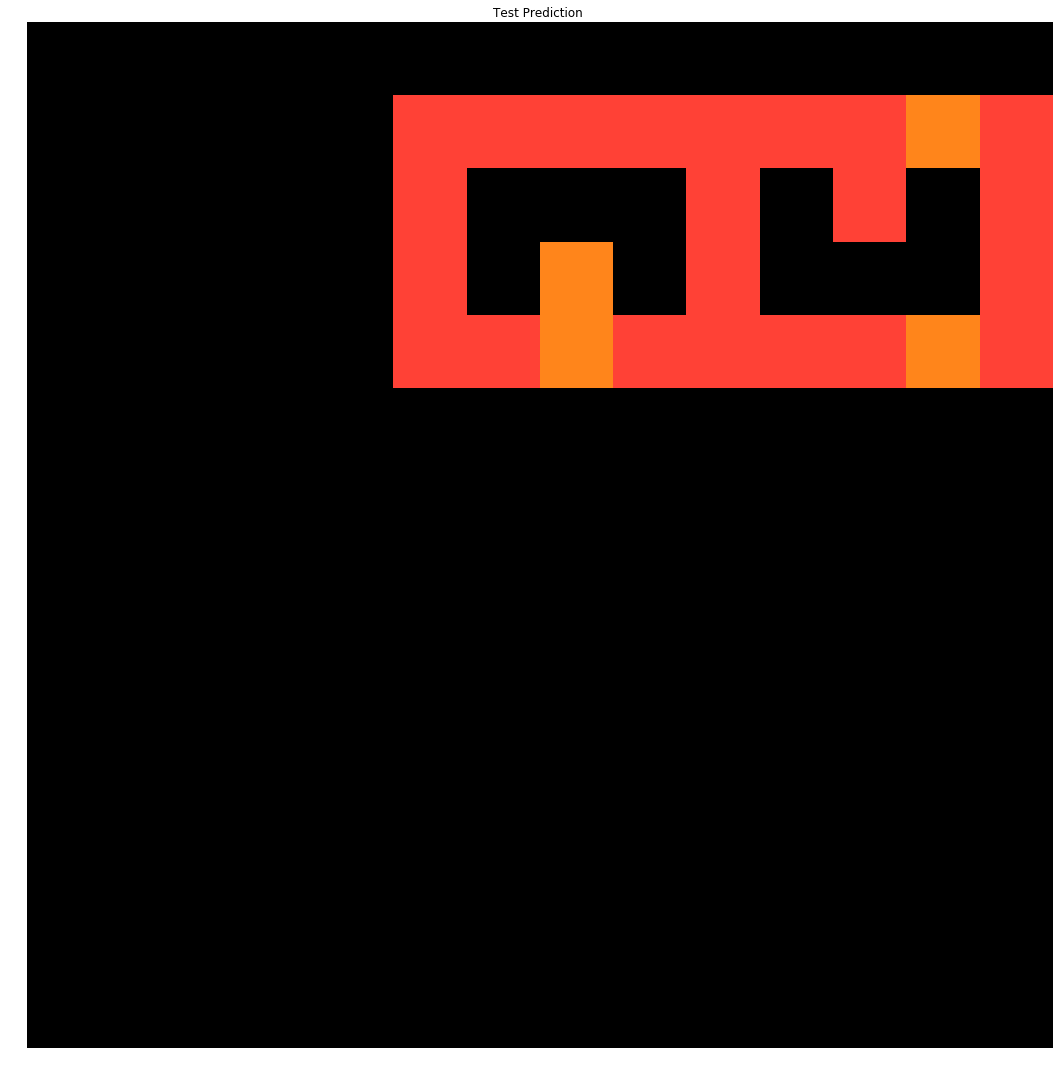

Made predictions for  00dbd492
ensemble accuracy 0.885



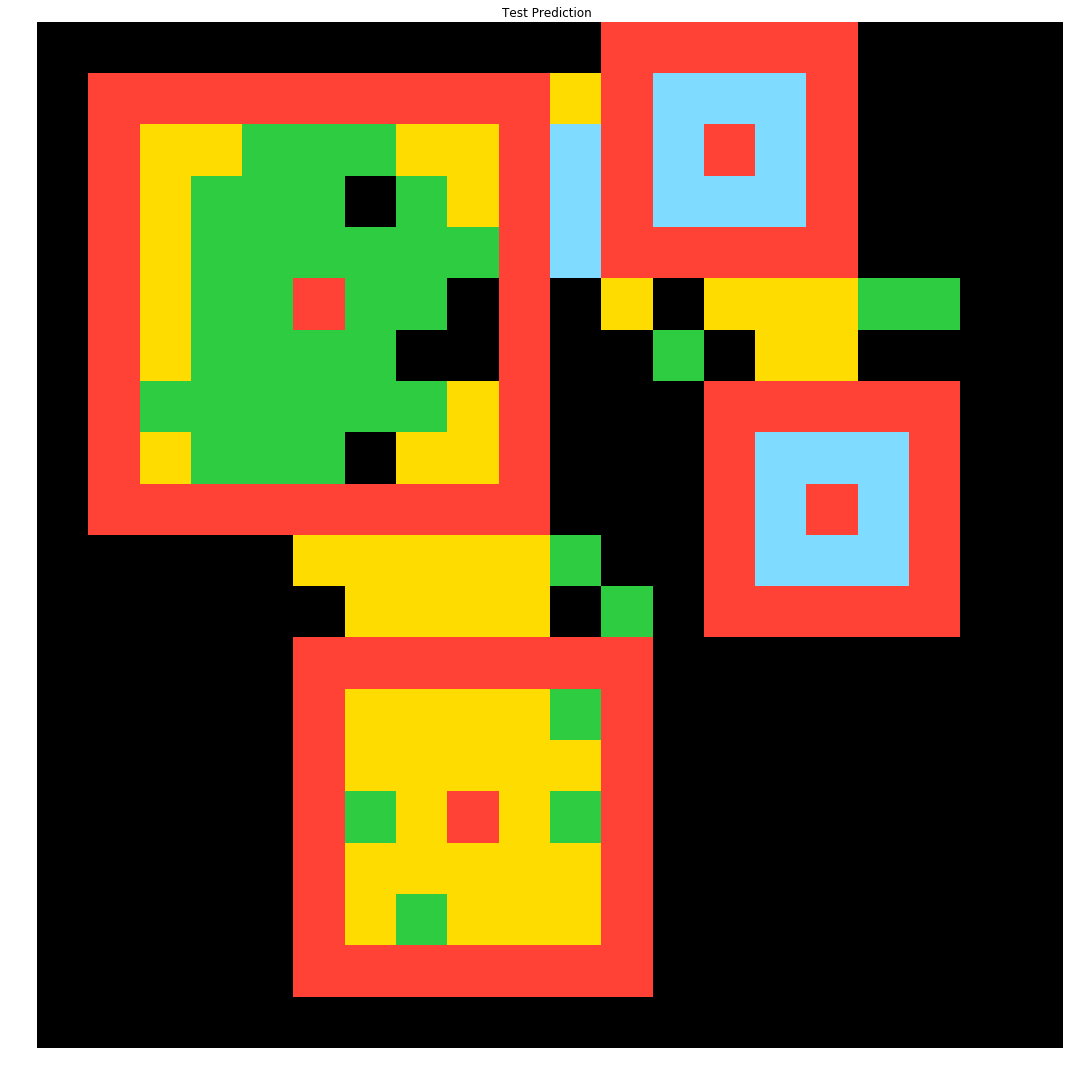

Made predictions for  03560426
ensemble accuracy 0.85



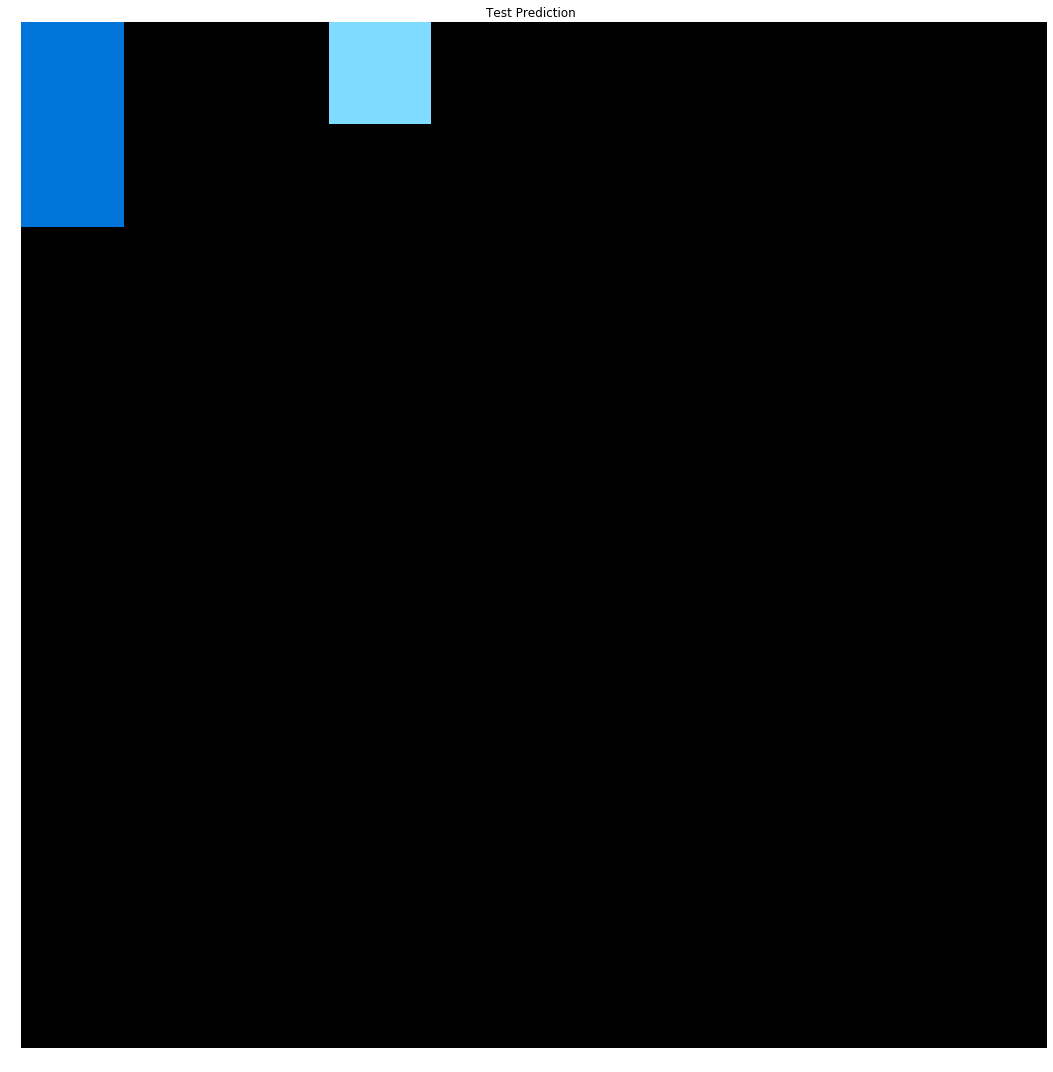

Made predictions for  05a7bcf2
ensemble accuracy 0.5477777777777778



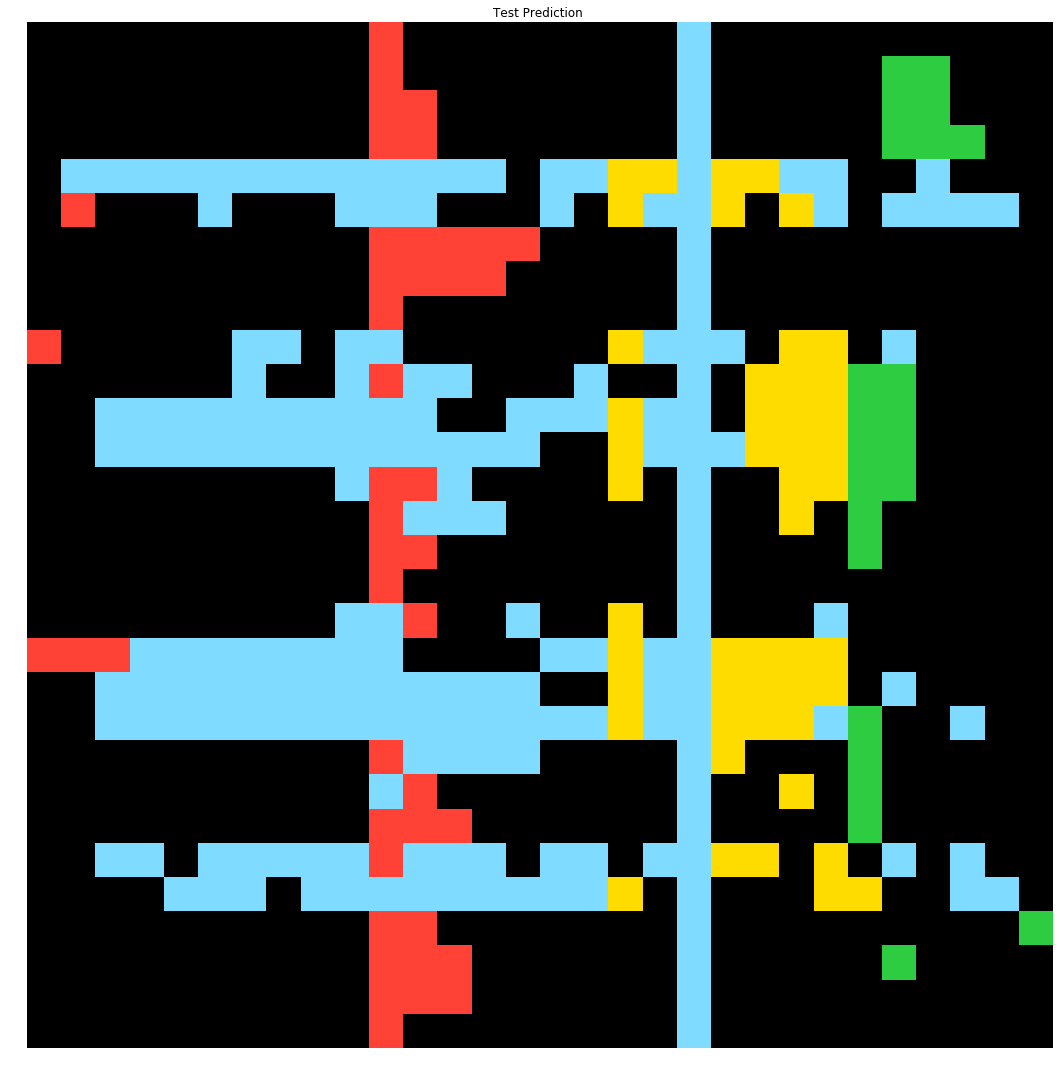

Made predictions for  0607ce86
ensemble accuracy 0.9261363636363636



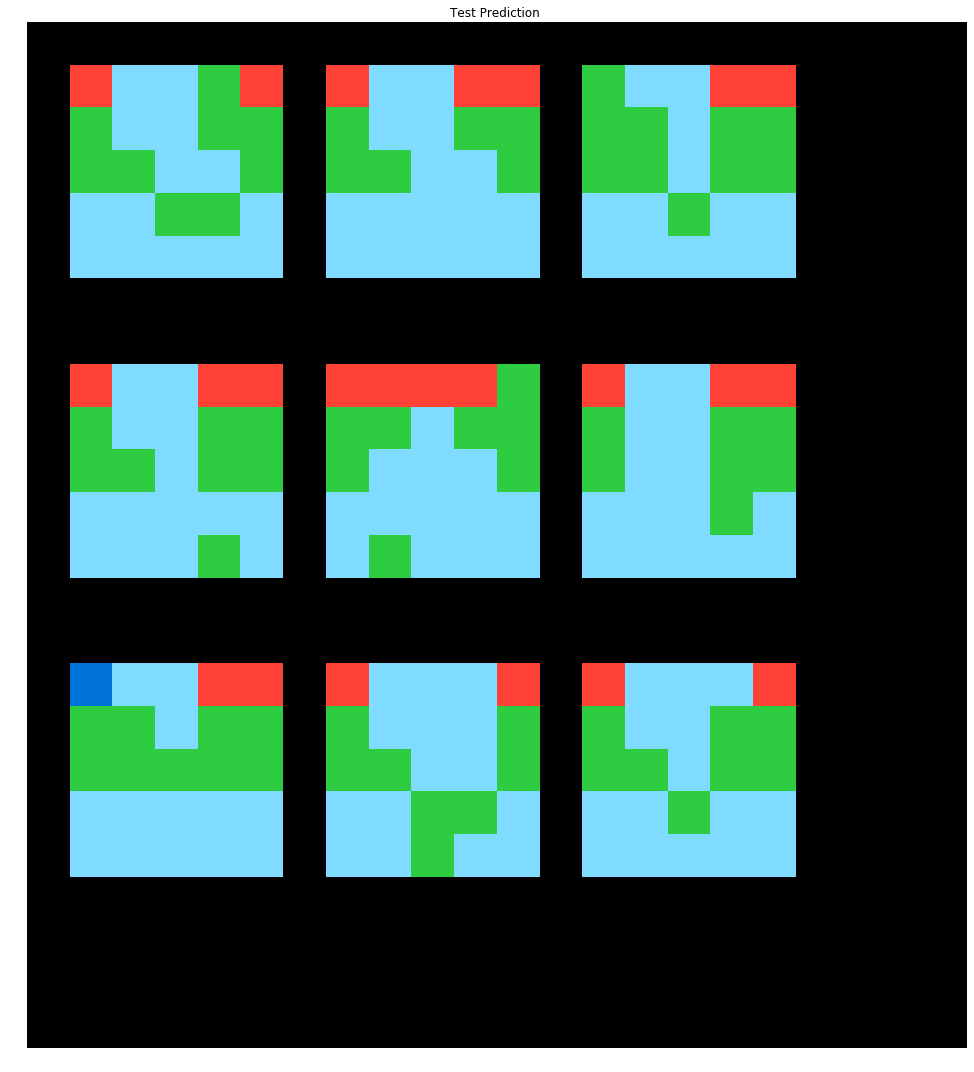

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\0692e18c.json

Made predictions for  070dd51e
ensemble accuracy 0.8725



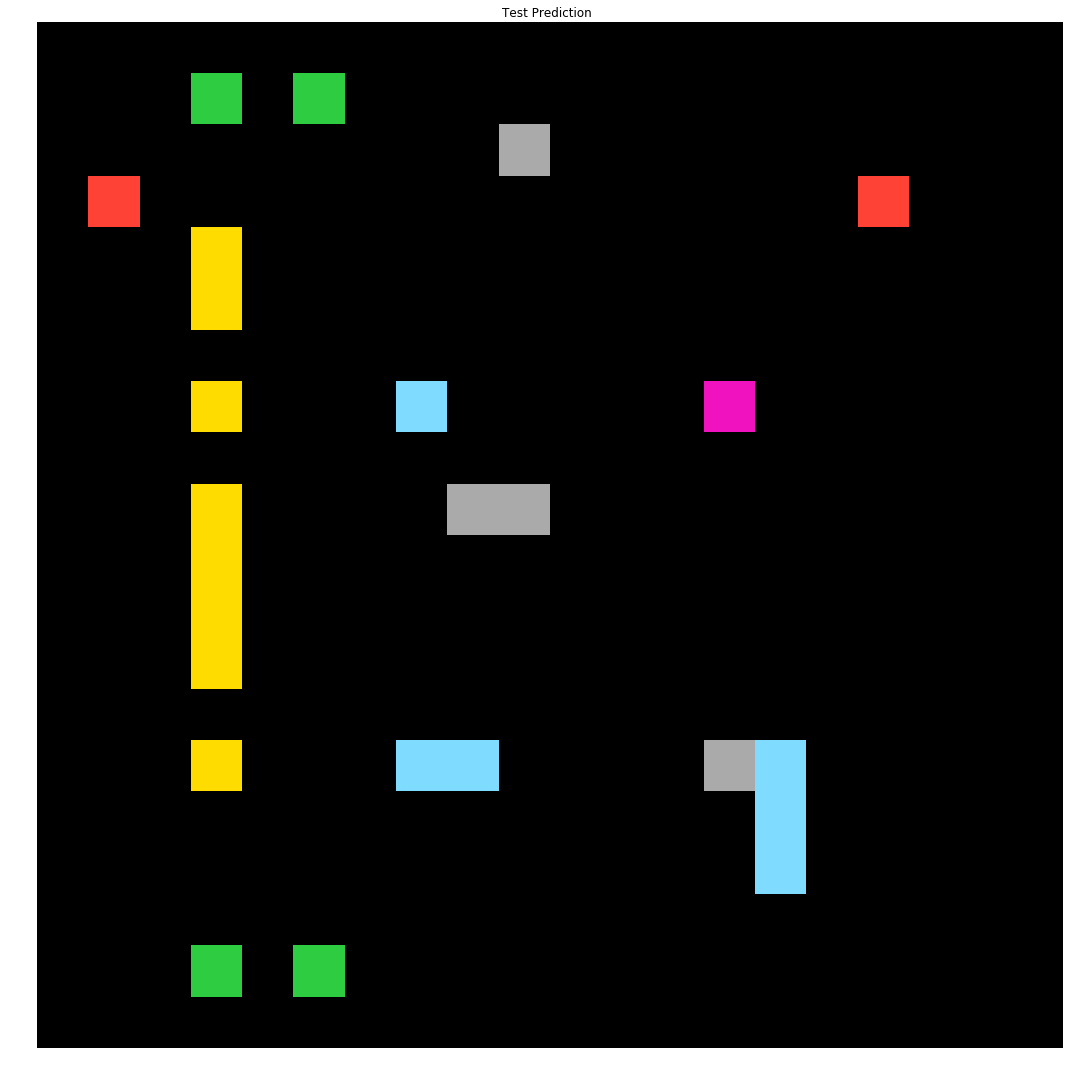

Made predictions for  08573cc6
ensemble accuracy 0.3609467455621302



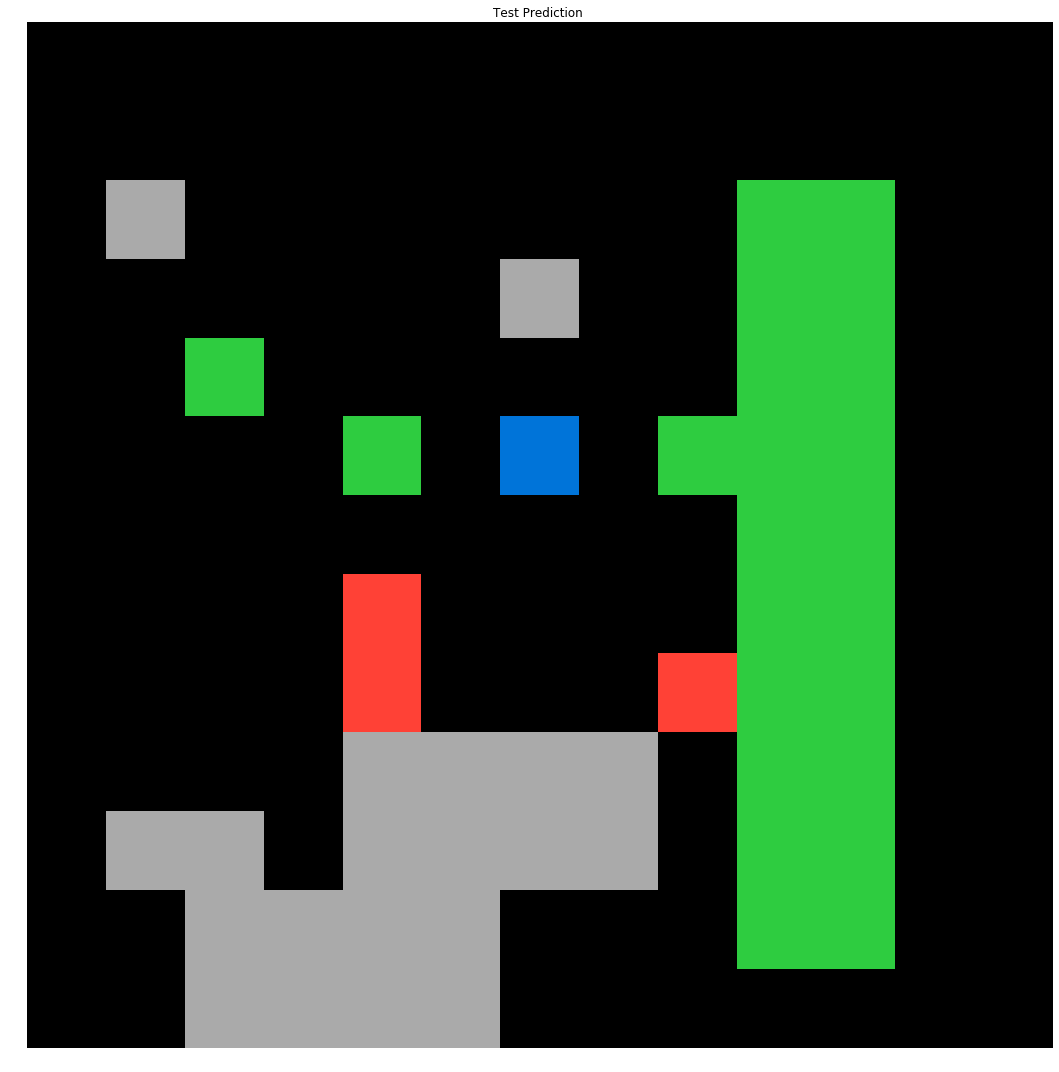

Number of input rows: 30 cols: 30
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\0934a4d8.json

Made predictions for  09c534e7
ensemble accuracy 0.8555555555555555



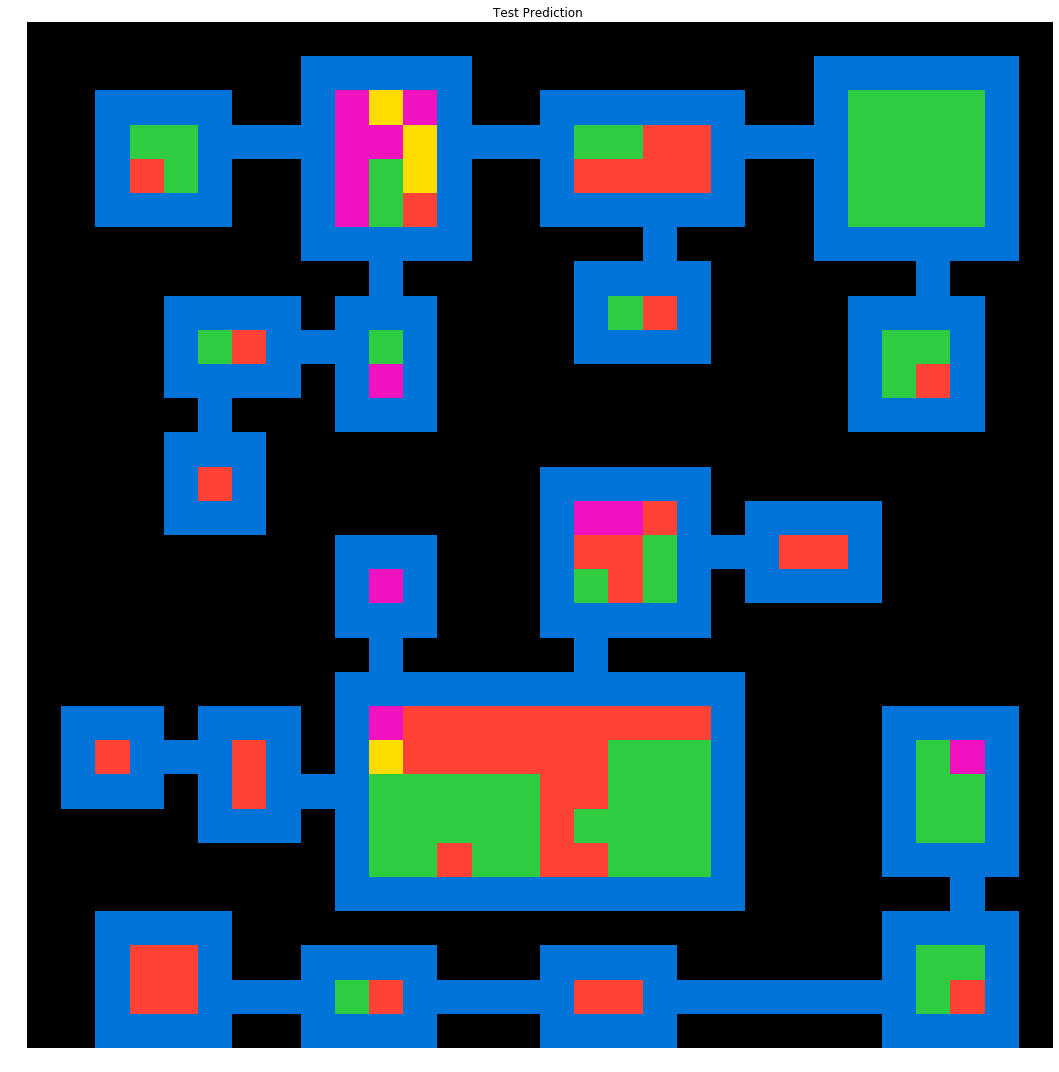

Number of input rows: 30 cols: 30
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\0a1d4ef5.json

Made predictions for  0a2355a6
ensemble accuracy 0.7254901960784313



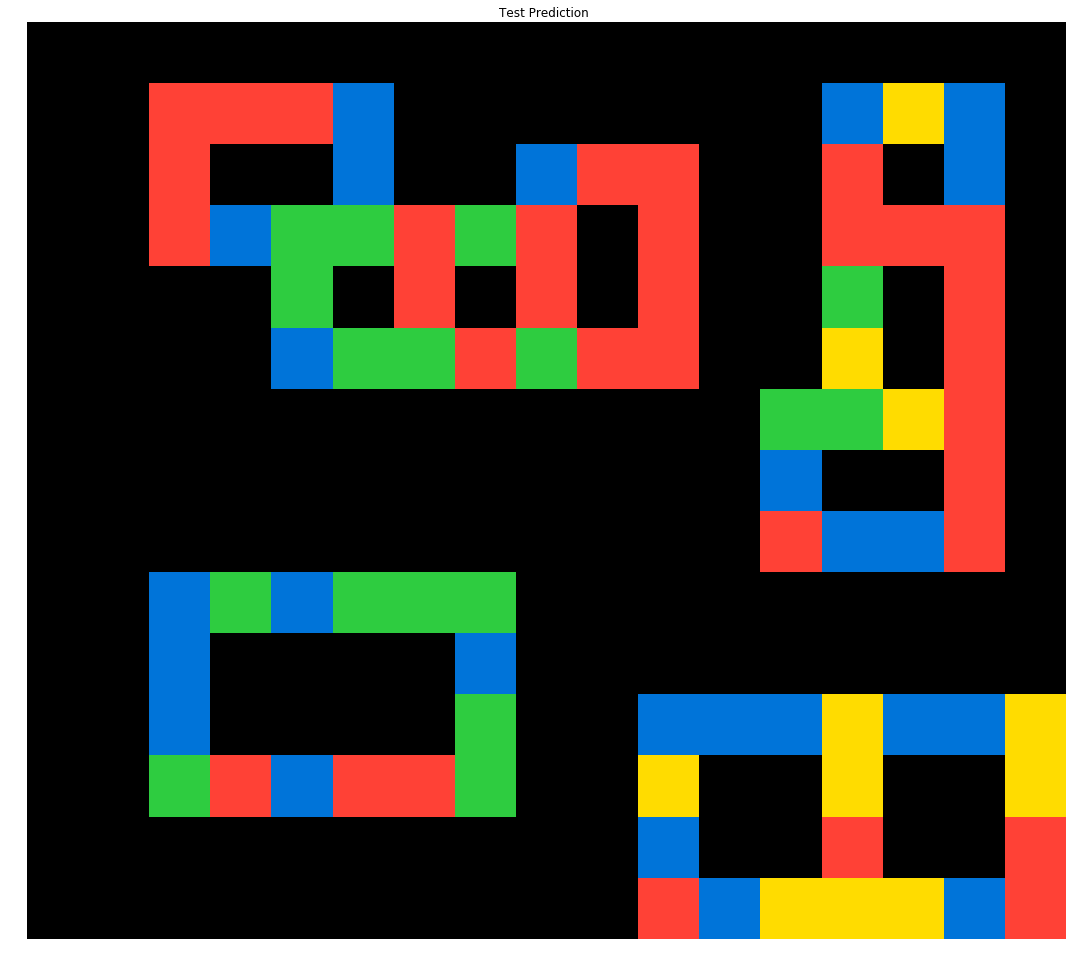

Made predictions for  0b17323b
ensemble accuracy 0.9866666666666667



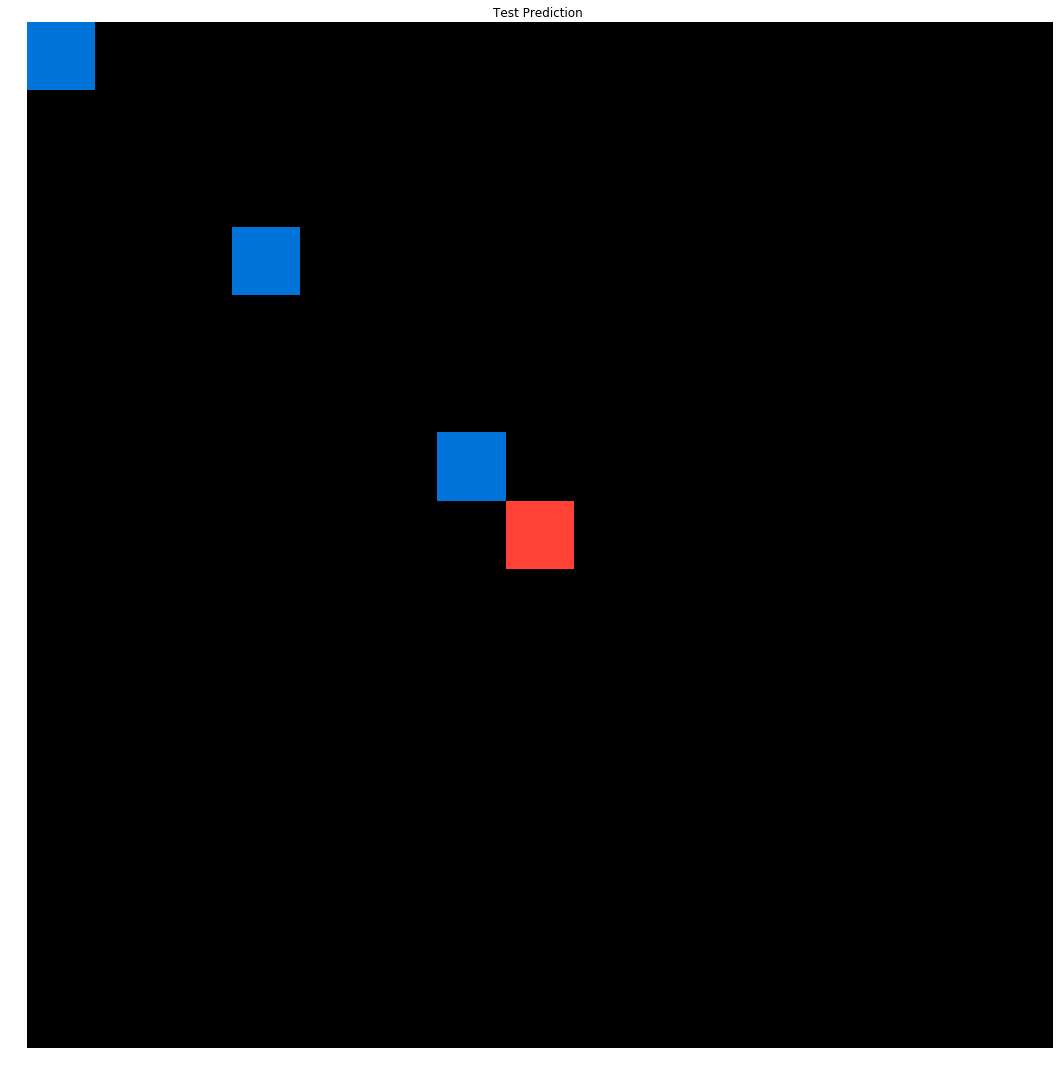

Number of input rows: 12 cols: 13
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\0bb8deee.json

Made predictions for  0becf7df
ensemble accuracy 0.8



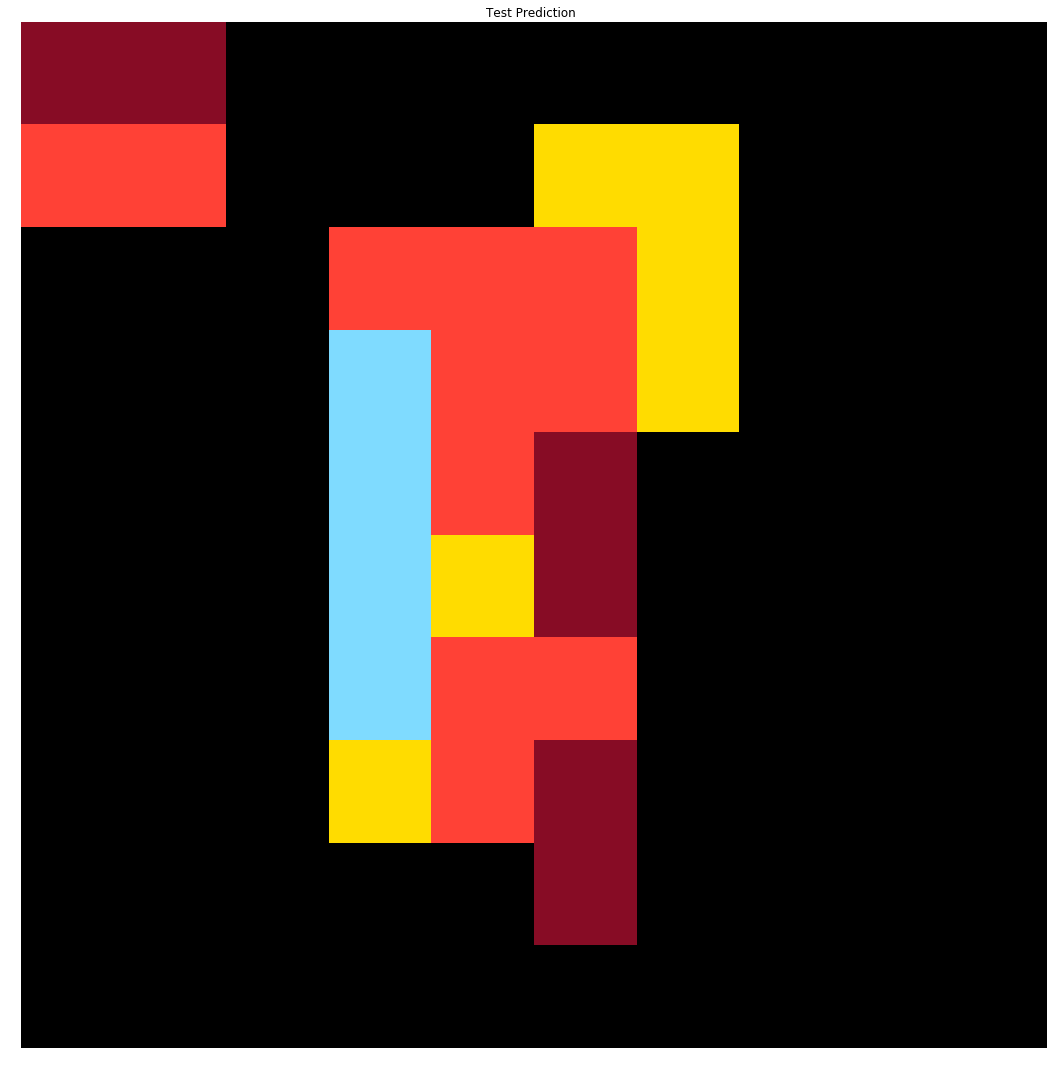

Number of input rows: 3 cols: 4
Number of target rows: 6 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\0c786b71.json

Number of input rows: 13 cols: 4
Number of target rows: 6 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\0c9aba6e.json

Made predictions for  0d87d2a6
ensemble accuracy 0.8904347826086957



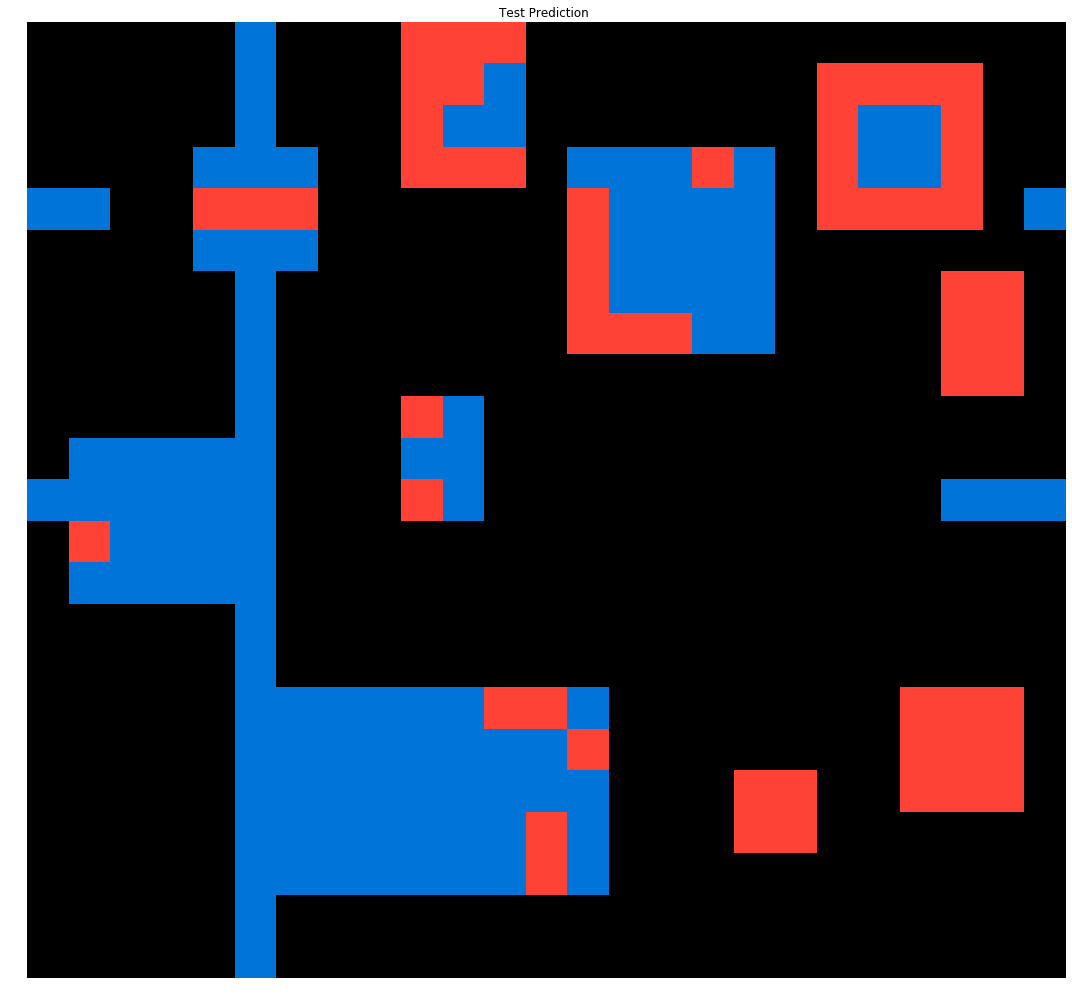

Made predictions for  0e671a1a
ensemble accuracy 0.9526627218934911



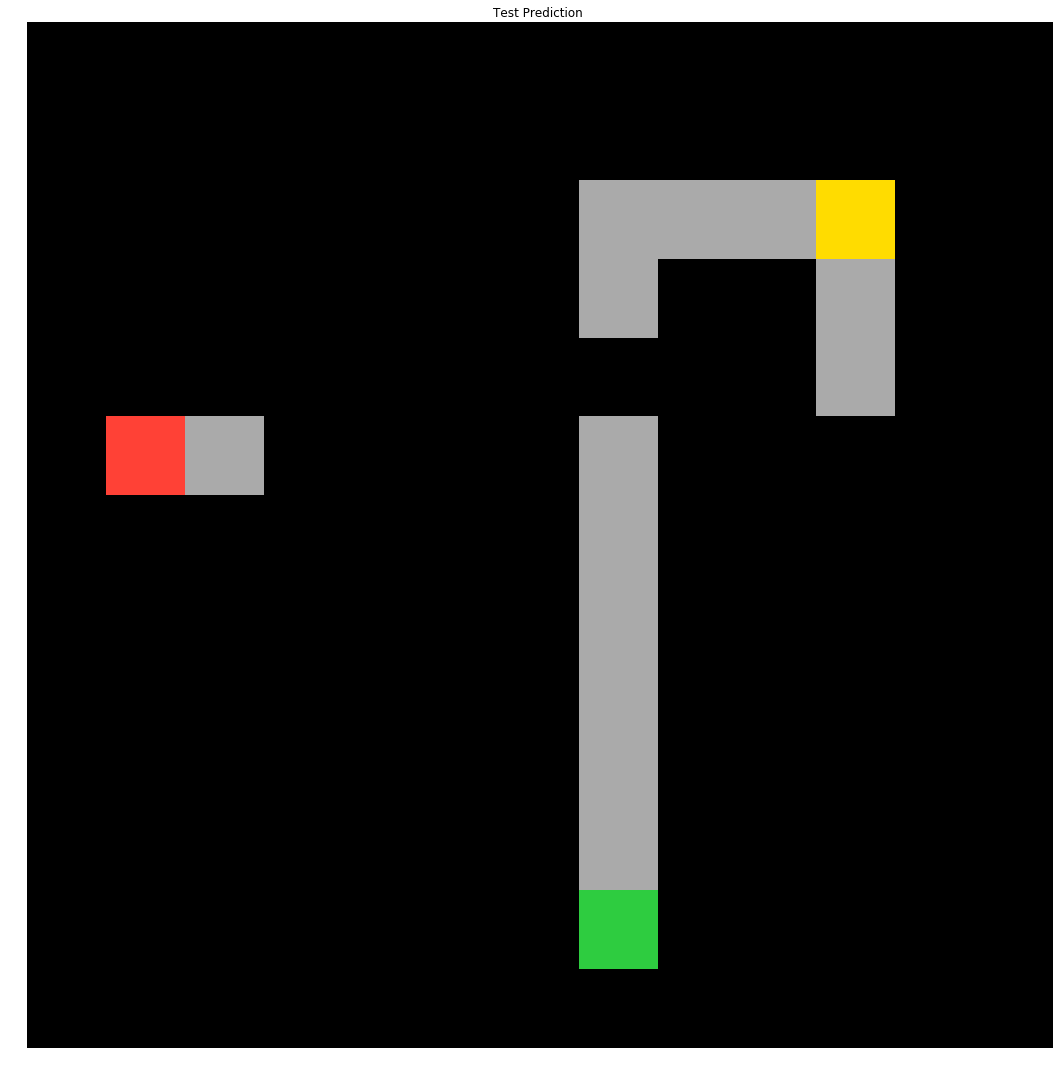

Made predictions for  0f63c0b9
ensemble accuracy 0.6533333333333333



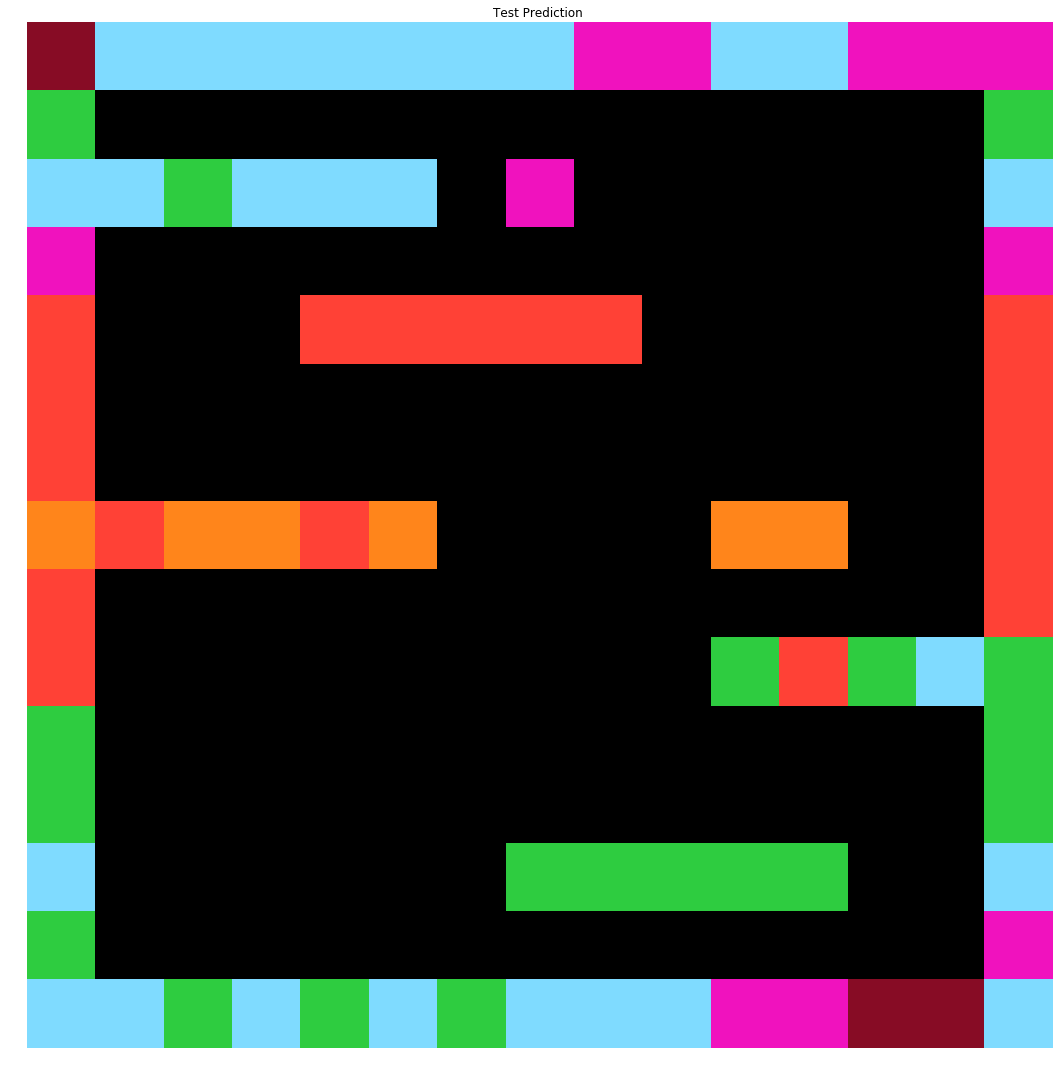

Made predictions for  103eff5b
ensemble accuracy 0.8509615384615384



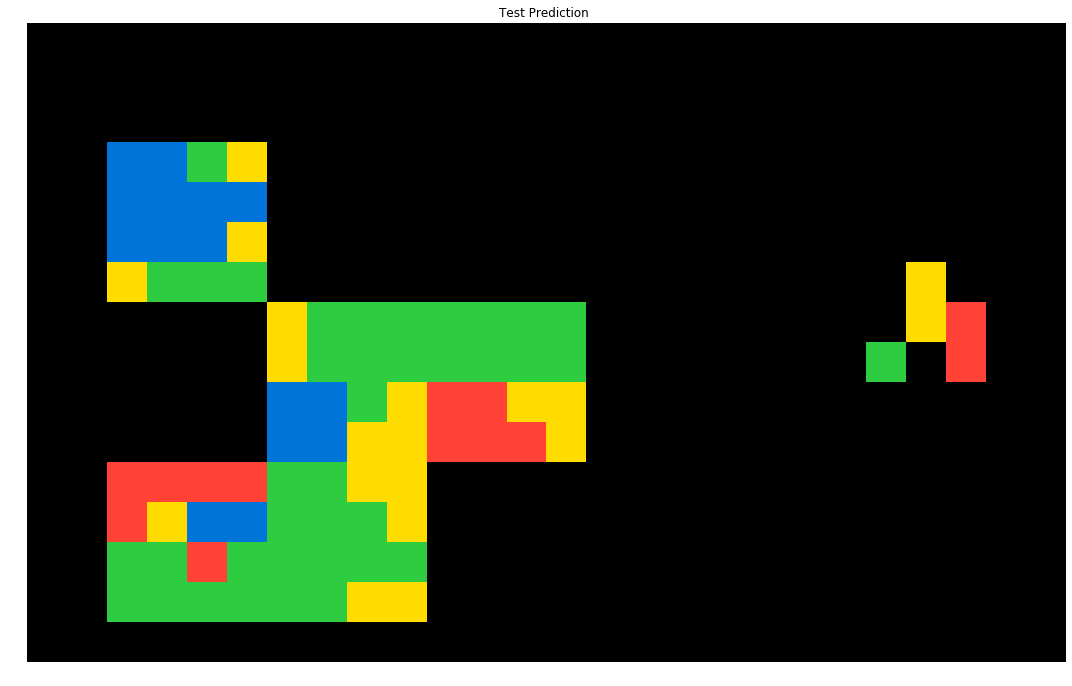

Made predictions for  11e1fe23
ensemble accuracy 0.9523809523809523



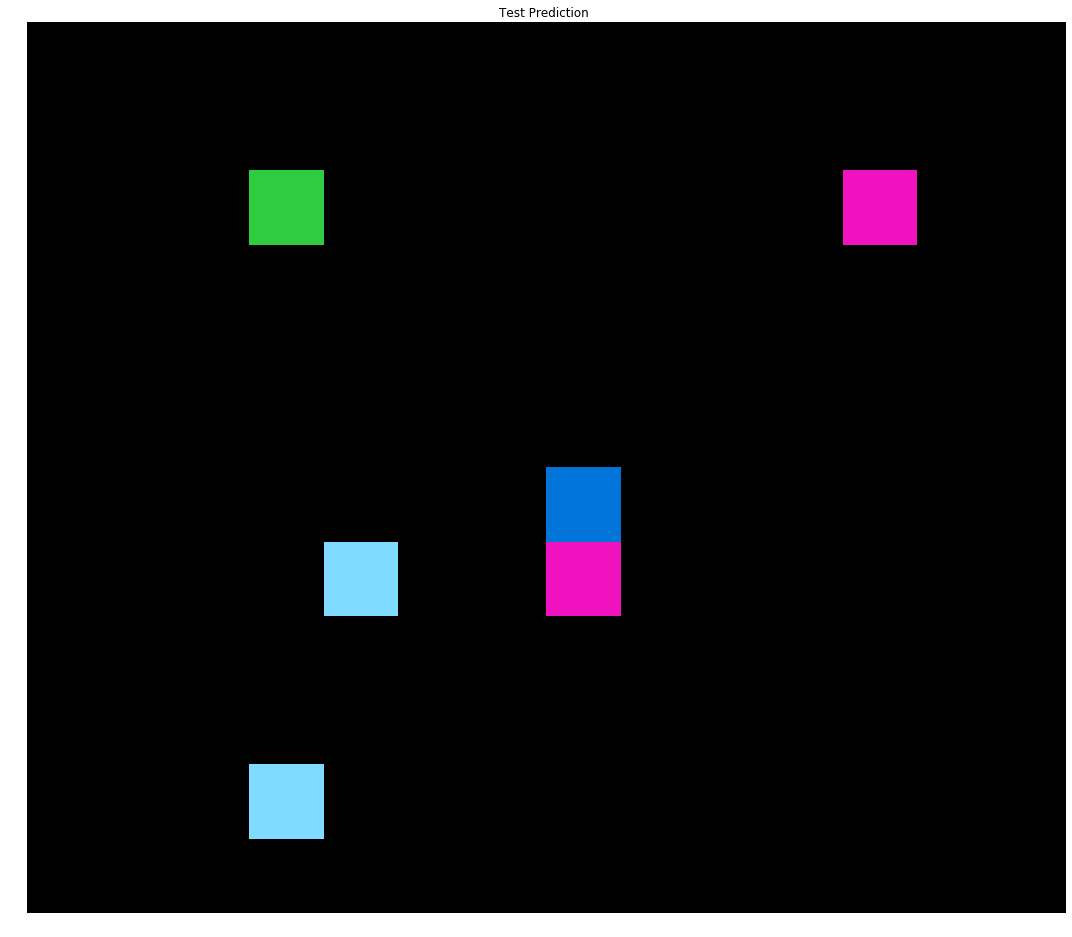

Made predictions for  12422b43
ensemble accuracy 0.8



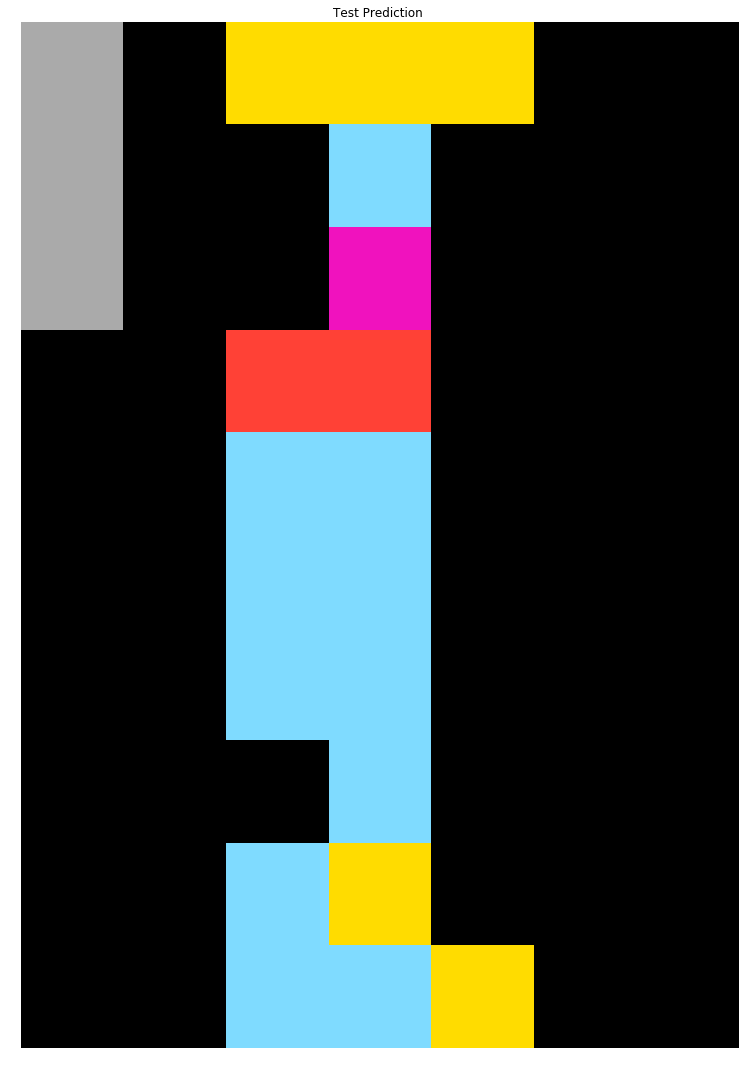

Number of input rows: 11 cols: 14
Number of target rows: 3 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\12997ef3.json

Made predictions for  12eac192
ensemble accuracy 0.84375



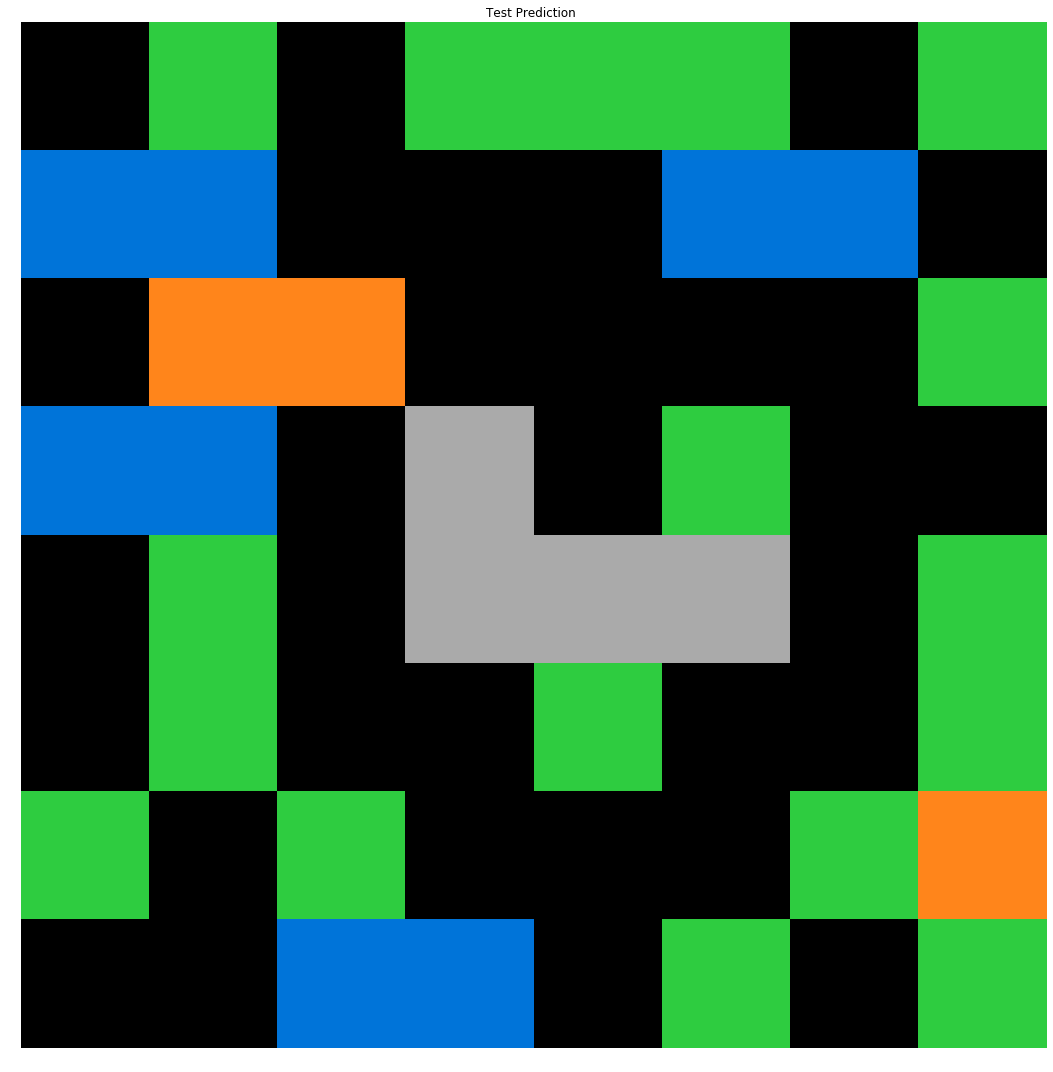

Number of input rows: 7 cols: 15
Number of target rows: 7 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\136b0064.json

Made predictions for  13713586
ensemble accuracy 0.2777777777777778



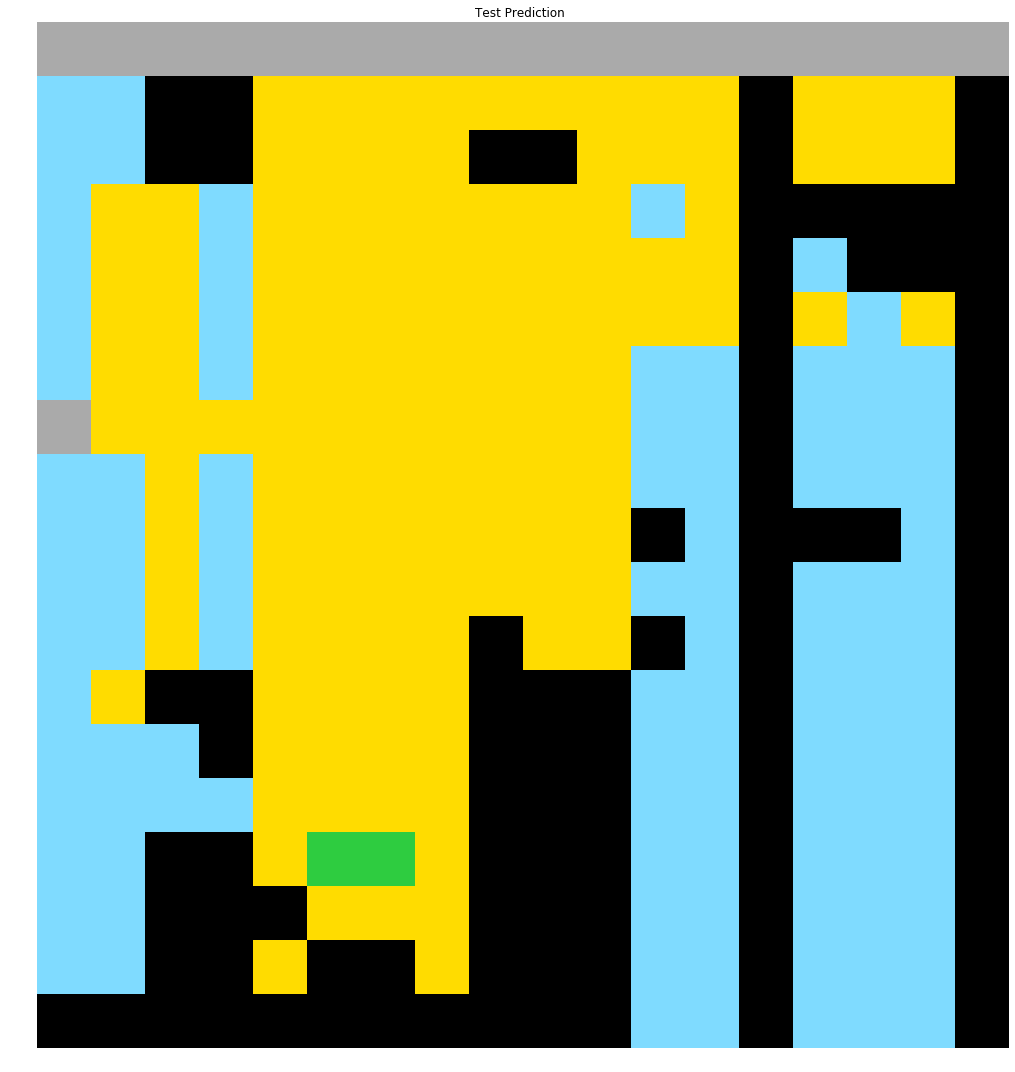

Made predictions for  137f0df0
ensemble accuracy 1.0



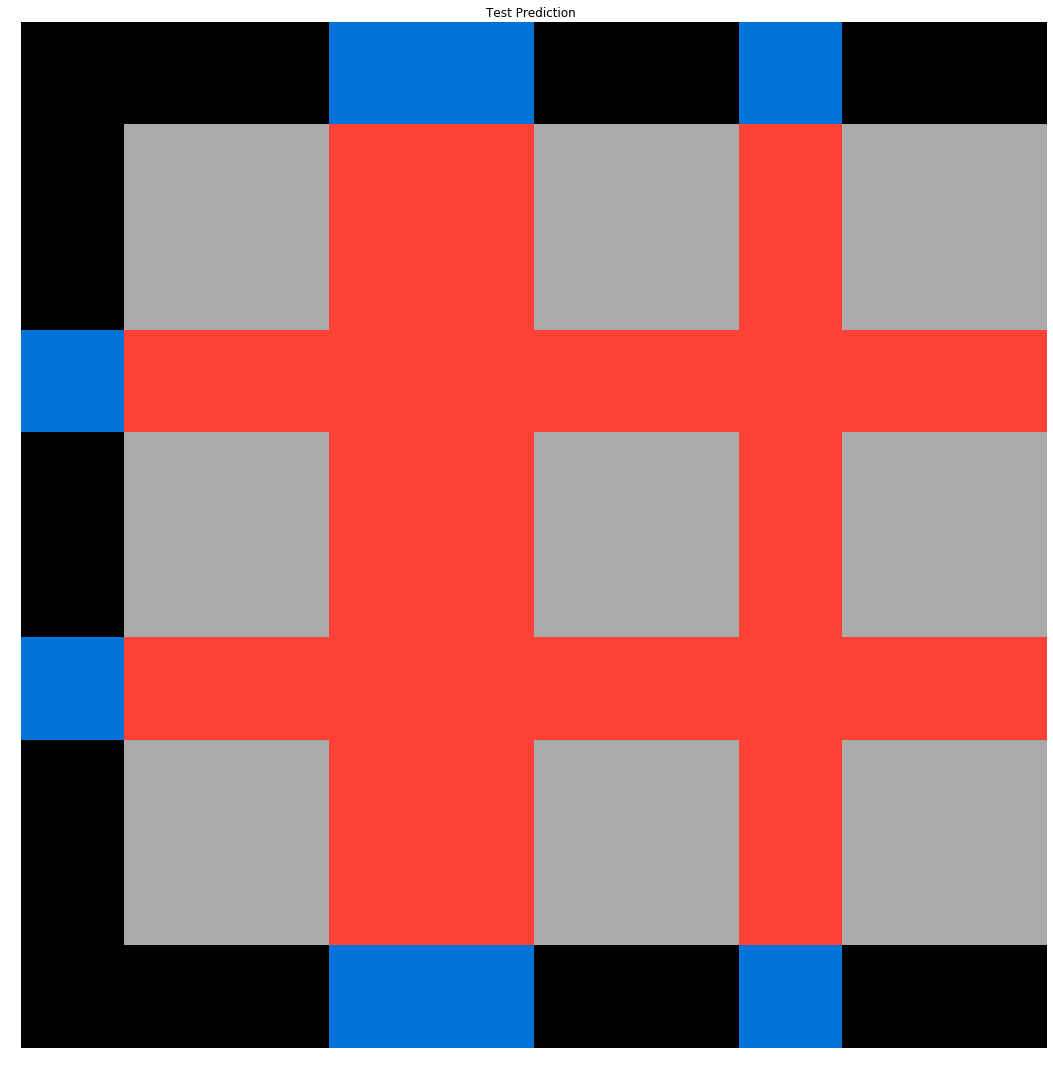

Made predictions for  140c817e
ensemble accuracy 0.6683673469387755



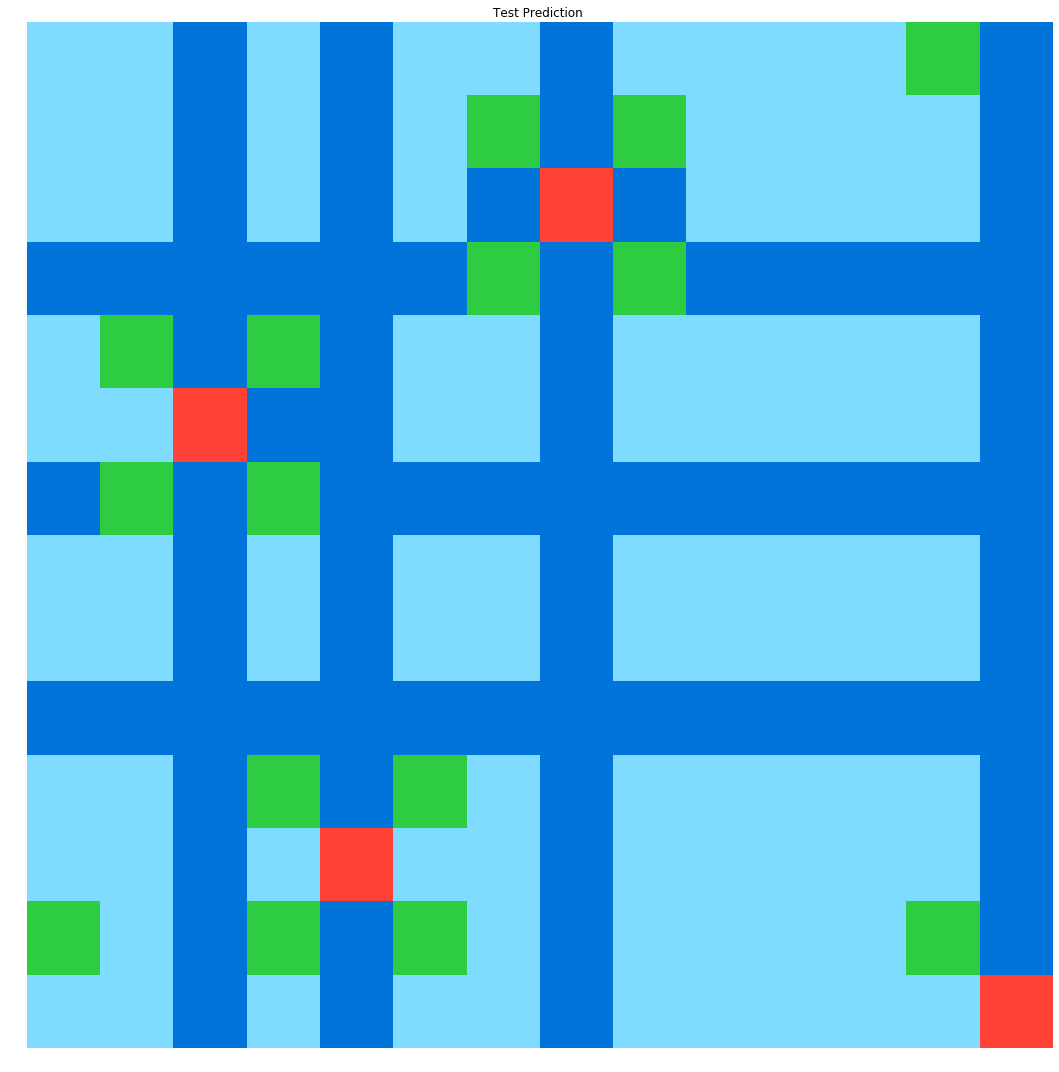

Made predictions for  14754a24
ensemble accuracy 0.9750692520775623



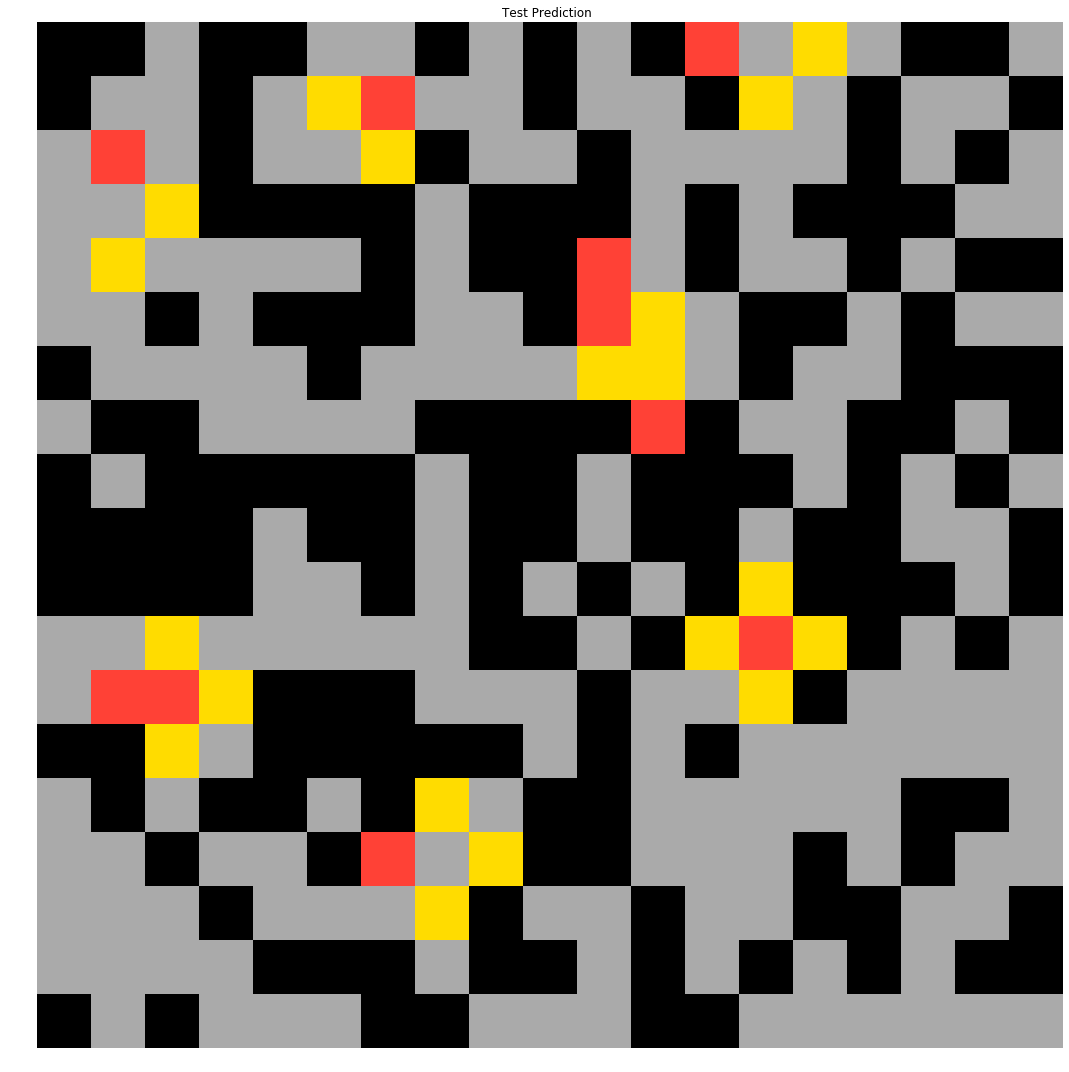

Made predictions for  15113be4
ensemble accuracy 0.9300567107750473



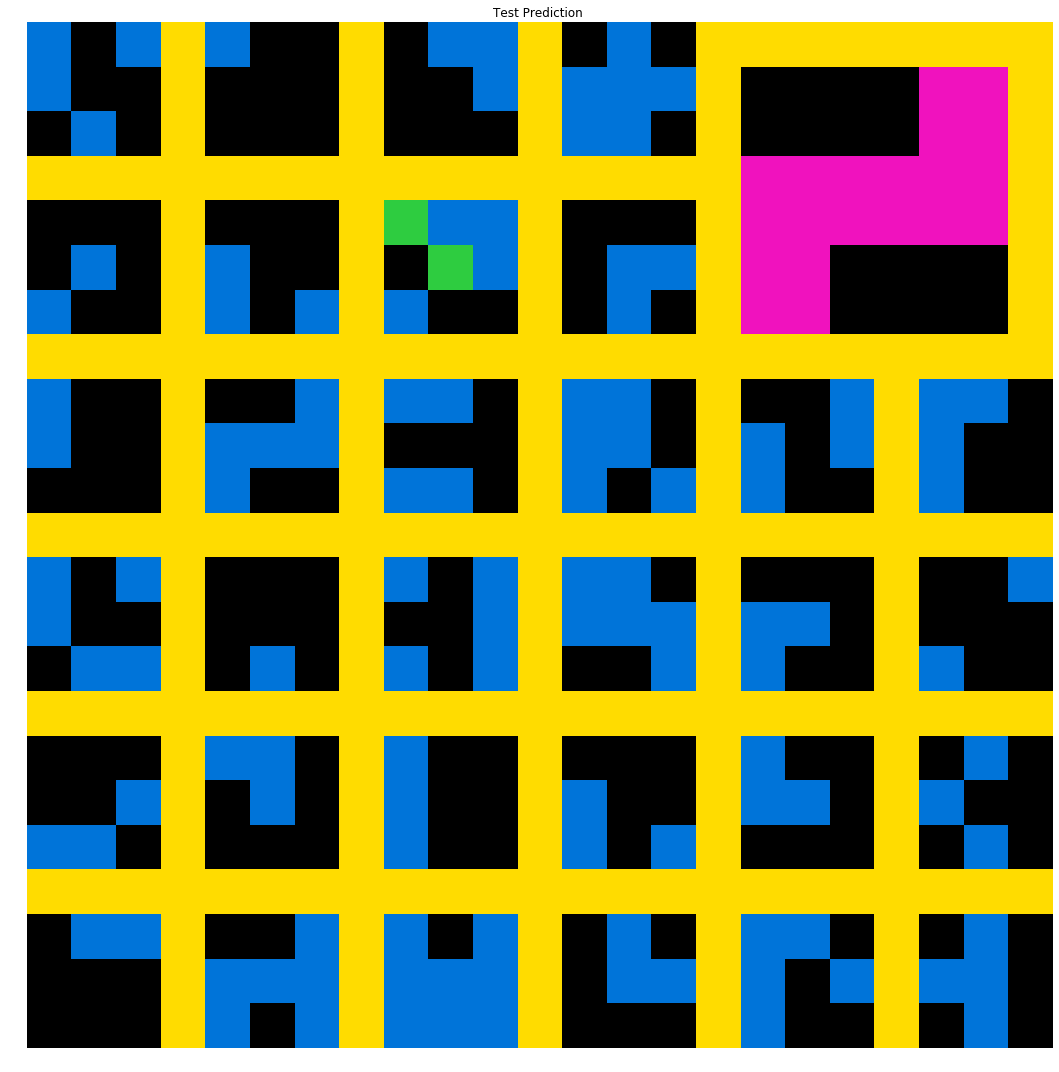

Made predictions for  15663ba9
ensemble accuracy 0.9416666666666667



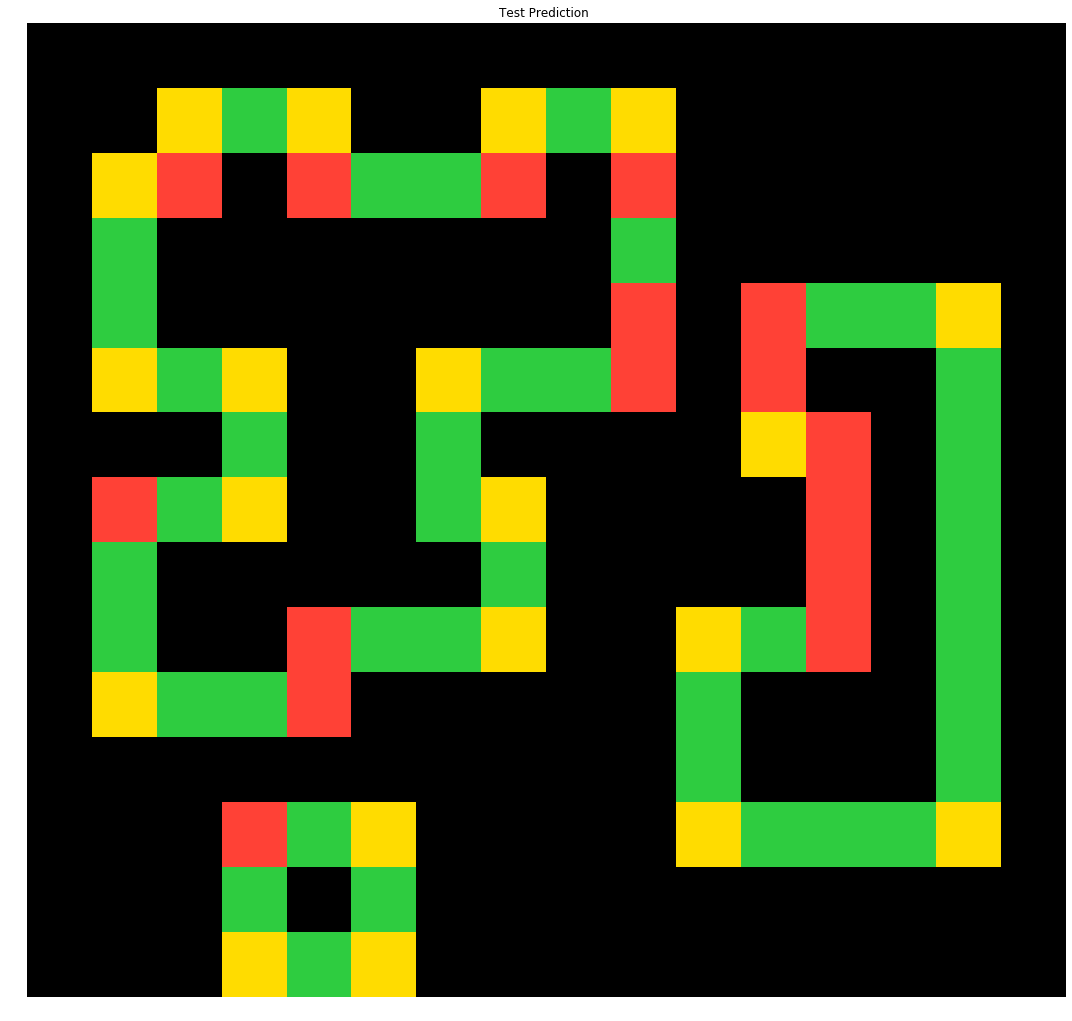

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\15696249.json

Made predictions for  16b78196
ensemble accuracy 0.7122222222222222



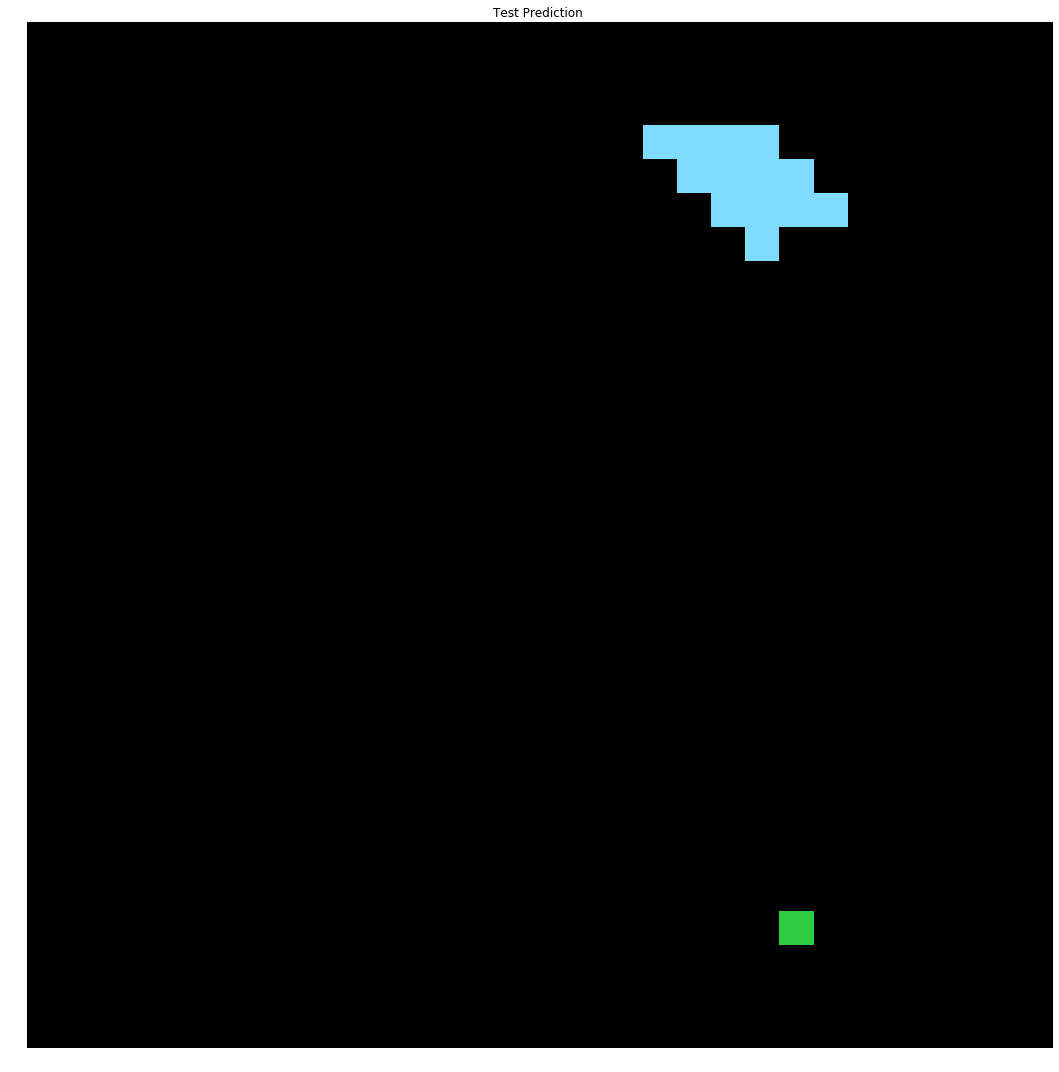

Made predictions for  17b80ad2
ensemble accuracy 0.7093425605536332



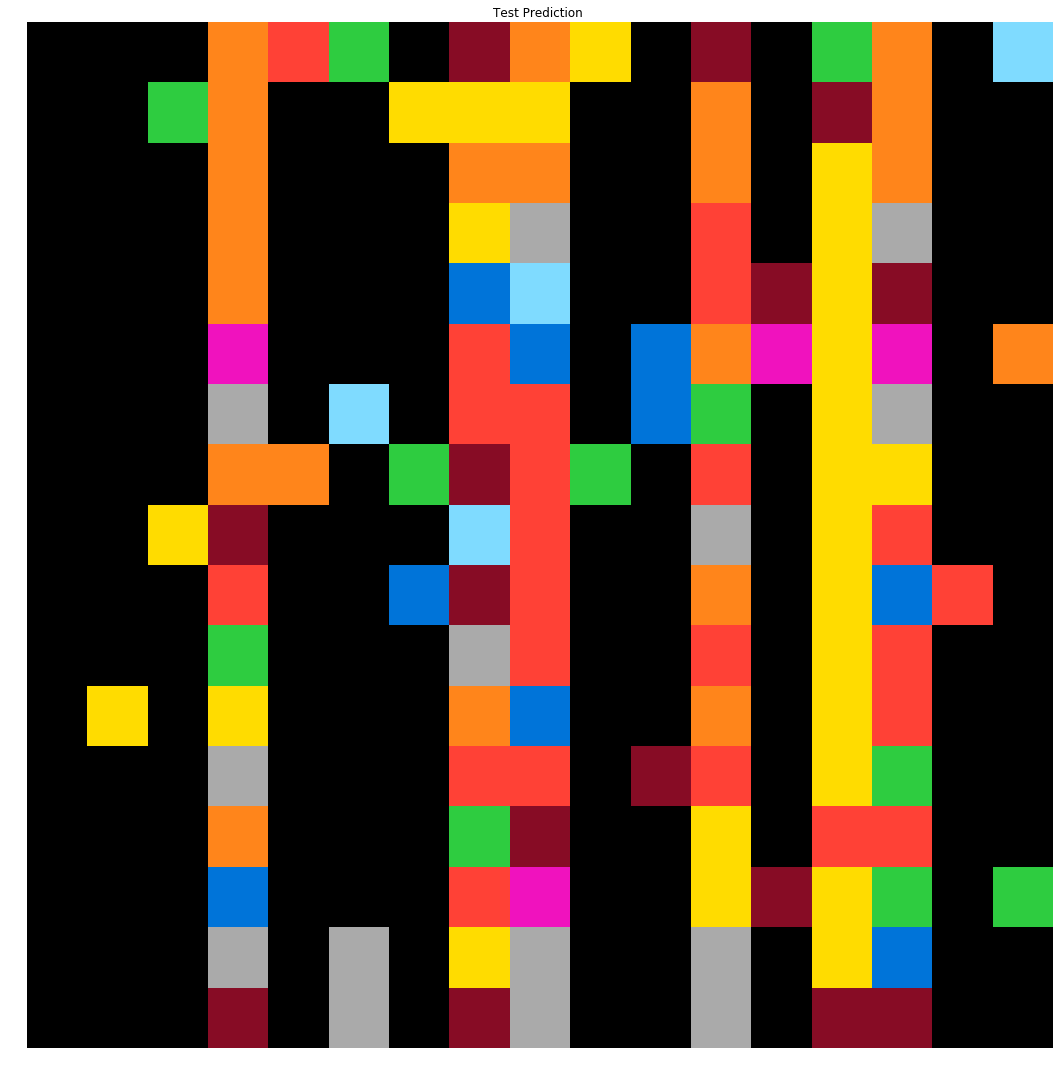

Made predictions for  17cae0c1
ensemble accuracy 0.4074074074074074



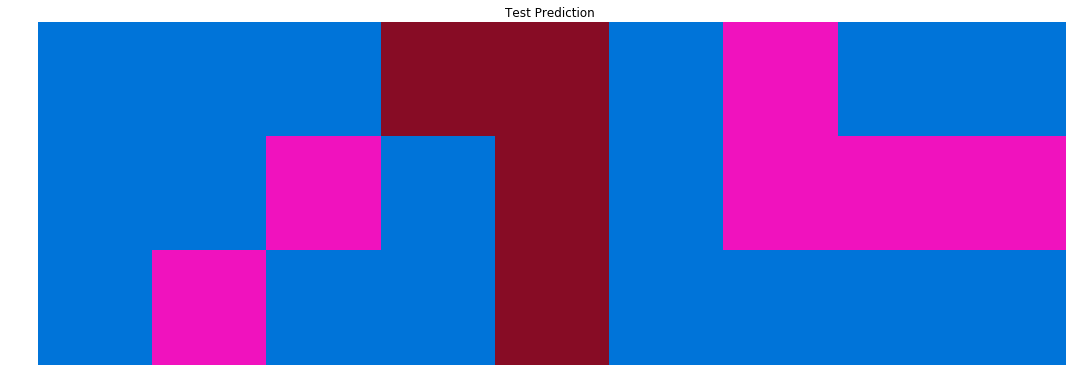

Made predictions for  18419cfa
ensemble accuracy 0.9285714285714286



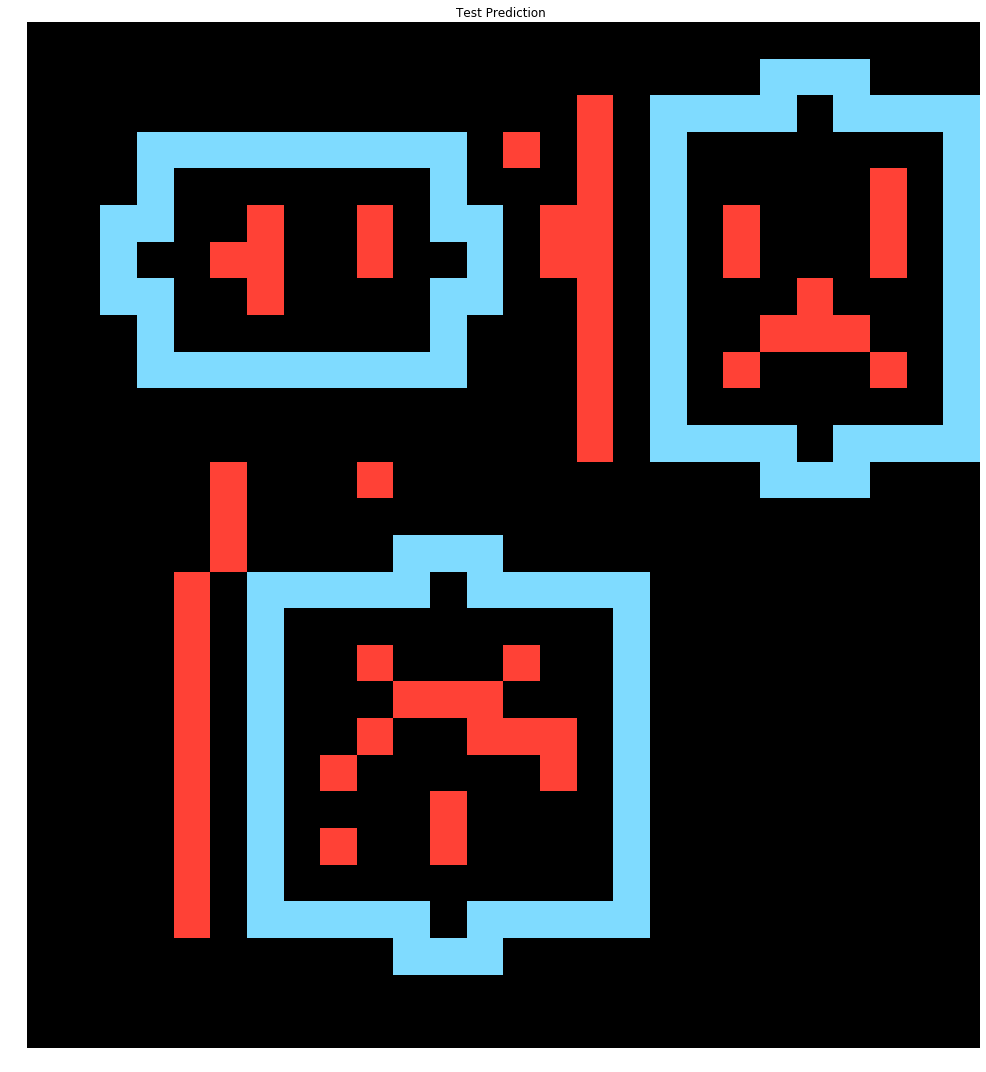

Made predictions for  184a9768
ensemble accuracy 0.7169230769230769



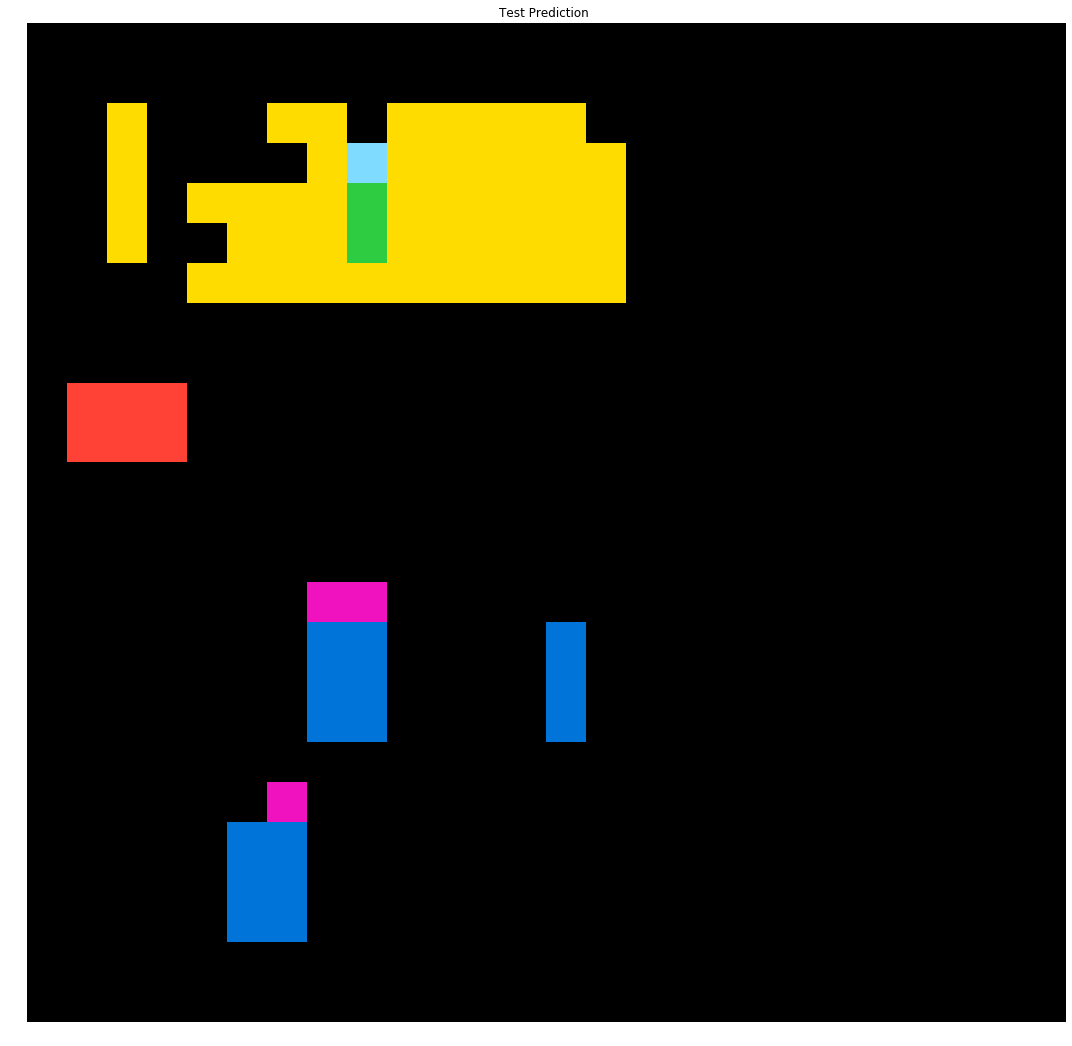

Number of input rows: 5 cols: 13
Number of target rows: 5 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\195ba7dc.json

Number of input rows: 23 cols: 23
Number of target rows: 7 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\1990f7a8.json

Number of input rows: 13 cols: 15
Number of target rows: 2 cols: 2
ignoring task abstraction-and-reasoning-challenge\evaluation\19bb5feb.json

Number of input rows: 8 cols: 12
Number of target rows: 1 cols: 1
ignoring task abstraction-and-reasoning-challenge\evaluation\1a2e2828.json

Number of input rows: 19 cols: 13
Number of target rows: 6 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\1a6449f1.json

Made predictions for  1acc24af
ensemble accuracy 0.9027777777777778



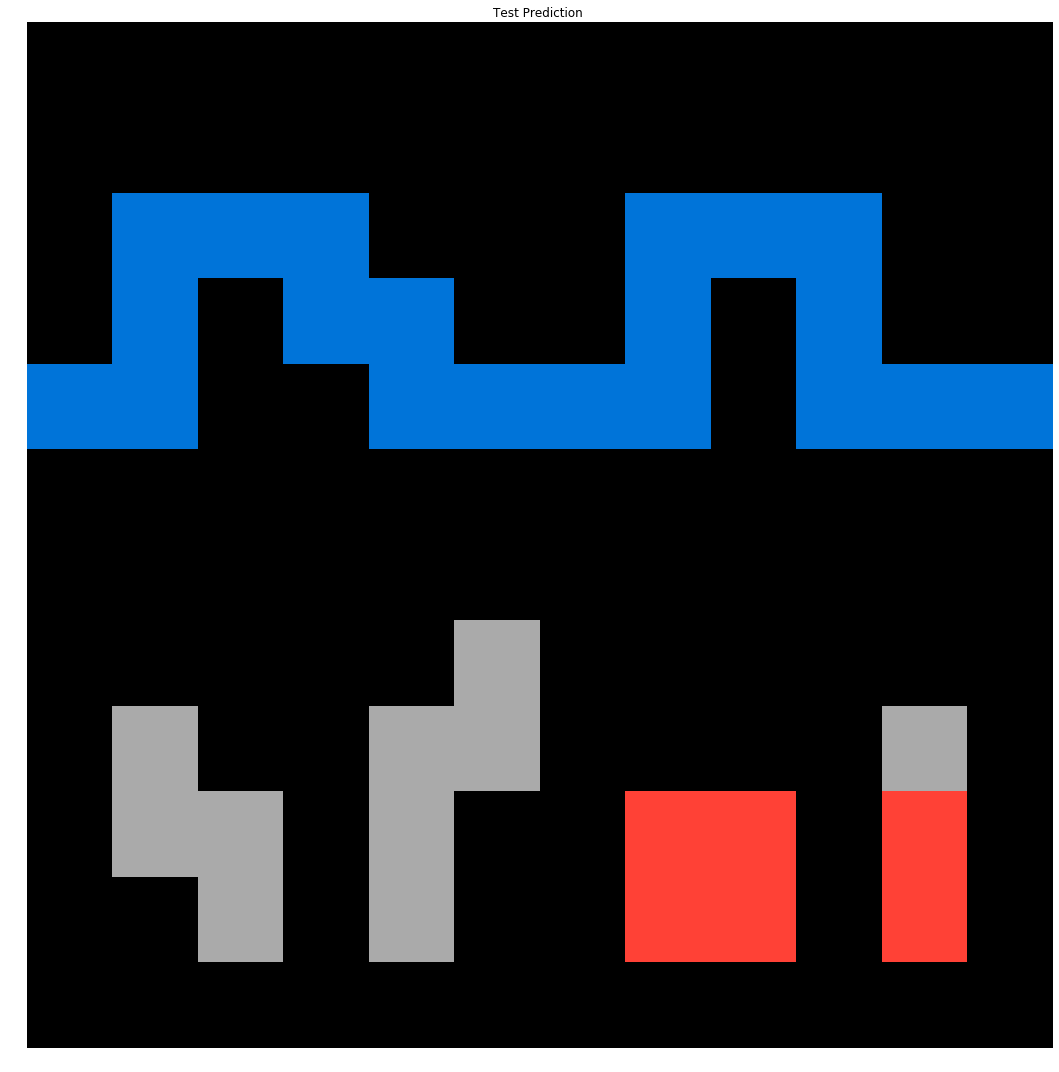

Made predictions for  1c02dbbe
ensemble accuracy 0.5244444444444445



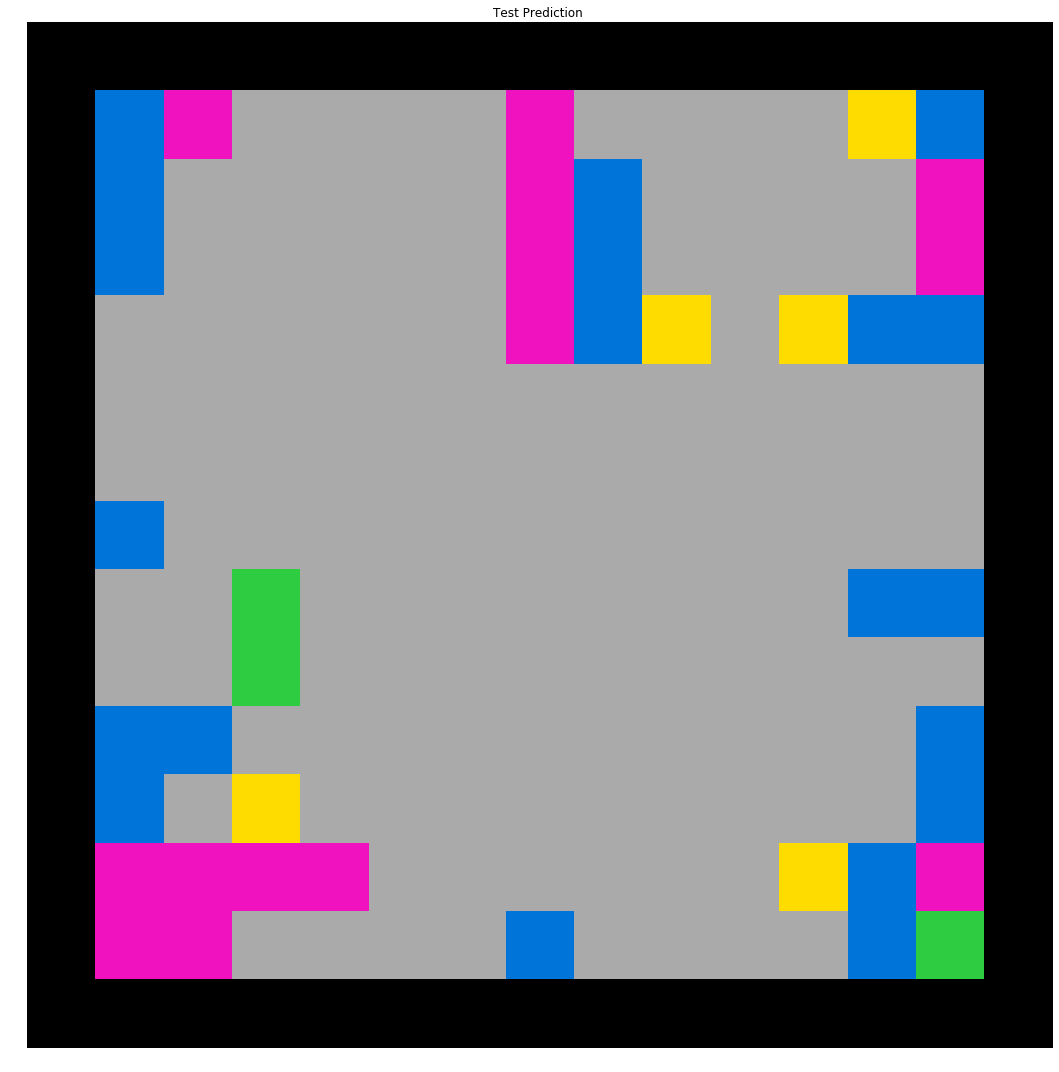

Made predictions for  1c0d0a4b
ensemble accuracy 0.9585798816568047



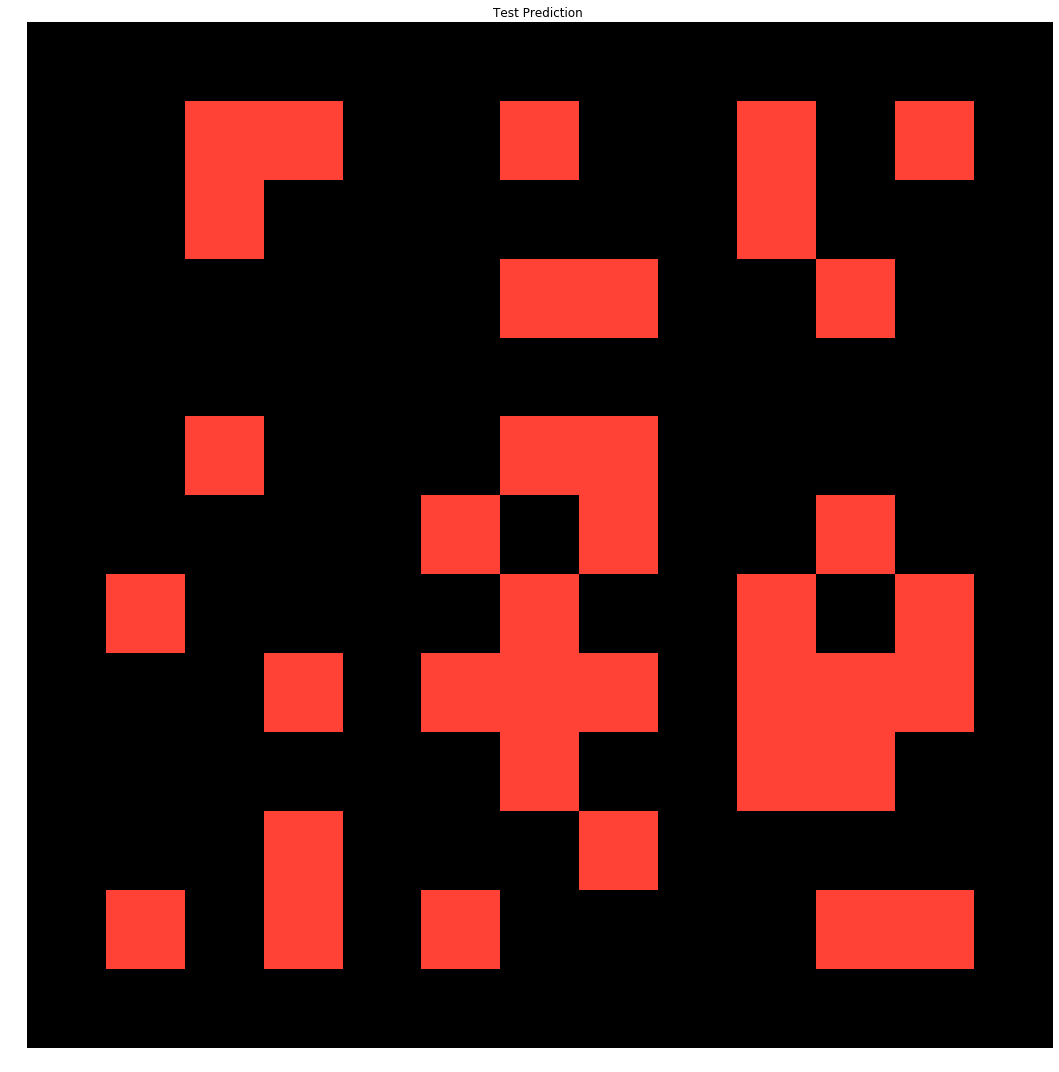

Made predictions for  1c56ad9f
ensemble accuracy 0.7022222222222222



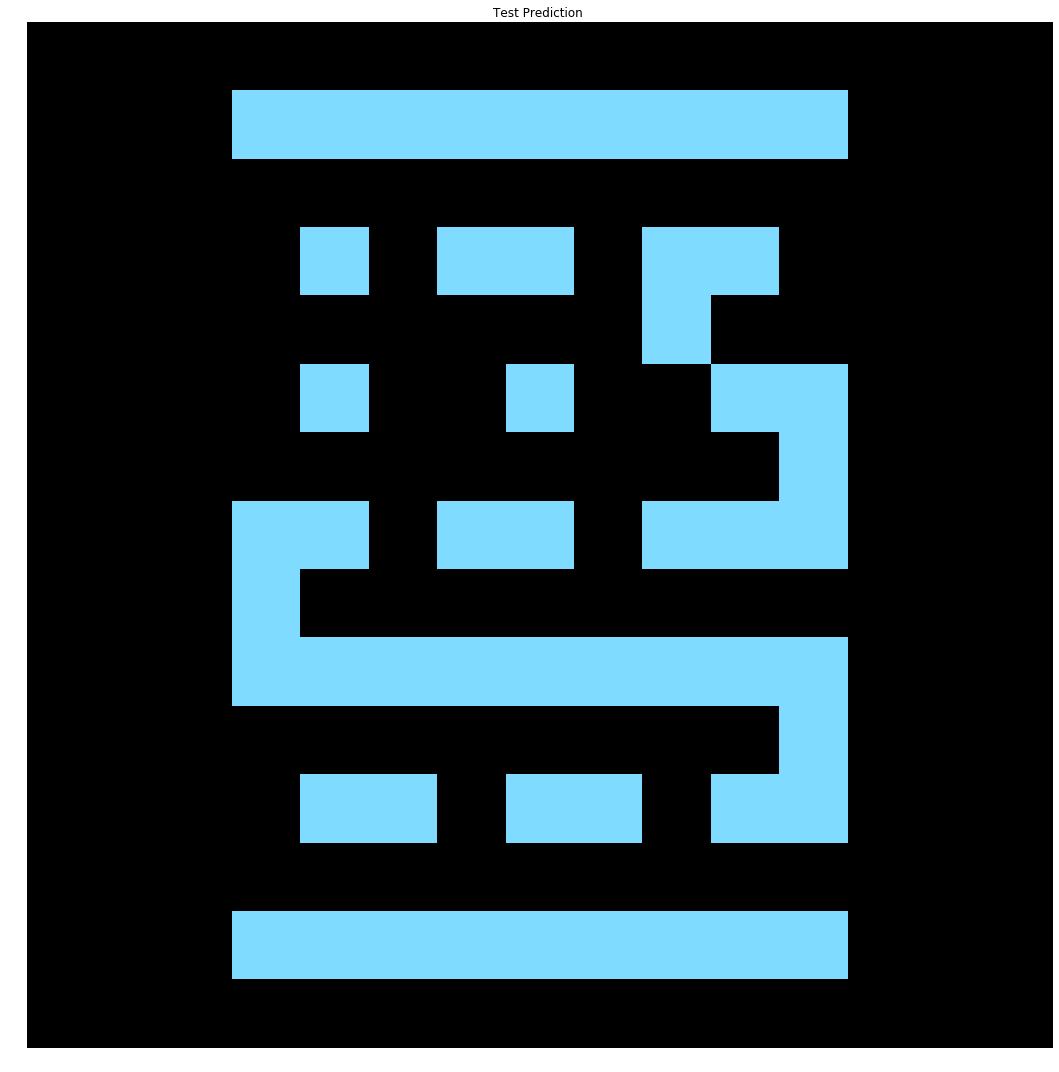

Made predictions for  1d0a4b61
ensemble accuracy 0.8416



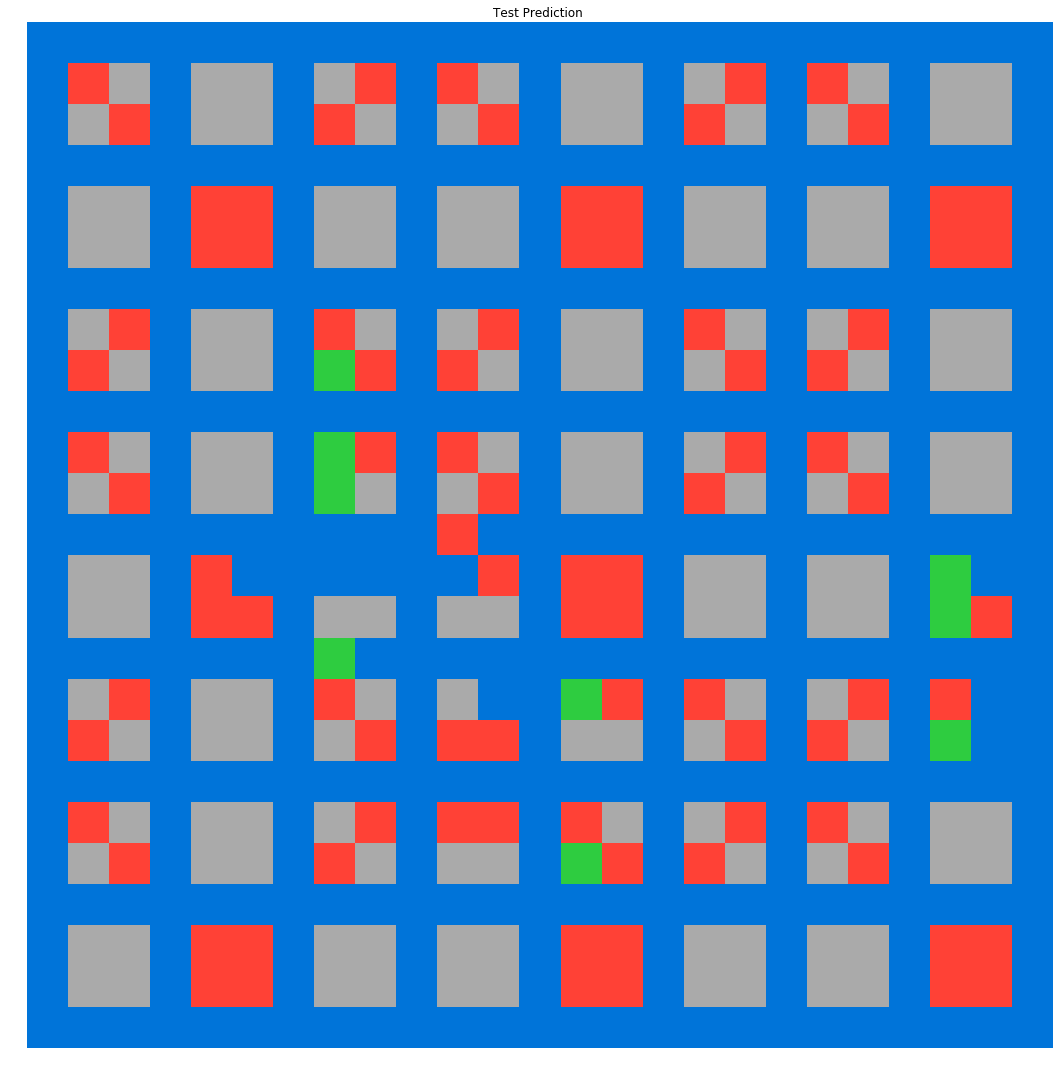

Made predictions for  1d398264
ensemble accuracy 0.7777777777777778



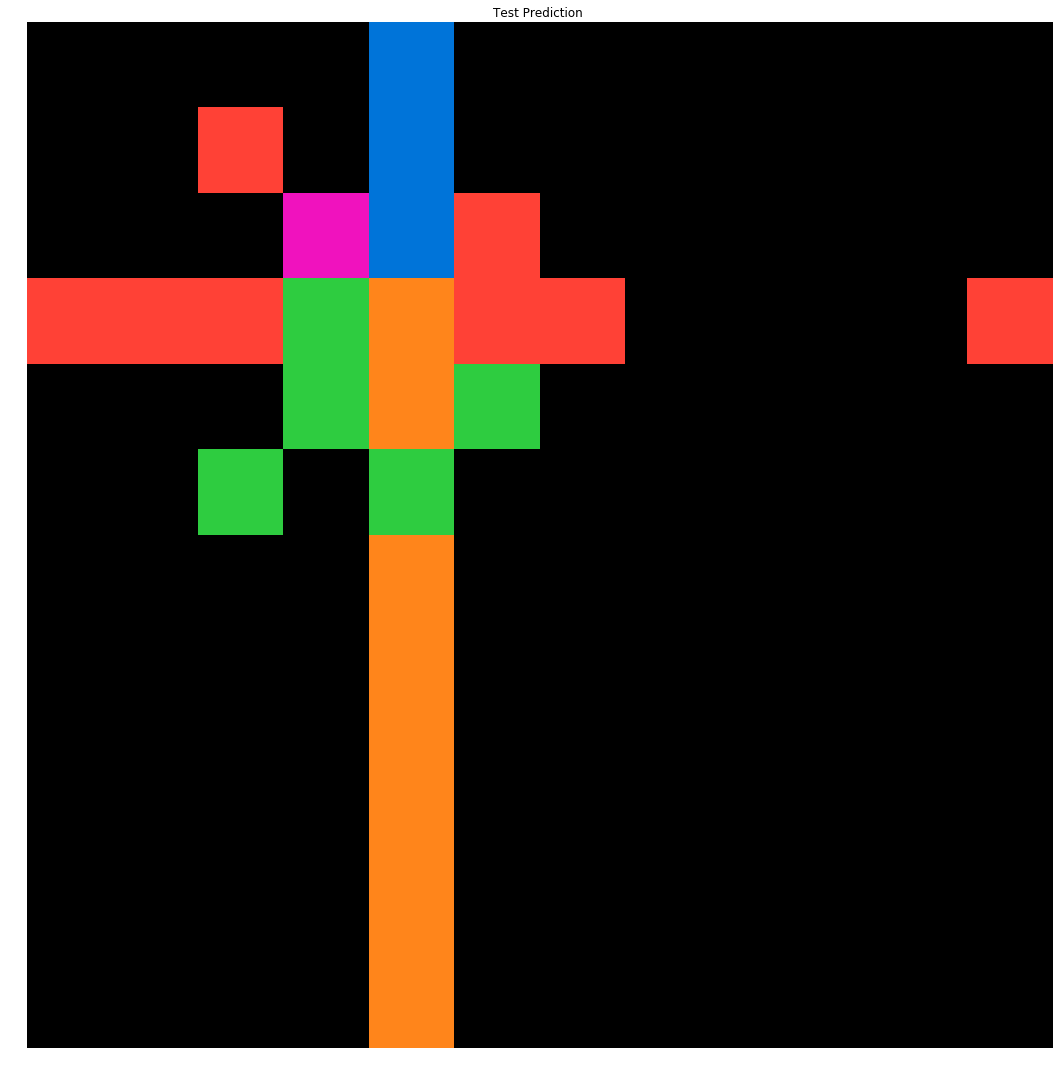

Made predictions for  1d398264
ensemble accuracy 0.82421875



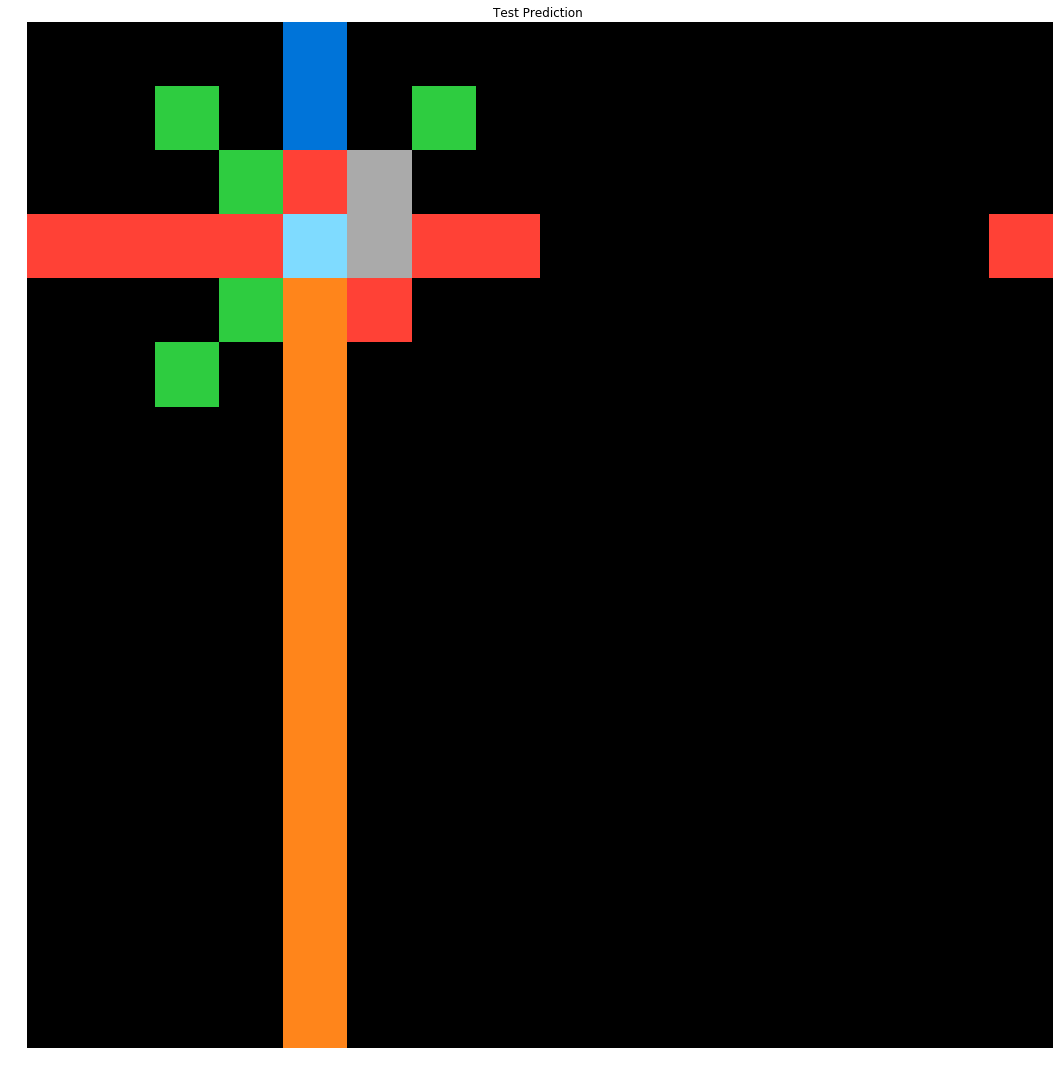

Made predictions for  1da012fc
ensemble accuracy 0.911578947368421



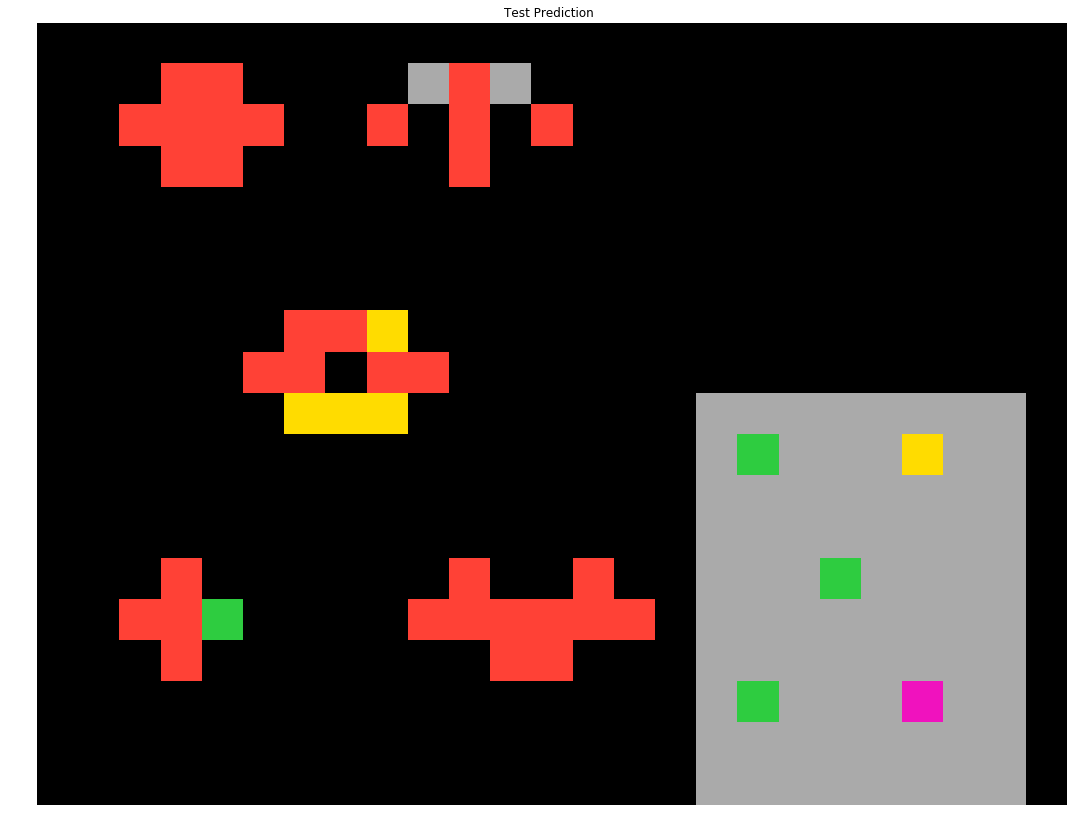

Made predictions for  1e81d6f9
ensemble accuracy 0.9733333333333334



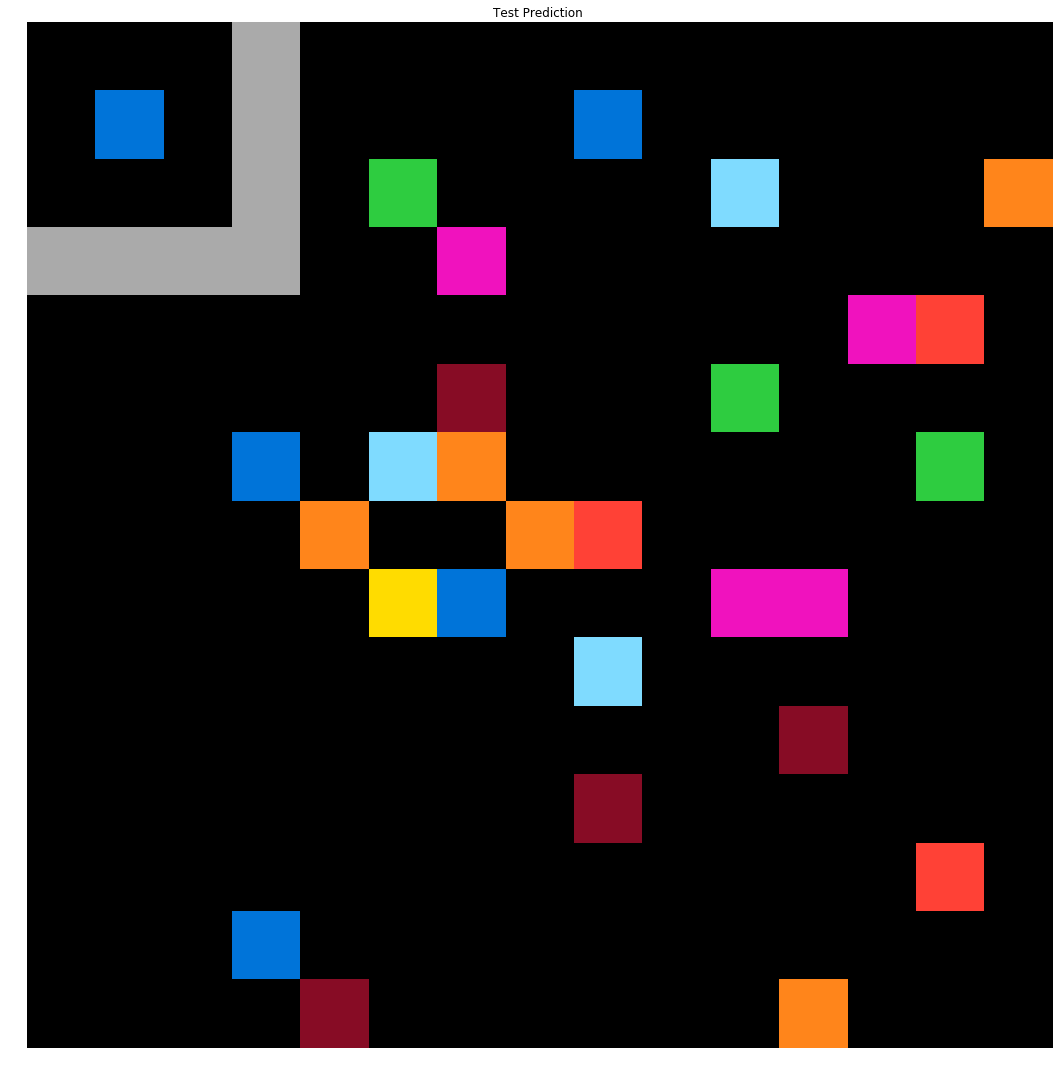

Made predictions for  1e97544e
ensemble accuracy 0.8733459357277883



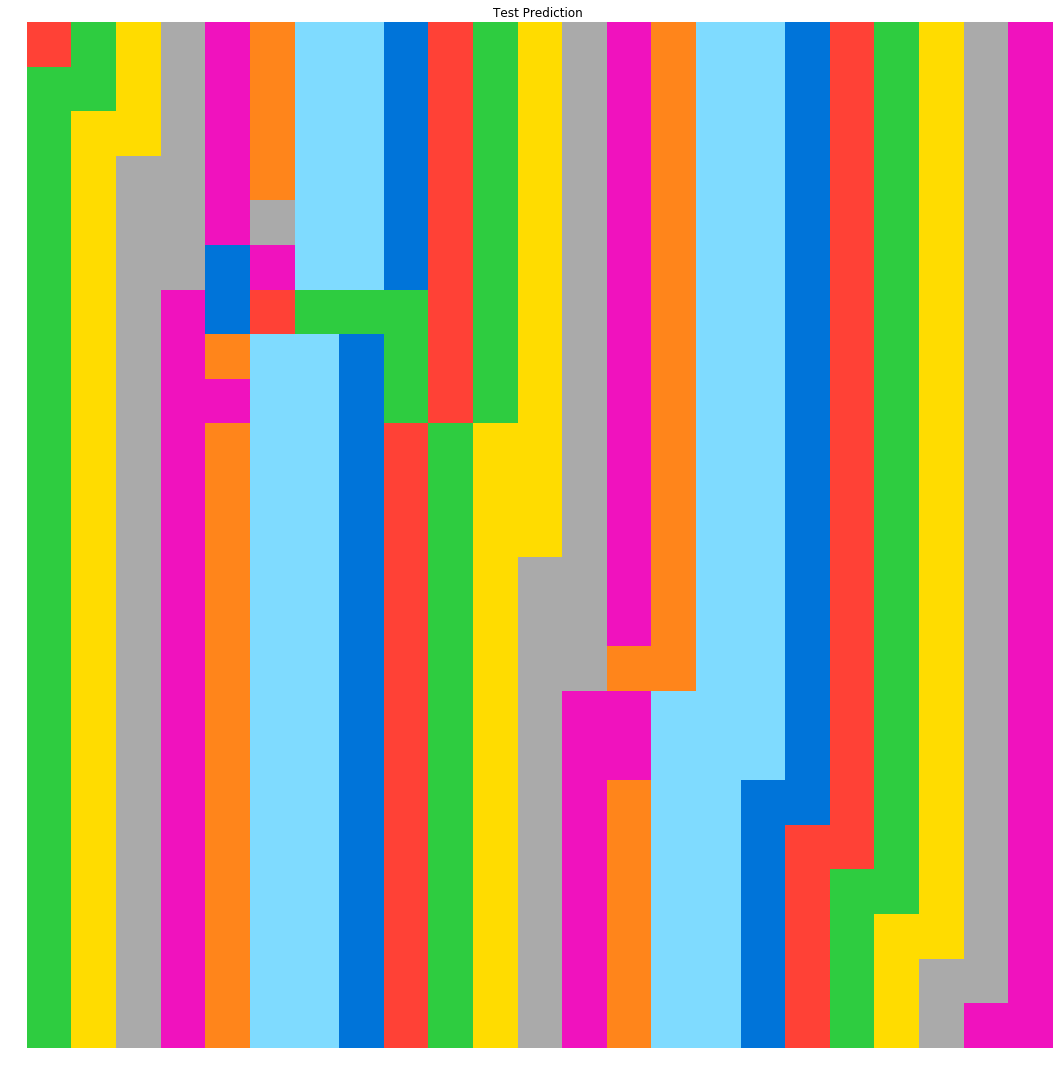

Number of input rows: 23 cols: 25
Number of target rows: 3 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\2037f2c7.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\2072aba6.json

Number of input rows: 14 cols: 15
Number of target rows: 6 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\20818e16.json

Made predictions for  20981f0e
ensemble accuracy 0.9140271493212669



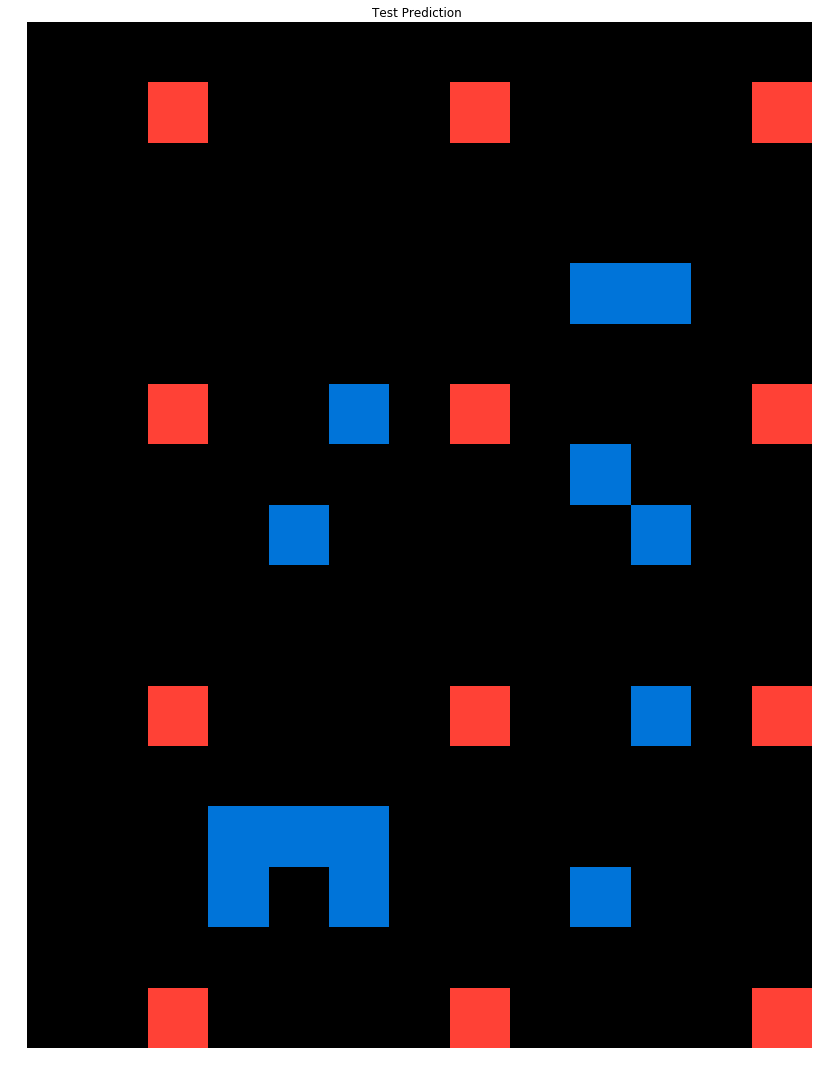

Made predictions for  212895b5
ensemble accuracy 0.9399585921325052



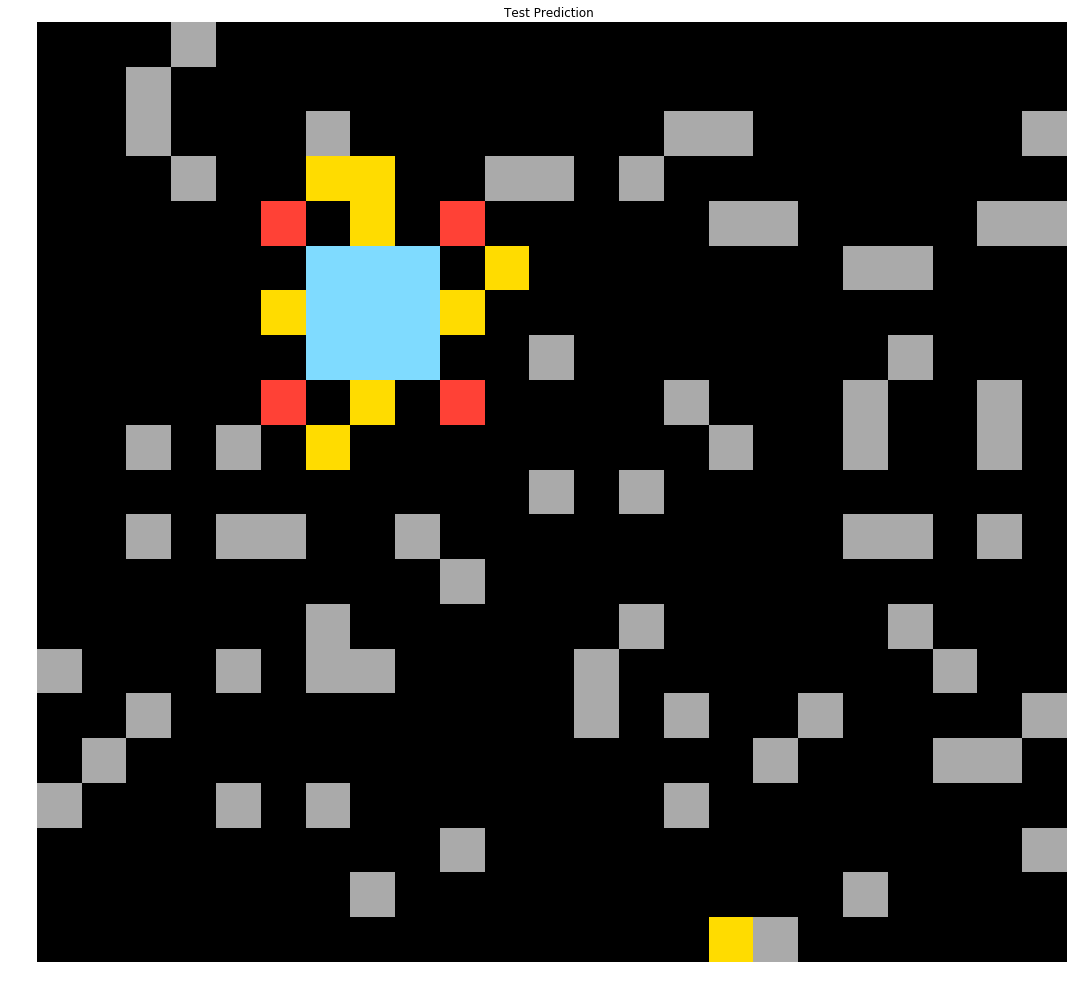

Made predictions for  21f83797
ensemble accuracy 0.6449704142011834



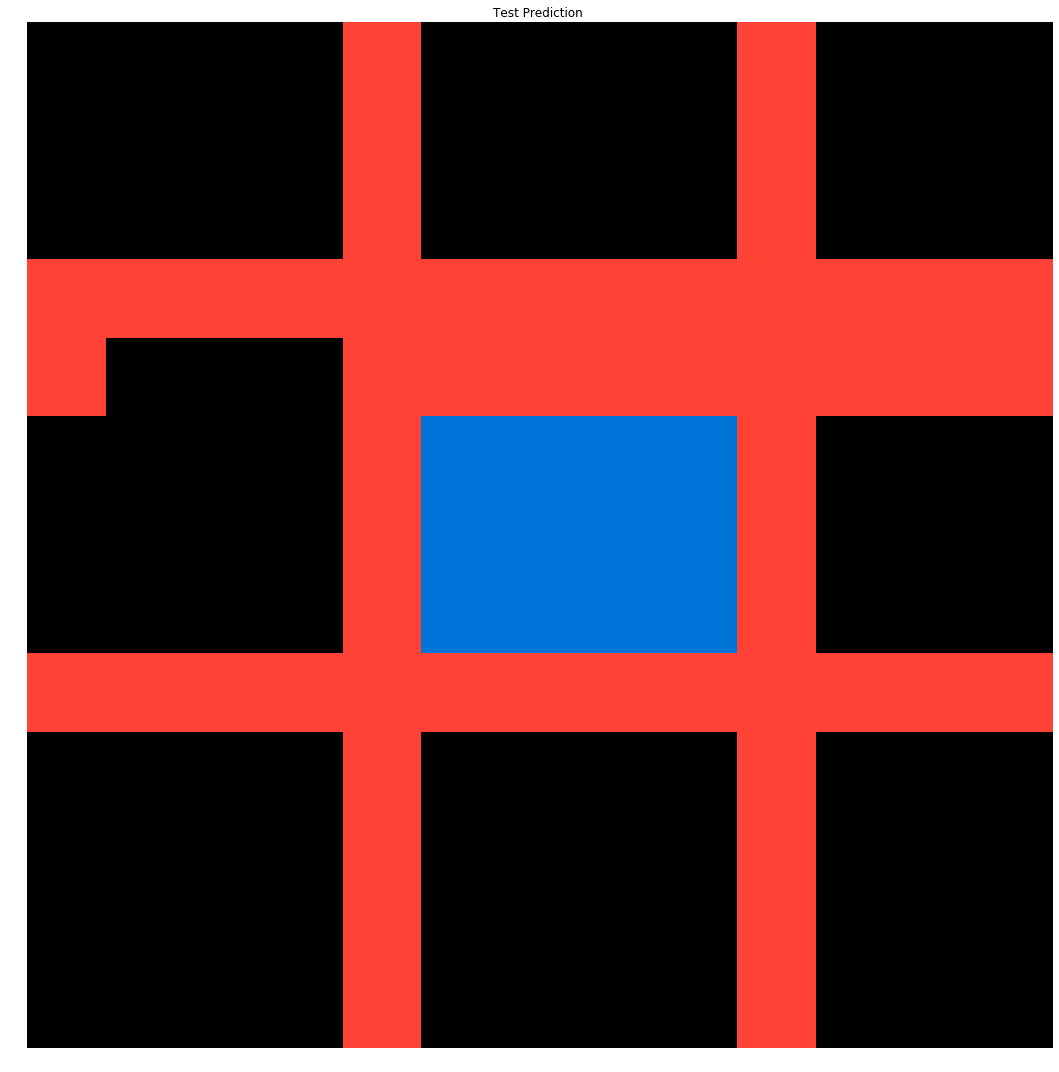

Made predictions for  22a4bbc2
ensemble accuracy 0.625



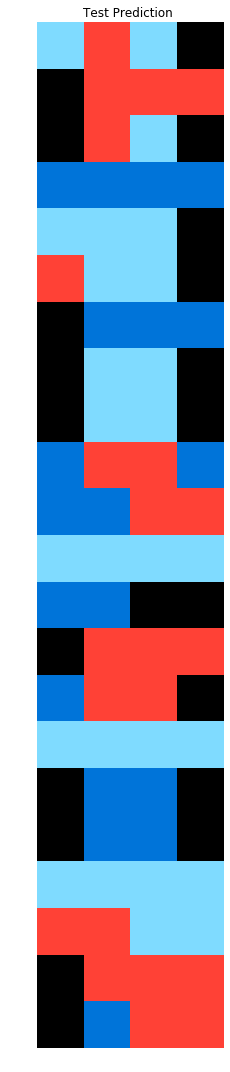

Made predictions for  25094a63
ensemble accuracy 0.9766666666666667



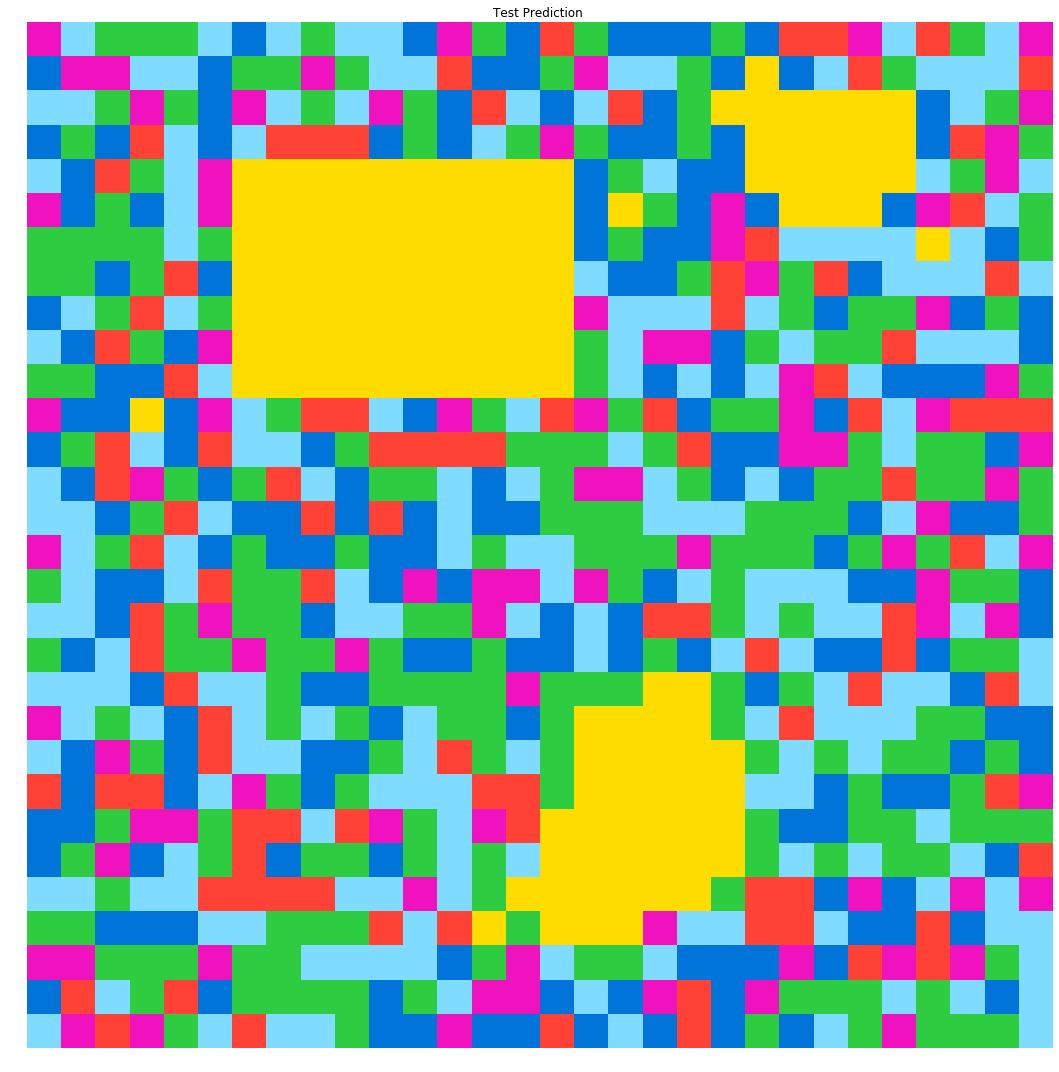

Made predictions for  2546ccf6
ensemble accuracy 0.6655518394648829



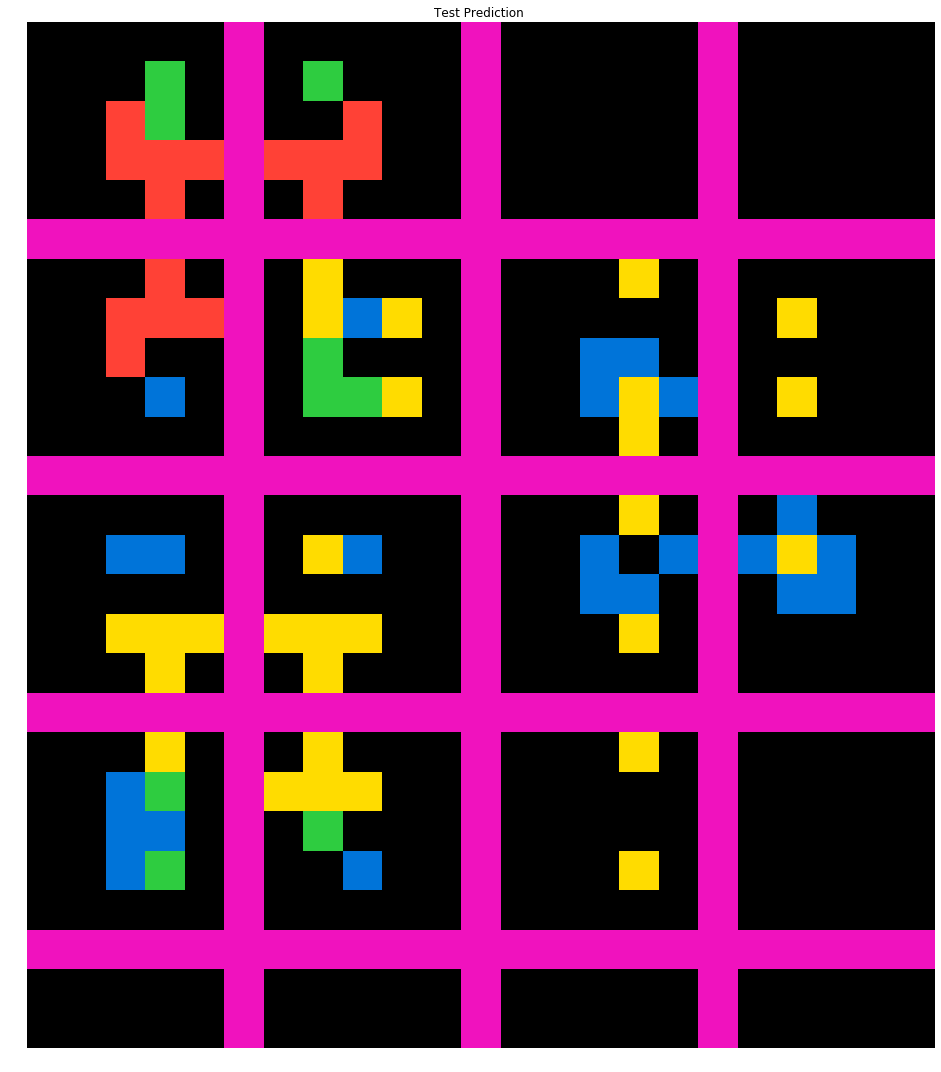

Made predictions for  256b0a75
ensemble accuracy 0.44153846153846155



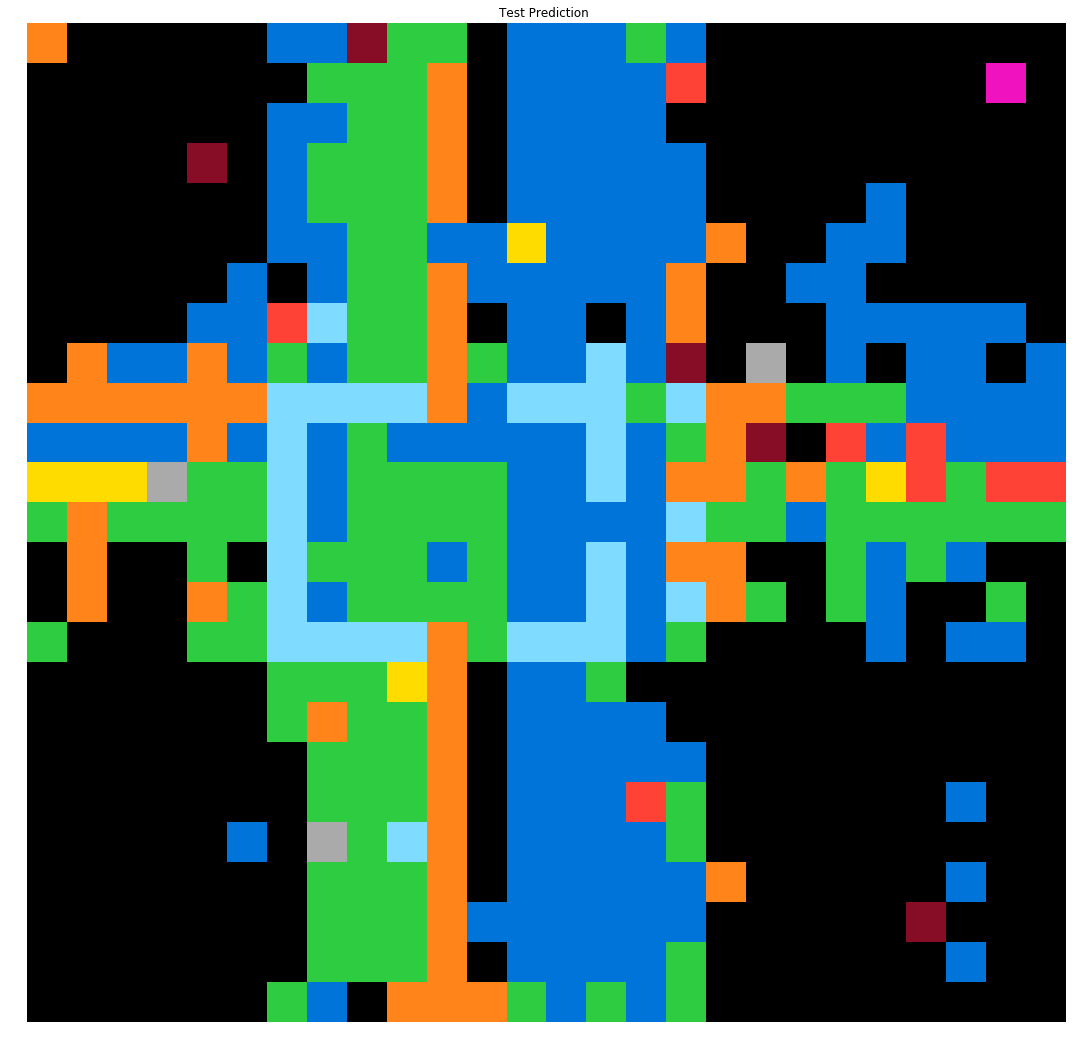

Made predictions for  2685904e
ensemble accuracy 0.87



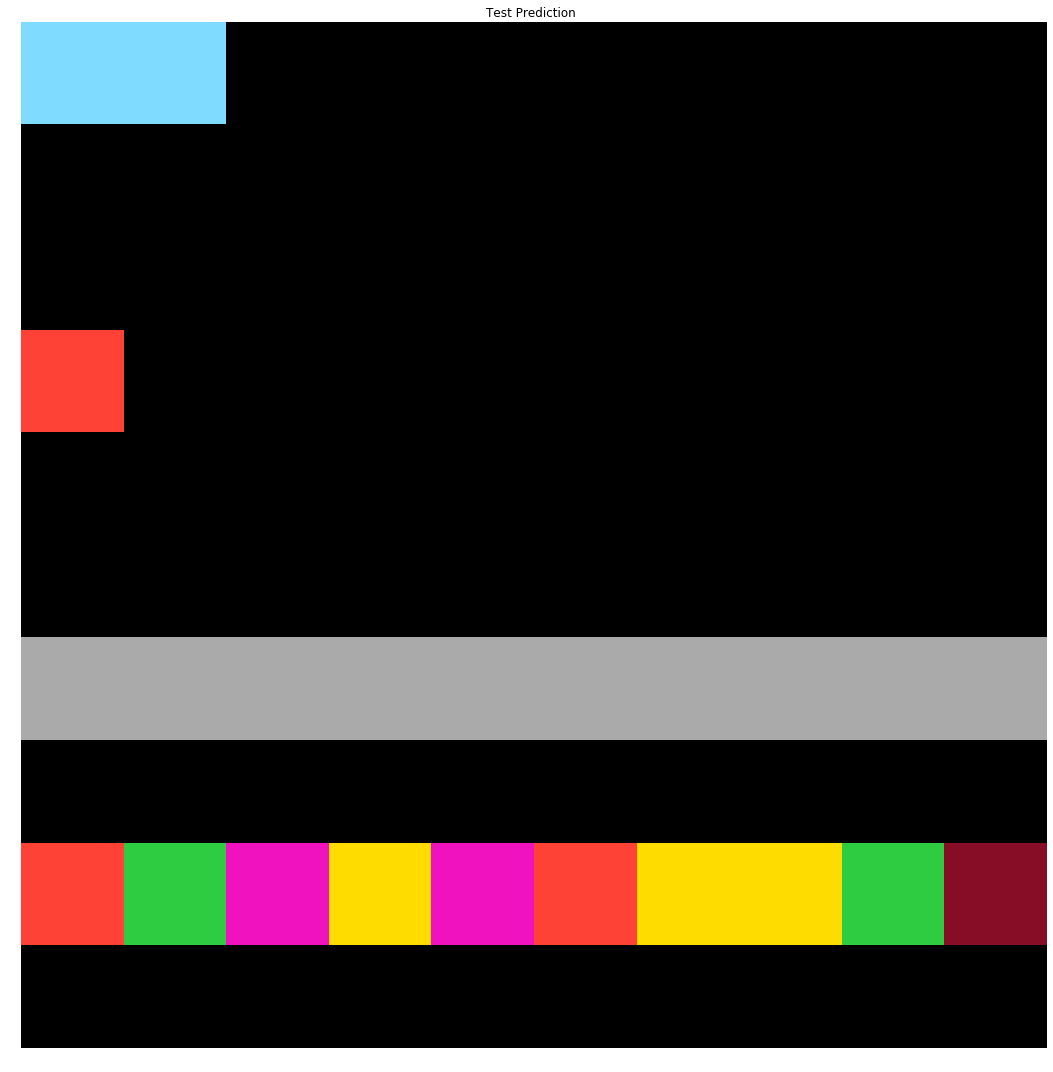

Number of input rows: 9 cols: 7
Number of target rows: 15 cols: 15
ignoring task abstraction-and-reasoning-challenge\evaluation\2697da3f.json

Number of input rows: 16 cols: 16
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\2753e76c.json

Made predictions for  27a77e38
ensemble accuracy 0.9753086419753086



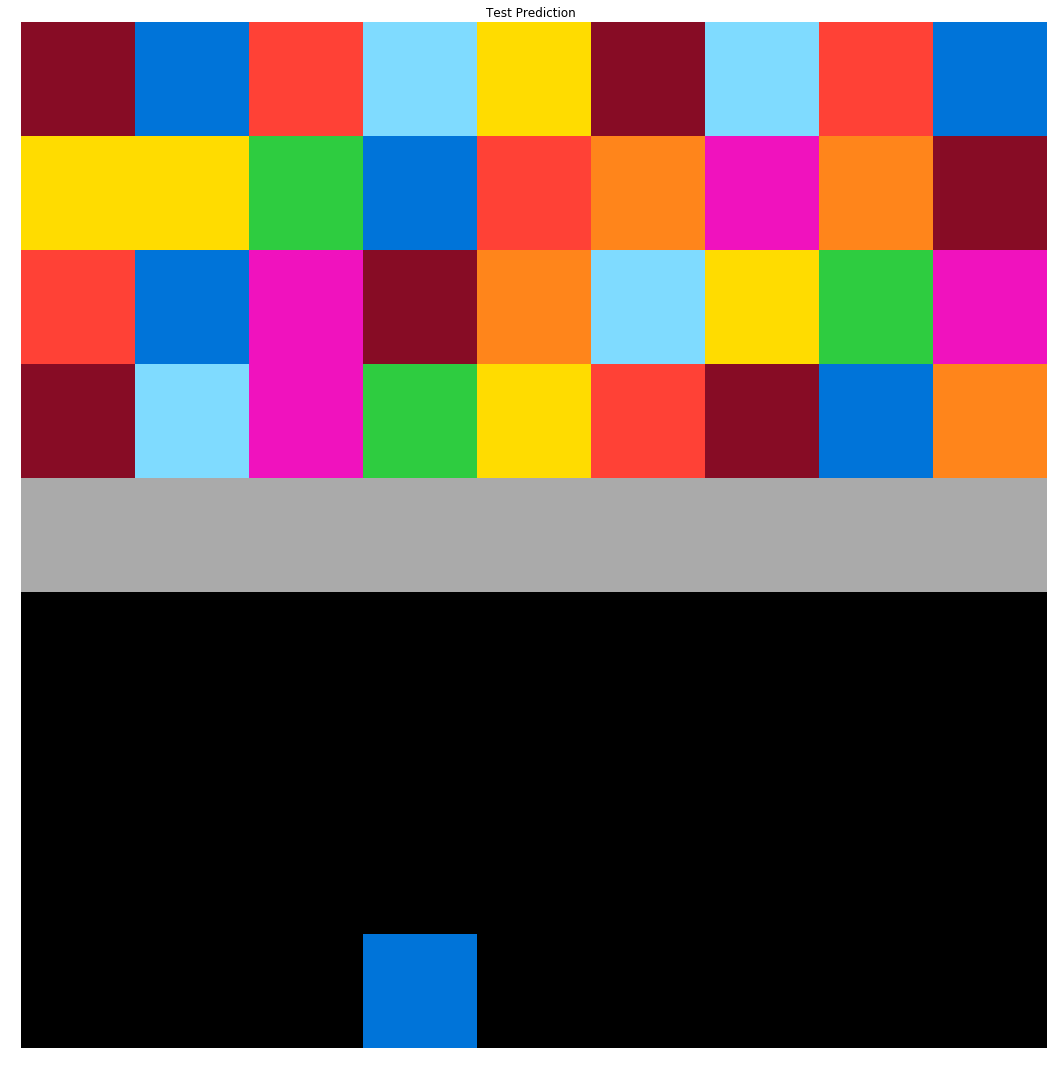

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\27f8ce4f.json

Number of input rows: 4 cols: 19
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\281123b4.json

Made predictions for  292dd178
ensemble accuracy 0.2787878787878788



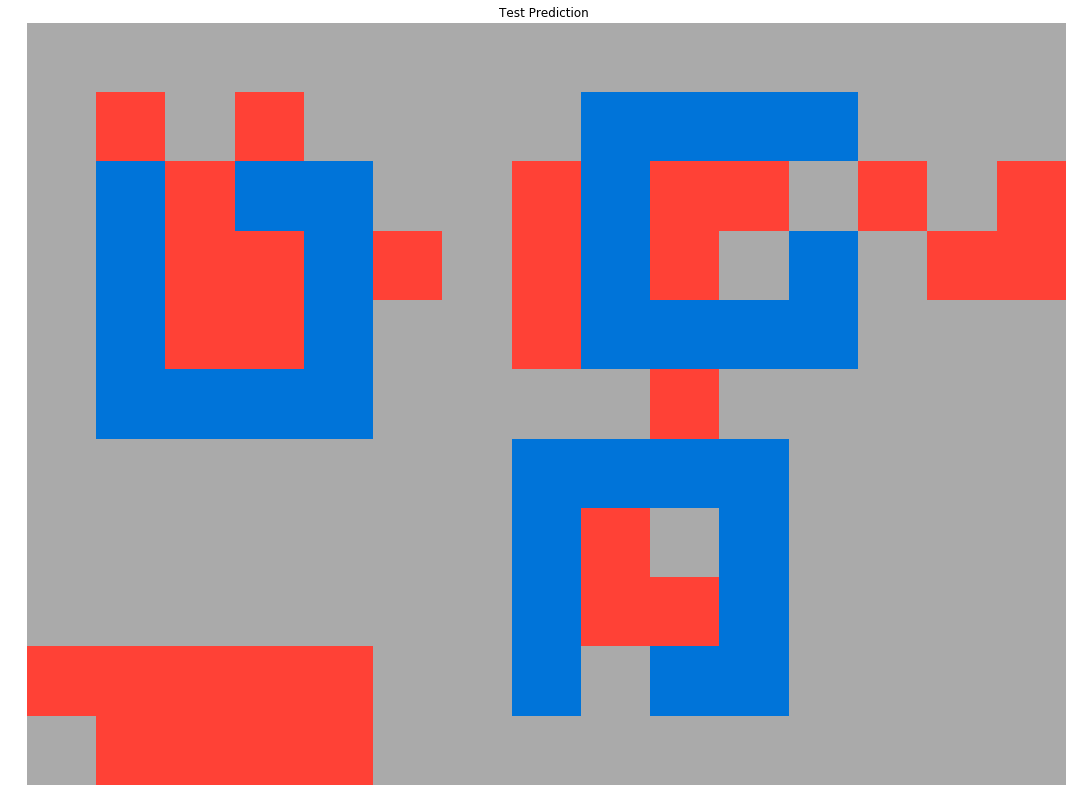

Made predictions for  29700607
ensemble accuracy 0.7768595041322314



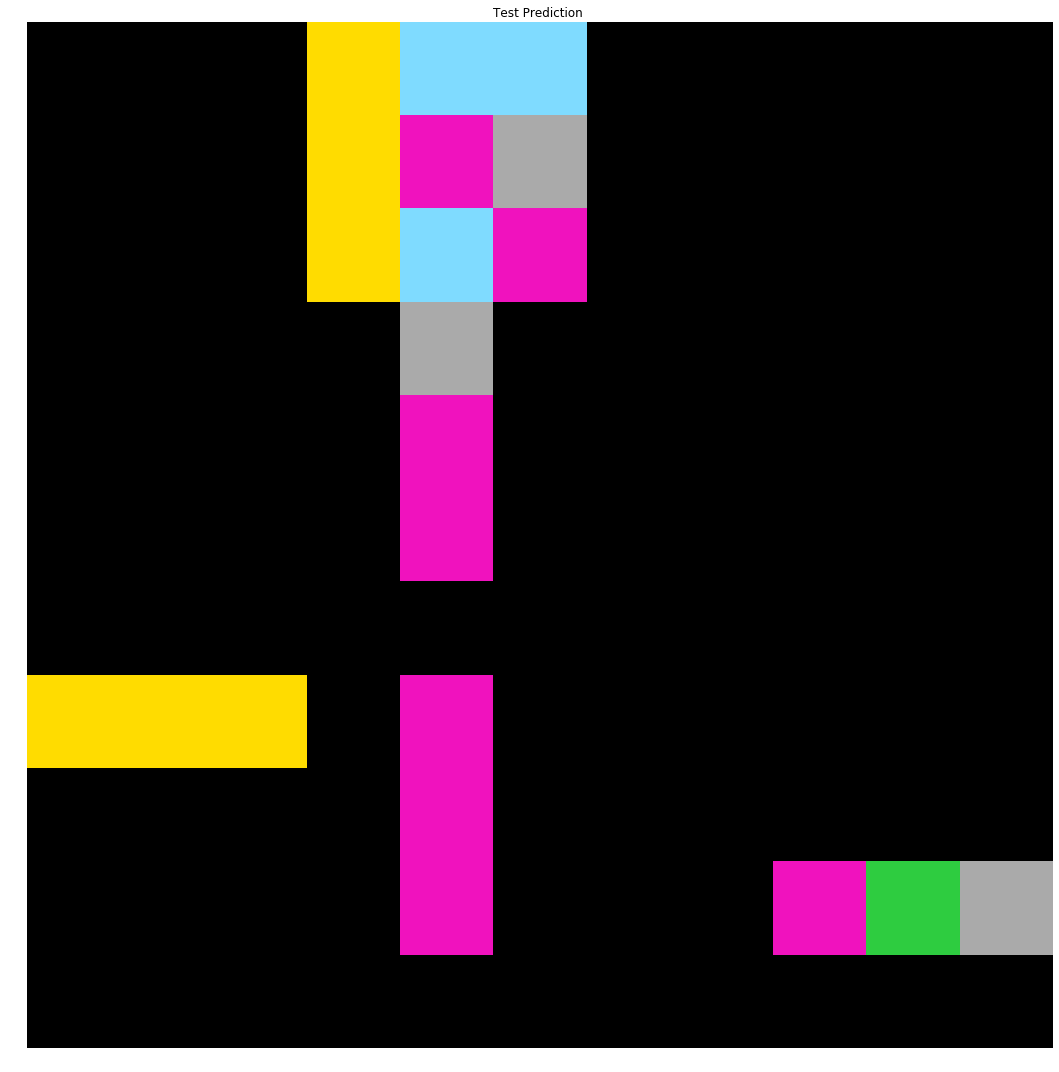

Made predictions for  2a5f8217
ensemble accuracy 0.8284023668639053



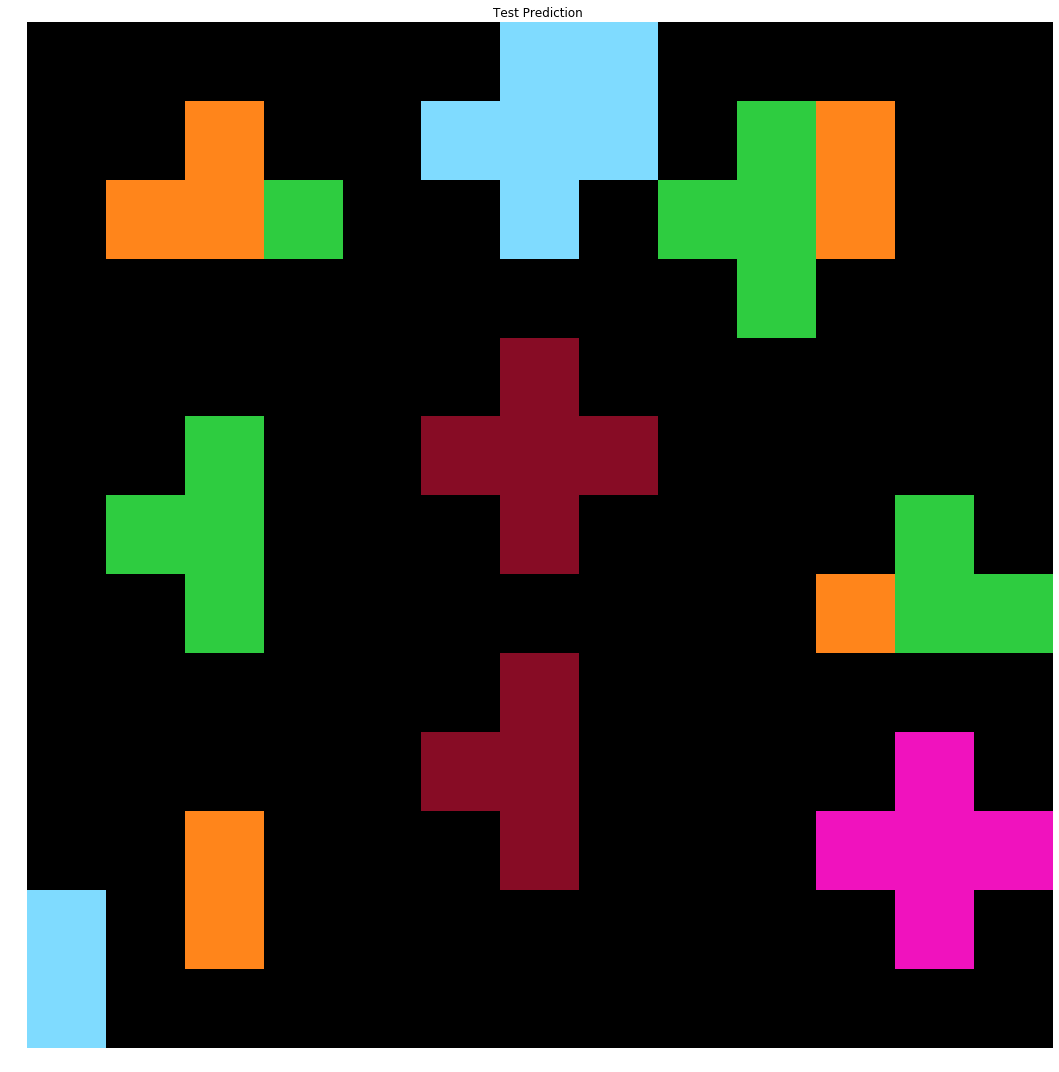

Made predictions for  2b01abd0
ensemble accuracy 0.9017857142857143



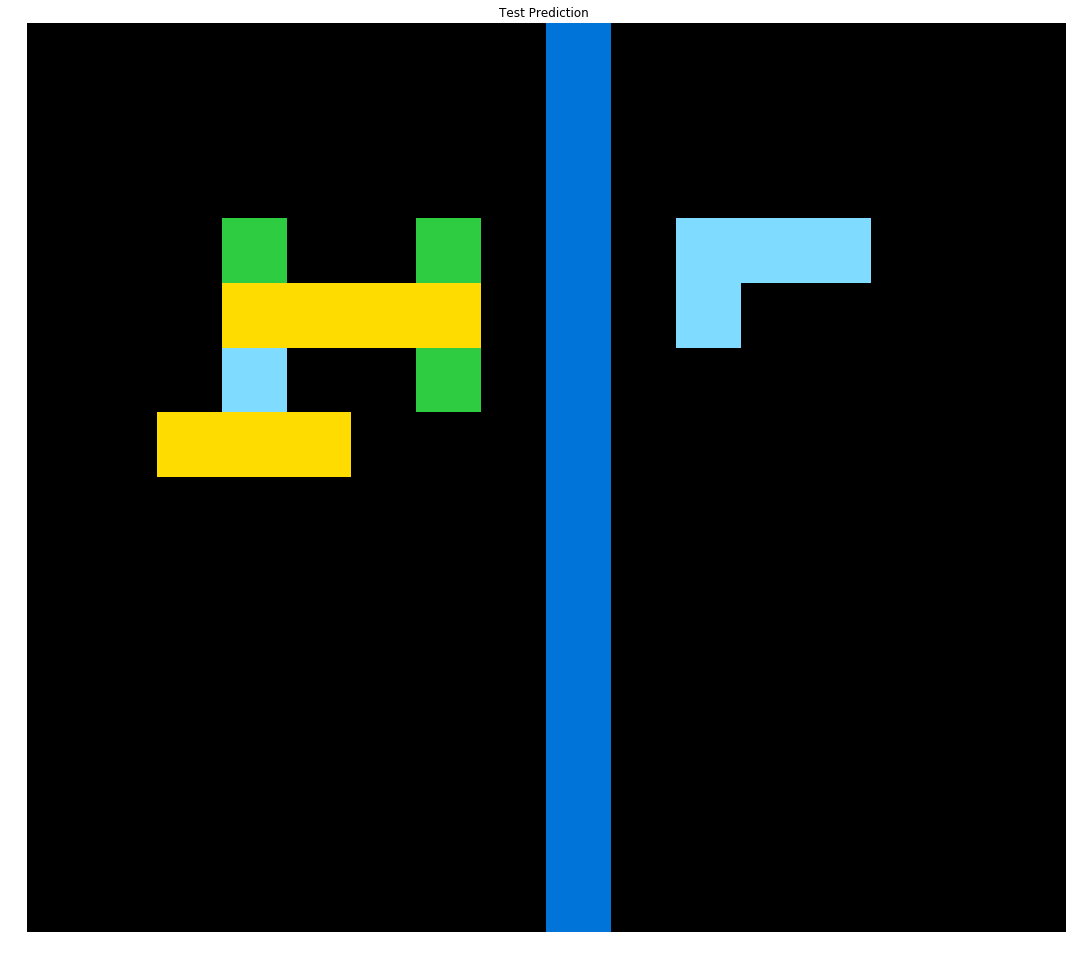

Number of input rows: 23 cols: 23
Number of target rows: 7 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\2c0b0aff.json

Made predictions for  2c737e39
ensemble accuracy 0.8636363636363636



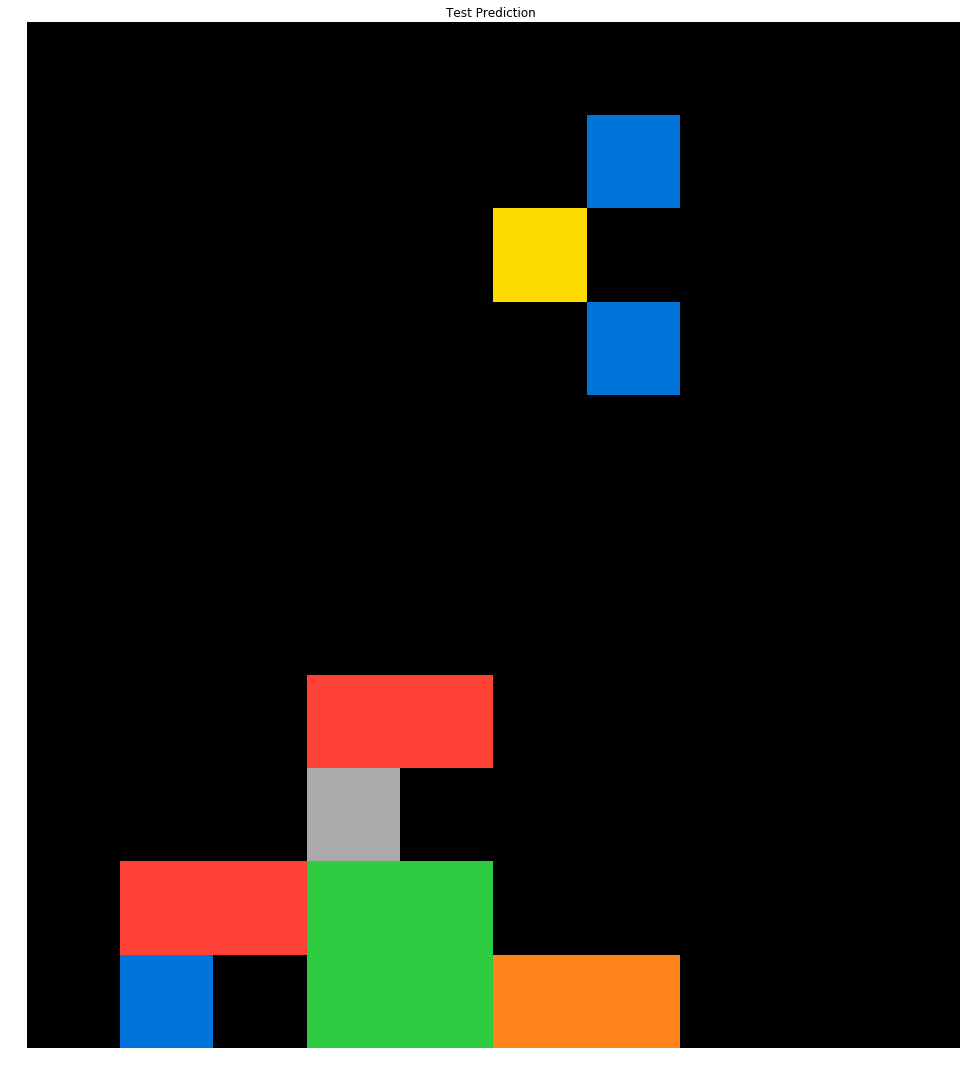

Number of input rows: 20 cols: 23
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\2f0c5170.json

Number of input rows: 2 cols: 2
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\310f3251.json

Number of input rows: 20 cols: 20
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\3194b014.json

Made predictions for  319f2597
ensemble accuracy 0.87



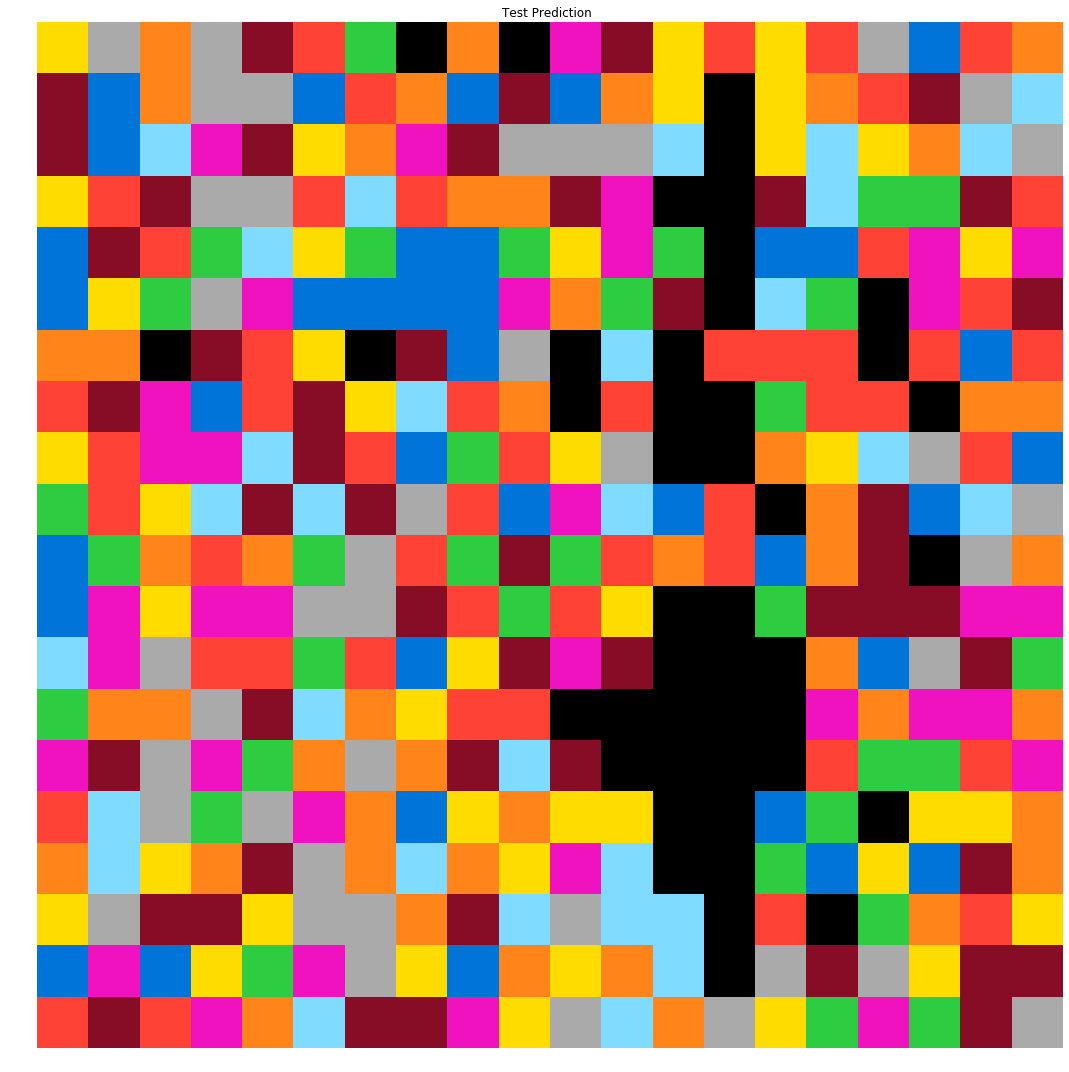

Made predictions for  31adaf00
ensemble accuracy 0.92



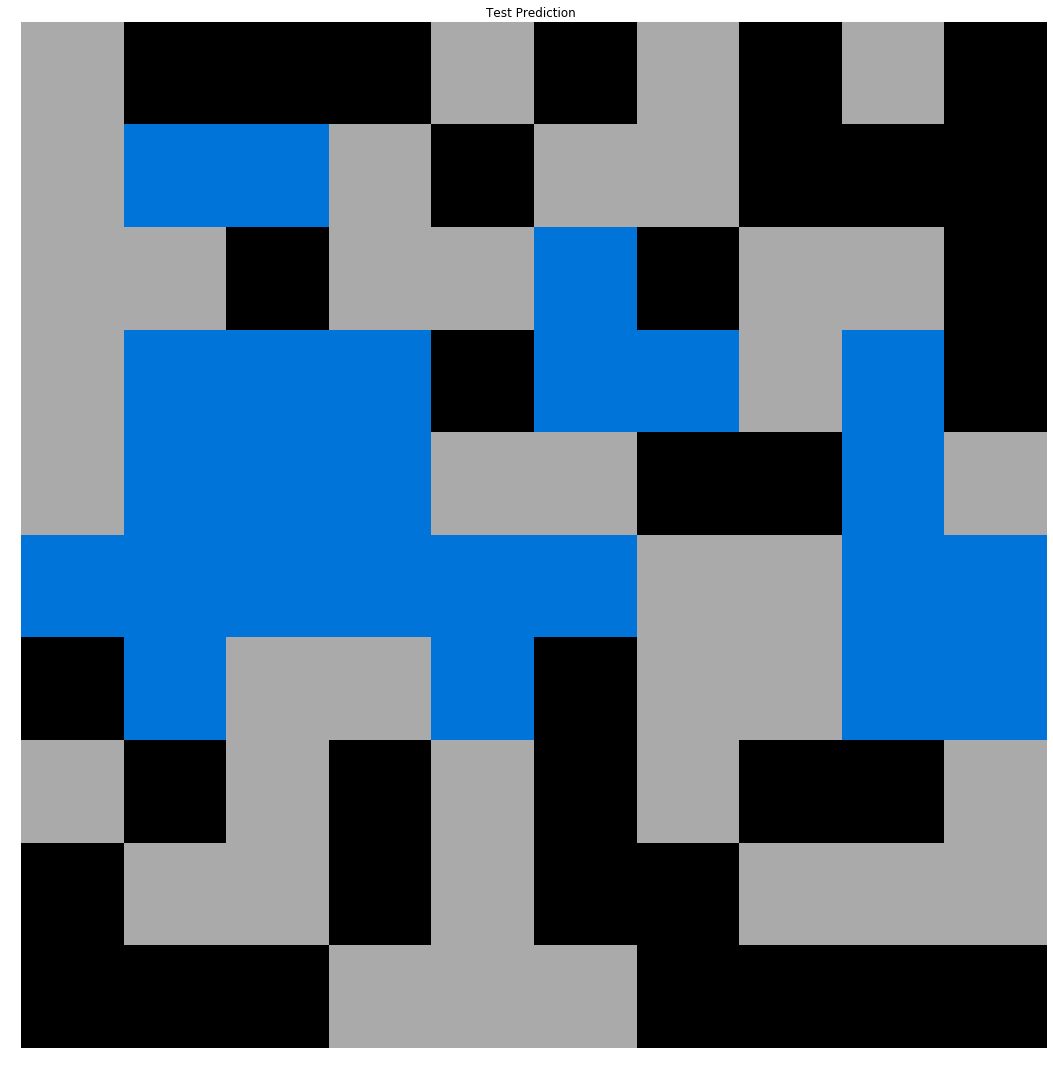

Number of input rows: 6 cols: 5
Number of target rows: 3 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\31d5ba1a.json

Made predictions for  32e9702f
ensemble accuracy 0.76



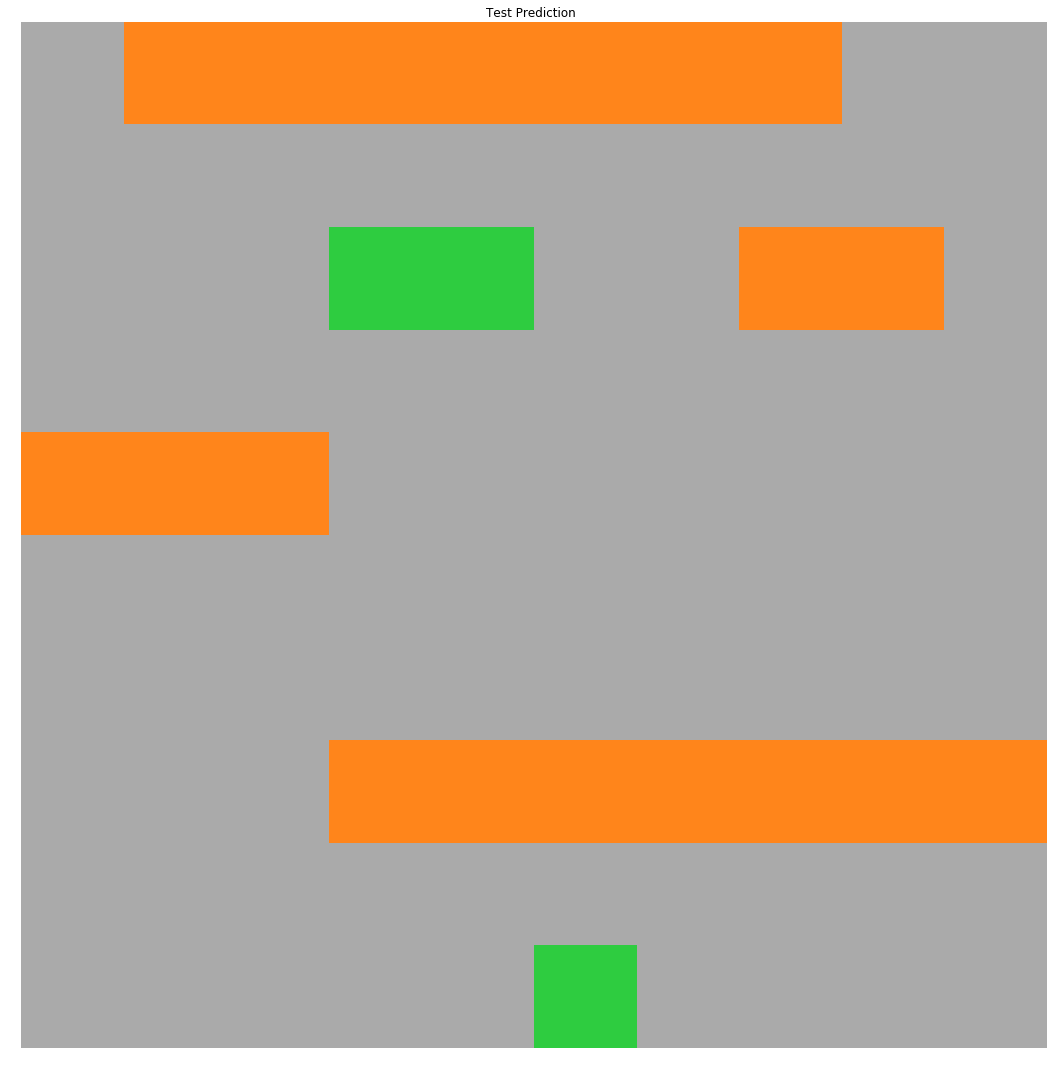

Made predictions for  332efdb3
ensemble accuracy 0.9256198347107438



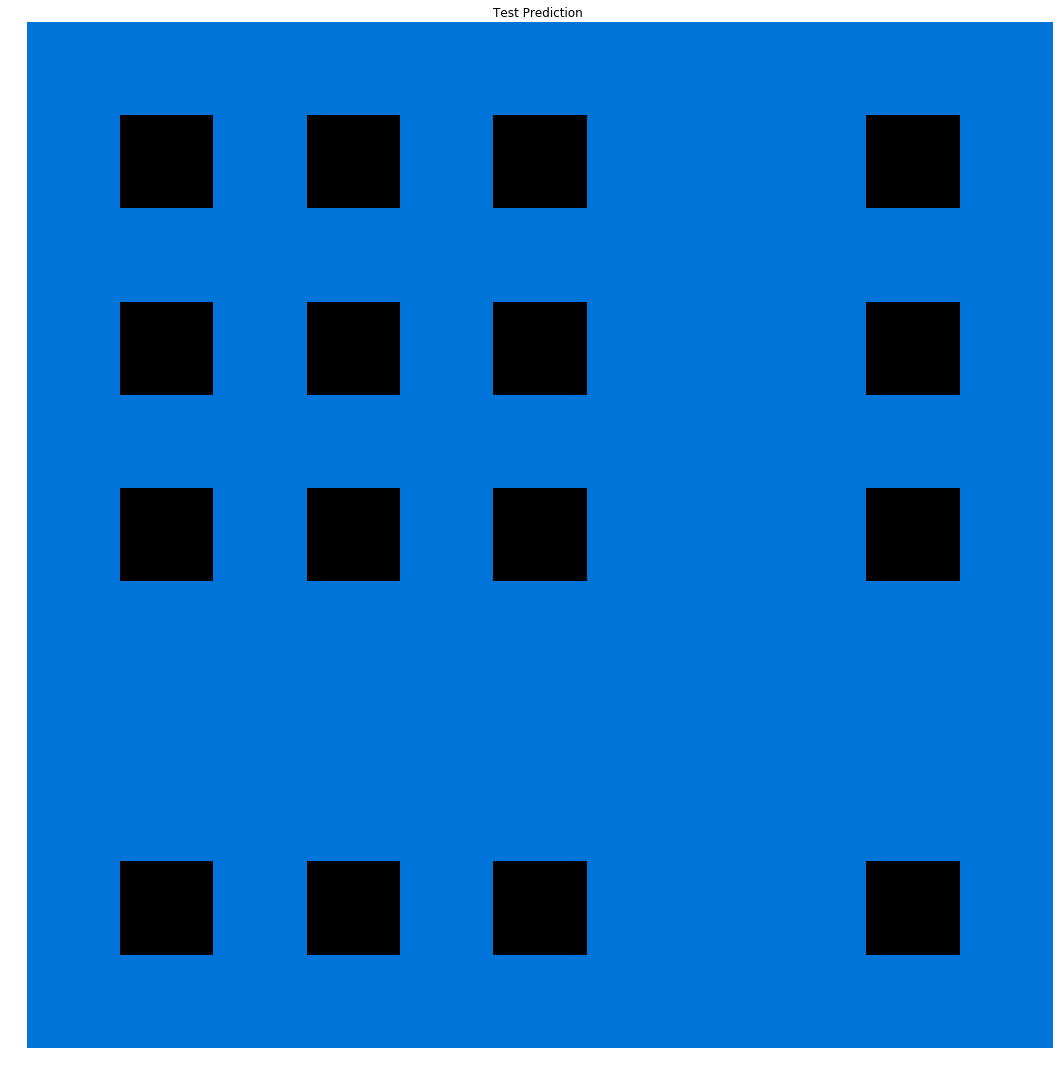

Made predictions for  3391f8c0
ensemble accuracy 0.7987012987012987



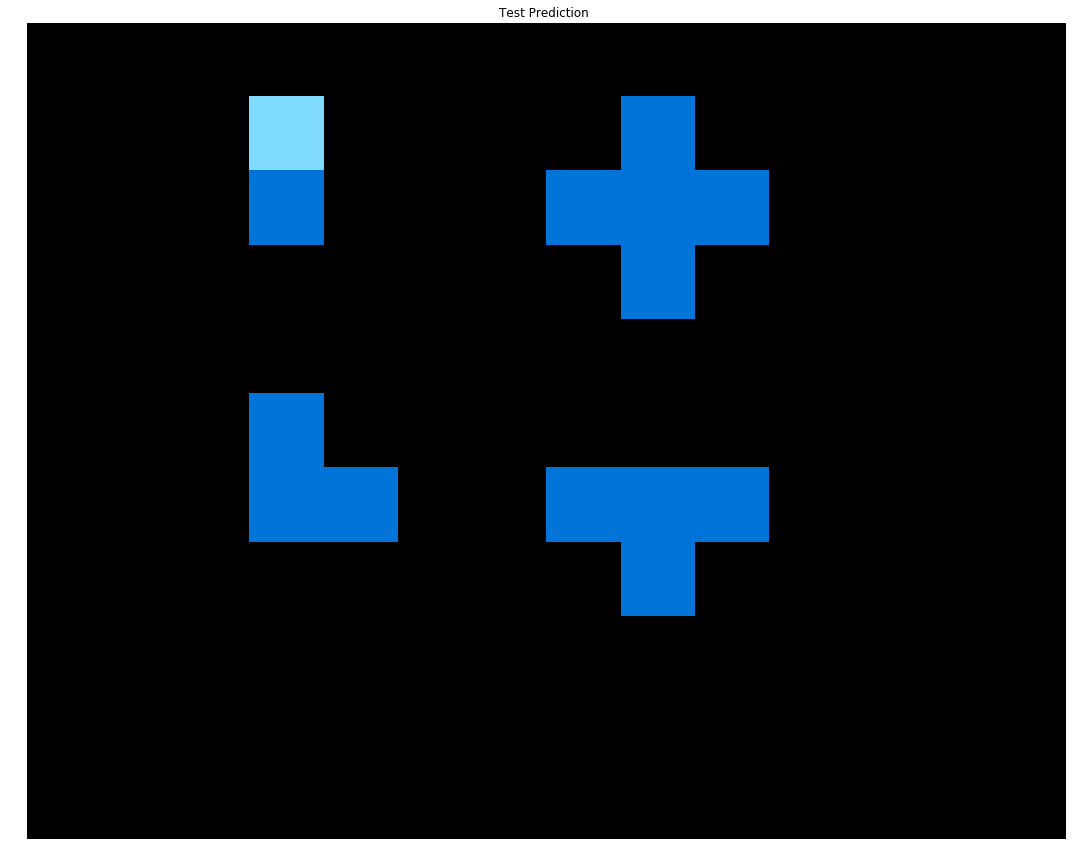

Made predictions for  33b52de3
ensemble accuracy 0.8241965973534972



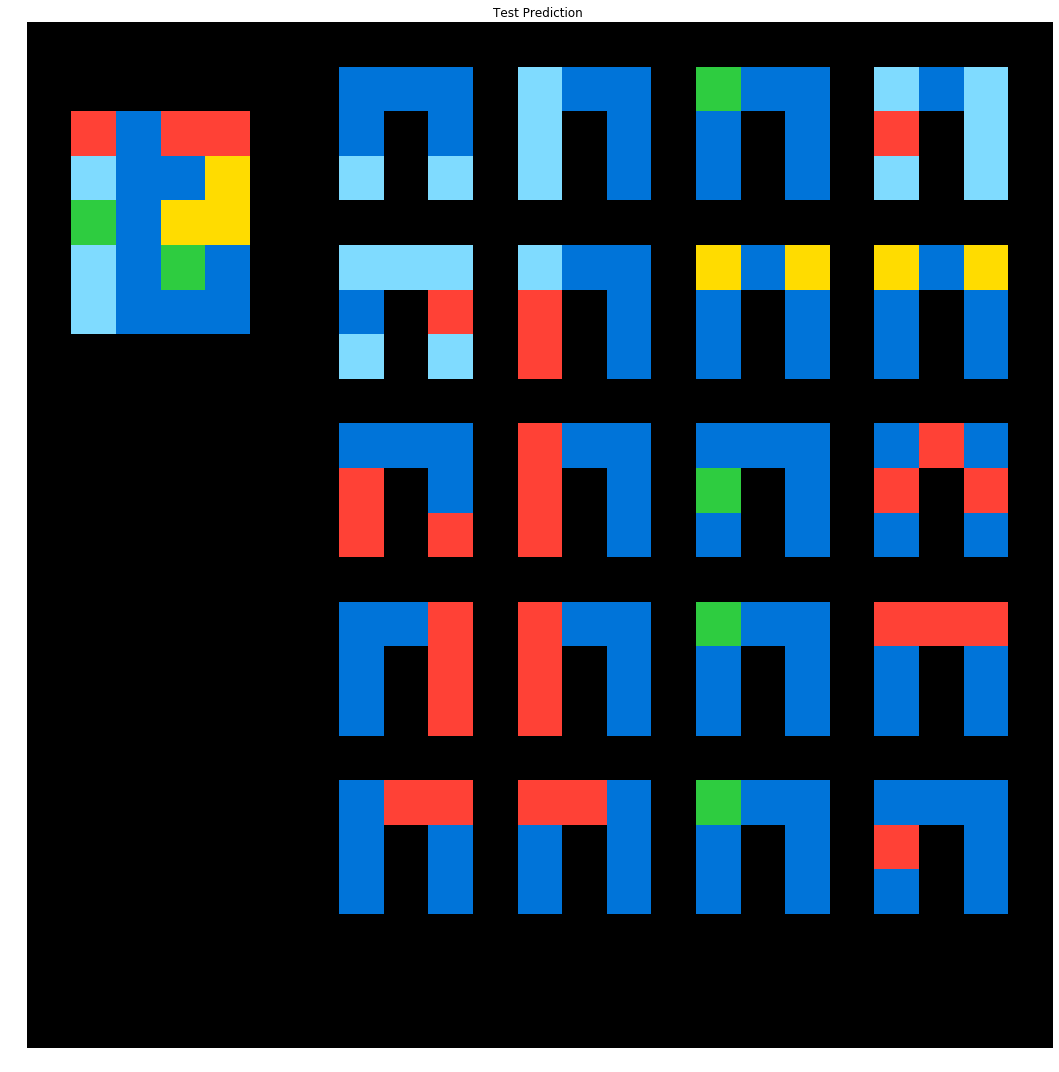

Made predictions for  3490cc26
ensemble accuracy 0.8320158102766798



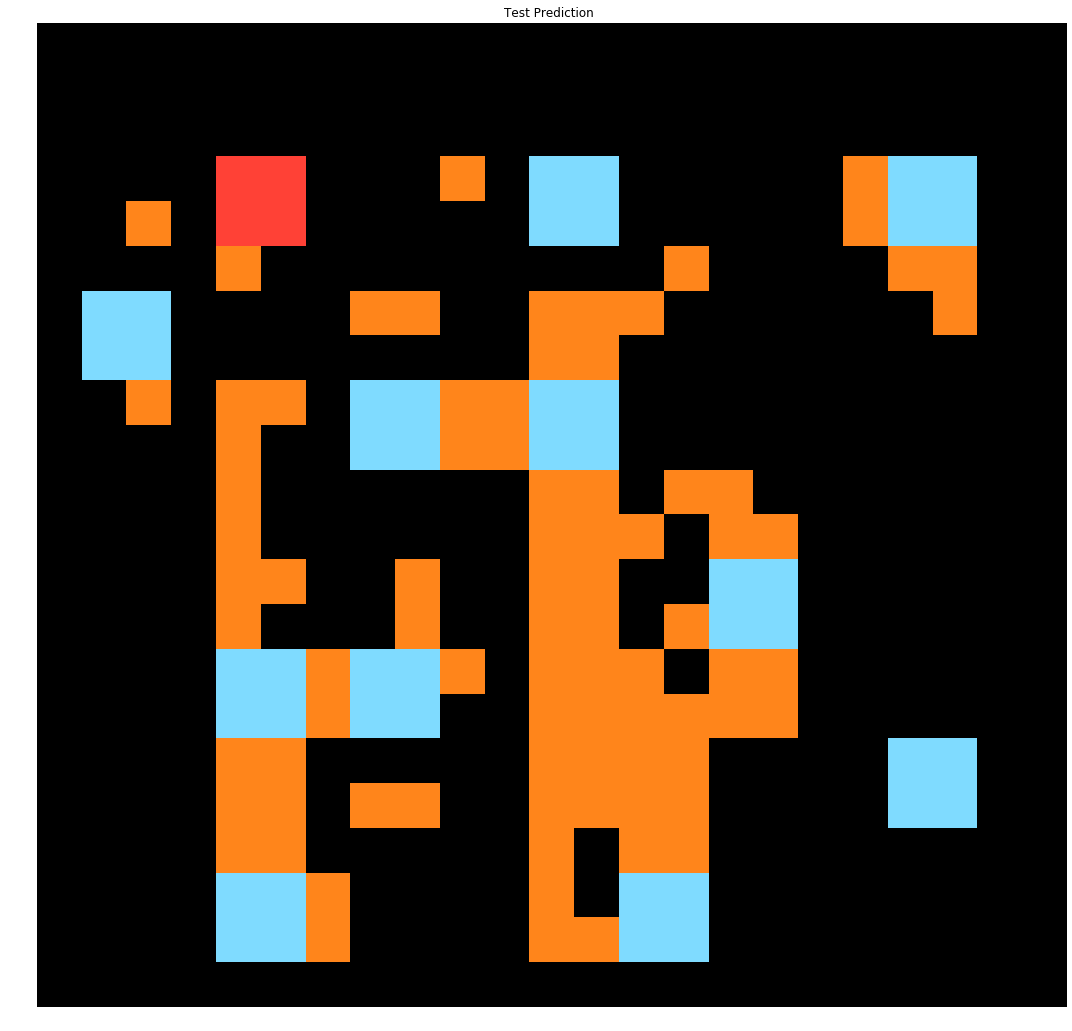

Number of input rows: 5 cols: 9
Number of target rows: 5 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\34b99a2b.json

Number of input rows: 15 cols: 13
Number of target rows: 3 cols: 13
ignoring task abstraction-and-reasoning-challenge\evaluation\351d6448.json

Number of input rows: 14 cols: 18
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\358ba94e.json

Made predictions for  37d3e8b2
ensemble accuracy 0.6928104575163399



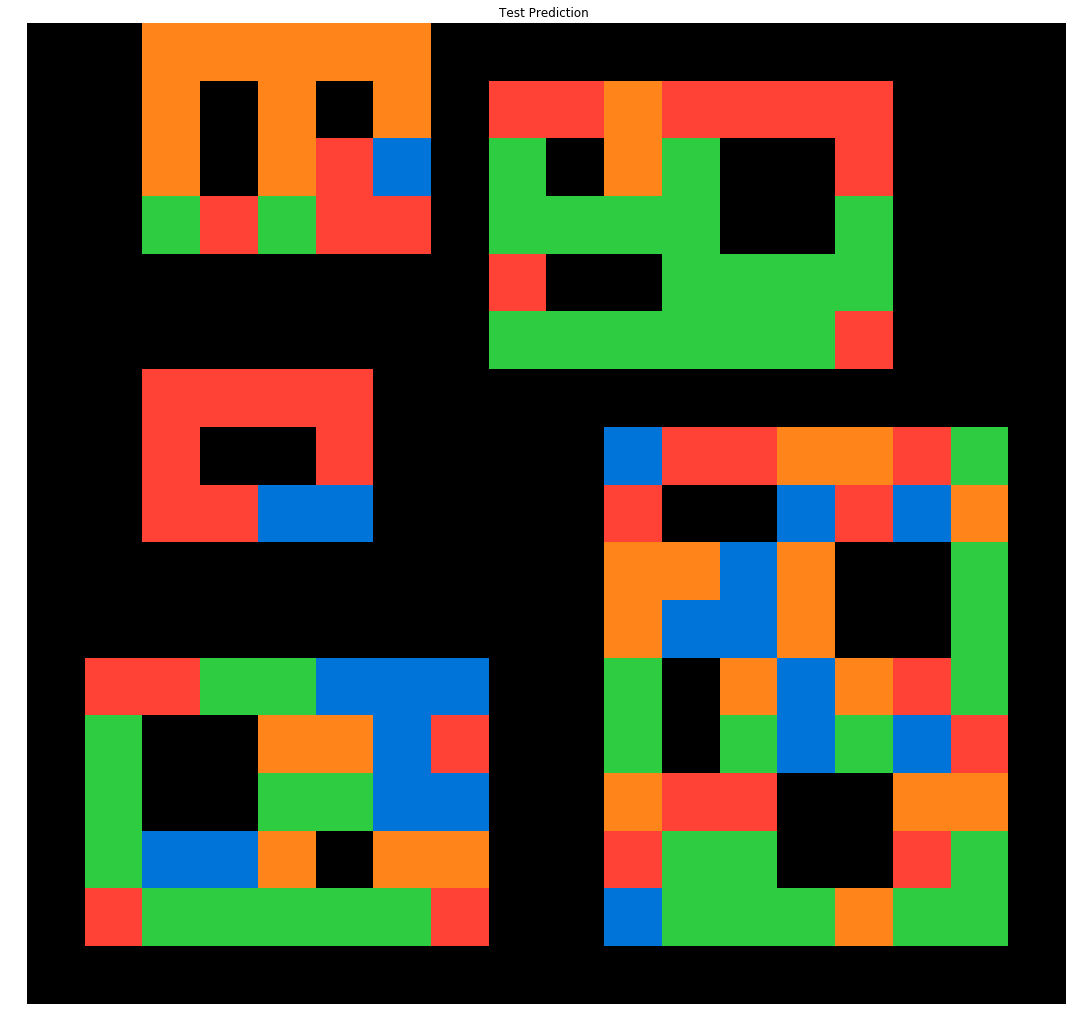

Number of input rows: 5 cols: 5
Number of target rows: 10 cols: 10
ignoring task abstraction-and-reasoning-challenge\evaluation\3979b1a8.json

Made predictions for  3a301edc
ensemble accuracy 0.5963718820861678



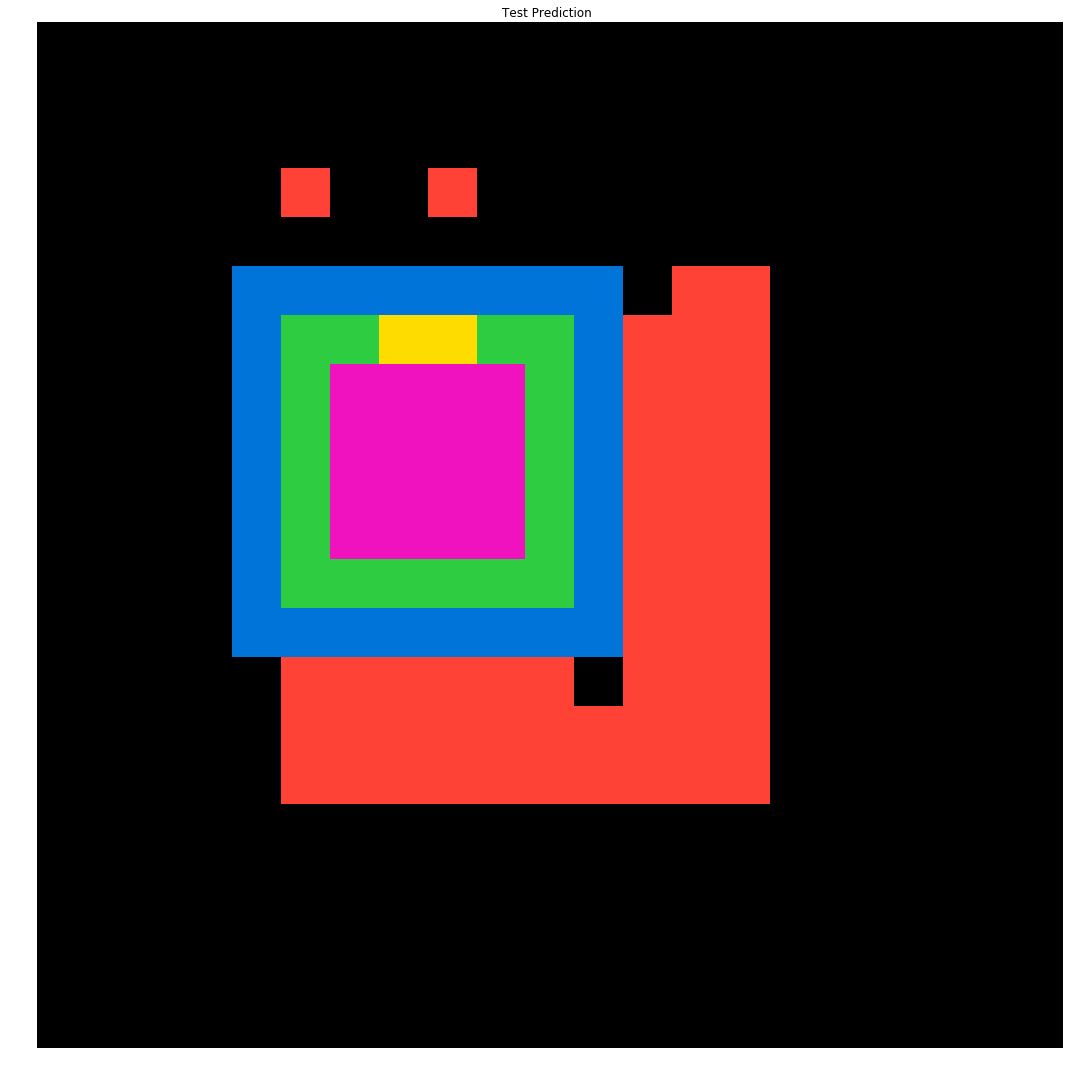

Number of input rows: 7 cols: 7
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\3b4c2228.json

Number of input rows: 12 cols: 6
Number of target rows: 3 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\3d31c5b3.json

Made predictions for  3ed85e70
ensemble accuracy 0.9522222222222222



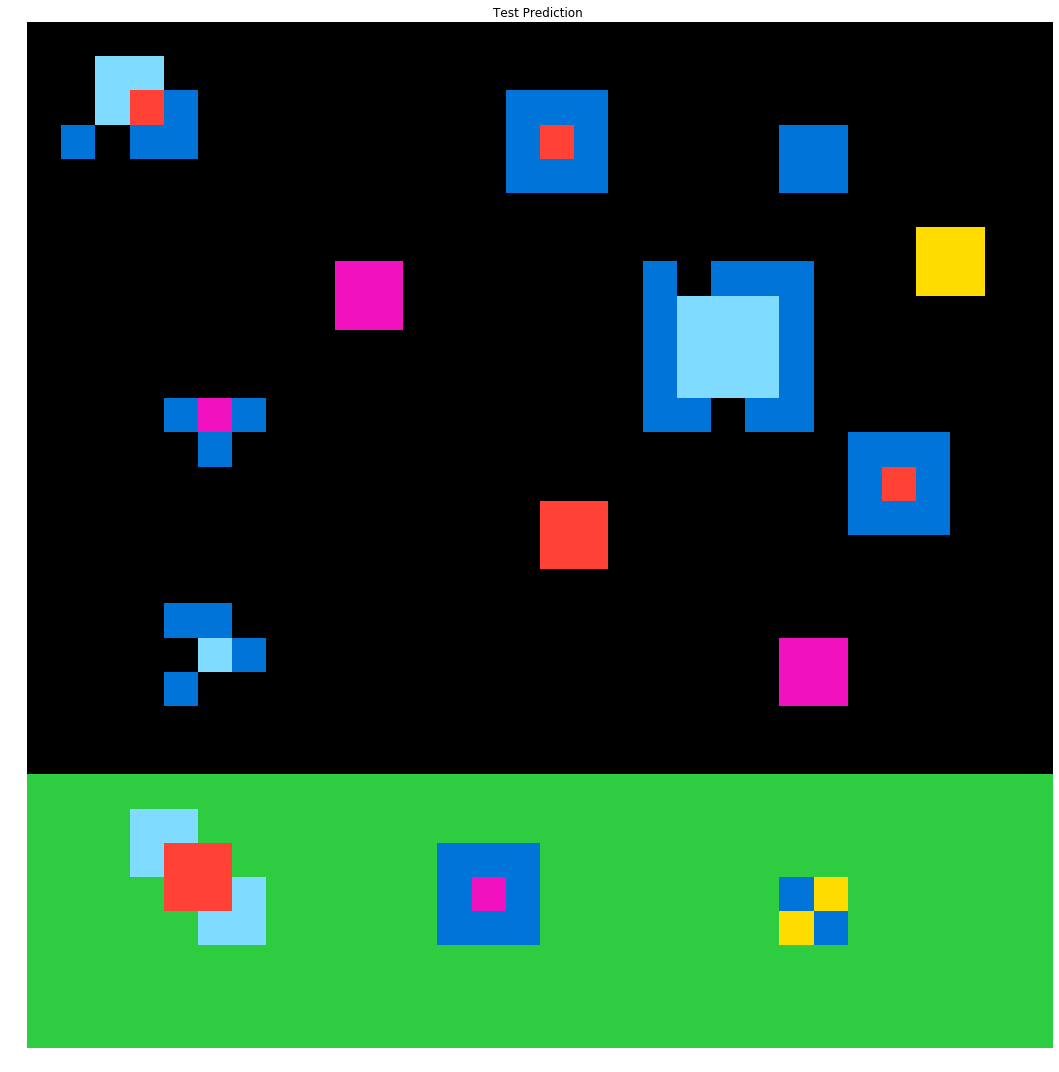

Number of input rows: 23 cols: 29
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\3ee1011a.json

Made predictions for  3f23242b
ensemble accuracy 0.6408668730650154



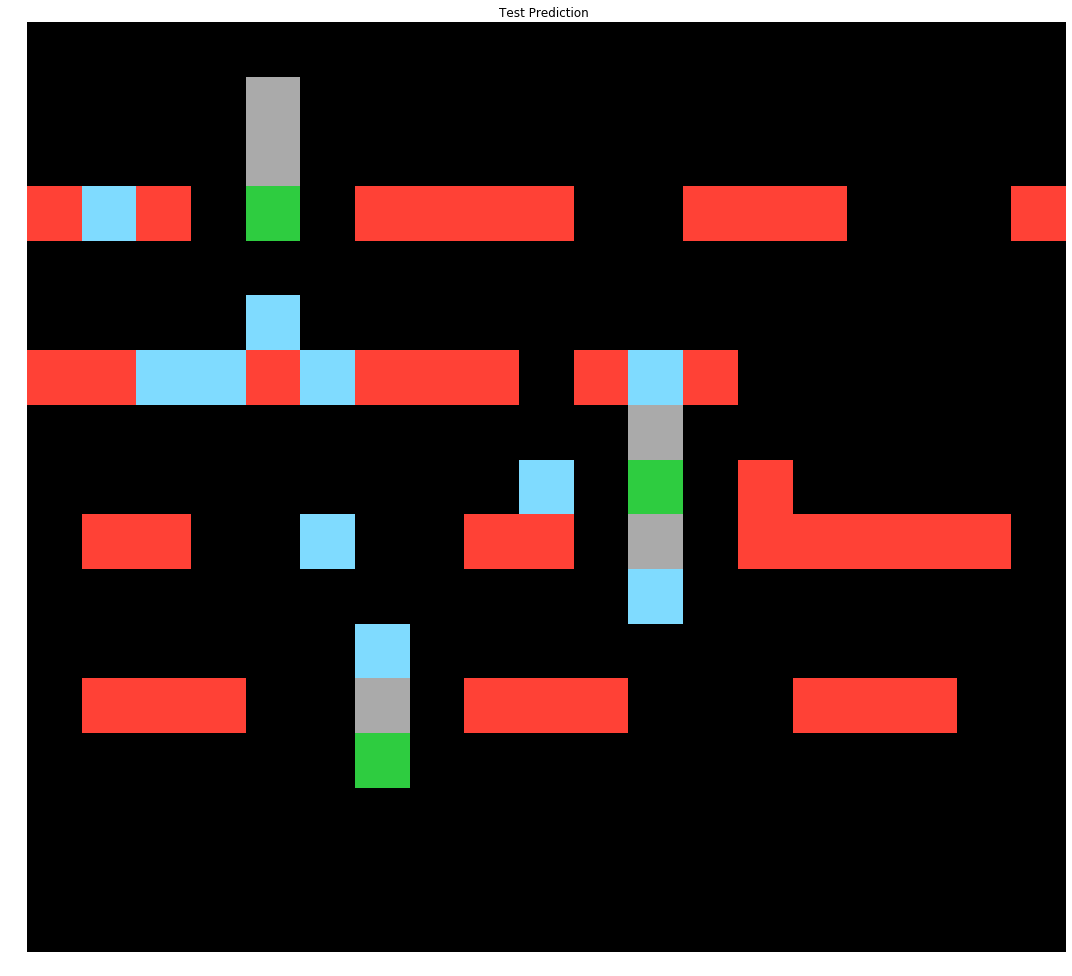

Made predictions for  40f6cd08
ensemble accuracy 0.75



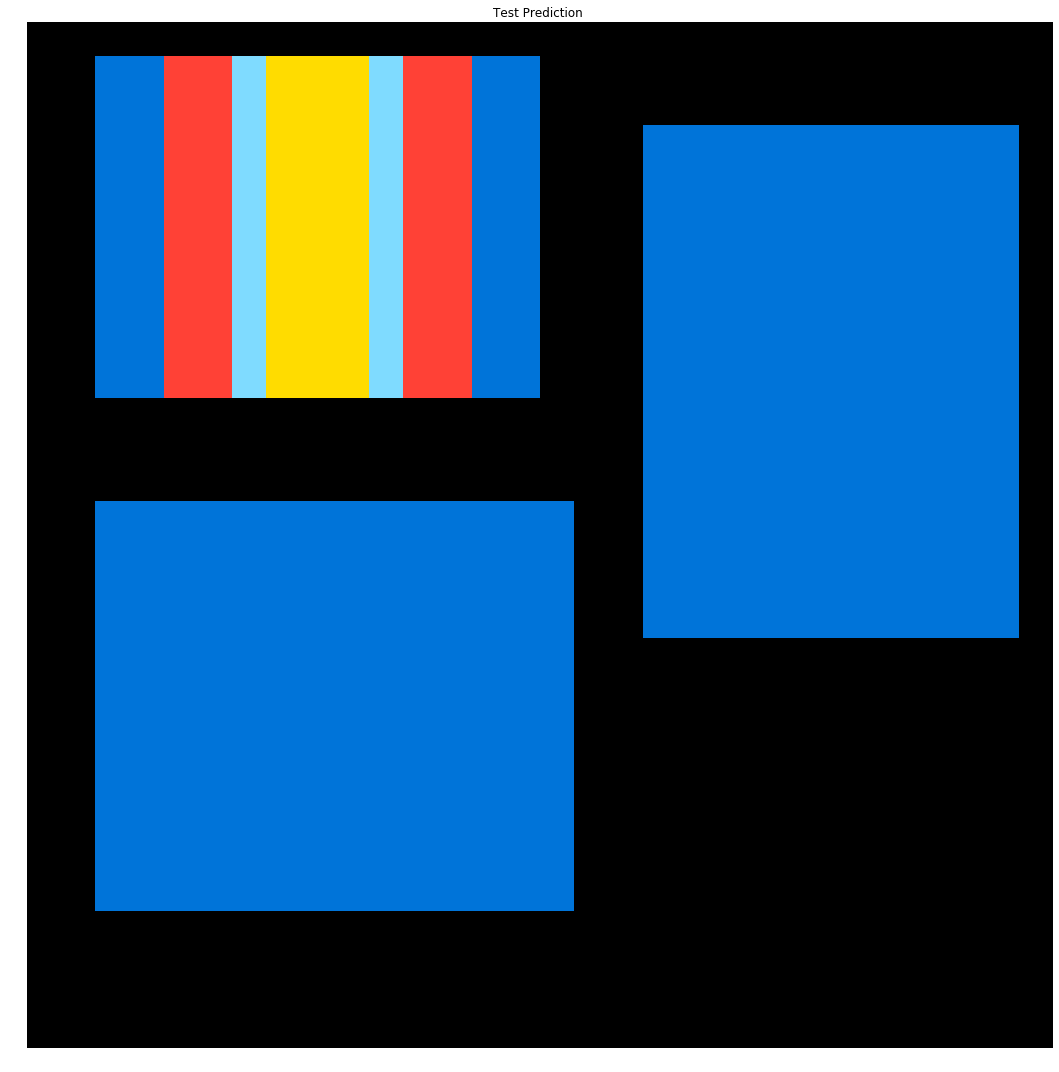

Number of input rows: 18 cols: 22
Number of target rows: 12 cols: 11
ignoring task abstraction-and-reasoning-challenge\evaluation\414297c0.json

Made predictions for  423a55dc
ensemble accuracy 0.8251748251748252



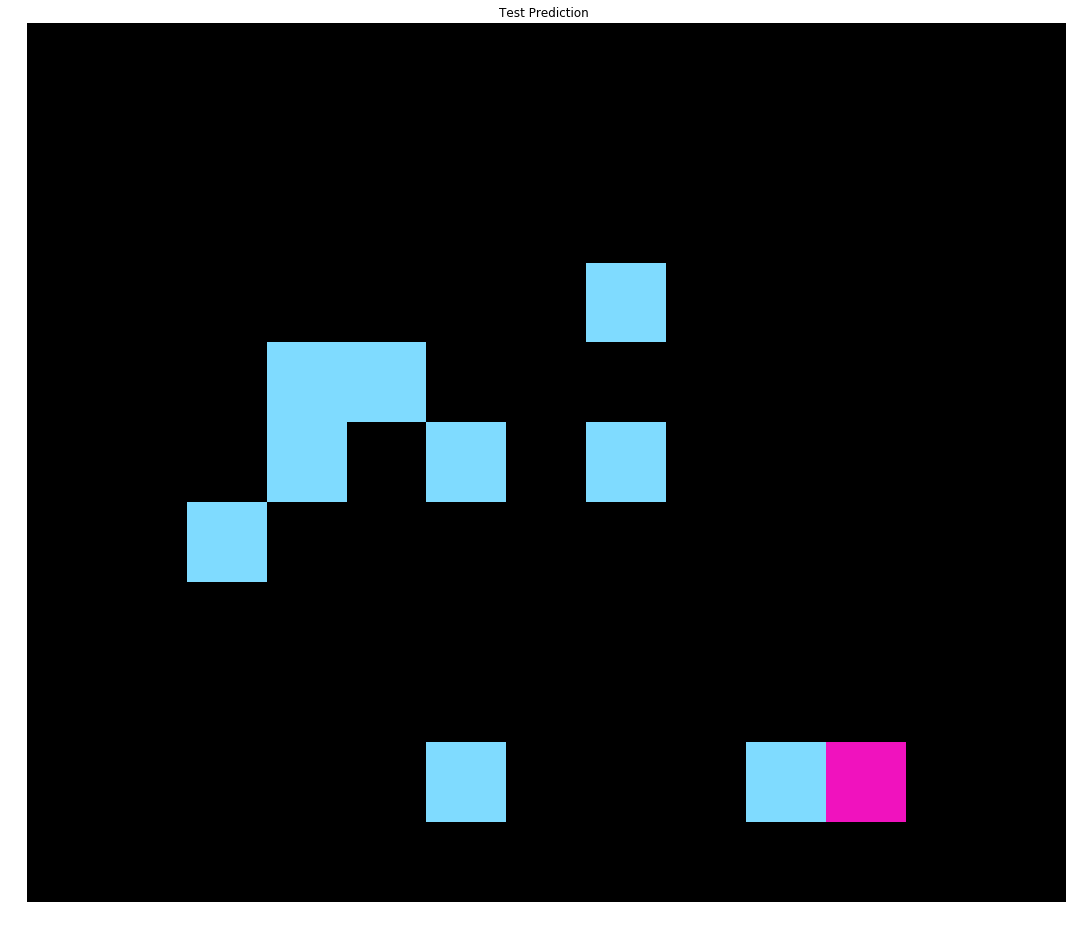

Made predictions for  42918530
ensemble accuracy 0.9696



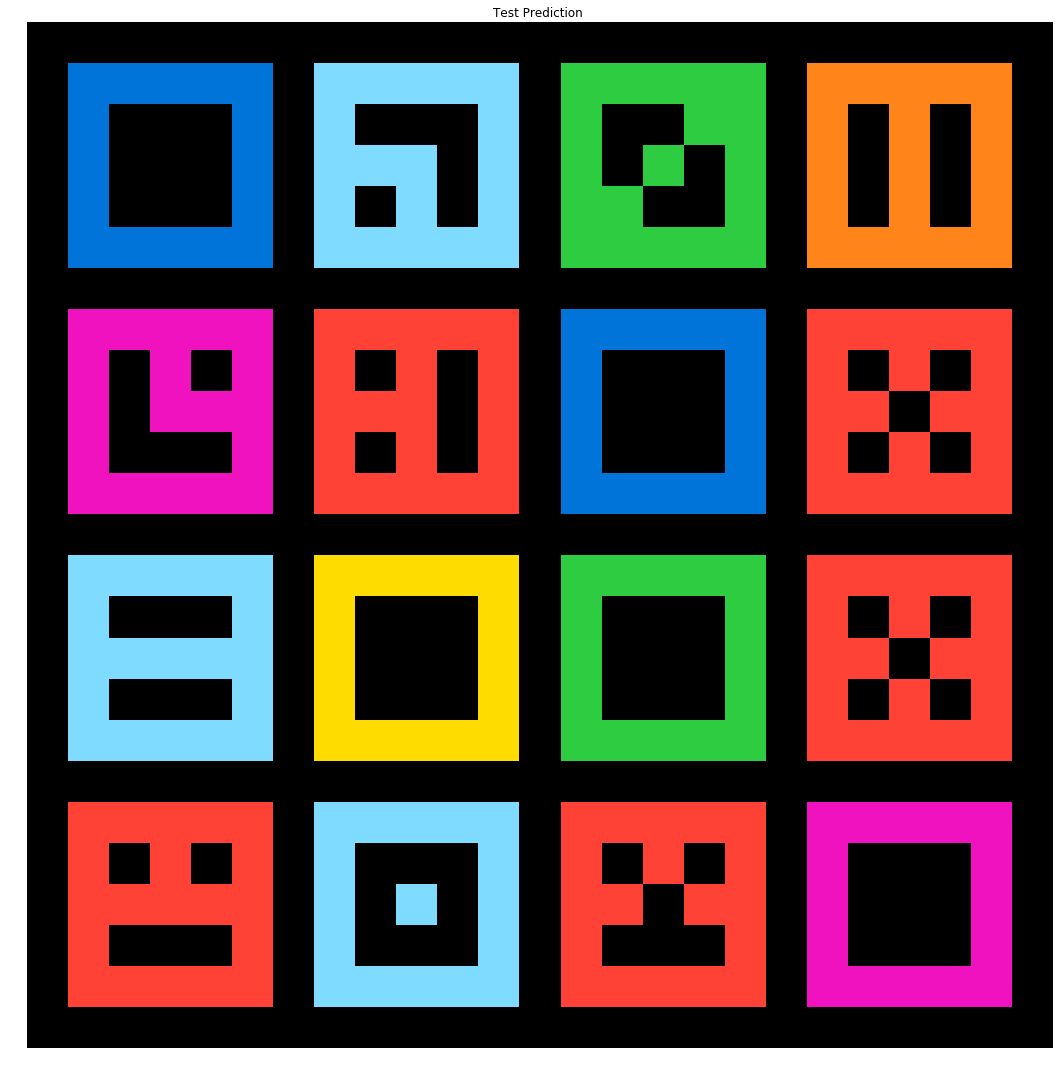

Made predictions for  42a15761
ensemble accuracy 0.9282296650717703



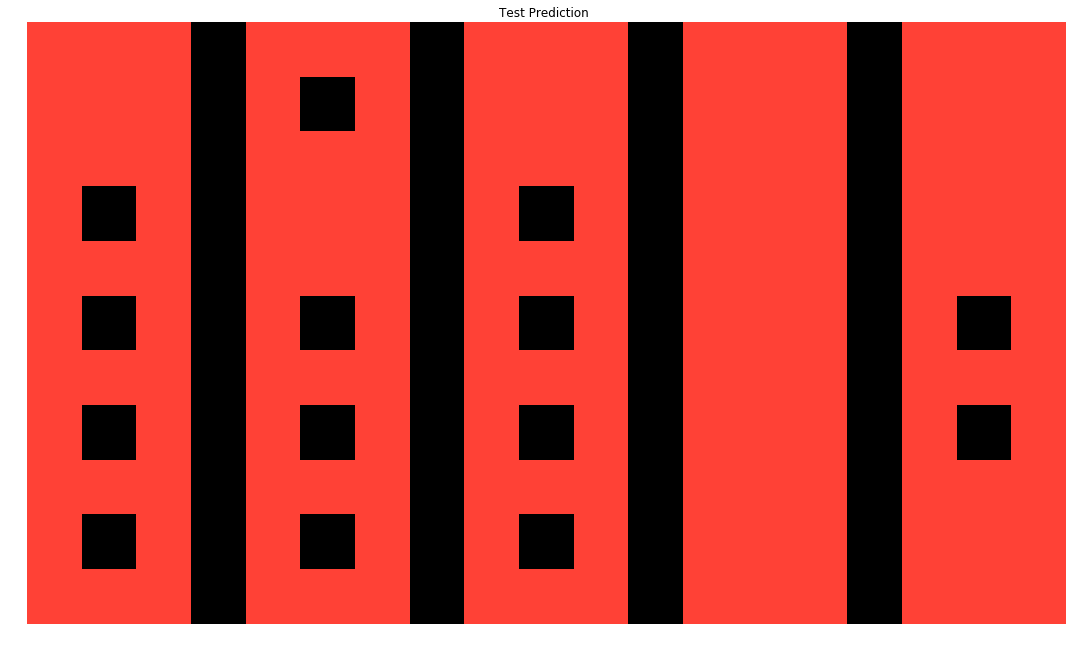

Made predictions for  4364c1c4
ensemble accuracy 0.8846153846153846



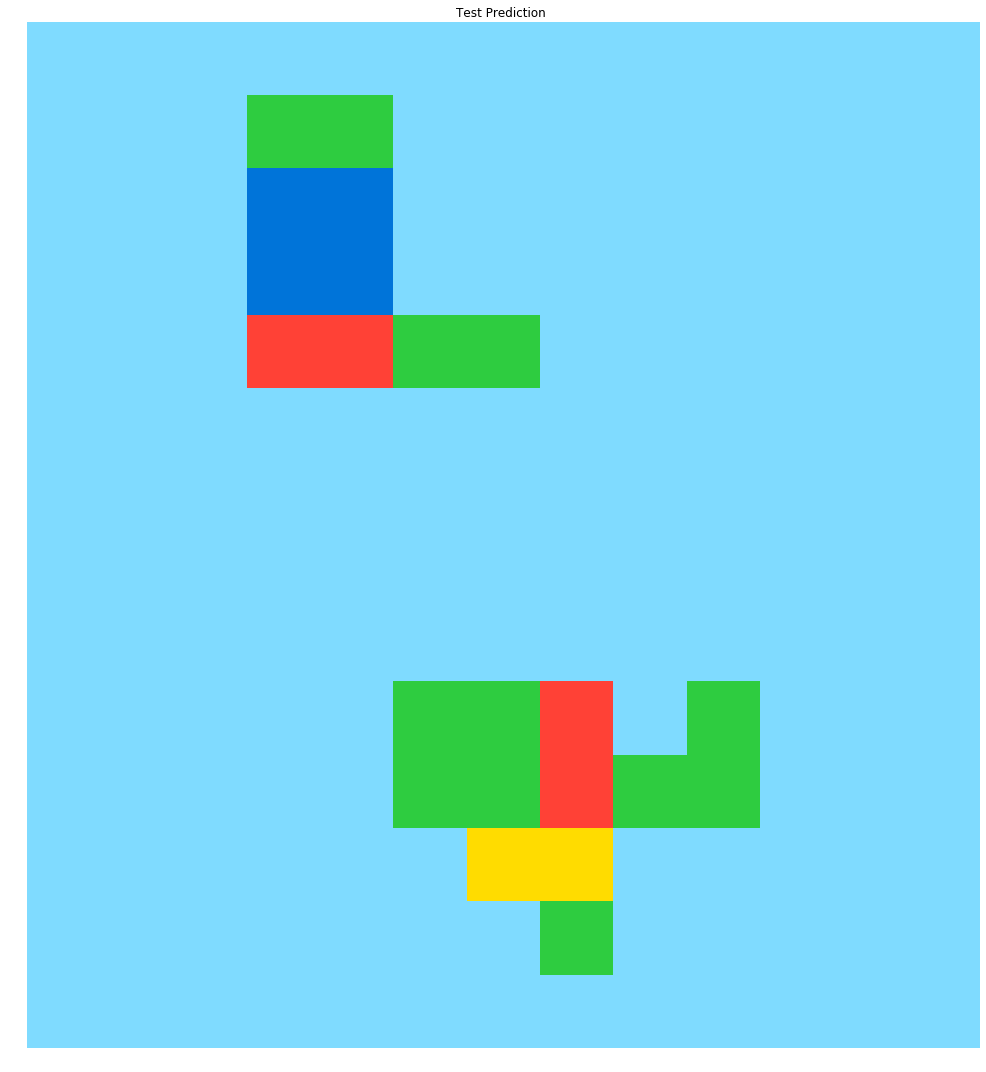

Made predictions for  456873bc
ensemble accuracy 0.9418282548476454



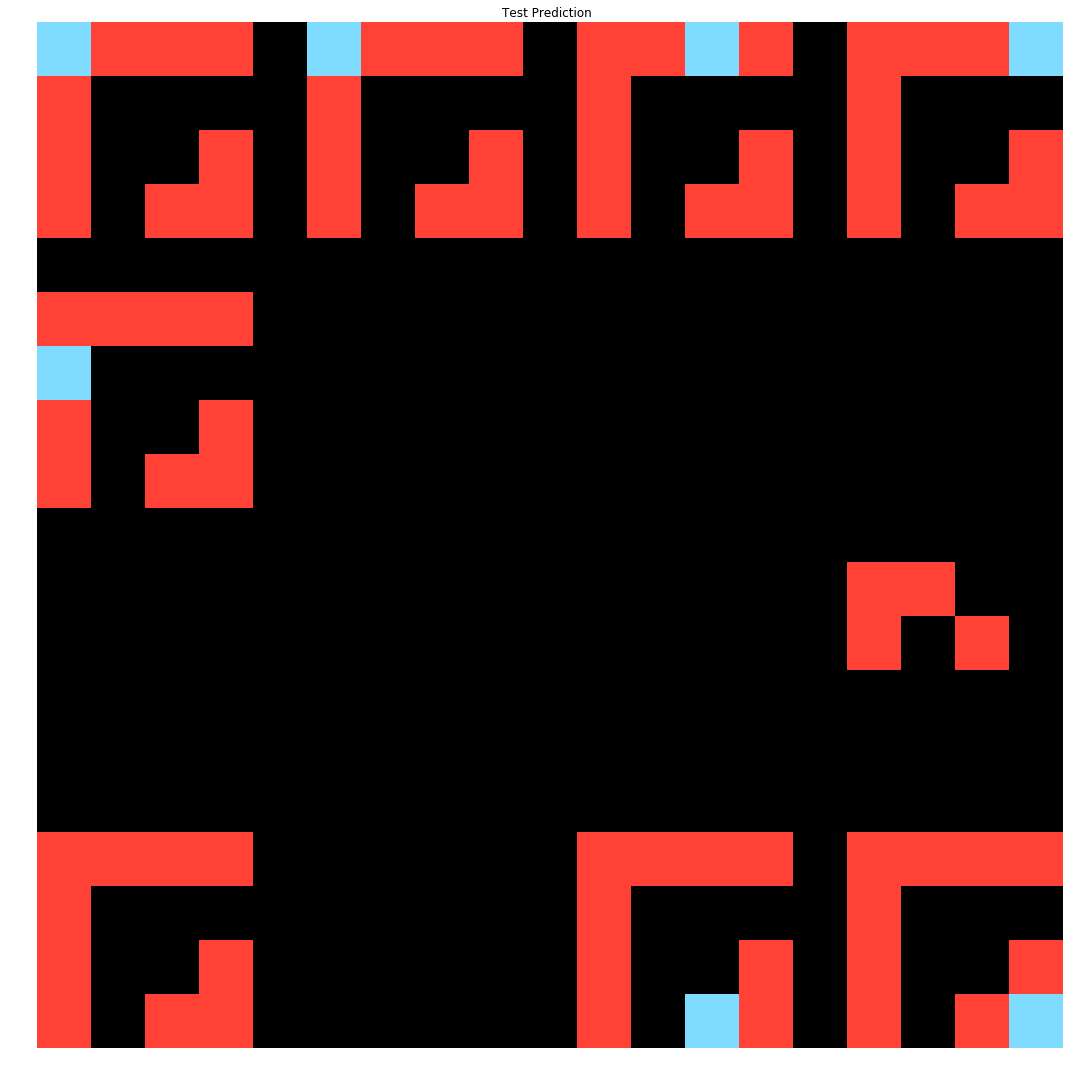

Made predictions for  45737921
ensemble accuracy 0.9444444444444444



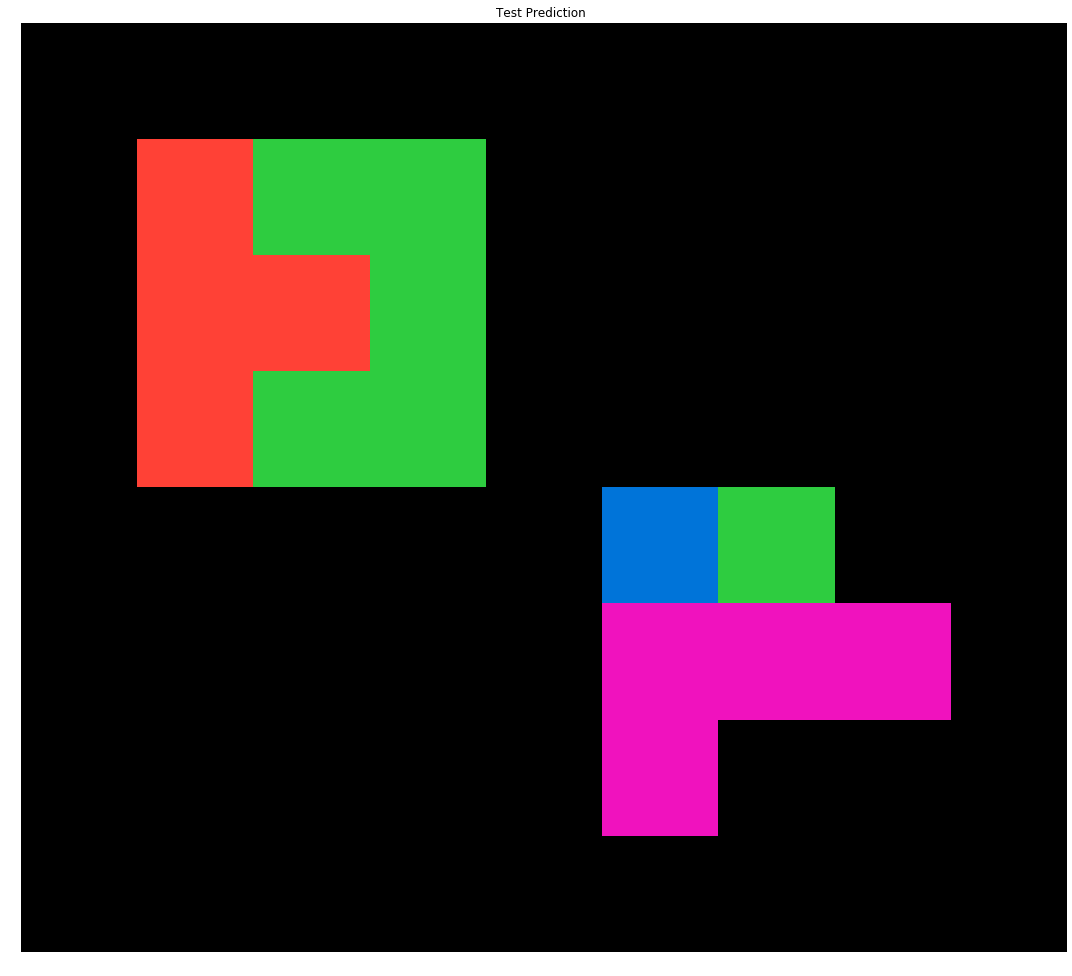

Made predictions for  45bbe264
ensemble accuracy 0.6622222222222223



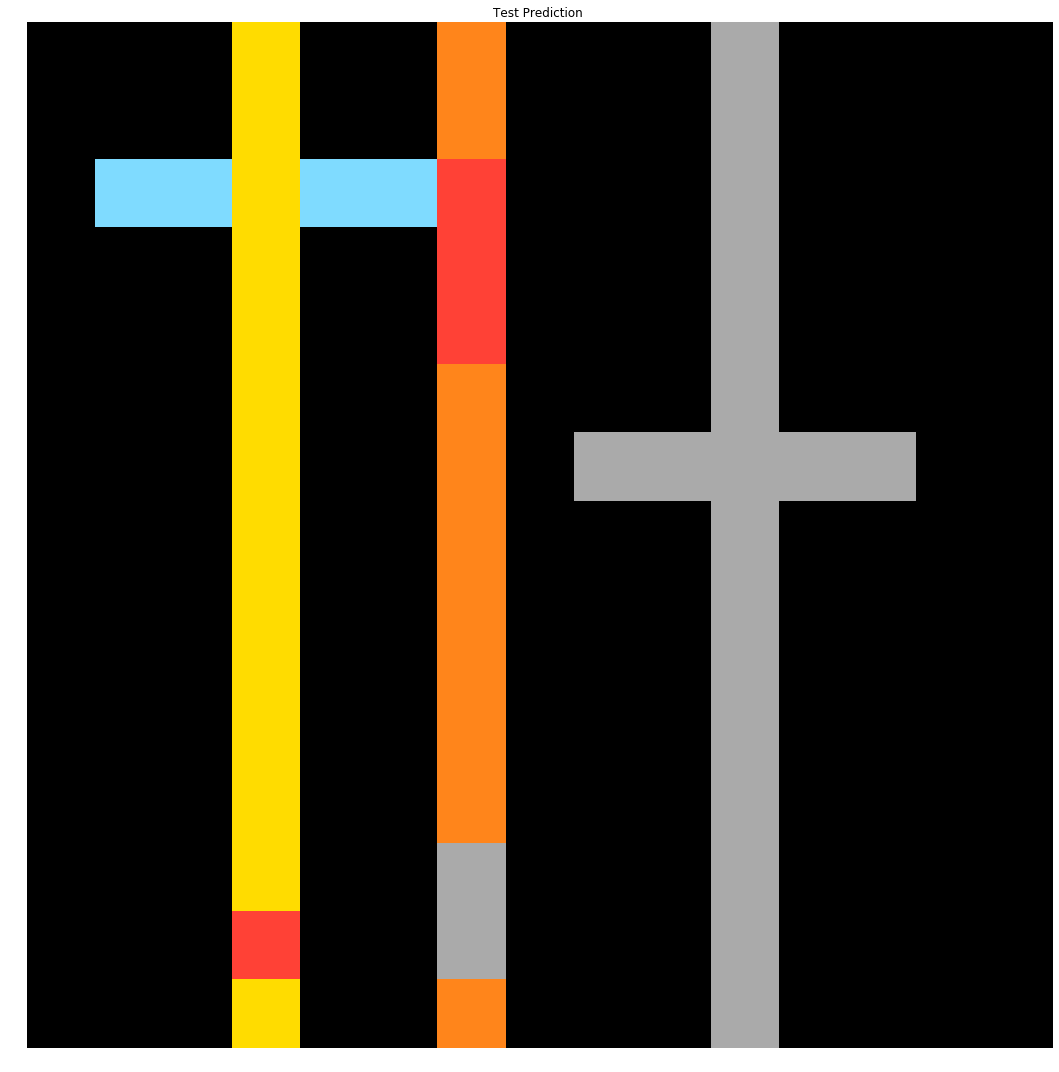

Made predictions for  477d2879
ensemble accuracy 0.20118343195266272



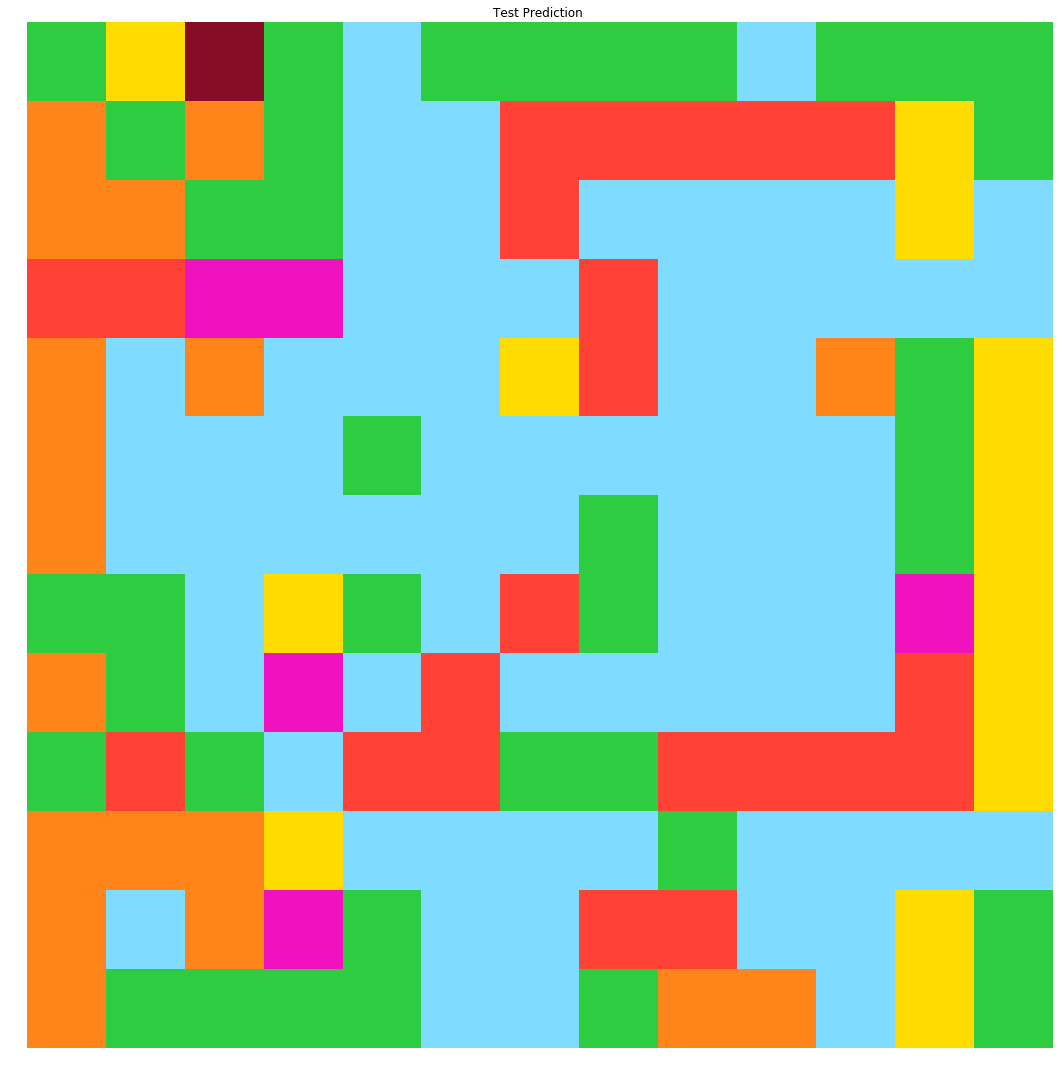

Made predictions for  47996f11
ensemble accuracy 0.8588888888888889



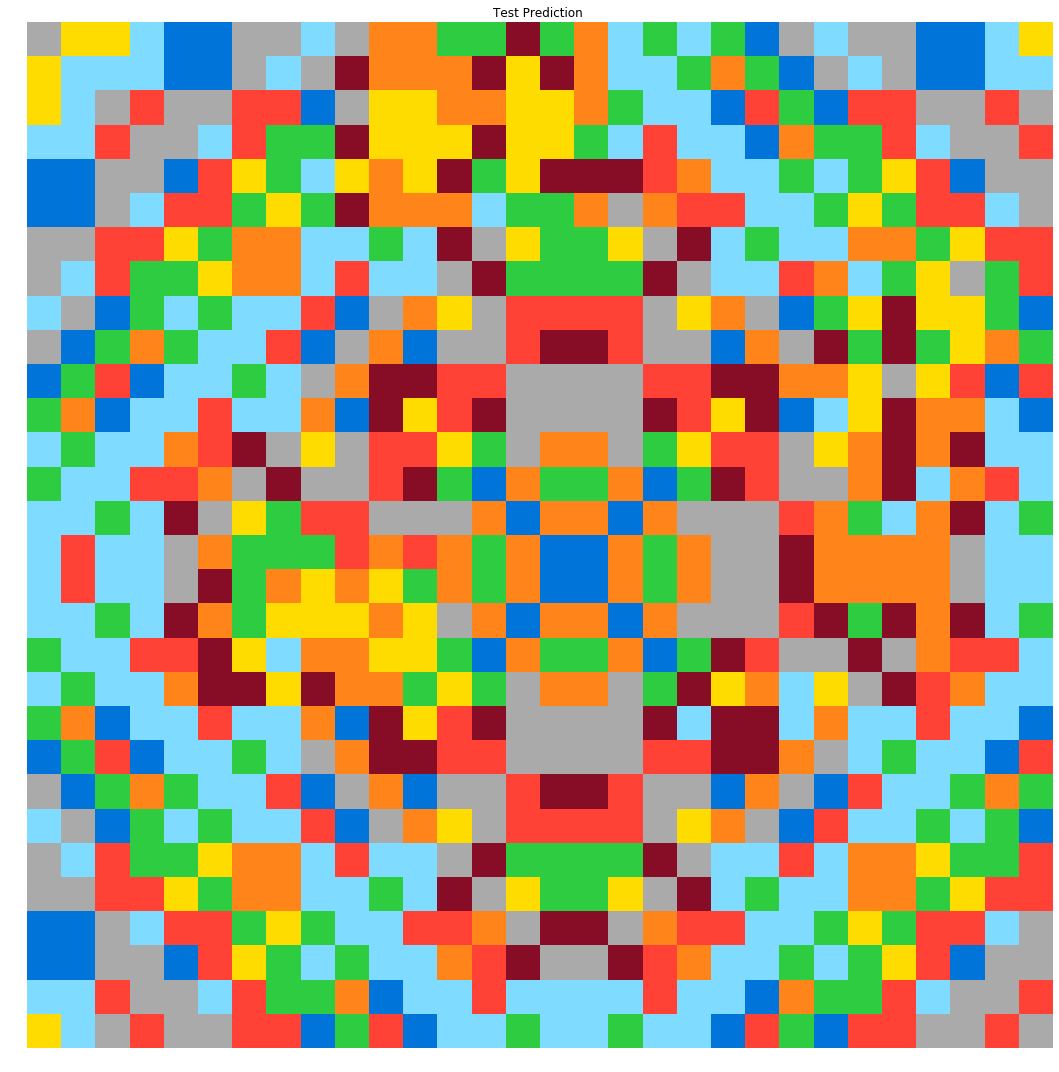

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\48131b3c.json

Number of input rows: 9 cols: 9
Number of target rows: 3 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\4852f2fa.json

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\48f8583b.json

Made predictions for  4aab4007
ensemble accuracy 0.9426020408163265



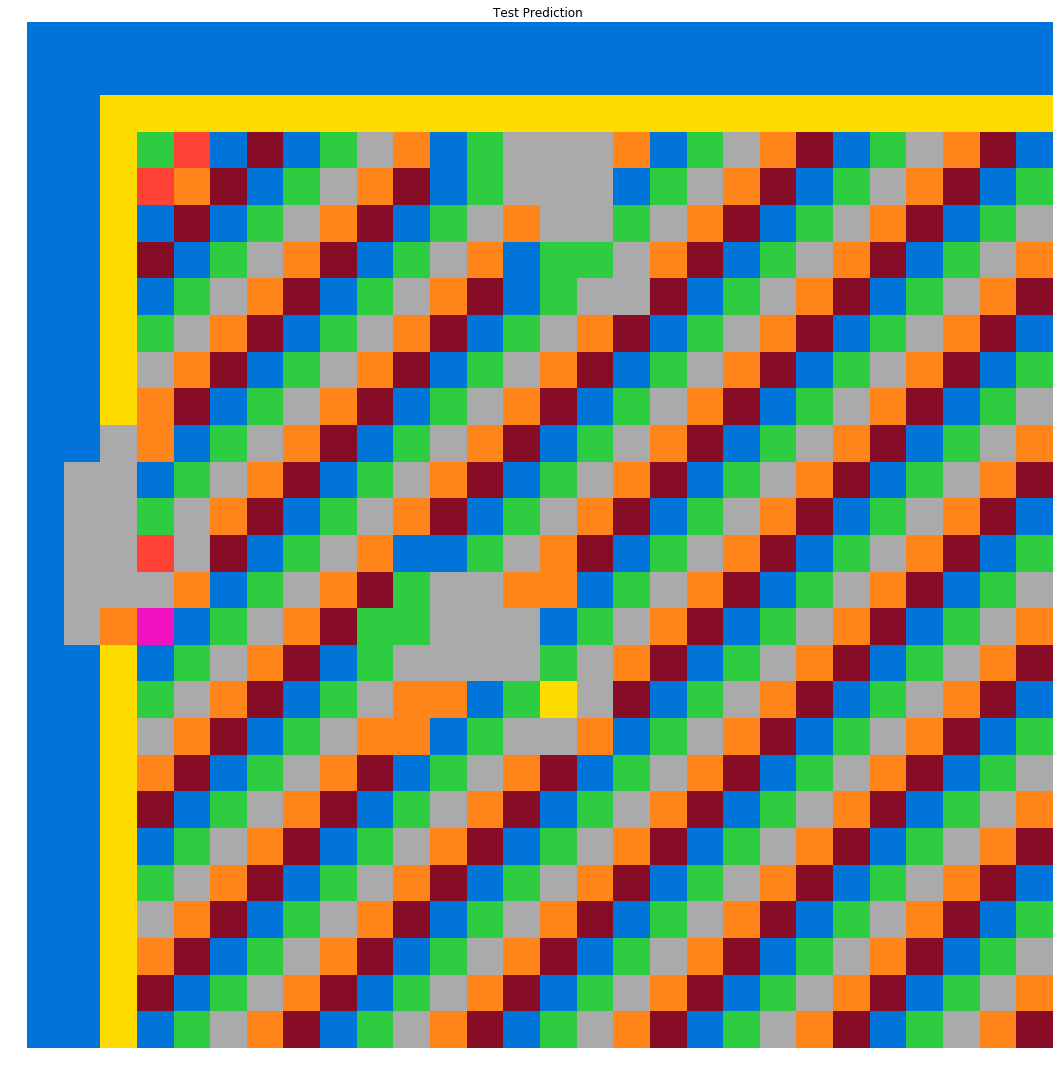

Made predictions for  4acc7107
ensemble accuracy 0.72



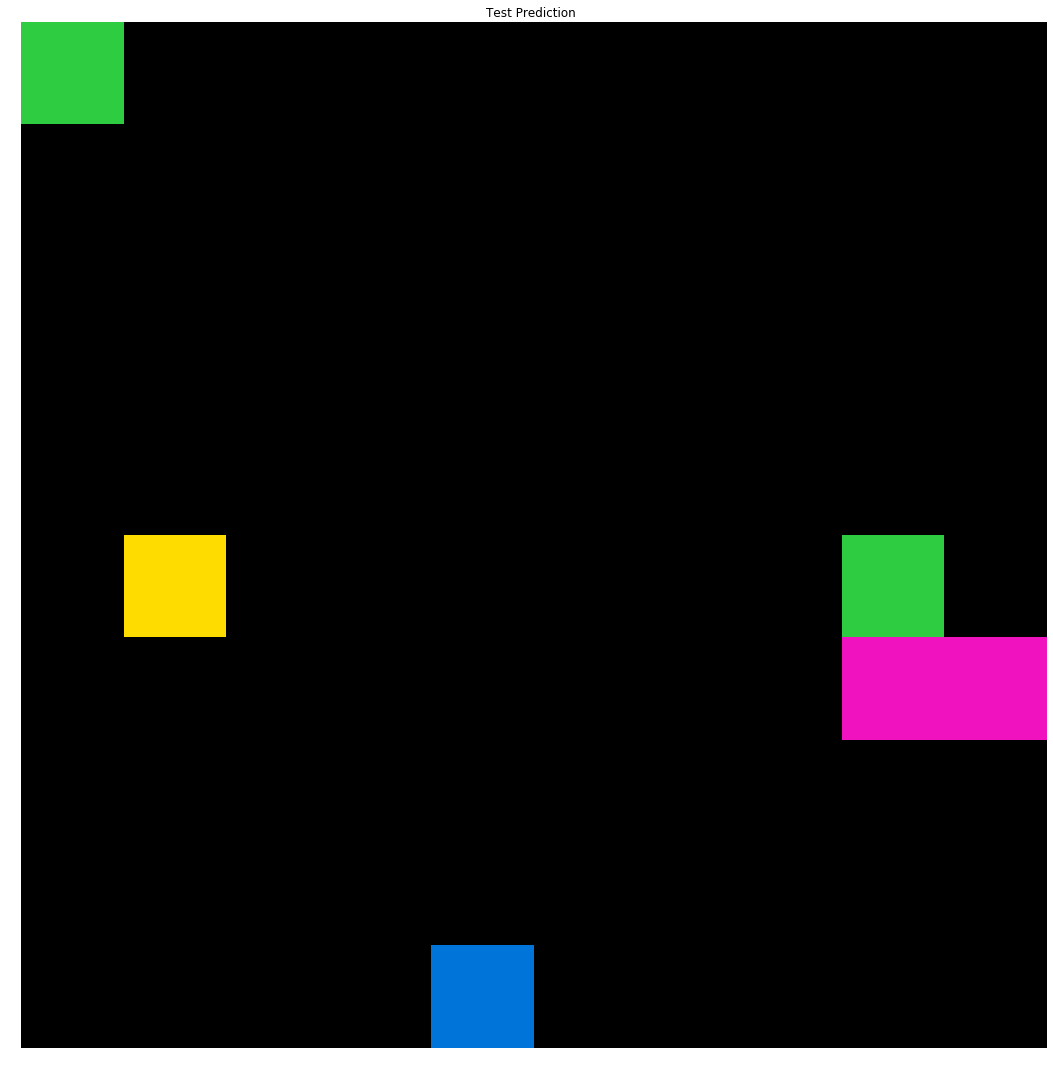

Made predictions for  4b6b68e5
ensemble accuracy 0.6955128205128205



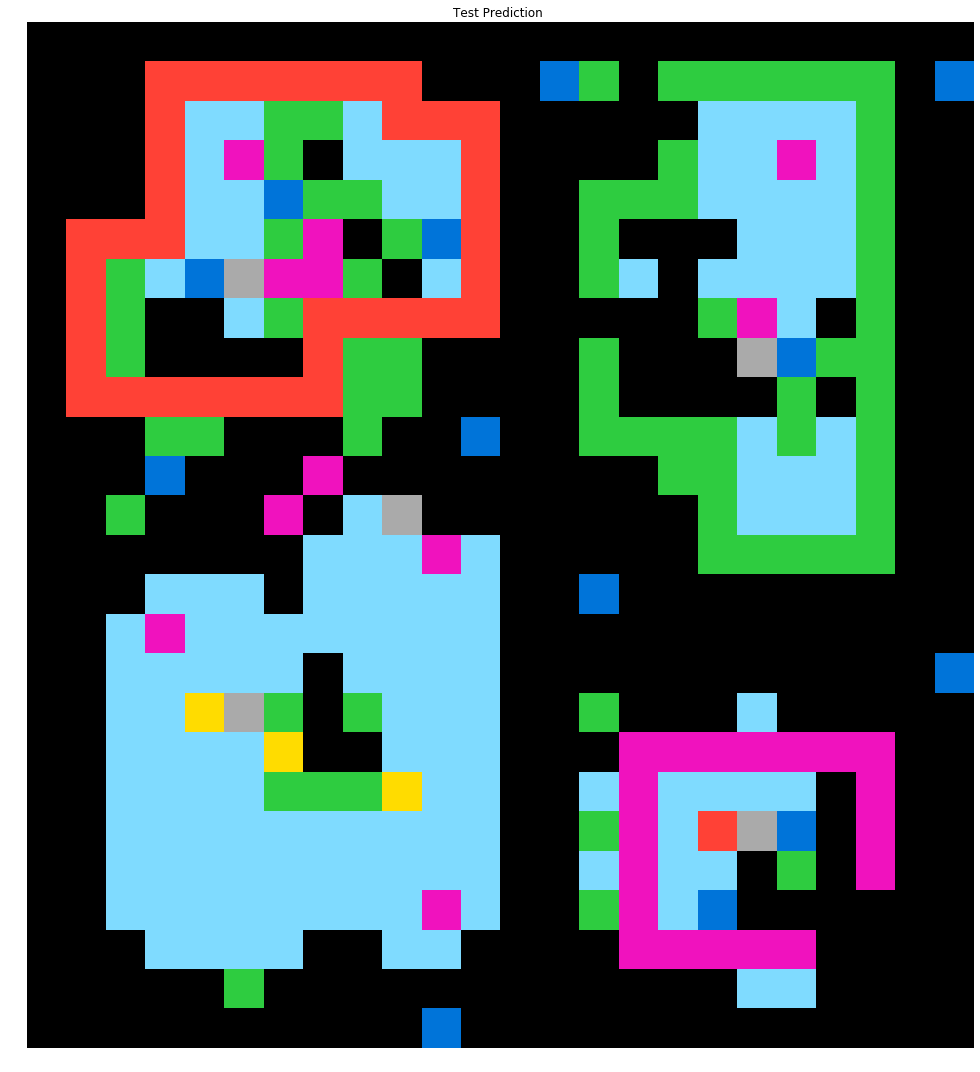

Number of input rows: 15 cols: 15
Number of target rows: 9 cols: 15
ignoring task abstraction-and-reasoning-challenge\evaluation\4c177718.json

Made predictions for  4cd1b7b2
ensemble accuracy 0.6875



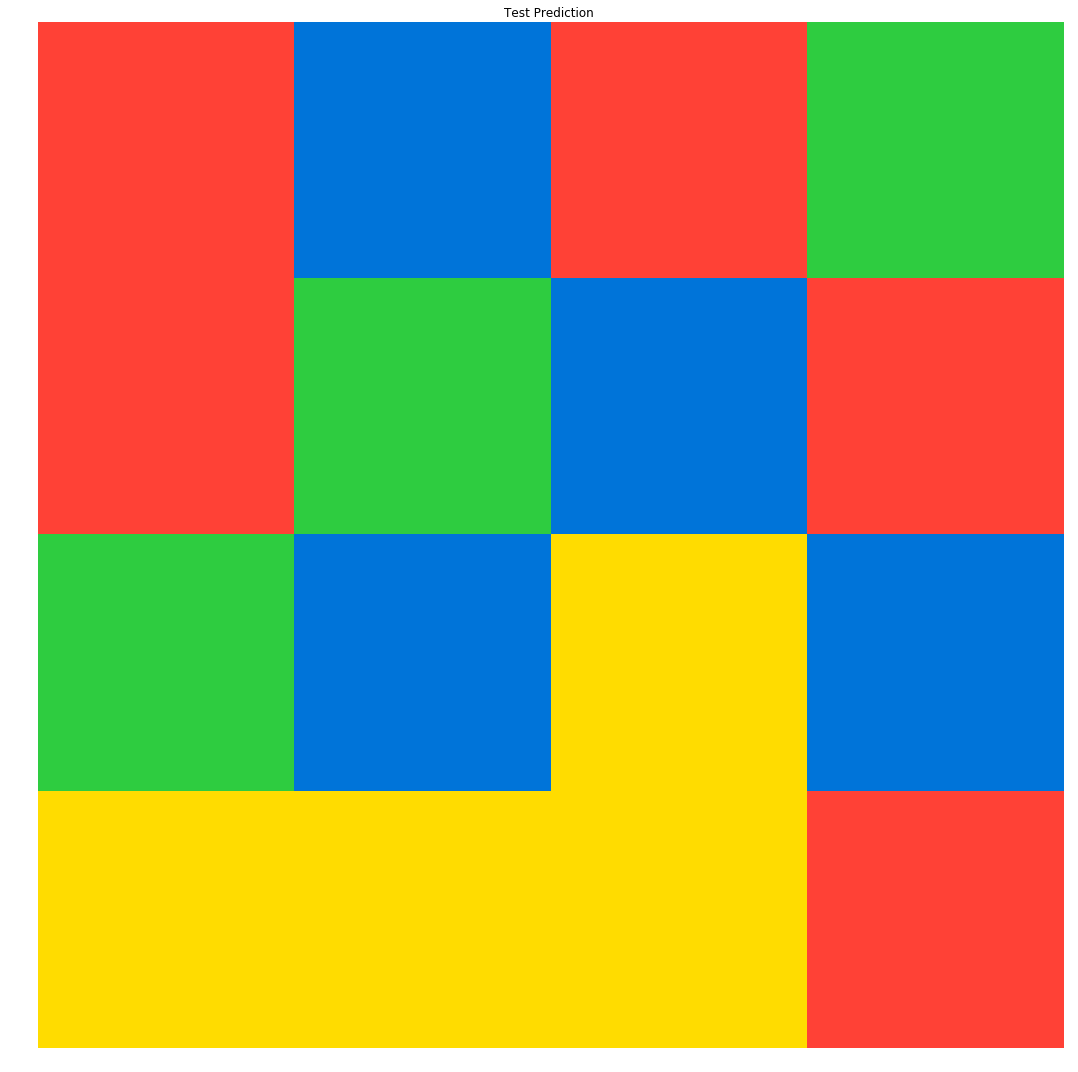

Made predictions for  4e45f183
ensemble accuracy 0.40166204986149584



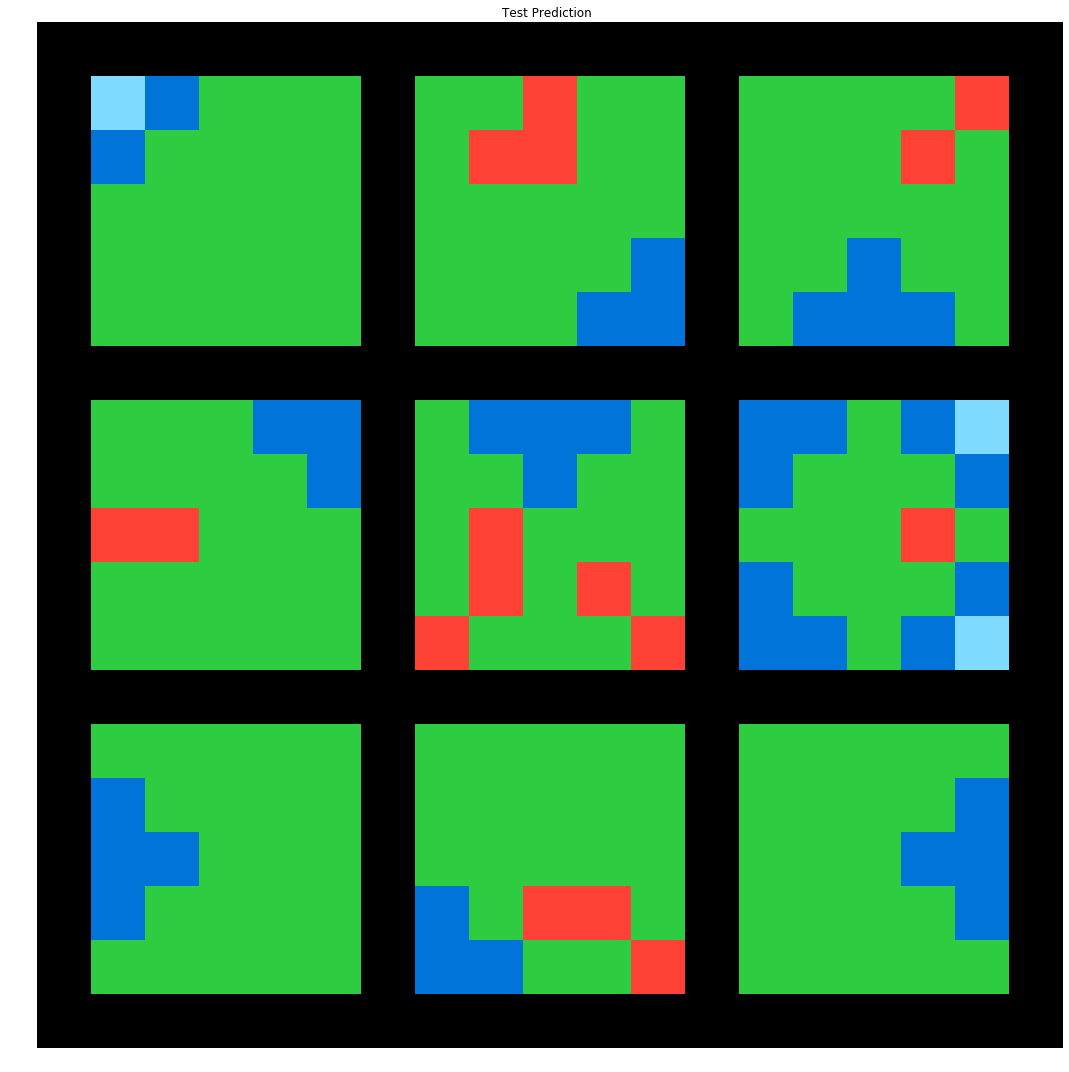

Made predictions for  4e469f39
ensemble accuracy 0.87



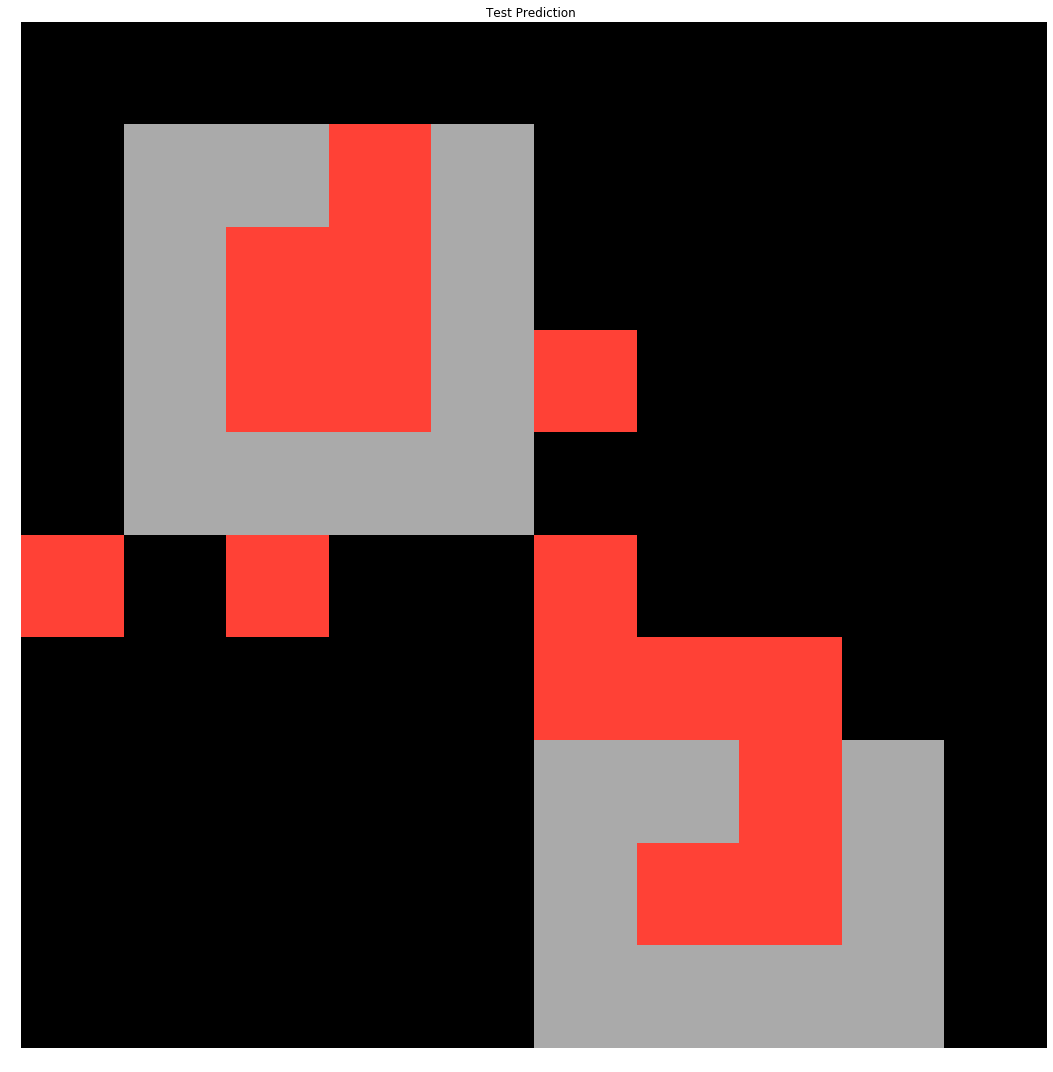

Made predictions for  4f537728
ensemble accuracy 0.845



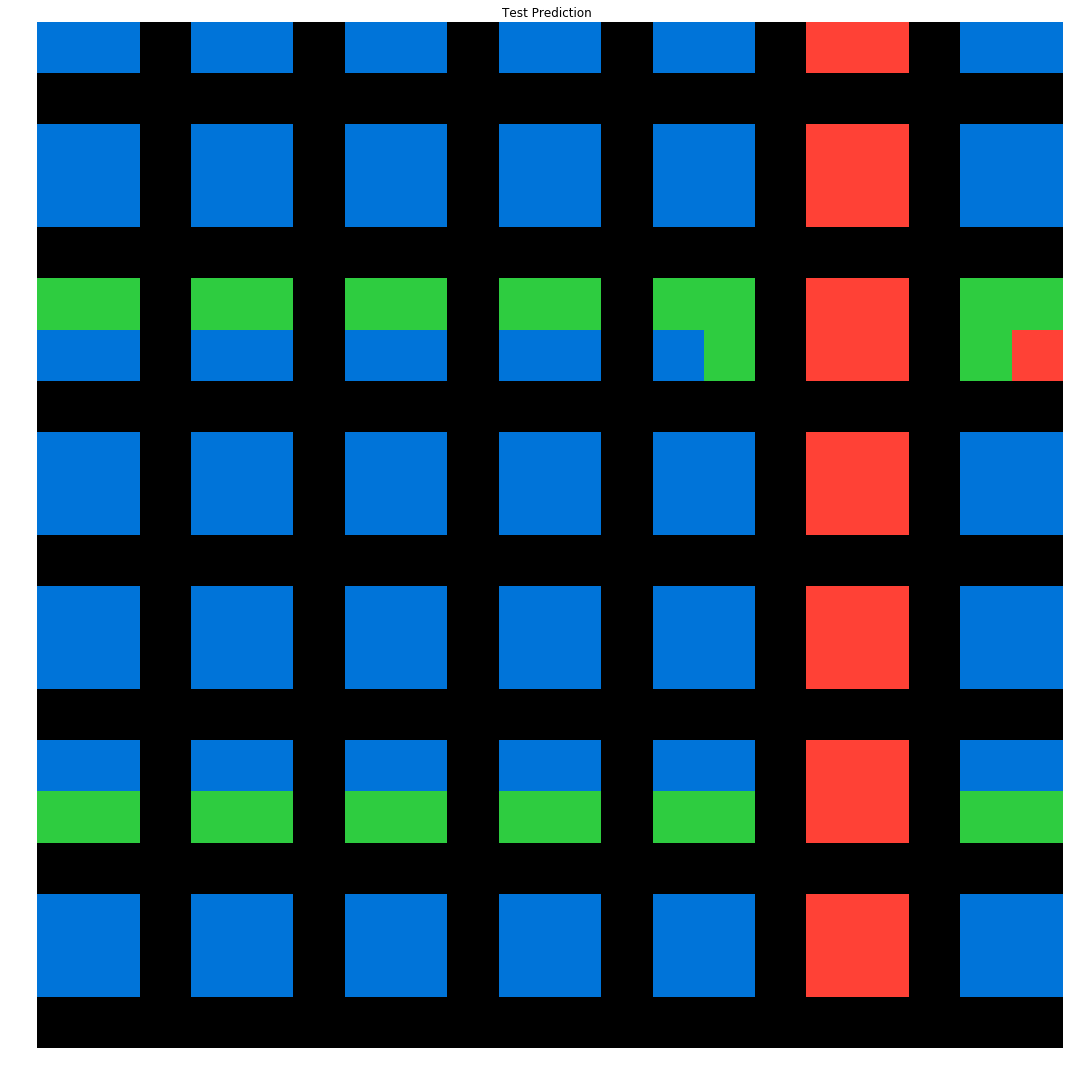

Made predictions for  4ff4c9da
ensemble accuracy 0.9698216735253772



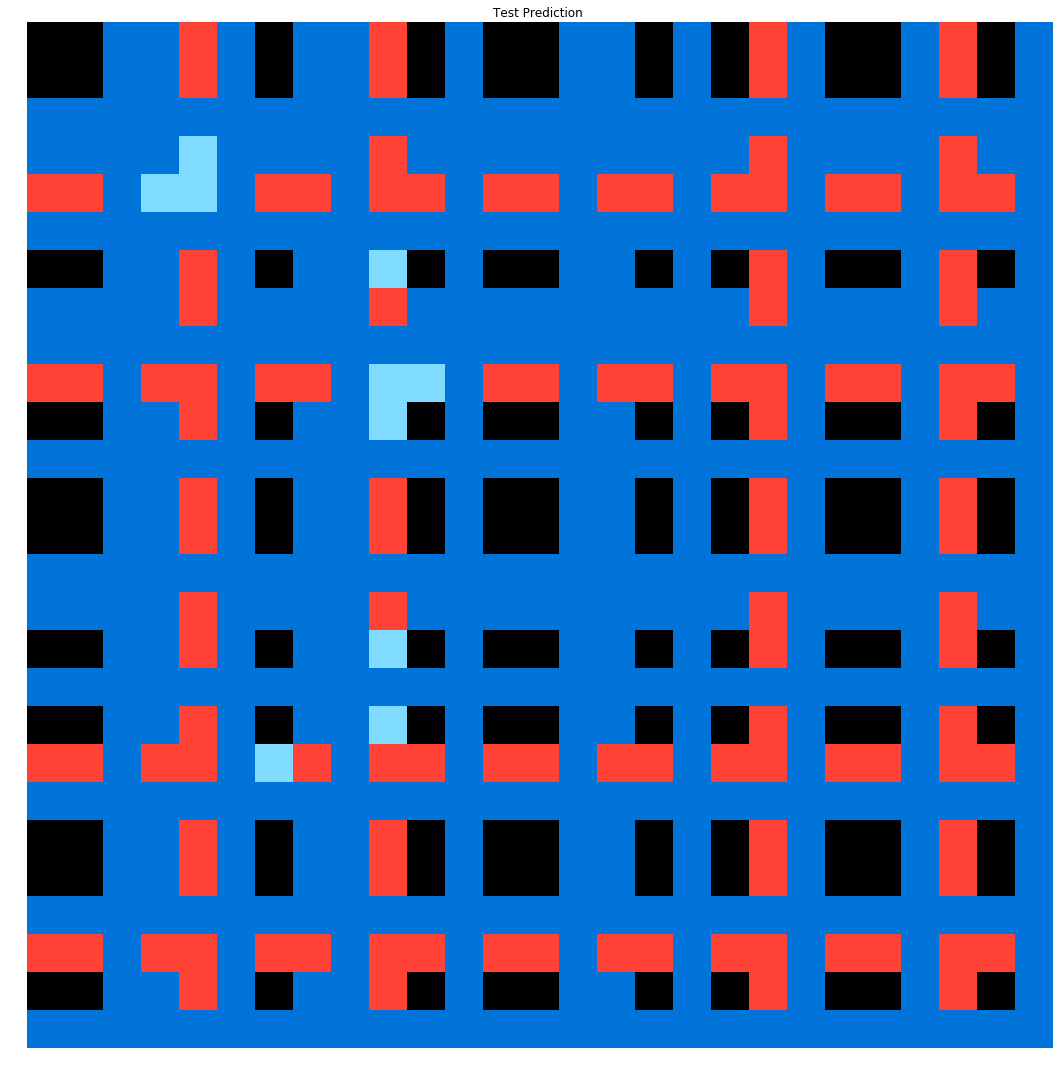

Number of input rows: 14 cols: 11
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\505fff84.json

Number of input rows: 9 cols: 5
Number of target rows: 4 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\506d28a5.json

Made predictions for  50a16a69
ensemble accuracy 0.25



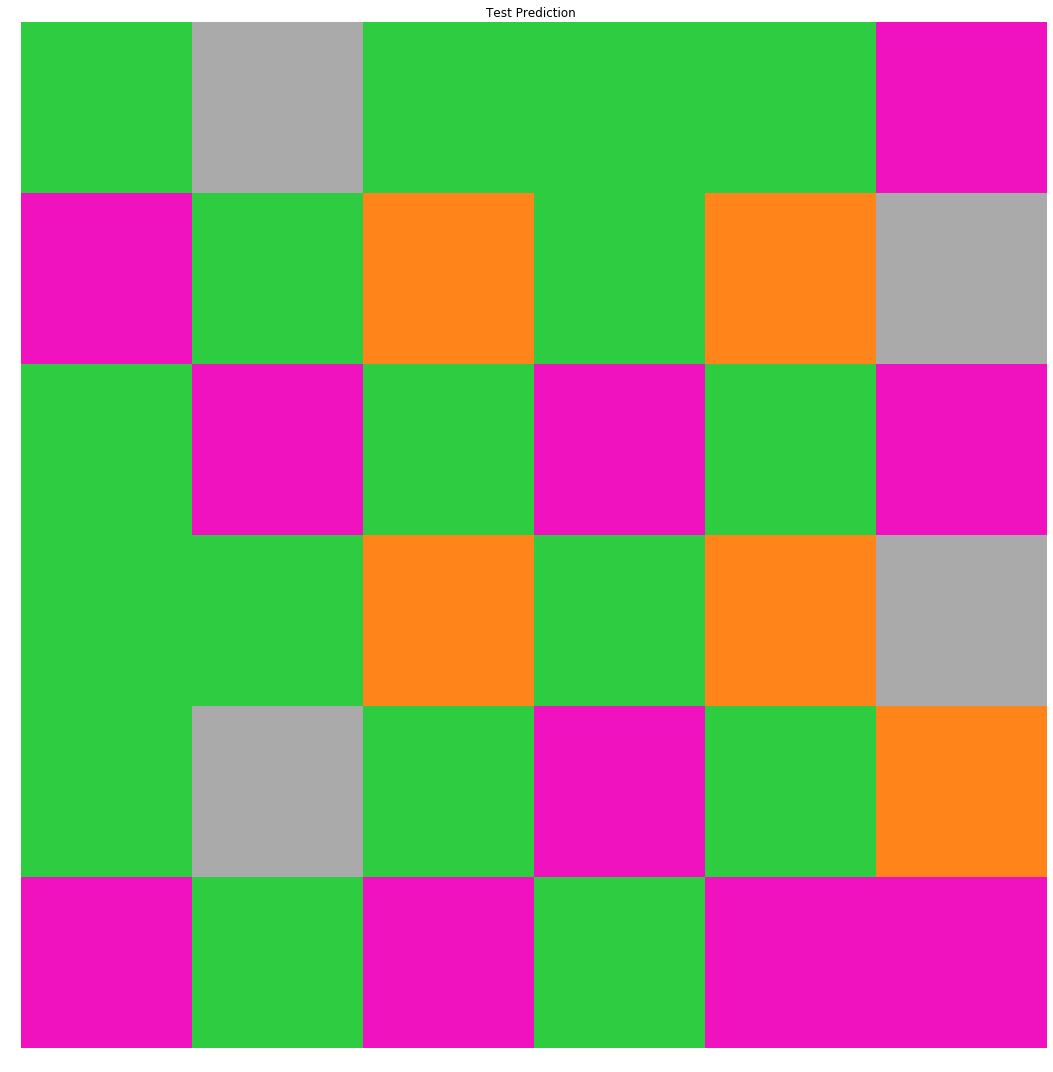

Number of input rows: 12 cols: 9
Number of target rows: 8 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\50aad11f.json

Made predictions for  50f325b5
ensemble accuracy 0.9338235294117647



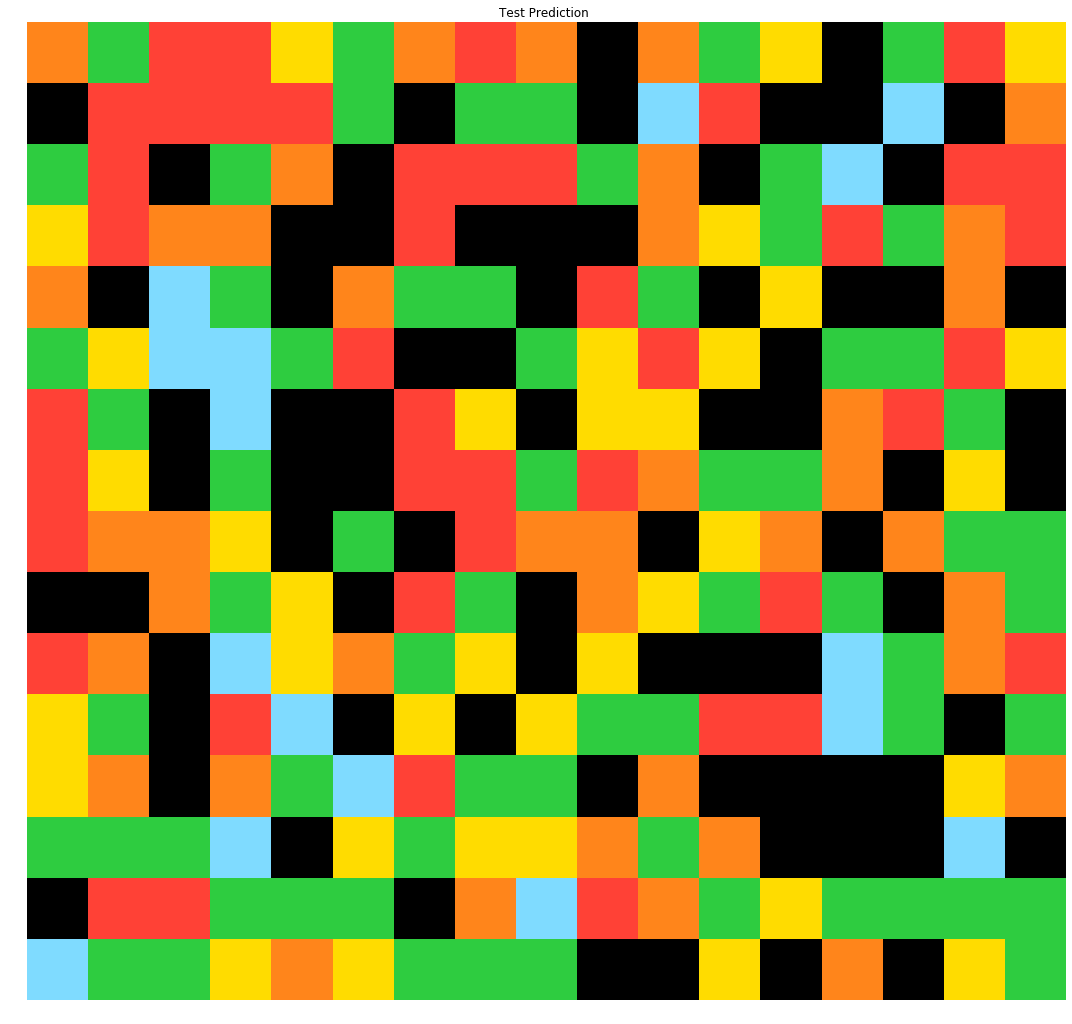

Made predictions for  516b51b7
ensemble accuracy 0.9921568627450981



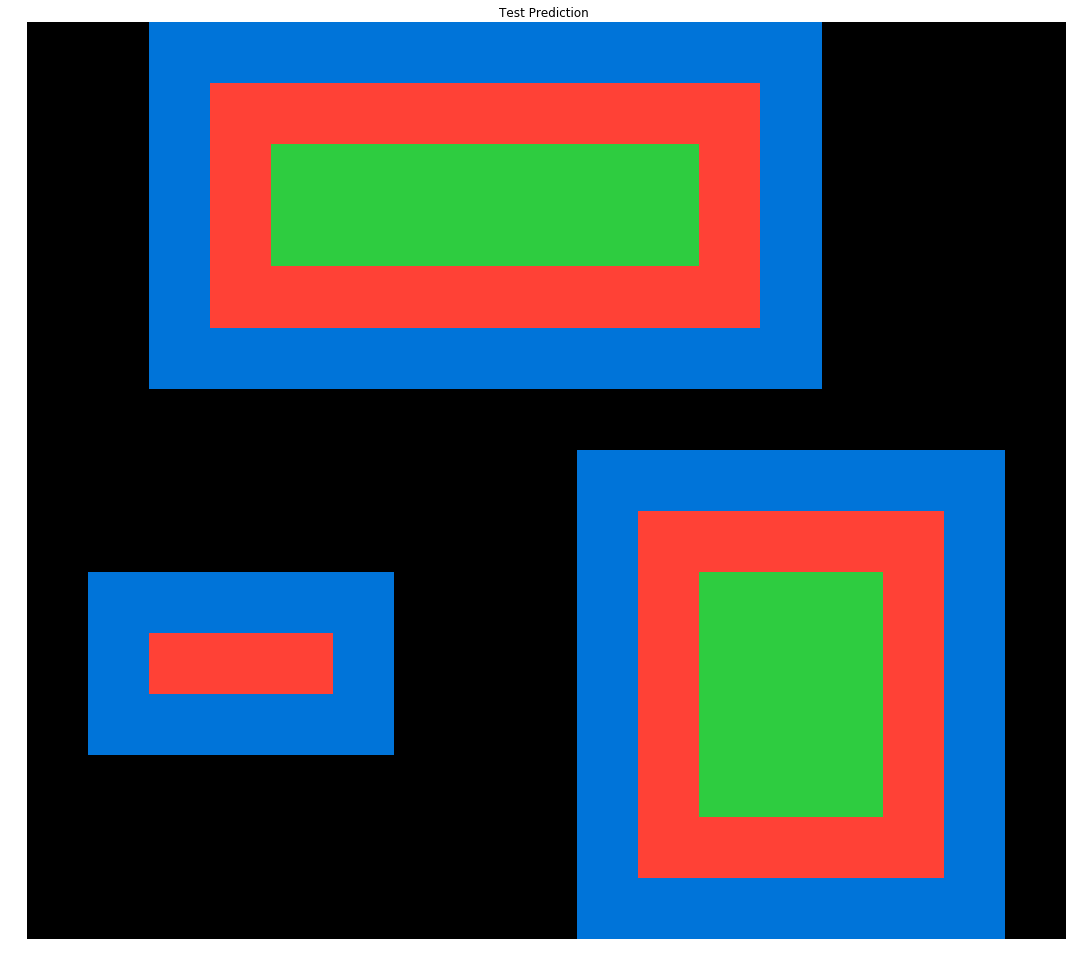

Made predictions for  5207a7b5
ensemble accuracy 0.7925925925925926



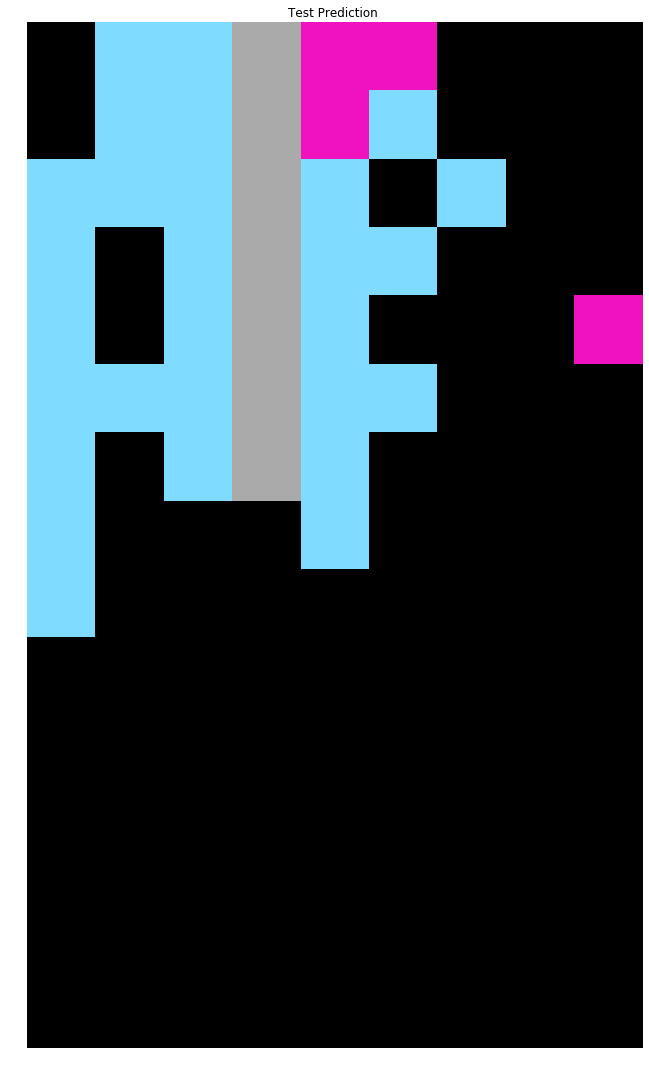

Number of input rows: 10 cols: 19
Number of target rows: 2 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\5289ad53.json

Made predictions for  52fd389e
ensemble accuracy 0.652794292508918



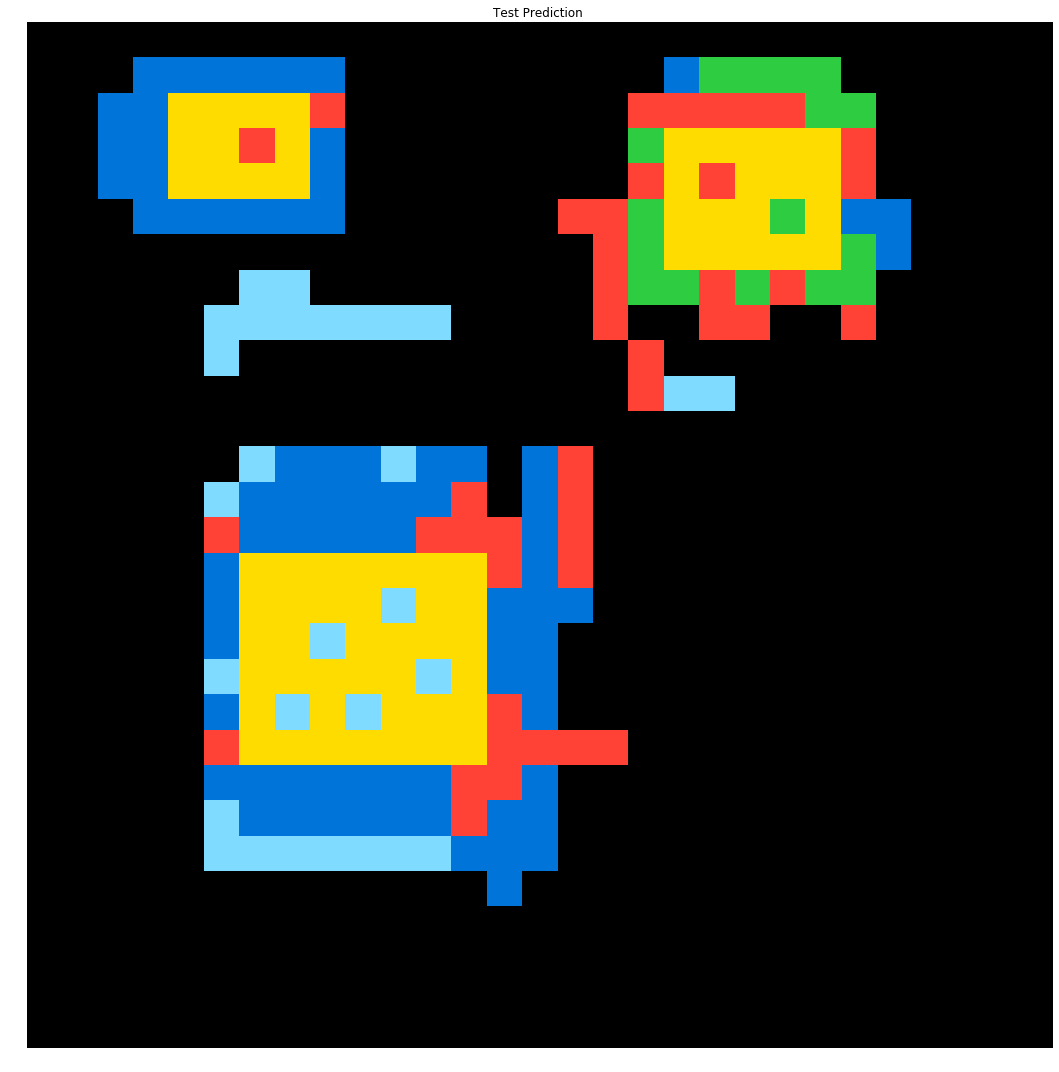

Made predictions for  54db823b
ensemble accuracy 0.8133333333333334



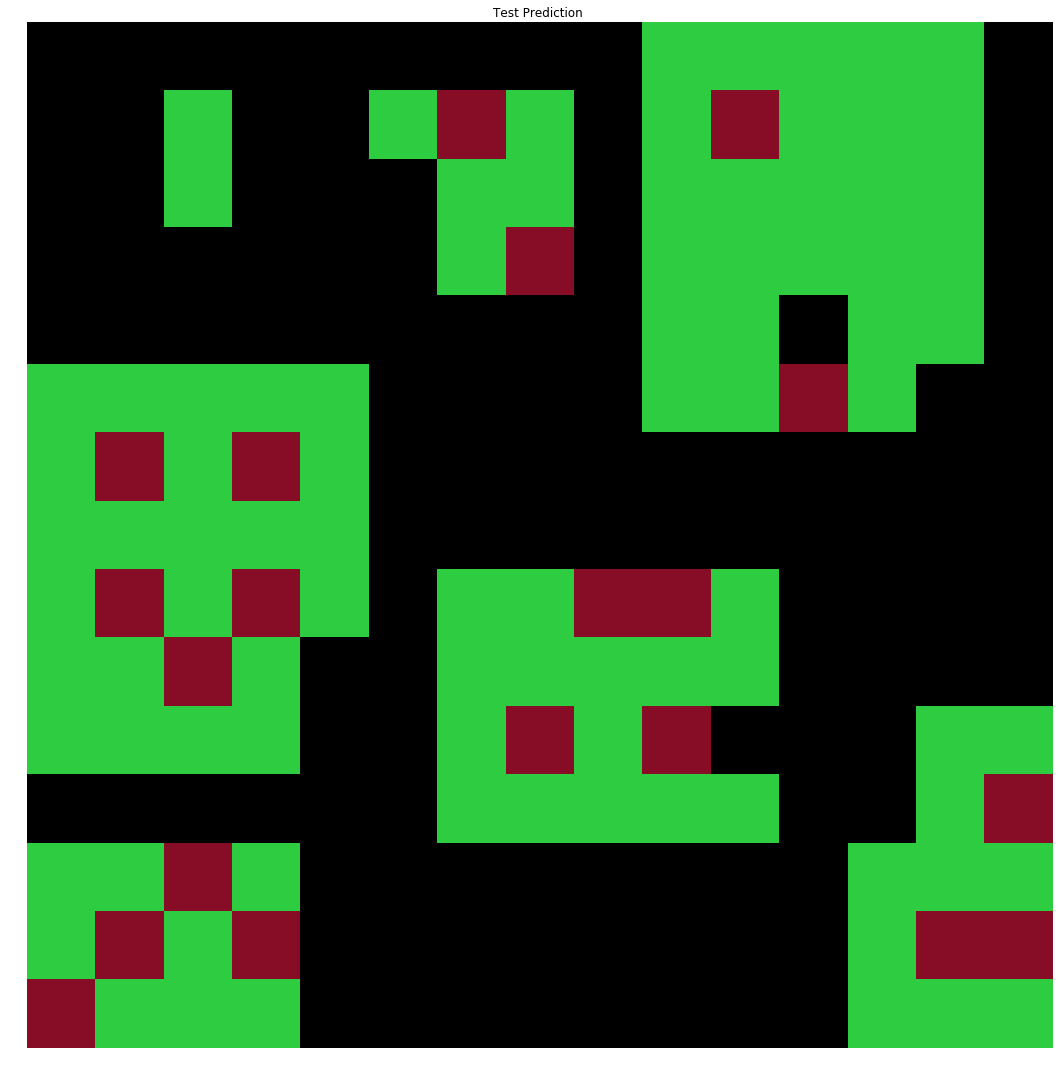

Made predictions for  55059096
ensemble accuracy 0.9683257918552036



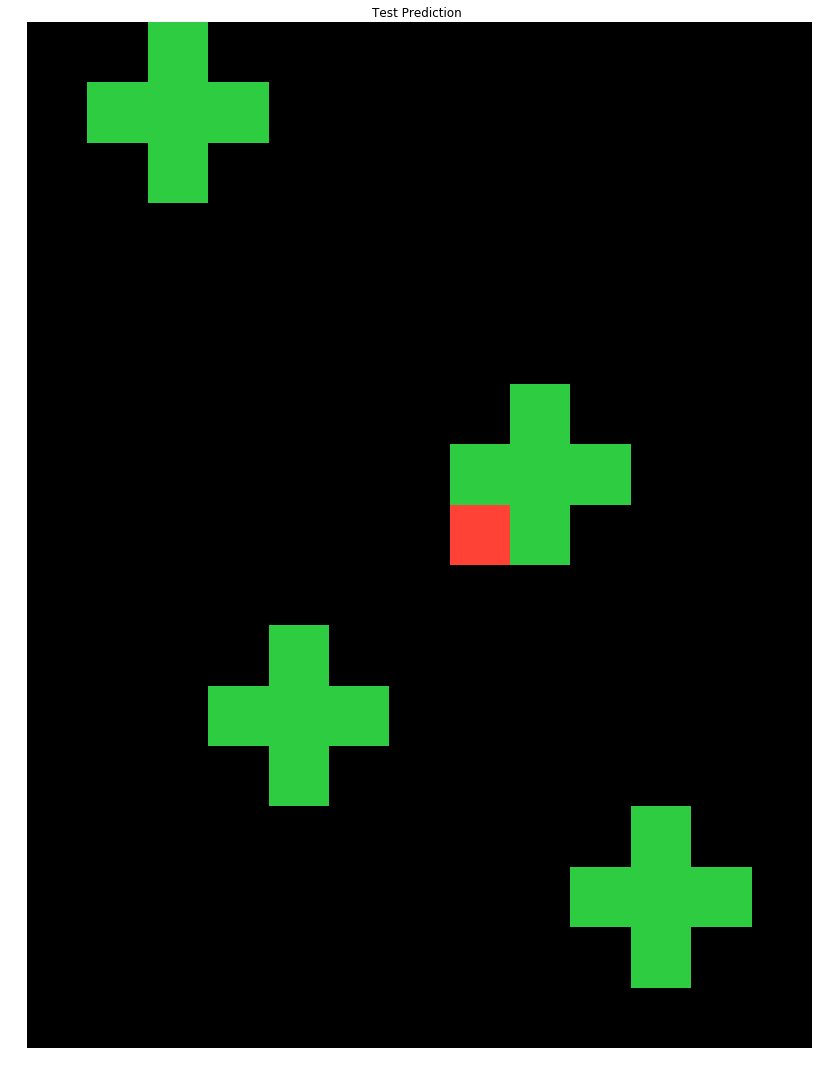

Made predictions for  551d5bf1
ensemble accuracy 0.8994082840236687



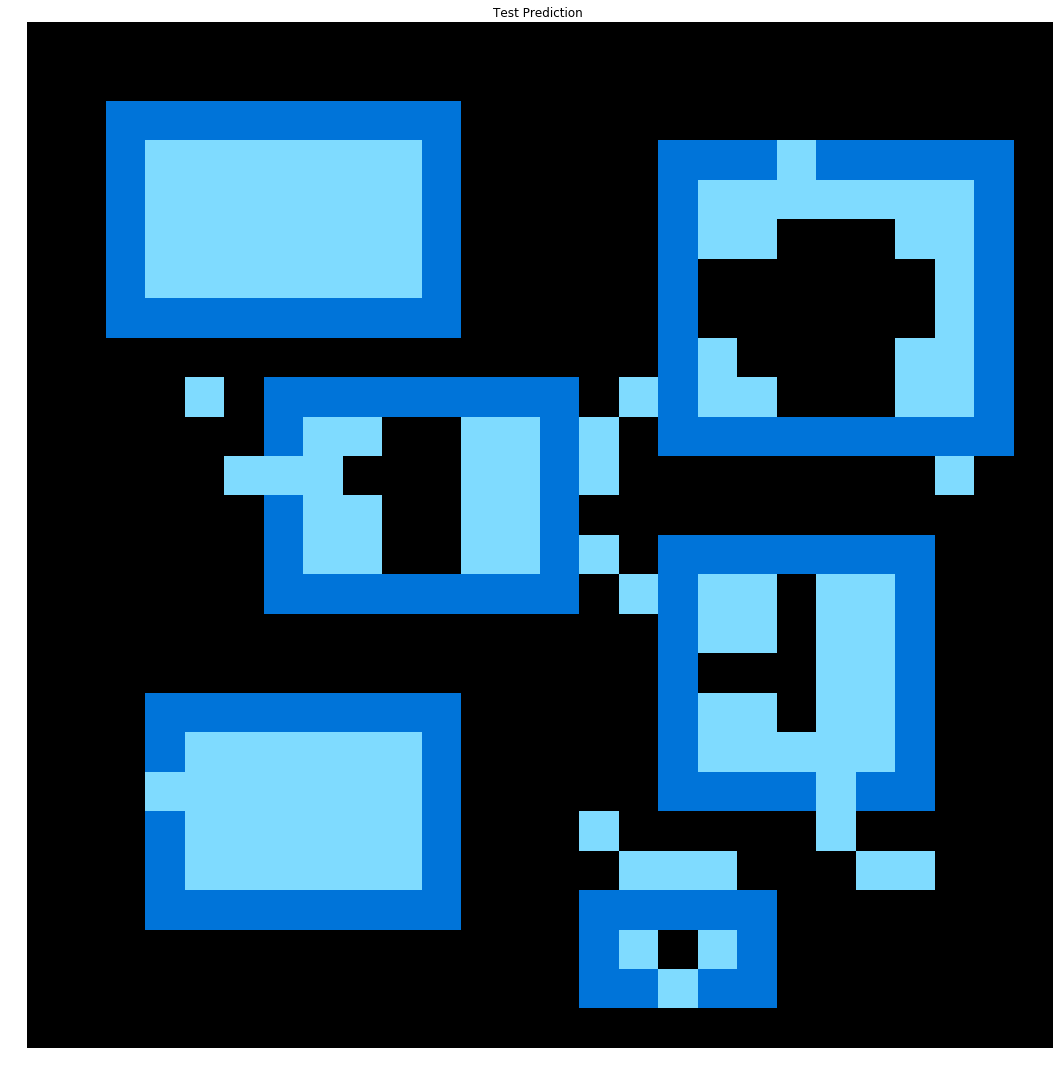

Made predictions for  55783887
ensemble accuracy 0.9144736842105263



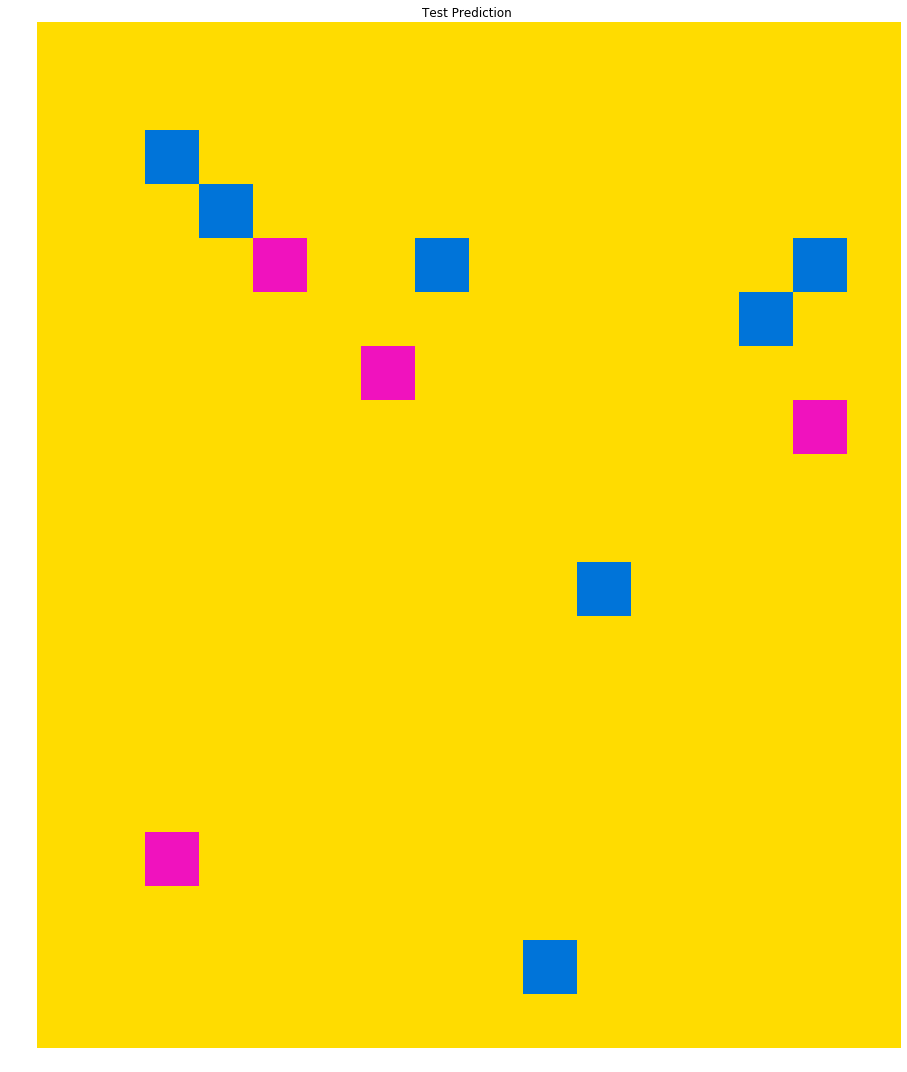

Made predictions for  575b1a71
ensemble accuracy 0.94



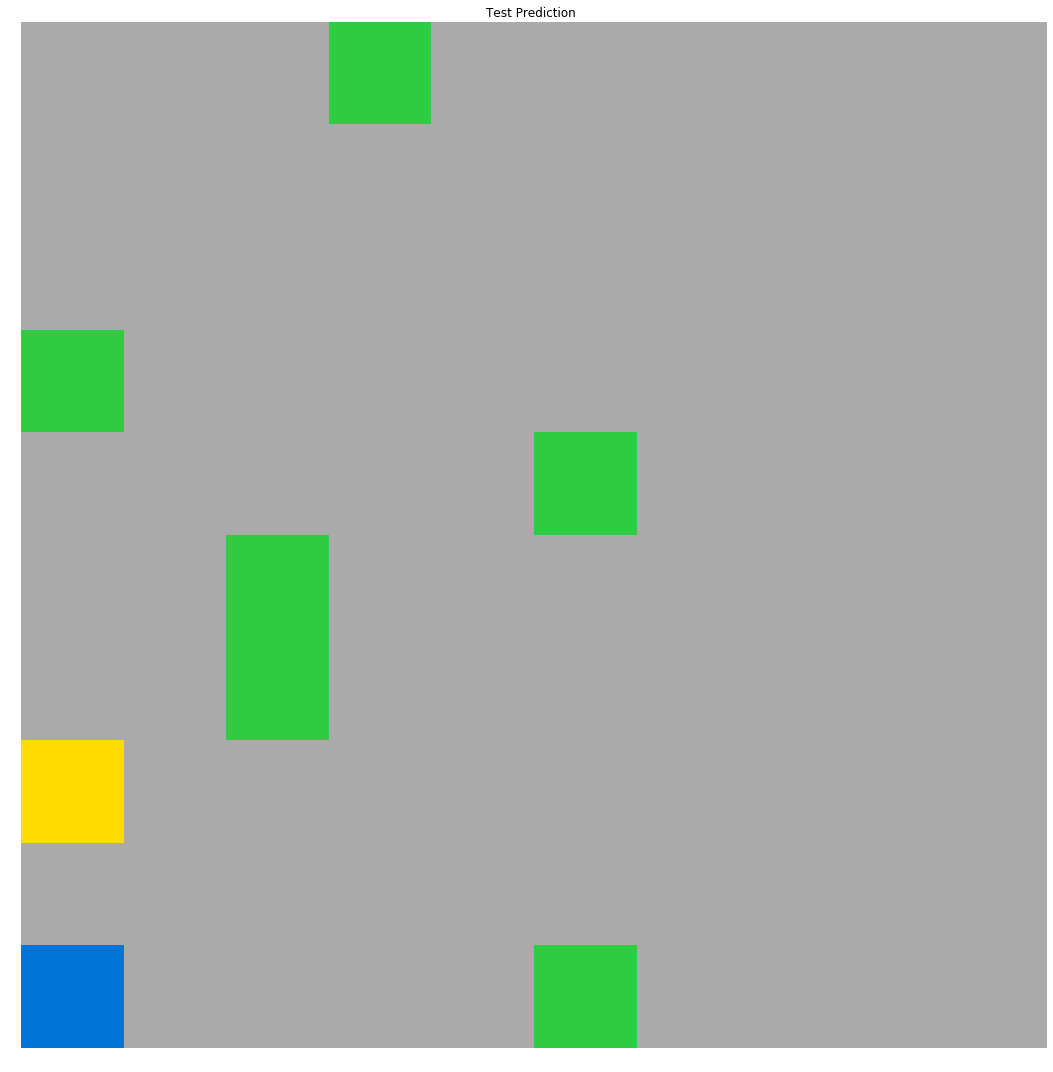

Number of input rows: 6 cols: 6
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\5783df64.json

Number of input rows: 17 cols: 18
Number of target rows: 8 cols: 16
ignoring task abstraction-and-reasoning-challenge\evaluation\5833af48.json

Made predictions for  58743b76
ensemble accuracy 0.9081632653061225



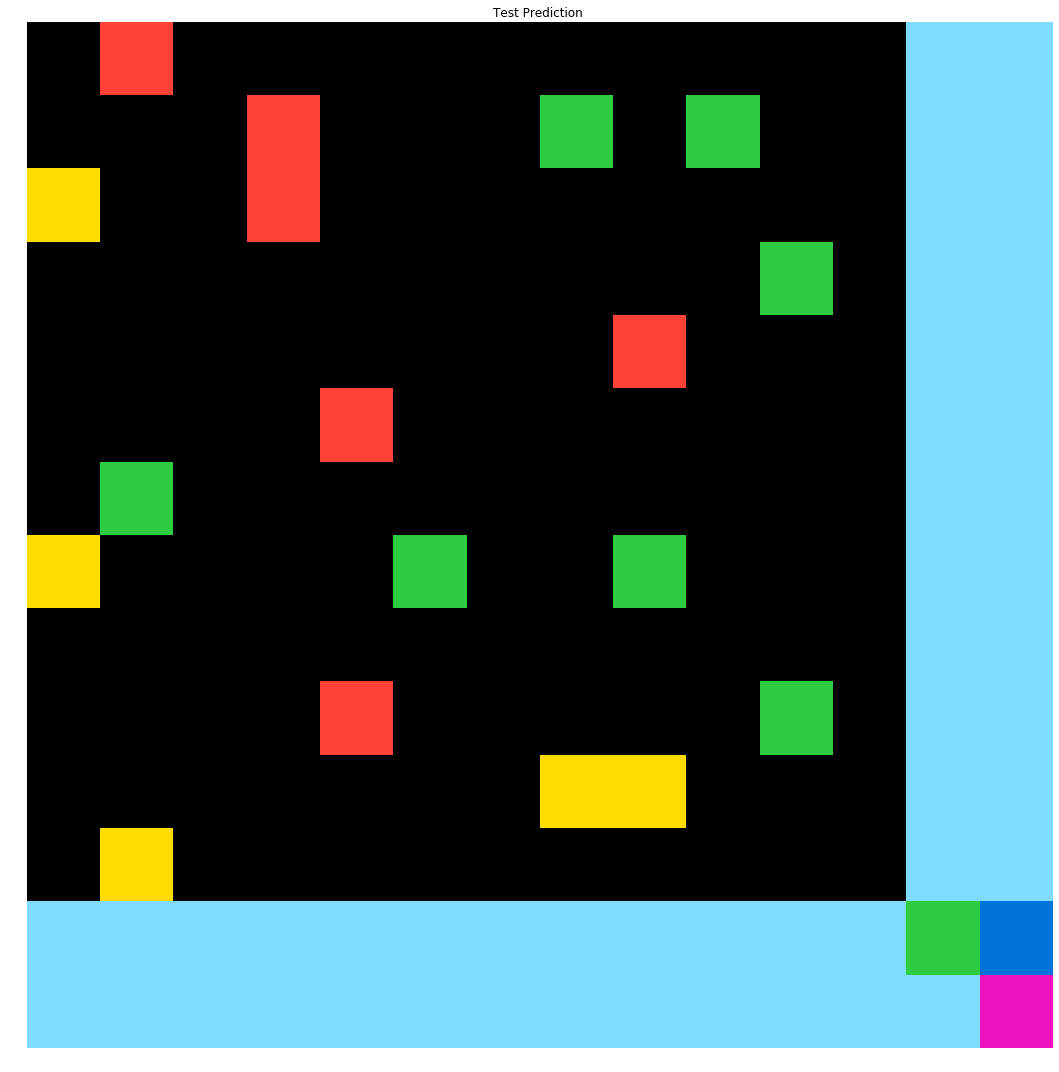

Made predictions for  58e15b12
ensemble accuracy 0.8645833333333334



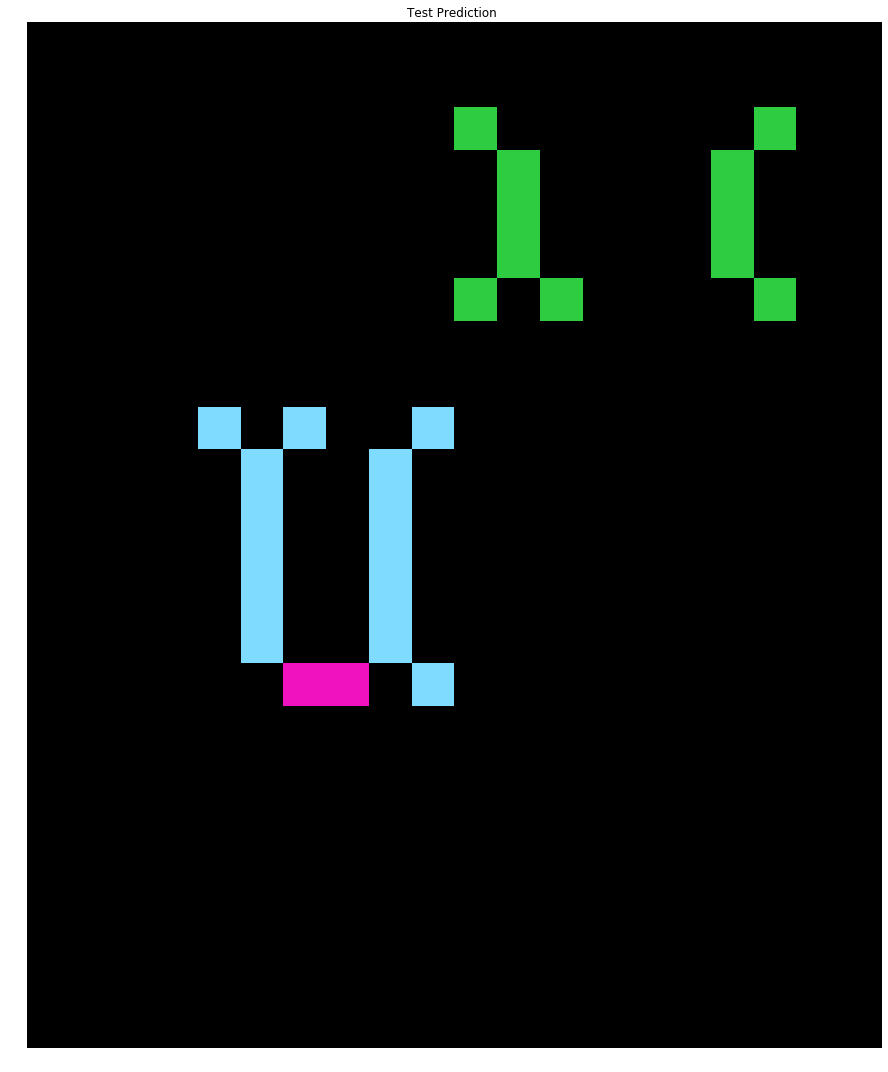

Number of input rows: 3 cols: 3
Number of target rows: 3 cols: 12
ignoring task abstraction-and-reasoning-challenge\evaluation\59341089.json

Made predictions for  5a5a2103
ensemble accuracy 0.328125



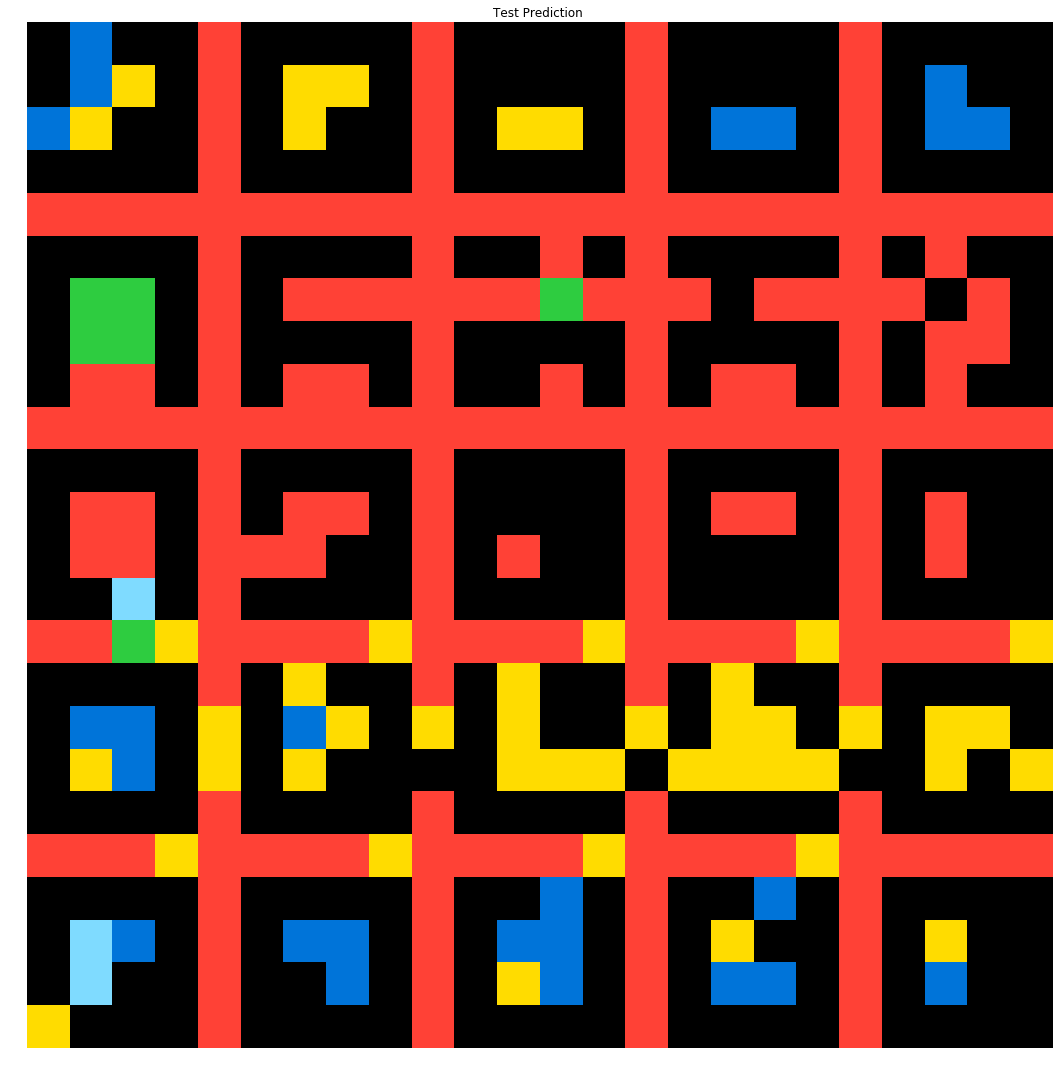

Made predictions for  5af49b42
ensemble accuracy 0.9281045751633987



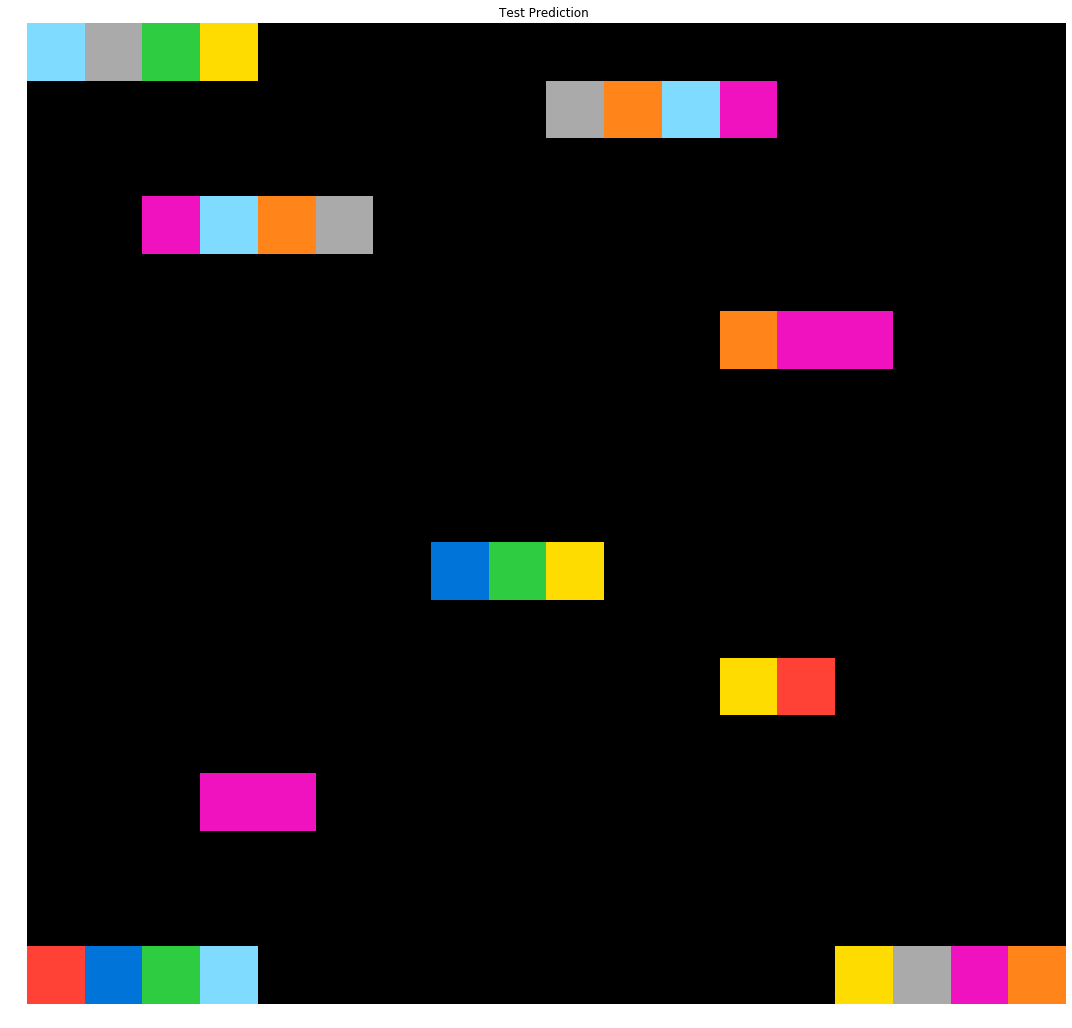

Made predictions for  5b526a93
ensemble accuracy 0.8476190476190476



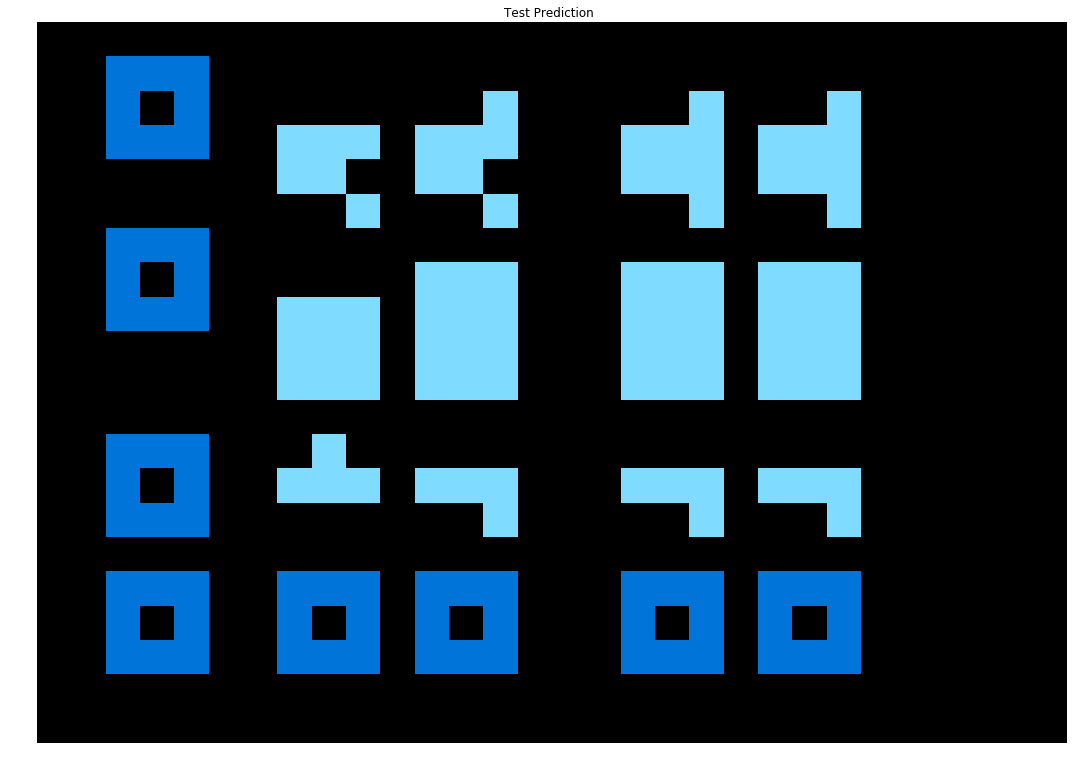

Made predictions for  5b692c0f
ensemble accuracy 0.90625



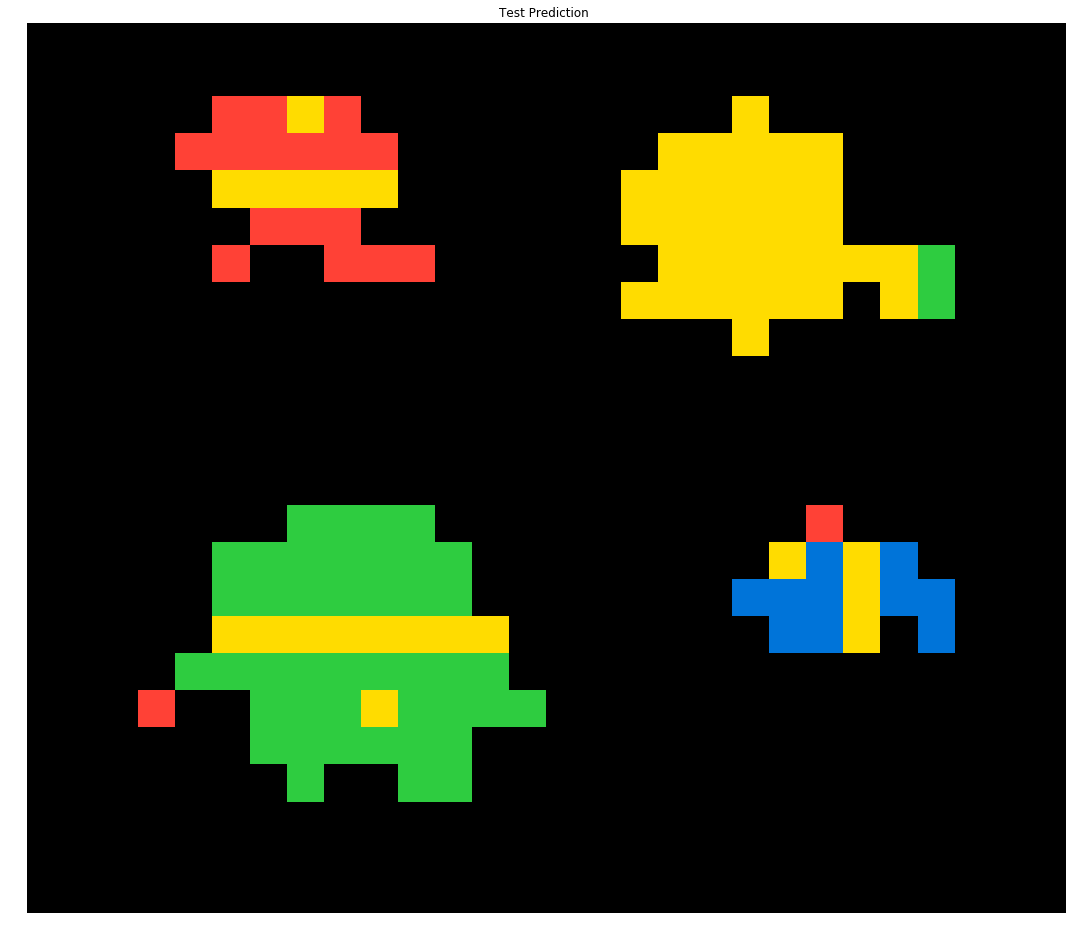

Number of input rows: 4 cols: 4
Number of target rows: 16 cols: 16
ignoring task abstraction-and-reasoning-challenge\evaluation\5b6cbef5.json

Number of input rows: 6 cols: 9
Number of target rows: 6 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\5d2a5c43.json

Made predictions for  5ffb2104
ensemble accuracy 0.79



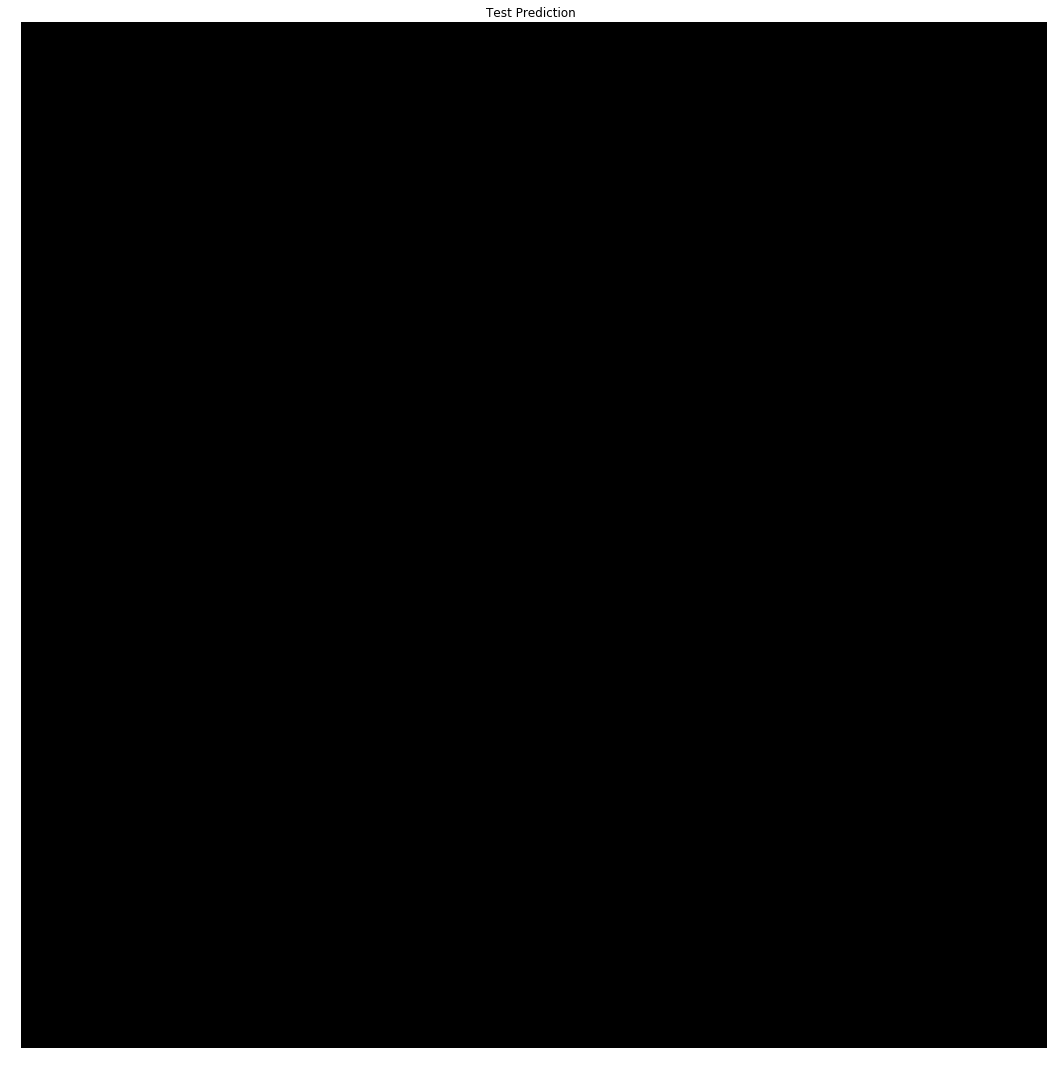

Made predictions for  604001fa
ensemble accuracy 0.85



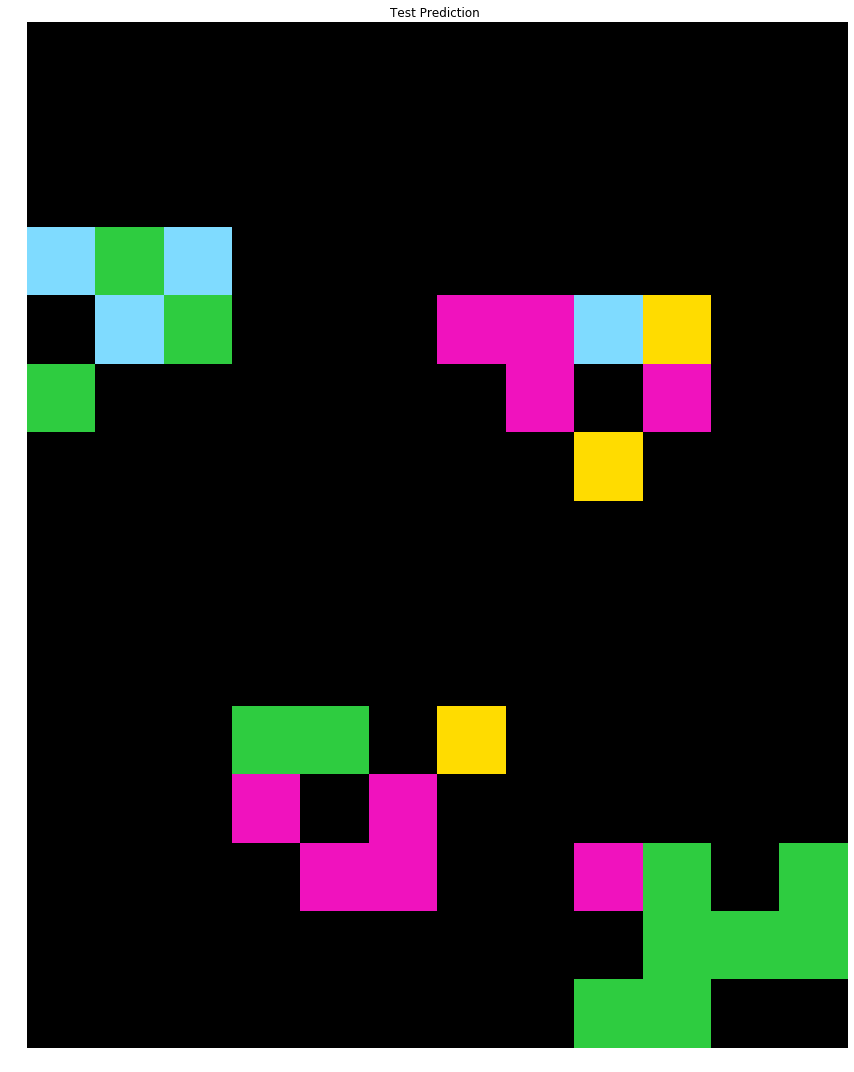

Made predictions for  60a26a3e
ensemble accuracy 0.9333333333333333



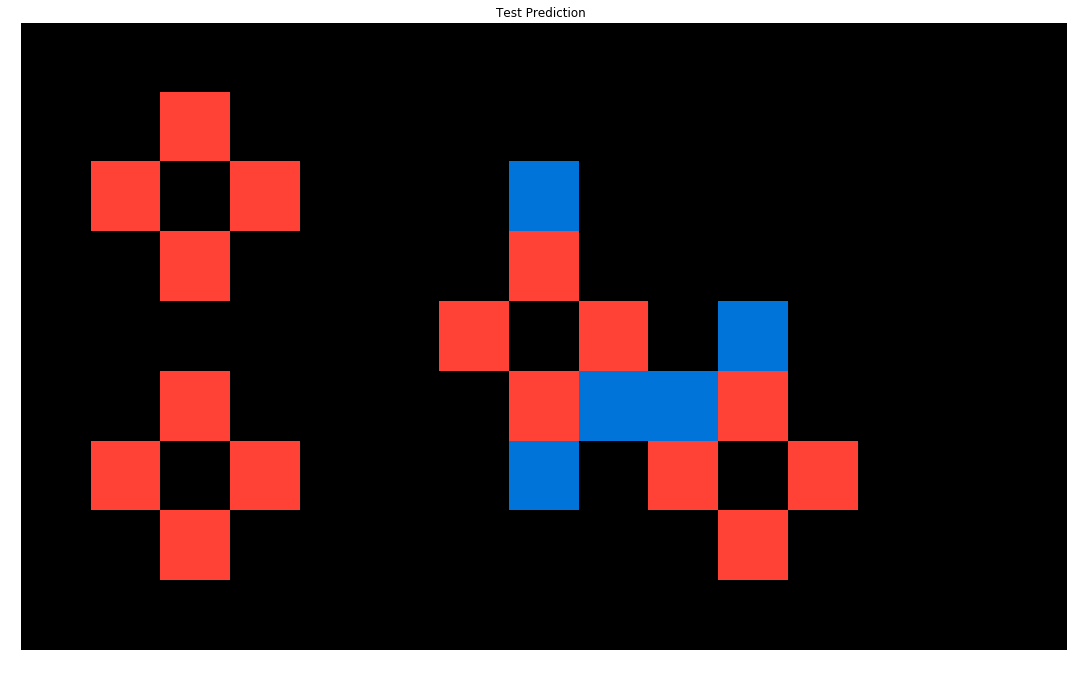

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\60c09cac.json

Made predictions for  626c0bcc
ensemble accuracy 0.7959183673469388



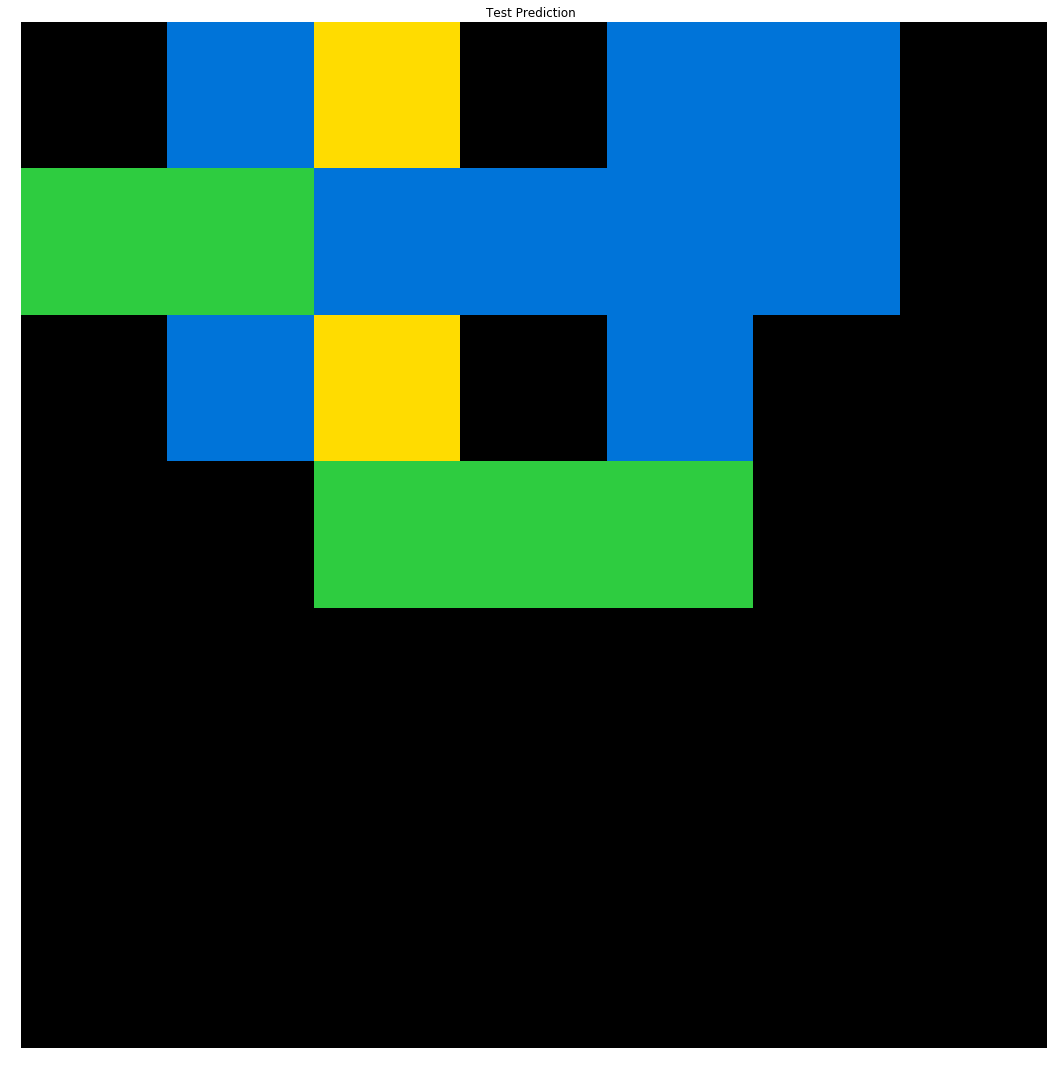

Made predictions for  62ab2642
ensemble accuracy 0.7833333333333333



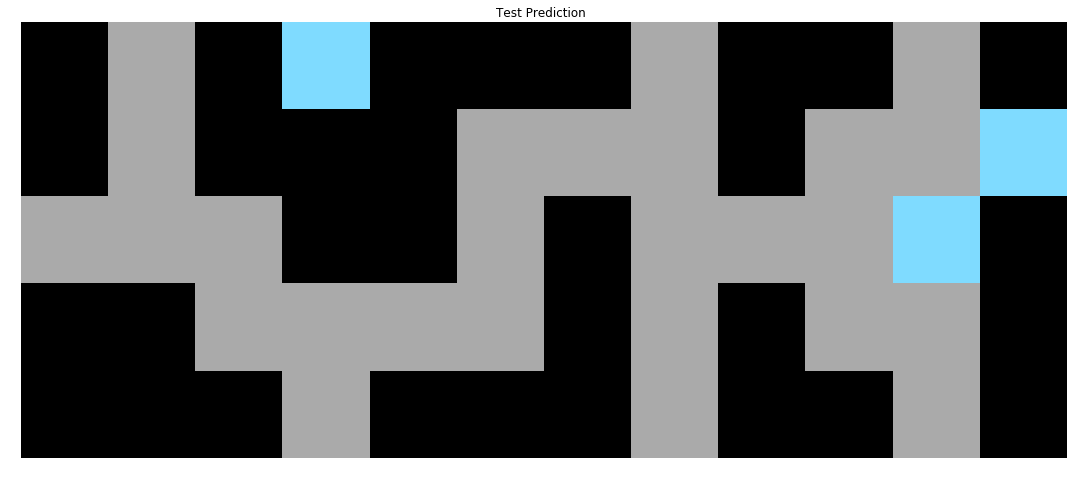

Made predictions for  62b74c02
ensemble accuracy 0.39285714285714285



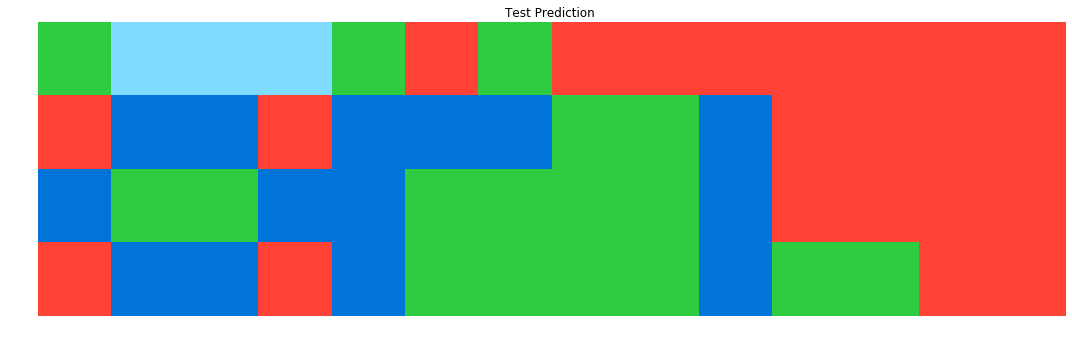

Made predictions for  639f5a19
ensemble accuracy 0.7901701323251418



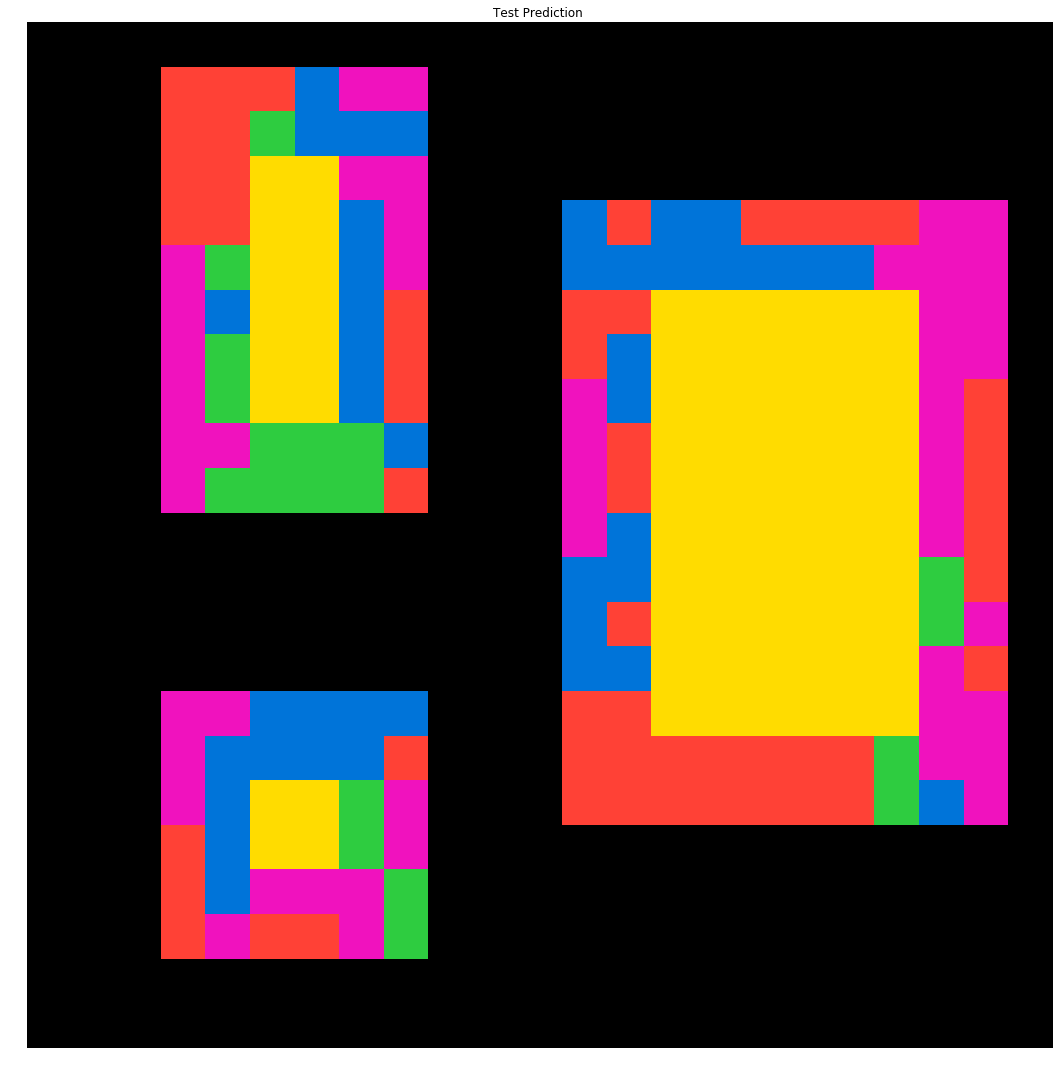

Made predictions for  642248e4
ensemble accuracy 0.9131944444444444



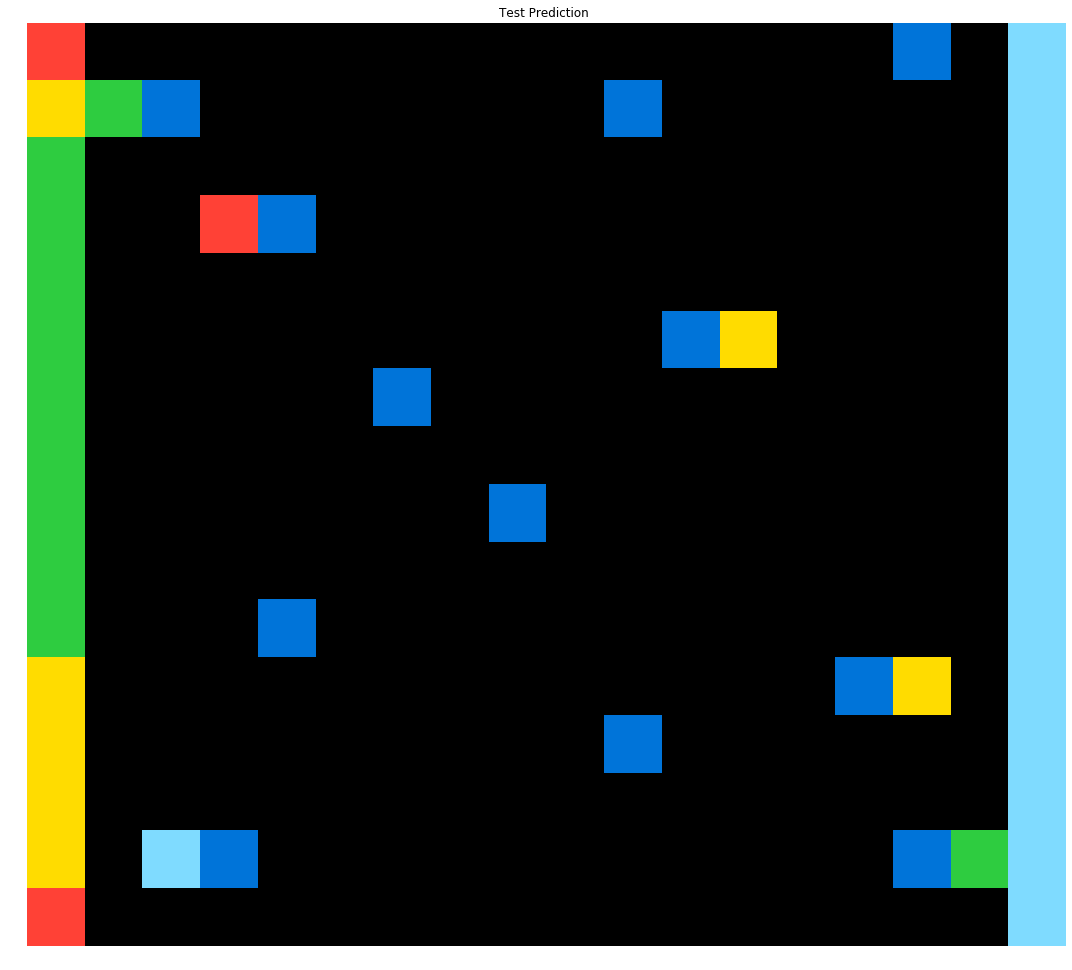

Number of input rows: 26 cols: 24
Number of target rows: 1 cols: 1
ignoring task abstraction-and-reasoning-challenge\evaluation\642d658d.json

Made predictions for  64a7c07e
ensemble accuracy 0.8541666666666666



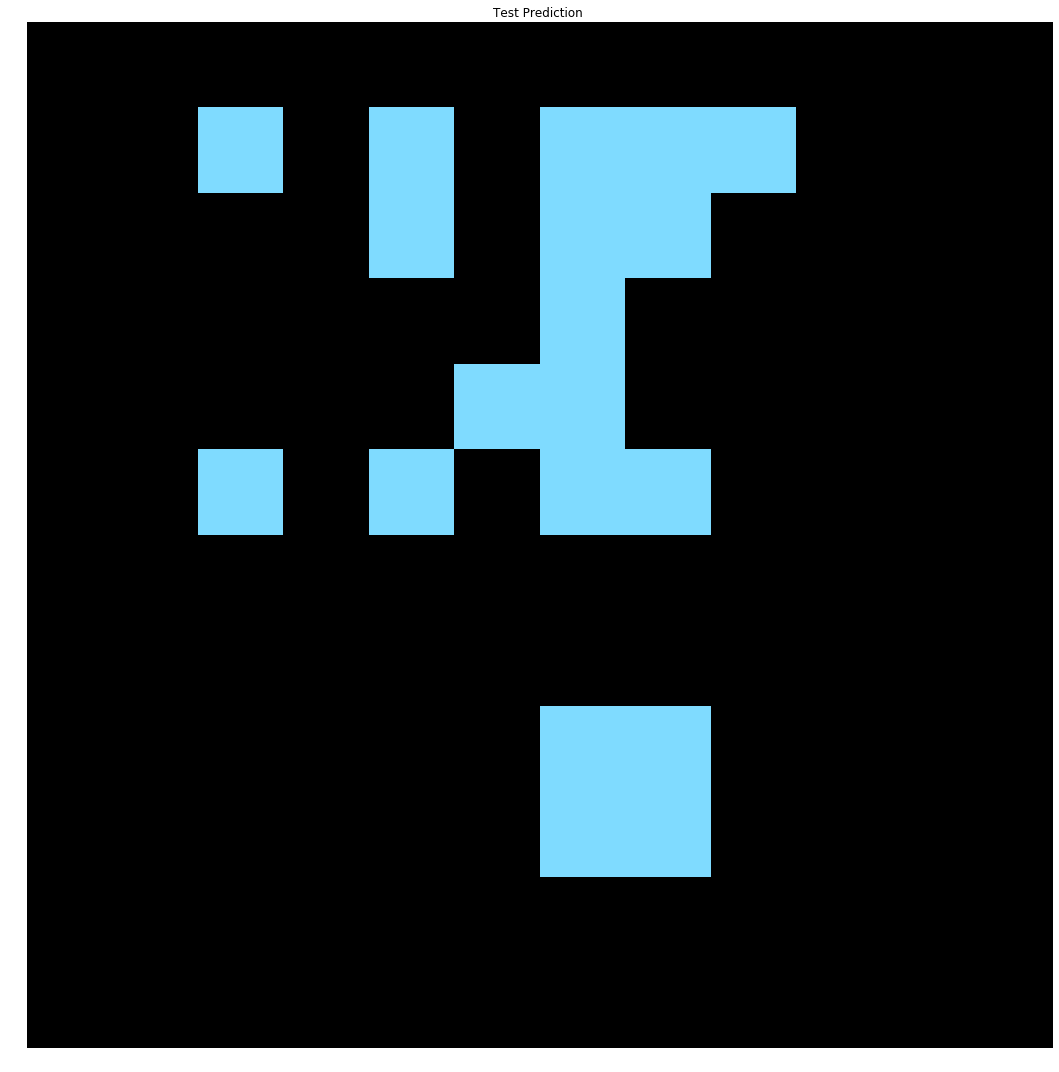

C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  66e6c45b
ensemble accuracy 0.875



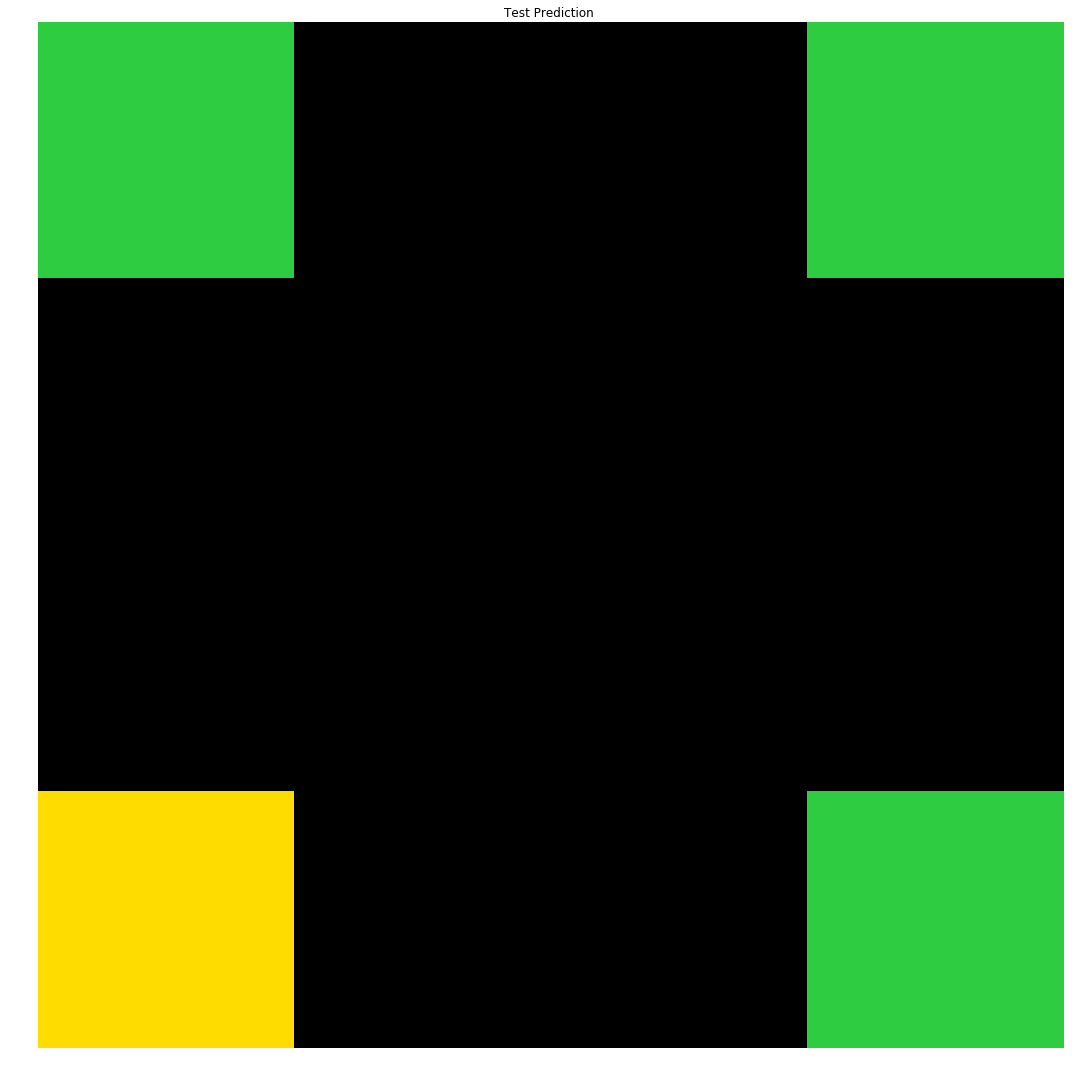

Number of input rows: 4 cols: 14
Number of target rows: 4 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\66f2d22f.json

Number of input rows: 13 cols: 17
Number of target rows: 3 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\67636eac.json

Number of input rows: 16 cols: 16
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\67b4a34d.json

Made predictions for  67c52801
ensemble accuracy 0.5714285714285714



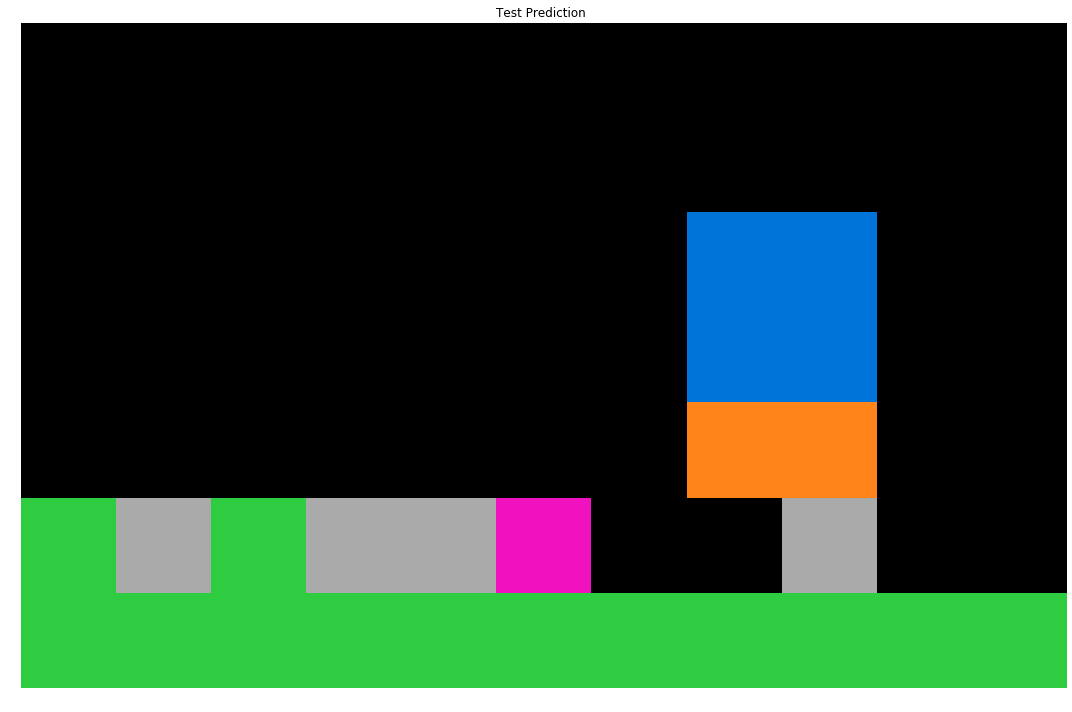

Number of input rows: 6 cols: 6
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\68b67ca3.json

Made predictions for  692cd3b6
ensemble accuracy 0.8133333333333334



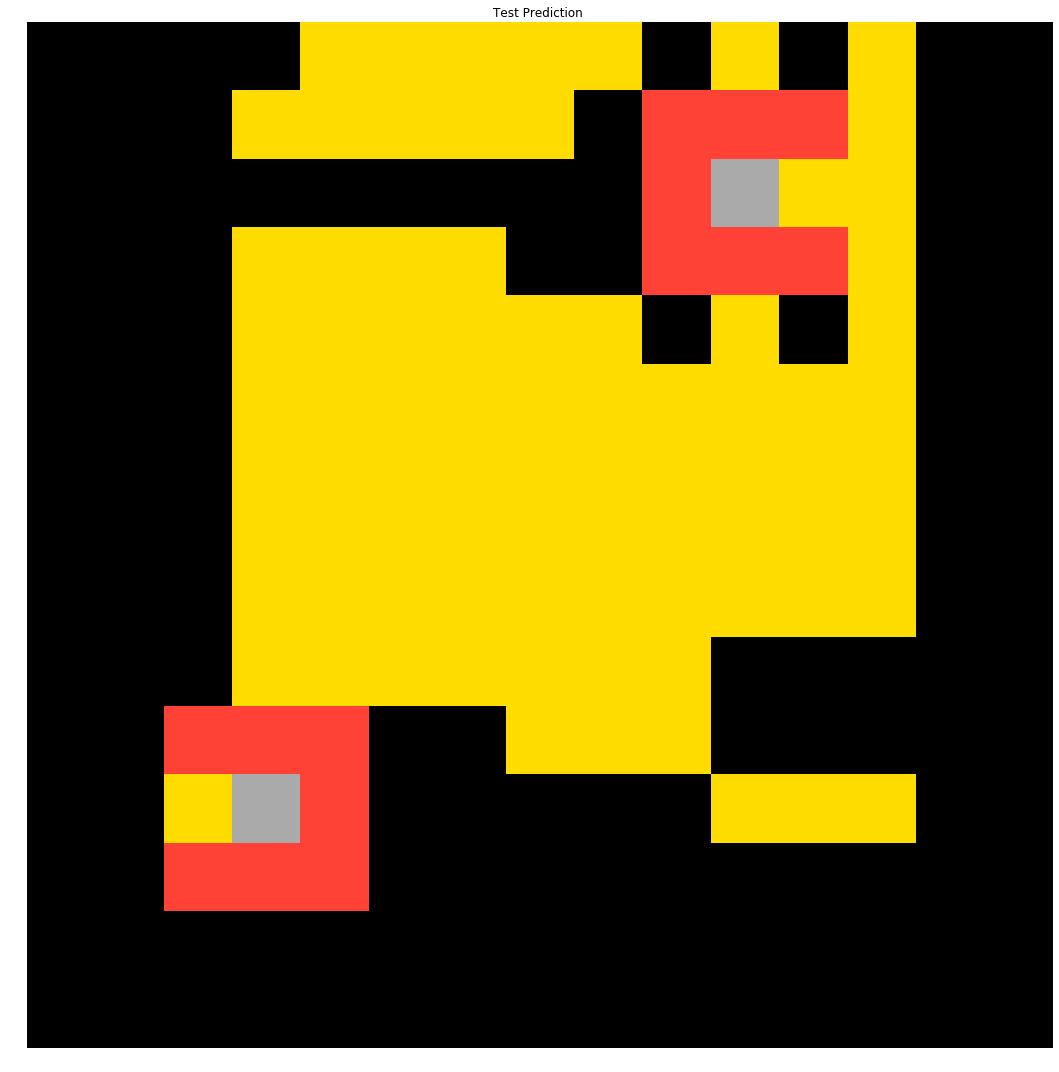

Number of input rows: 3 cols: 3
Number of target rows: 15 cols: 15
ignoring task abstraction-and-reasoning-challenge\evaluation\695367ec.json

Made predictions for  696d4842
ensemble accuracy 0.935



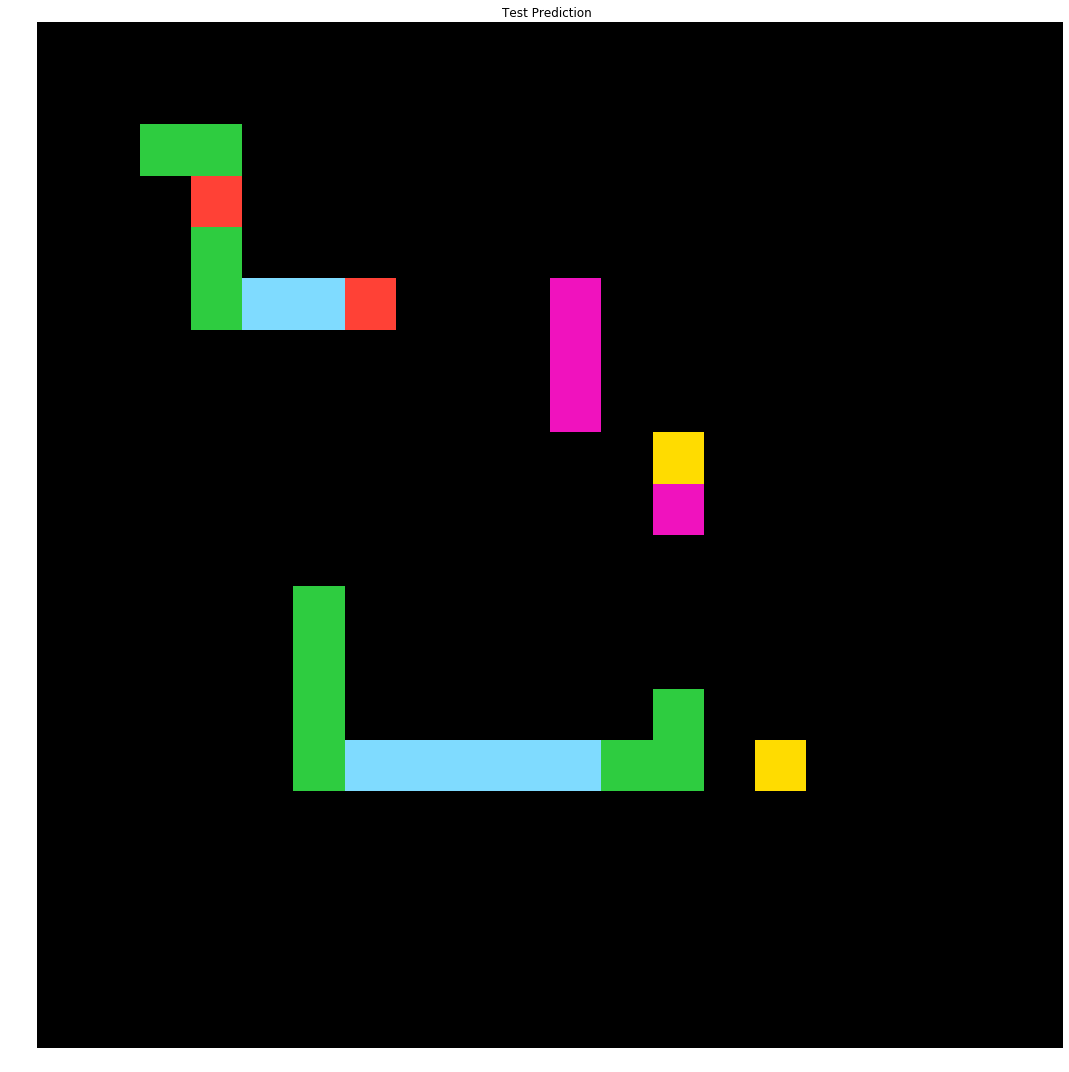

Made predictions for  69889d6e
ensemble accuracy 0.92



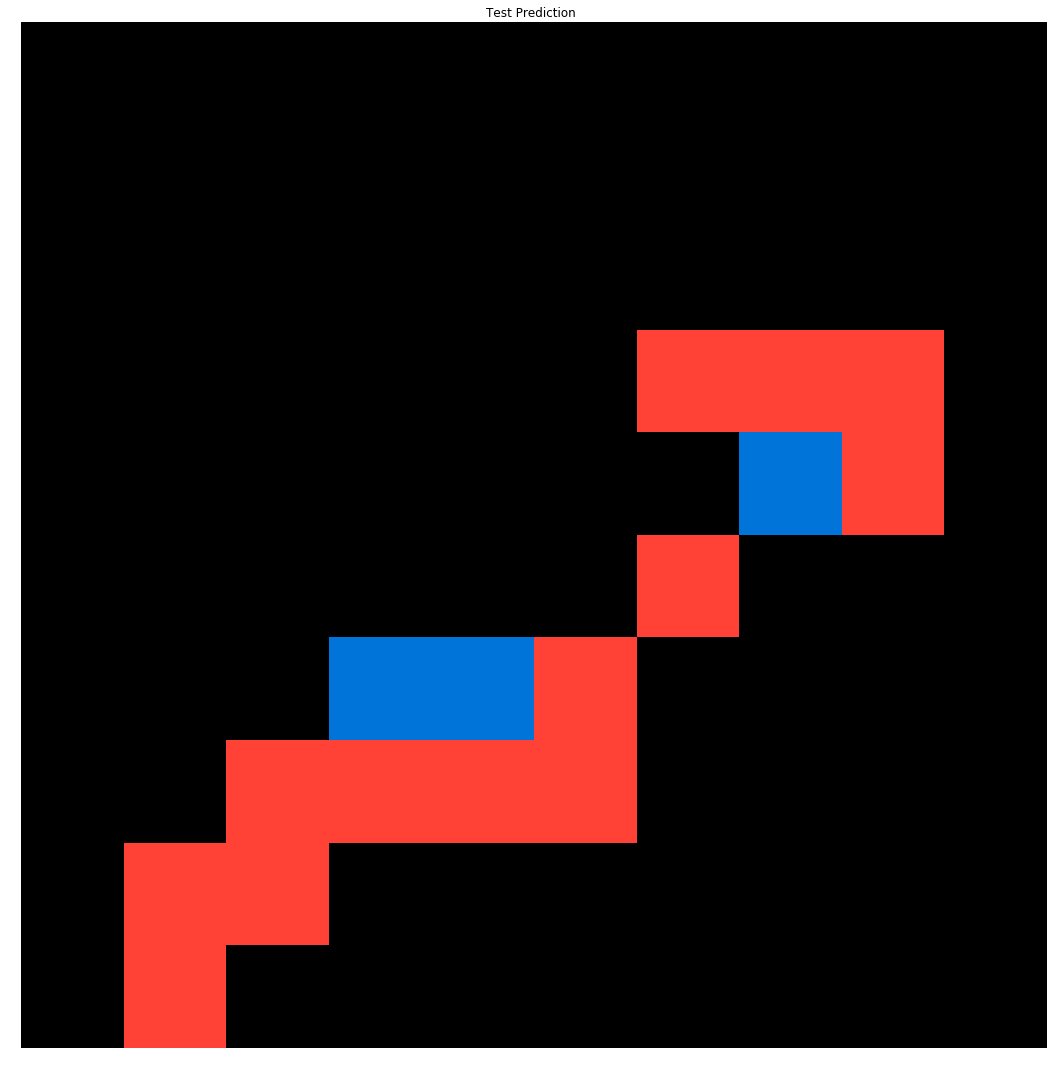

Number of input rows: 15 cols: 5
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\6a11f6da.json

Made predictions for  6ad5bdfd
ensemble accuracy 0.77



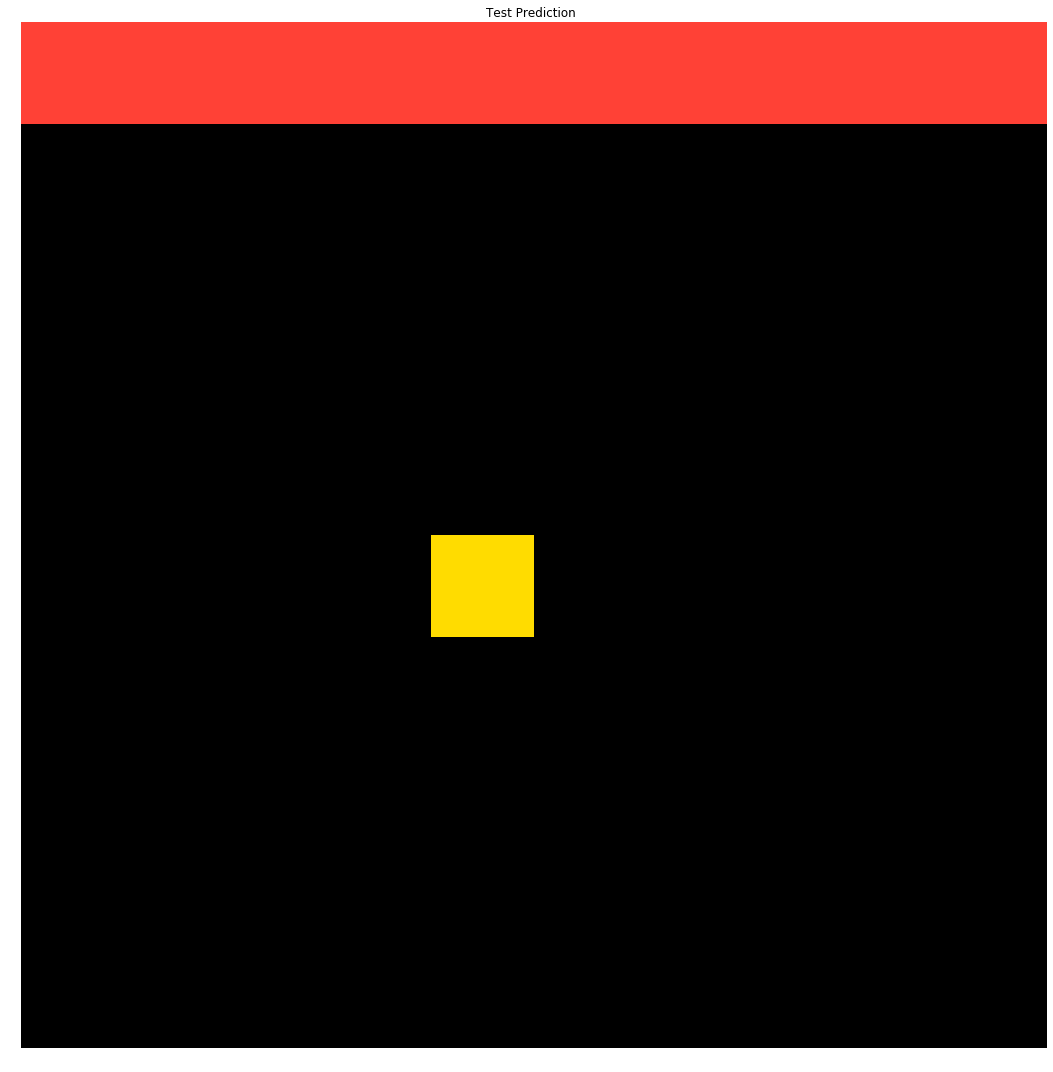

Made predictions for  6df30ad6
ensemble accuracy 0.88



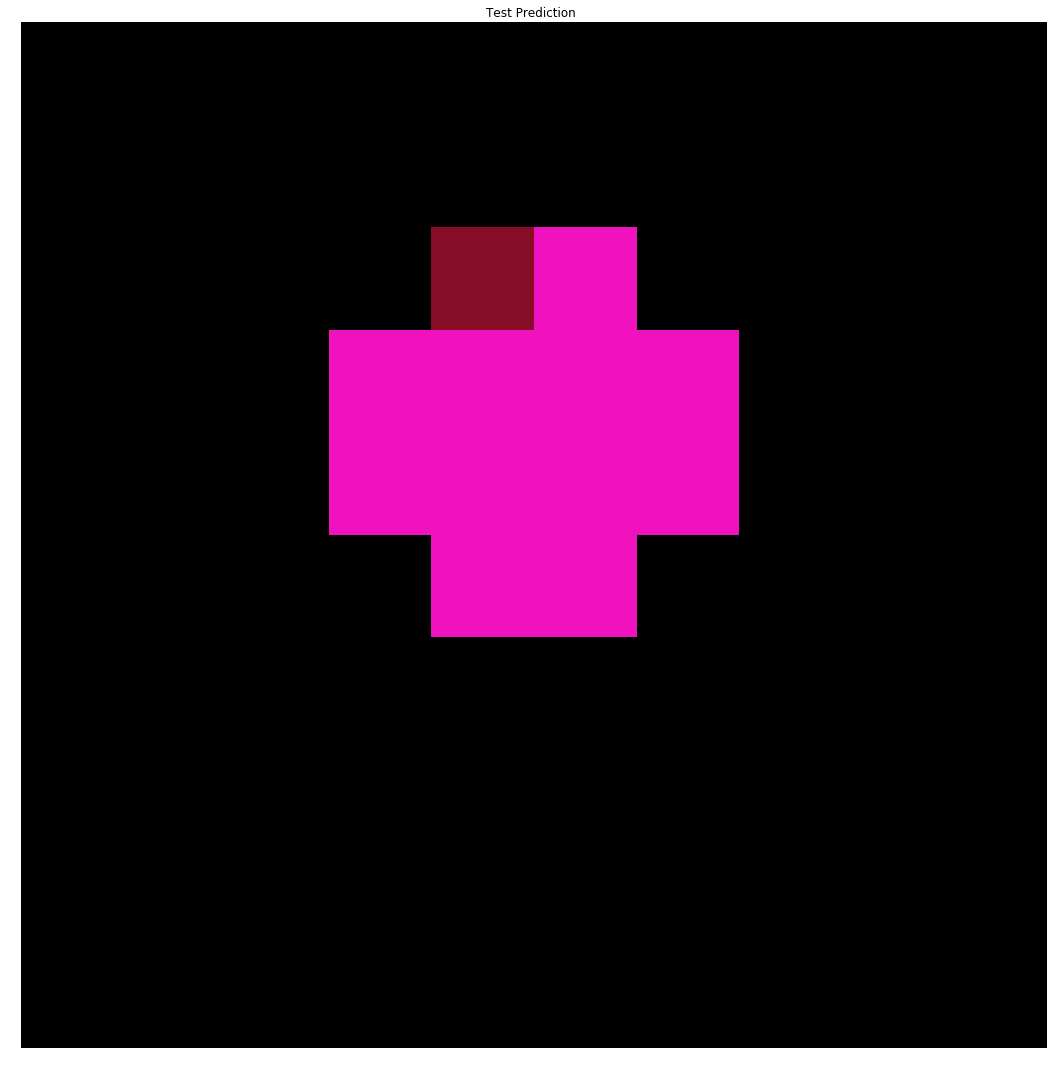

Made predictions for  6ea4a07e
ensemble accuracy 1.0



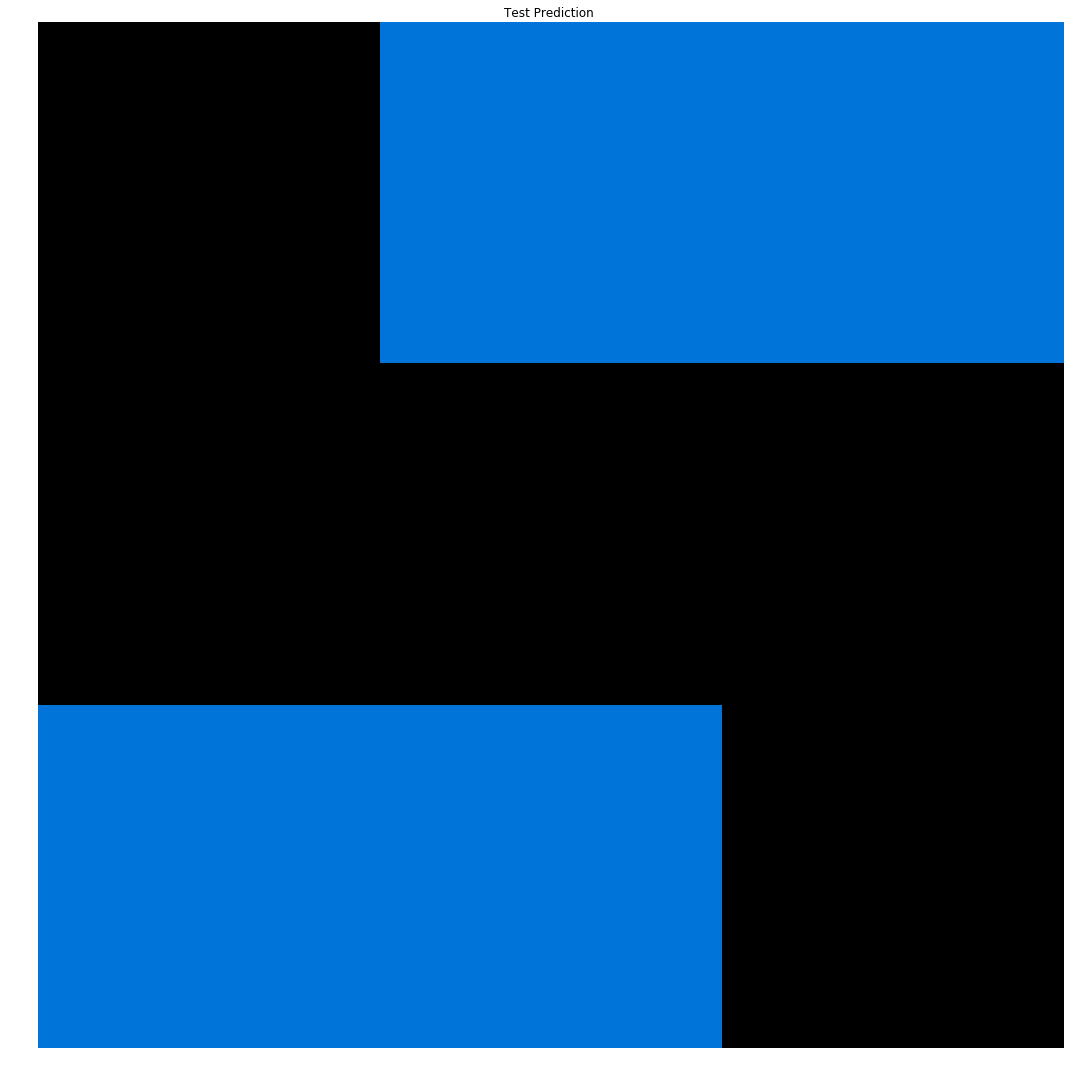

Made predictions for  6ea4a07e
ensemble accuracy 1.0



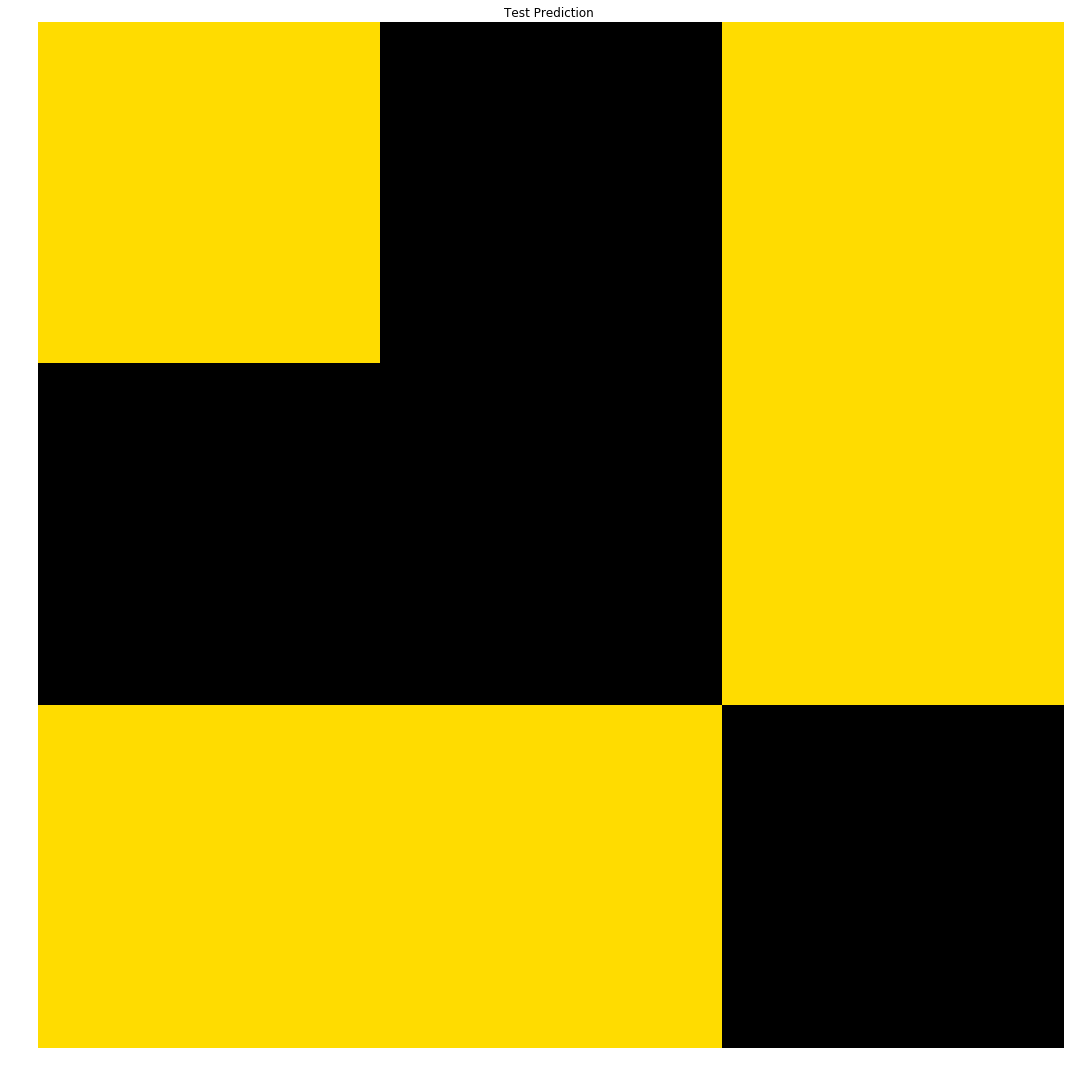

Number of input rows: 10 cols: 5
Number of target rows: 10 cols: 10
ignoring task abstraction-and-reasoning-challenge\evaluation\6f473927.json

Number of input rows: 21 cols: 21
Number of target rows: 3 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\7039b2d7.json

Made predictions for  705a3229
ensemble accuracy 0.875



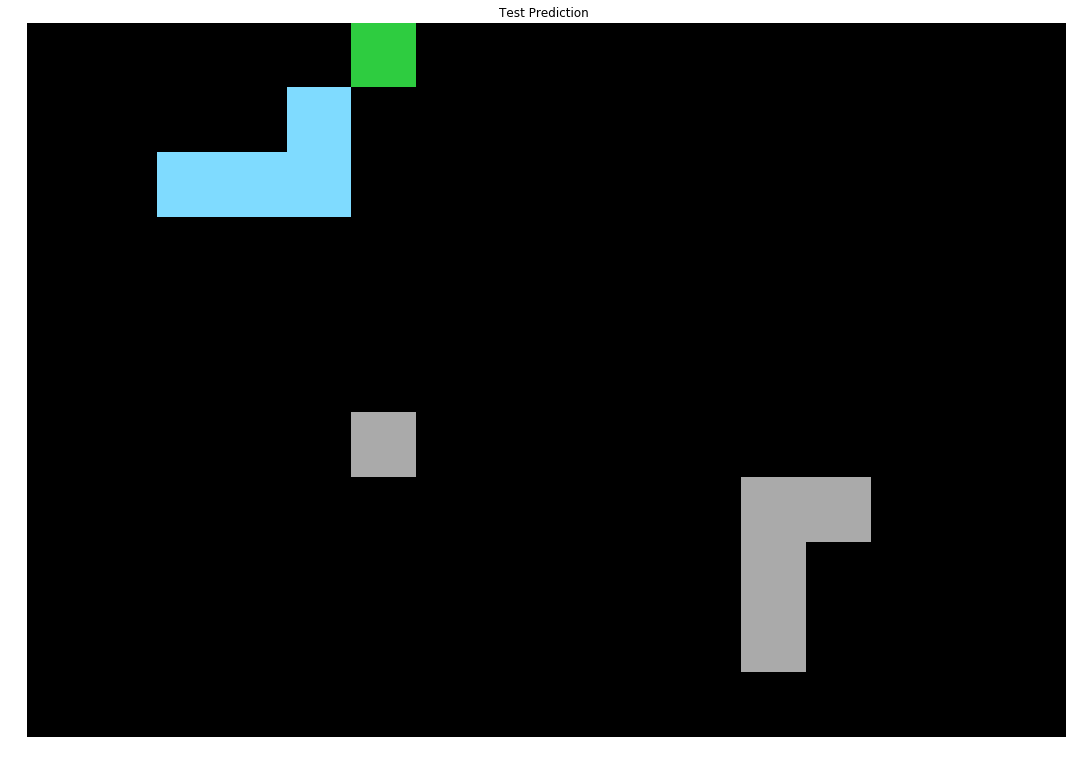

Made predictions for  712bf12e
ensemble accuracy 0.8461538461538461



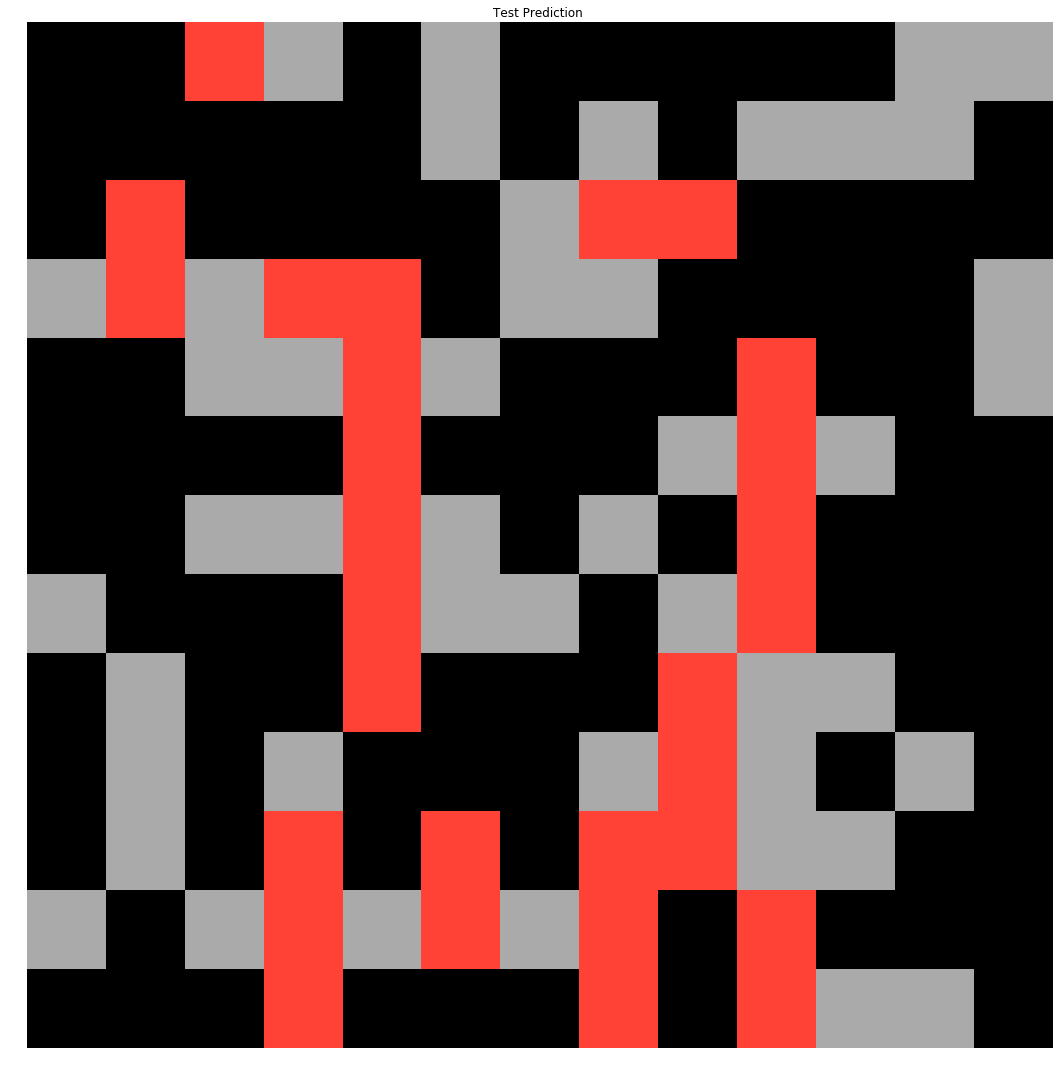

Made predictions for  72207abc
ensemble accuracy 0.9540229885057471



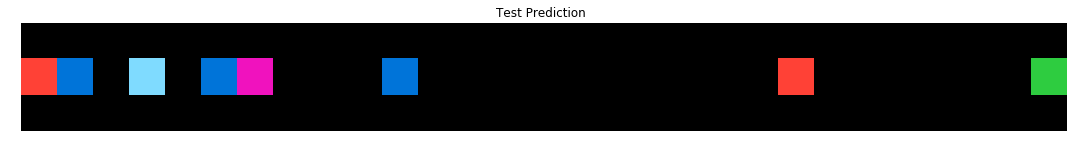

Made predictions for  72a961c9
ensemble accuracy 0.9393939393939394



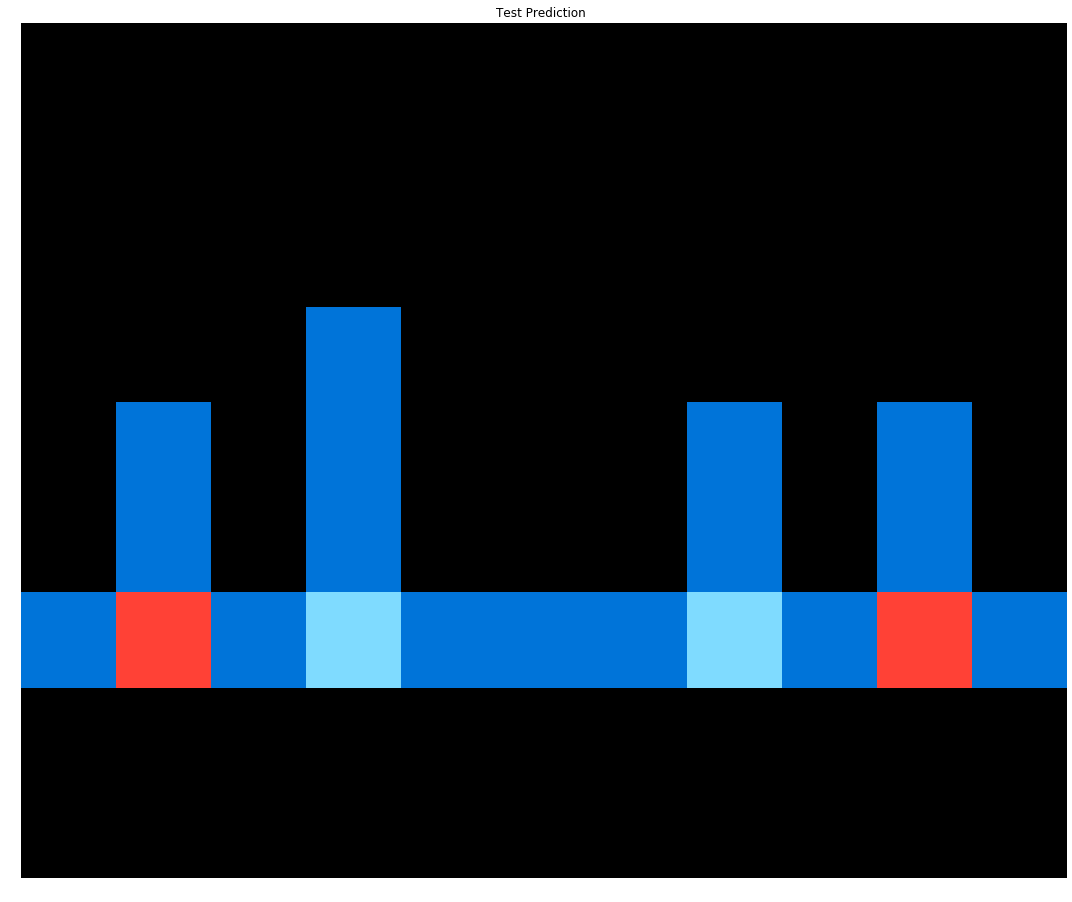

Number of input rows: 12 cols: 12
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\73182012.json

Made predictions for  73c3b0d8
ensemble accuracy 0.9375



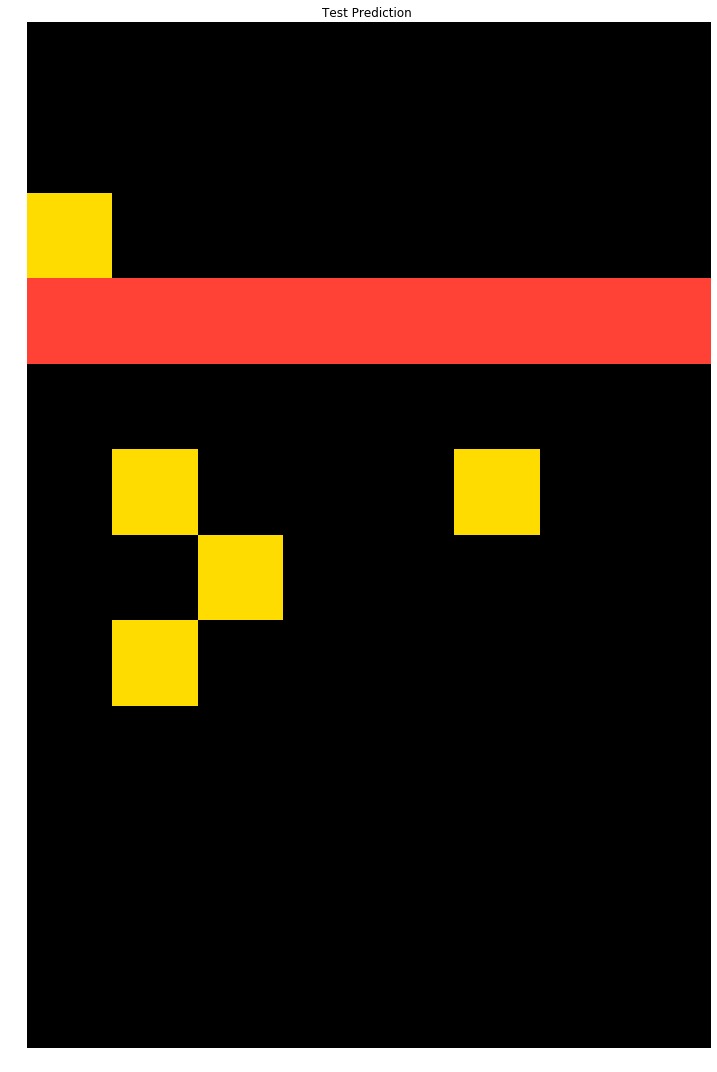

Number of input rows: 23 cols: 23
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\73ccf9c2.json

Made predictions for  759f3fd3
ensemble accuracy 0.6736111111111112



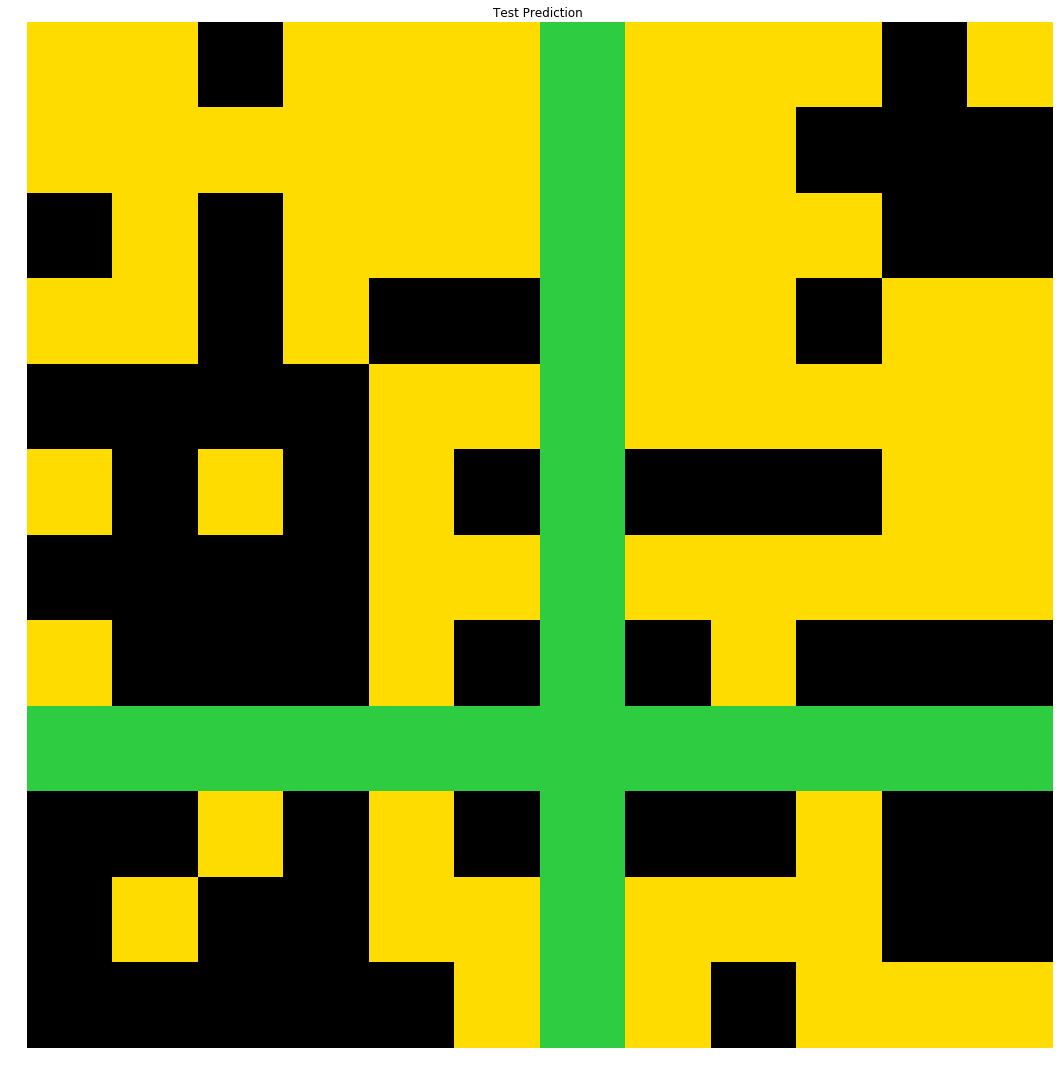

Made predictions for  762cd429
ensemble accuracy 0.34791666666666665



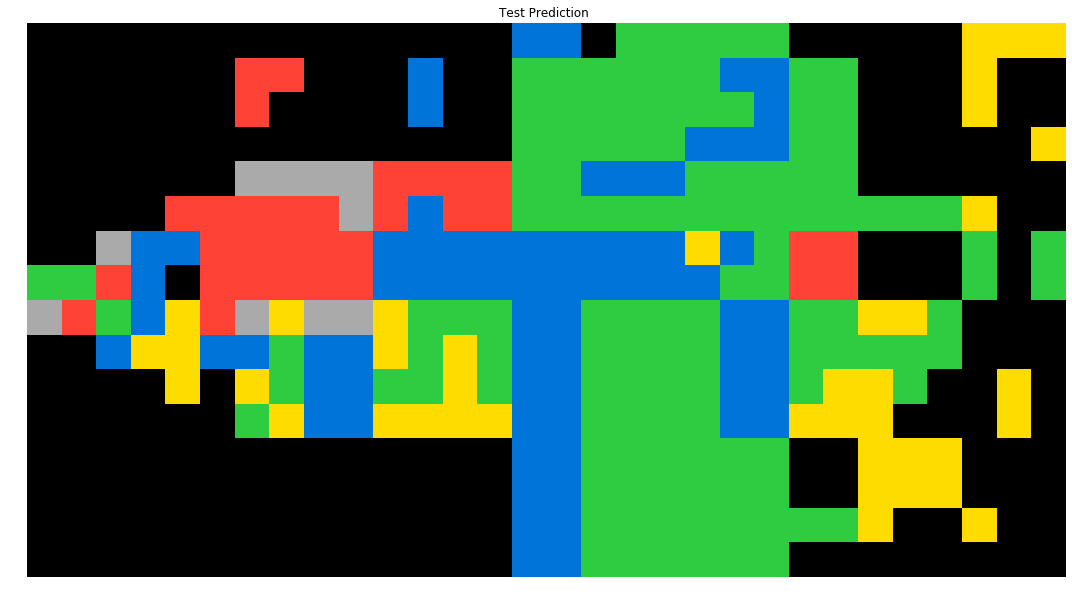

Made predictions for  770cc55f
ensemble accuracy 0.6545454545454545



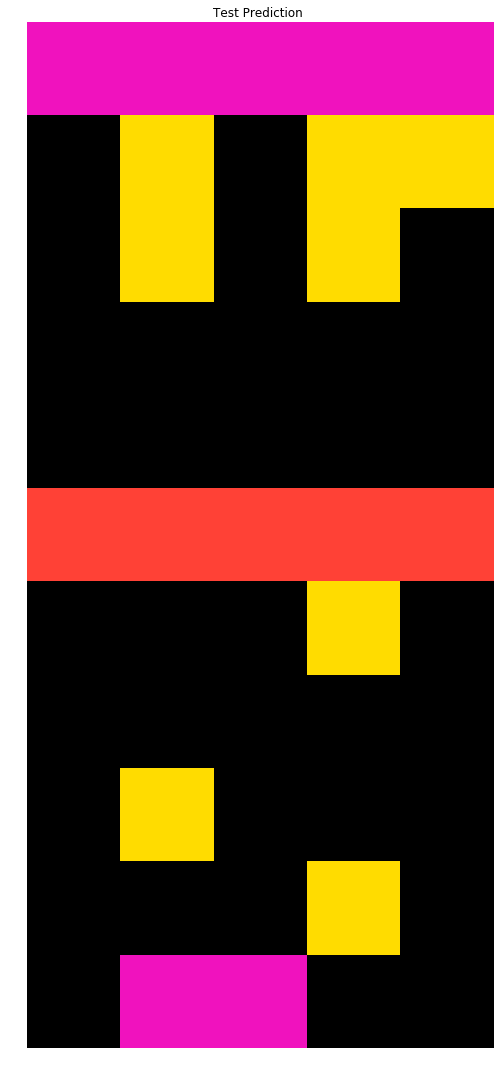

Made predictions for  782b5218
ensemble accuracy 0.47



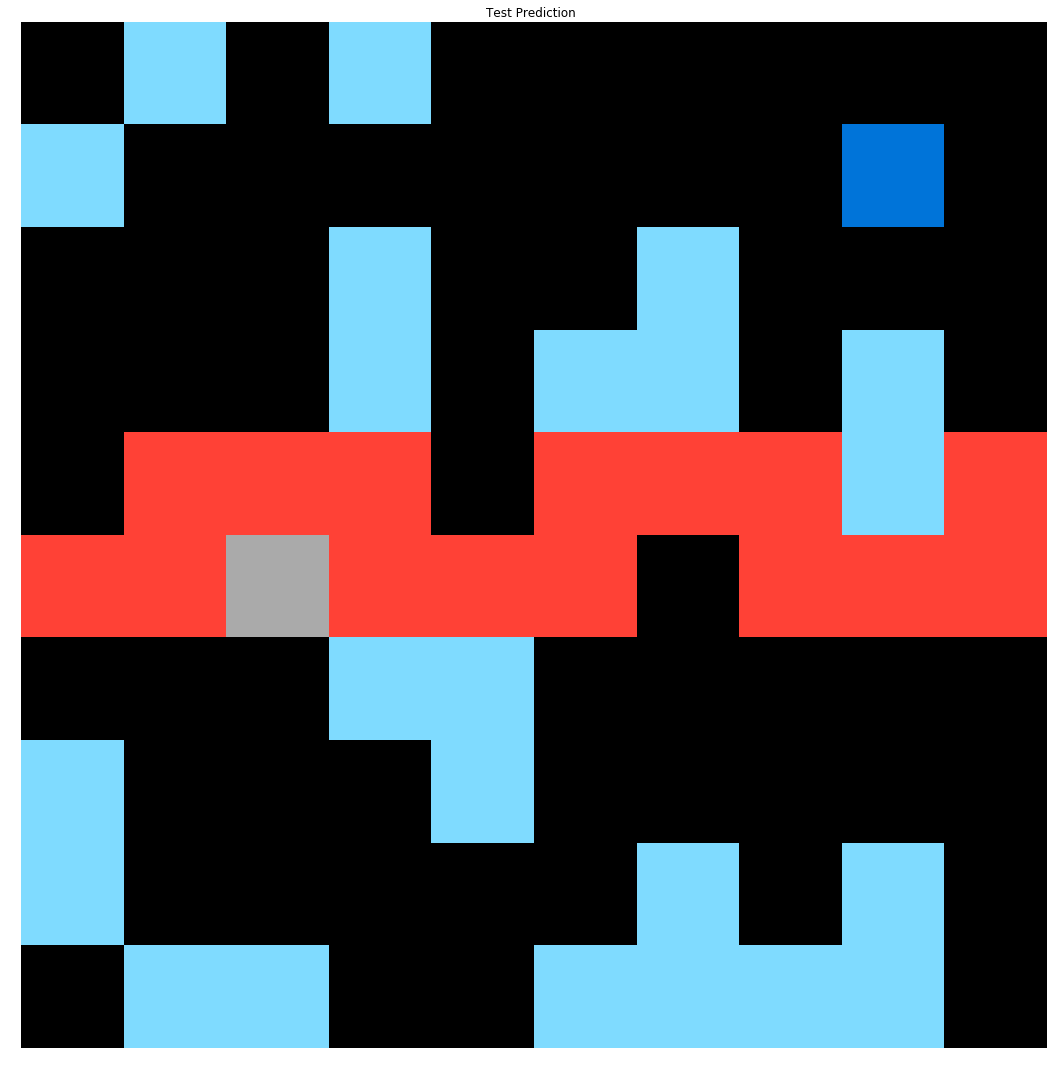

Made predictions for  79369cc6
ensemble accuracy 0.925



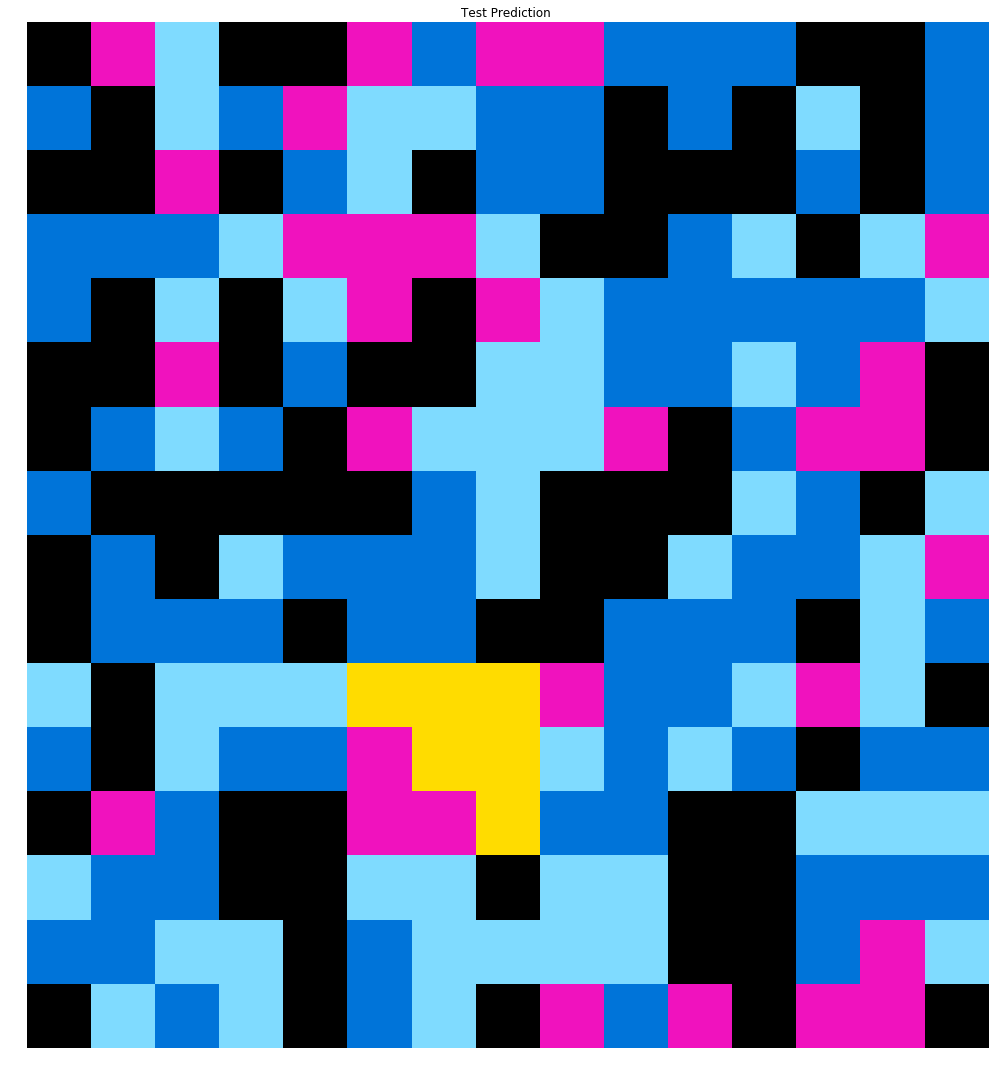

Number of input rows: 4 cols: 4
Number of target rows: 8 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\7953d61e.json

Made predictions for  79fb03f4
ensemble accuracy 0.8136094674556213



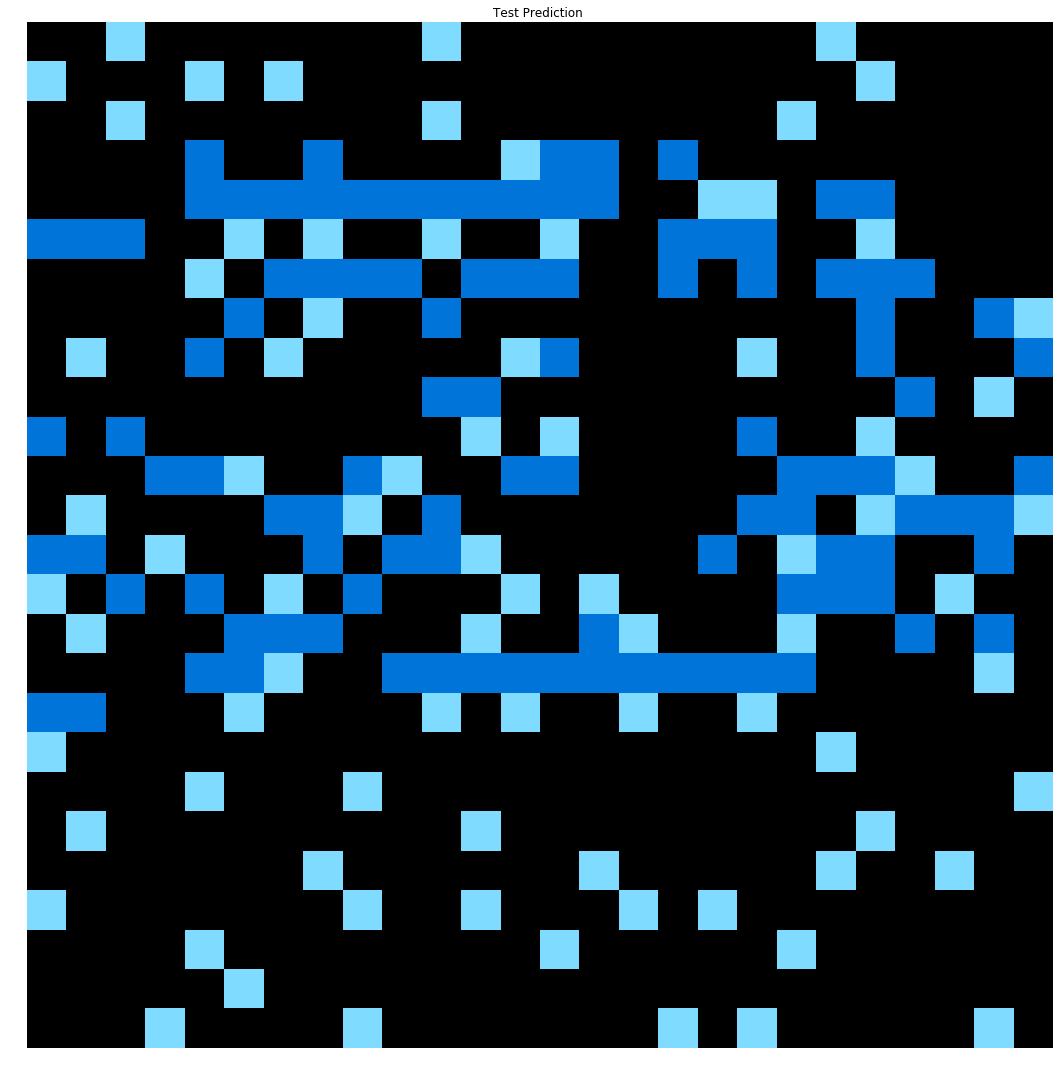

Number of input rows: 21 cols: 18
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\7bb29440.json

Made predictions for  7c8af763
ensemble accuracy 0.75



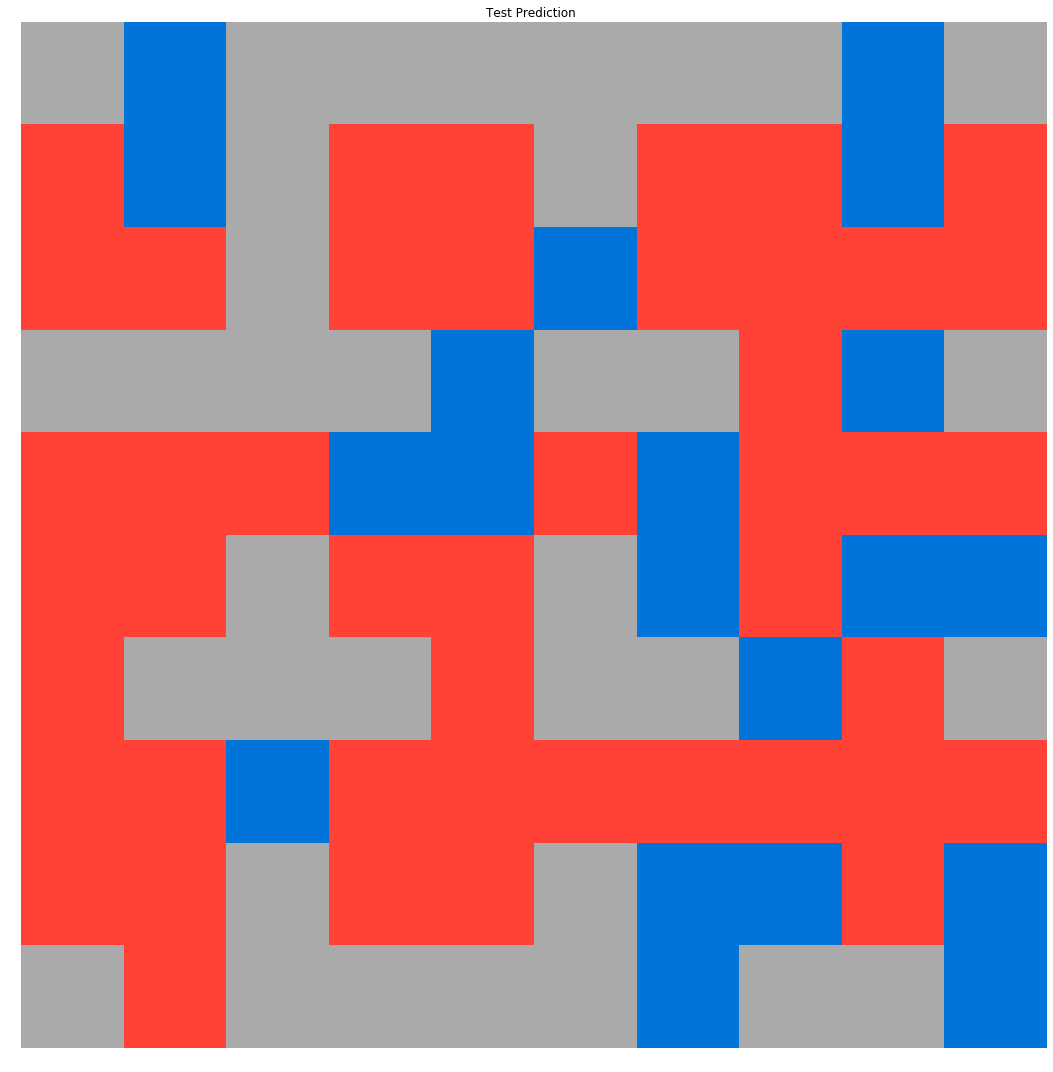

Number of input rows: 16 cols: 16
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\7c9b52a0.json

Number of input rows: 17 cols: 13
Number of target rows: 7 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\7d18a6fb.json

Made predictions for  7d1f7ee8
ensemble accuracy 0.7967980295566502



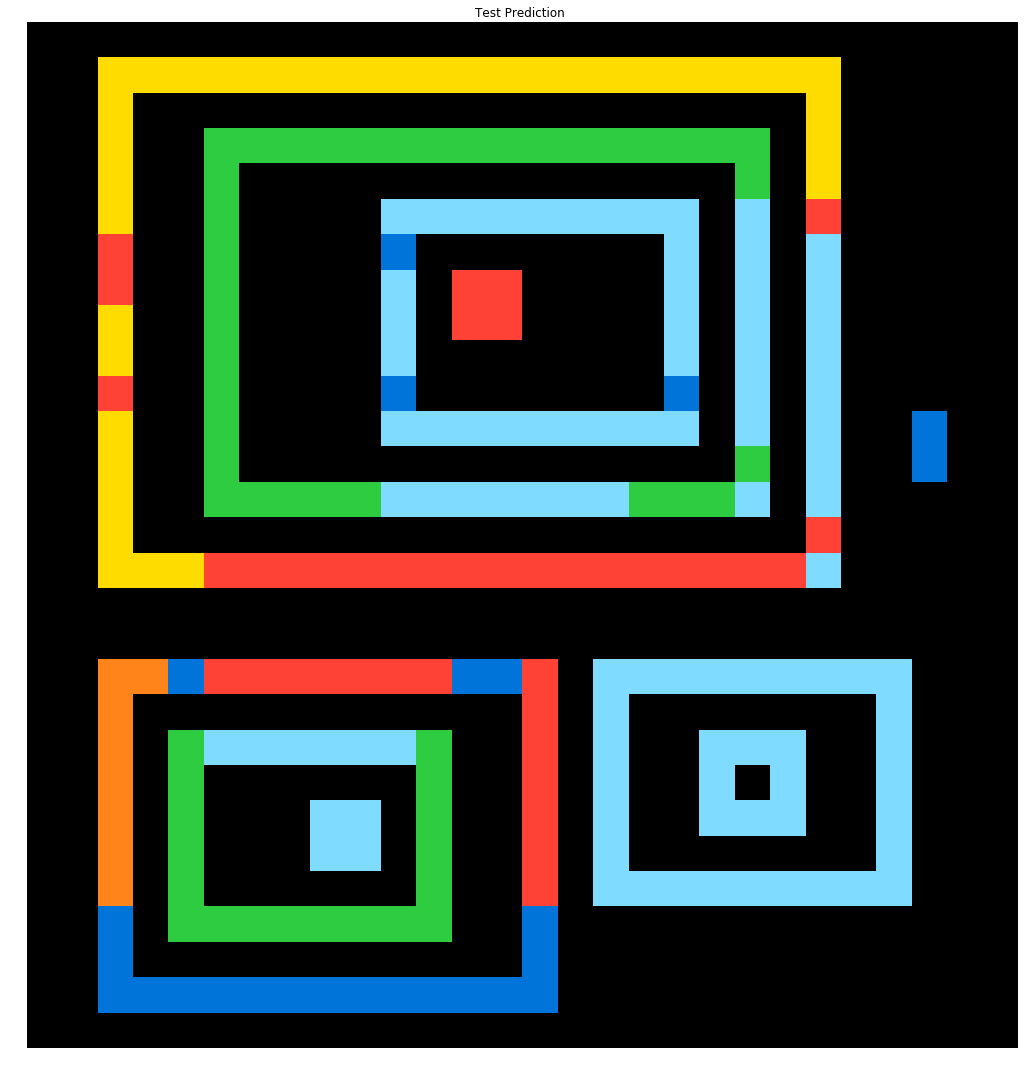

Made predictions for  7d419a02
ensemble accuracy 0.79



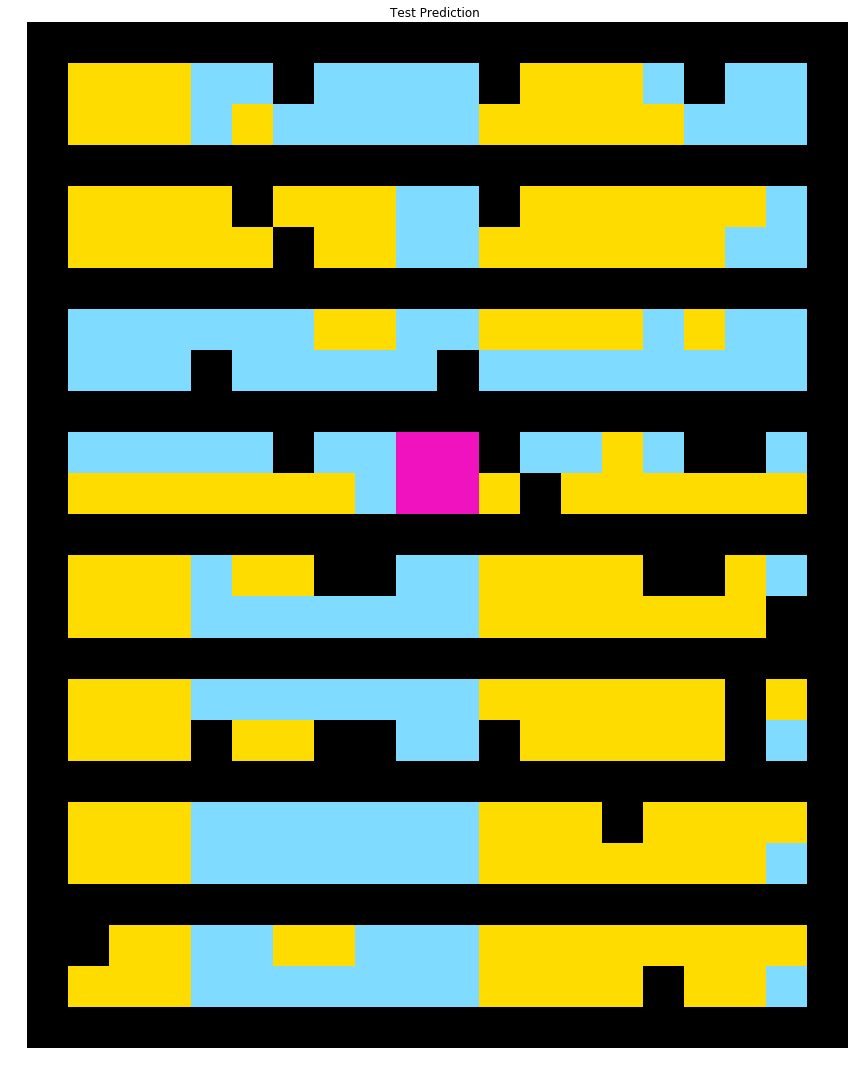

Made predictions for  7e02026e
ensemble accuracy 0.9722222222222222



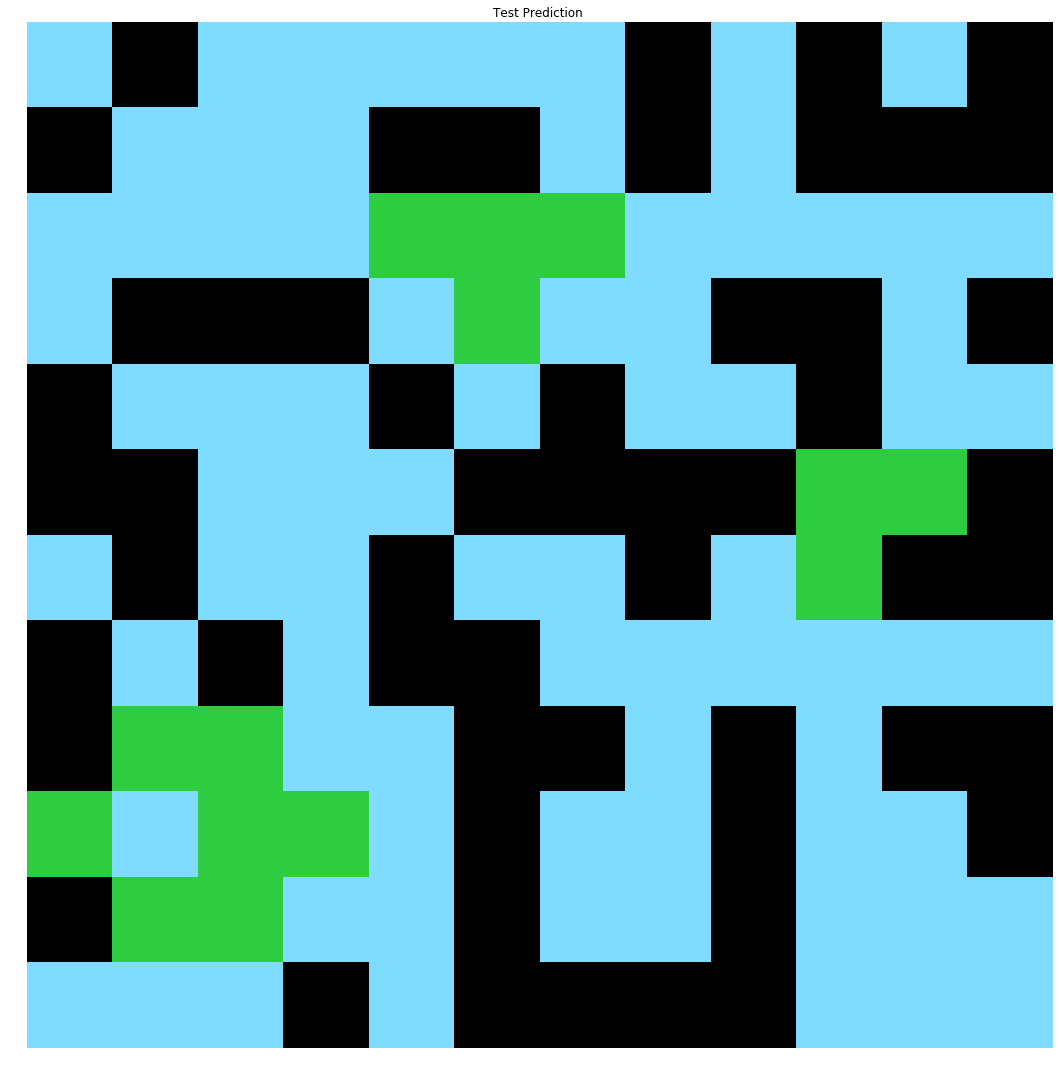

Made predictions for  7ee1c6ea
ensemble accuracy 0.48



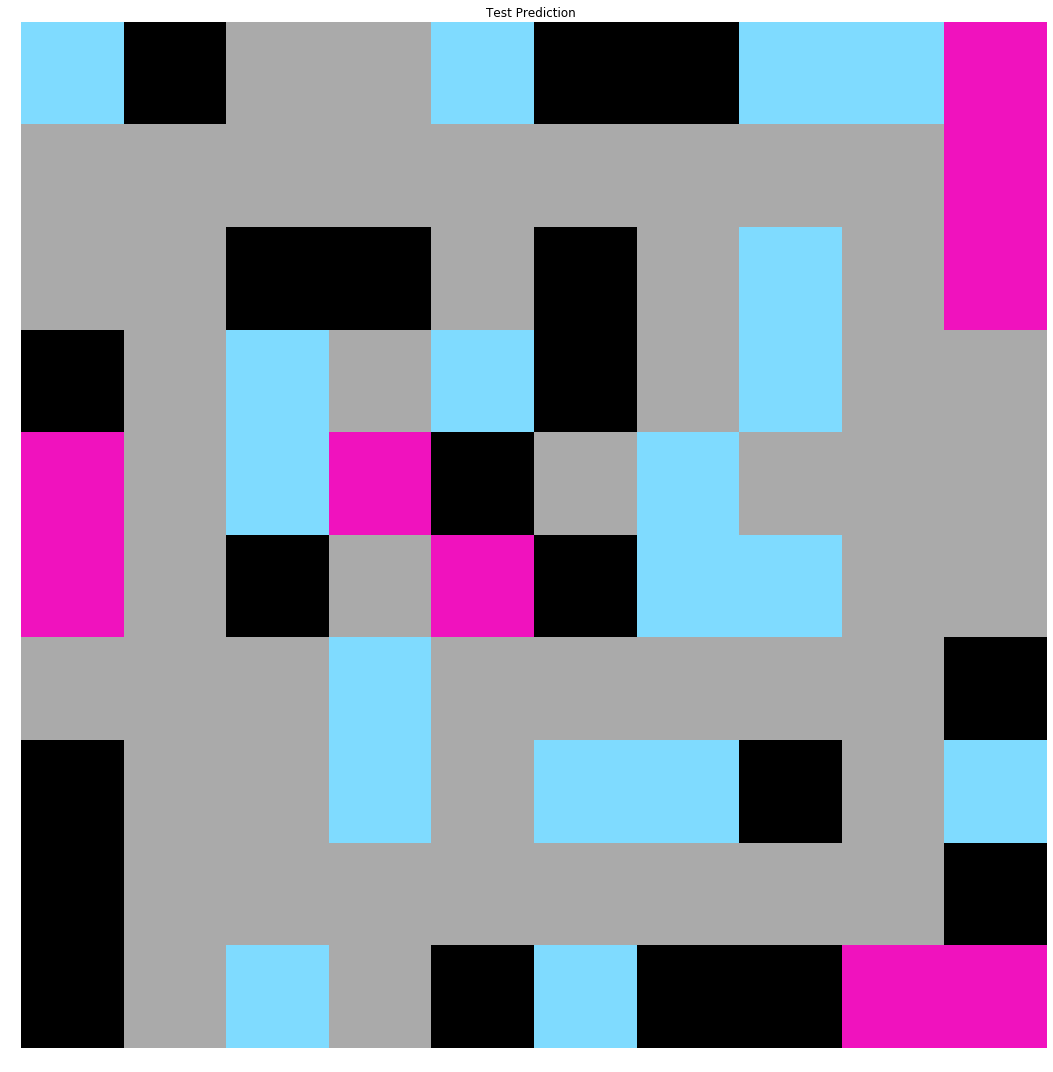

Made predictions for  817e6c09
ensemble accuracy 0.9333333333333333



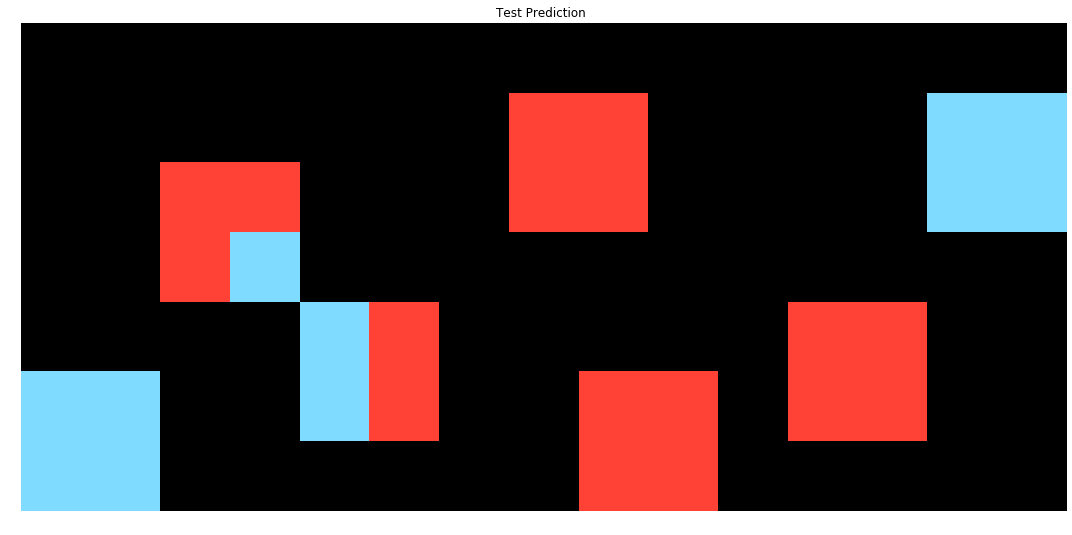

Number of input rows: 19 cols: 13
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\81c0276b.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\833dafe3.json

Made predictions for  845d6e51
ensemble accuracy 0.8954248366013072



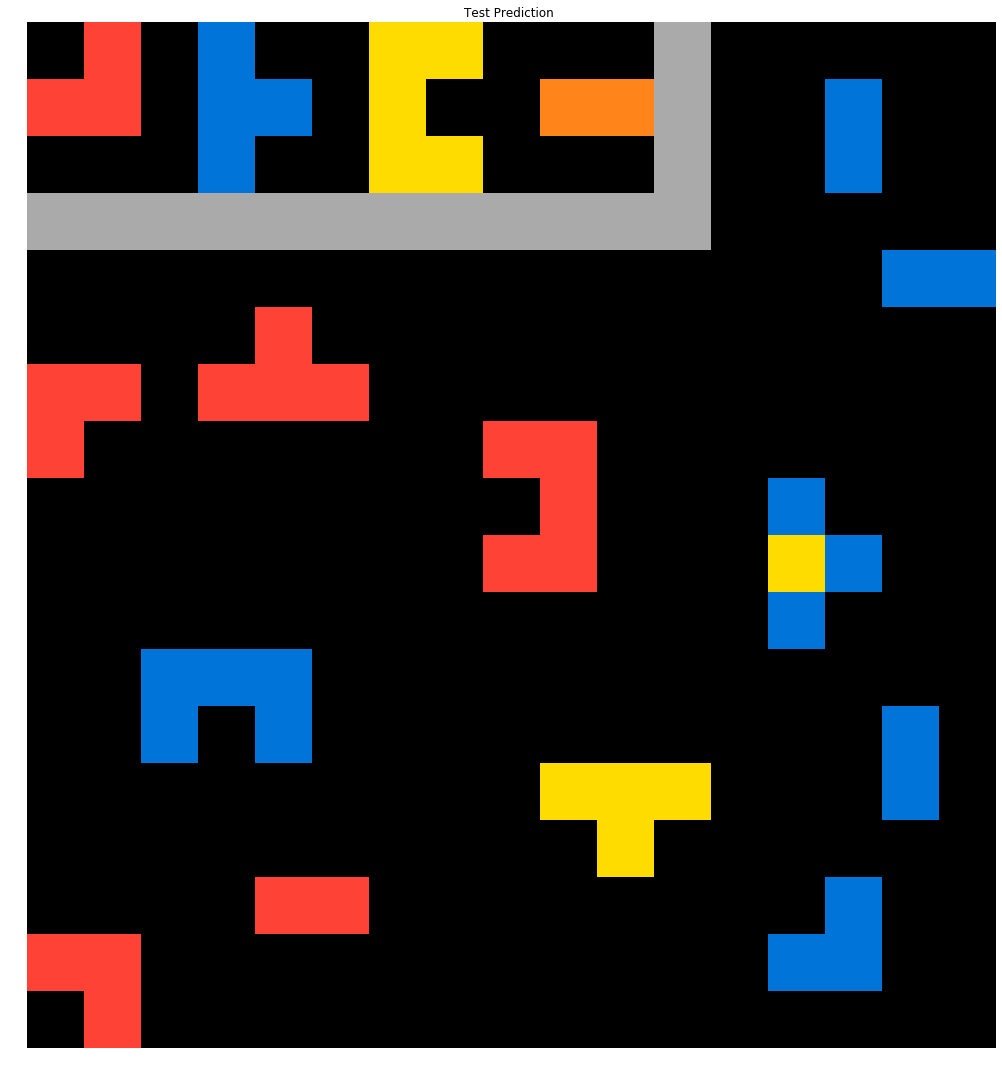

Made predictions for  84db8fc4
ensemble accuracy 0.95



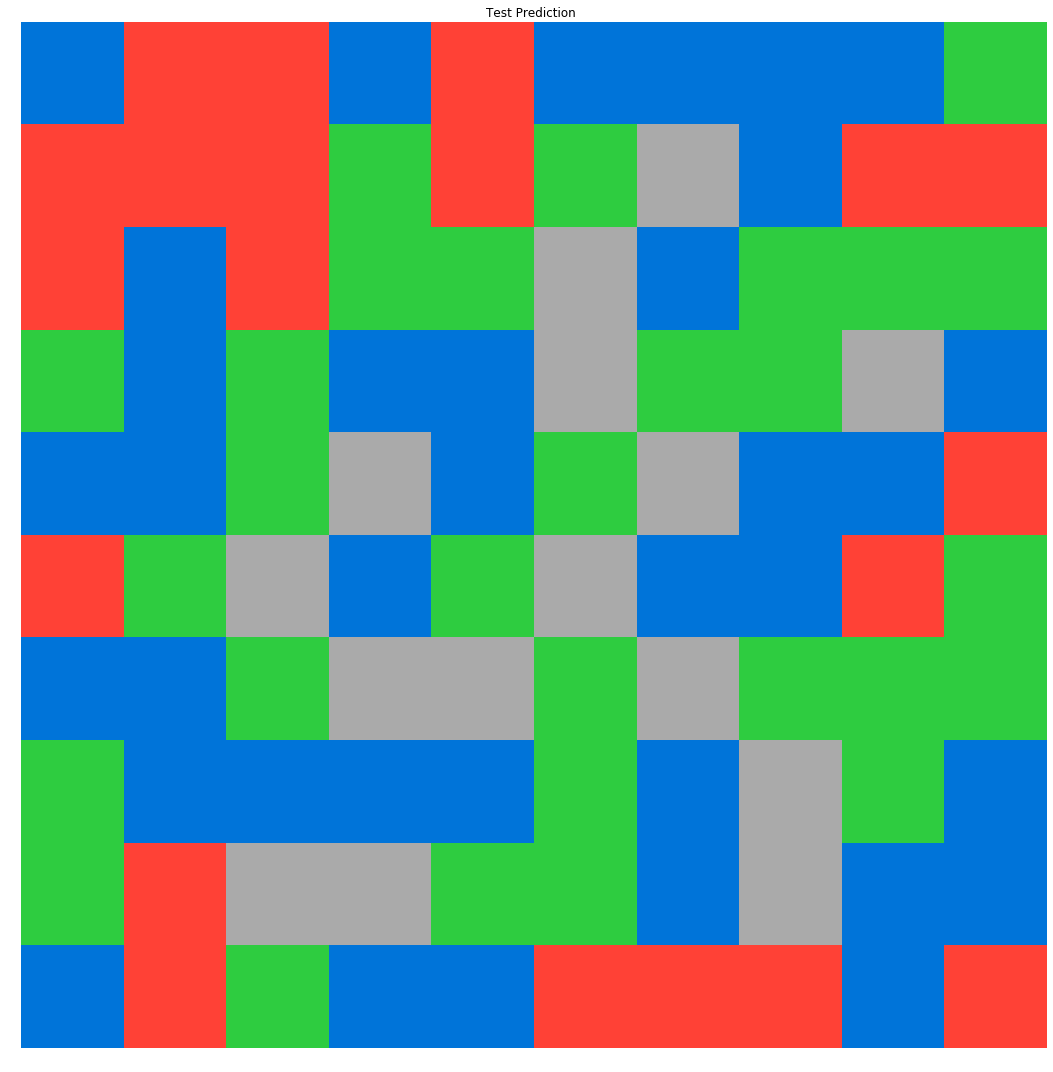

Made predictions for  84f2aca1
ensemble accuracy 0.9935897435897436



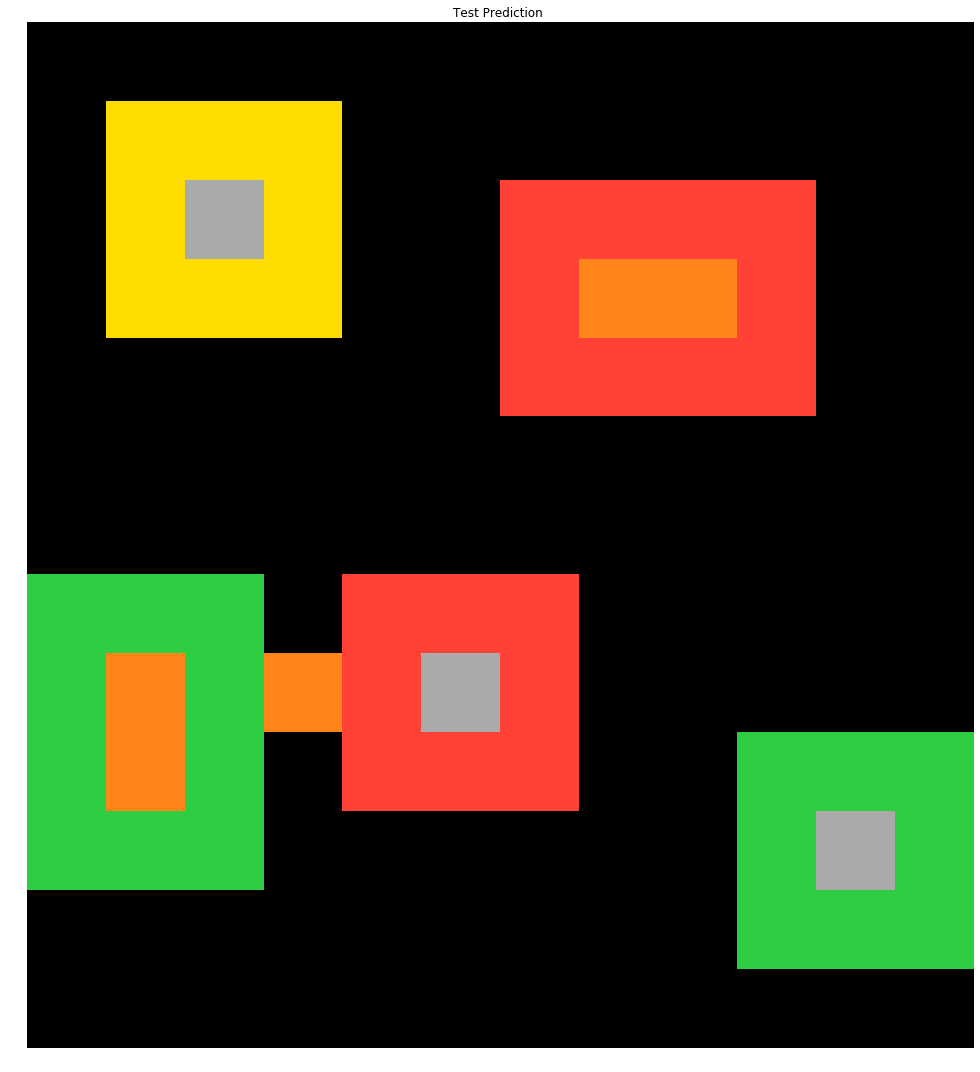

Number of input rows: 9 cols: 9
Number of target rows: 2 cols: 2
ignoring task abstraction-and-reasoning-challenge\evaluation\8597cfd7.json

Made predictions for  85b81ff1
ensemble accuracy 0.9505494505494505



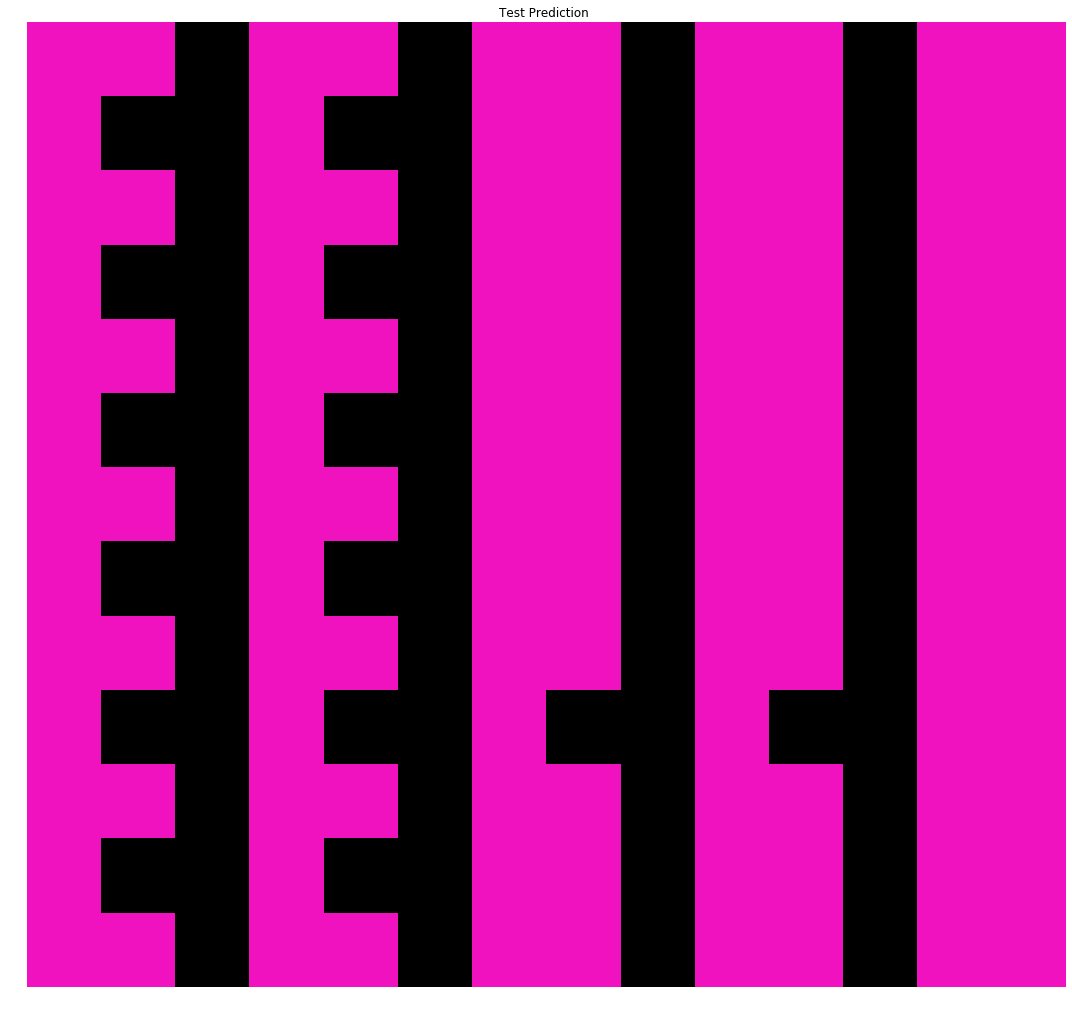

Made predictions for  85fa5666
ensemble accuracy 0.796875



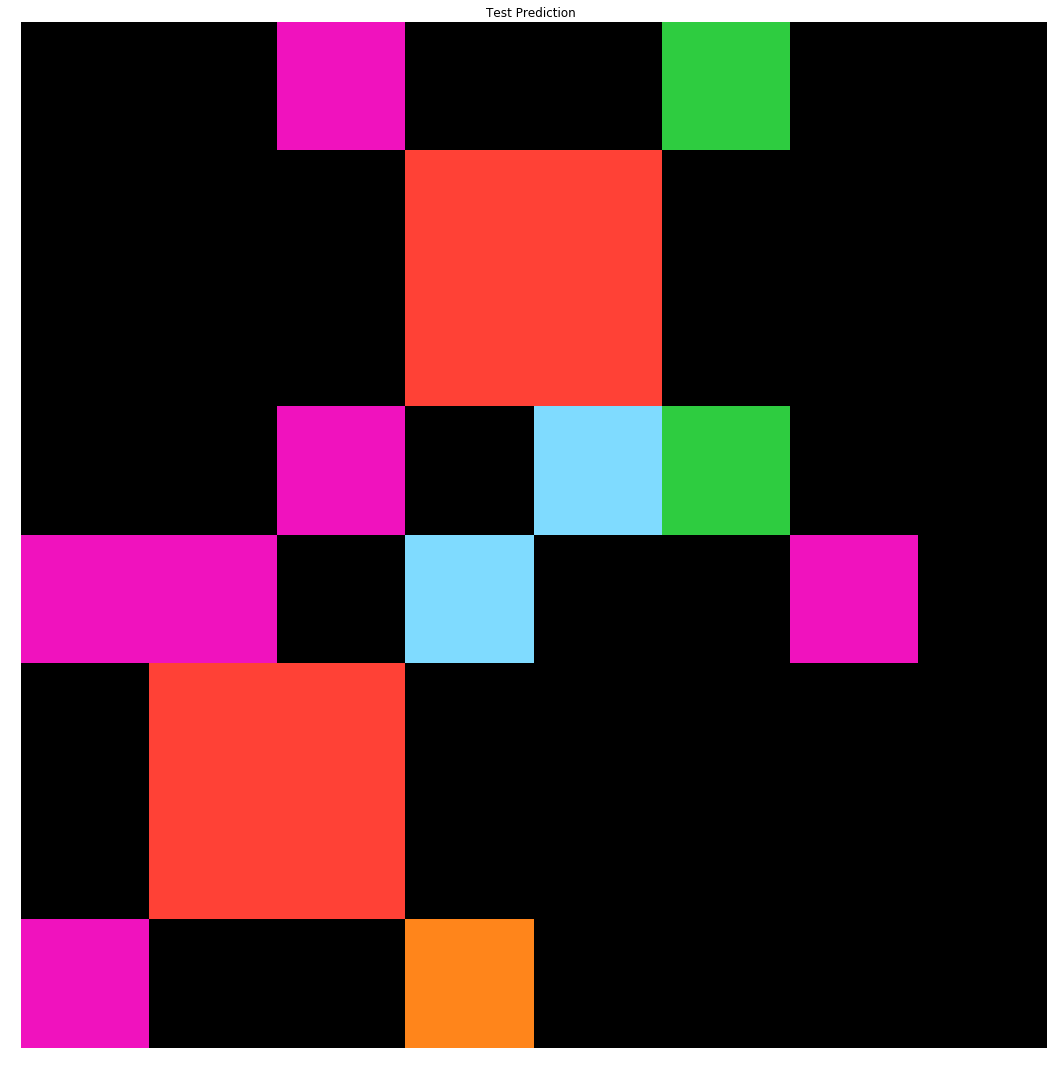

Number of input rows: 3 cols: 3
Number of target rows: 15 cols: 15
ignoring task abstraction-and-reasoning-challenge\evaluation\8719f442.json

Made predictions for  88207623
ensemble accuracy 0.8645833333333334



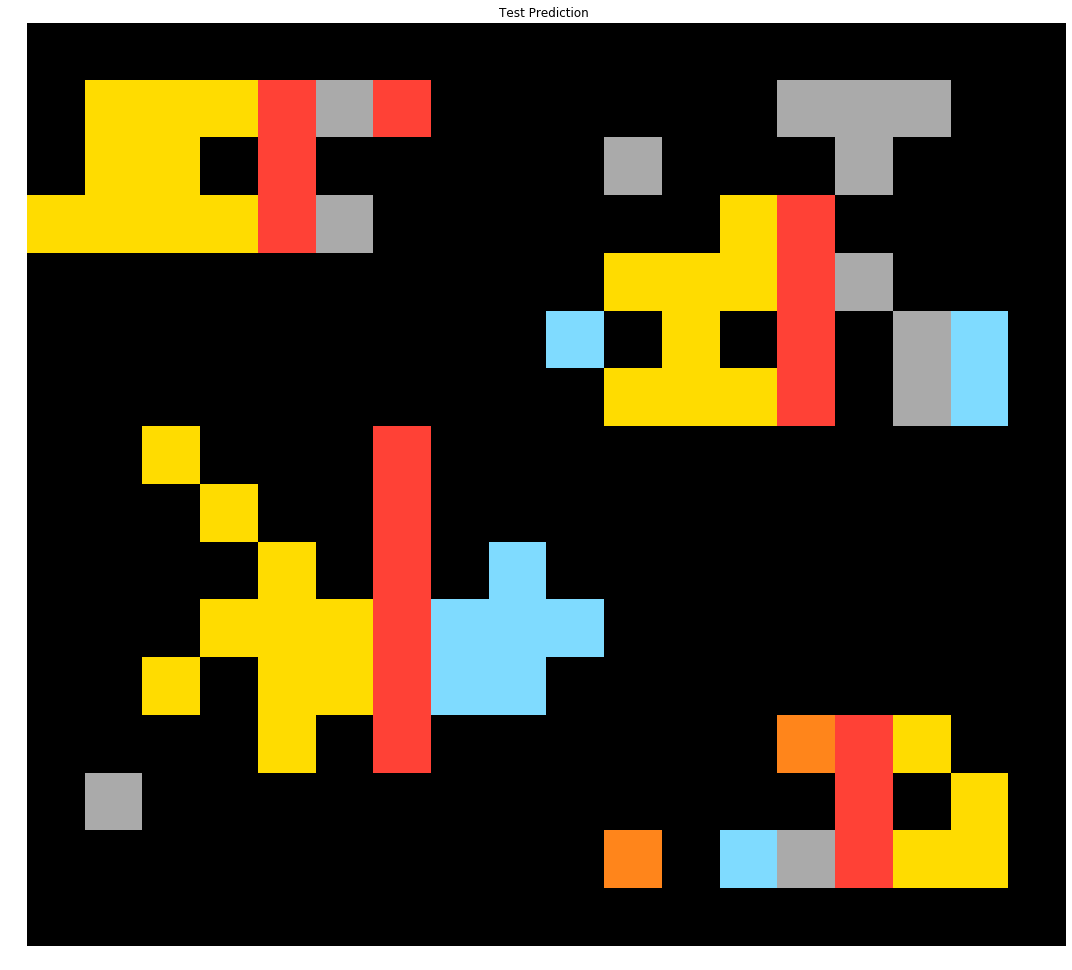

Made predictions for  891232d6
ensemble accuracy 0.8607407407407407



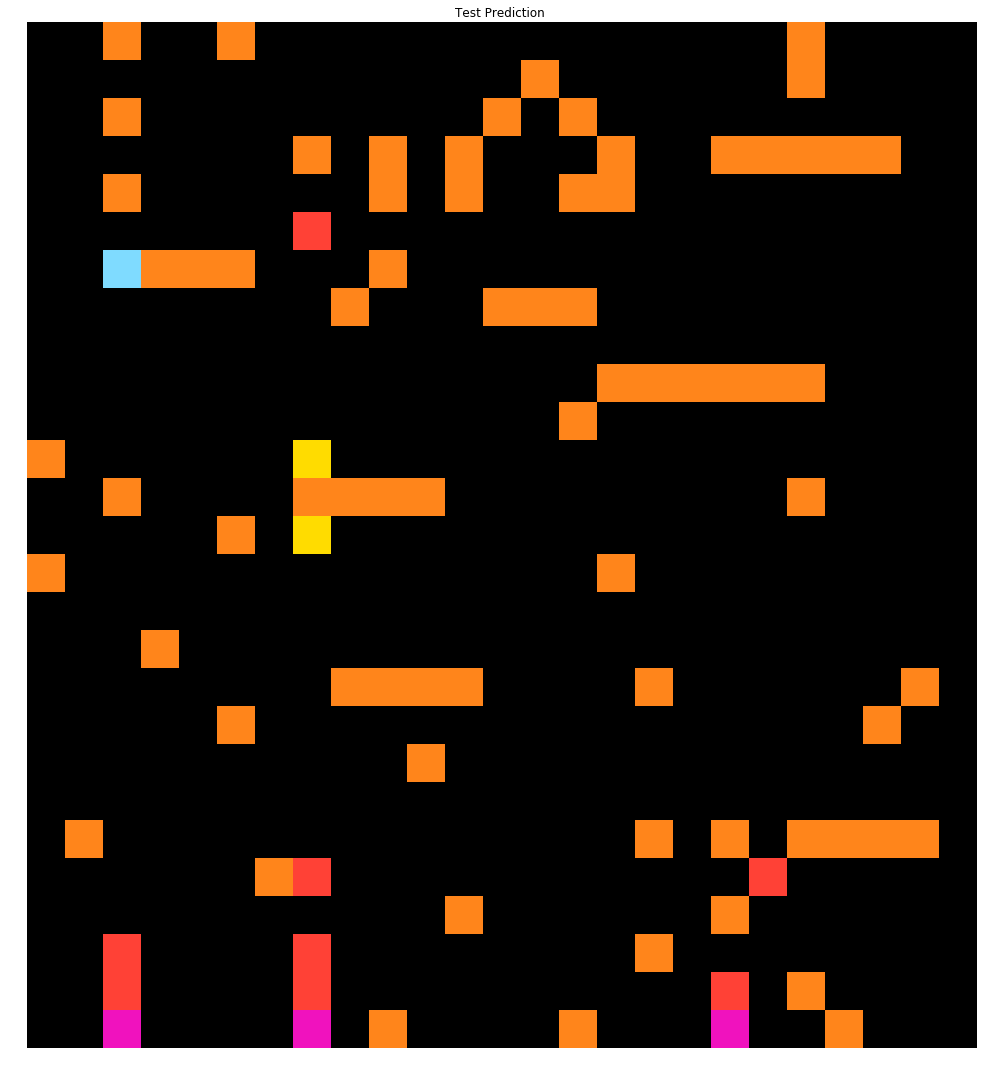

Made predictions for  896d5239
ensemble accuracy 0.9037037037037037



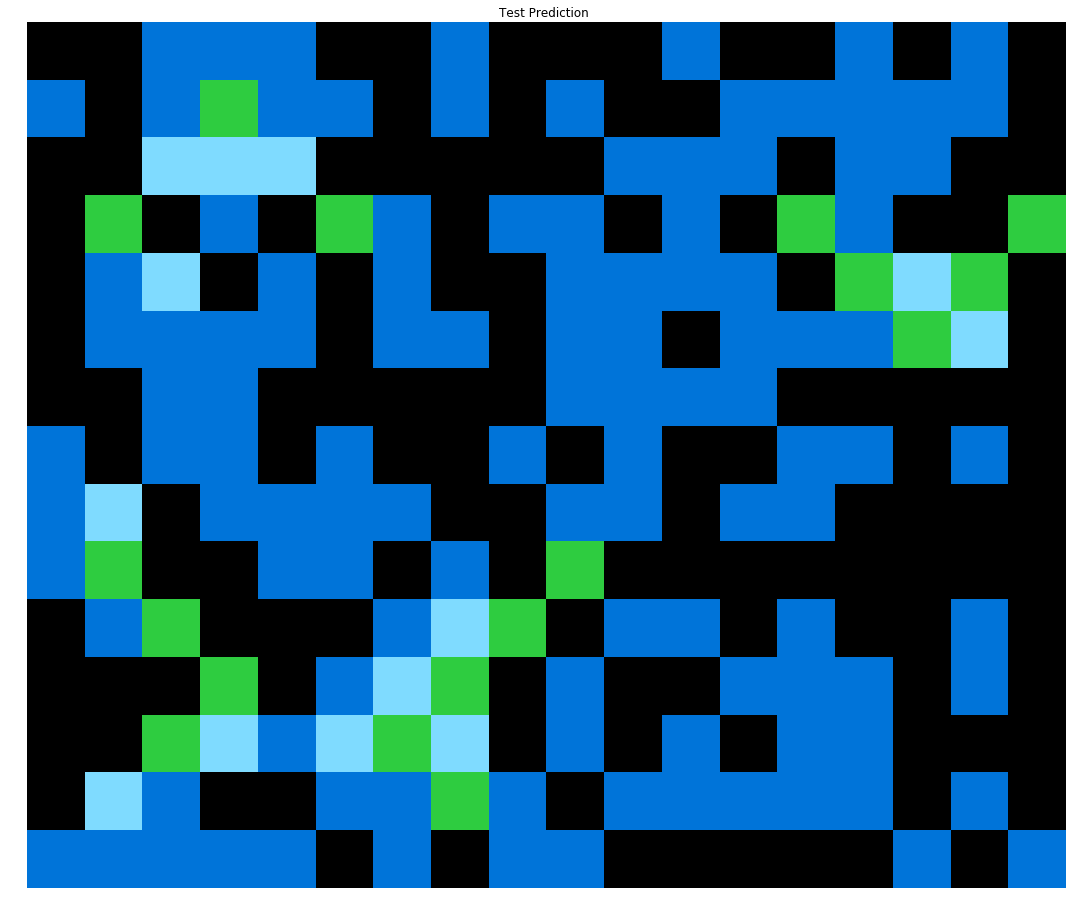

Made predictions for  8a371977
ensemble accuracy 0.8577777777777778



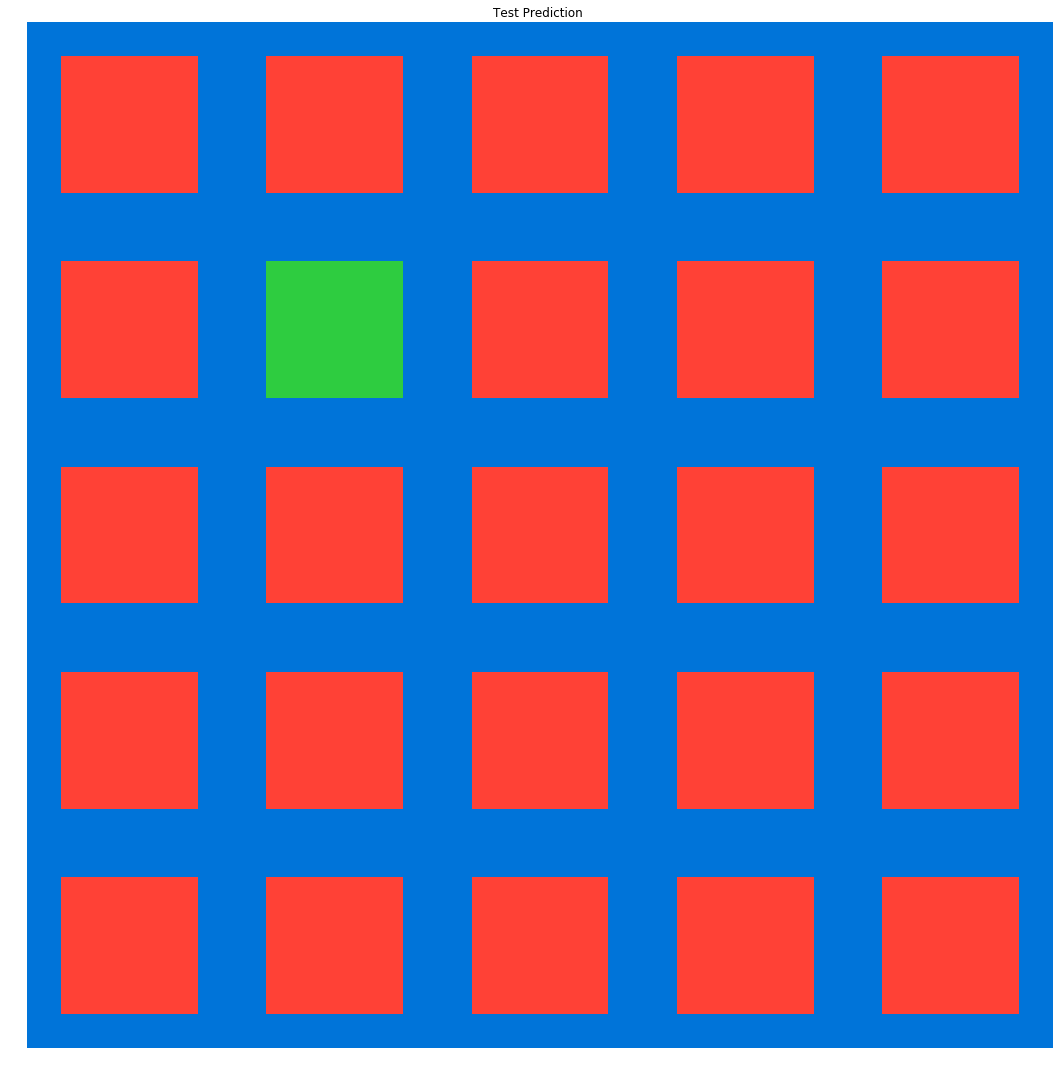

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\8b28cd80.json

Number of input rows: 4 cols: 9
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\8ba14f53.json

Made predictions for  8cb8642d
ensemble accuracy 0.7017543859649122



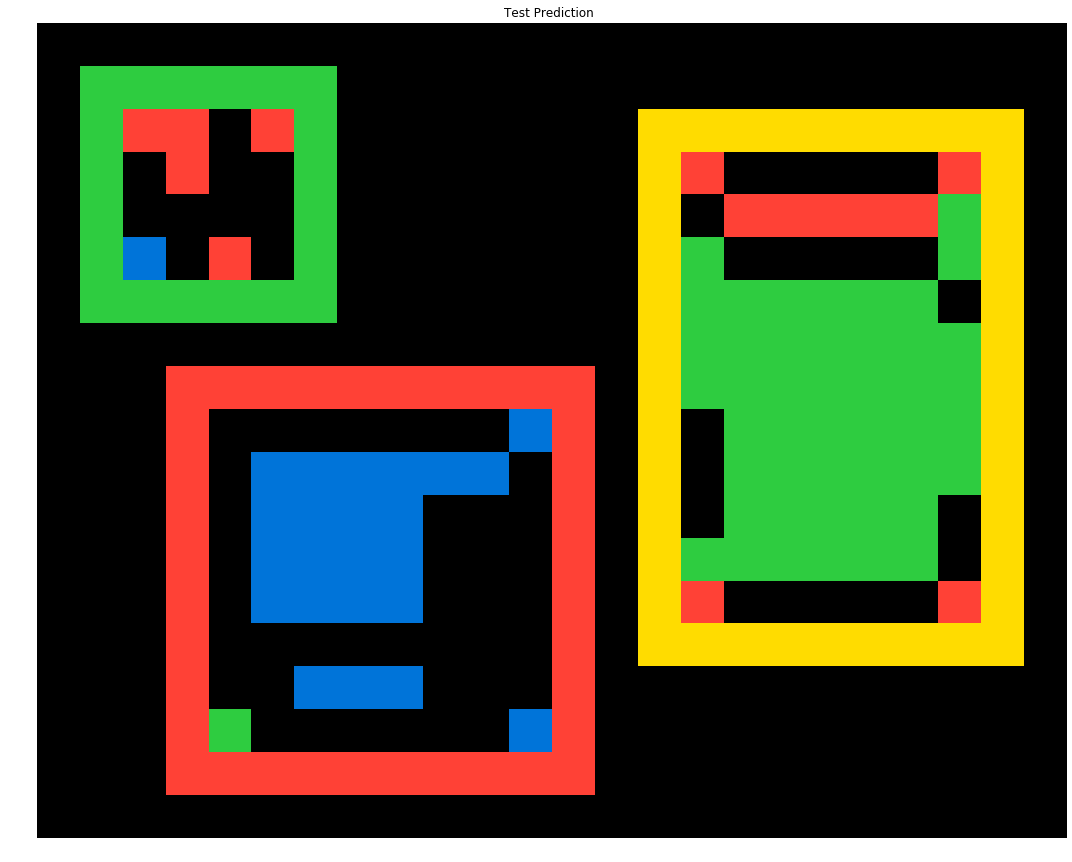

Made predictions for  8dae5dfc
ensemble accuracy 0.39473684210526316



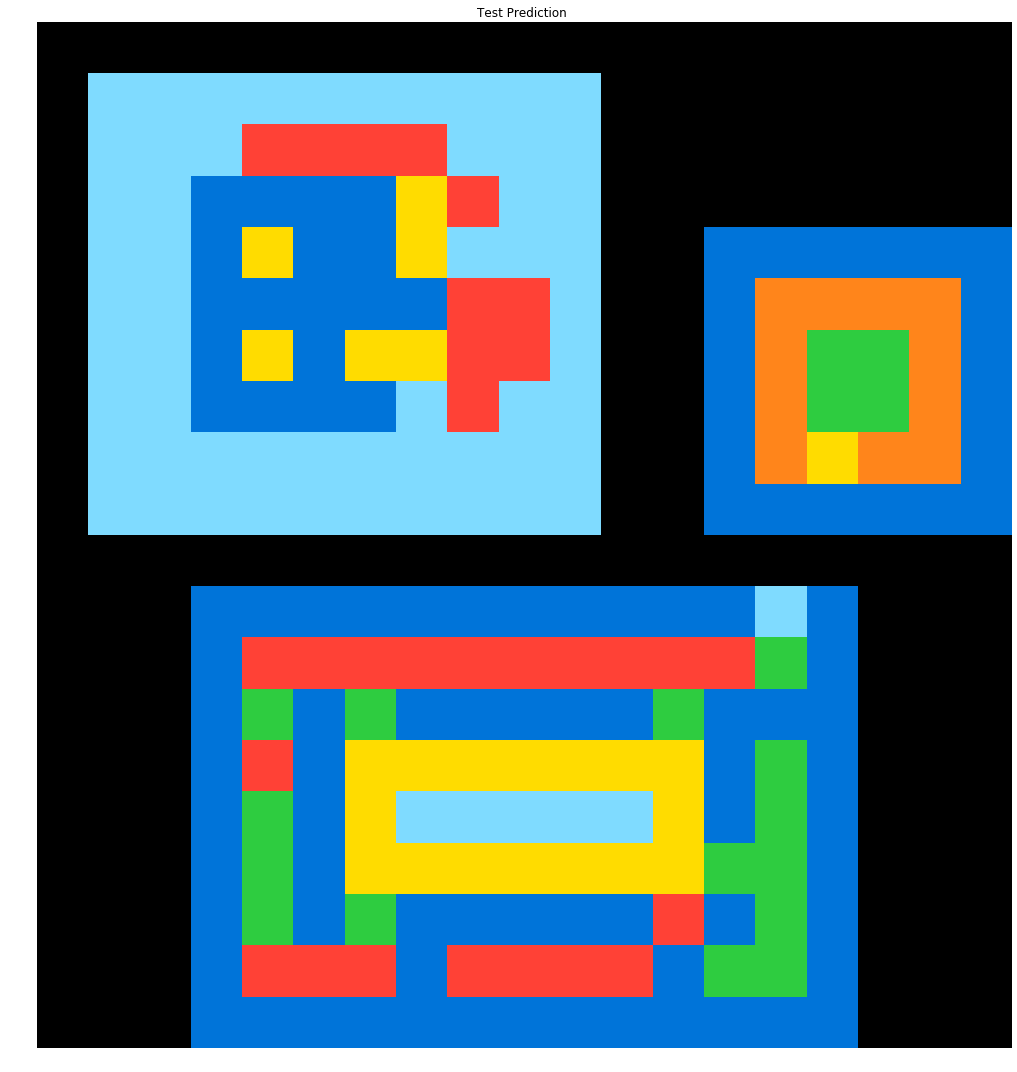

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\8e2edd66.json

Made predictions for  8ee62060
ensemble accuracy 0.8214285714285714



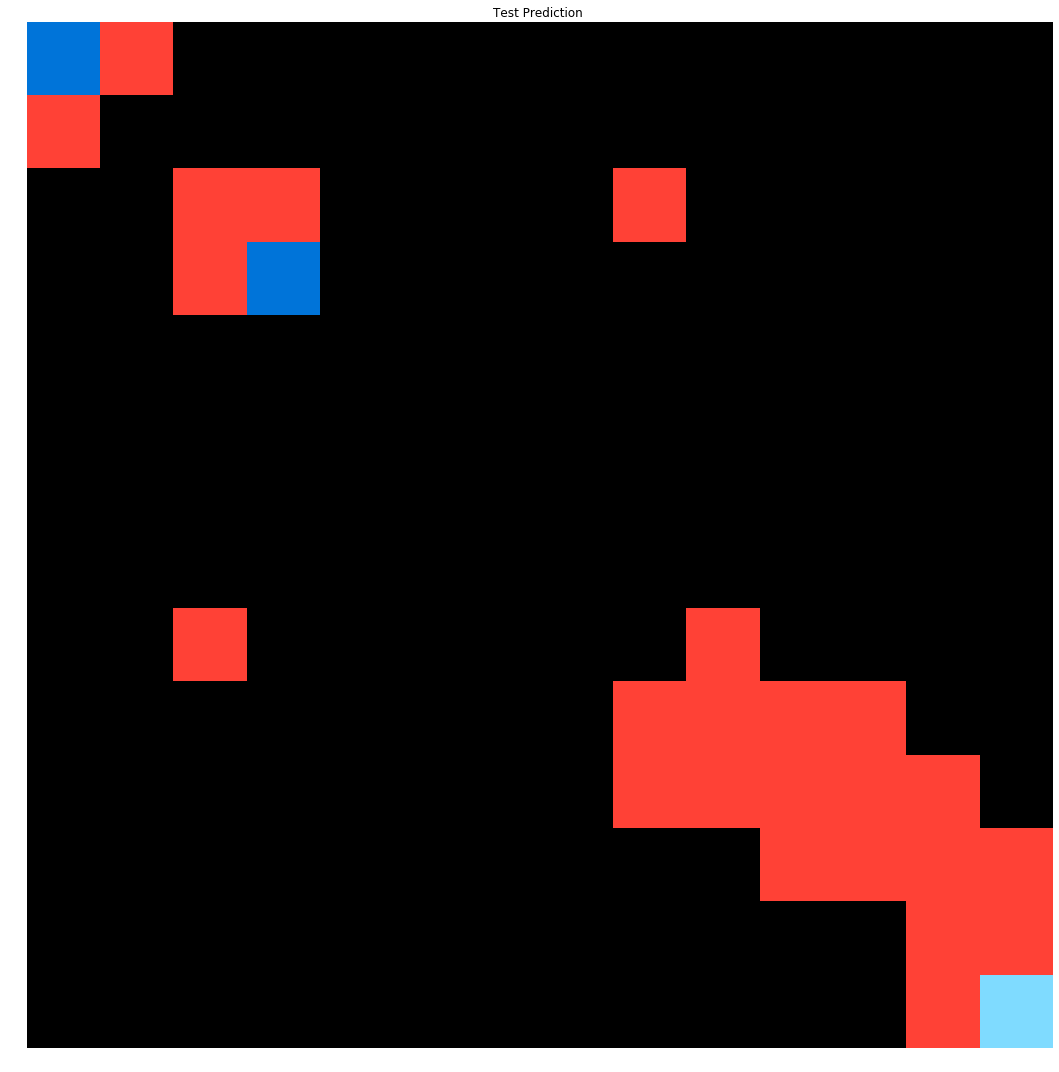

Made predictions for  8fbca751
ensemble accuracy 0.90625



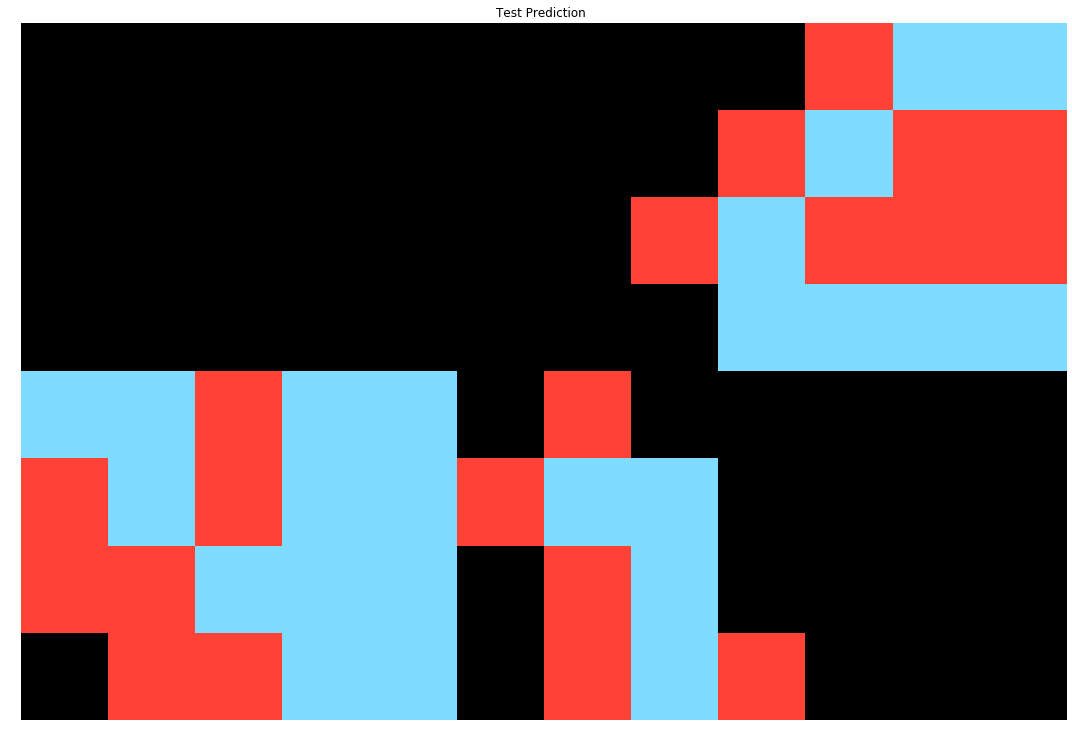

C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  90347967
ensemble accuracy 0.8765432098765432



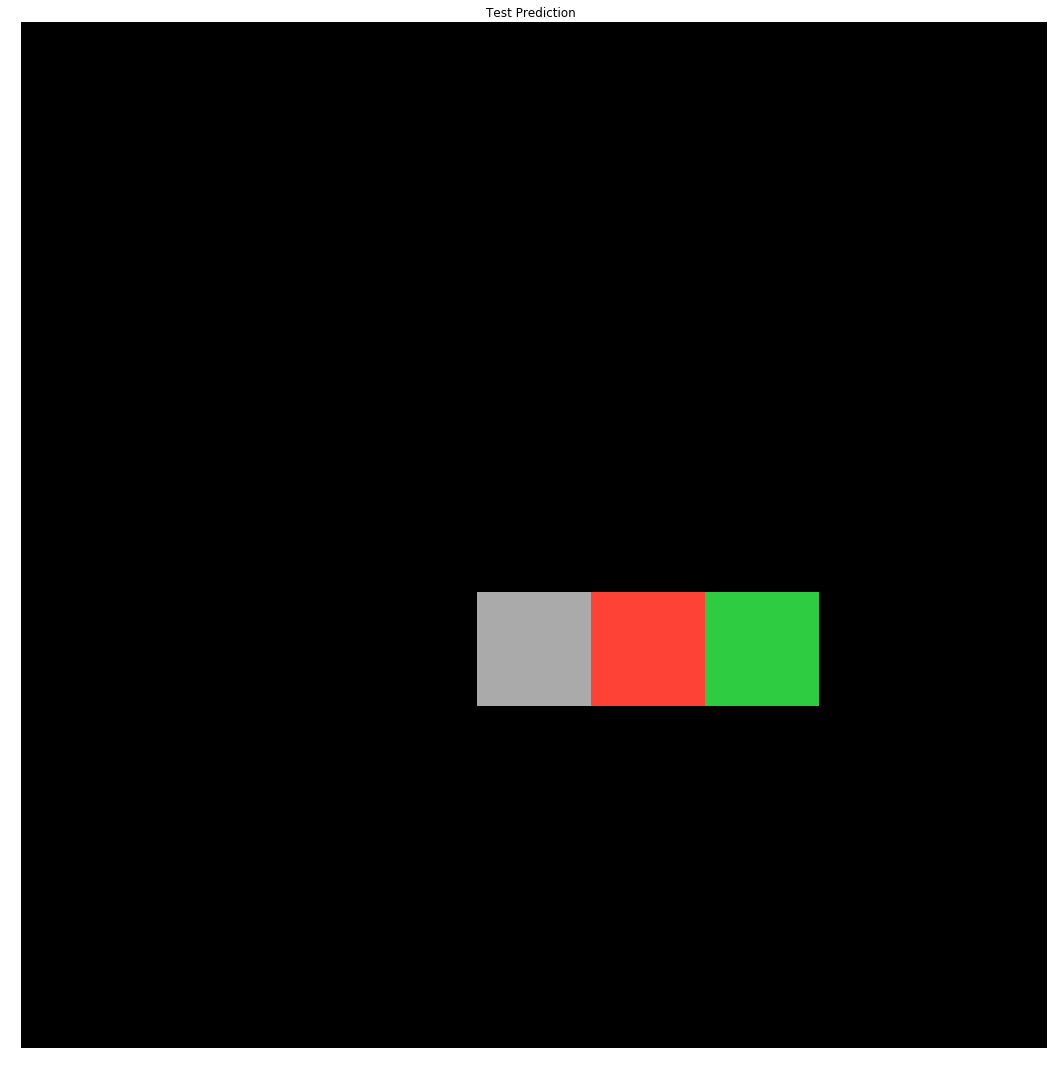

Made predictions for  903d1b4a
ensemble accuracy 0.94921875



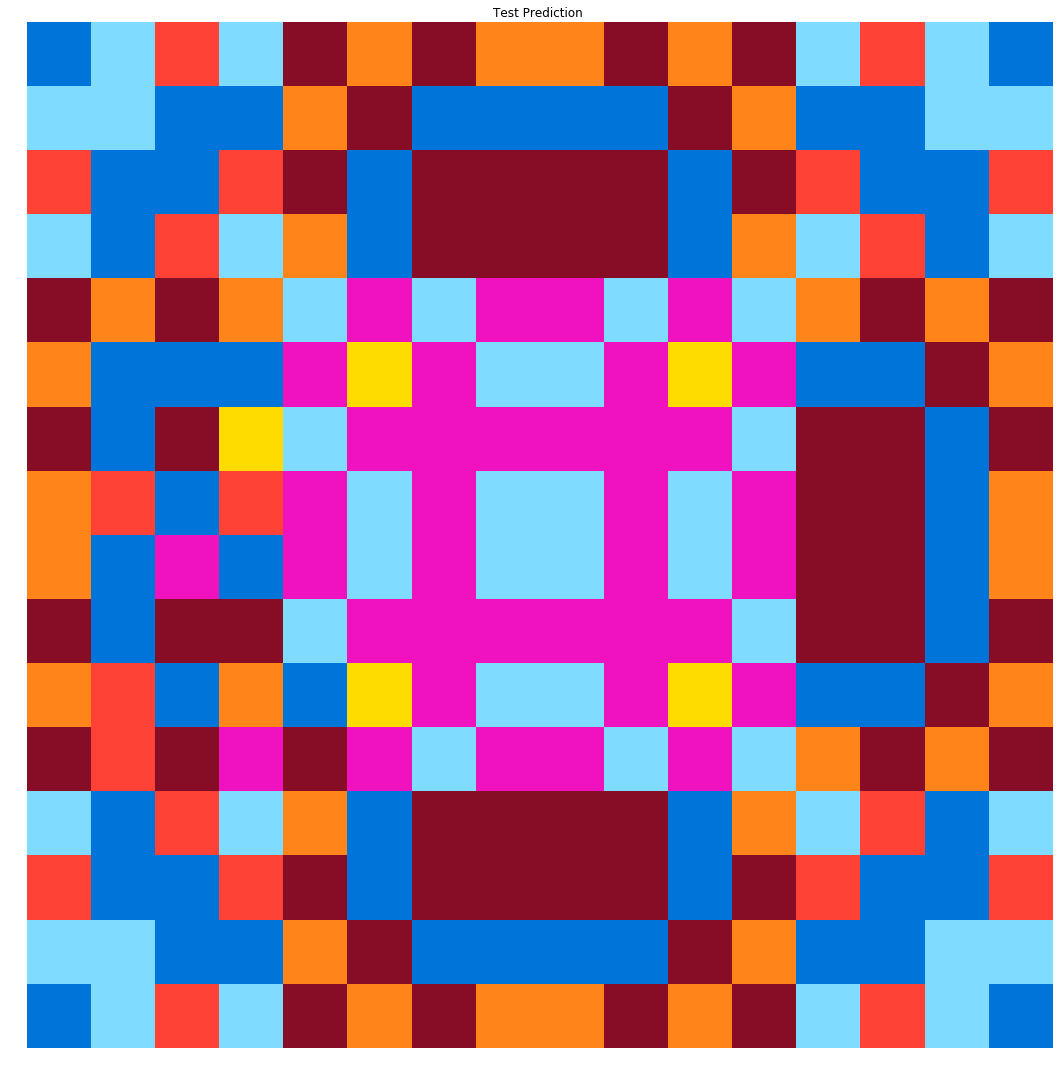

Number of input rows: 7 cols: 7
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\9110e3c5.json

Made predictions for  917bccba
ensemble accuracy 0.7361111111111112



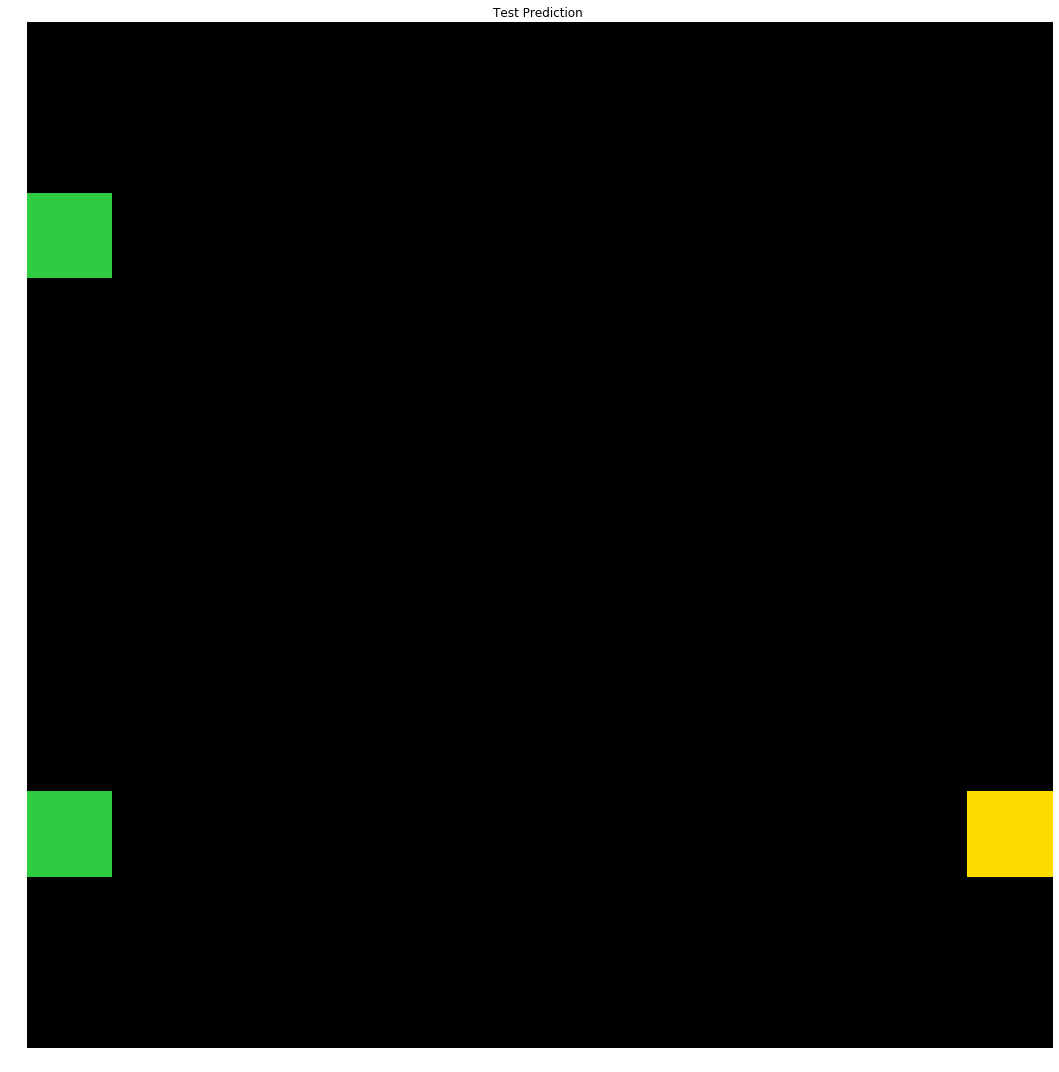

Made predictions for  929ab4e9
ensemble accuracy 0.9479166666666666



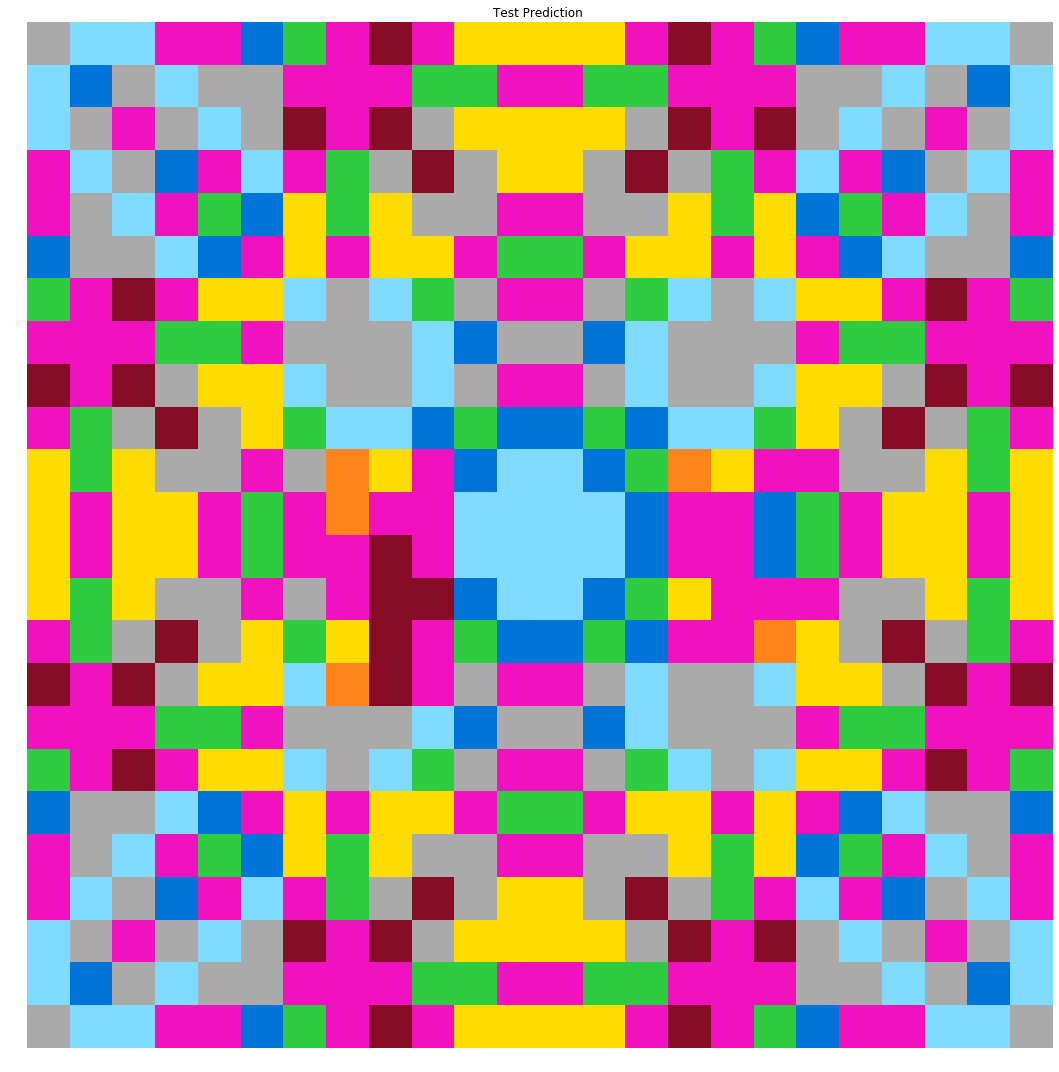

Made predictions for  92e50de0
ensemble accuracy 0.5374554102259215



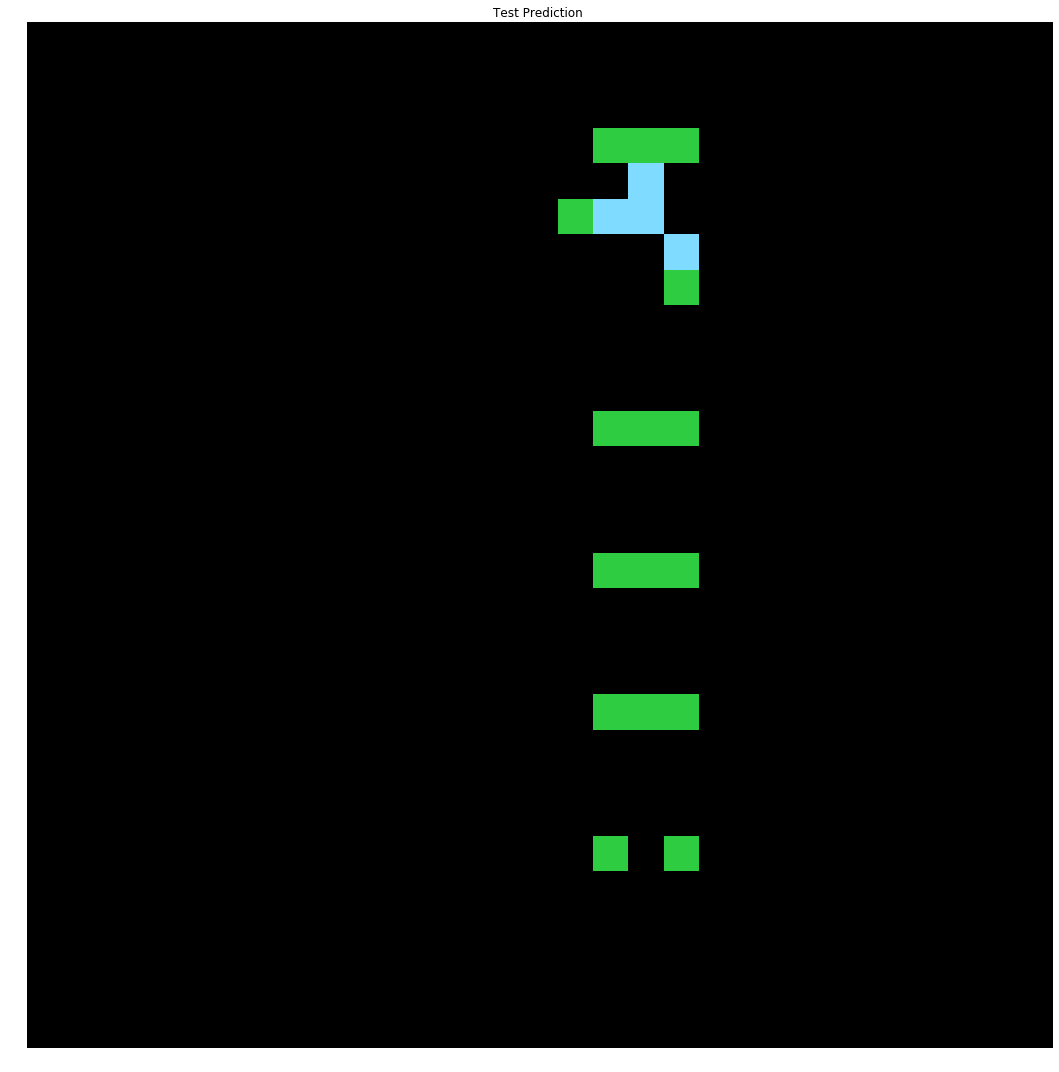

Made predictions for  9356391f
ensemble accuracy 0.65625



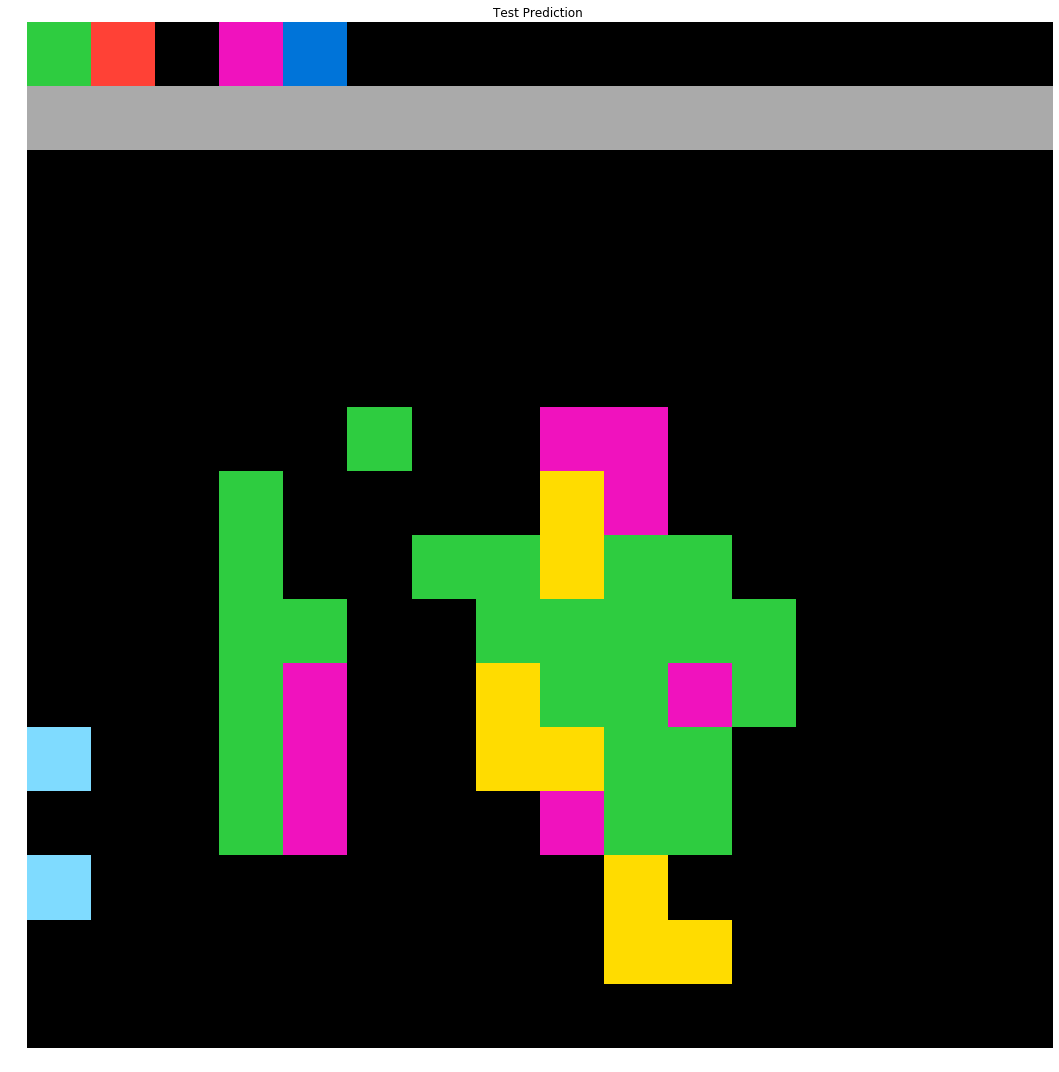

Number of input rows: 10 cols: 12
Number of target rows: 10 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\93b4f4b3.json

Made predictions for  93c31fbe
ensemble accuracy 0.8791208791208791



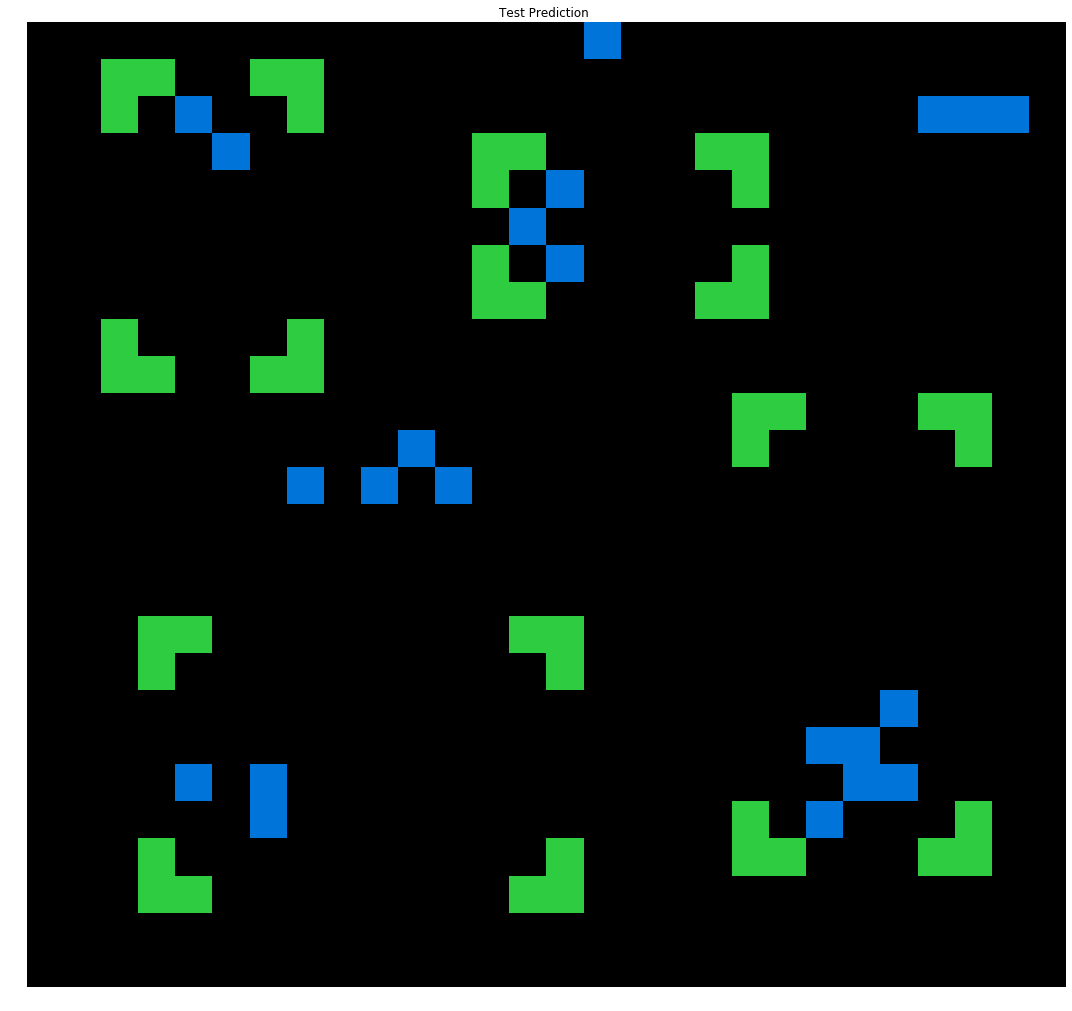

Number of input rows: 23 cols: 19
Number of target rows: 10 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\94133066.json

Made predictions for  94414823
ensemble accuracy 0.82



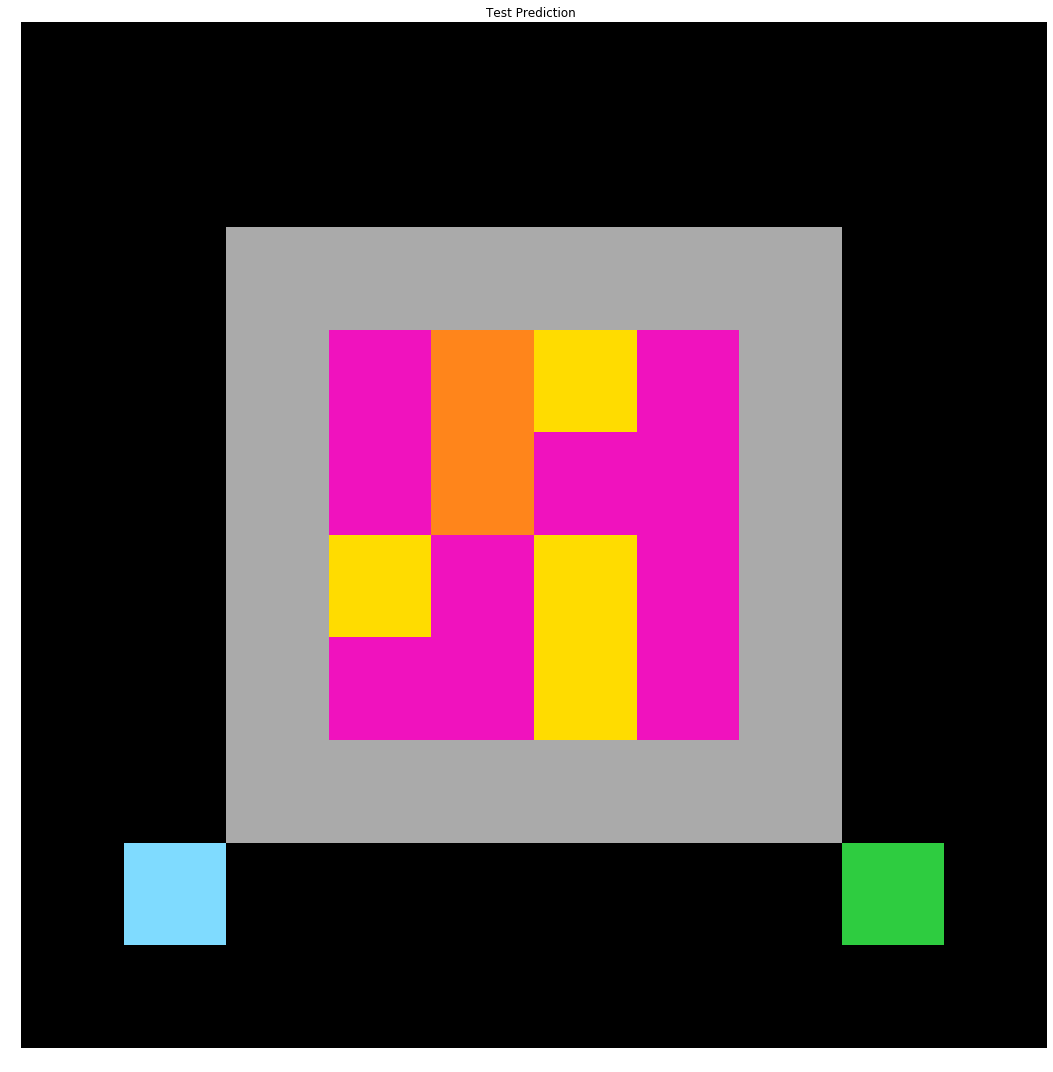

Made predictions for  94be5b80
ensemble accuracy 0.8481481481481481



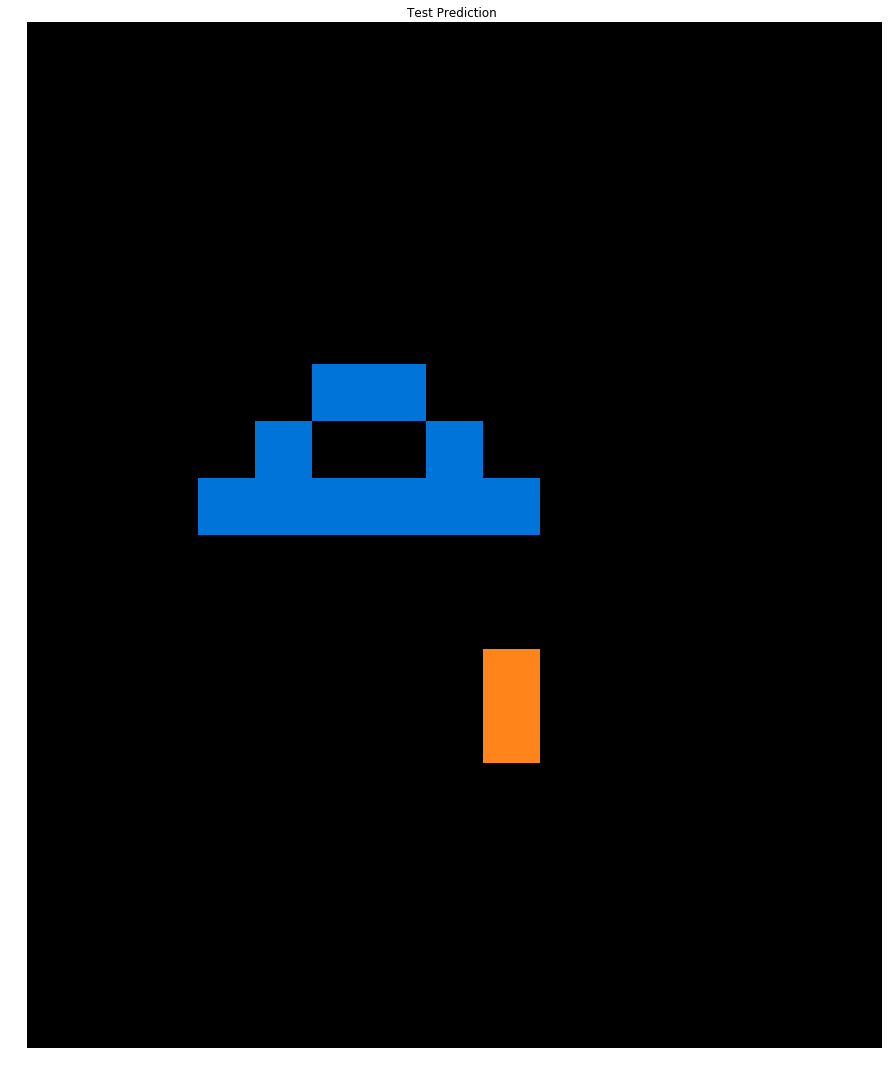

Made predictions for  95a58926
ensemble accuracy 0.9781144781144782



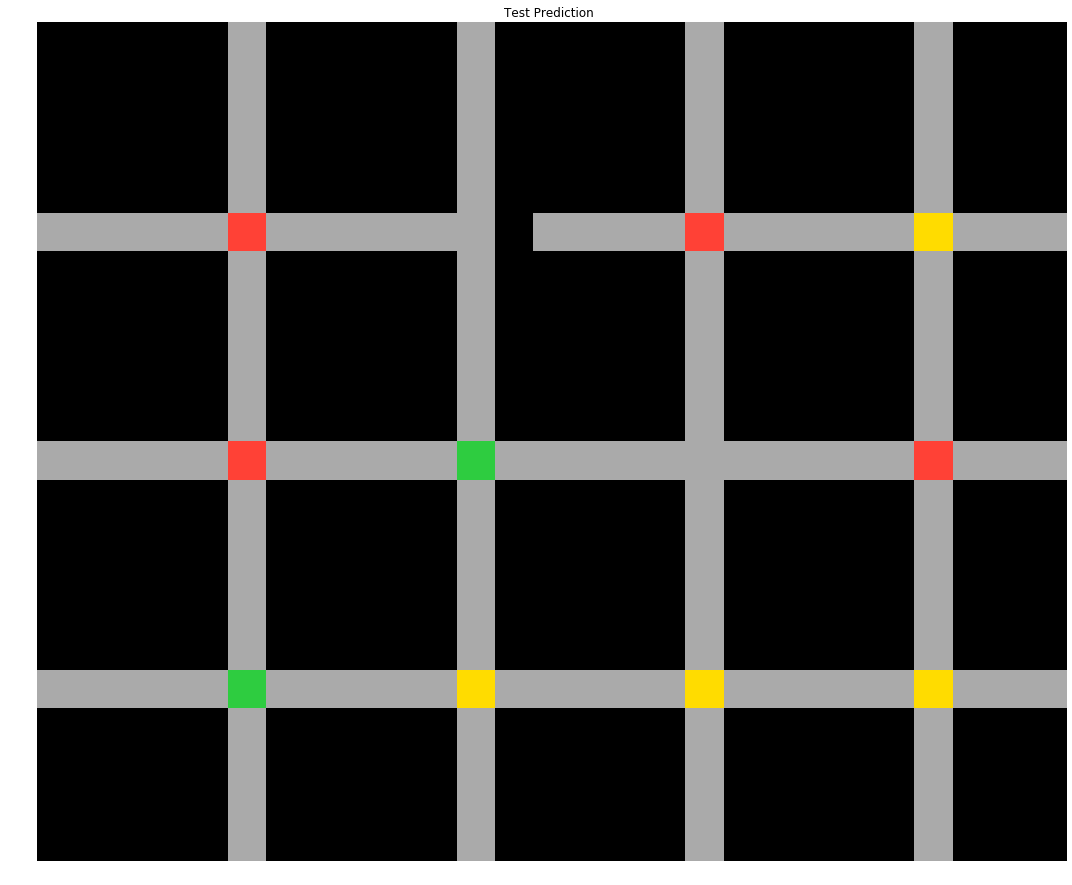

Made predictions for  963f59bc
ensemble accuracy 0.9419642857142857



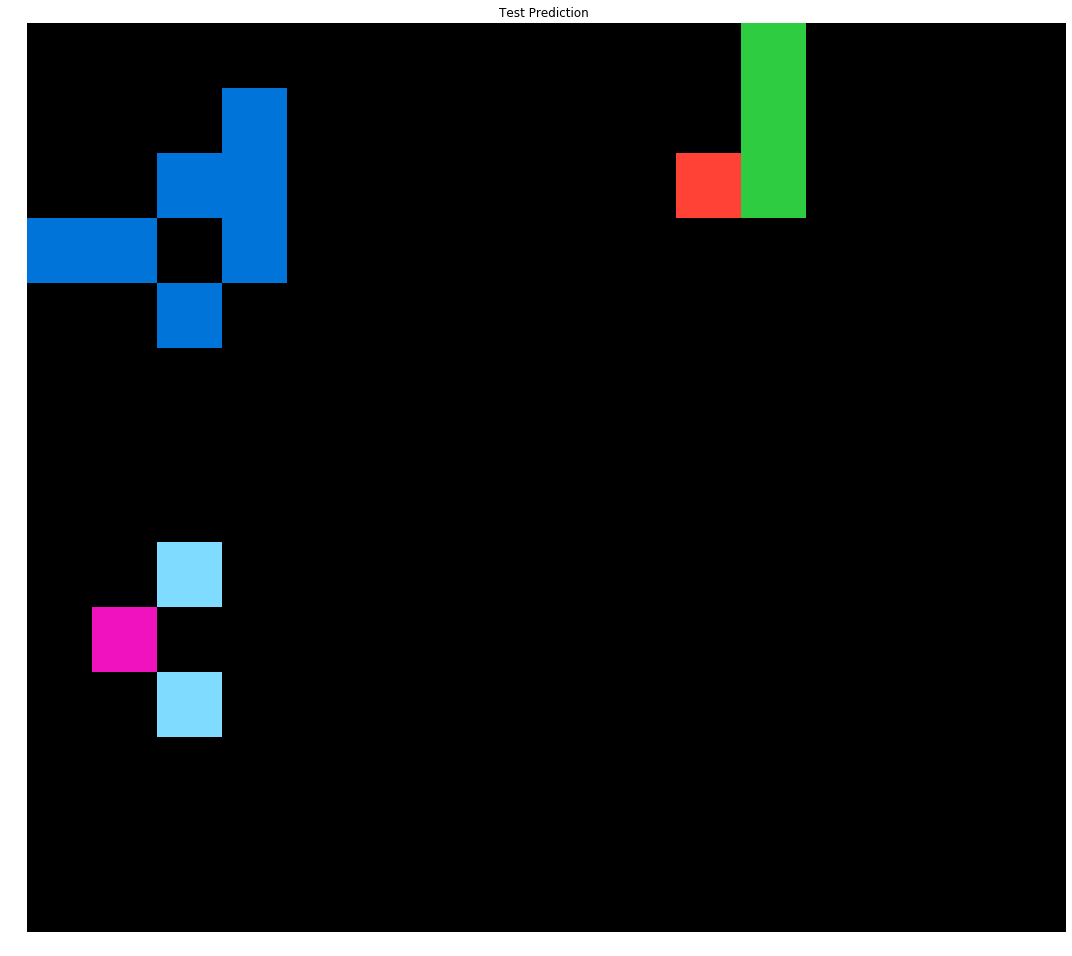

Made predictions for  96a8c0cd
ensemble accuracy 0.8116710875331565



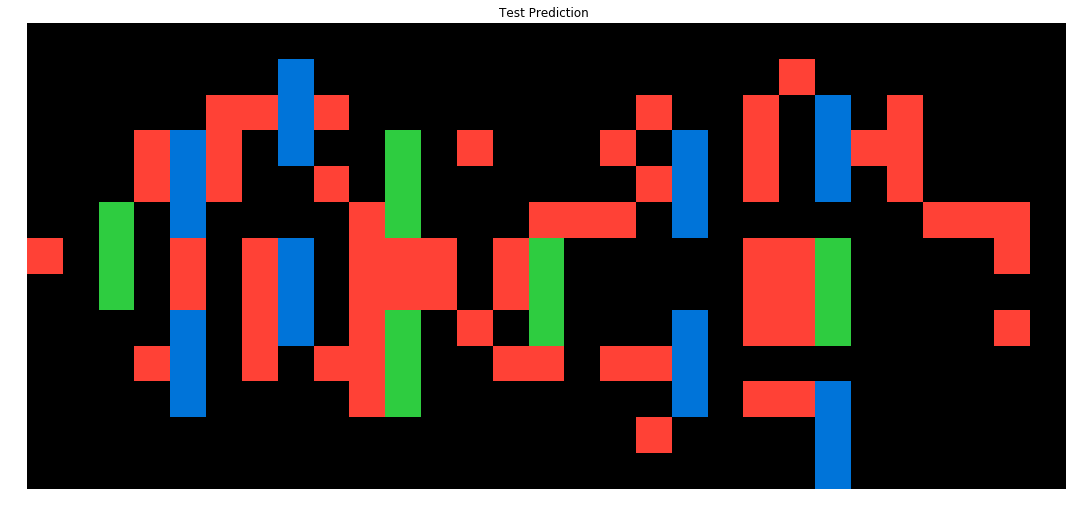

Made predictions for  97239e3d
ensemble accuracy 0.7508650519031141



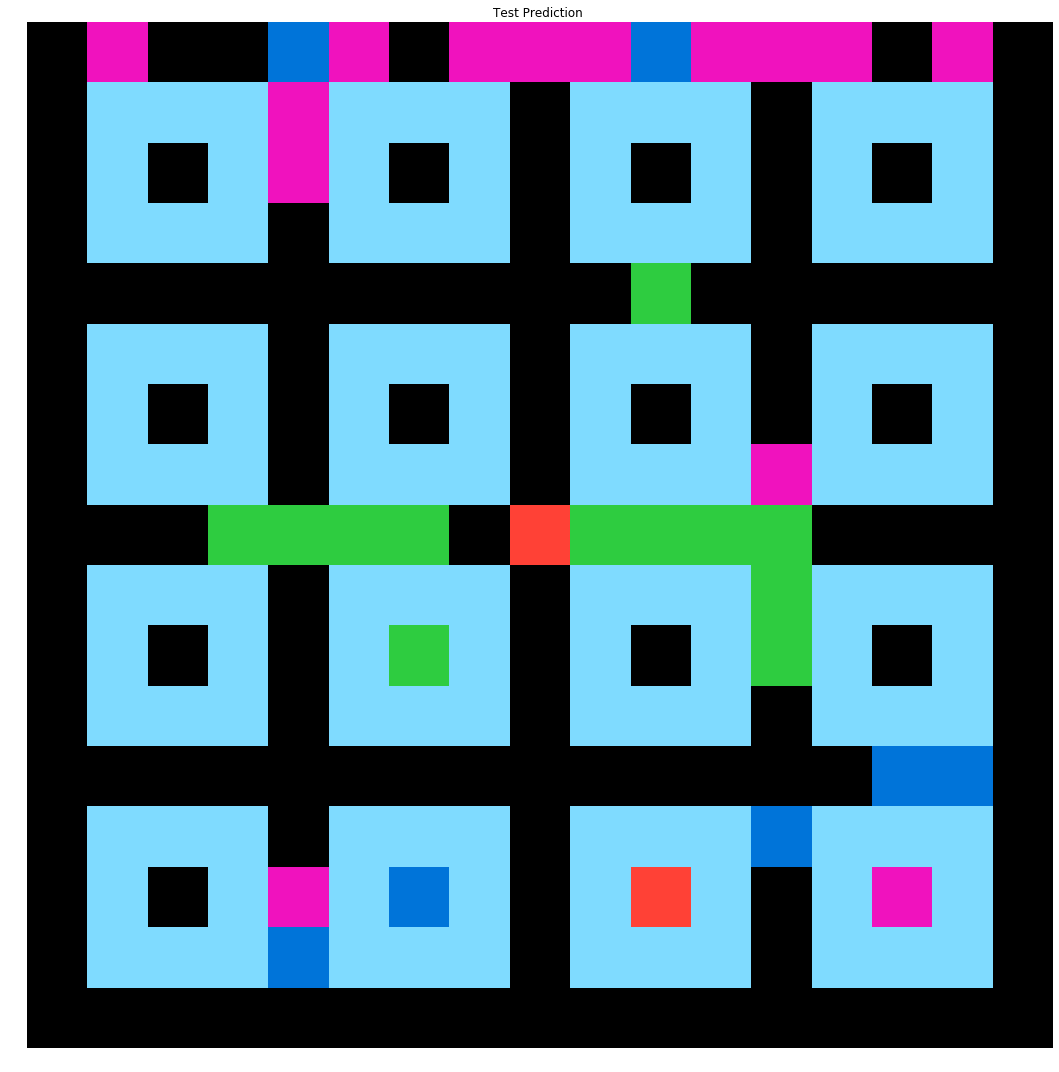

Made predictions for  9772c176
ensemble accuracy 0.97



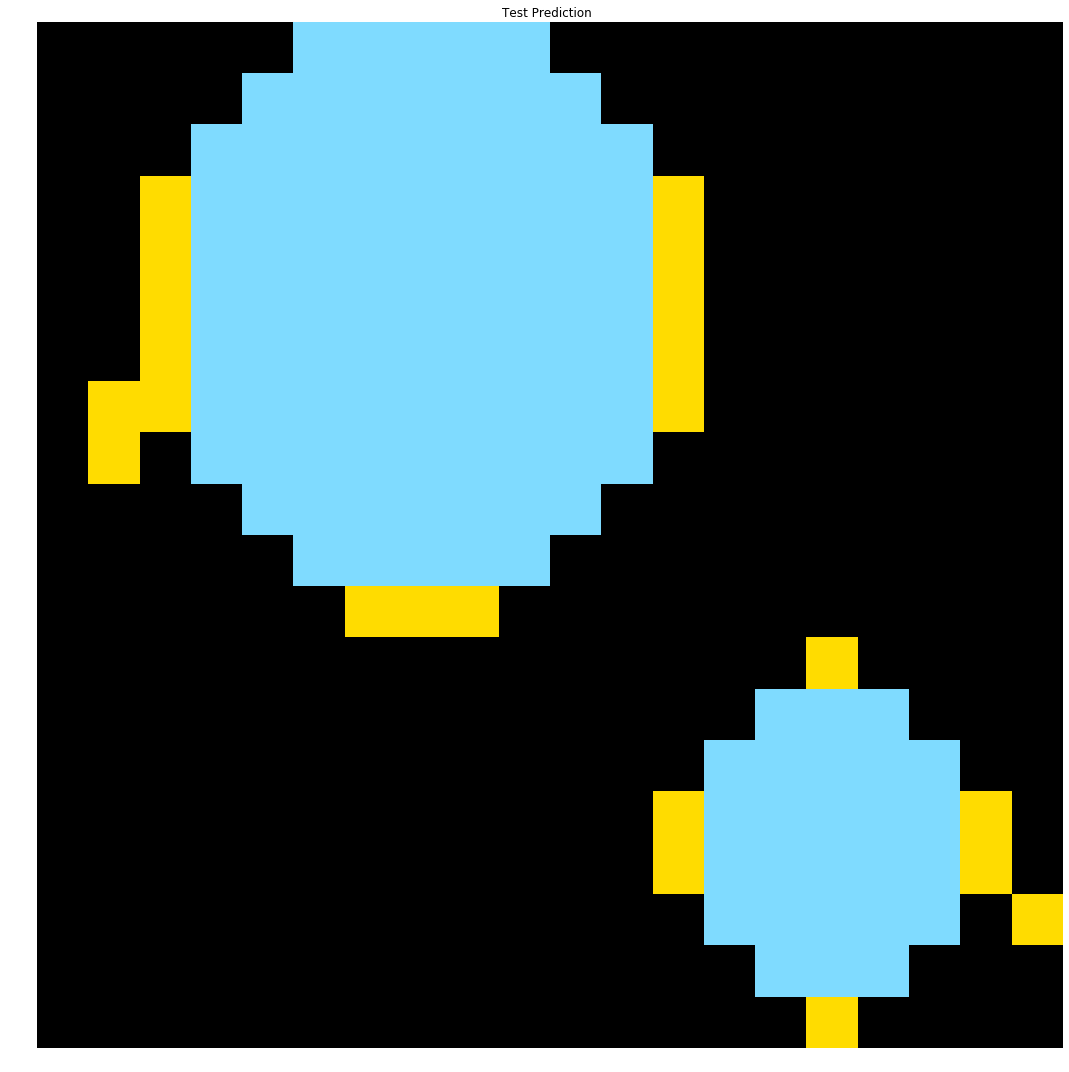

Made predictions for  981571dc
ensemble accuracy 0.9677777777777777



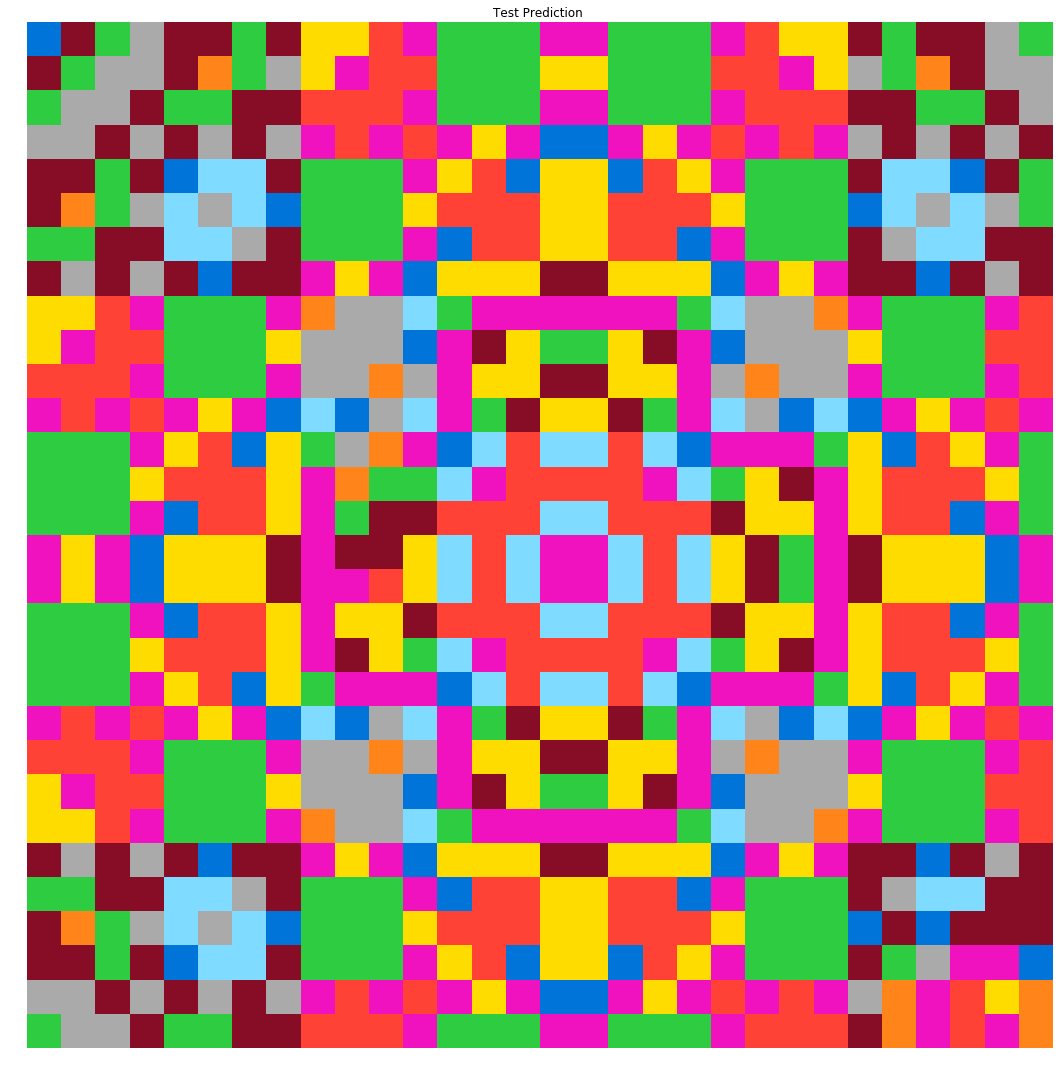

Made predictions for  992798f6
ensemble accuracy 0.96484375



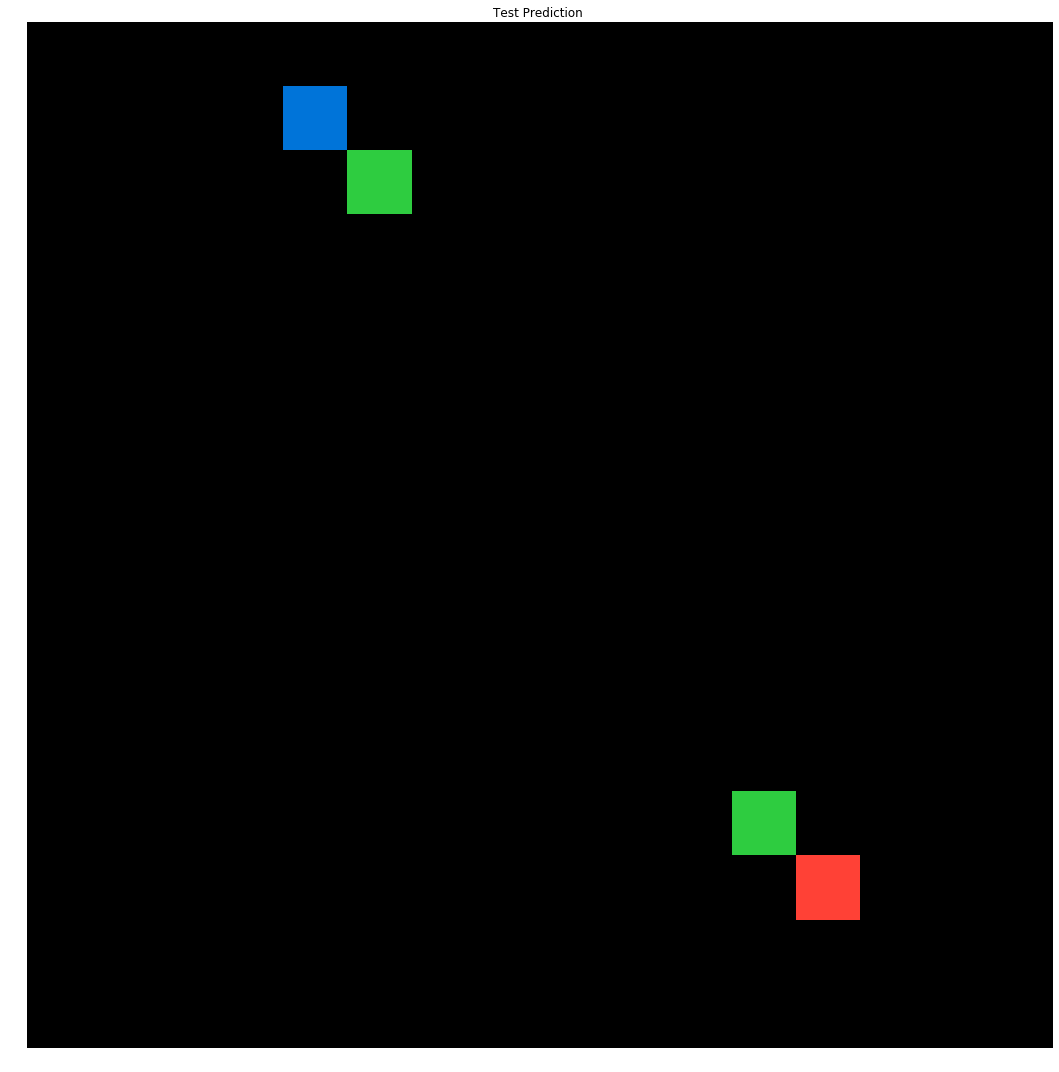

Made predictions for  99306f82
ensemble accuracy 0.6625



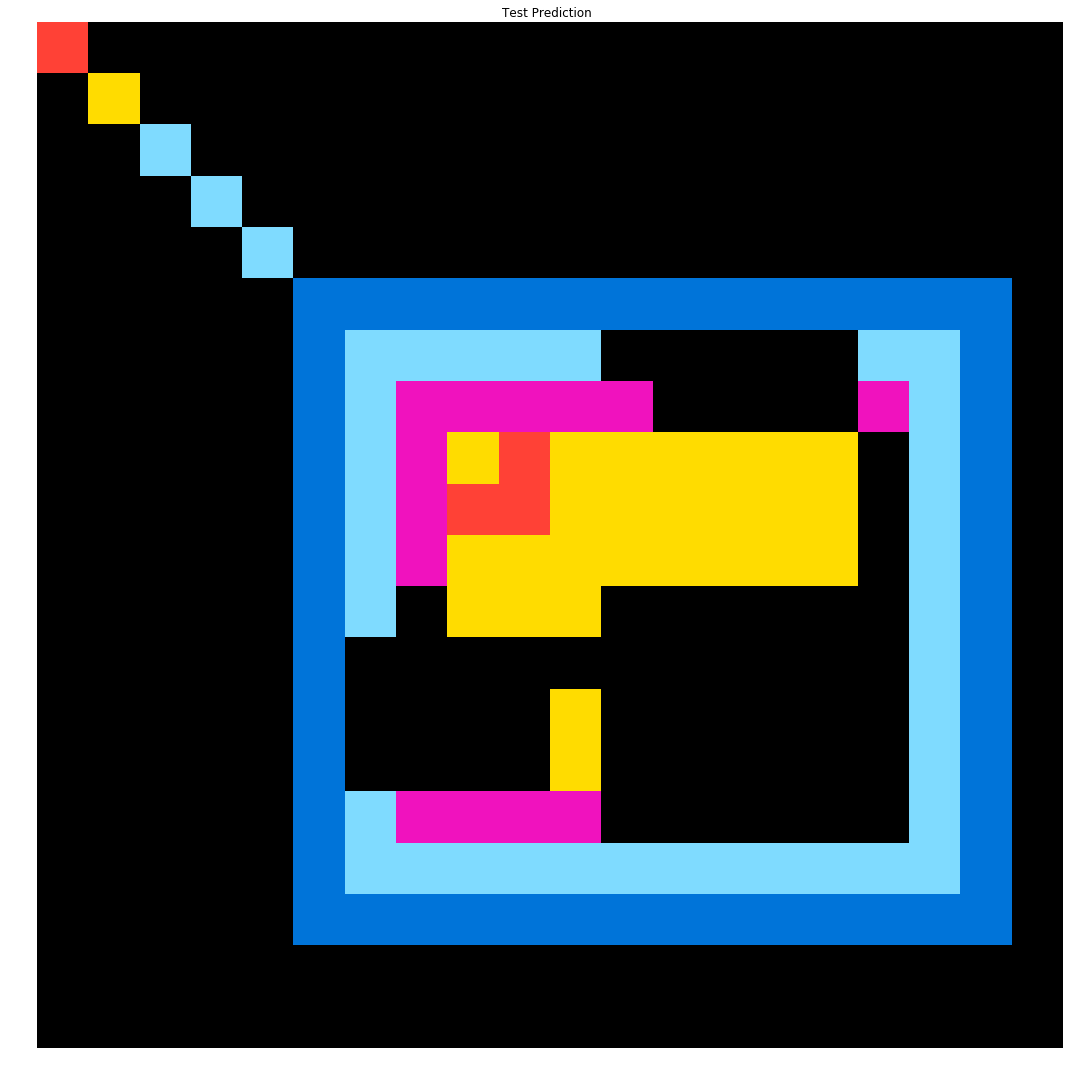

Number of input rows: 15 cols: 15
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\9a4bb226.json

Made predictions for  9b2a60aa
ensemble accuracy 0.9230769230769231



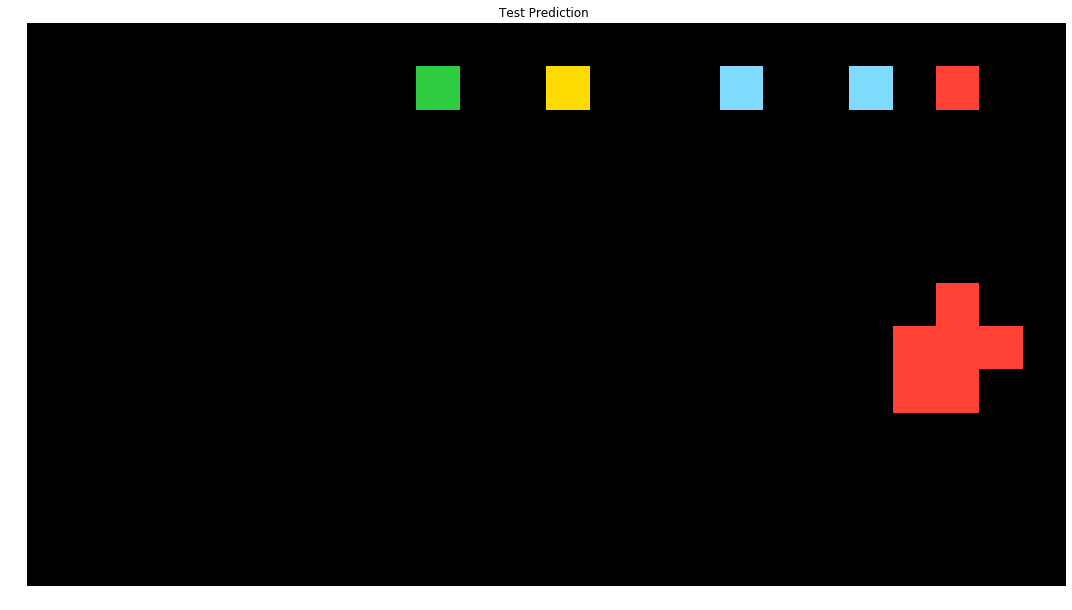

Made predictions for  9b365c51
ensemble accuracy 0.8214285714285714



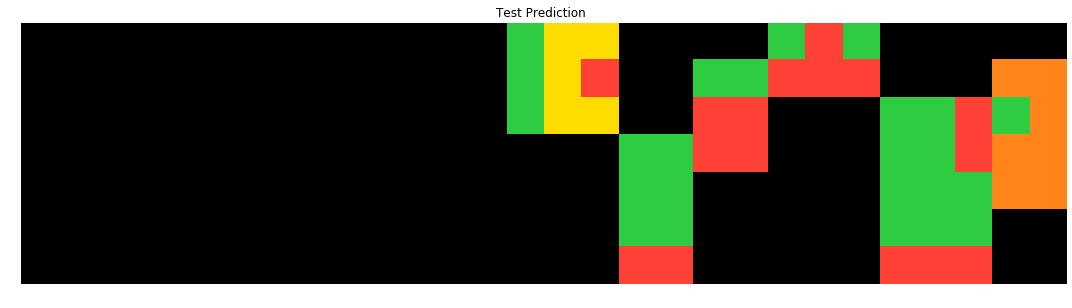

Made predictions for  9b4c17c4
ensemble accuracy 0.8909090909090909



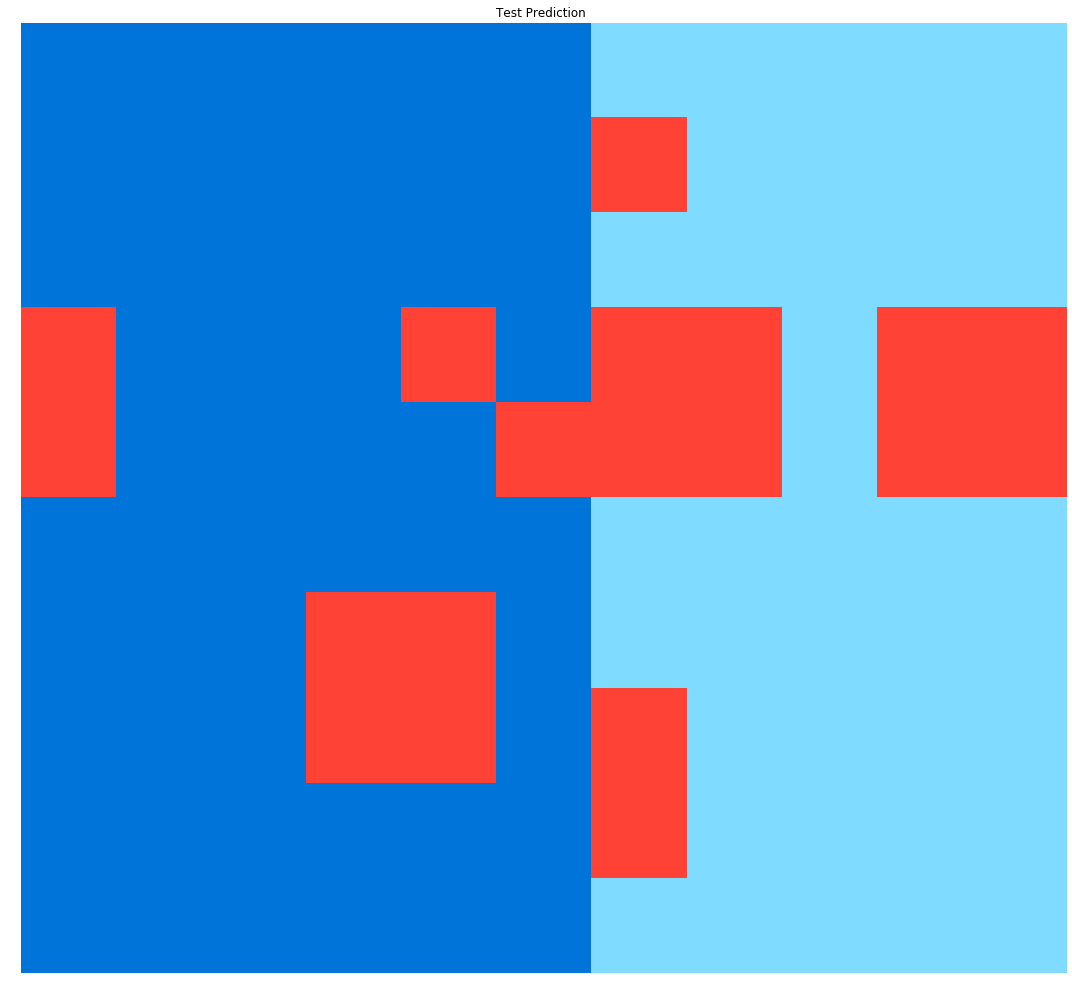

Made predictions for  9b4c17c4
ensemble accuracy 0.9135802469135802



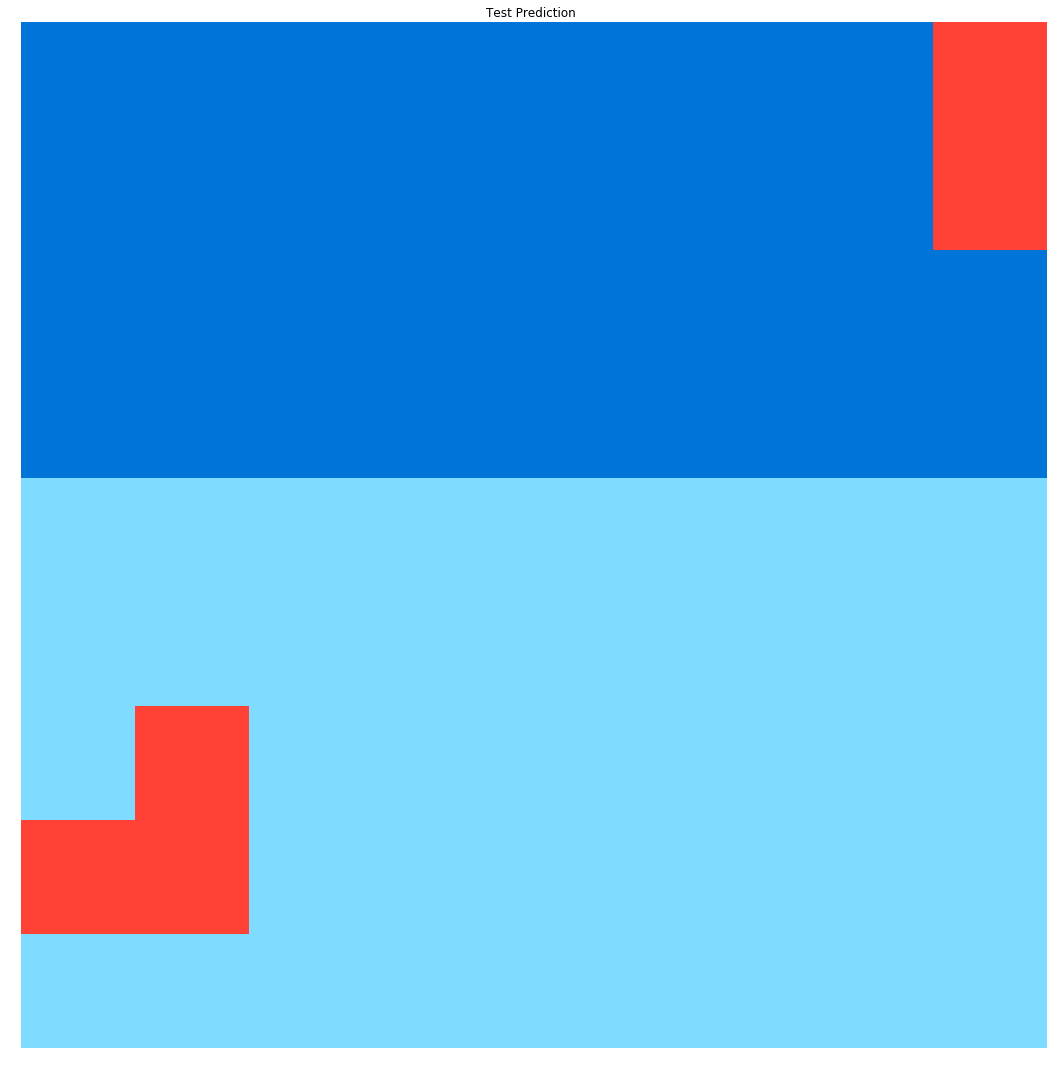

Made predictions for  9bebae7a
ensemble accuracy 0.9015151515151515



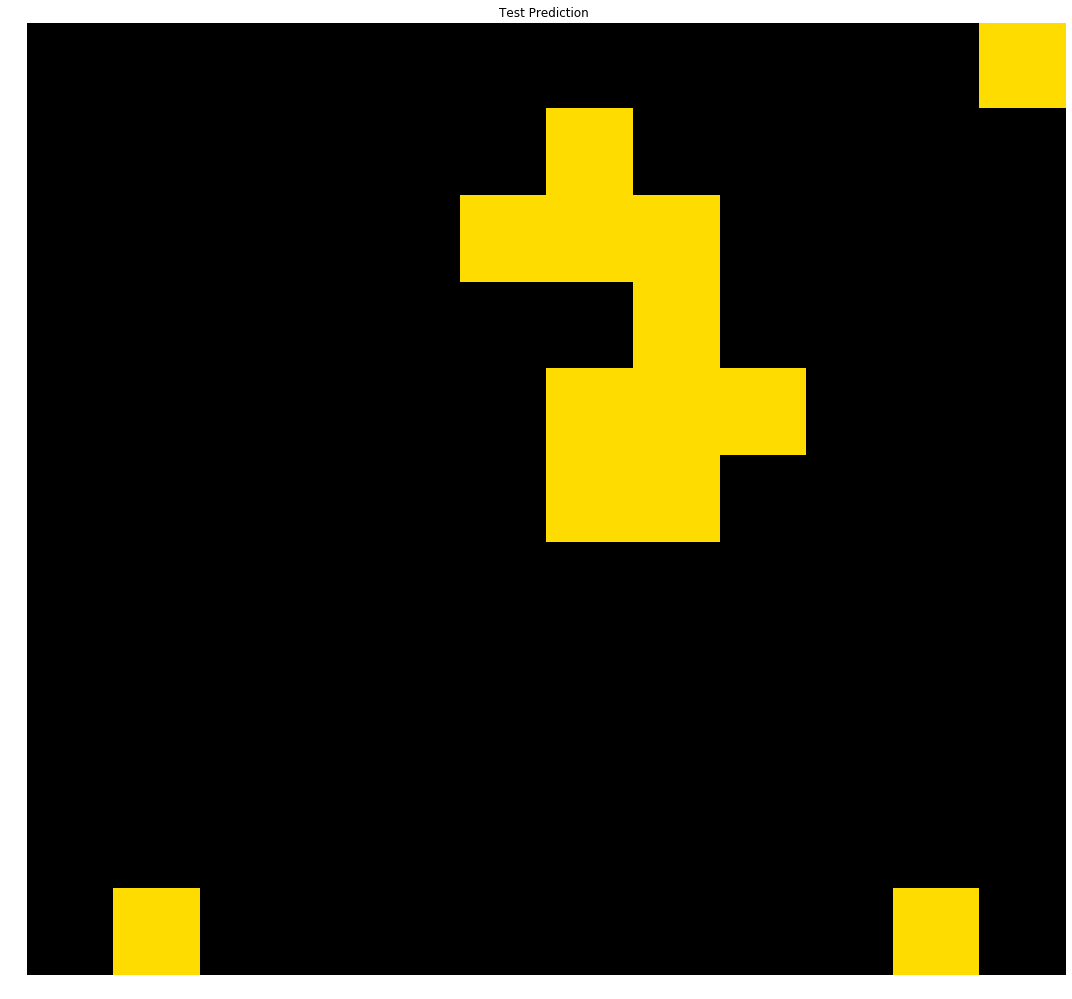

Made predictions for  9c1e755f
ensemble accuracy 0.54



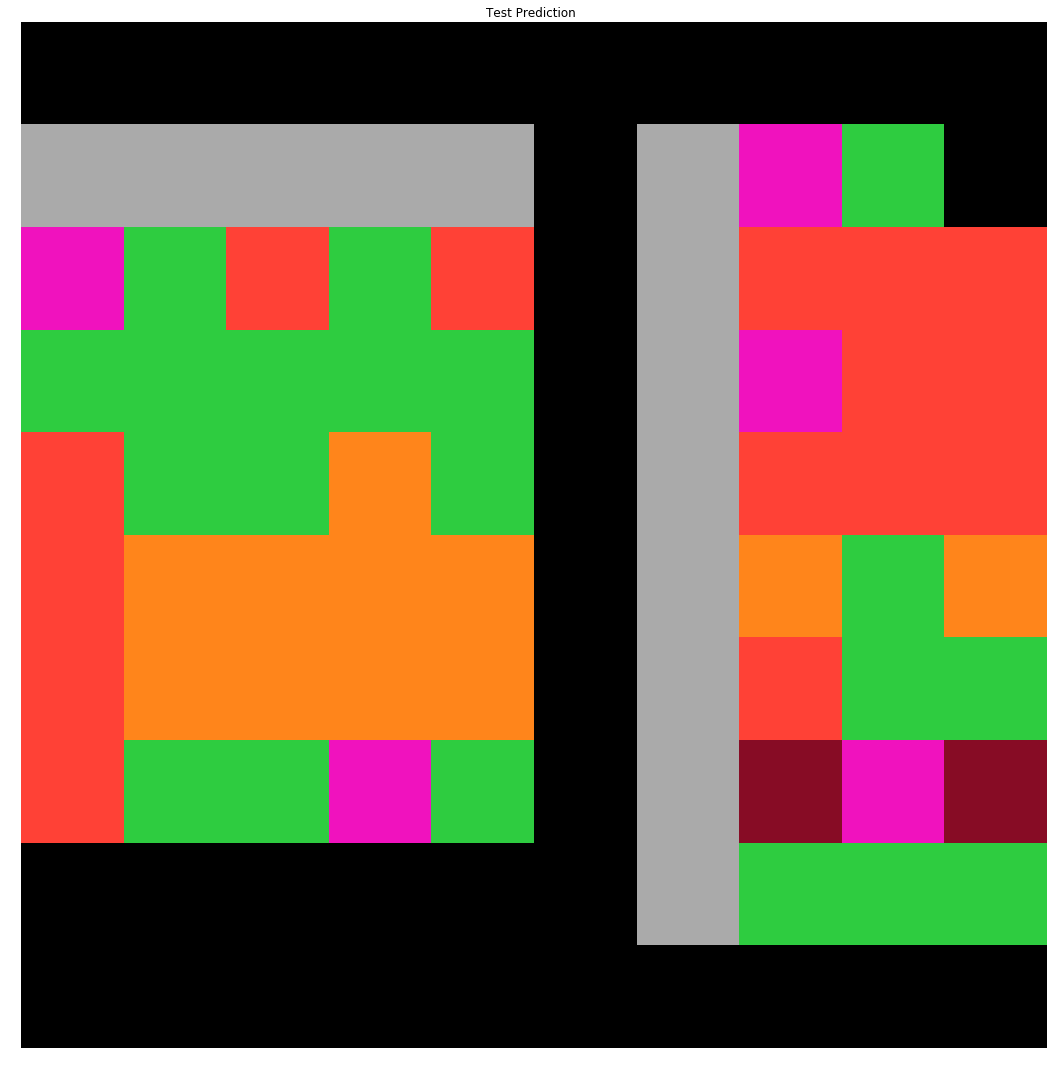

Made predictions for  9c56f360
ensemble accuracy 0.8888888888888888



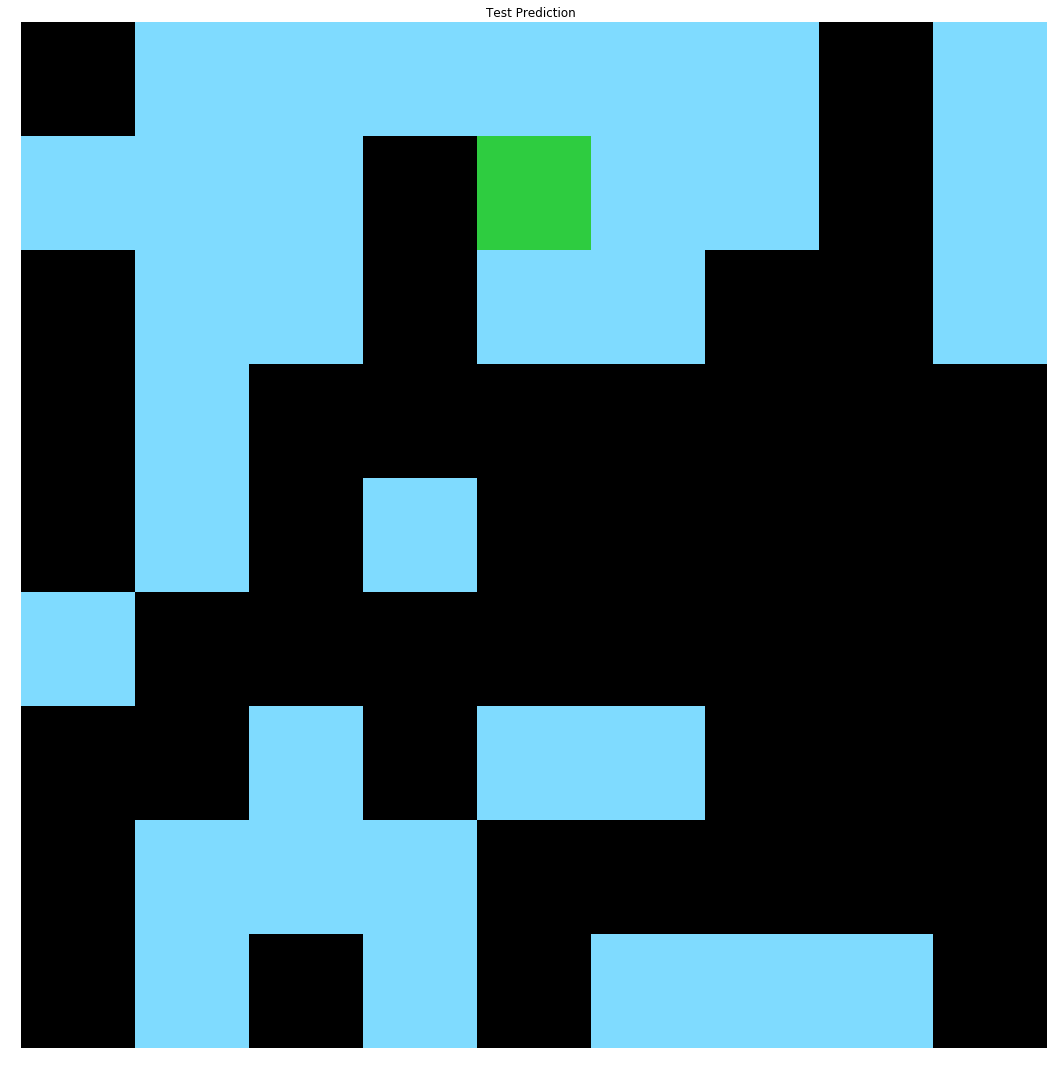

Made predictions for  9caba7c3
ensemble accuracy 0.9473684210526315



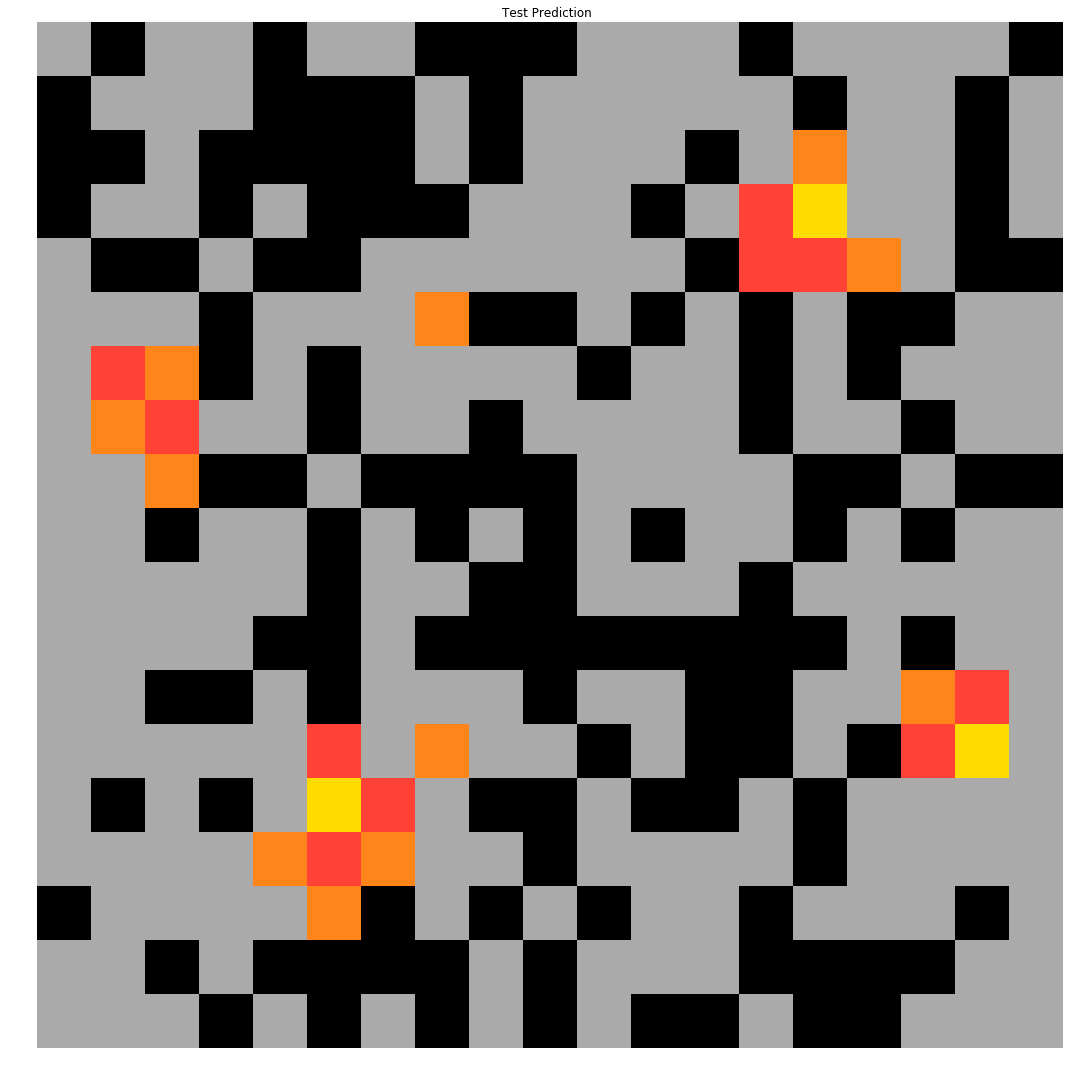

Made predictions for  9ddd00f0
ensemble accuracy 0.11634349030470914



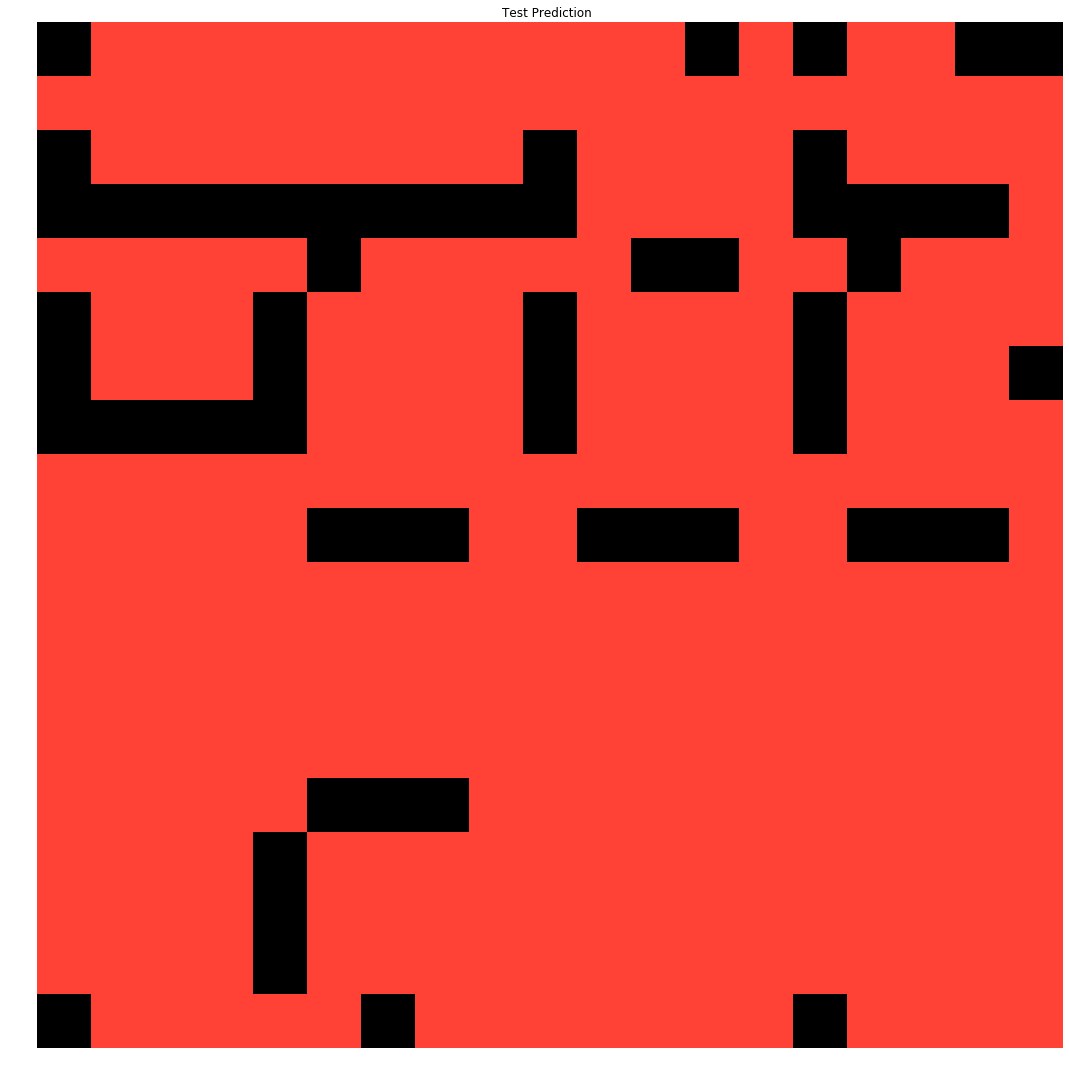

Made predictions for  9def23fe
ensemble accuracy 0.84



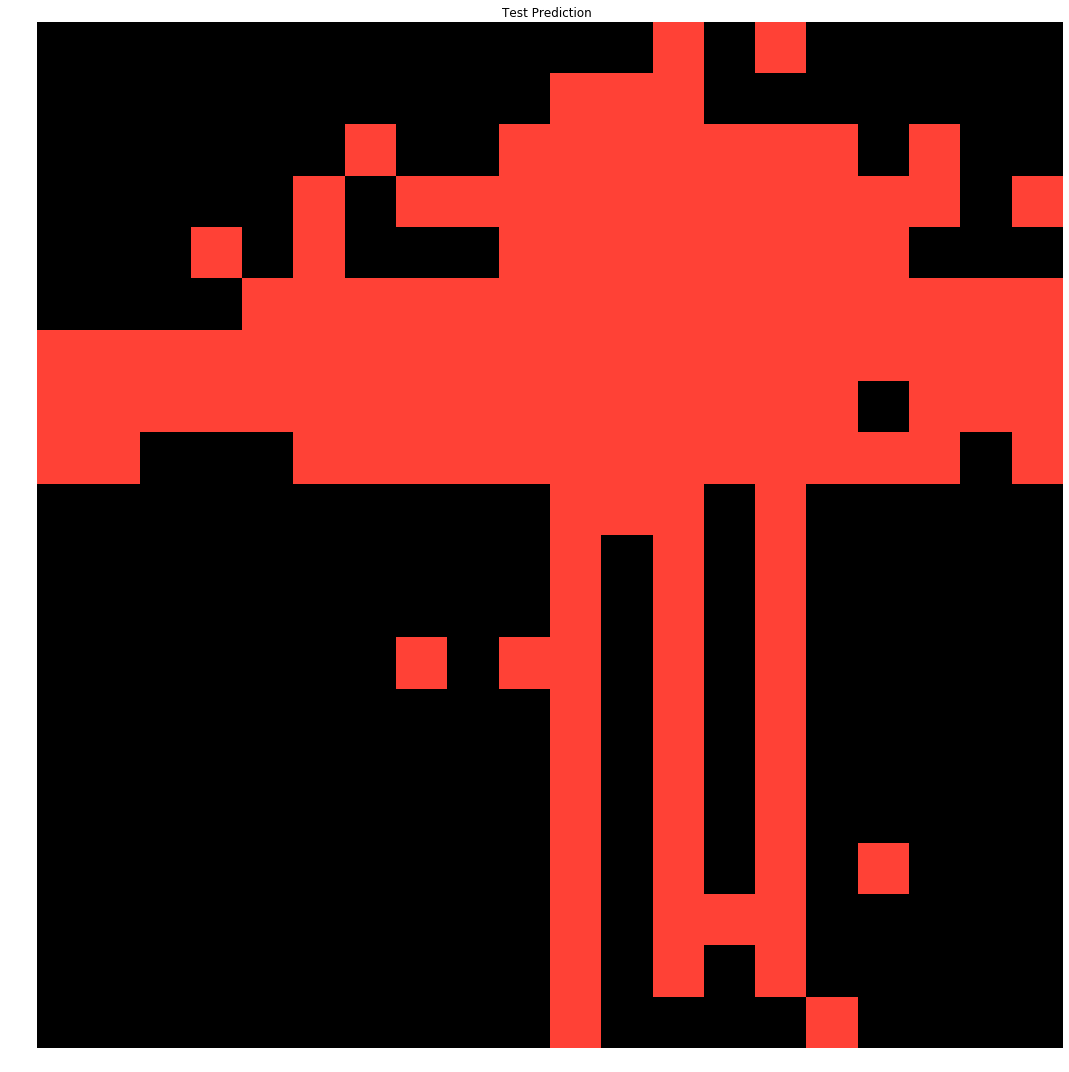

Made predictions for  9f27f097
ensemble accuracy 0.08333333333333333



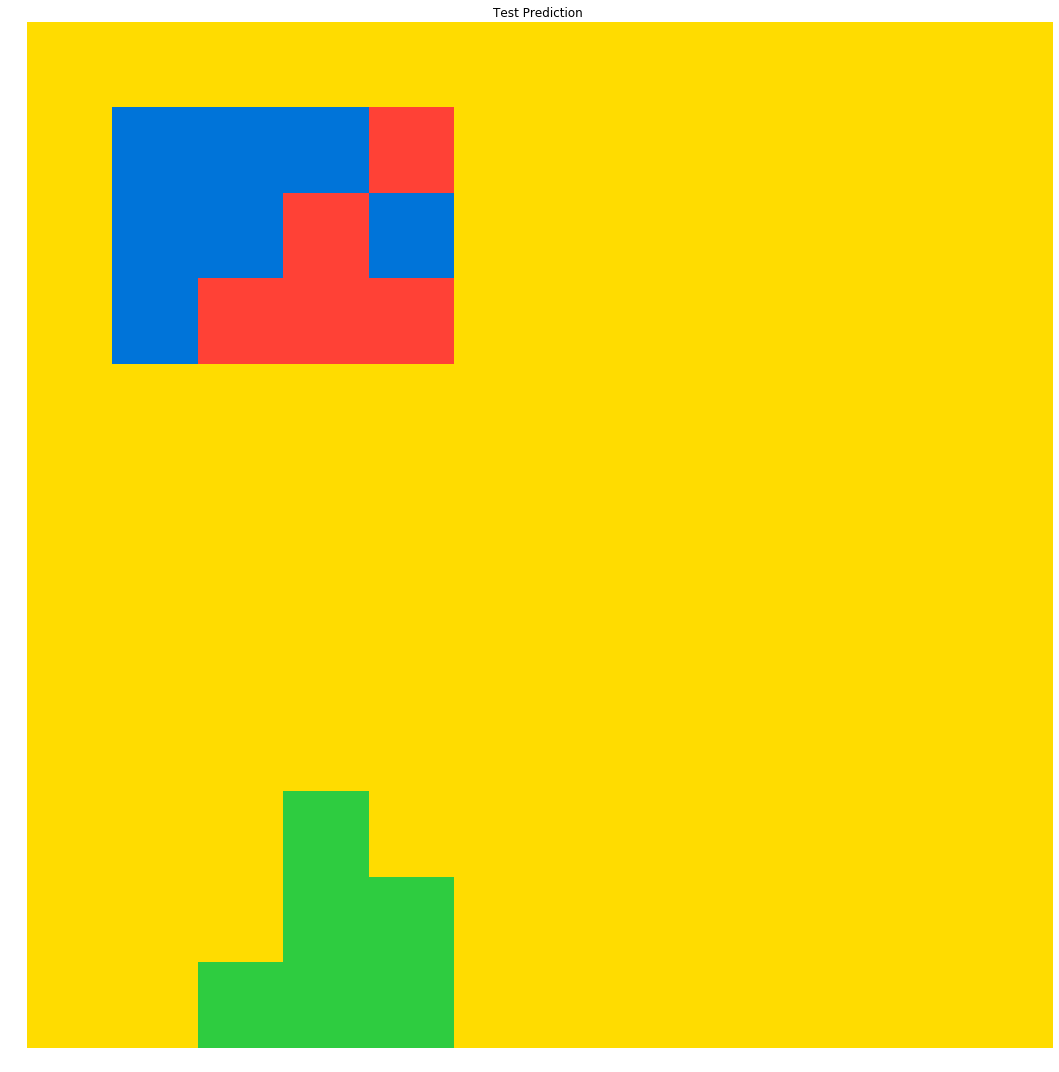

Made predictions for  a04b2602
ensemble accuracy 0.9814814814814815



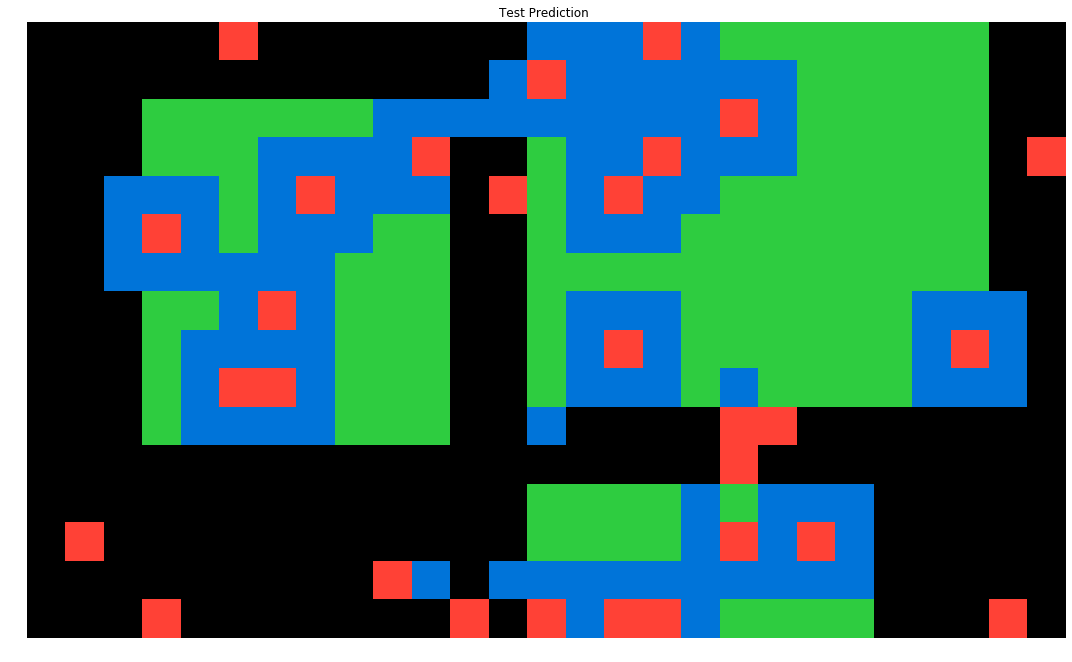

Made predictions for  a096bf4d
ensemble accuracy 0.5014792899408284



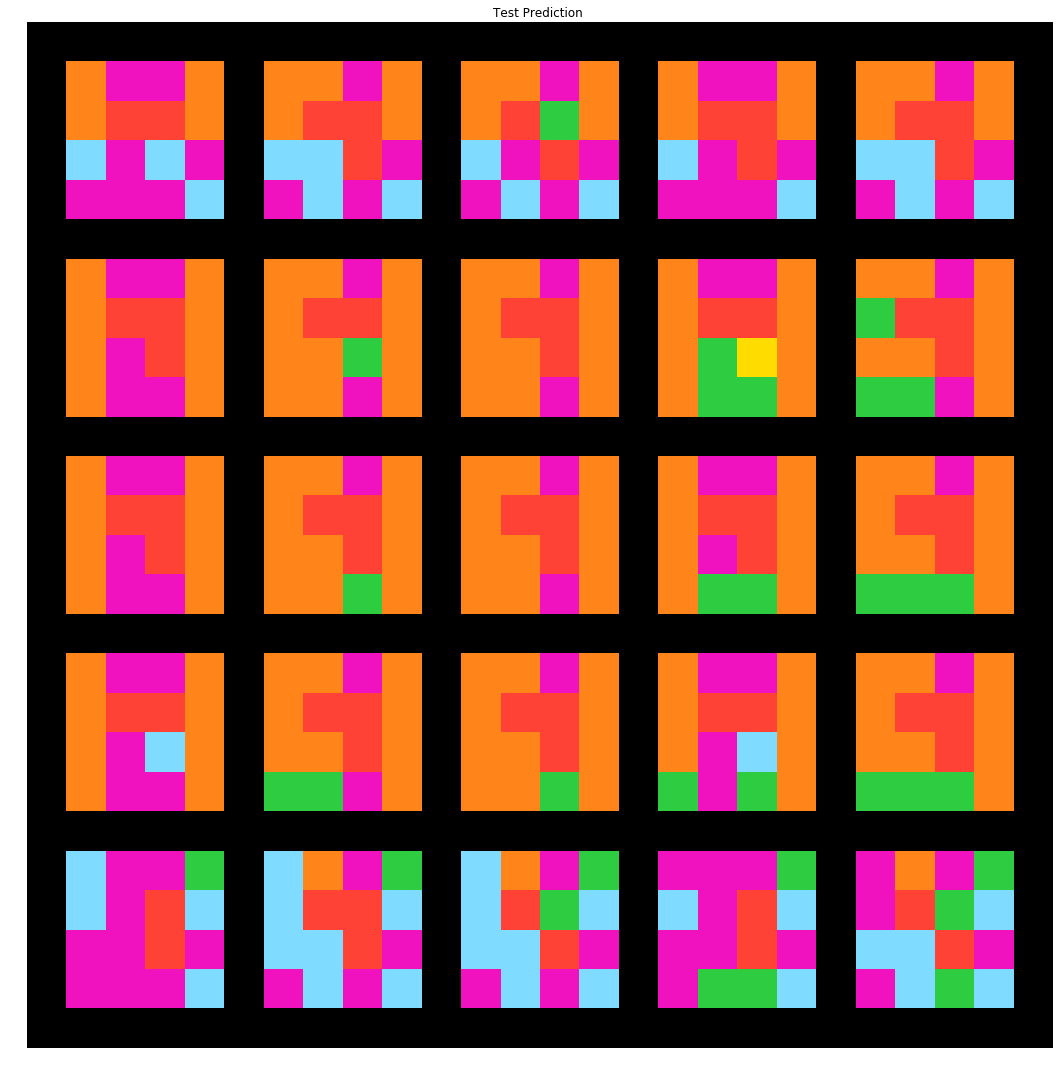

Made predictions for  a3f84088
ensemble accuracy 0.7822222222222223



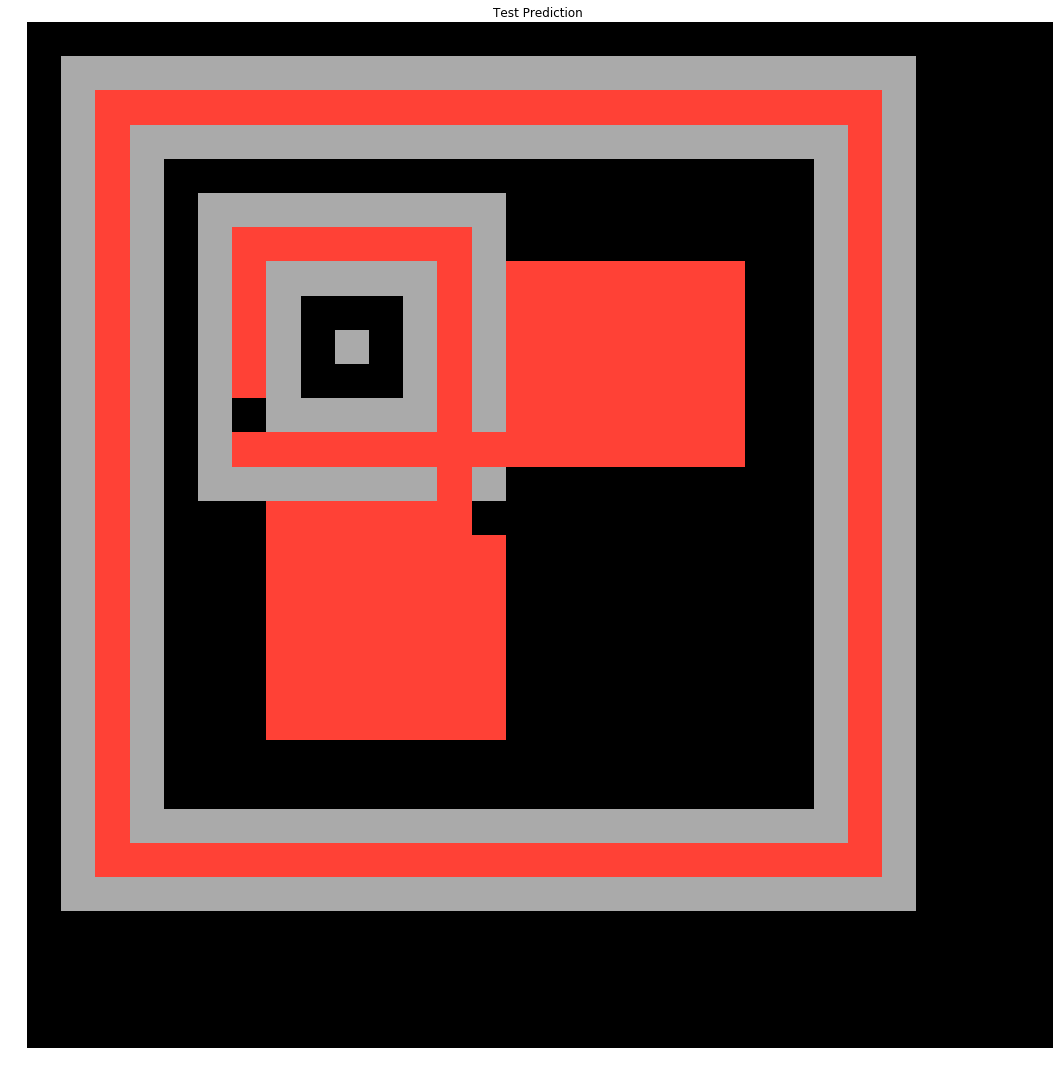

Made predictions for  a406ac07
ensemble accuracy 0.81



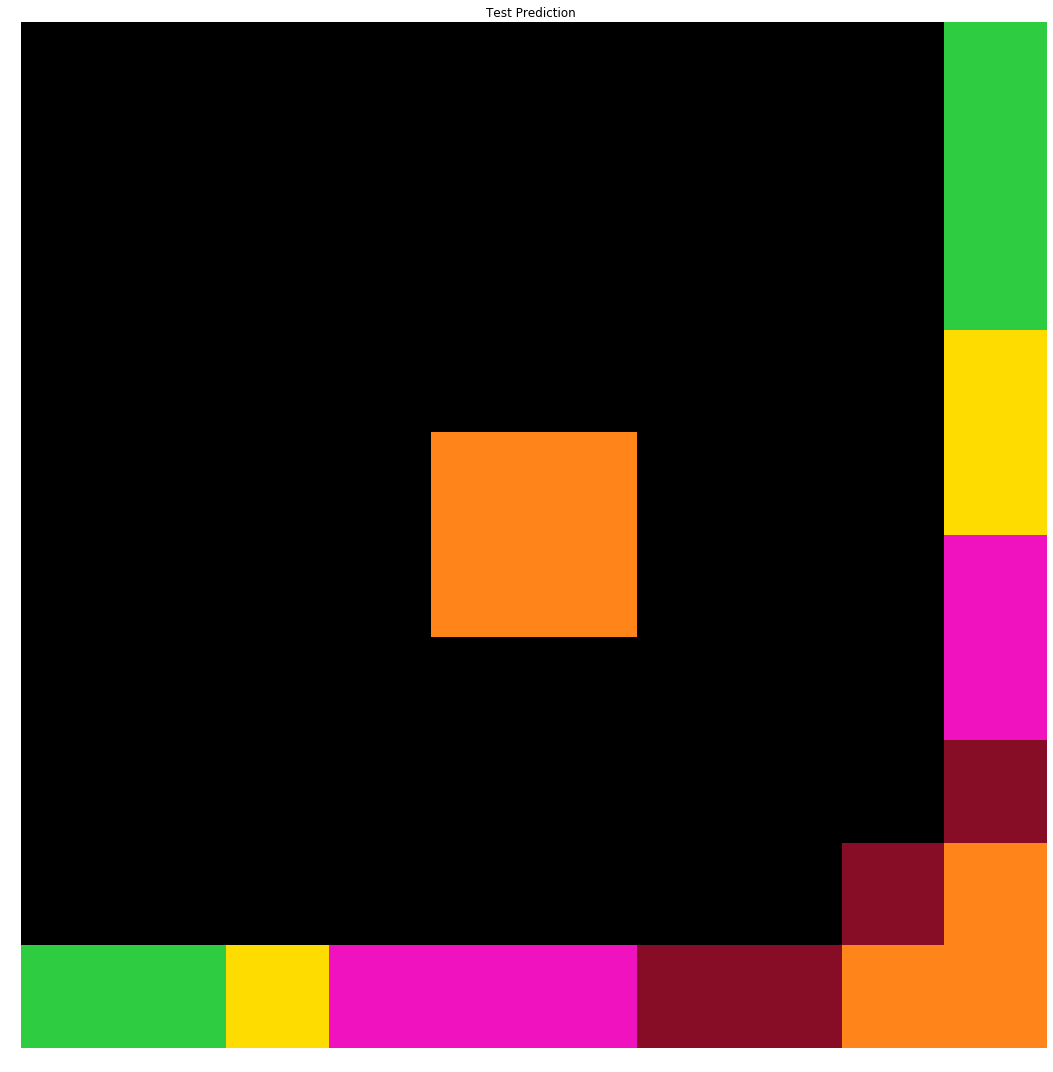

Made predictions for  a57f2f04
ensemble accuracy 0.8356643356643356



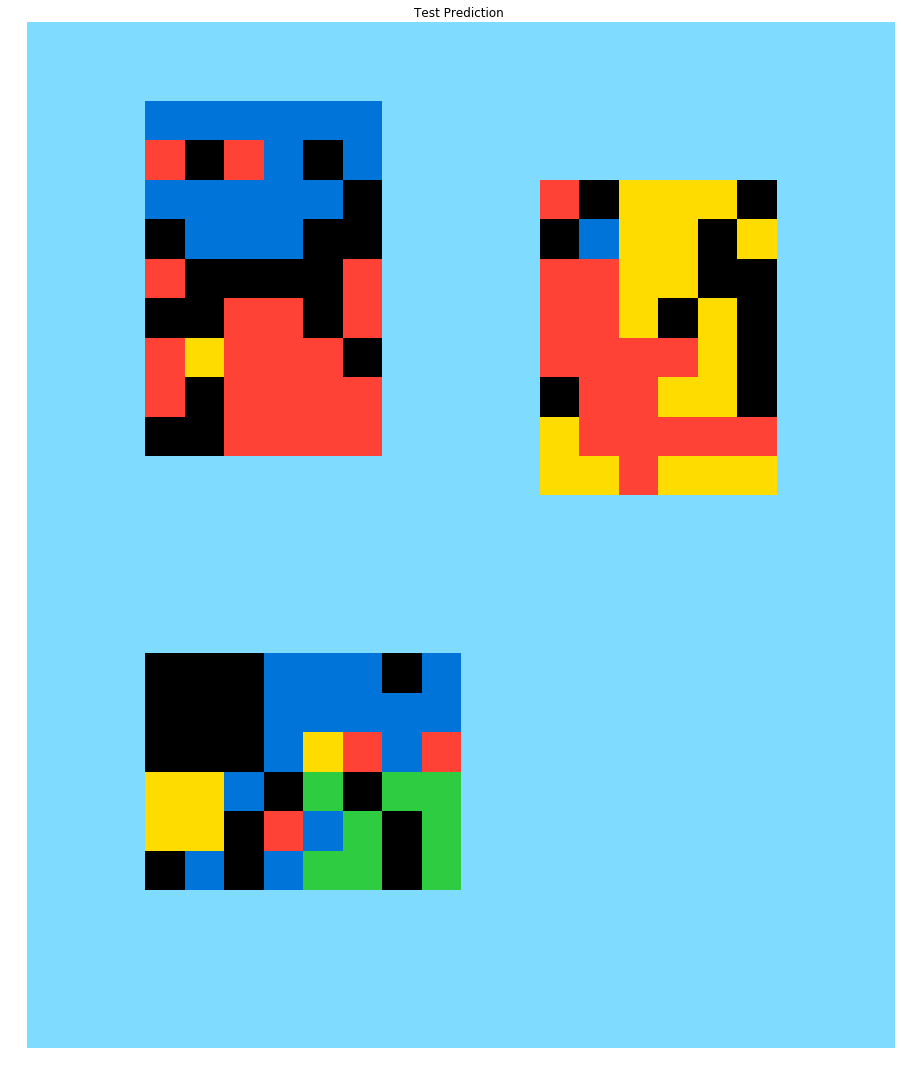

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\a59b95c0.json

Number of input rows: 18 cols: 17
Number of target rows: 4 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\a680ac02.json

Made predictions for  a8610ef7
ensemble accuracy 0.6111111111111112



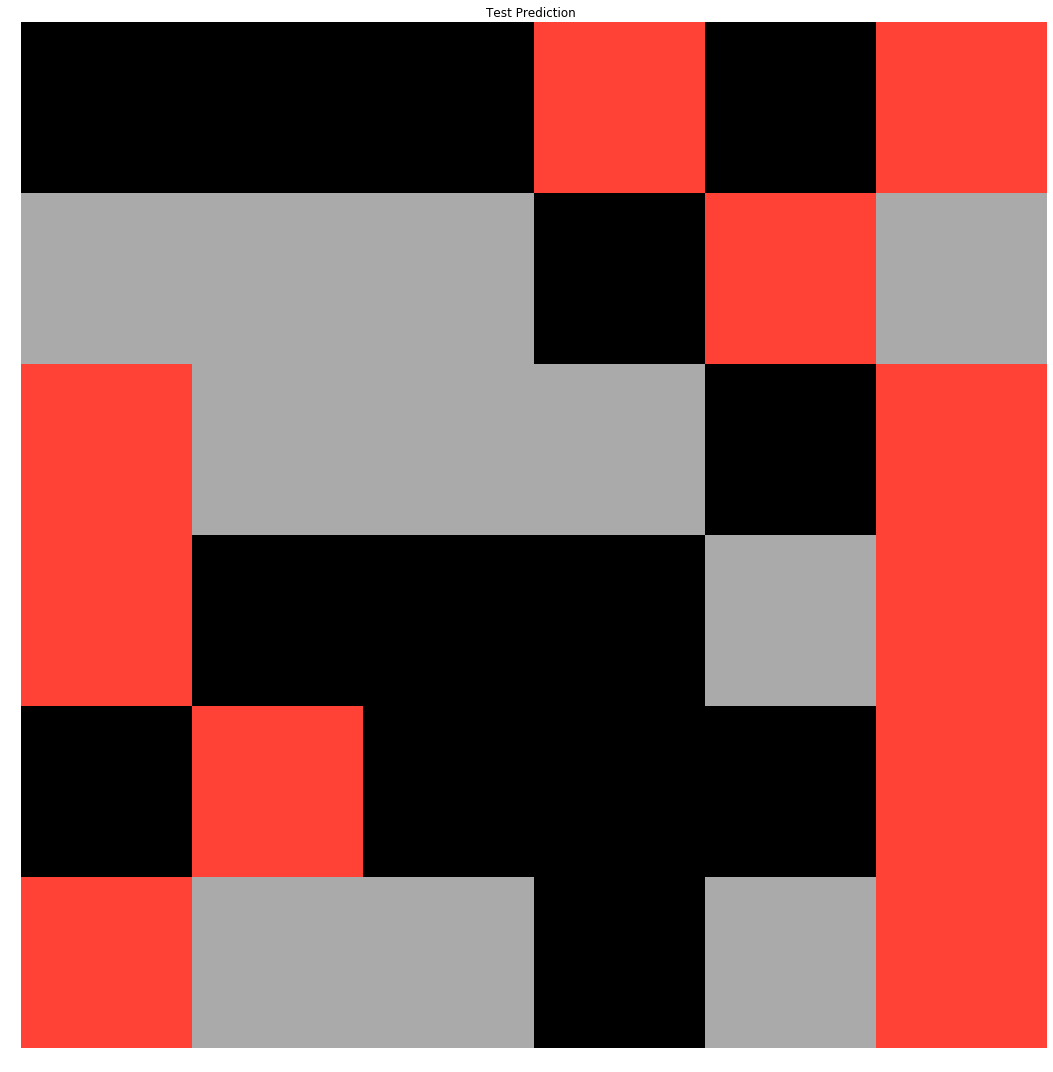

Made predictions for  a934301b
ensemble accuracy 0.8012820512820513



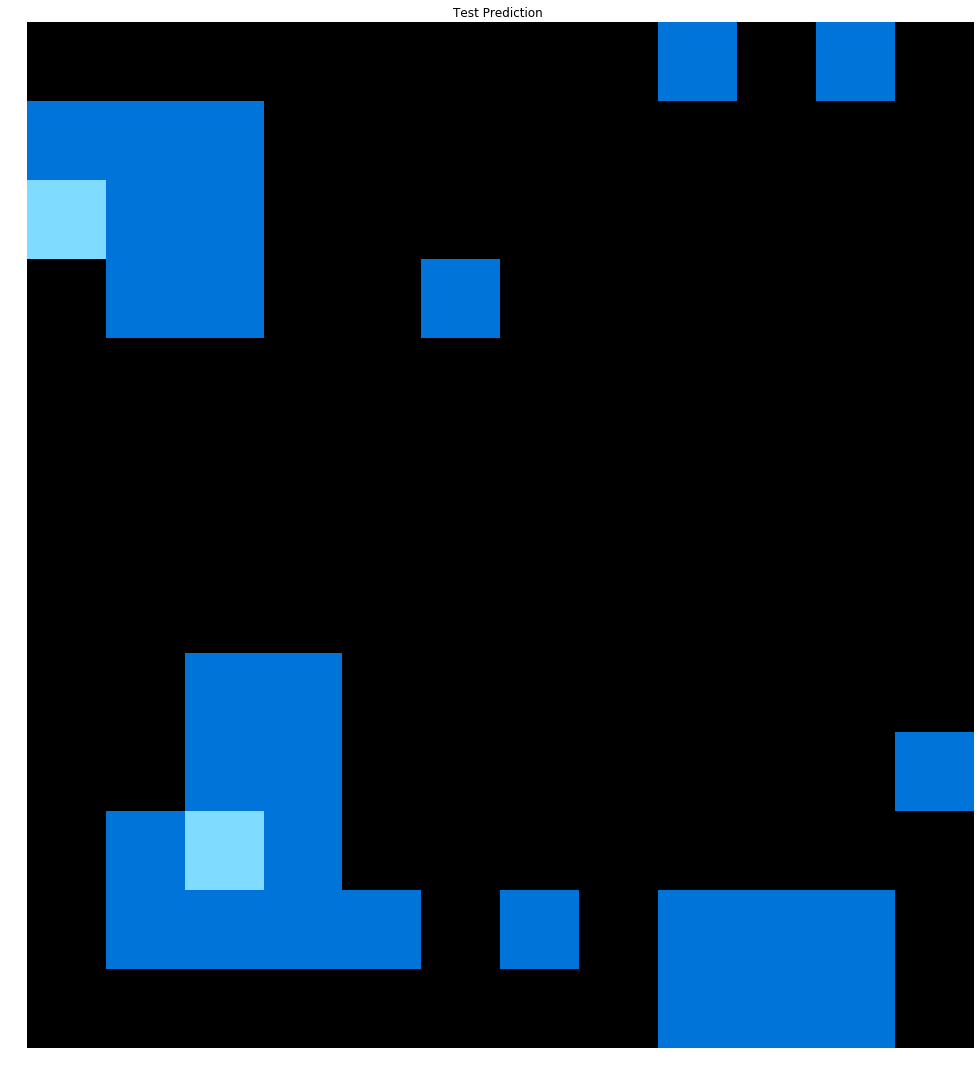

Made predictions for  aa18de87
ensemble accuracy 0.6666666666666666



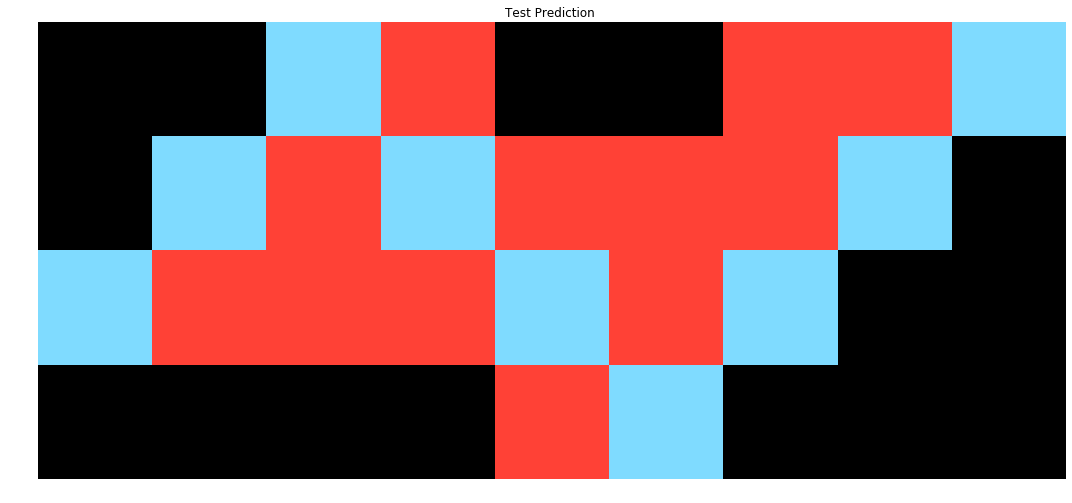

Made predictions for  aa300dc3
ensemble accuracy 0.91



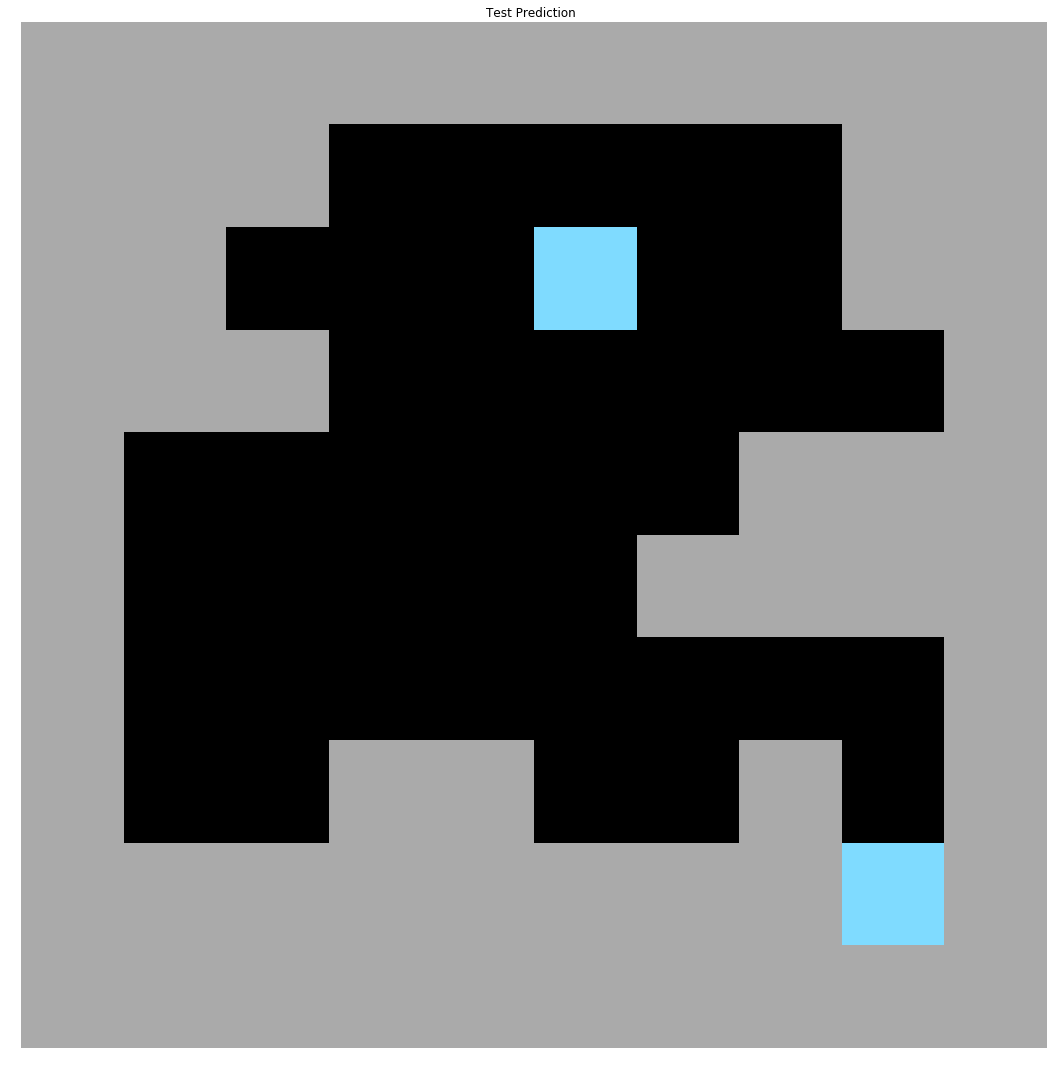

Made predictions for  aa4ec2a5
ensemble accuracy 0.8817663817663818



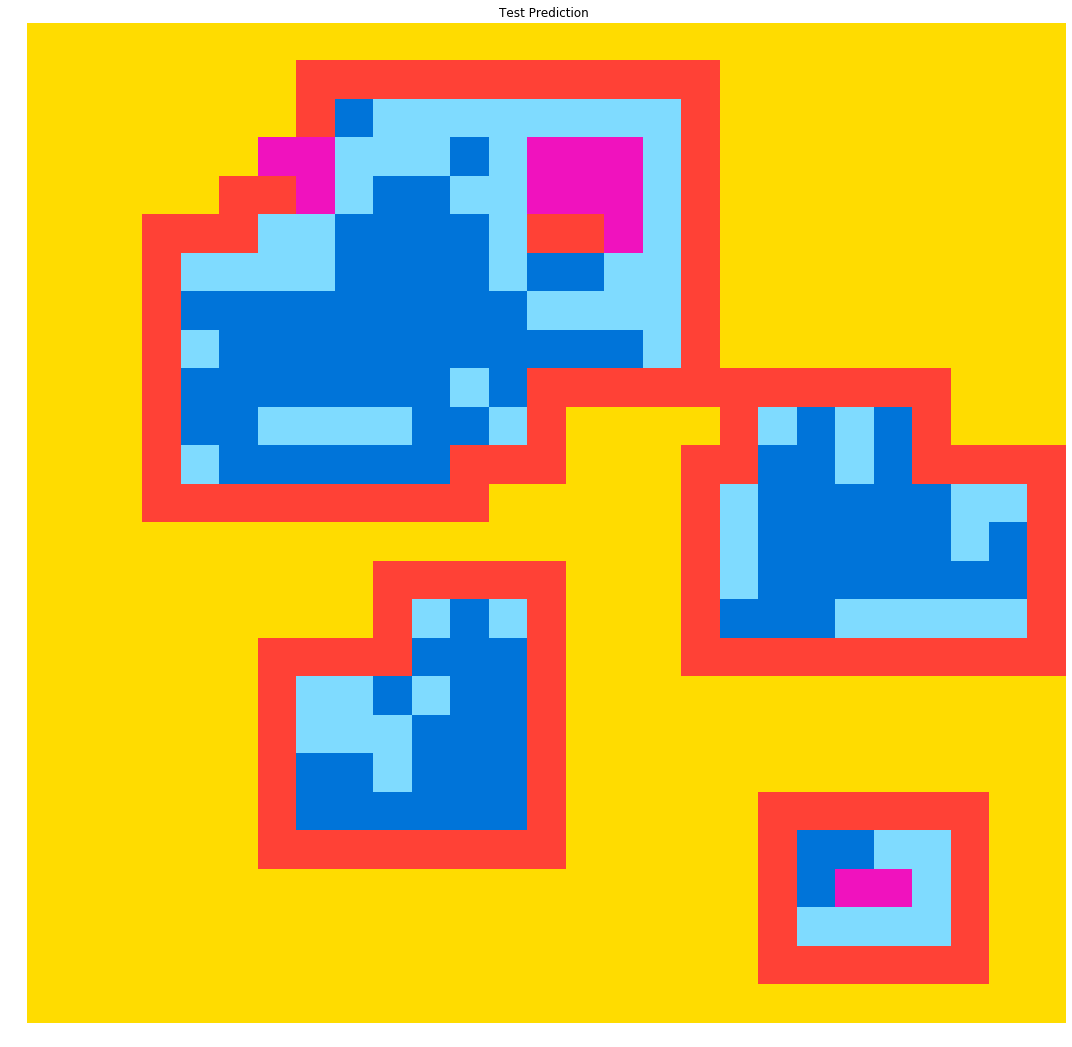

Number of input rows: 13 cols: 17
Number of target rows: 4 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\aab50785.json

Made predictions for  ac0c5833
ensemble accuracy 0.9218106995884774



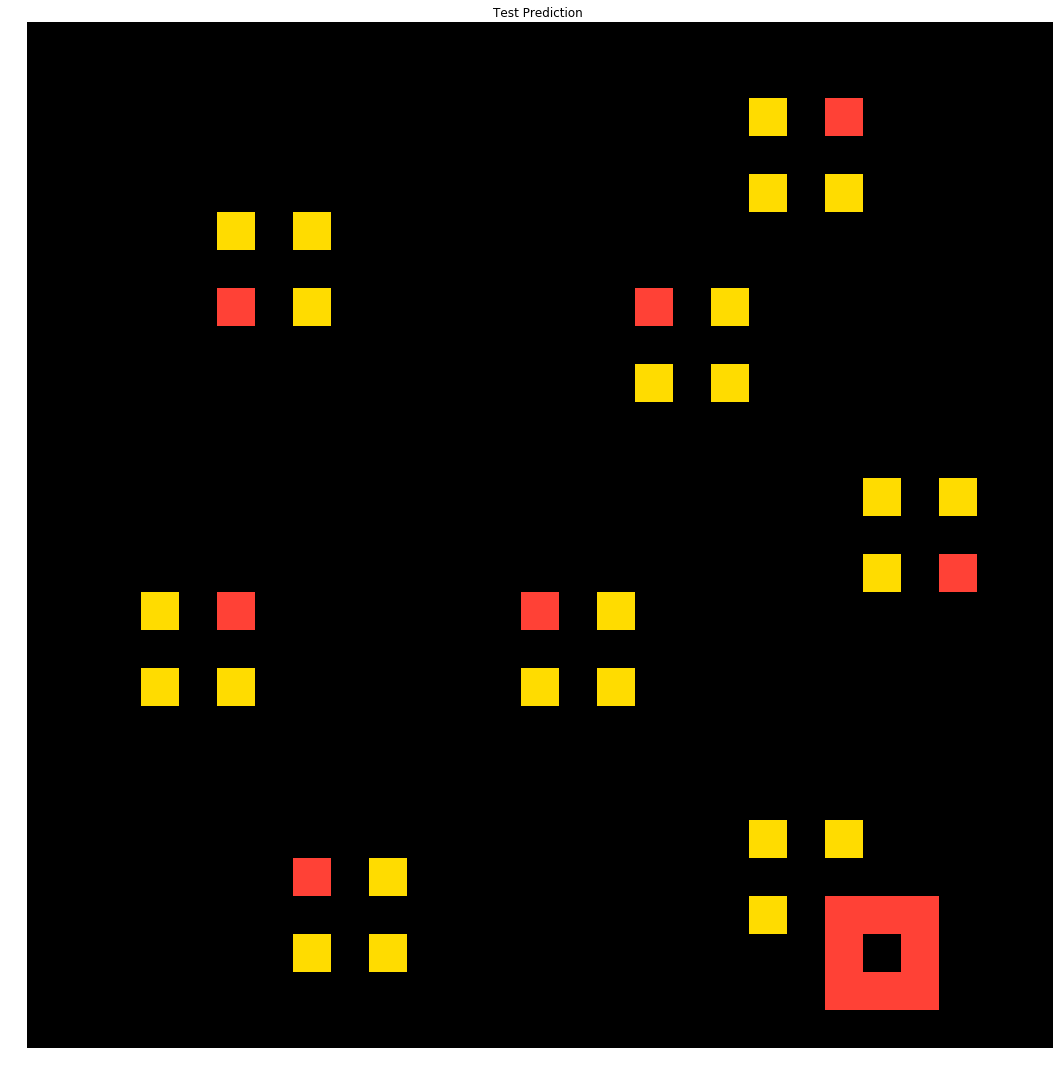

Made predictions for  ac2e8ecf
ensemble accuracy 0.7083333333333334



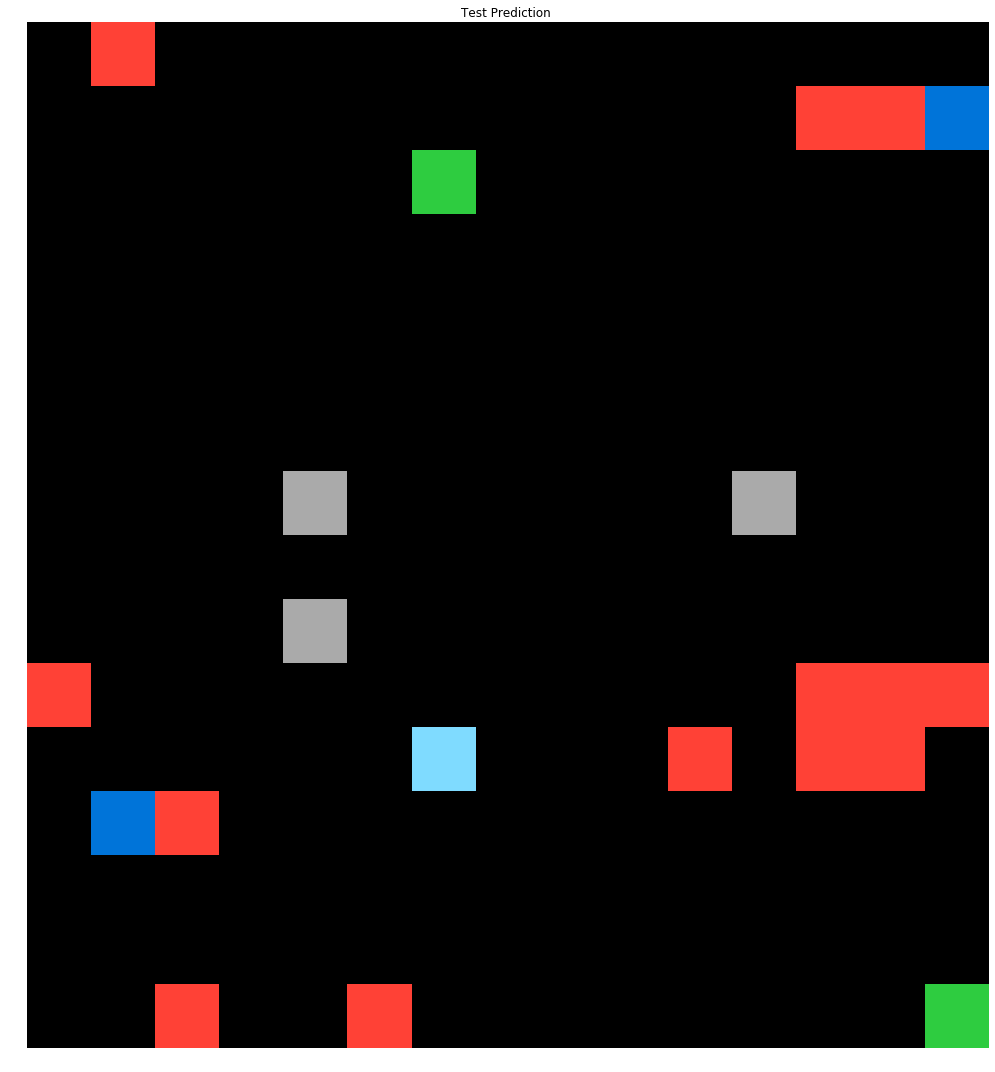

Made predictions for  ac3e2b04
ensemble accuracy 0.8611111111111112



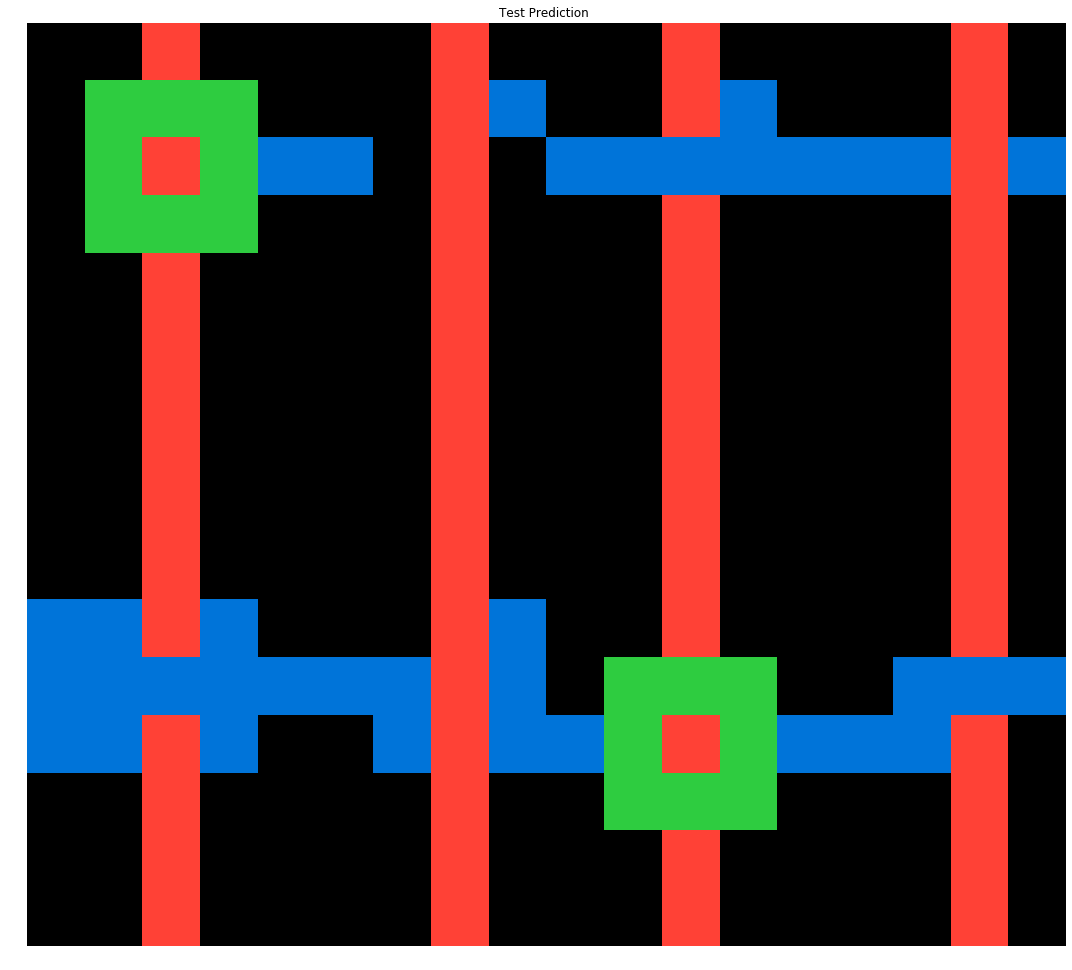

Made predictions for  ac605cbb
ensemble accuracy 0.8512396694214877



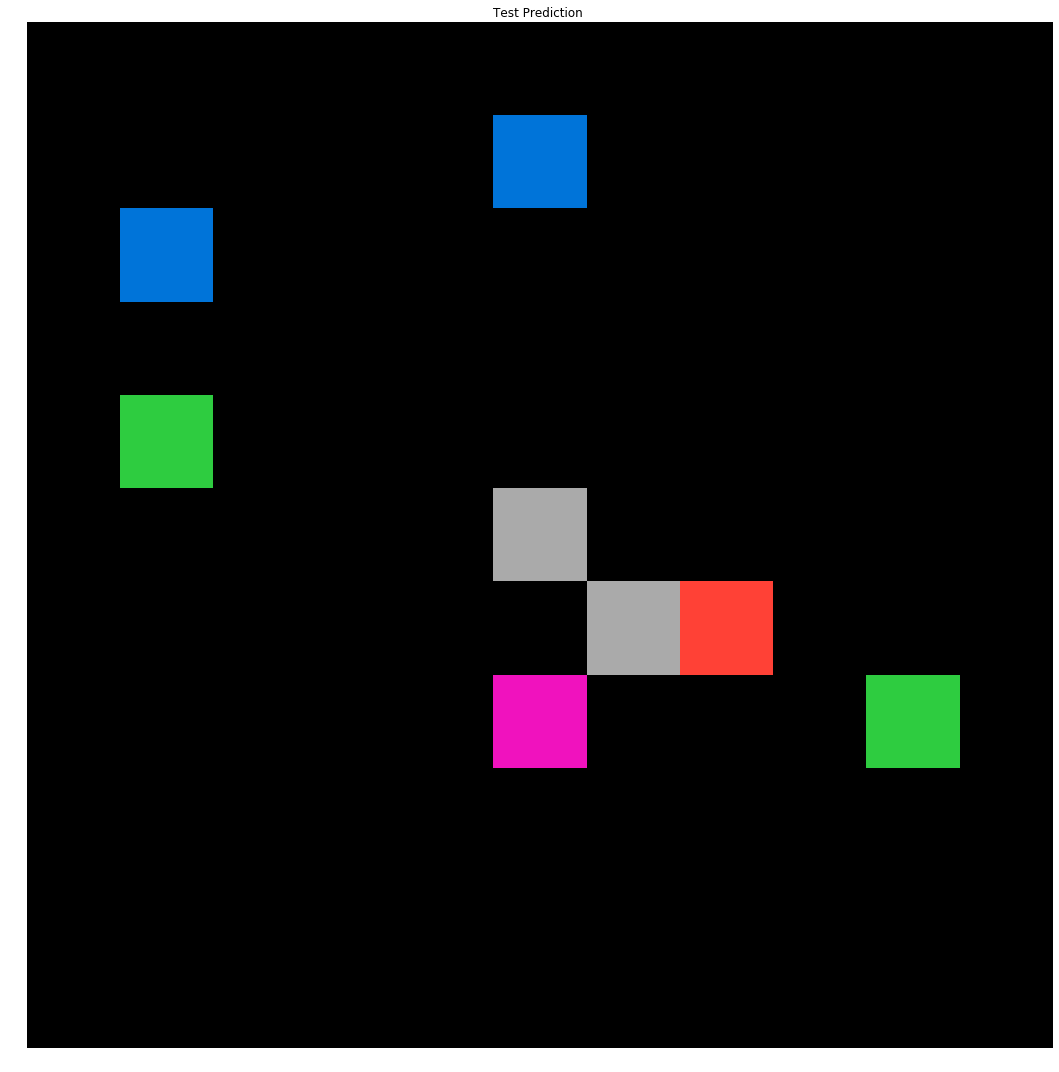

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\ad7e01d0.json

Made predictions for  ae58858e
ensemble accuracy 0.9583333333333334



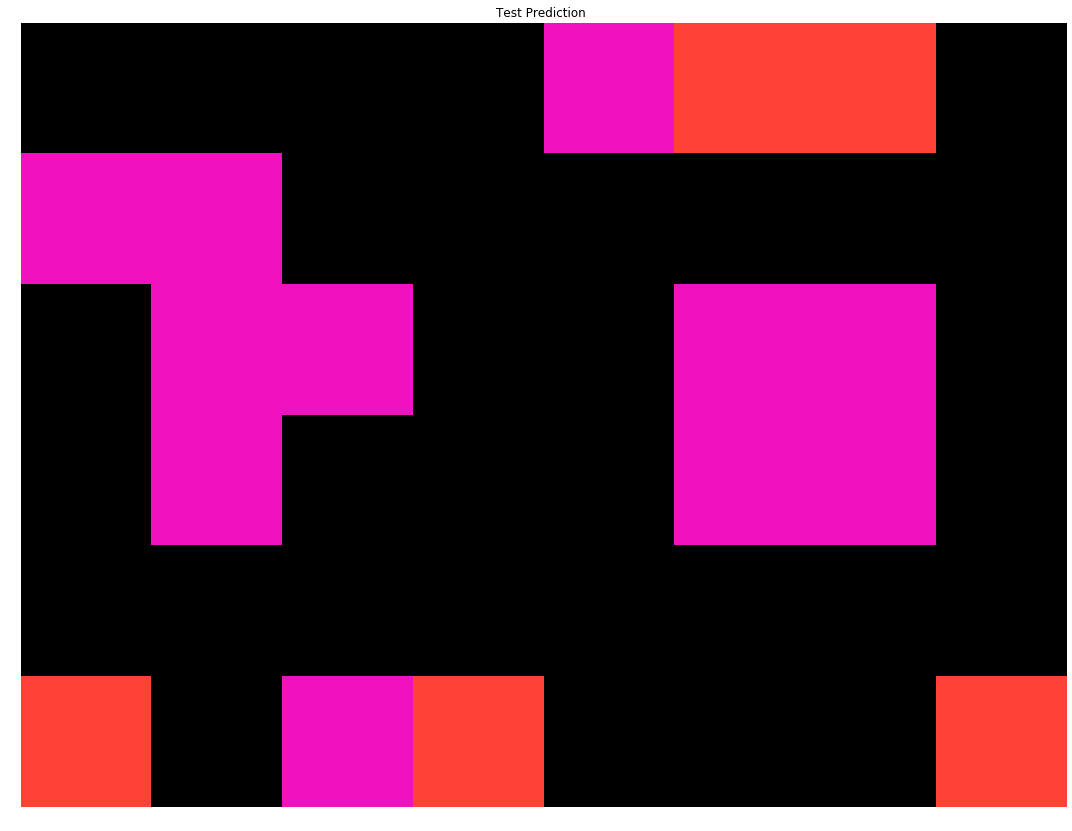

Number of input rows: 16 cols: 16
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\aee291af.json

Made predictions for  af22c60d
ensemble accuracy 0.9411111111111111



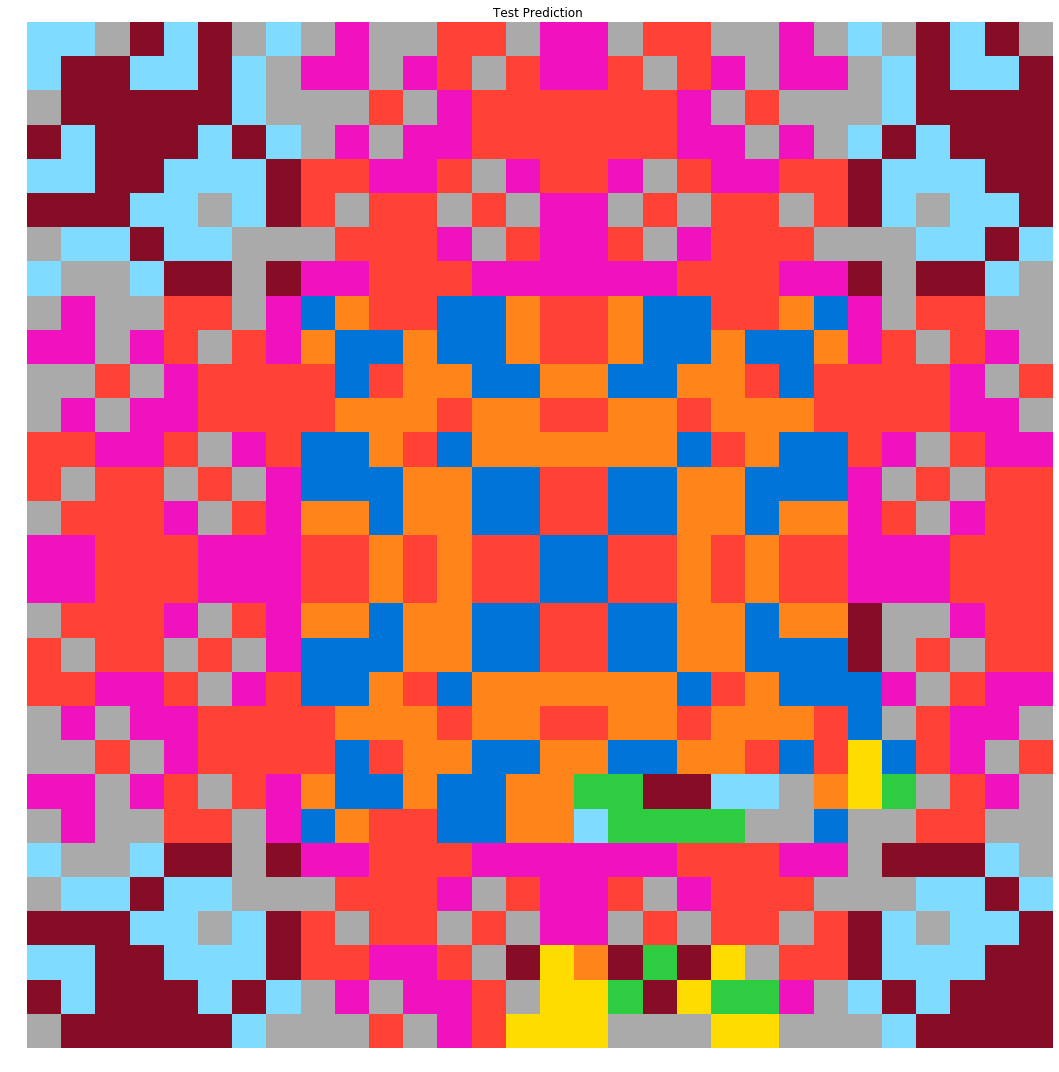

Number of input rows: 9 cols: 10
Number of target rows: 4 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\af24b4cc.json

Number of input rows: 11 cols: 9
Number of target rows: 11 cols: 2
ignoring task abstraction-and-reasoning-challenge\evaluation\b0722778.json

Number of input rows: 9 cols: 11
Number of target rows: 9 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\b0f4d537.json

Made predictions for  b15fca0b
ensemble accuracy 0.89



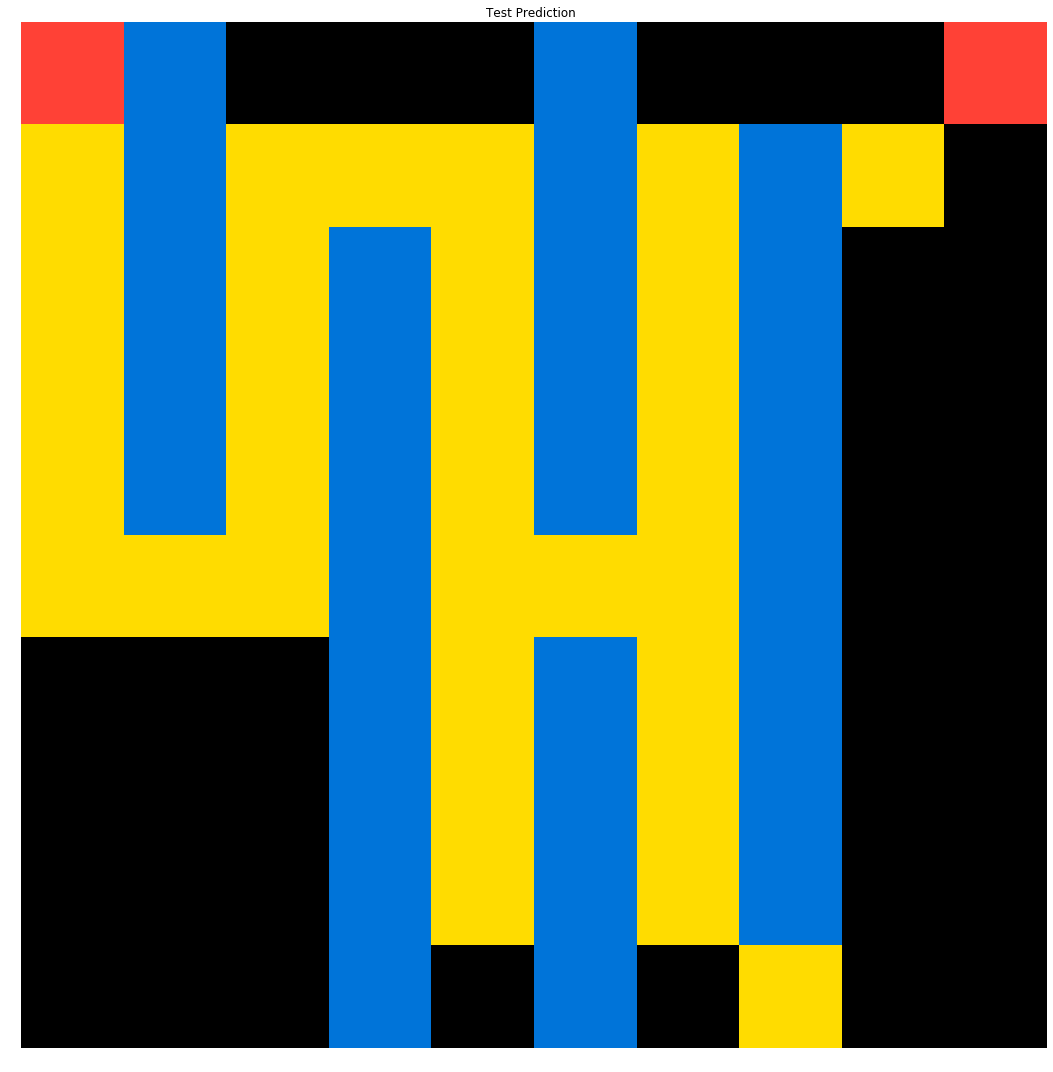

Number of input rows: 6 cols: 6
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\b1fc8b8e.json

Made predictions for  b20f7c8b
ensemble accuracy 0.7752525252525253



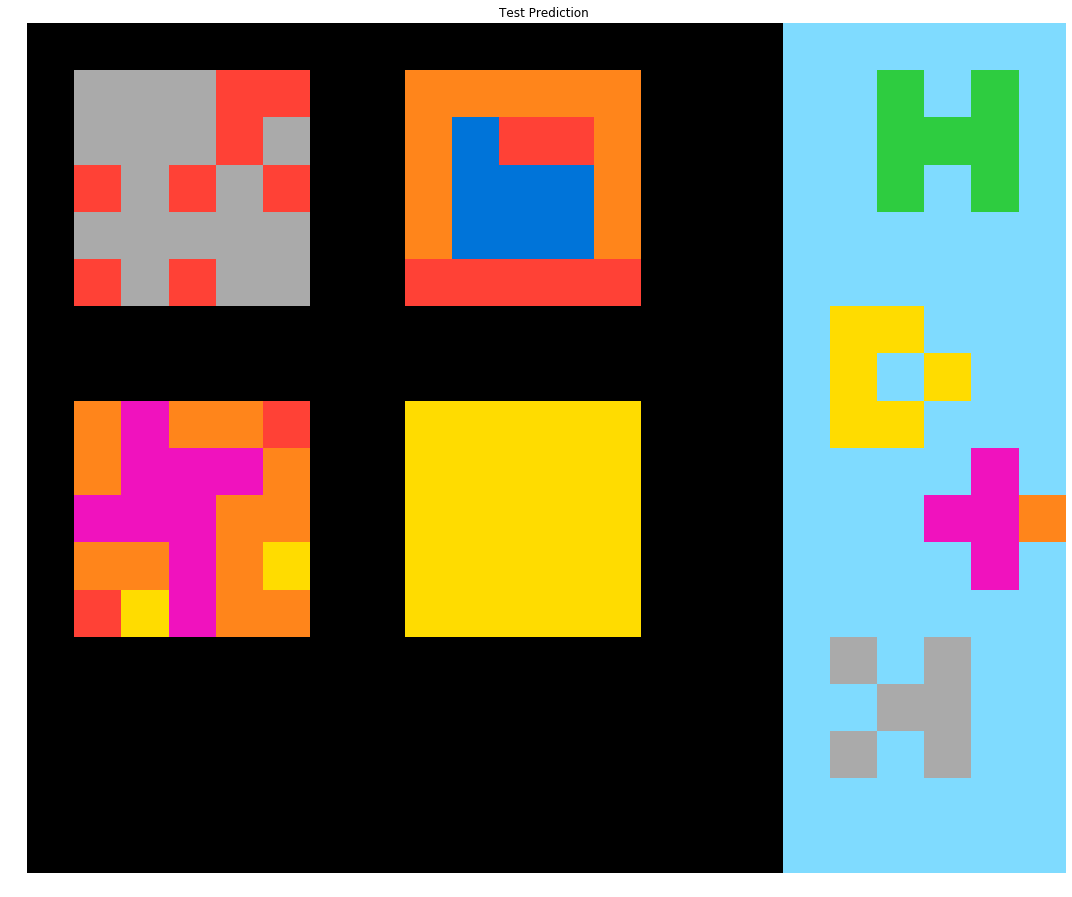

Made predictions for  b457fec5
ensemble accuracy 0.6940418679549114



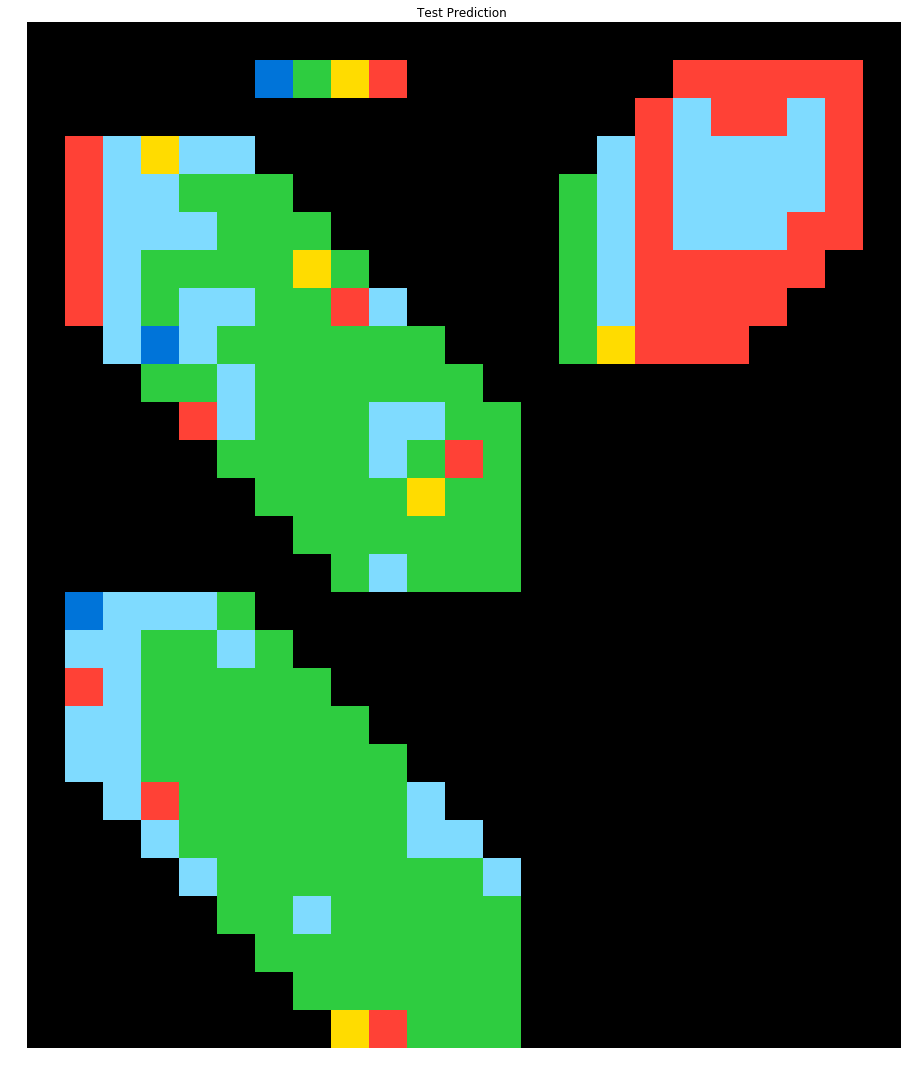

Number of input rows: 13 cols: 6
Number of target rows: 18 cols: 18
ignoring task abstraction-and-reasoning-challenge\evaluation\b4a43f3b.json

Number of input rows: 19 cols: 18
Number of target rows: 5 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\b7999b51.json

Number of input rows: 10 cols: 13
Number of target rows: 3 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\b7cb93ac.json

Made predictions for  b7f8a4d8
ensemble accuracy 0.8855555555555555



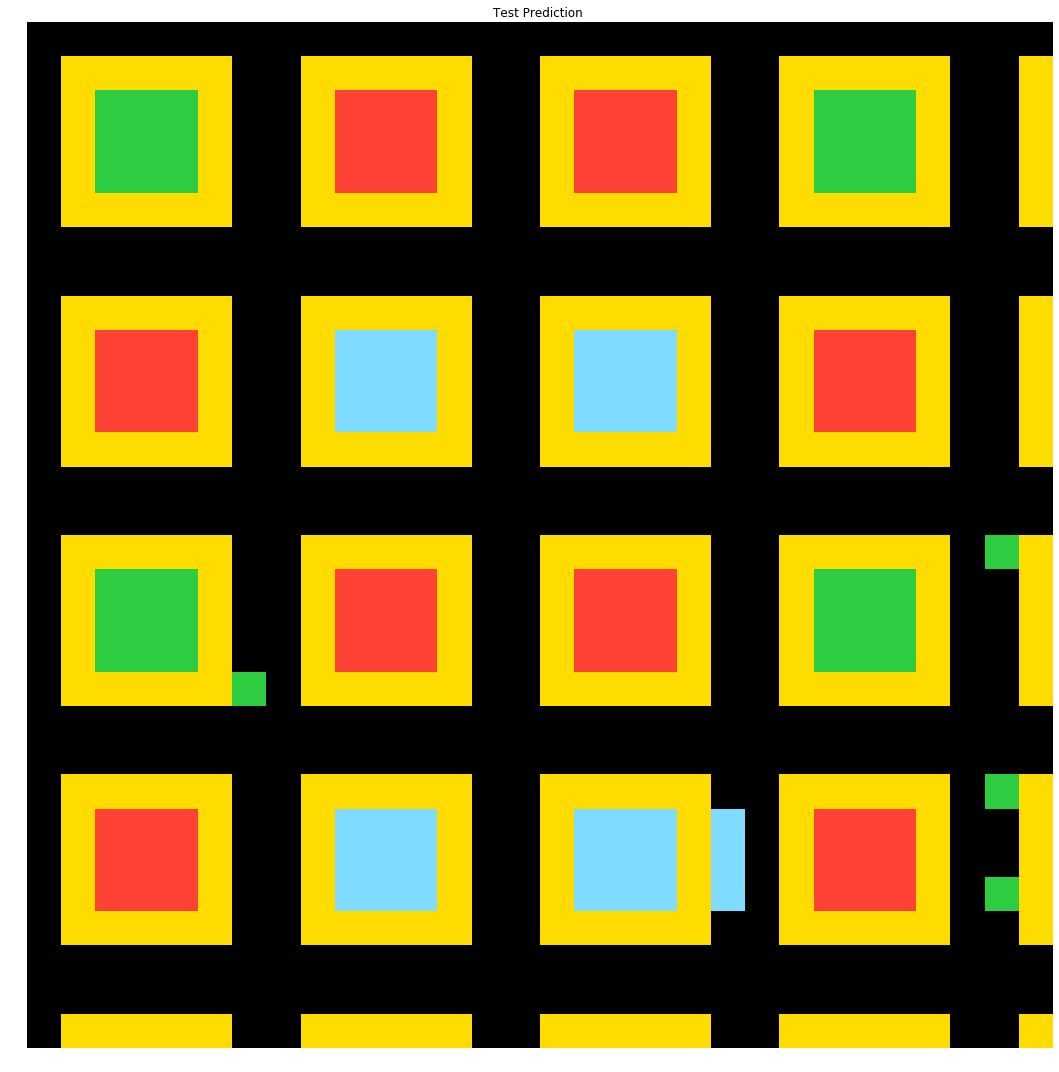

Made predictions for  b7fb29bc
ensemble accuracy 0.8533333333333334



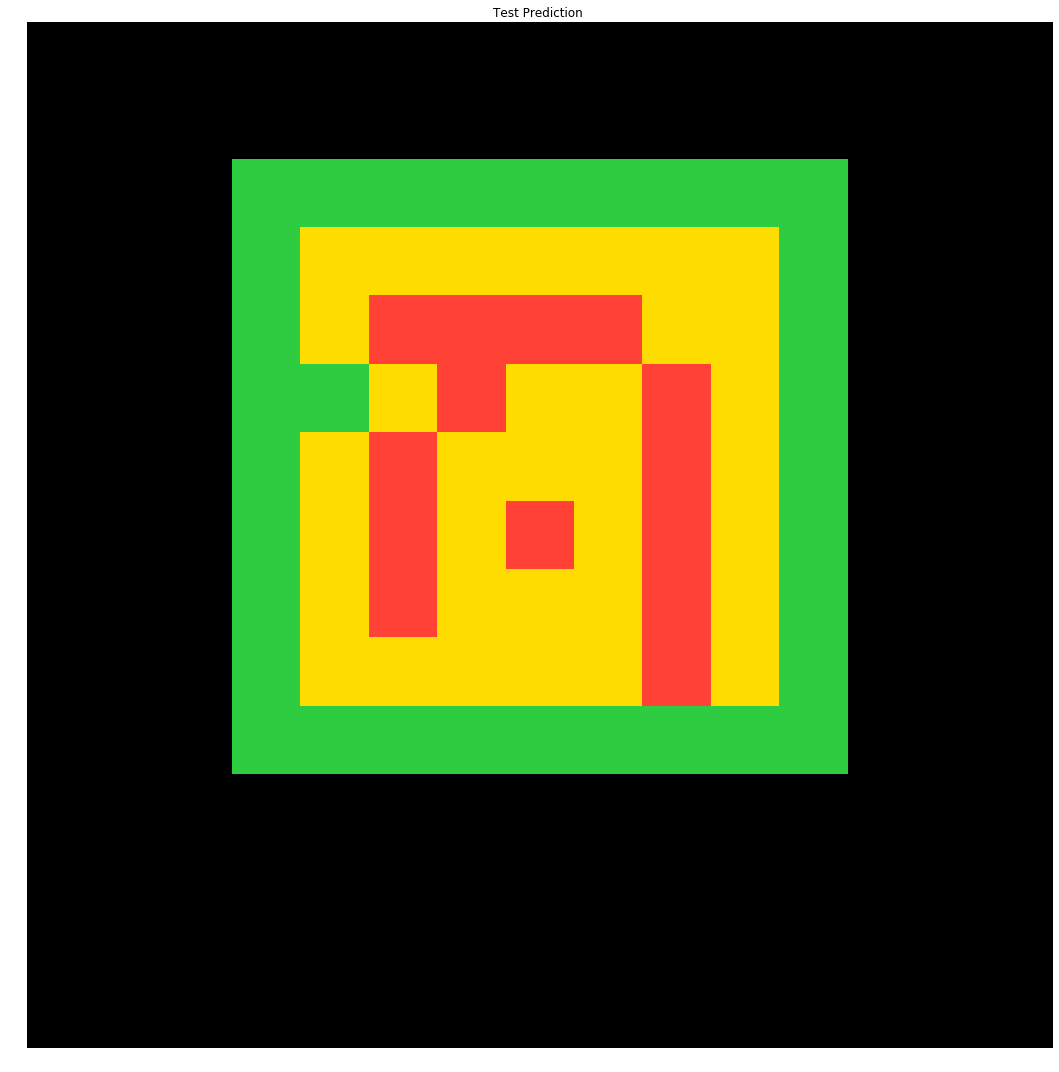

Made predictions for  b942fd60
ensemble accuracy 0.675



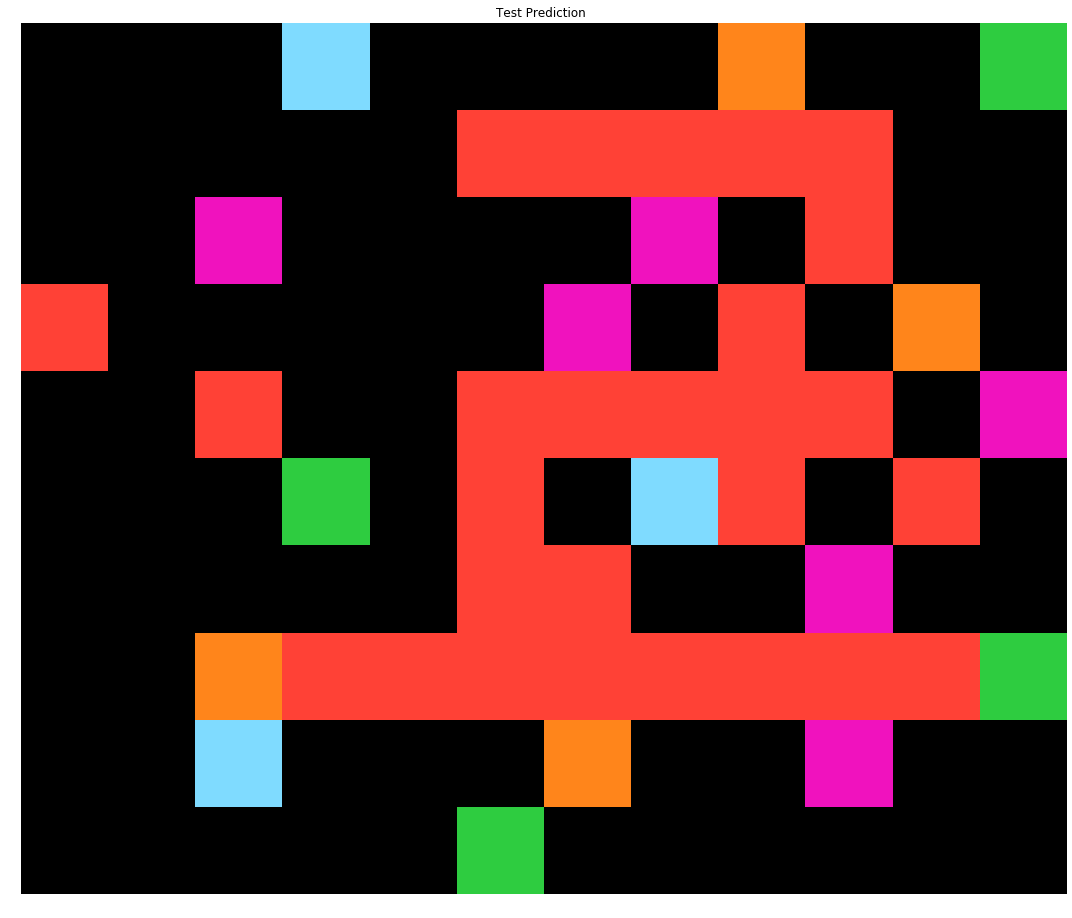

Made predictions for  b9630600
ensemble accuracy 0.9311111111111111



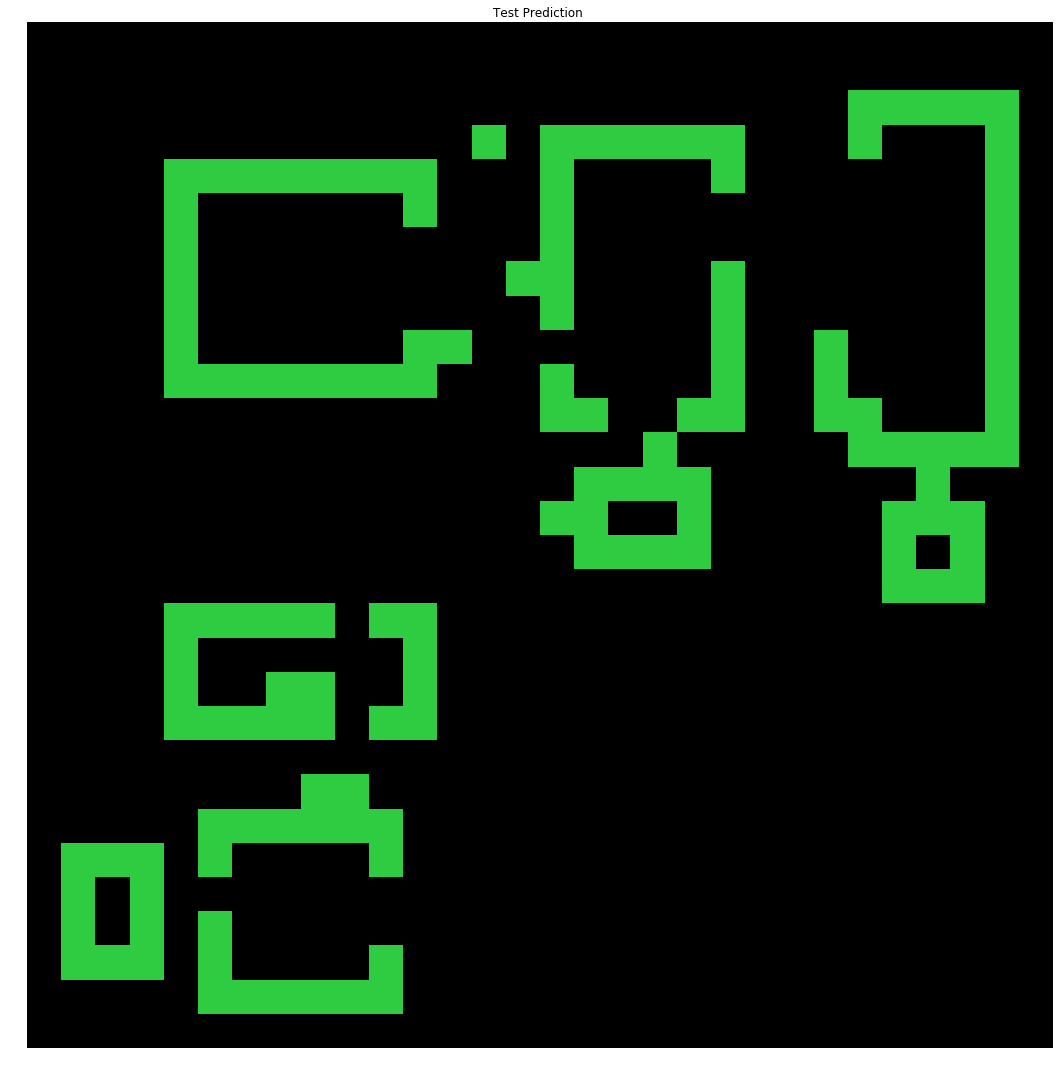

Made predictions for  ba9d41b8
ensemble accuracy 0.5650969529085873



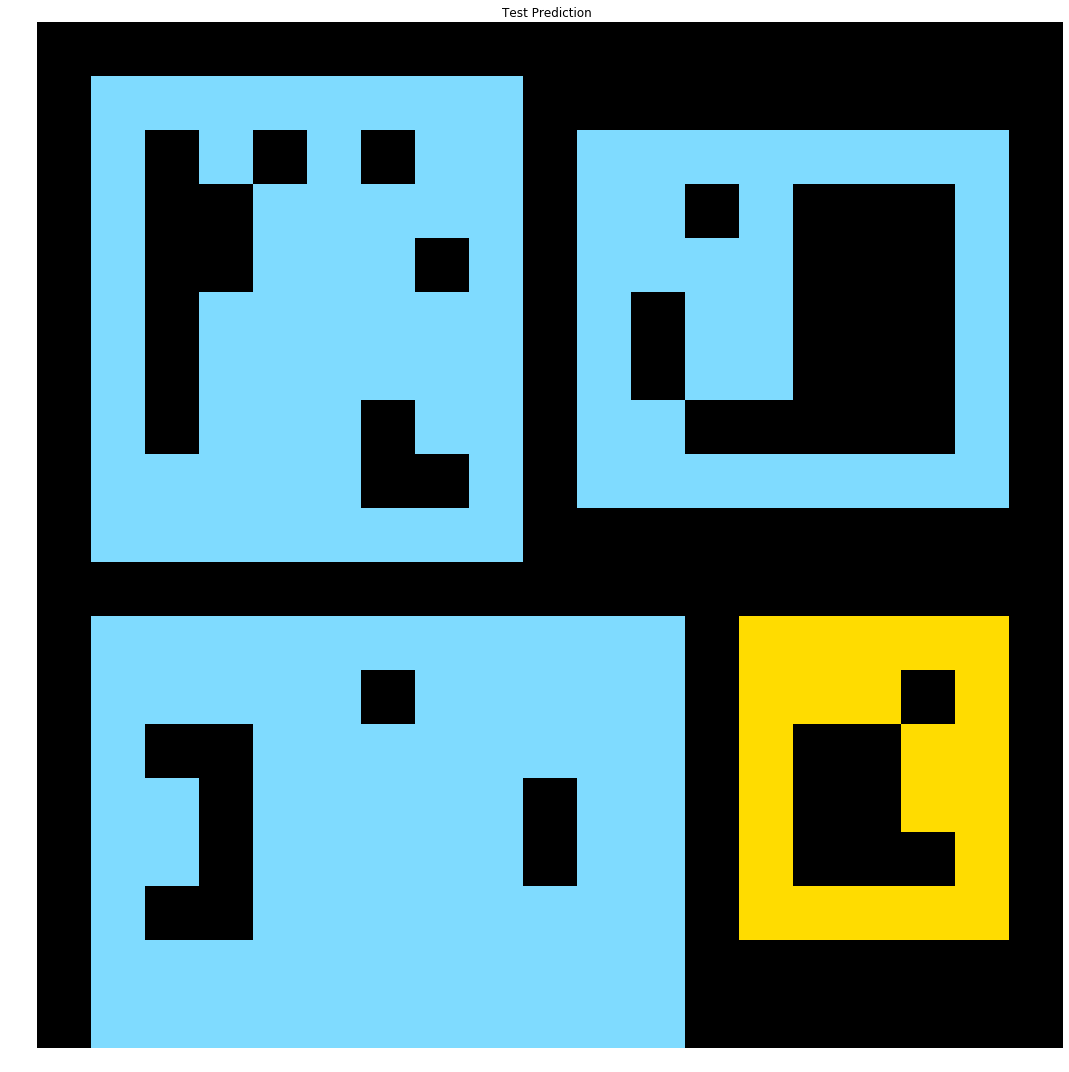

Made predictions for  baf41dbf
ensemble accuracy 0.8235294117647058



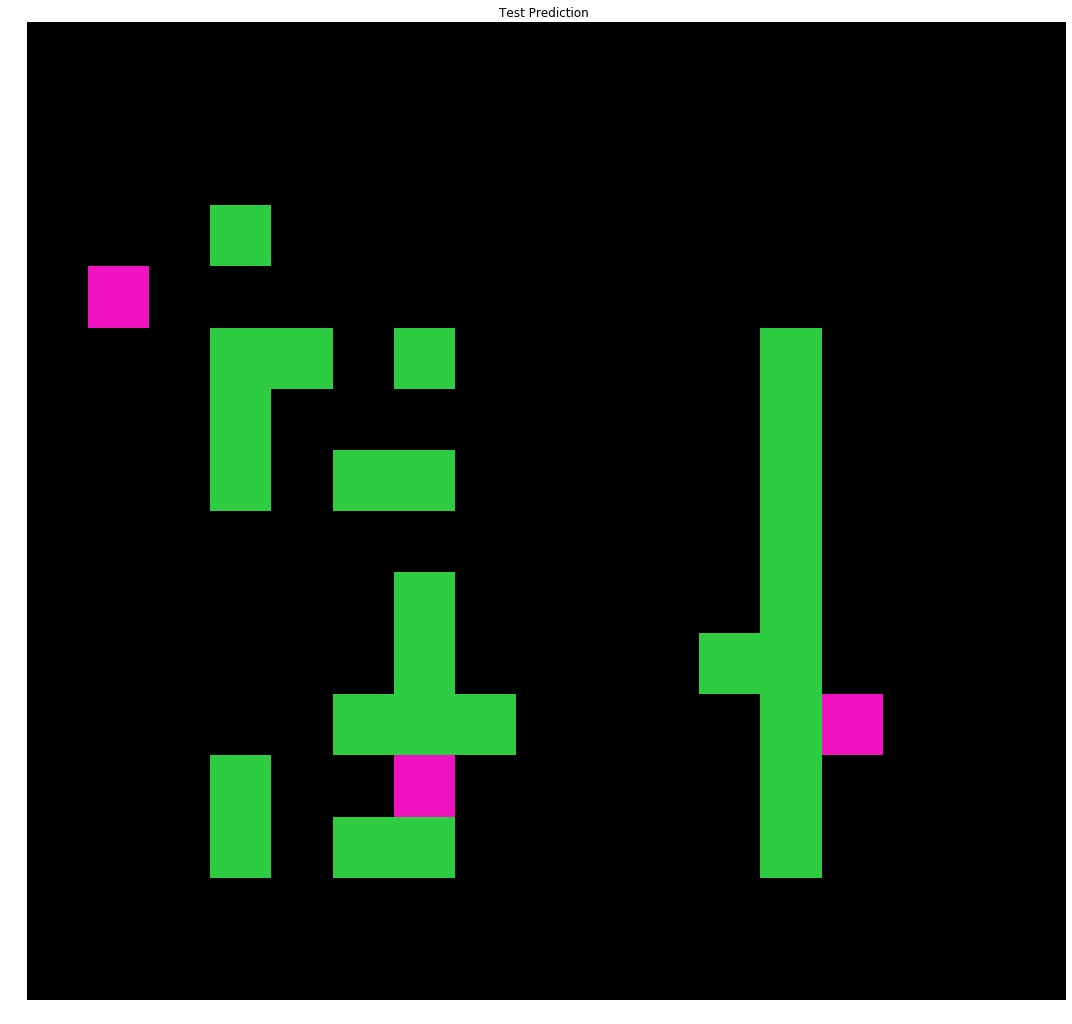

Made predictions for  bb52a14b
ensemble accuracy 0.96900826446281



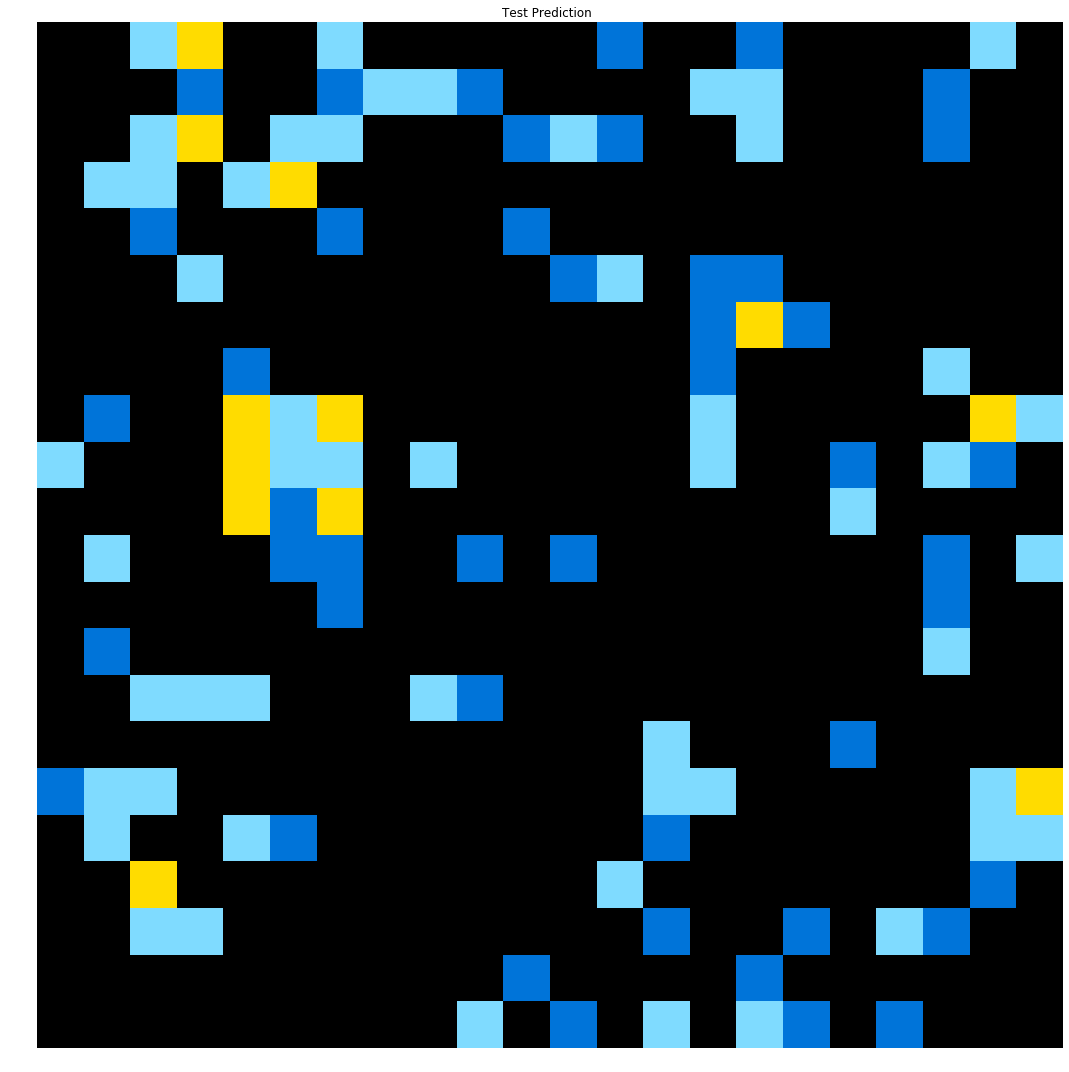

Number of input rows: 4 cols: 9
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\bbb1b8b6.json

Number of input rows: 4 cols: 4
Number of target rows: 4 cols: 20
ignoring task abstraction-and-reasoning-challenge\evaluation\bc4146bd.json

Made predictions for  bcb3040b
ensemble accuracy 0.9351851851851852



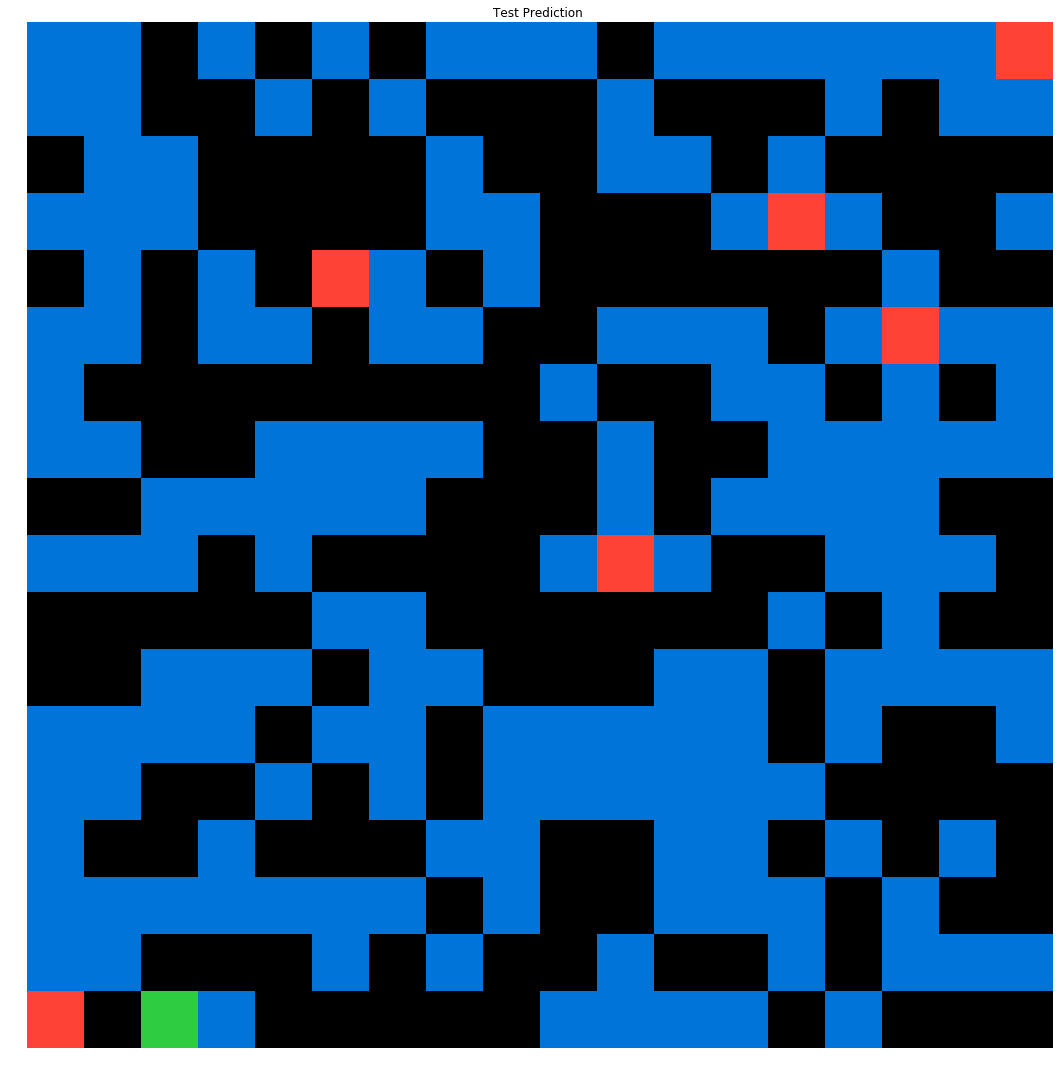

Made predictions for  bd14c3bf
ensemble accuracy 0.8227146814404432



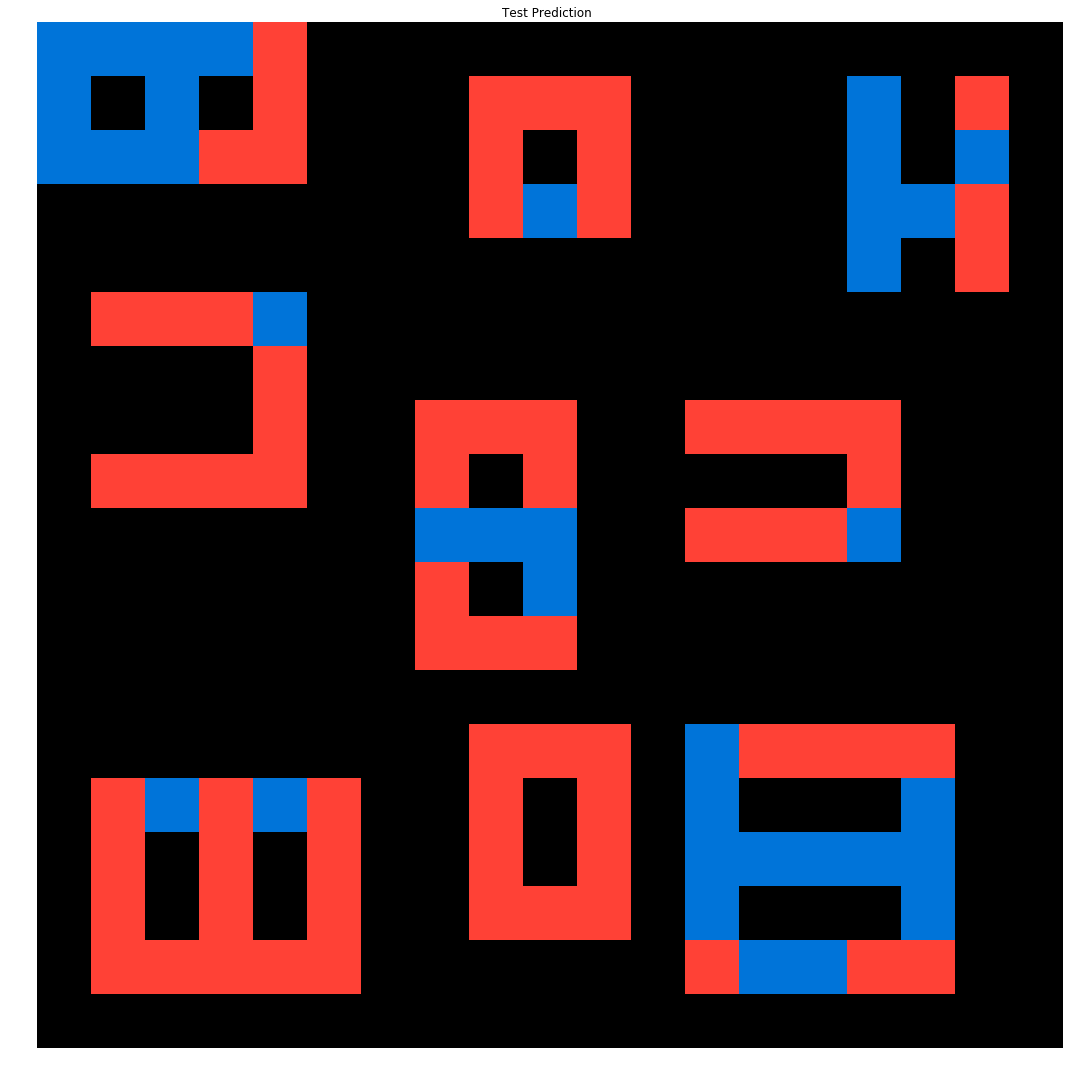

Number of input rows: 5 cols: 5
Number of target rows: 2 cols: 2
ignoring task abstraction-and-reasoning-challenge\evaluation\be03b35f.json

Made predictions for  bf32578f
ensemble accuracy 0.671875



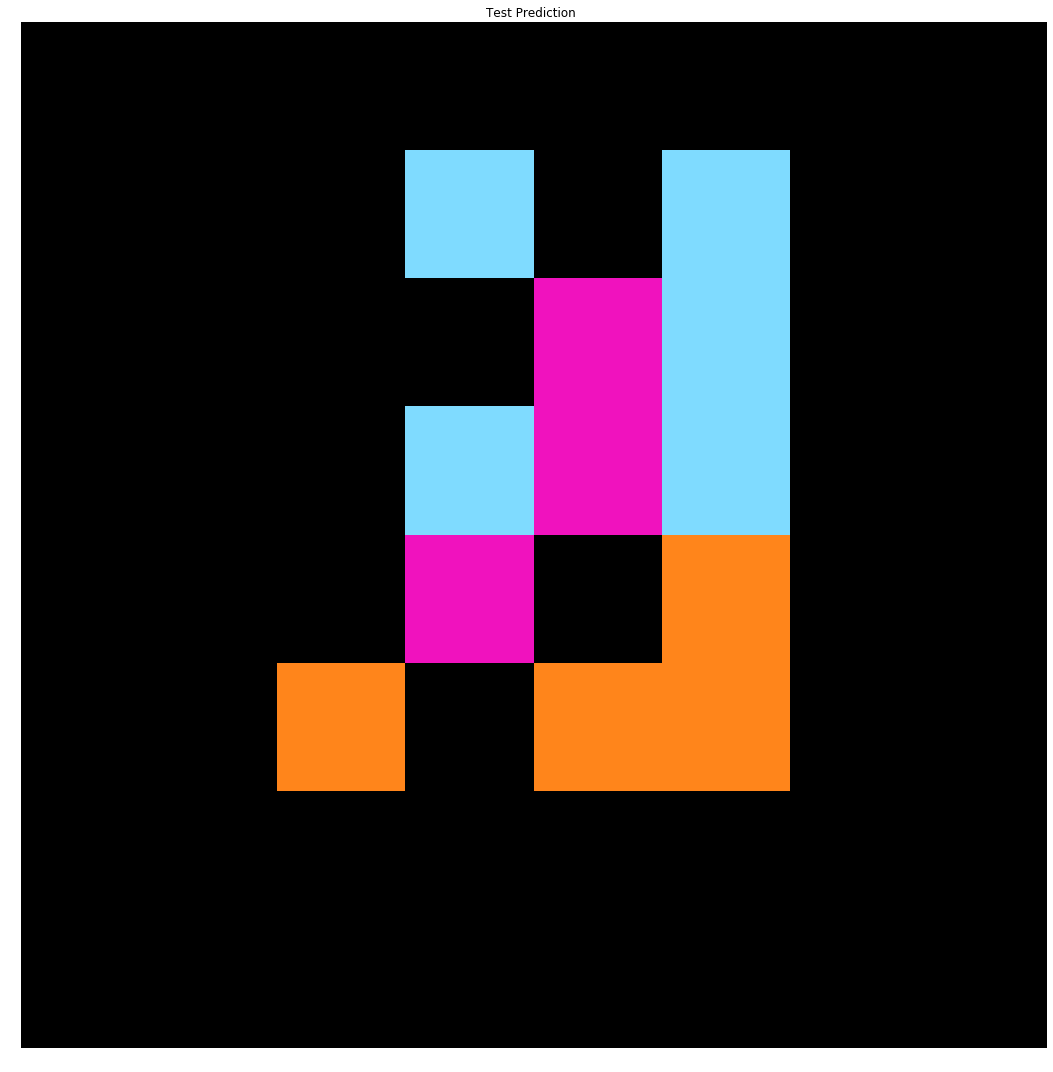

Number of input rows: 17 cols: 16
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\bf699163.json

Made predictions for  bf89d739
ensemble accuracy 0.9369747899159664



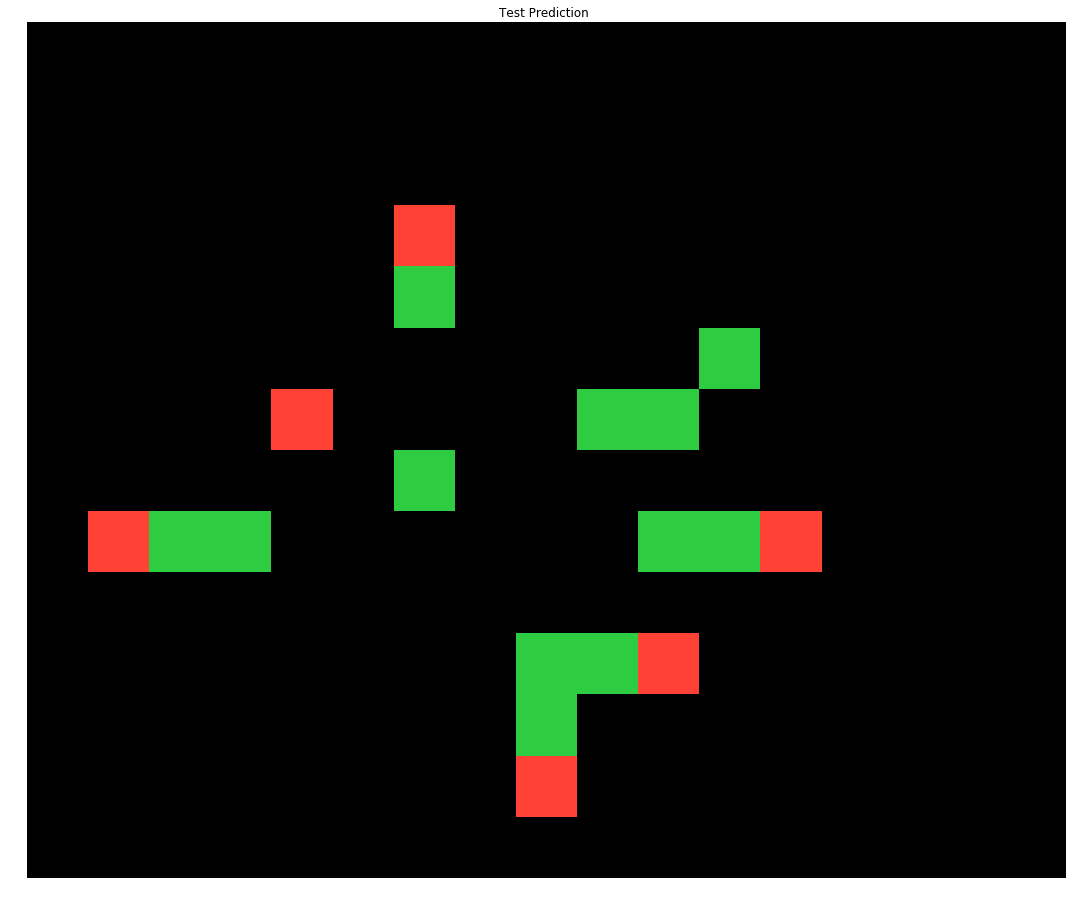

Made predictions for  c074846d
ensemble accuracy 0.9506172839506173



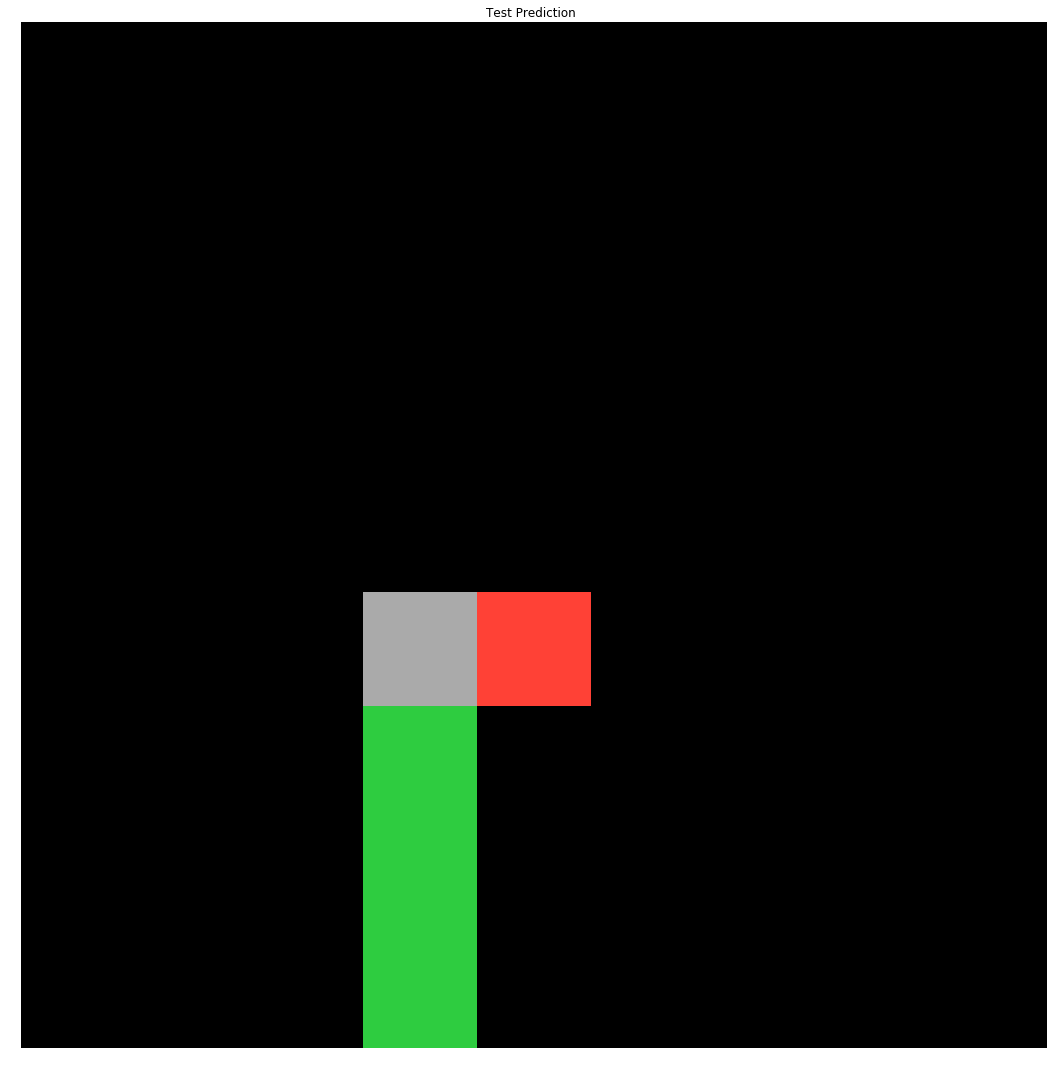

Made predictions for  c074846d
ensemble accuracy 0.9494949494949495



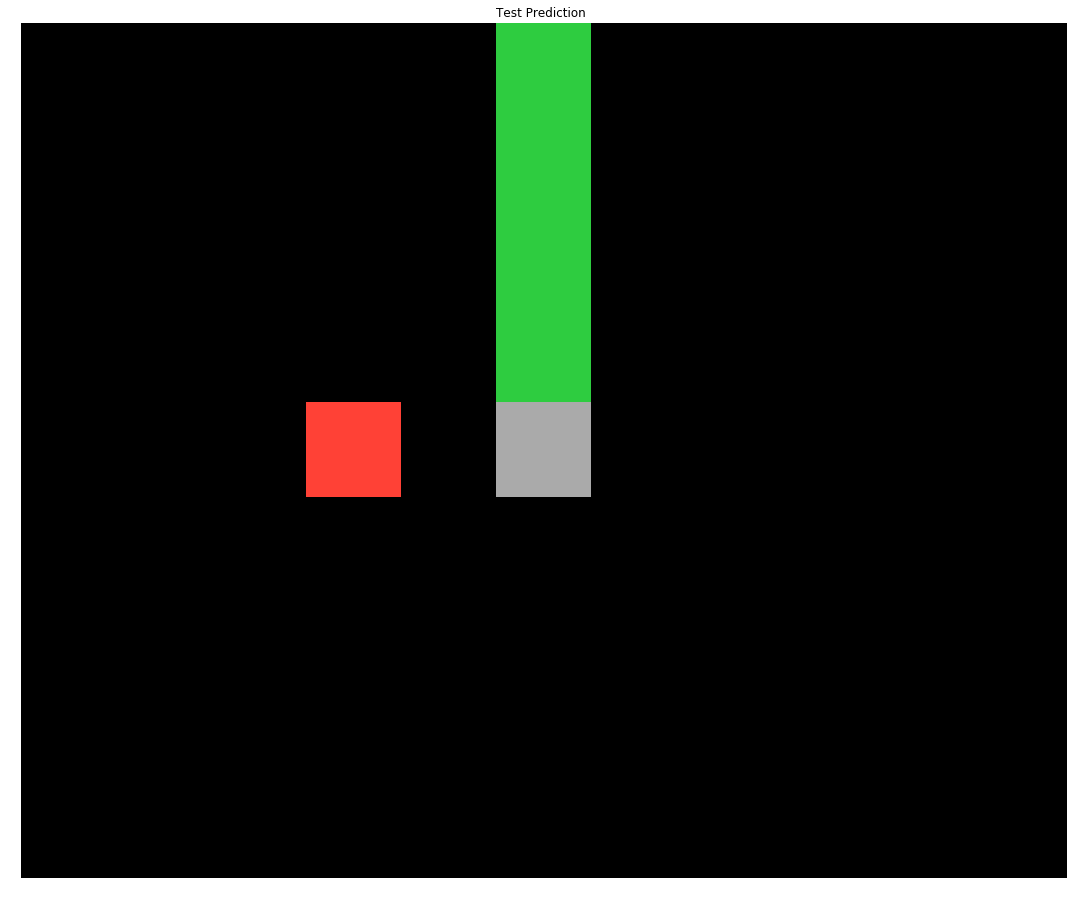

Number of input rows: 1 cols: 13
Number of target rows: 13 cols: 13
ignoring task abstraction-and-reasoning-challenge\evaluation\c1990cce.json

Number of input rows: 23 cols: 23
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\c3202e5a.json

Made predictions for  c35c1b4c
ensemble accuracy 0.71



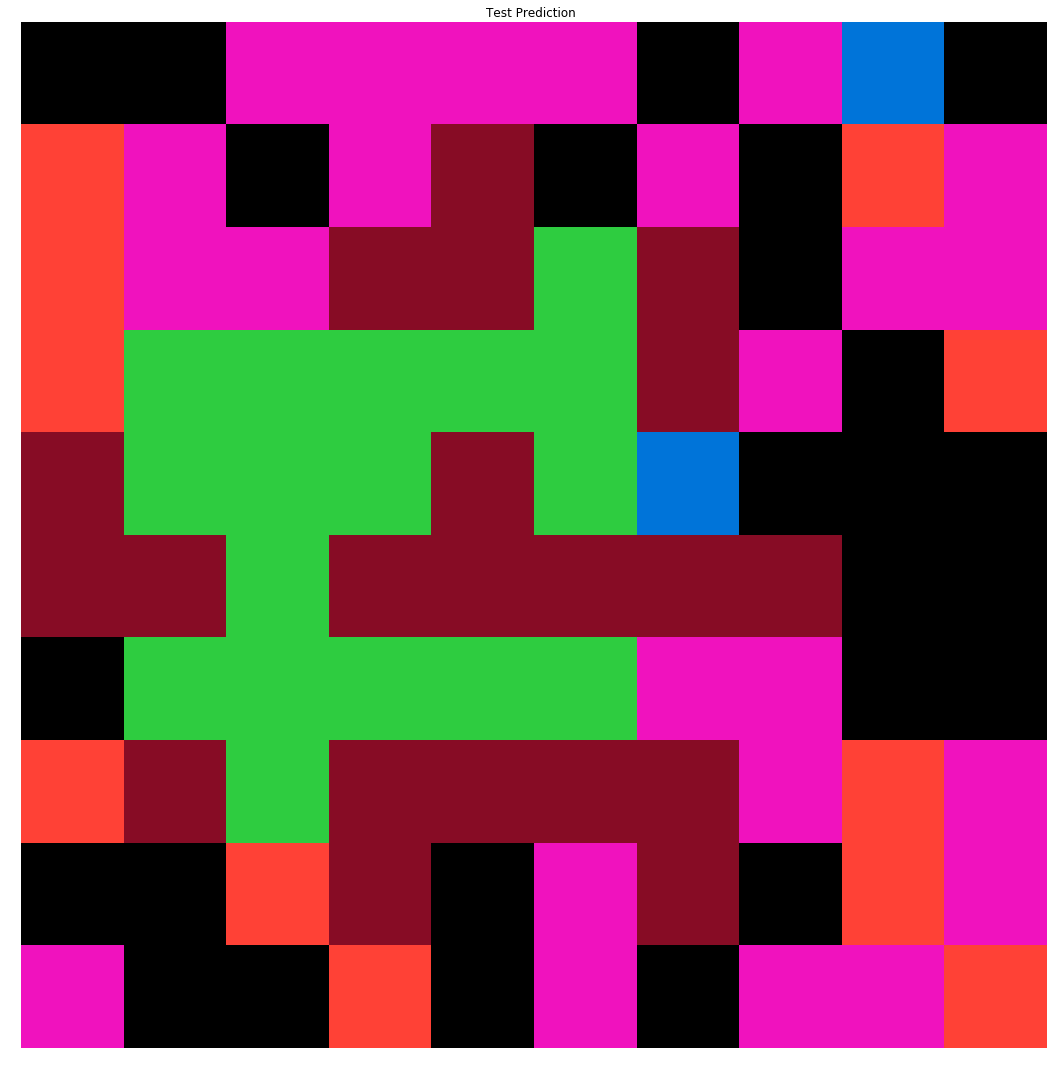

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\c48954c1.json

Made predictions for  c62e2108
ensemble accuracy 0.7100694444444444



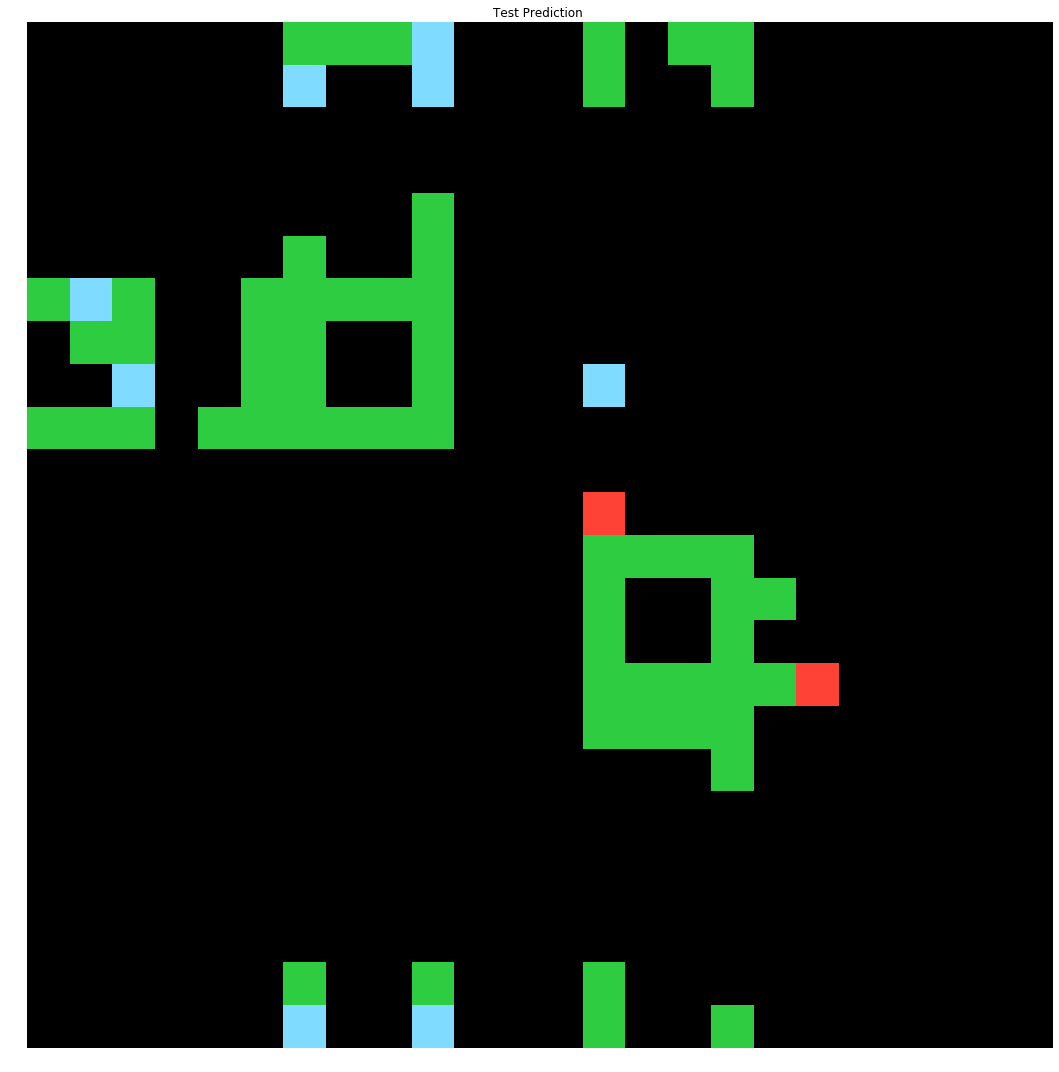

Number of input rows: 18 cols: 20
Number of target rows: 8 cols: 11
ignoring task abstraction-and-reasoning-challenge\evaluation\c64f1187.json

Number of input rows: 13 cols: 13
Number of target rows: 8 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\c658a4bd.json

Made predictions for  c663677b
ensemble accuracy 0.7846364883401921



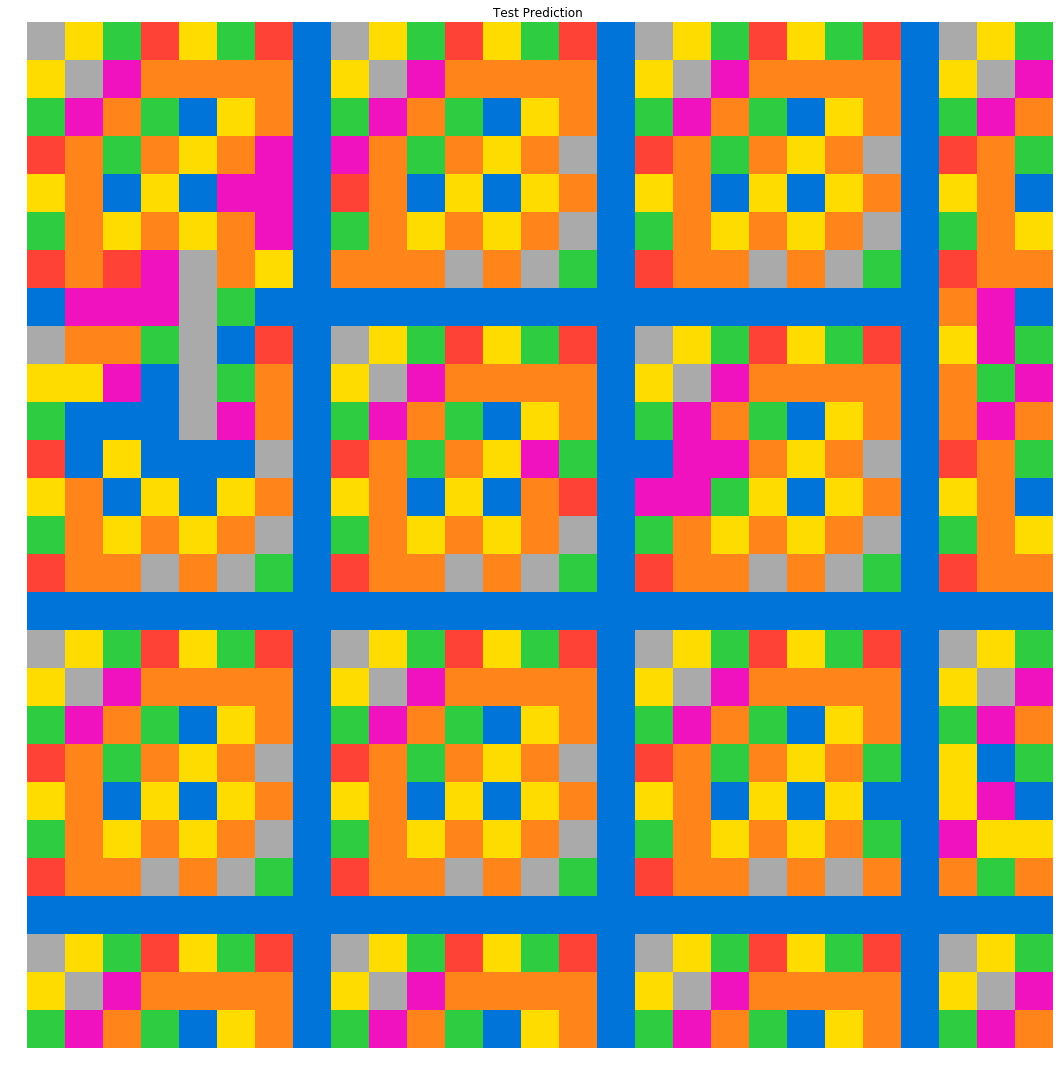

Made predictions for  c6e1b8da
ensemble accuracy 0.8625



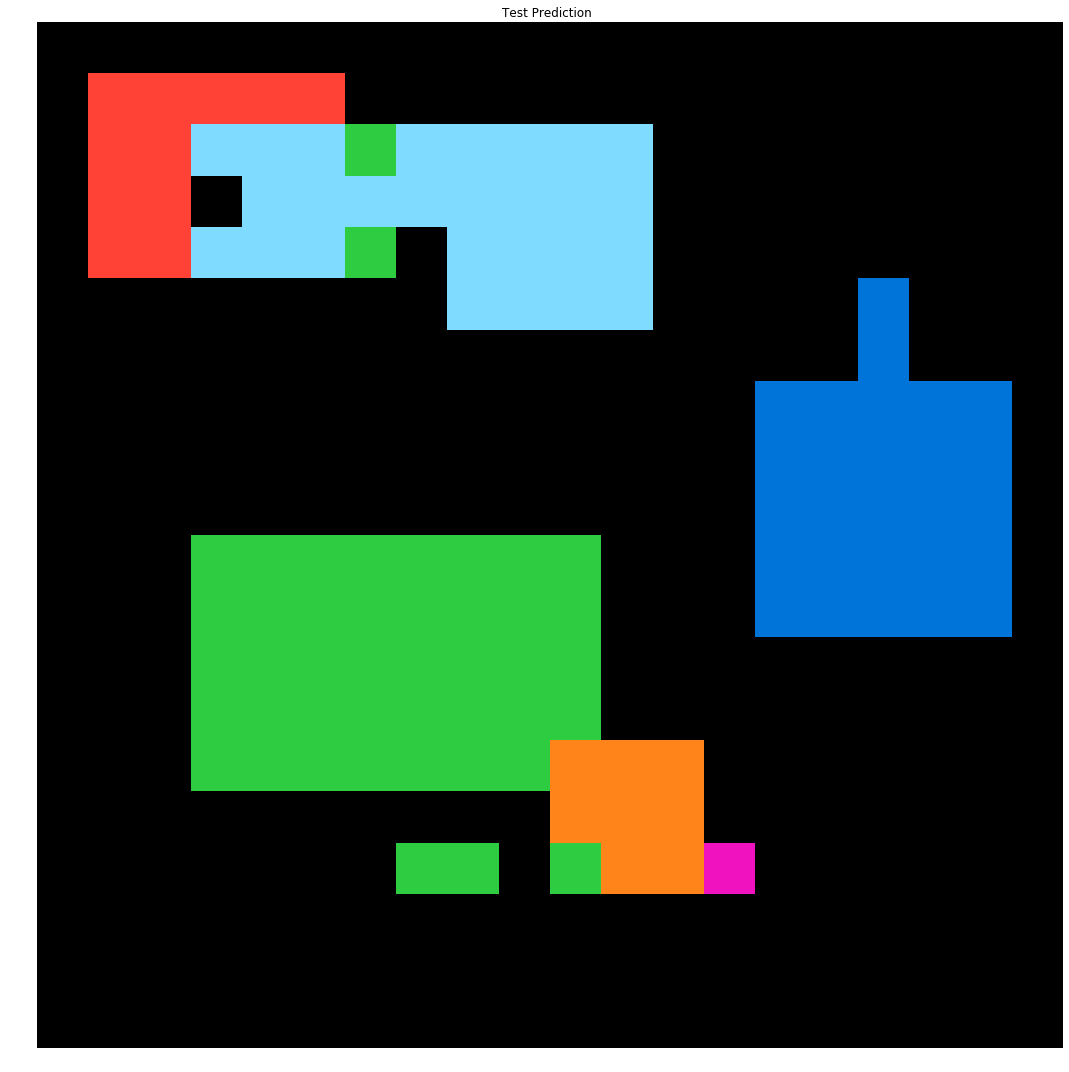

Made predictions for  c7d4e6ad
ensemble accuracy 0.78



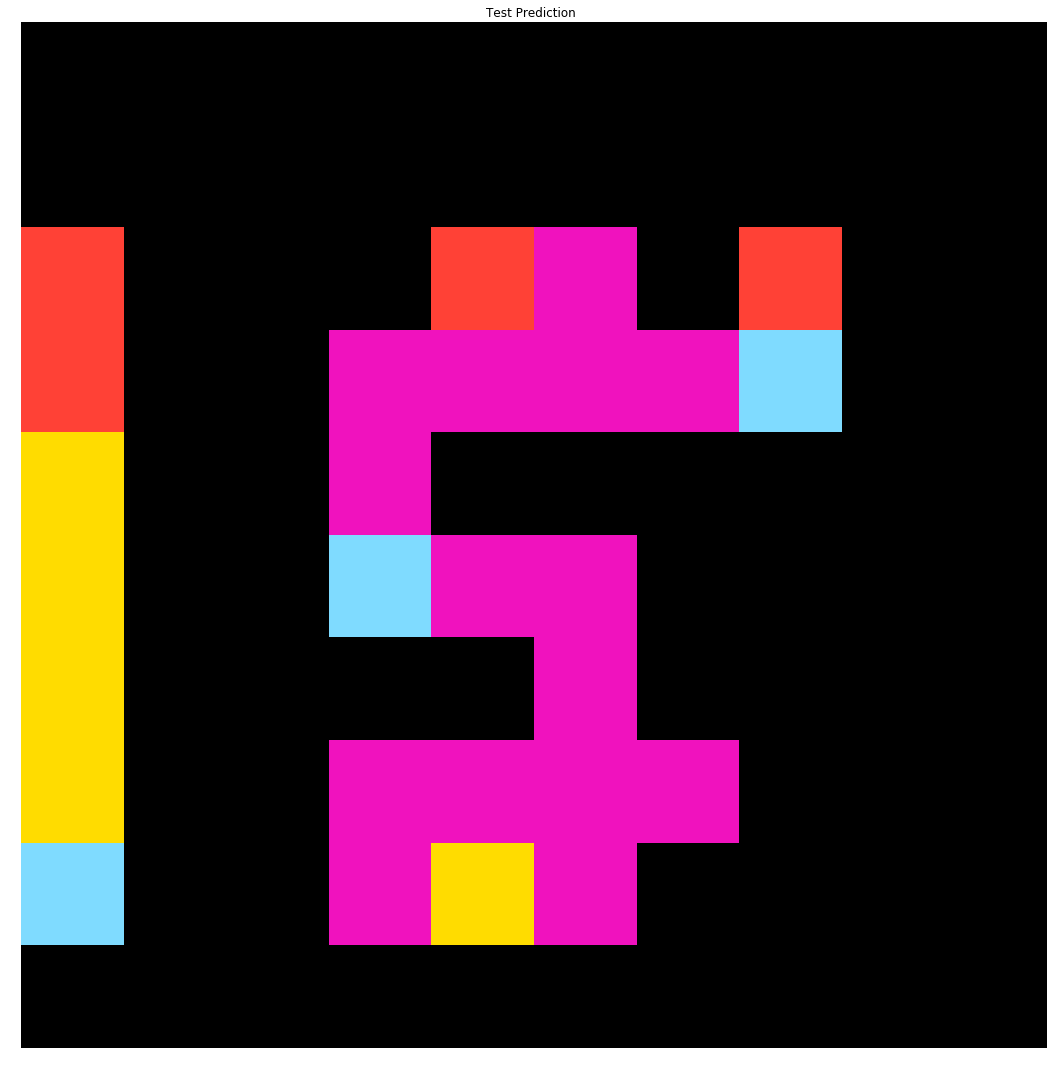

Made predictions for  c87289bb
ensemble accuracy 0.8266666666666667



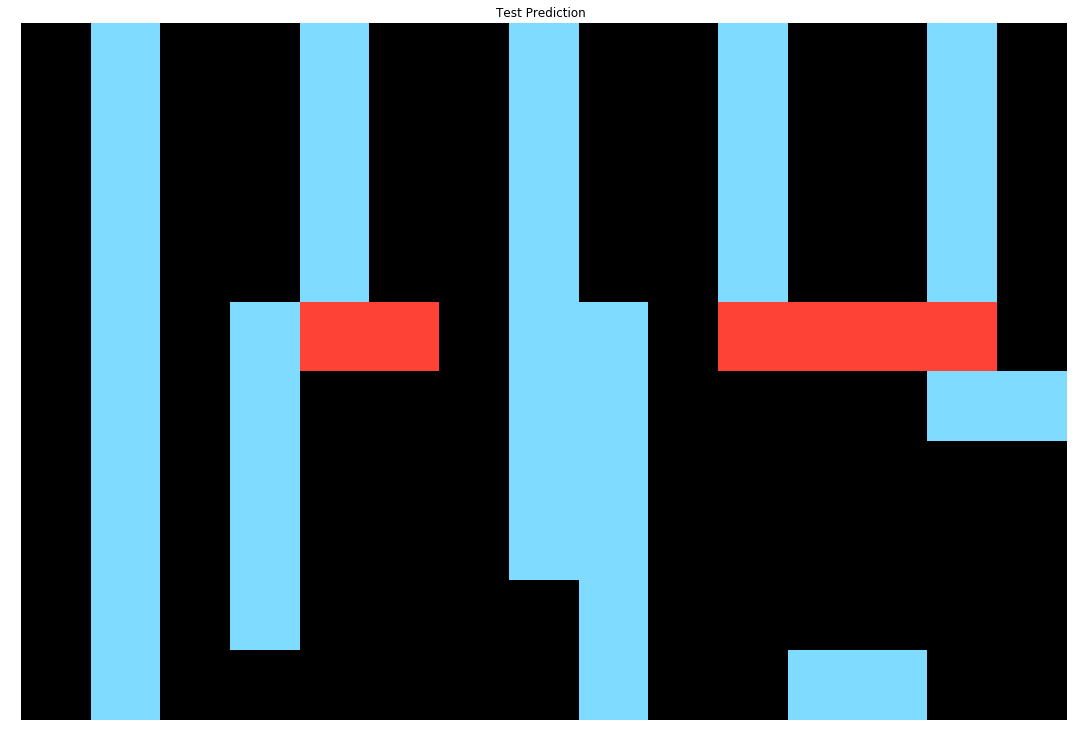

Number of input rows: 7 cols: 7
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\c8b7cc0f.json

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\c92b942c.json

Made predictions for  c97c0139
ensemble accuracy 0.9047619047619048



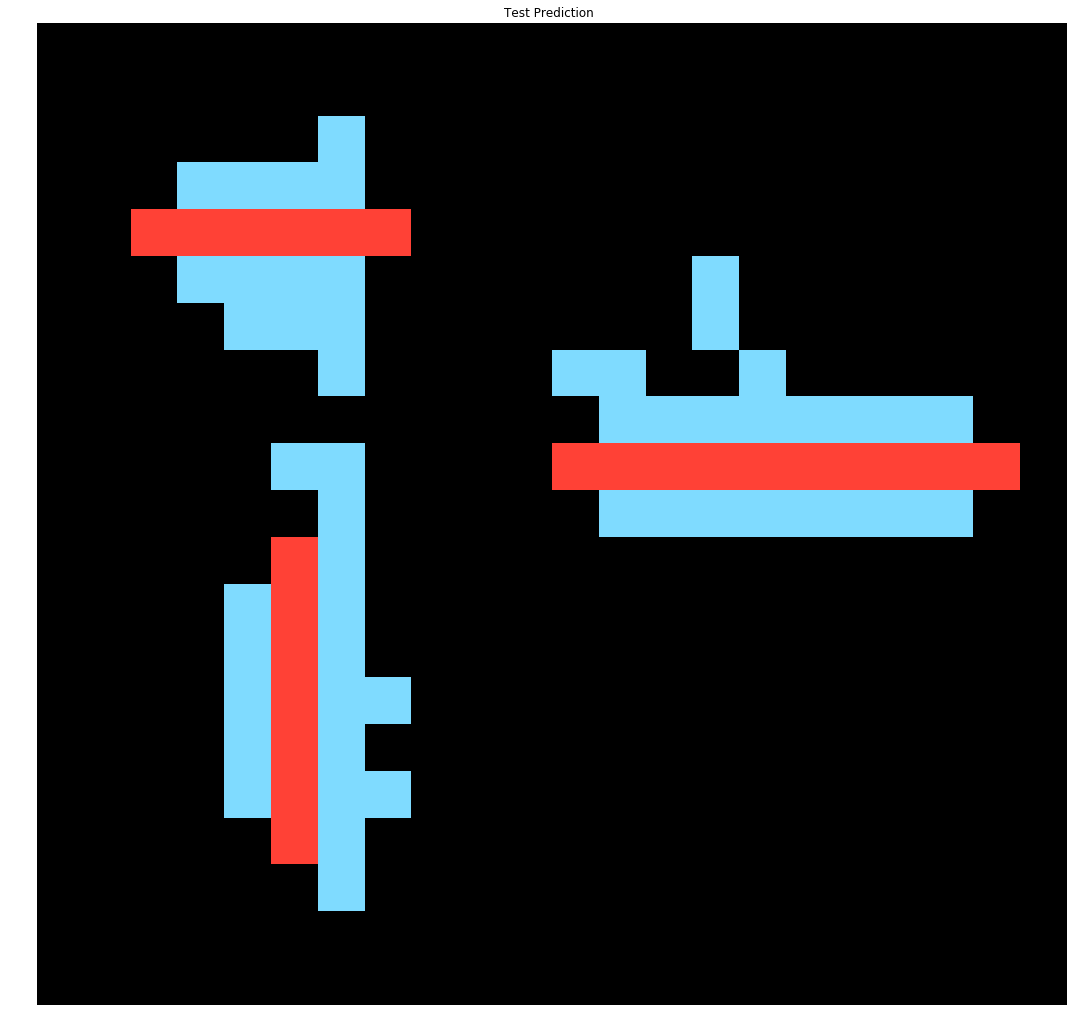

Number of input rows: 5 cols: 5
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\ca8de6ea.json

Made predictions for  ca8f78db
ensemble accuracy 0.9266666666666666



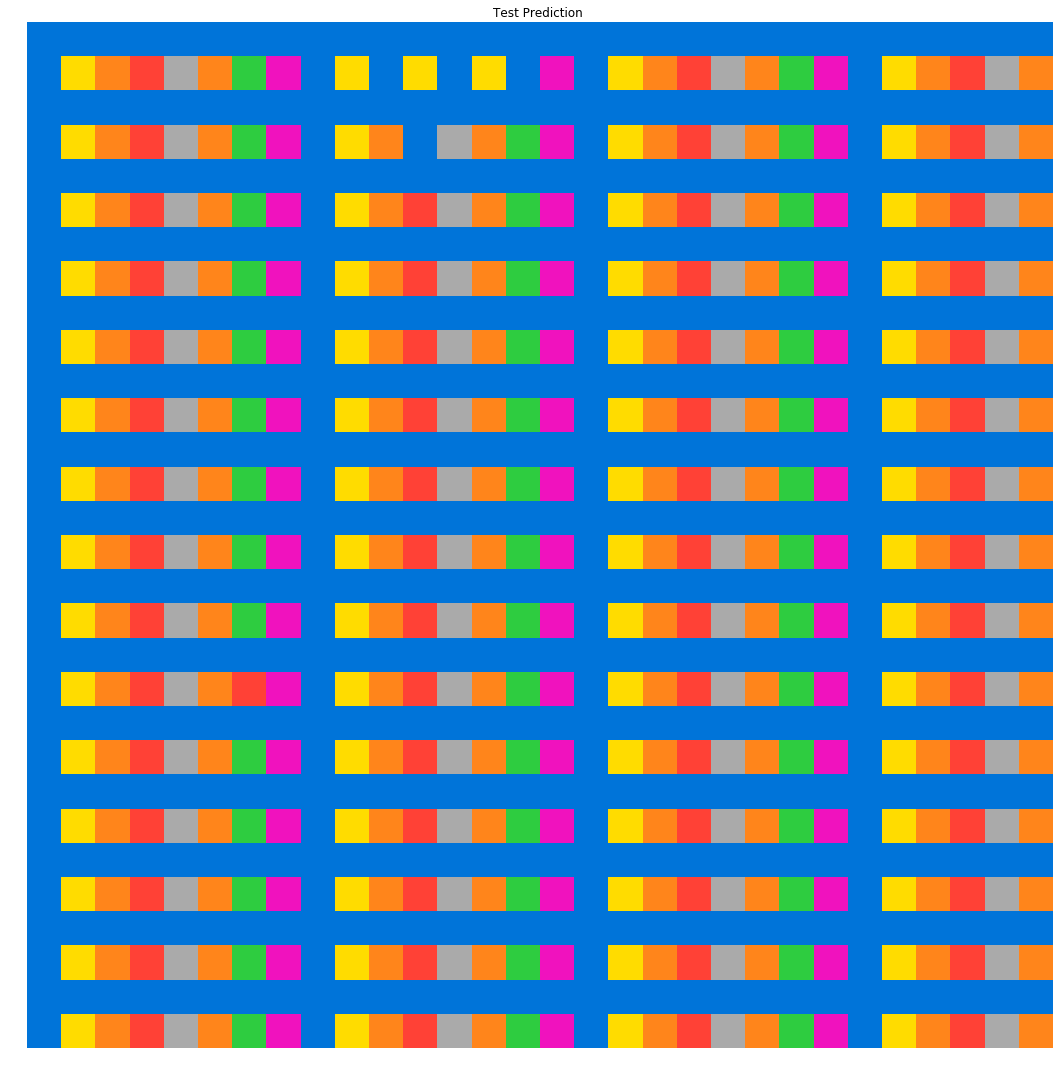

Number of input rows: 6 cols: 6
Number of target rows: 12 cols: 12
ignoring task abstraction-and-reasoning-challenge\evaluation\cad67732.json

Made predictions for  cb227835
ensemble accuracy 0.8736263736263736



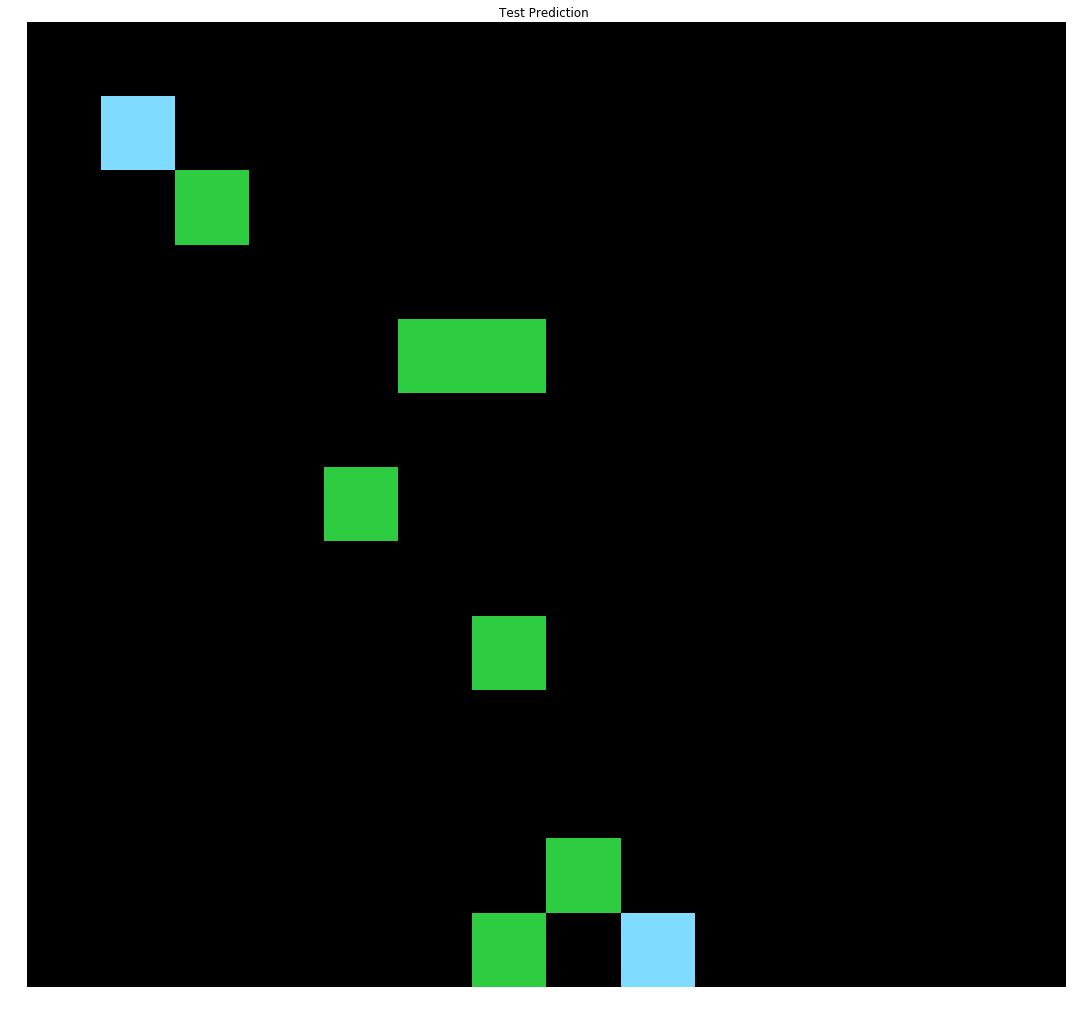

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task abstraction-and-reasoning-challenge\evaluation\ccd554ac.json

Number of input rows: 11 cols: 11
Number of target rows: 4 cols: 1
ignoring task abstraction-and-reasoning-challenge\evaluation\cd3c21df.json

Made predictions for  ce039d91
ensemble accuracy 0.88



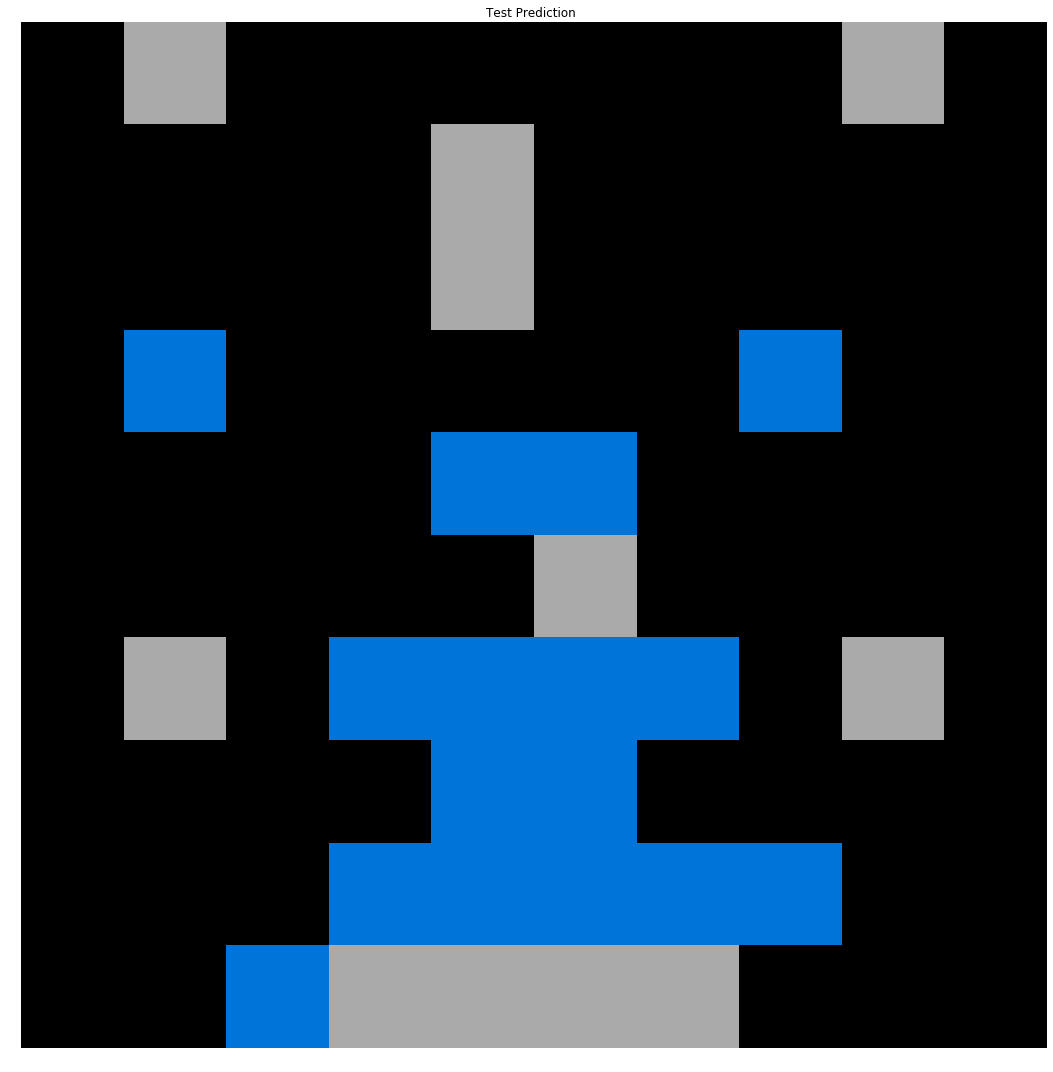

Number of input rows: 10 cols: 11
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\ce8d95cc.json

Made predictions for  cf133acc
ensemble accuracy 0.88



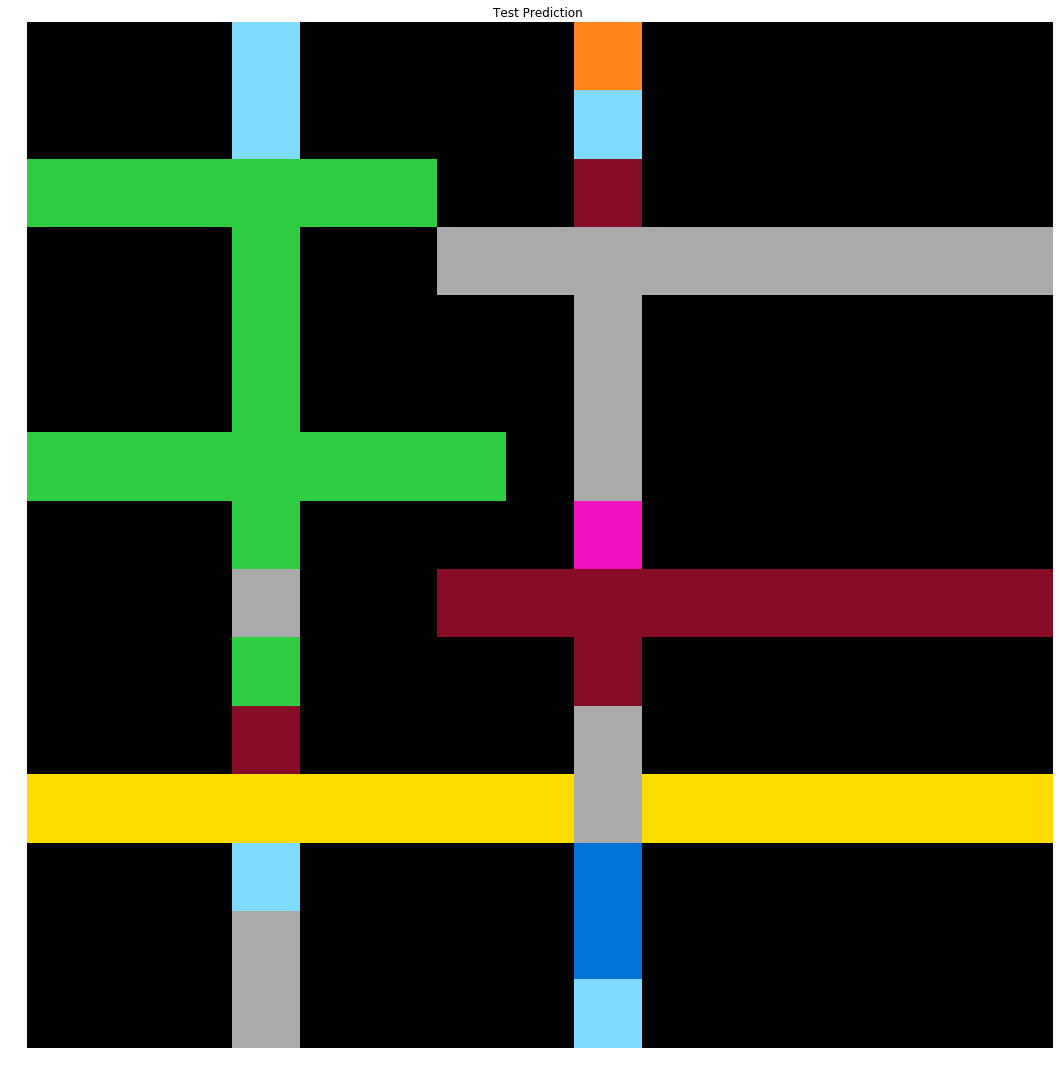

Made predictions for  cfb2ce5a
ensemble accuracy 0.6



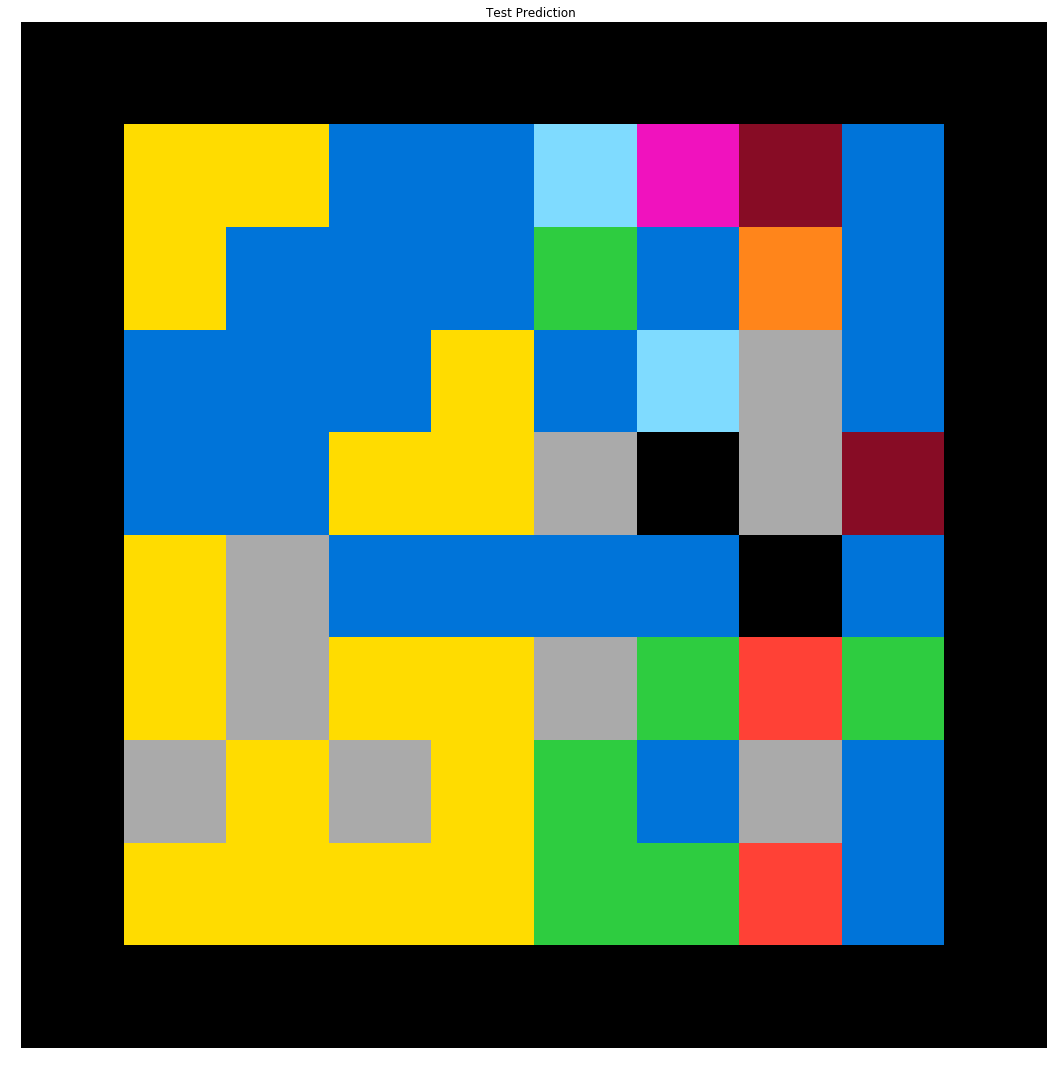

Number of input rows: 3 cols: 9
Number of target rows: 3 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\d017b73f.json

Number of input rows: 12 cols: 4
Number of target rows: 6 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\d19f7514.json

Made predictions for  d282b262
ensemble accuracy 0.7511111111111111



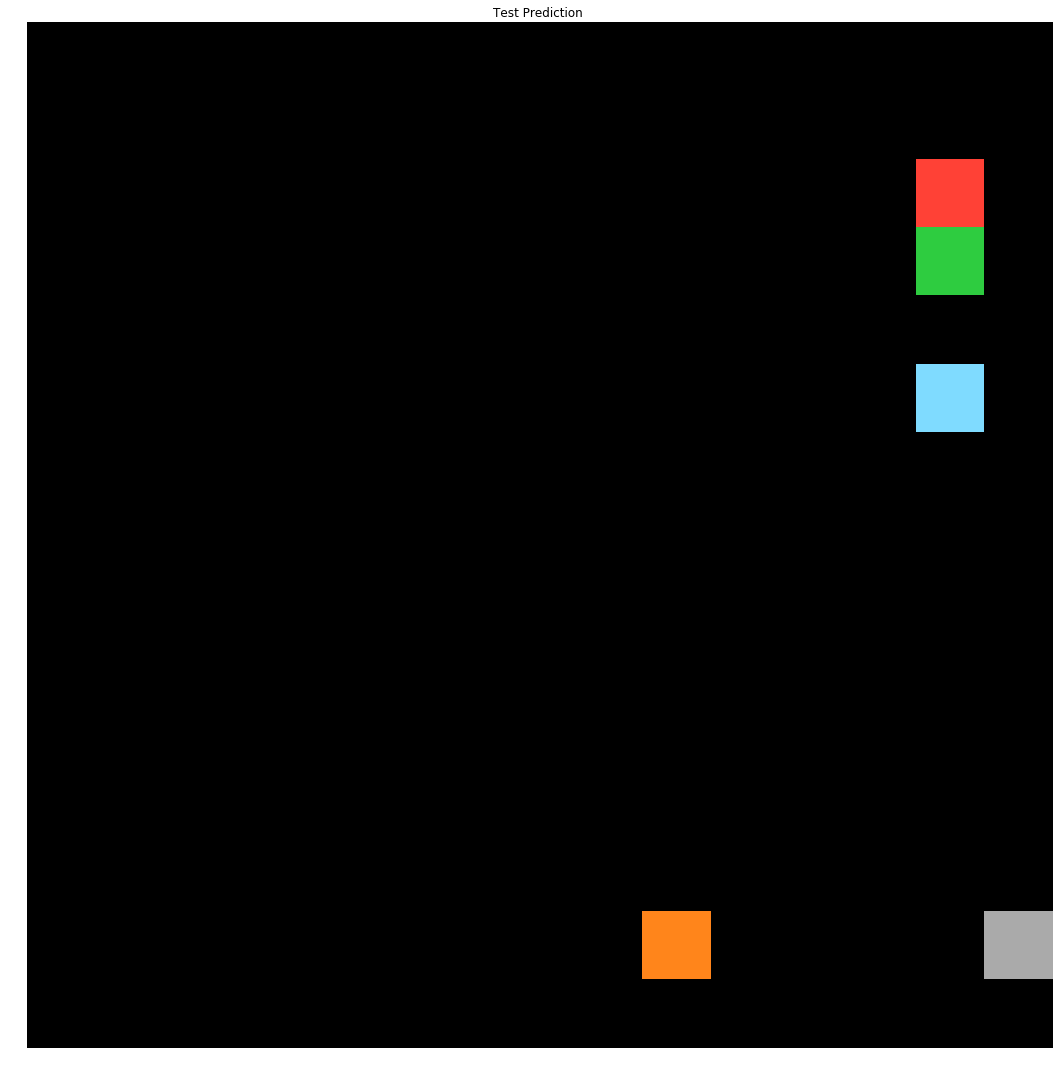

Made predictions for  d2acf2cb
ensemble accuracy 0.9111111111111111



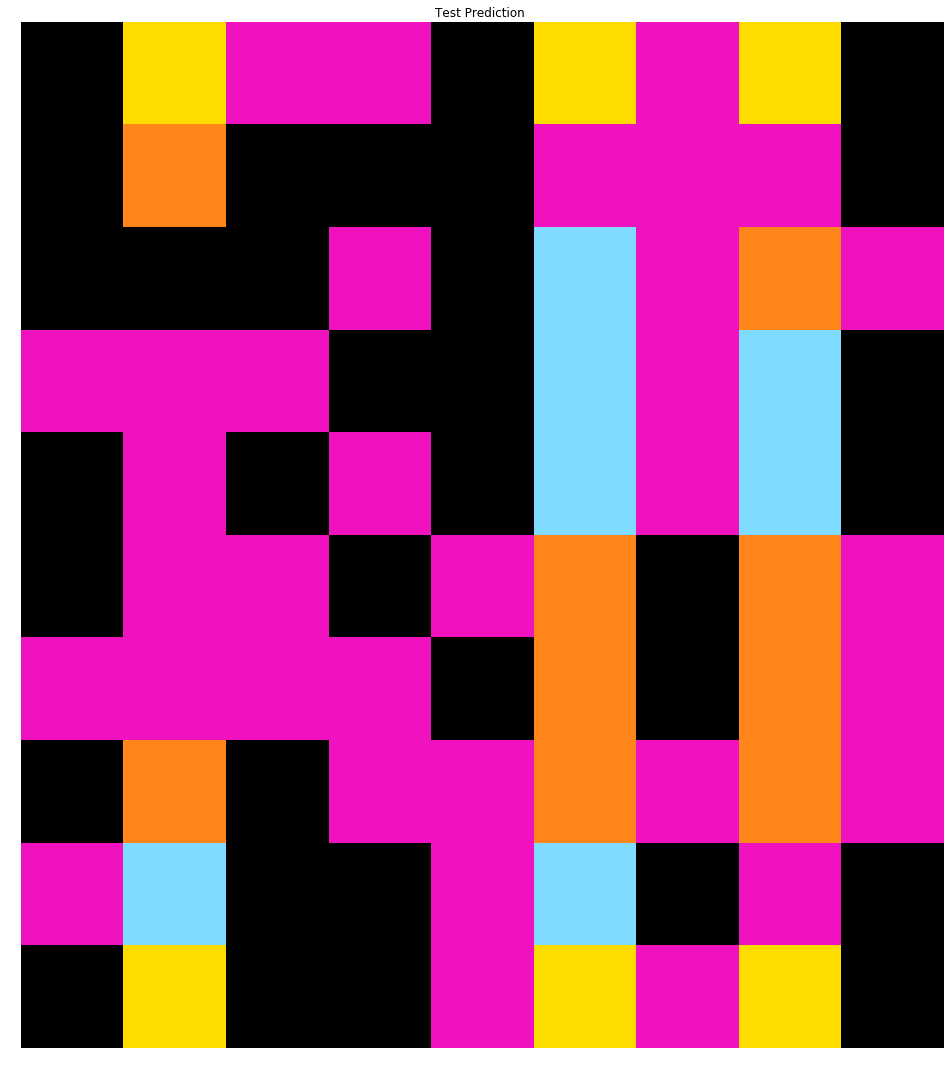

Made predictions for  d304284e
ensemble accuracy 0.8788819875776398



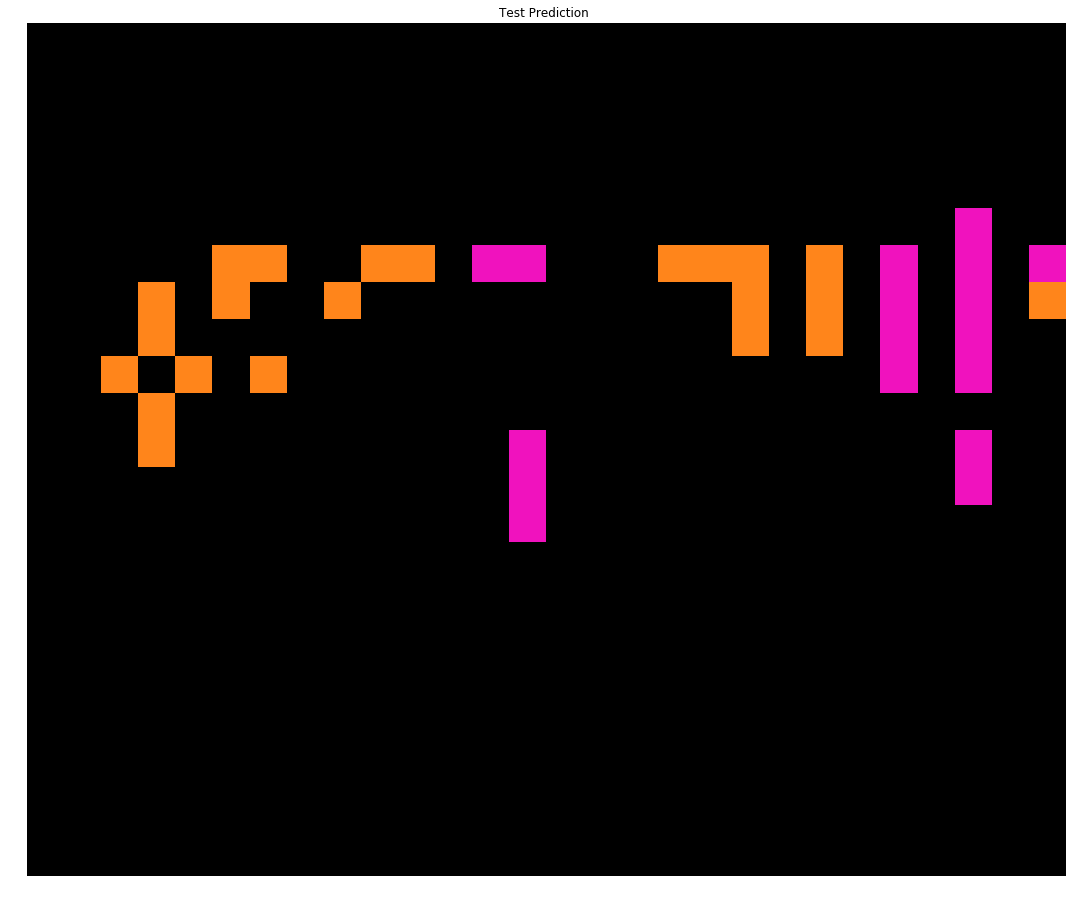

Made predictions for  d37a1ef5
ensemble accuracy 0.967948717948718



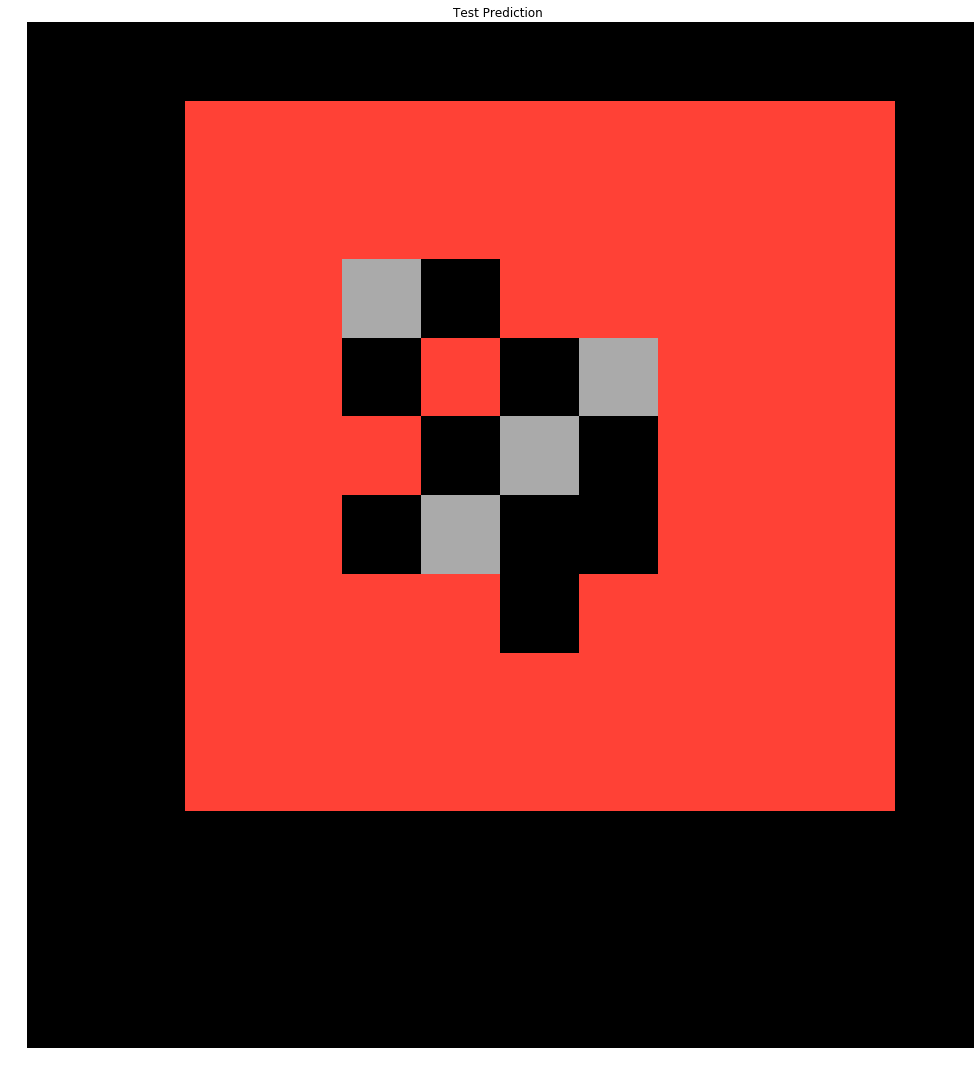

Number of input rows: 10 cols: 21
Number of target rows: 10 cols: 10
ignoring task abstraction-and-reasoning-challenge\evaluation\d47aa2ff.json

Made predictions for  d492a647
ensemble accuracy 0.7647058823529411



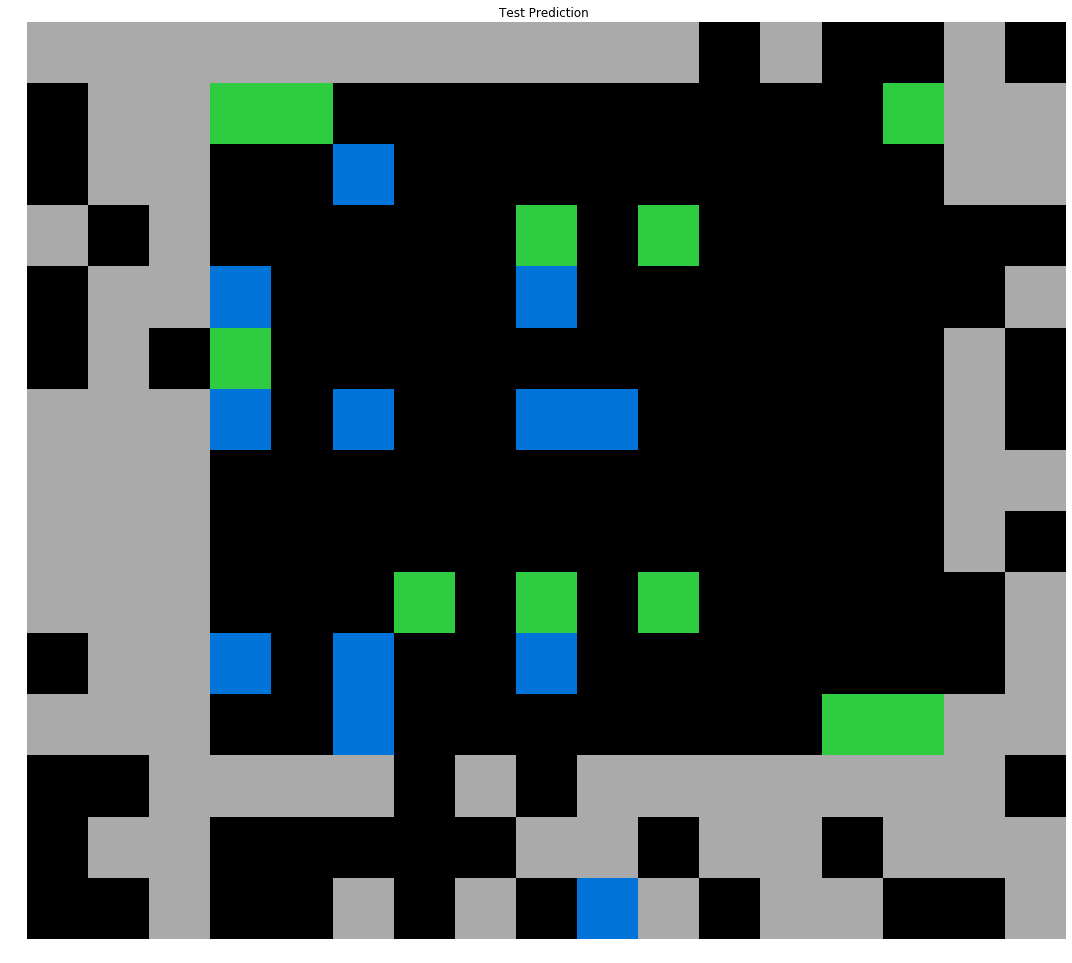

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\d4b1c2b1.json

Number of input rows: 25 cols: 25
Number of target rows: 3 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\d4c90558.json

Number of input rows: 21 cols: 16
Number of target rows: 4 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\d56f2372.json

Number of input rows: 15 cols: 15
Number of target rows: 3 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\d5c634a2.json

Made predictions for  d931c21c
ensemble accuracy 0.84



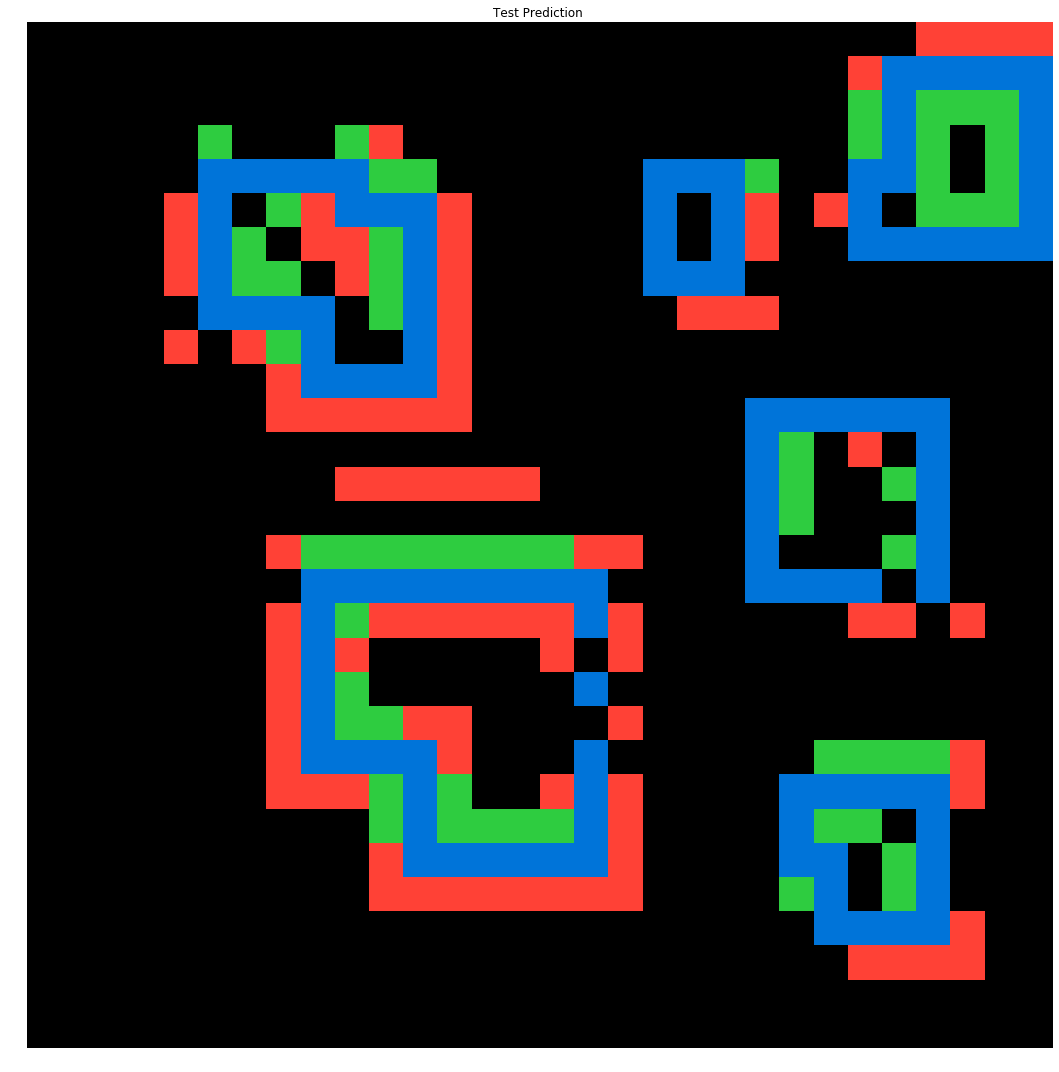

Made predictions for  d94c3b52
ensemble accuracy 0.8211764705882353



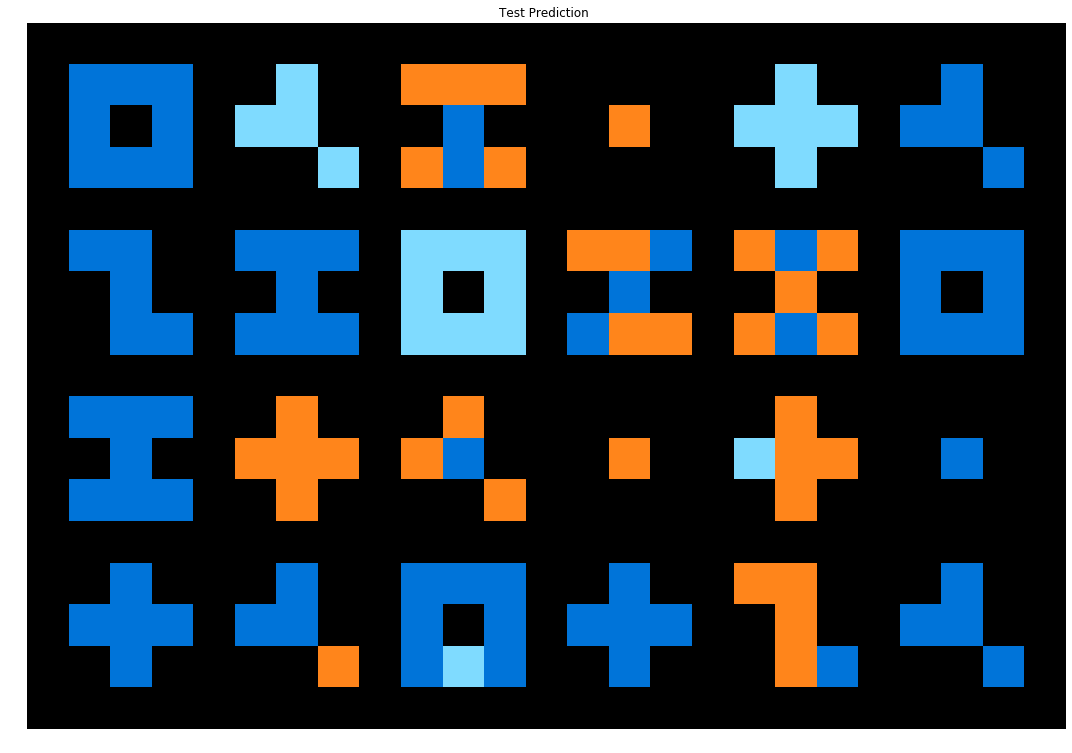

Made predictions for  da2b0fe3
ensemble accuracy 0.93



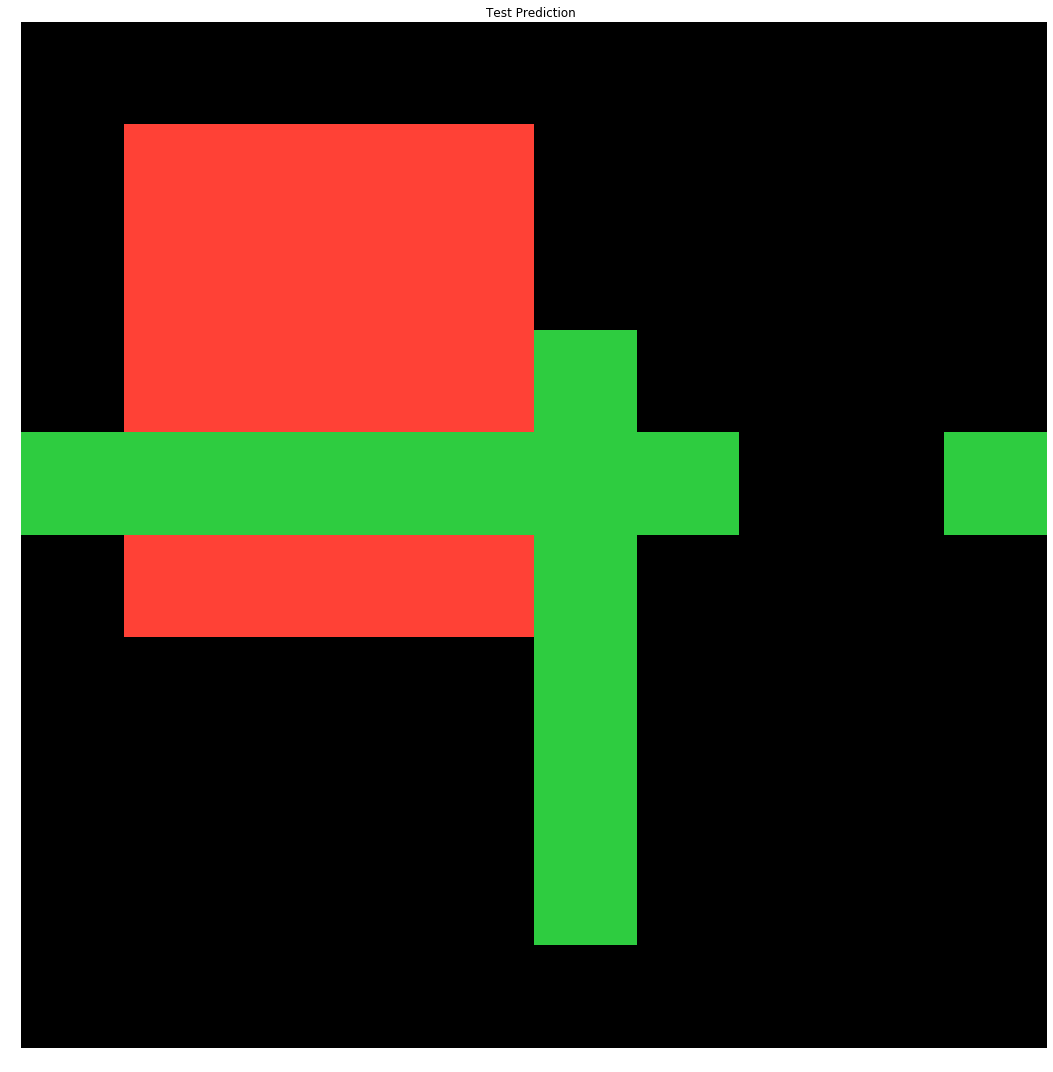

Made predictions for  da2b0fe3
ensemble accuracy 0.87



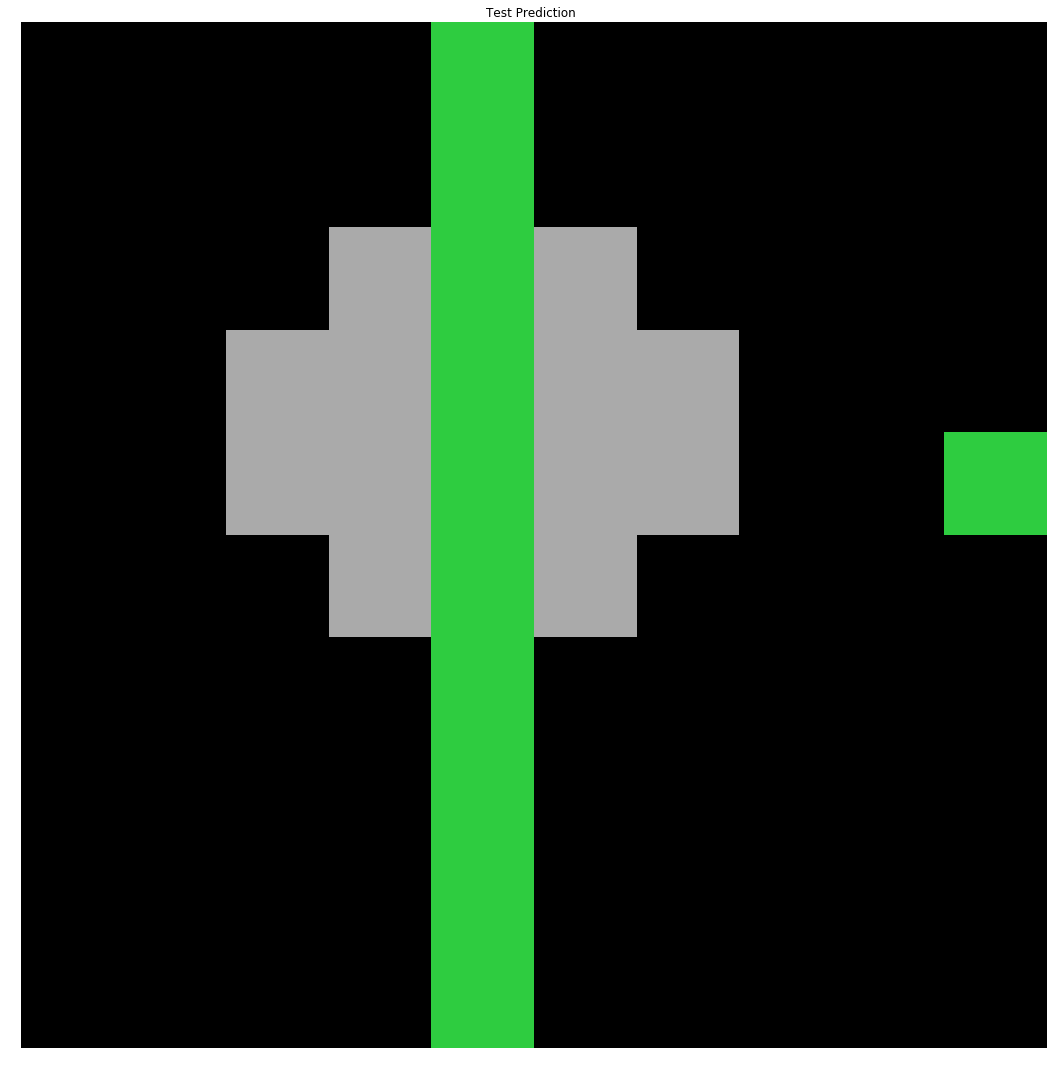

Made predictions for  da515329
ensemble accuracy 0.5931952662721893



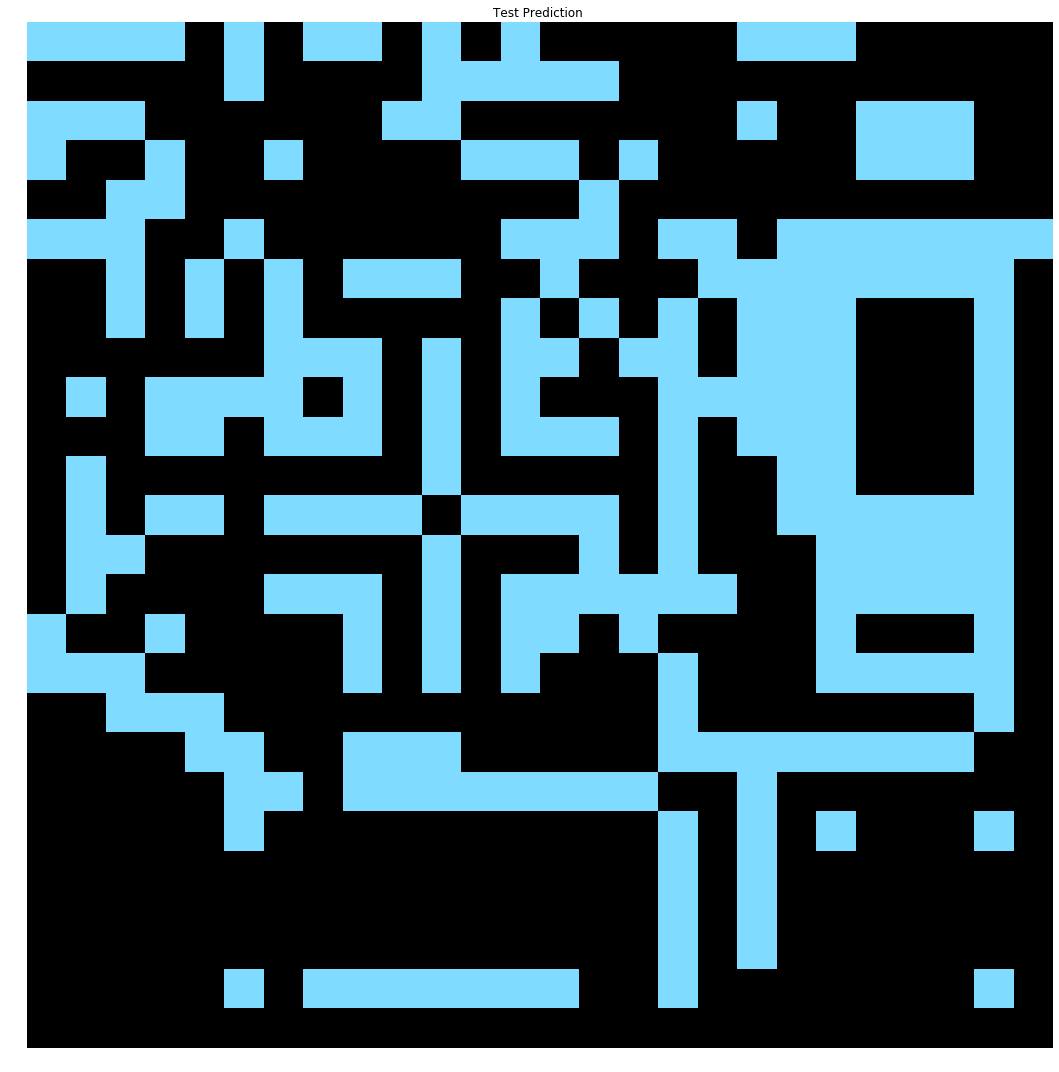

Made predictions for  dc2aa30b
ensemble accuracy 0.6859504132231405



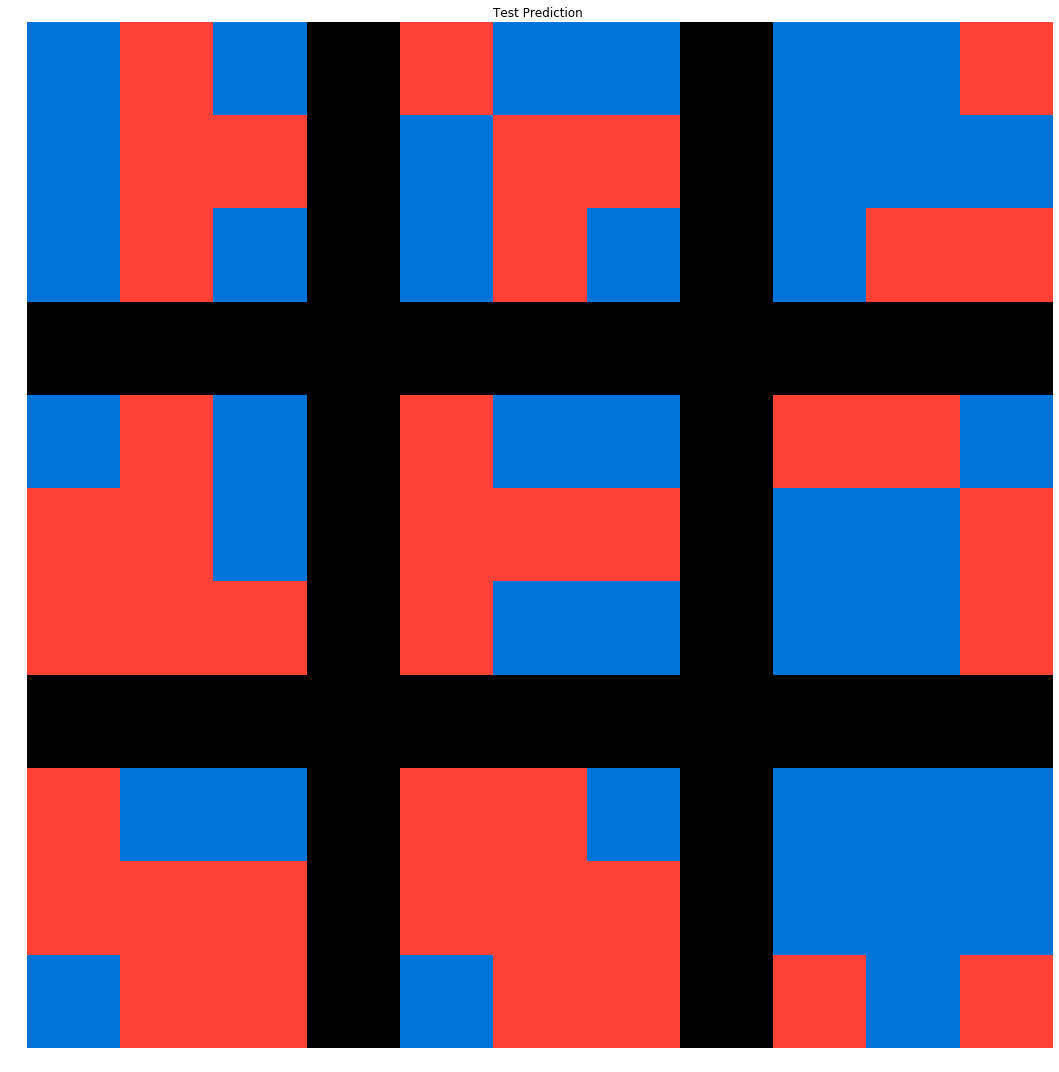

Made predictions for  dc2e9a9d
ensemble accuracy 0.9298029556650246



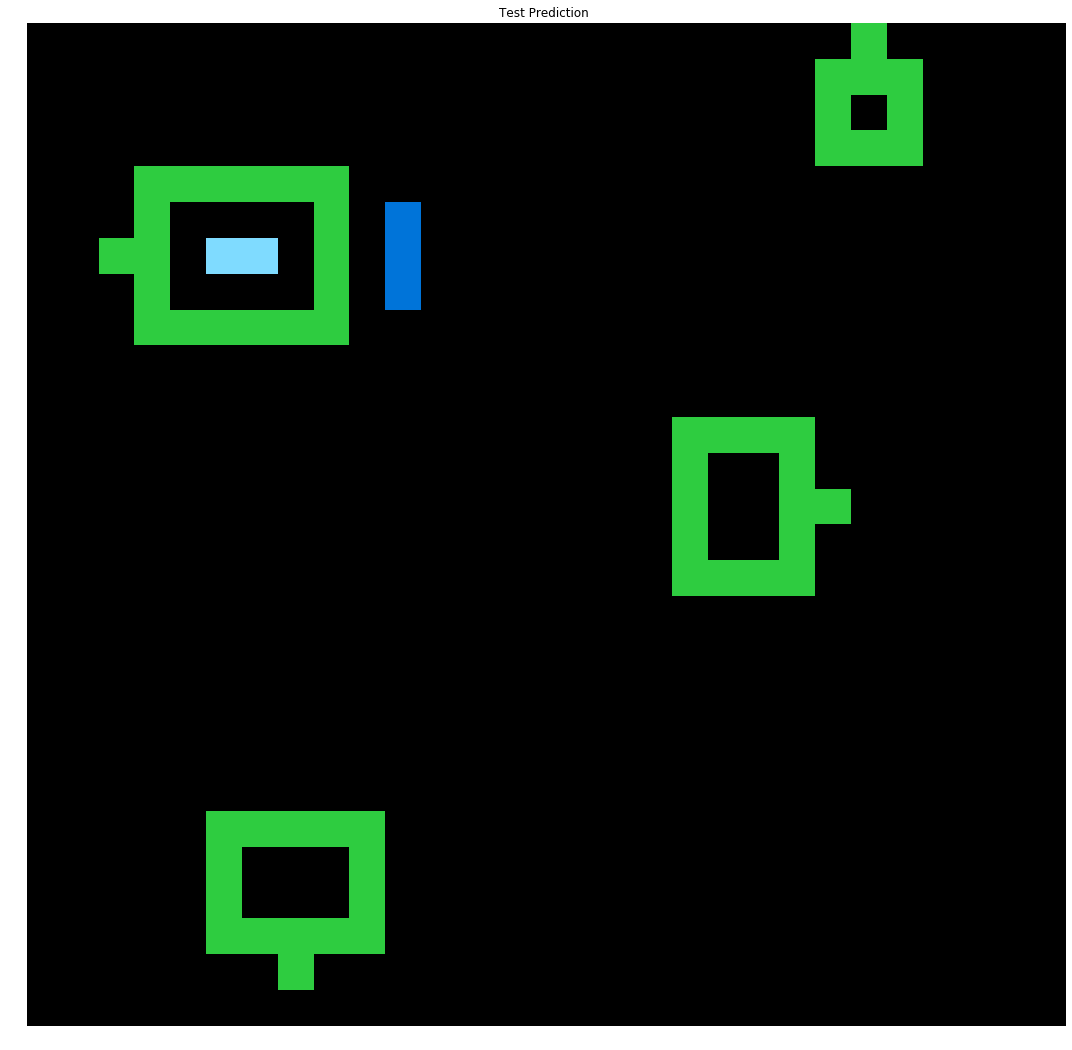

Made predictions for  dd2401ed
ensemble accuracy 0.8857142857142857



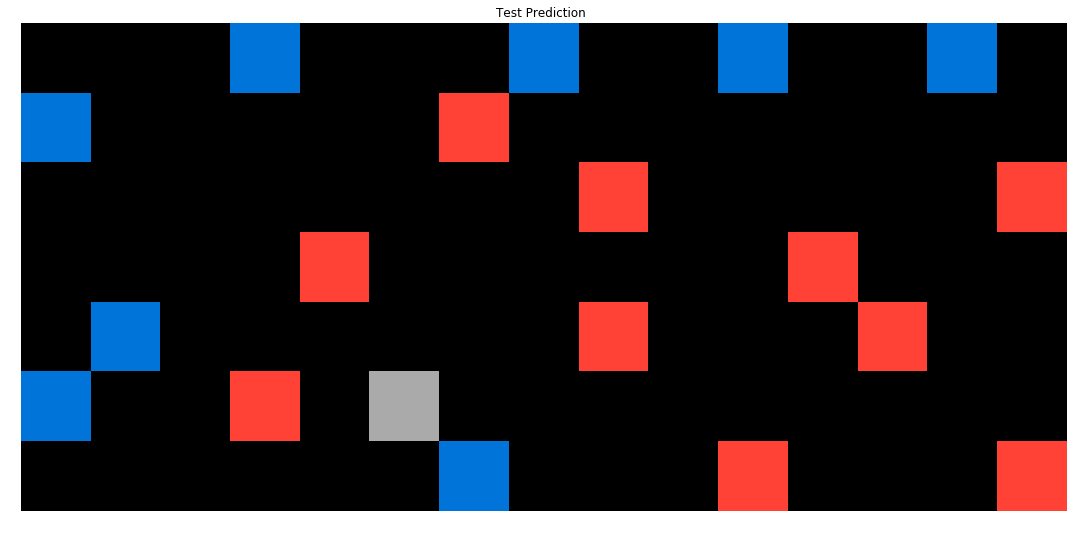

Number of input rows: 30 cols: 30
Number of target rows: 6 cols: 8
ignoring task abstraction-and-reasoning-challenge\evaluation\de493100.json

Made predictions for  df8cc377
ensemble accuracy 0.916083916083916



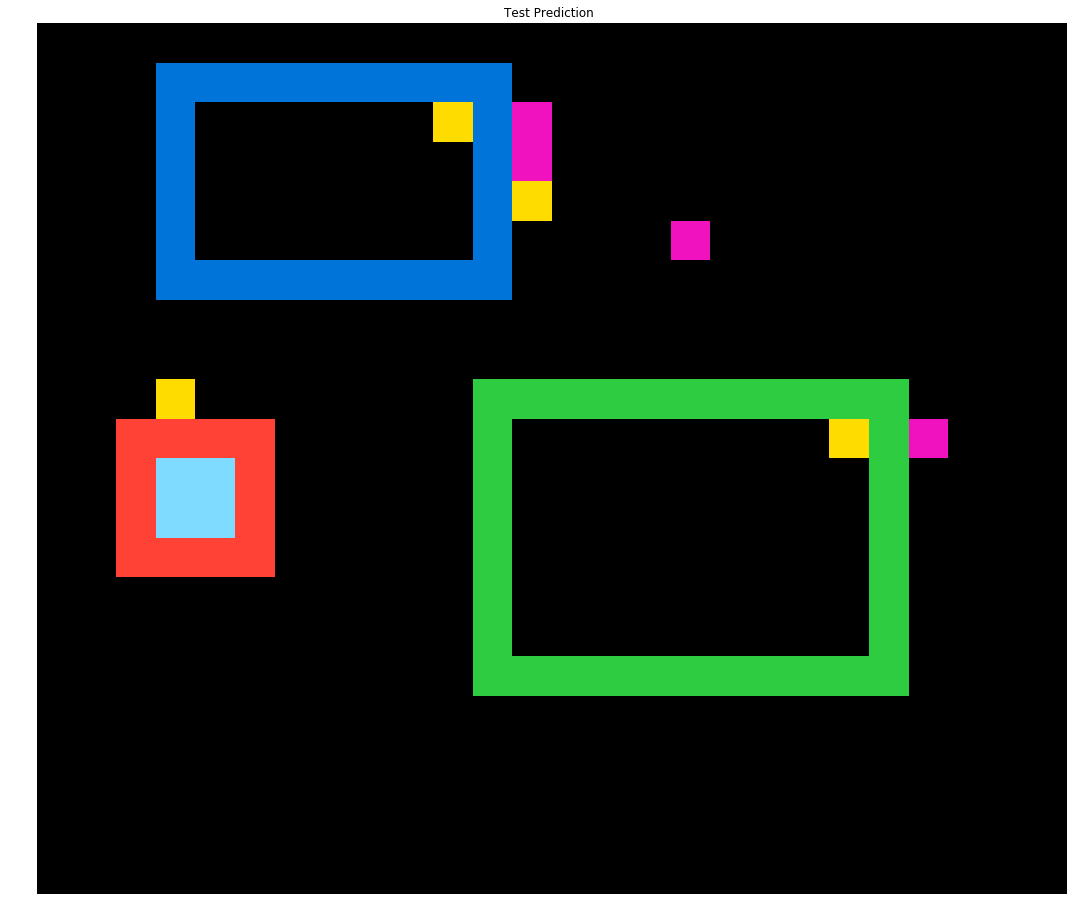

Made predictions for  e0fb7511
ensemble accuracy 1.0



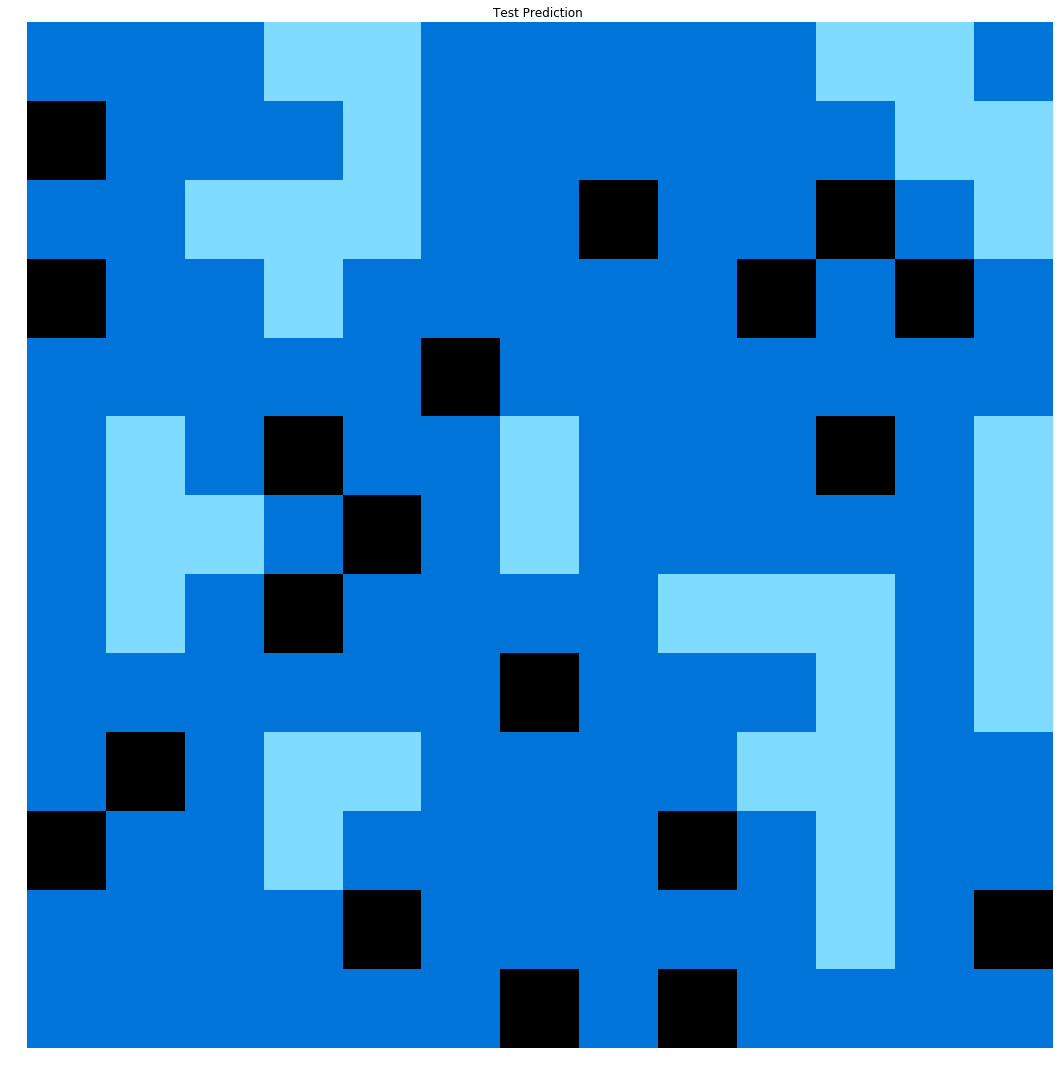

Number of input rows: 3 cols: 7
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\e133d23d.json

Number of input rows: 13 cols: 15
Number of target rows: 2 cols: 2
ignoring task abstraction-and-reasoning-challenge\evaluation\e1baa8a4.json

Made predictions for  e1d2900e
ensemble accuracy 0.9844444444444445



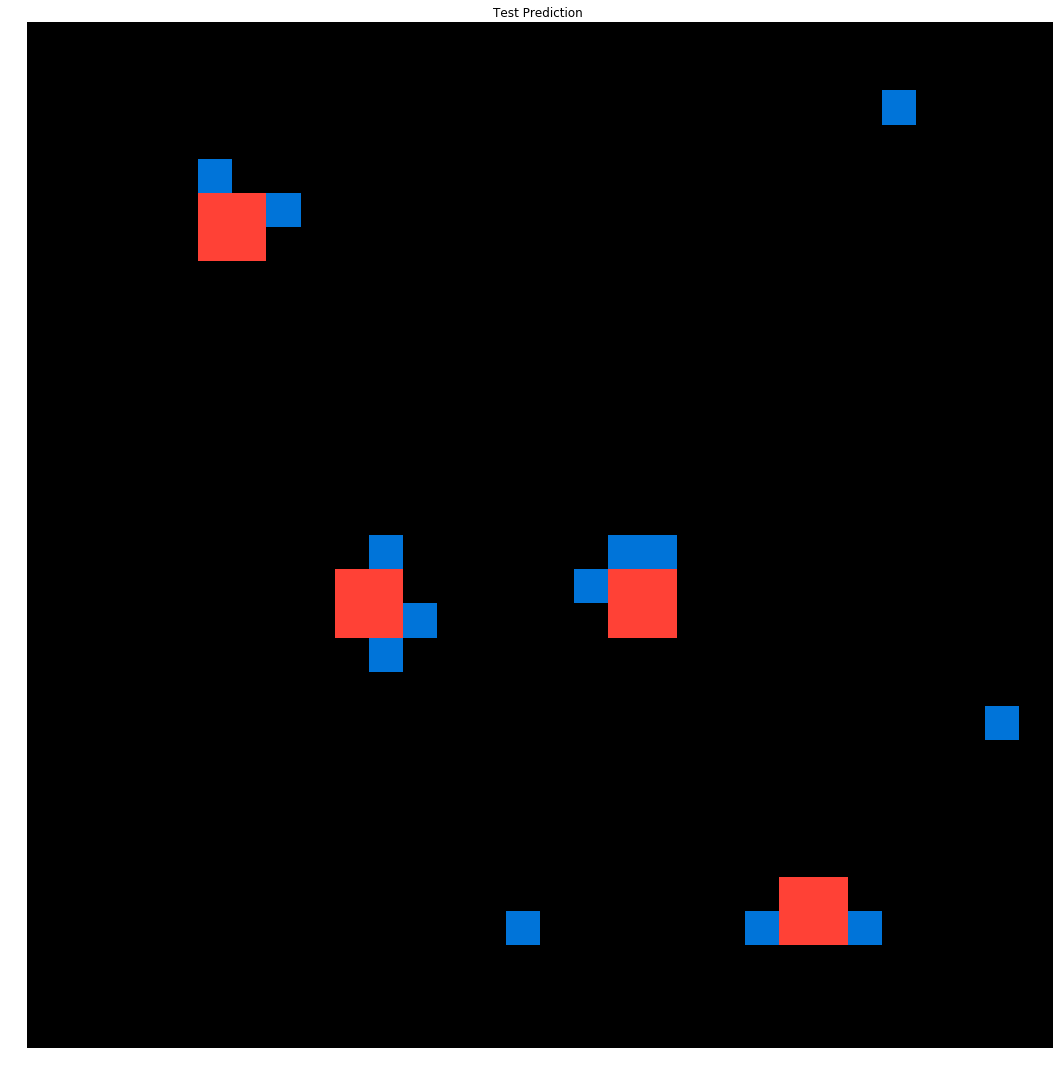

Made predictions for  e2092e0c
ensemble accuracy 0.9288888888888889



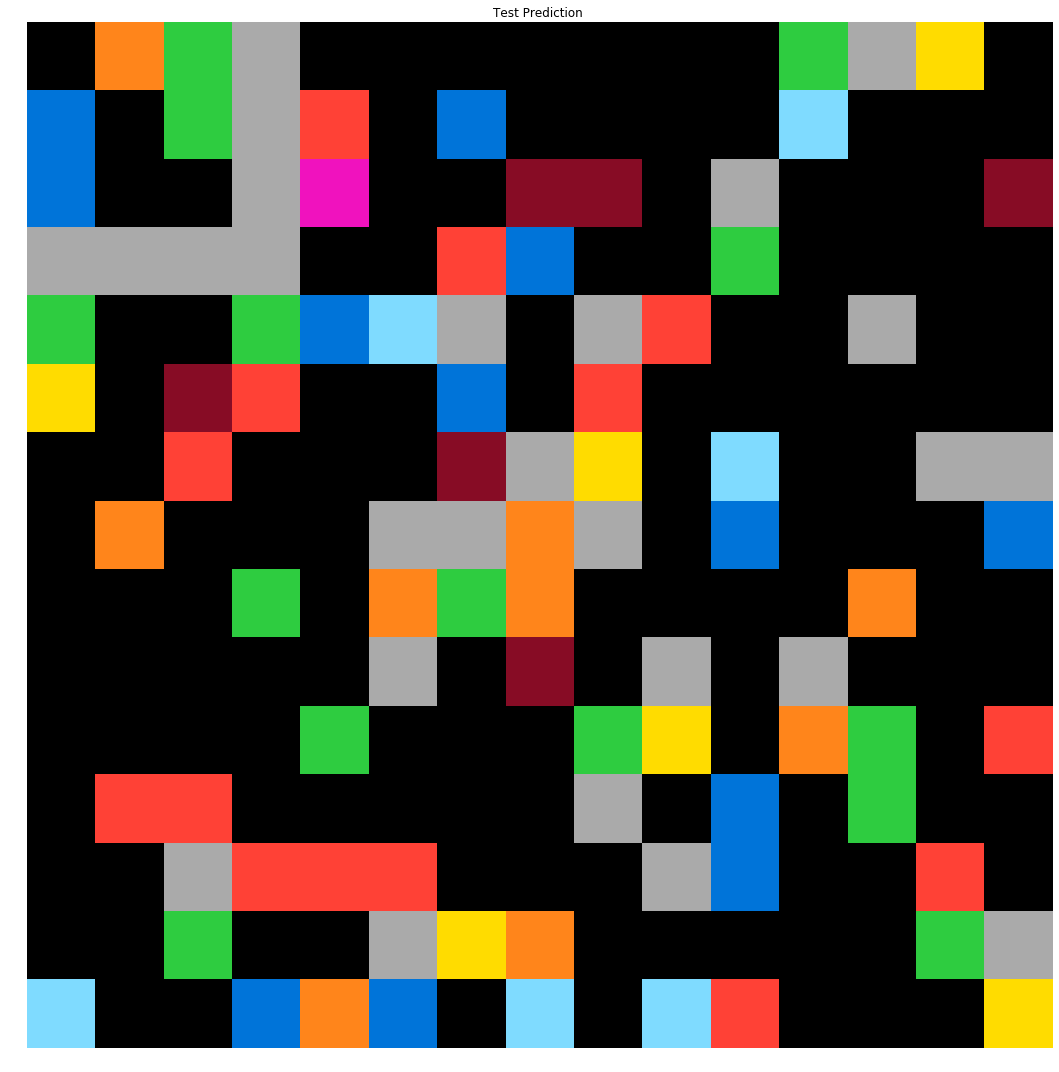

Made predictions for  e21a174a
ensemble accuracy 0.5918367346938775



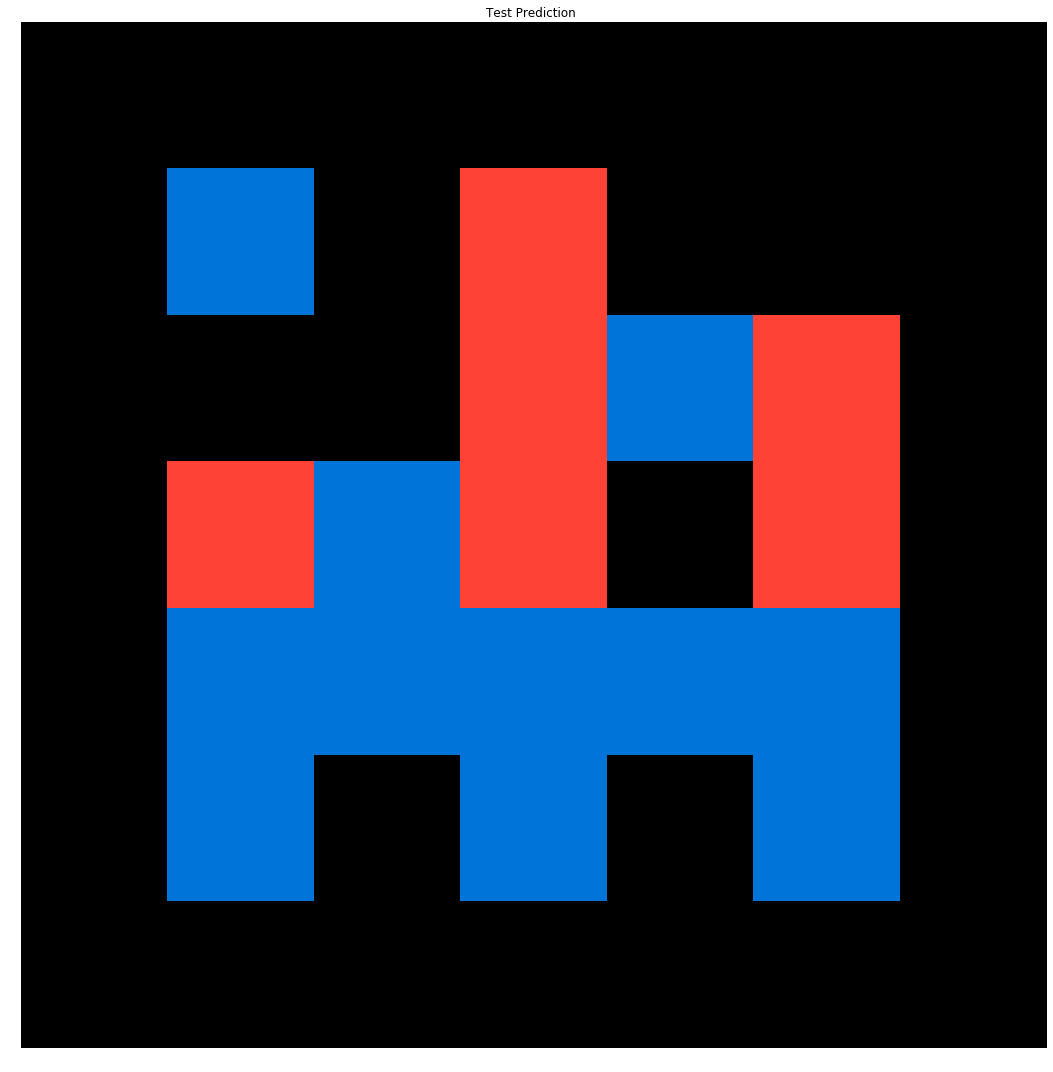

Made predictions for  e21a174a
ensemble accuracy 0.6384615384615384



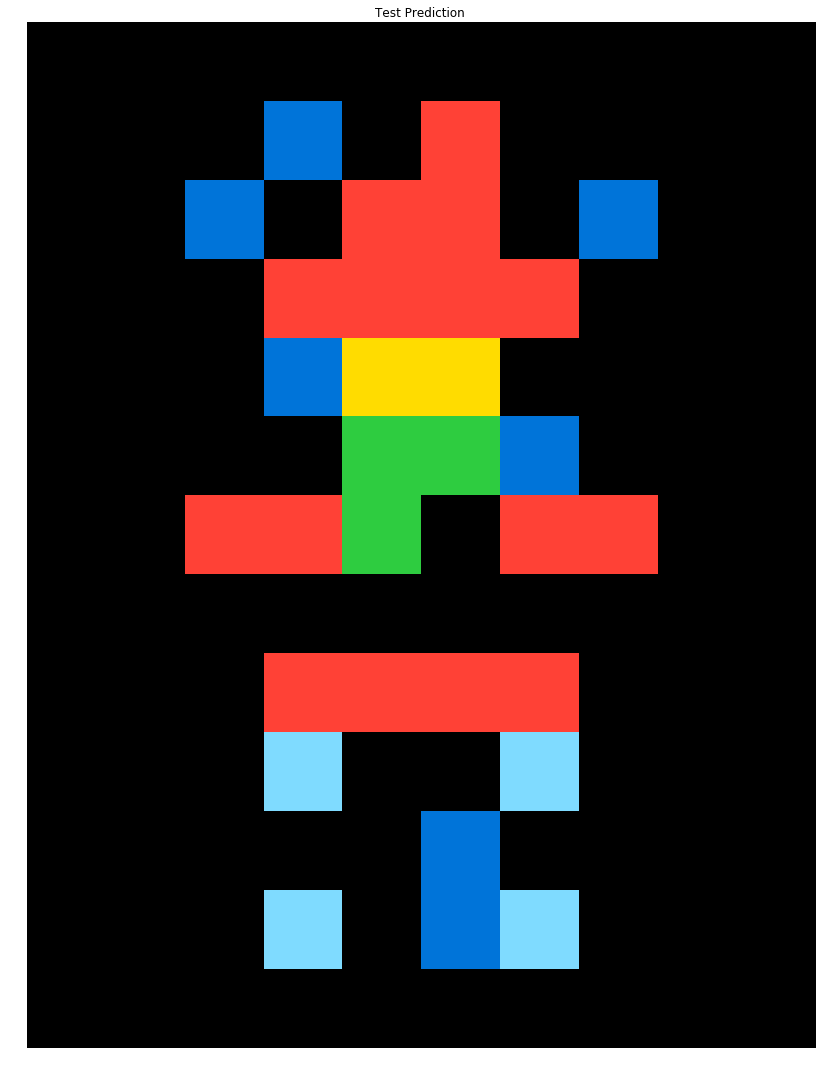

Number of input rows: 4 cols: 8
Number of target rows: 4 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\e345f17b.json

Made predictions for  e4075551
ensemble accuracy 0.7458333333333333



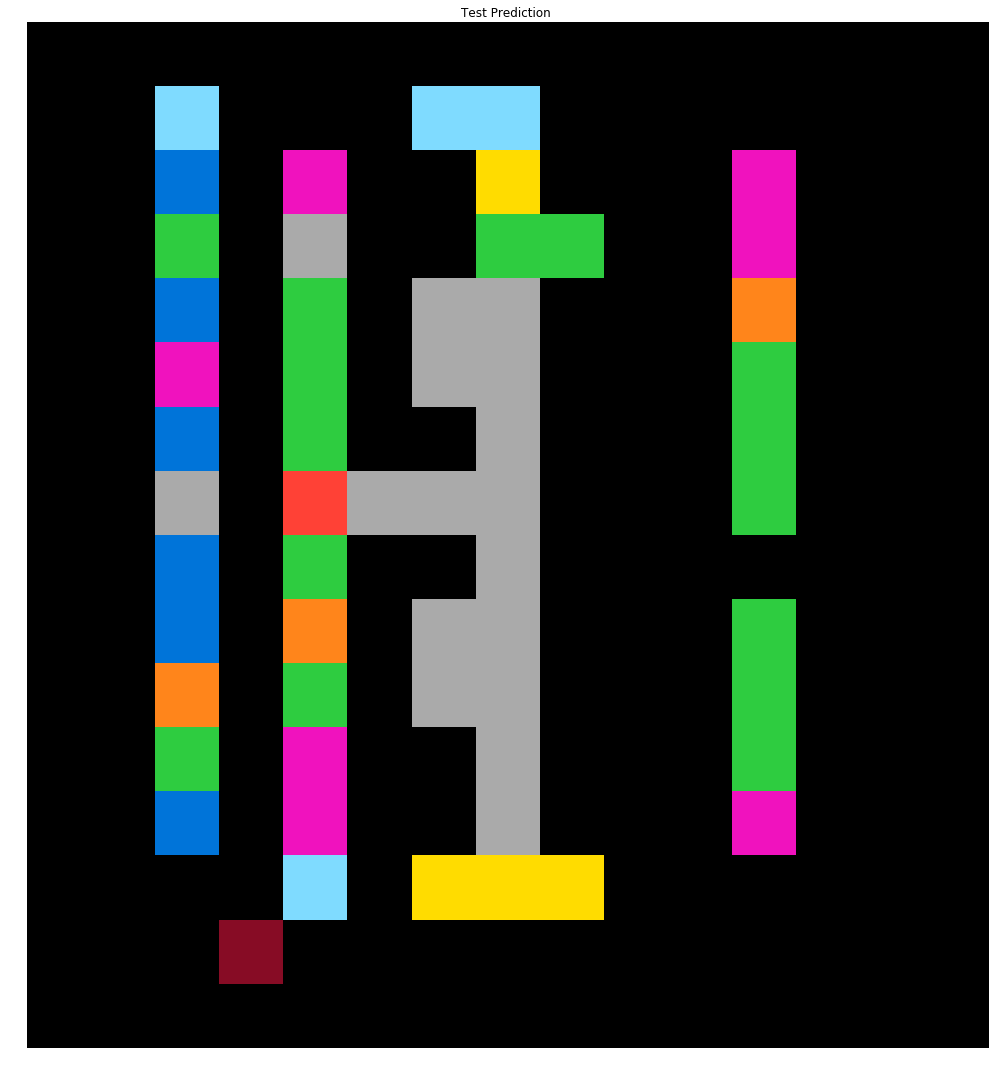

Made predictions for  e41c6fd3
ensemble accuracy 0.888235294117647



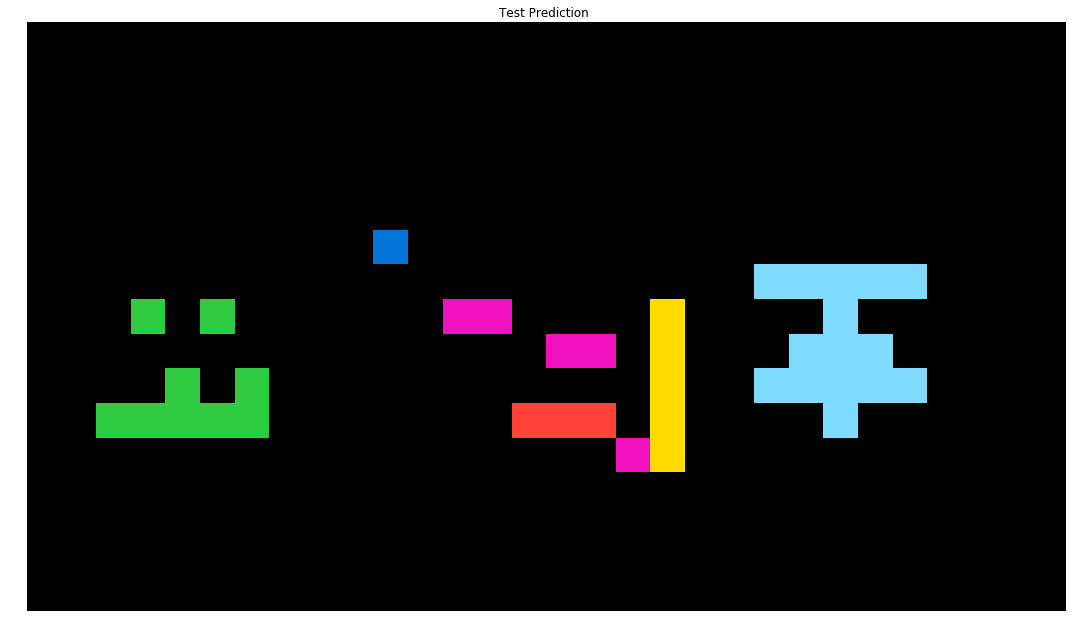

Number of input rows: 15 cols: 15
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\e57337a4.json

Made predictions for  e5790162
ensemble accuracy 0.8666666666666667



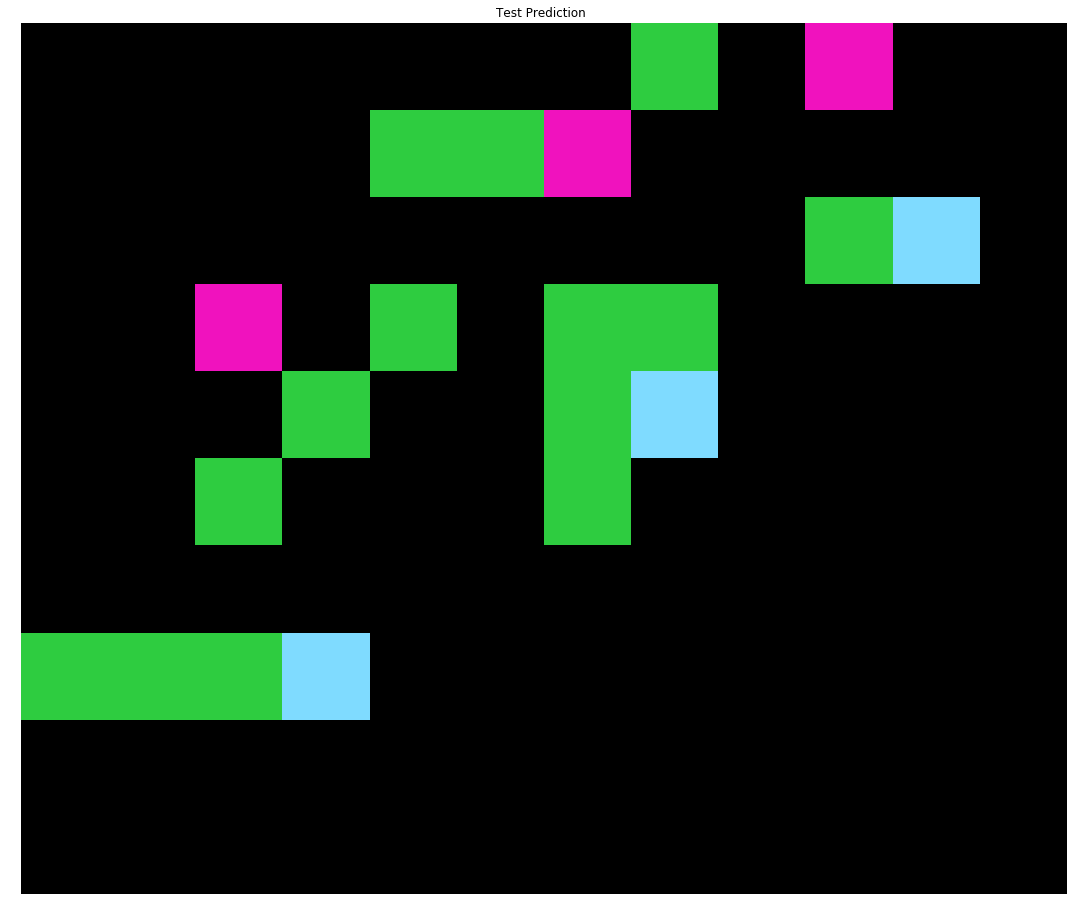

Made predictions for  e5c44e8f
ensemble accuracy 0.7520661157024794



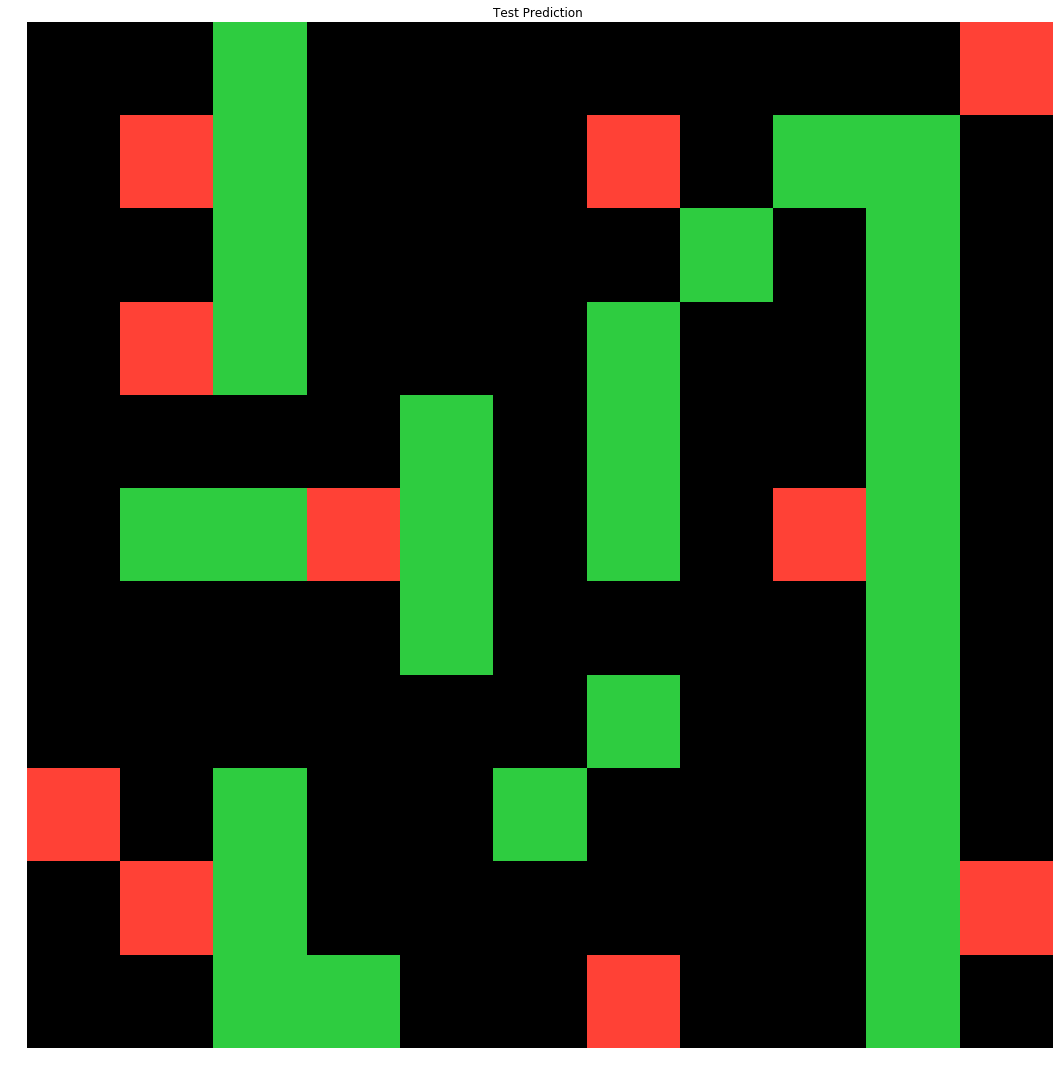

Made predictions for  e619ca6e
ensemble accuracy 0.8768472906403941



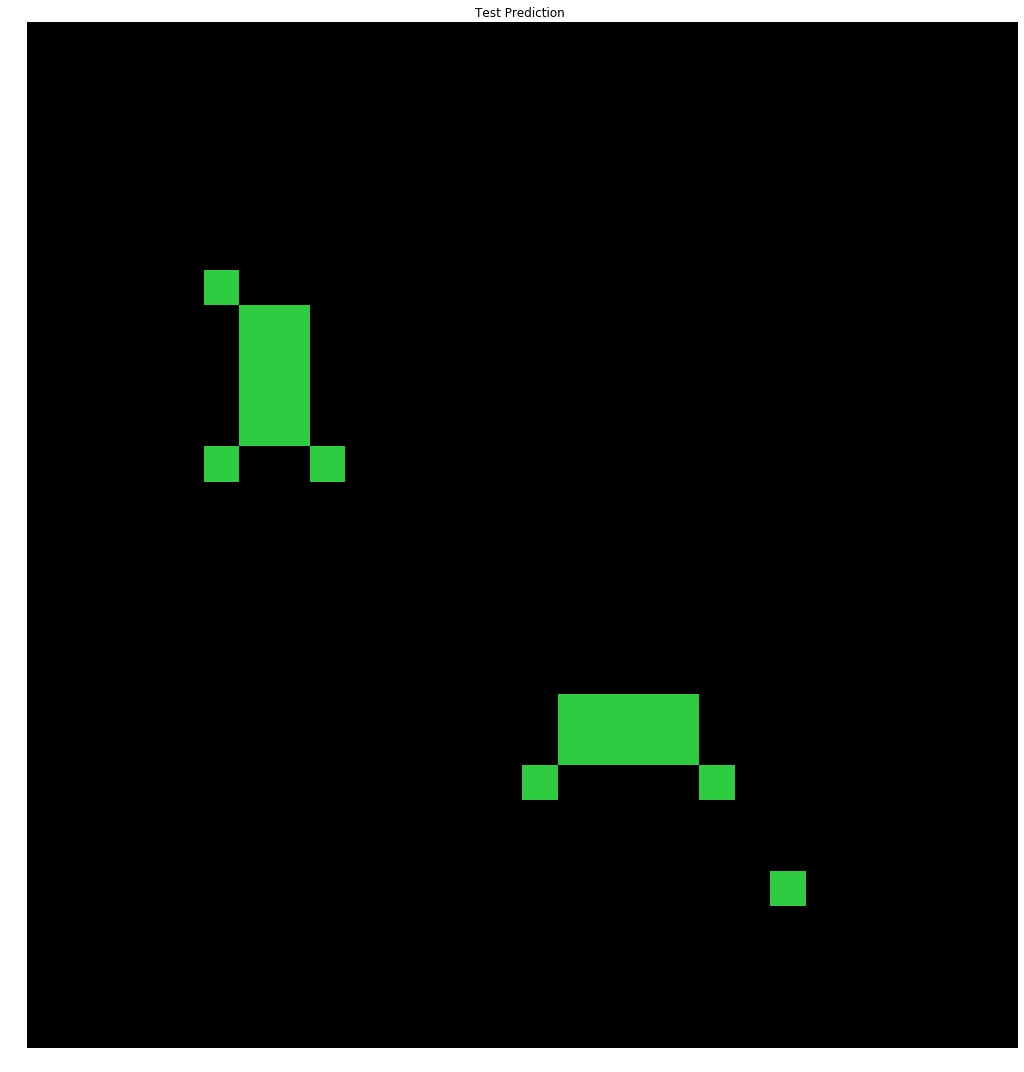

Number of input rows: 3 cols: 3
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\e633a9e5.json

Number of input rows: 24 cols: 24
Number of target rows: 8 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\e66aafb8.json



C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  e681b708
ensemble accuracy 0.9541420118343196



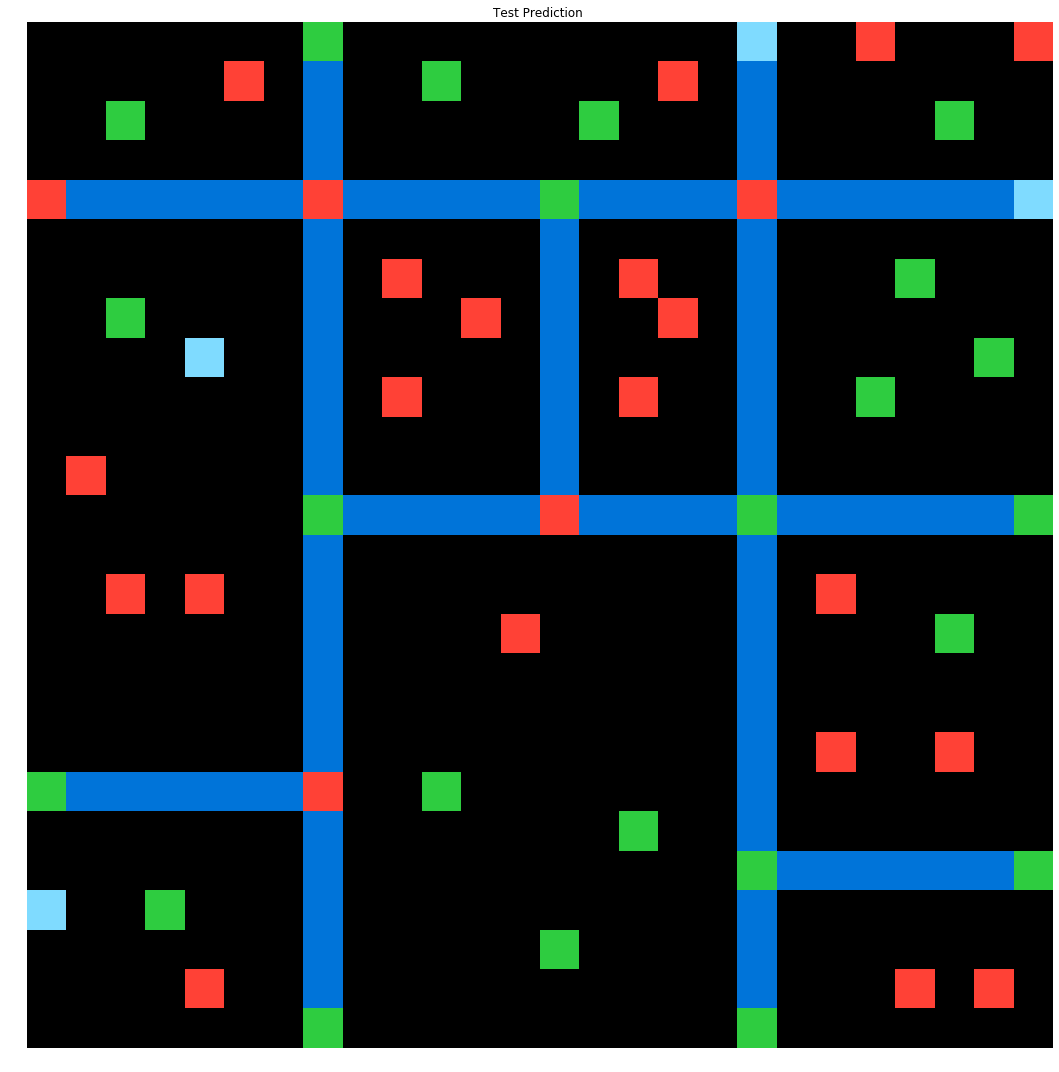

Made predictions for  e69241bd
ensemble accuracy 0.7283950617283951



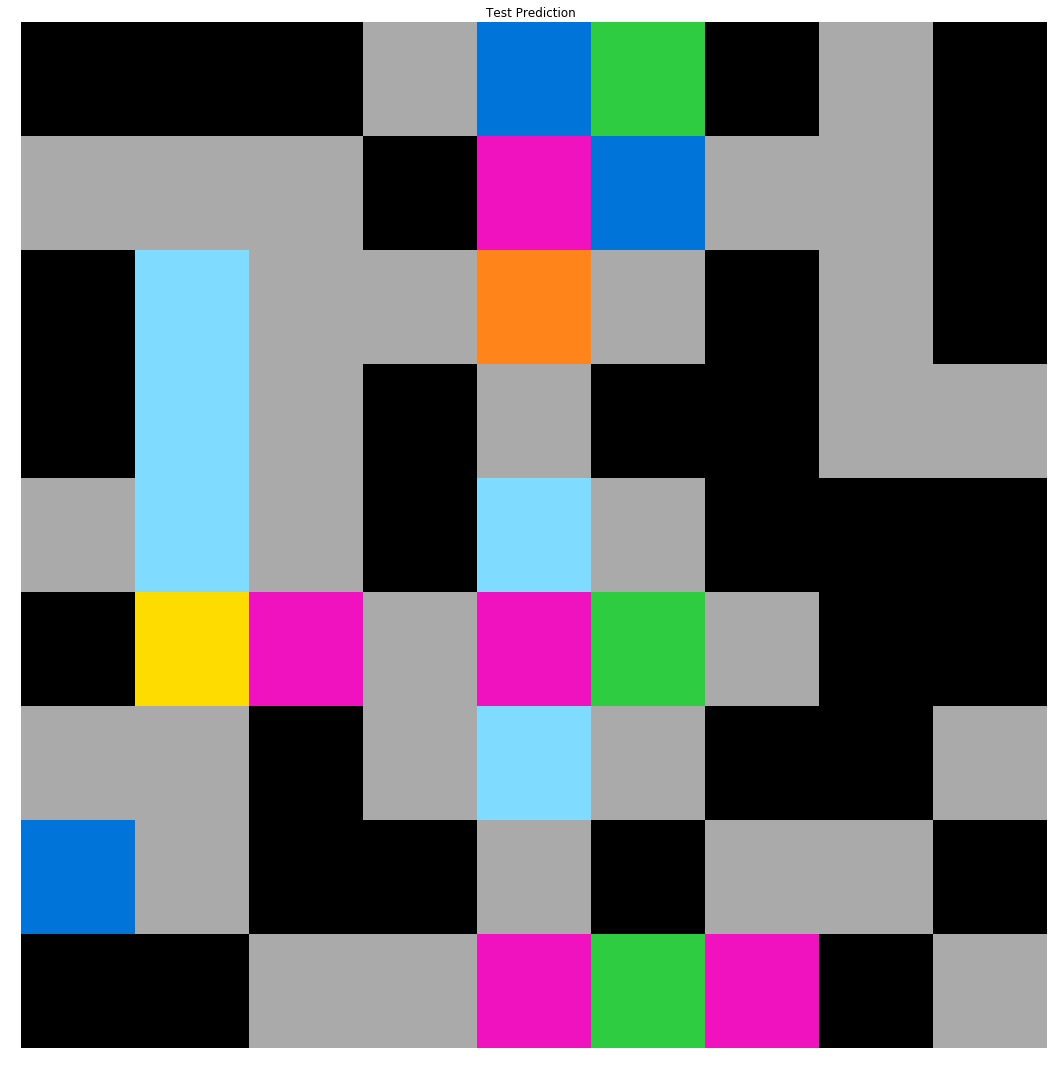

Number of input rows: 2 cols: 12
Number of target rows: 8 cols: 7
ignoring task abstraction-and-reasoning-challenge\evaluation\e6de6e8f.json

Made predictions for  e74e1818
ensemble accuracy 0.76



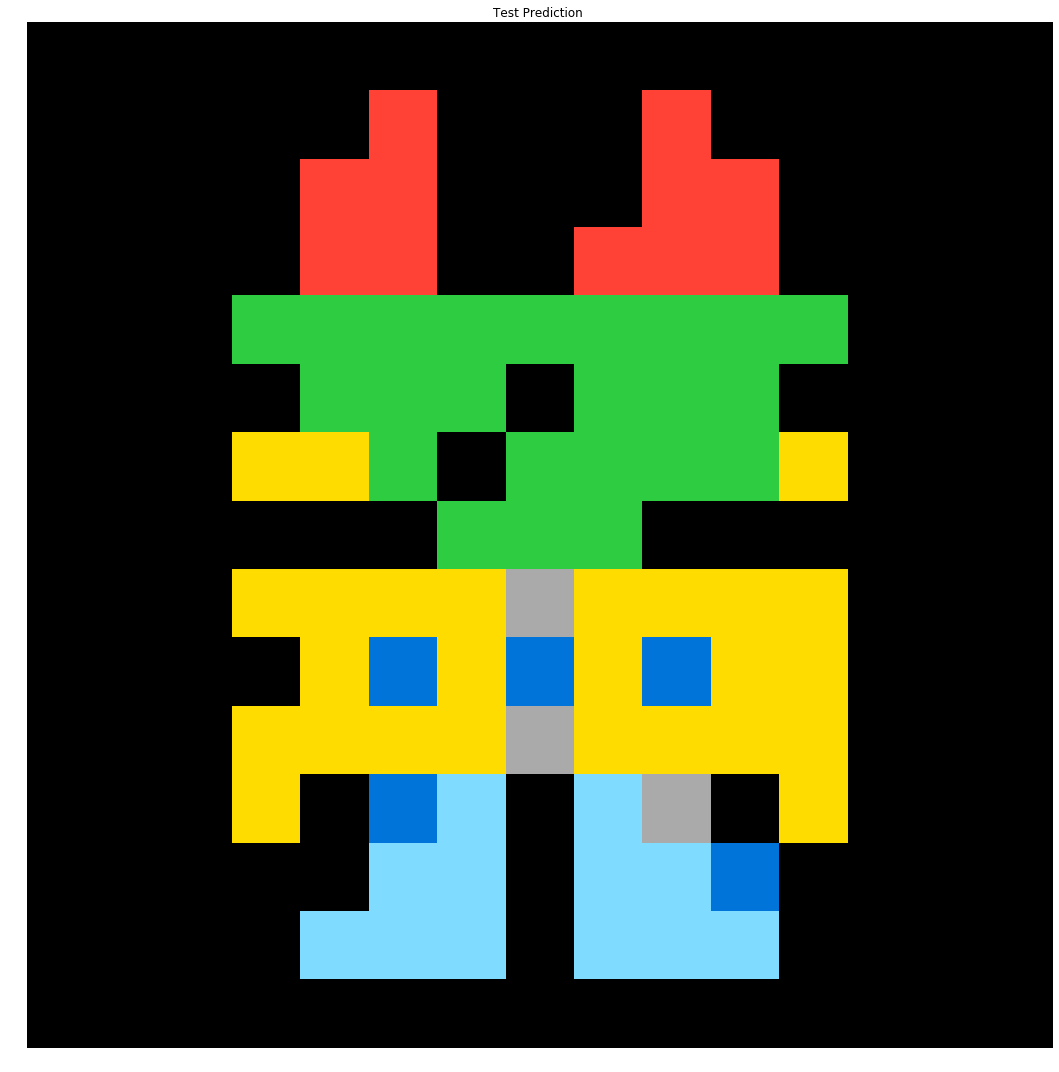

Made predictions for  e760a62e
ensemble accuracy 0.8073979591836735



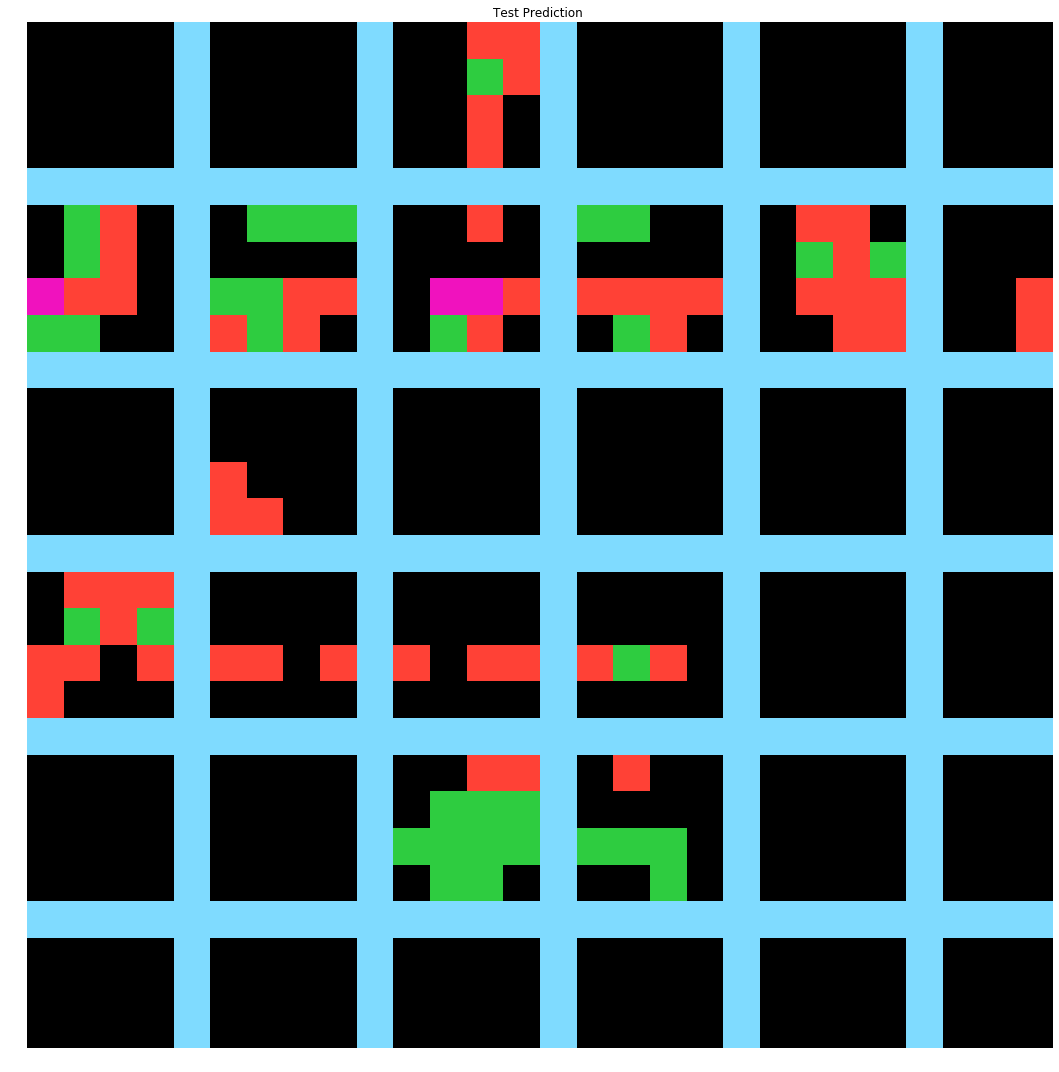

Made predictions for  e7639916
ensemble accuracy 0.8461538461538461



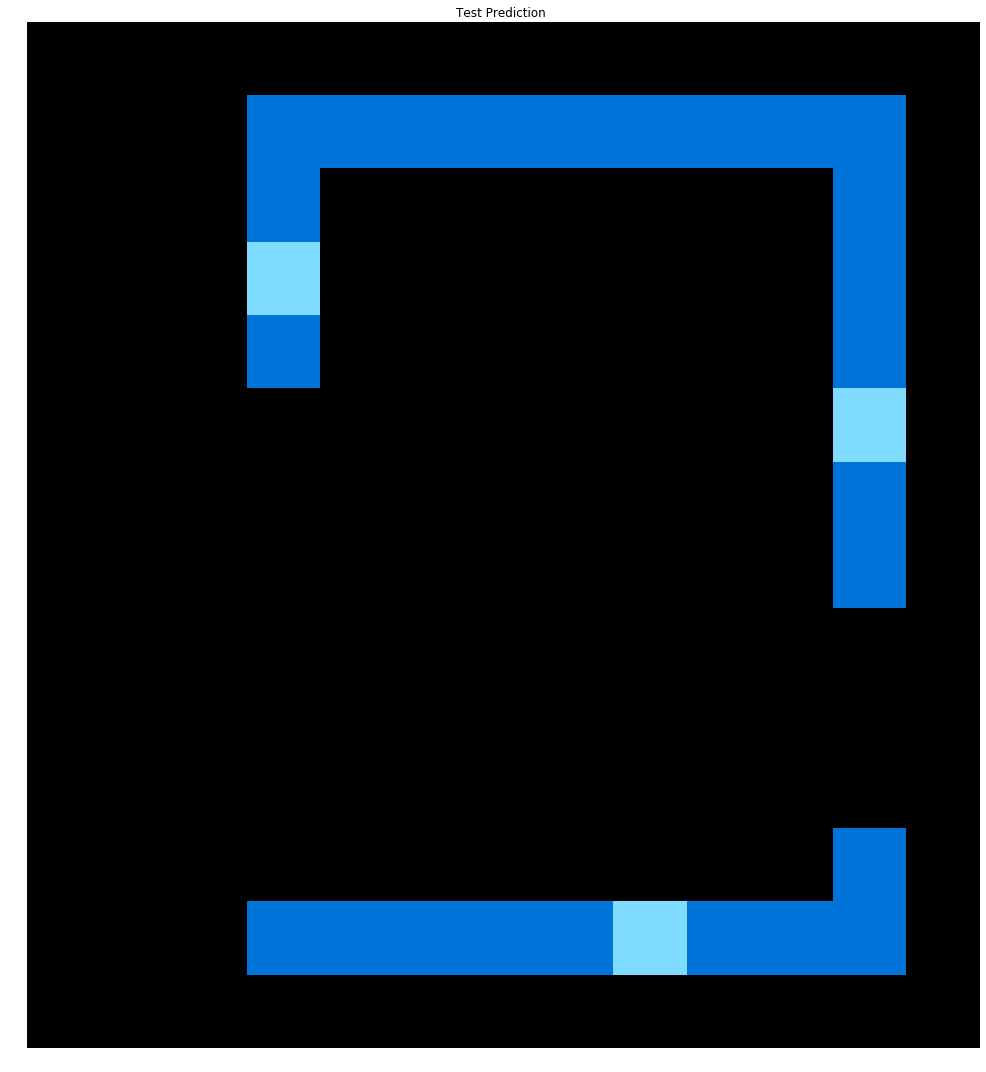

Number of input rows: 13 cols: 11
Number of target rows: 3 cols: 11
ignoring task abstraction-and-reasoning-challenge\evaluation\e78887d1.json

Number of input rows: 14 cols: 14
Number of target rows: 10 cols: 10
ignoring task abstraction-and-reasoning-challenge\evaluation\e7a25a18.json

Made predictions for  e7b06bea
ensemble accuracy 0.8765432098765432



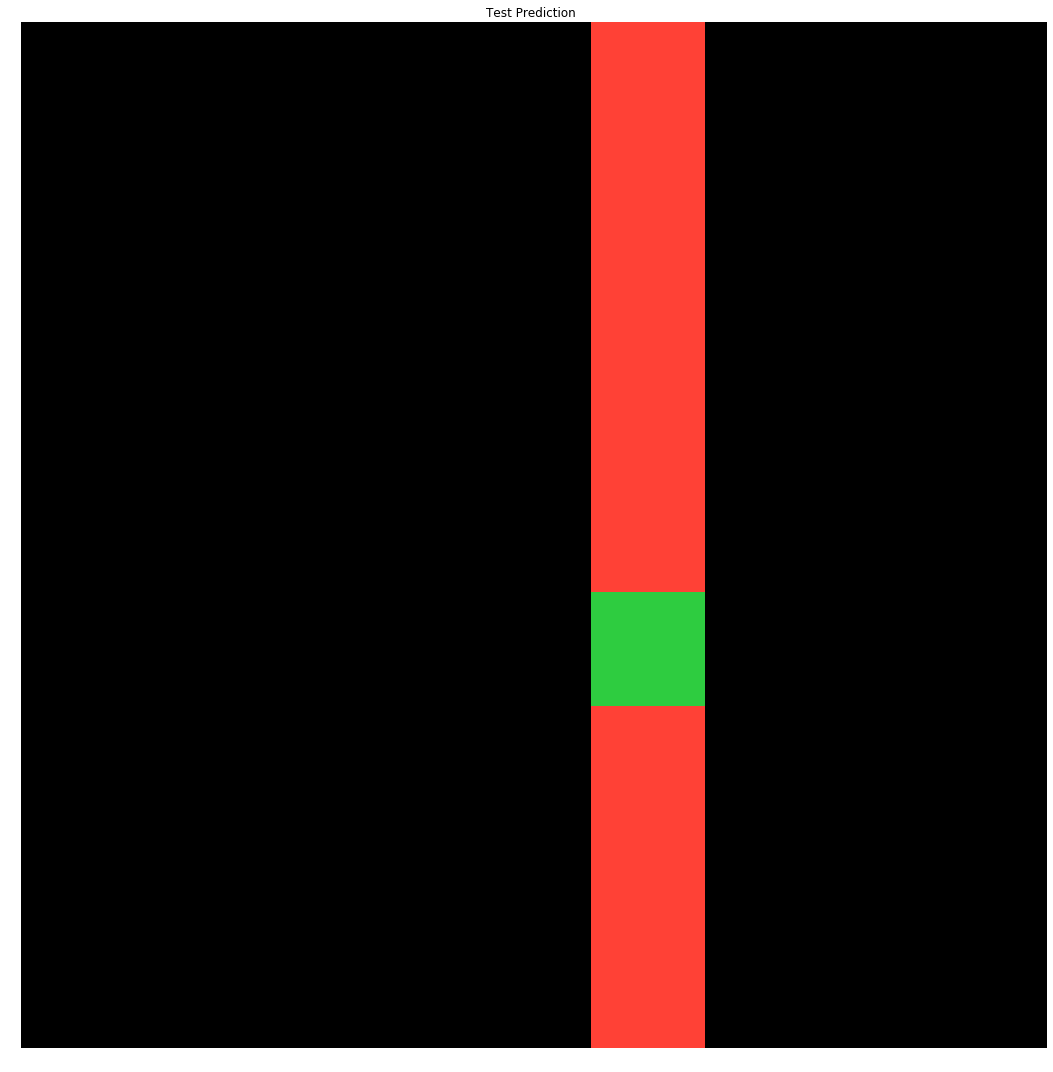

Made predictions for  e7dd8335
ensemble accuracy 0.9191919191919192



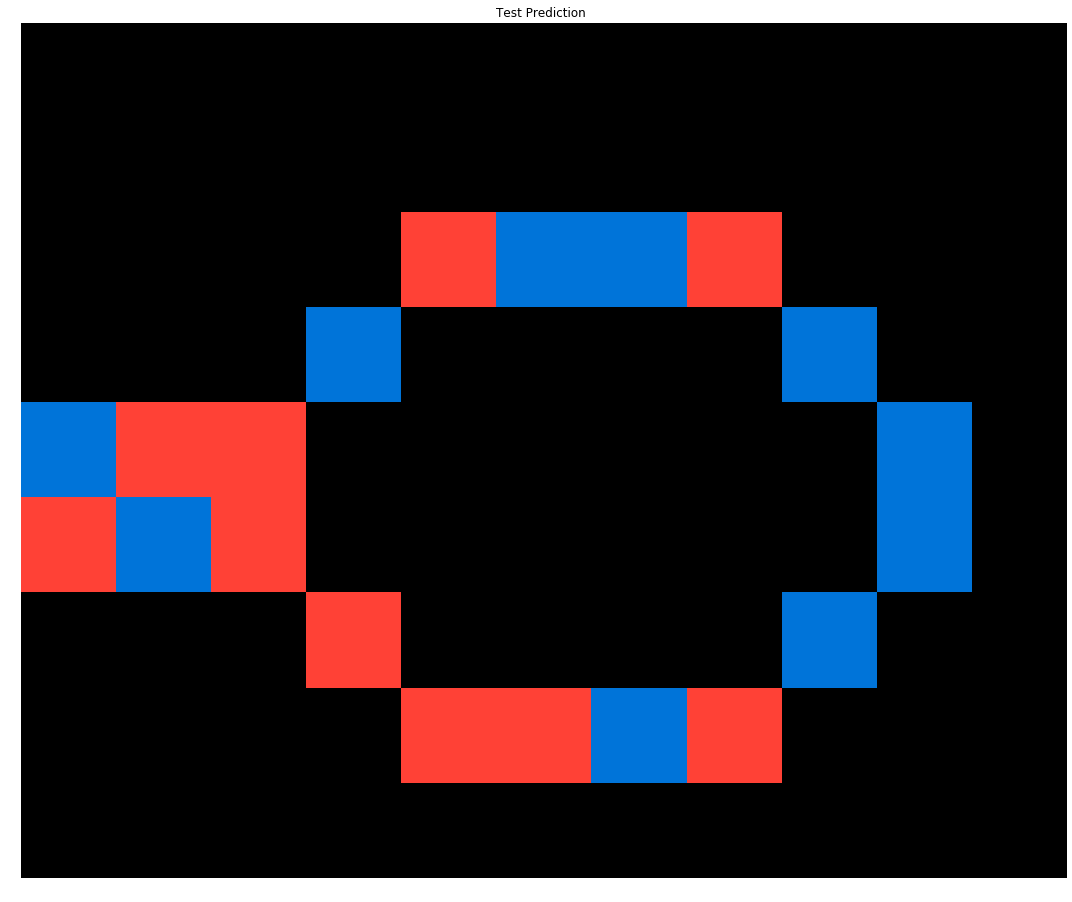

Number of input rows: 12 cols: 12
Number of target rows: 4 cols: 1
ignoring task abstraction-and-reasoning-challenge\evaluation\e872b94a.json

Made predictions for  e88171ec
ensemble accuracy 0.39909297052154197



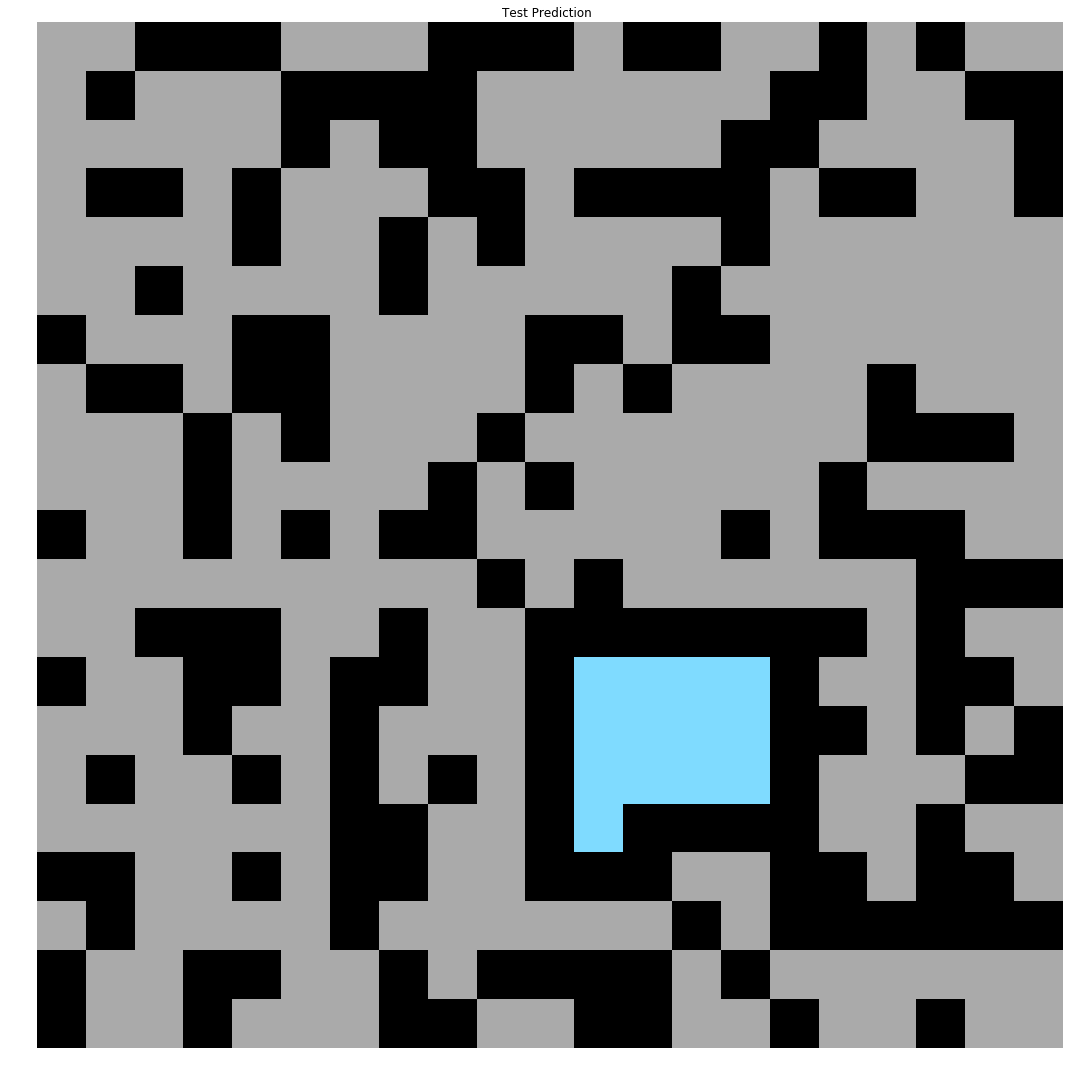

Made predictions for  e95e3d8e
ensemble accuracy 0.9276859504132231



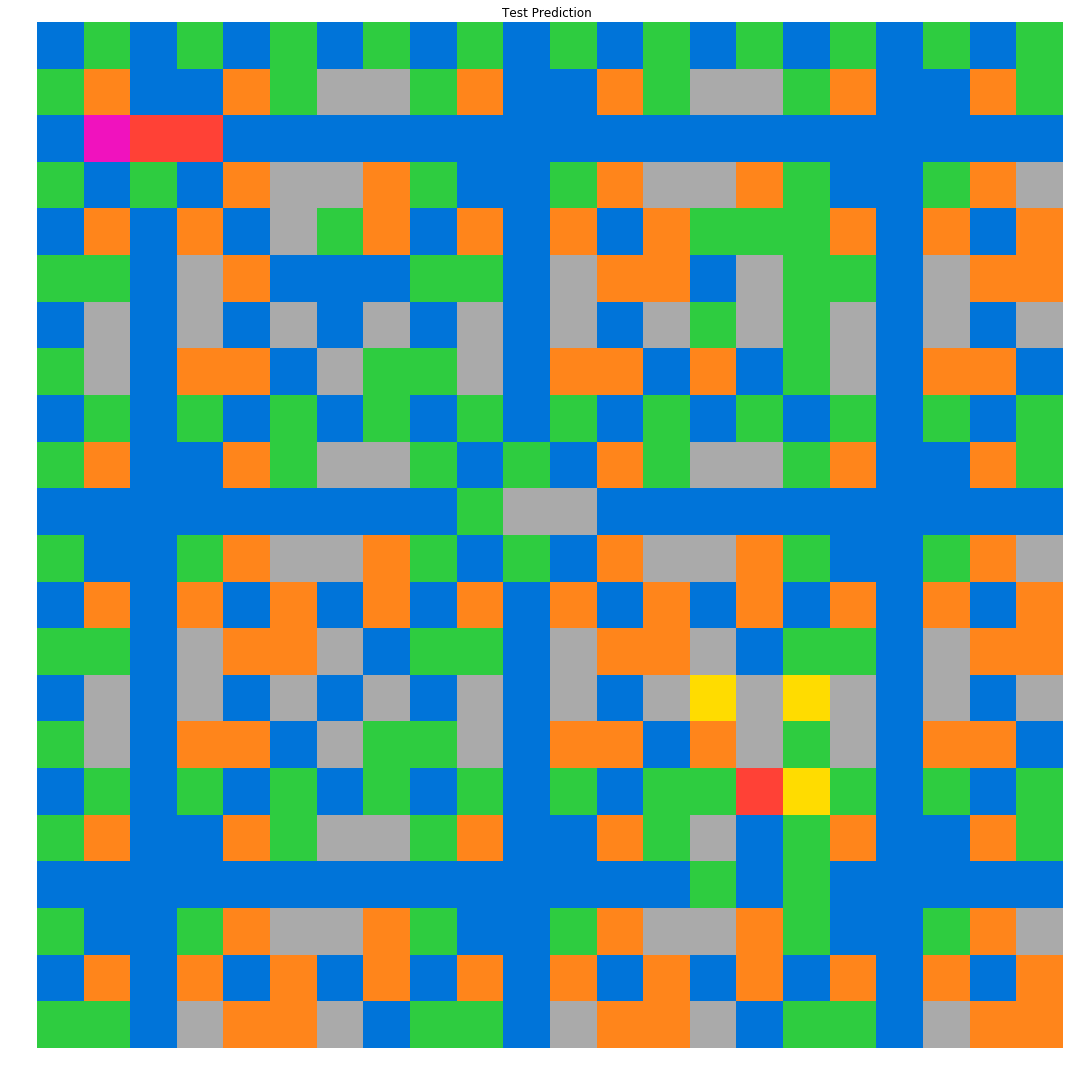

Number of input rows: 11 cols: 9
Number of target rows: 5 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\e99362f0.json



C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\17854\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  e9ac8c9e
ensemble accuracy 0.8



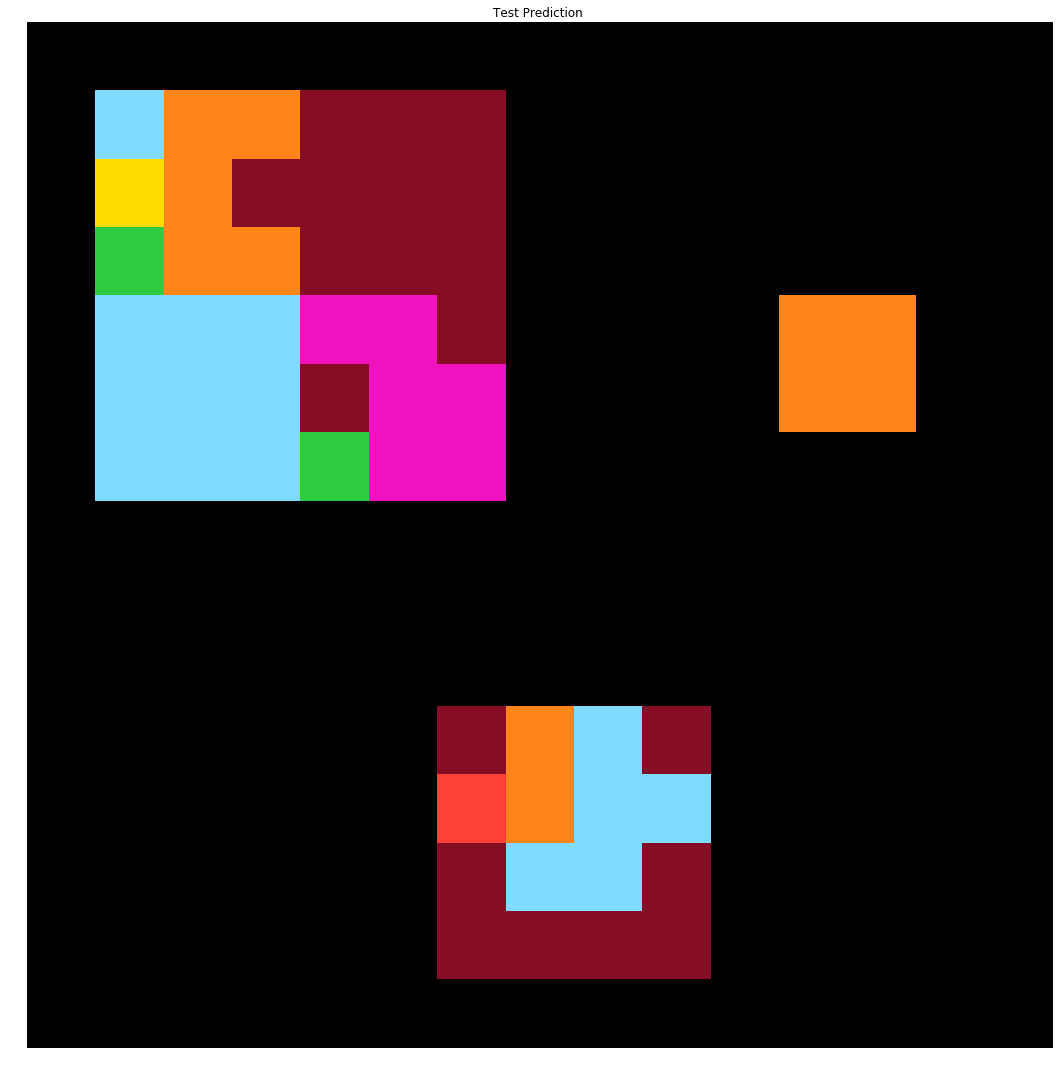

Number of input rows: 13 cols: 13
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\e9b4f6fc.json

Made predictions for  e9bb6954
ensemble accuracy 0.7008310249307479



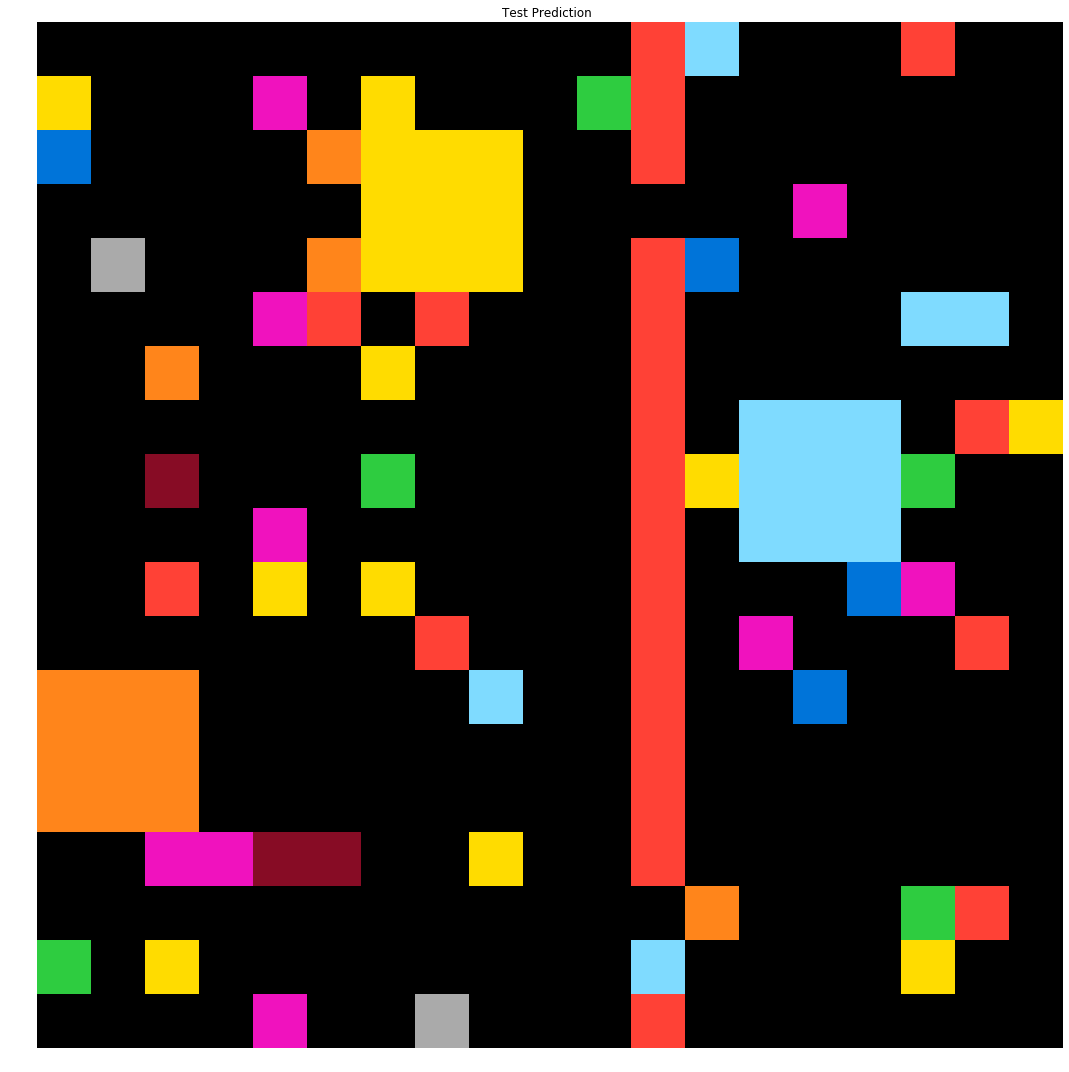

Made predictions for  e9c9d9a1
ensemble accuracy 0.7866666666666666



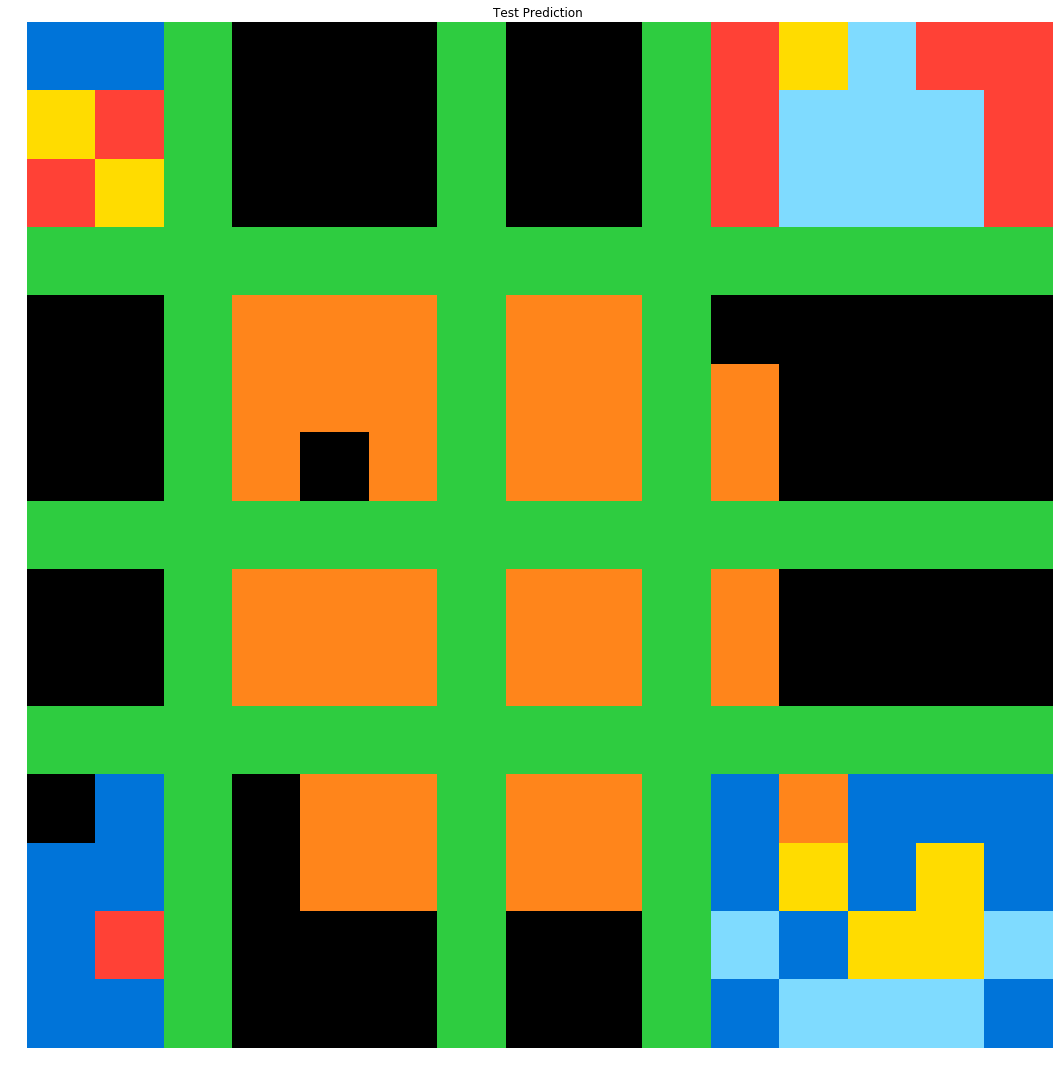

Made predictions for  ea959feb
ensemble accuracy 0.8527272727272728



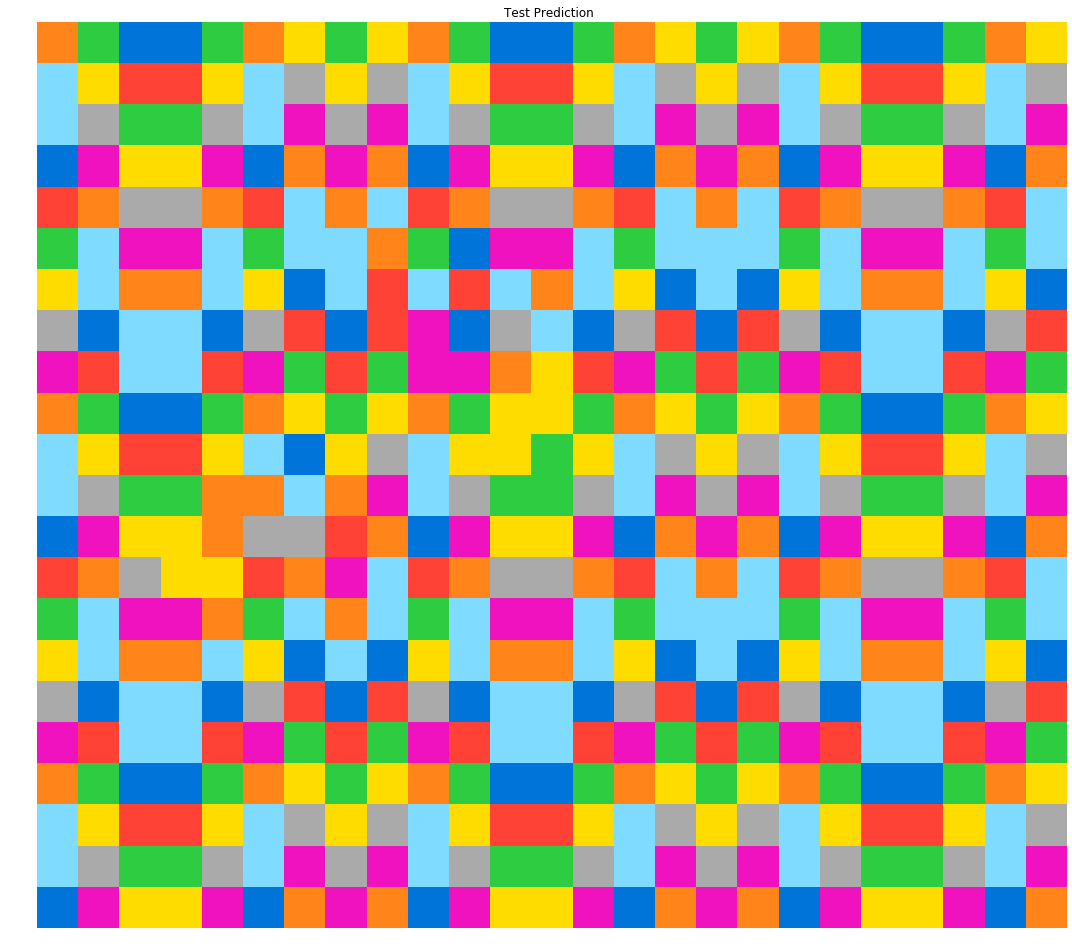

Number of input rows: 10 cols: 10
Number of target rows: 5 cols: 5
ignoring task abstraction-and-reasoning-challenge\evaluation\ea9794b1.json

Made predictions for  ecaa0ec1
ensemble accuracy 0.9504132231404959



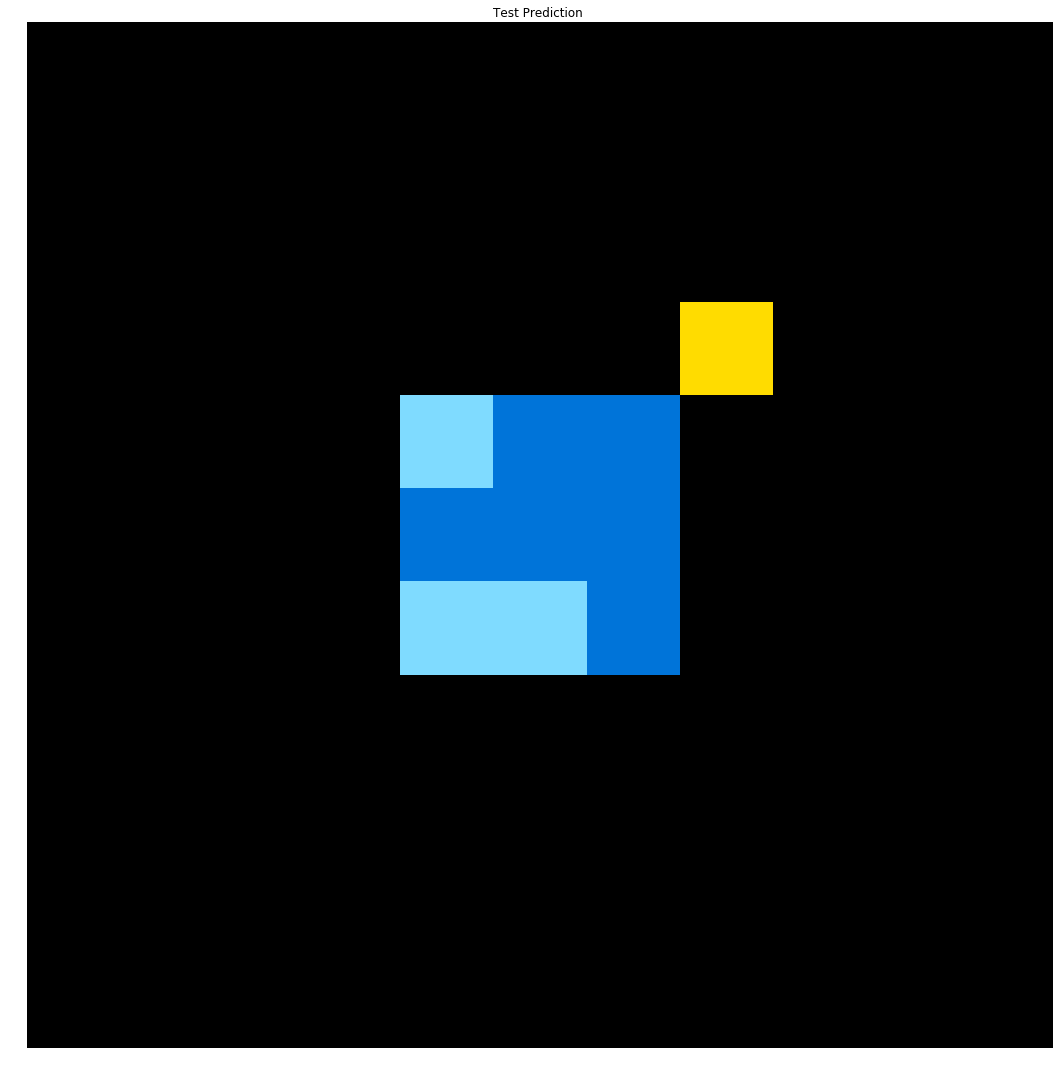

Number of input rows: 5 cols: 9
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\ed74f2f2.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task abstraction-and-reasoning-challenge\evaluation\ed98d772.json

Made predictions for  ef26cbf6
ensemble accuracy 0.8701298701298701



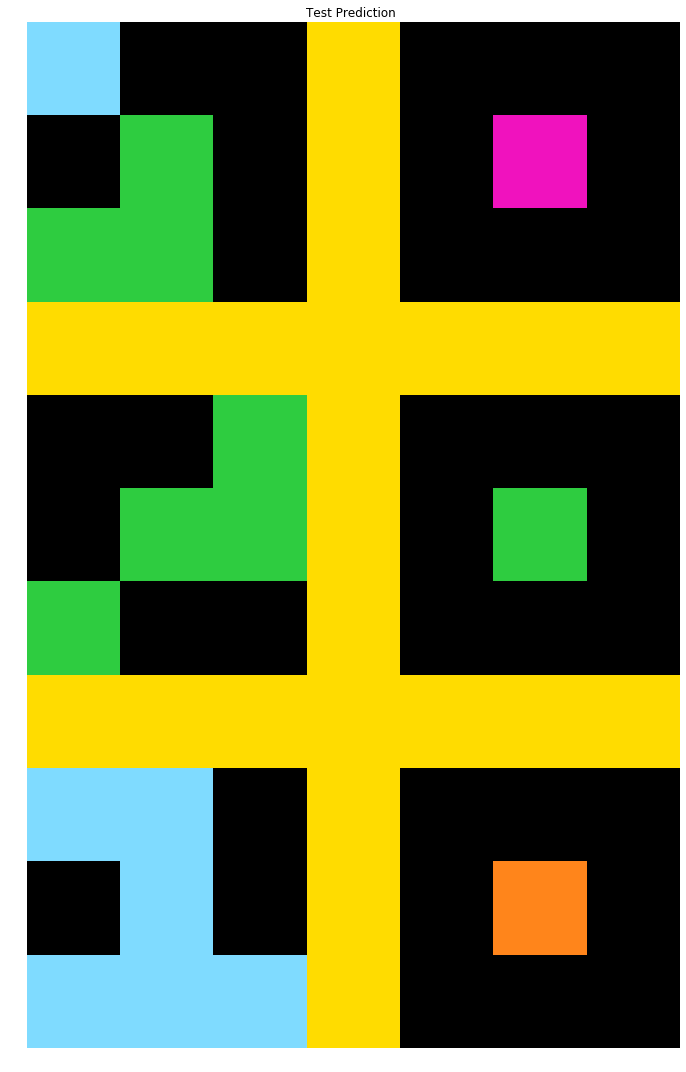

Number of input rows: 5 cols: 5
Number of target rows: 10 cols: 10
ignoring task abstraction-and-reasoning-challenge\evaluation\f0afb749.json

Made predictions for  f0df5ff0
ensemble accuracy 0.9644444444444444



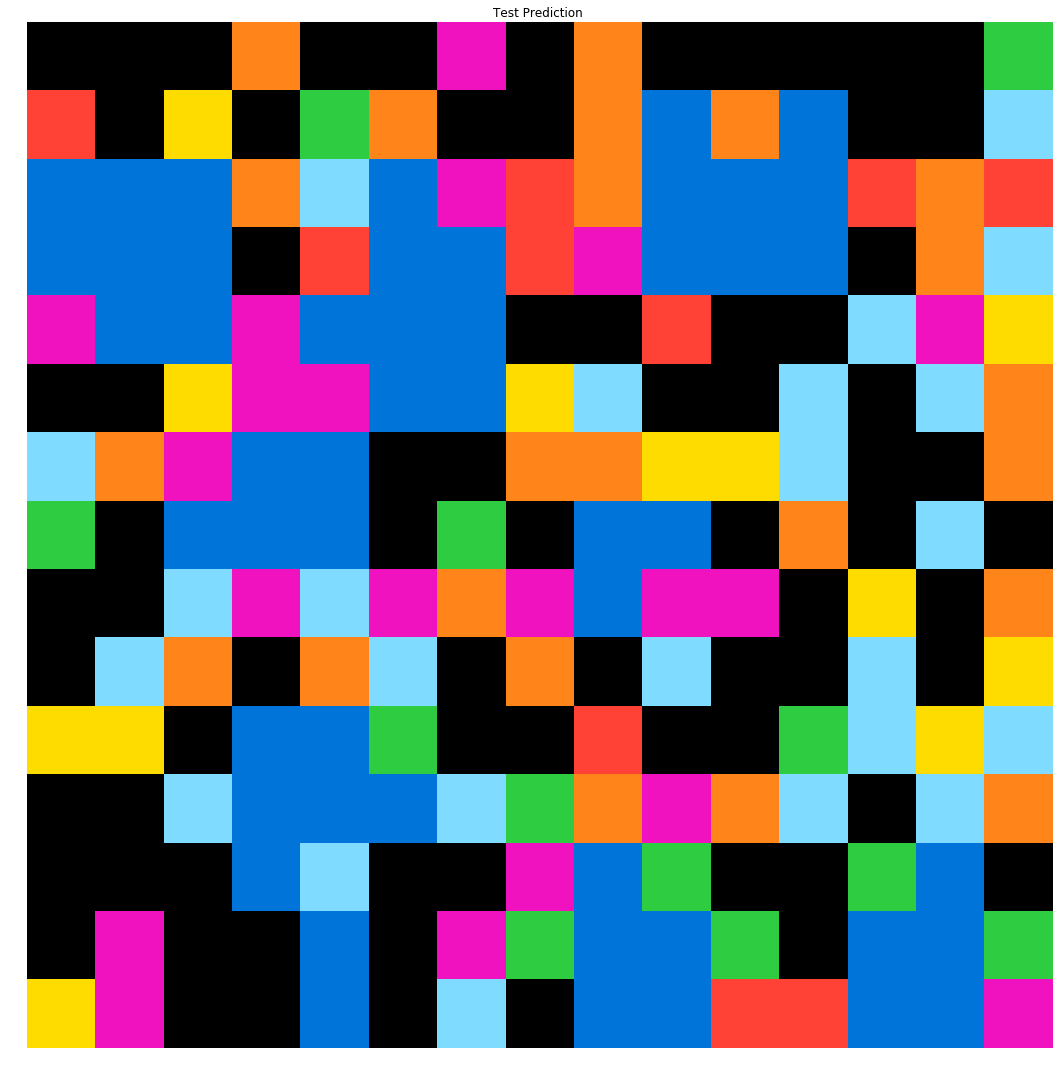

Made predictions for  f21745ec
ensemble accuracy 0.7490118577075099



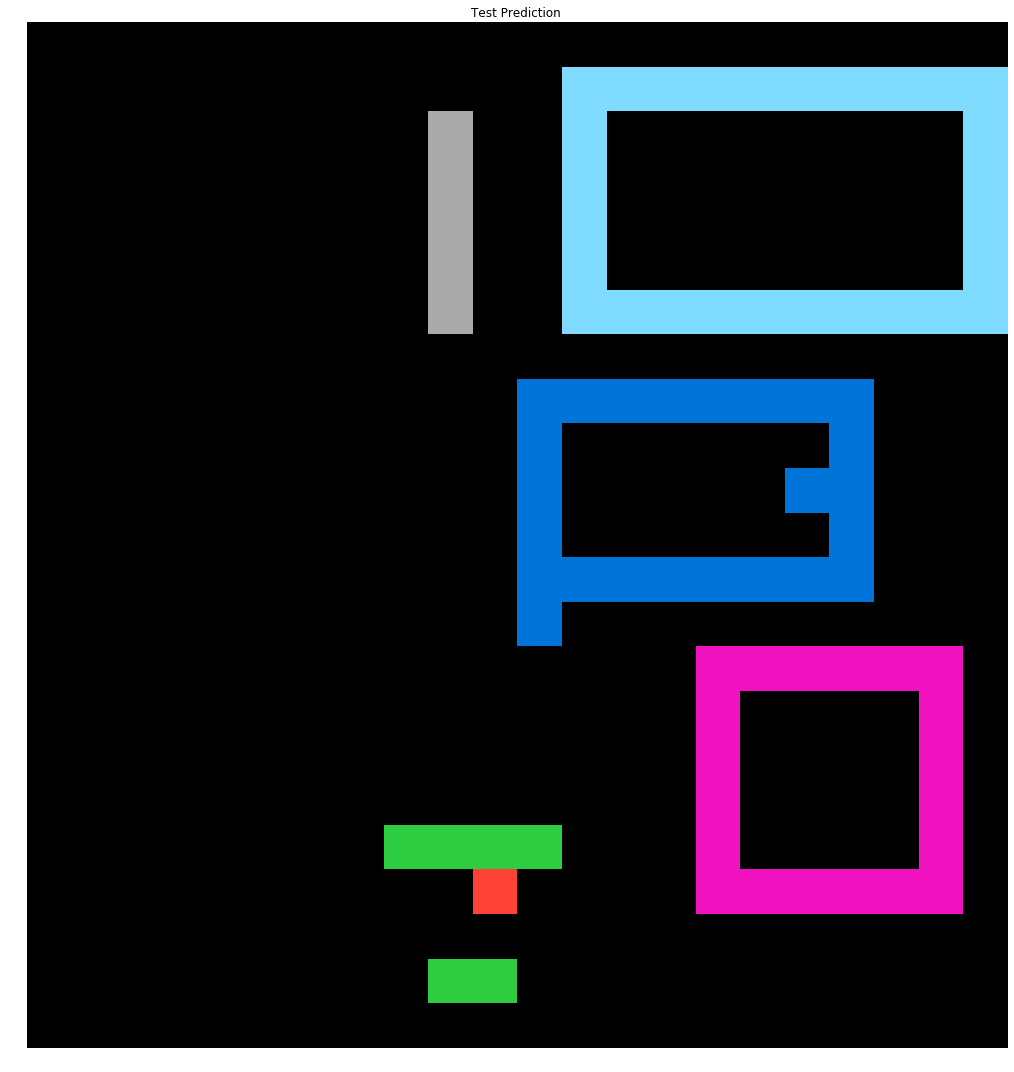

Made predictions for  f3b10344
ensemble accuracy 0.7425287356321839



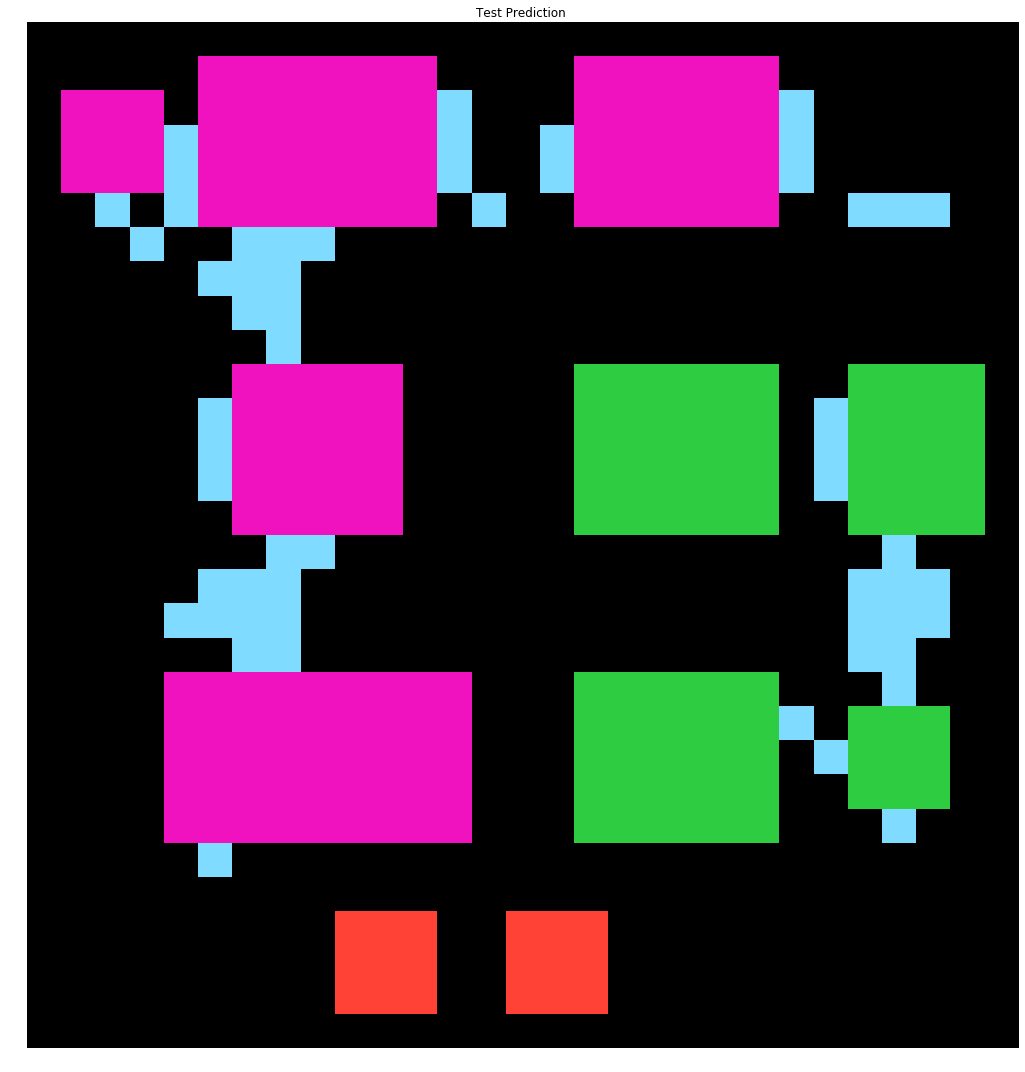

Made predictions for  f3cdc58f
ensemble accuracy 0.65



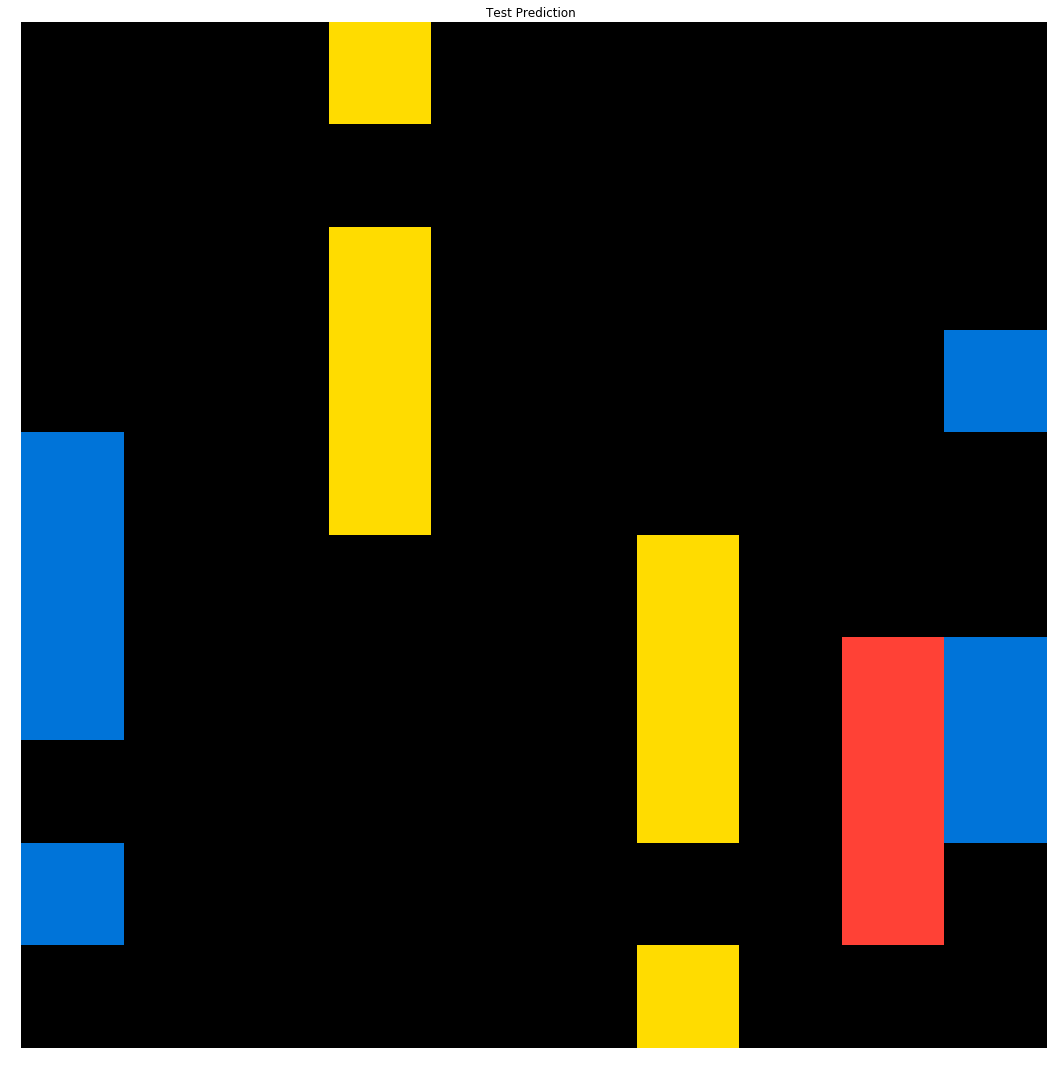

Made predictions for  f3e62deb
ensemble accuracy 0.92



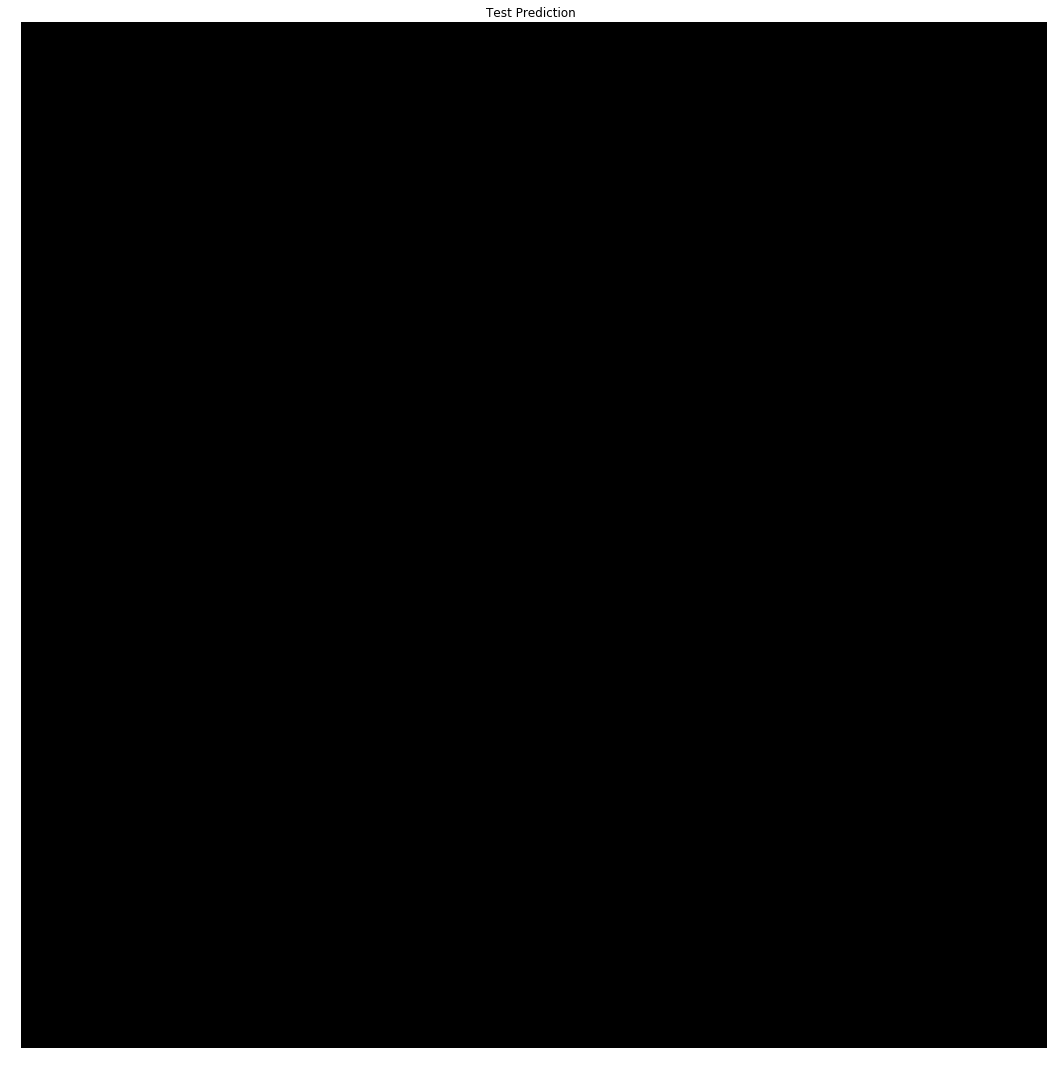

Made predictions for  f3e62deb
ensemble accuracy 0.92



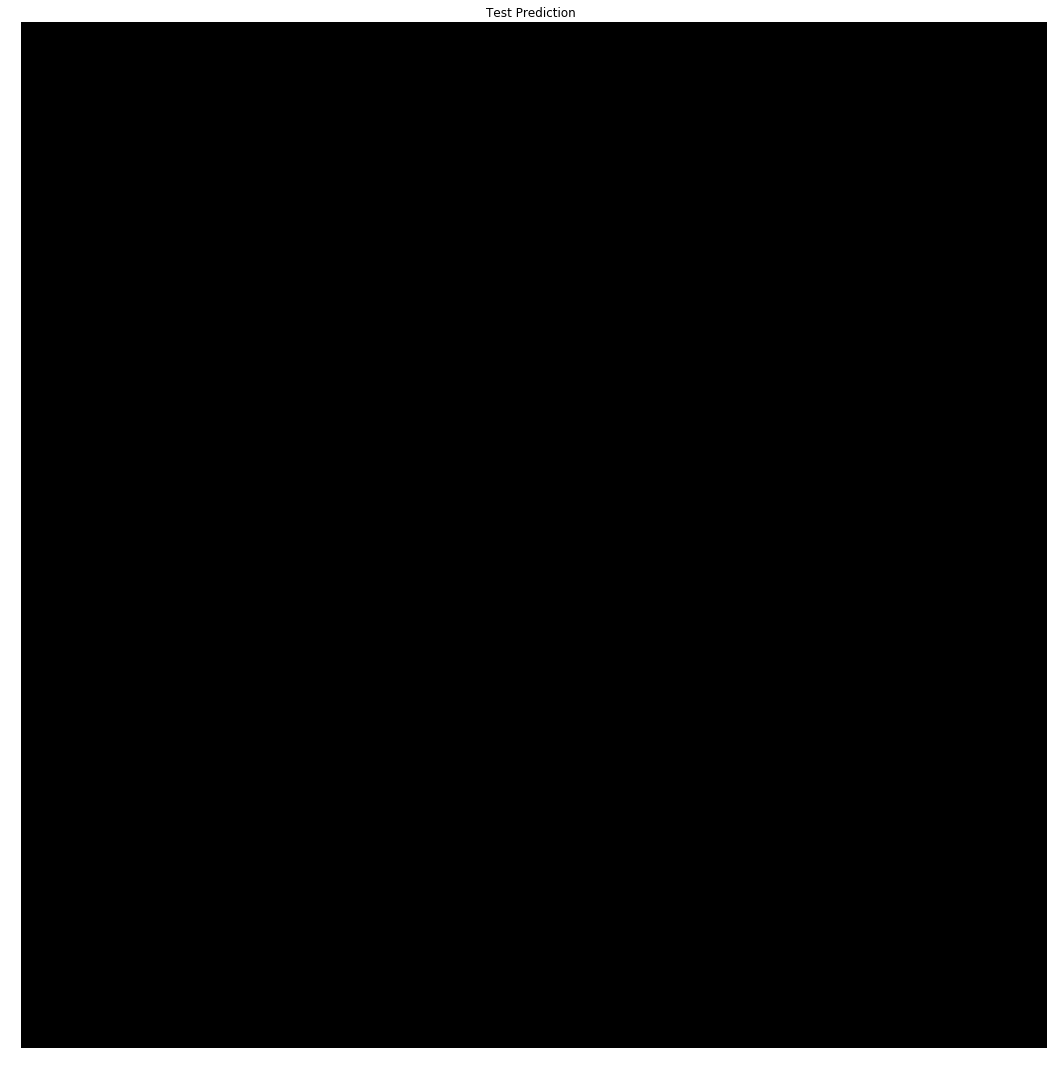

Number of input rows: 24 cols: 24
Number of target rows: 3 cols: 3
ignoring task abstraction-and-reasoning-challenge\evaluation\f4081712.json

Made predictions for  f45f5ca7
ensemble accuracy 0.96



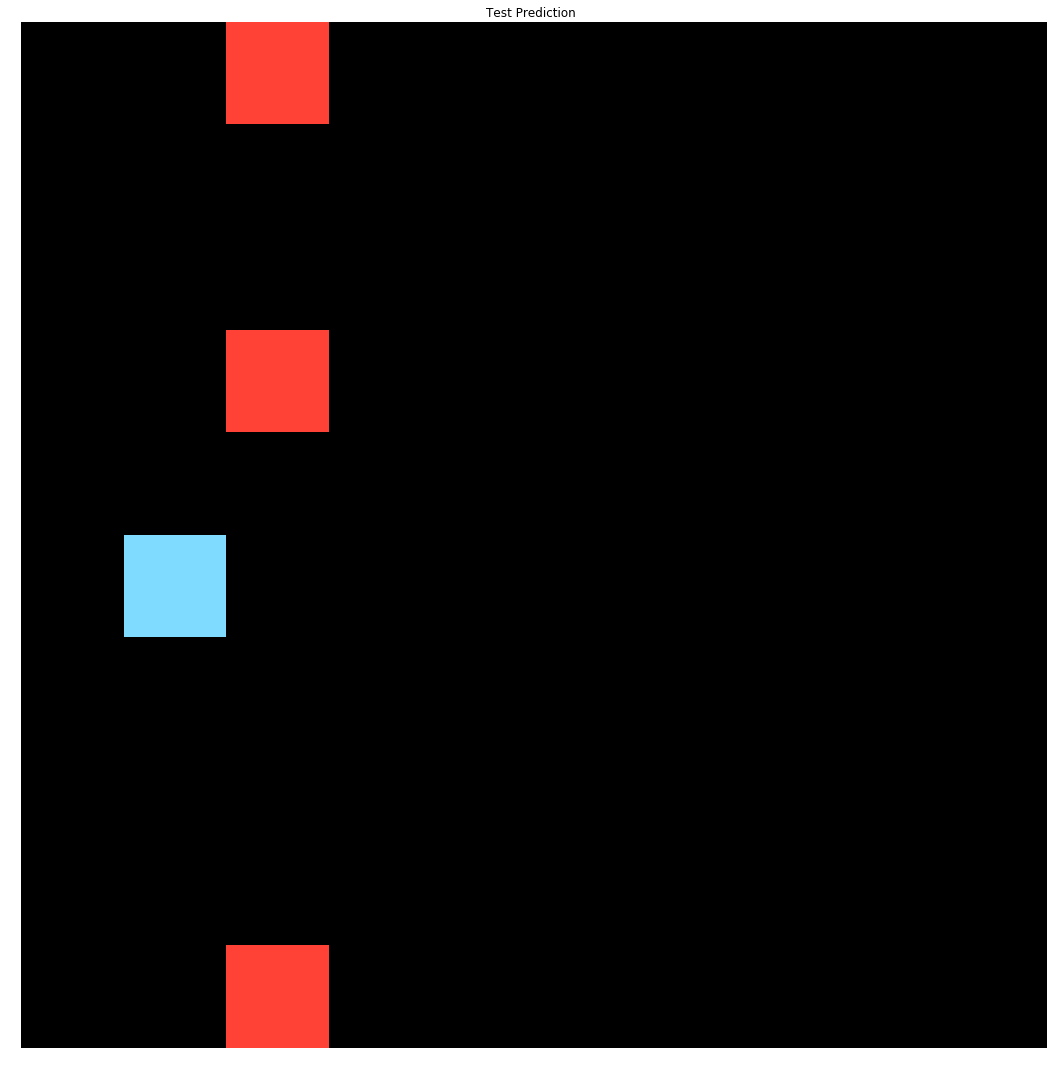

Number of input rows: 10 cols: 13
Number of target rows: 3 cols: 4
ignoring task abstraction-and-reasoning-challenge\evaluation\f5aa3634.json

Made predictions for  f5c89df1
ensemble accuracy 0.8520710059171598



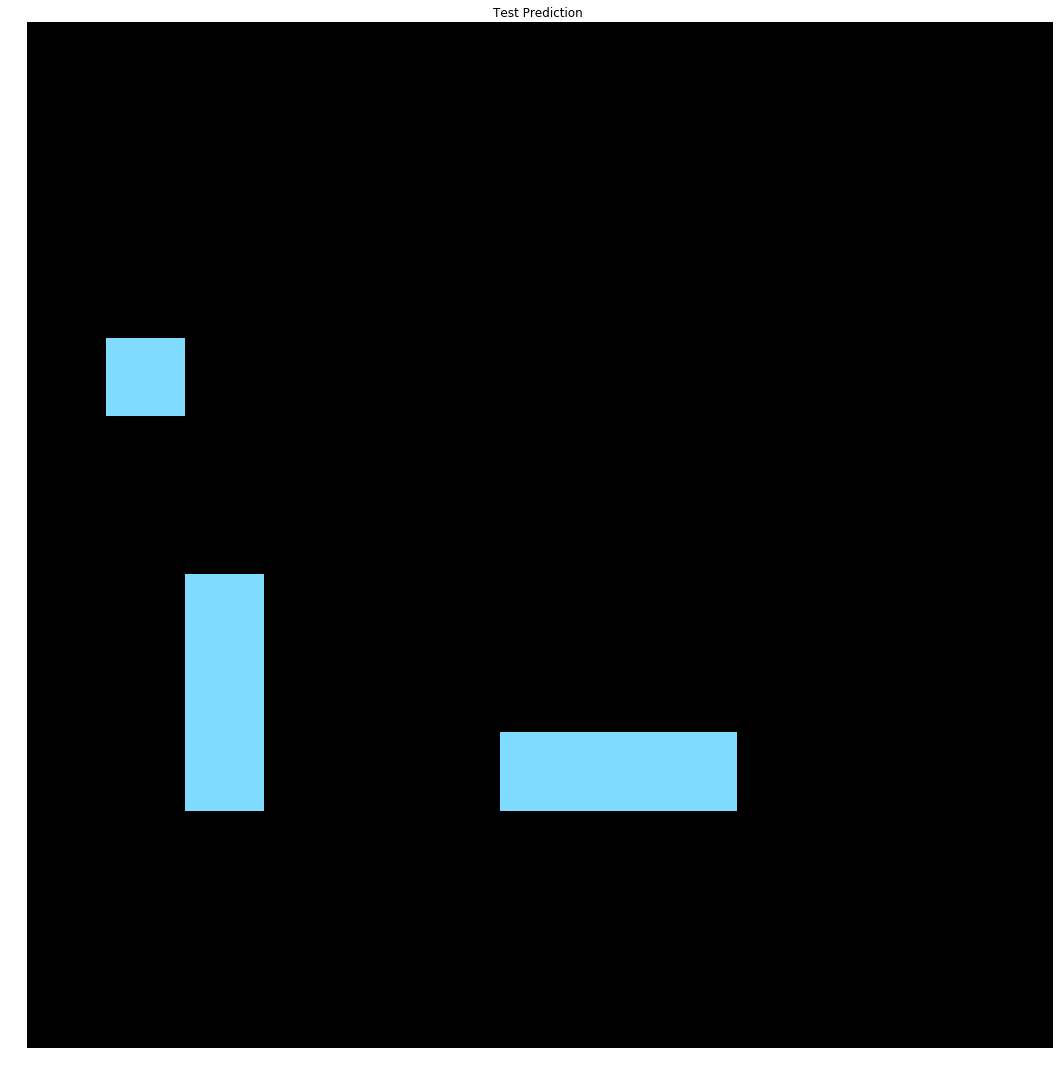

Made predictions for  f823c43c
ensemble accuracy 0.0



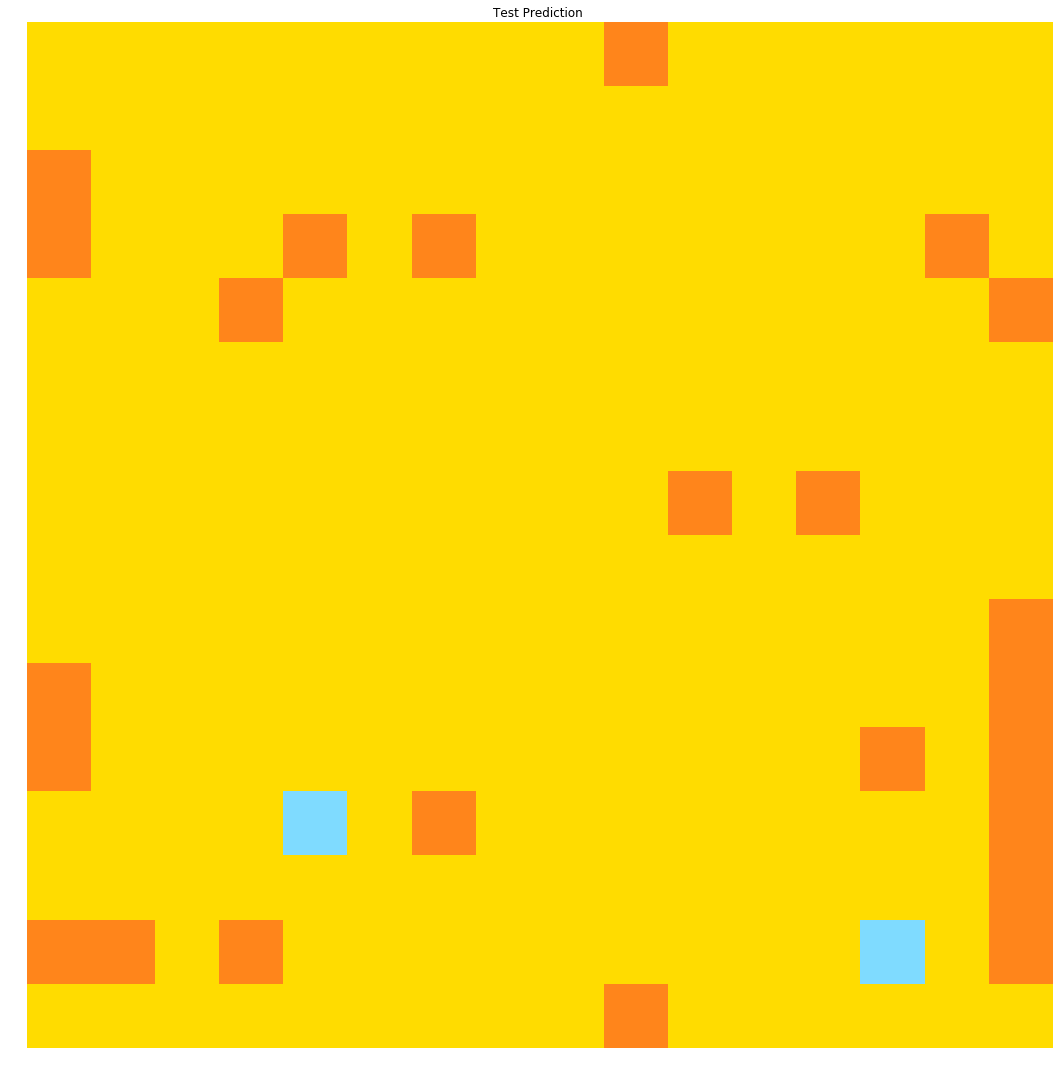

Made predictions for  f83cb3f6
ensemble accuracy 0.92



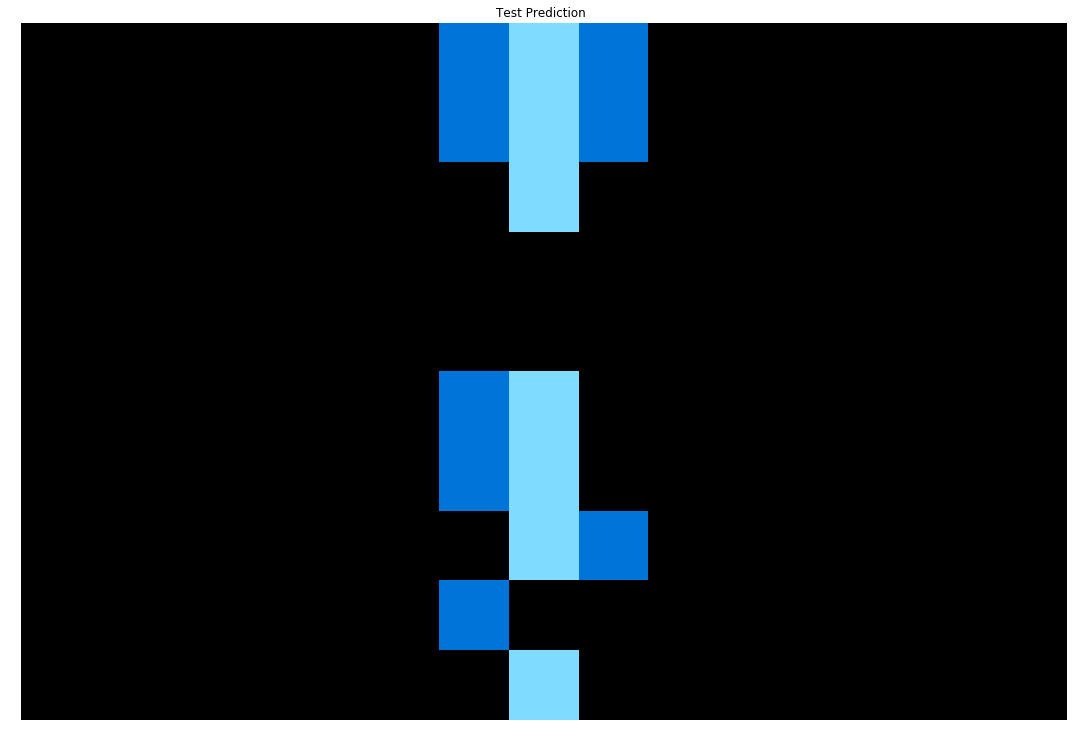

Made predictions for  f8be4b64
ensemble accuracy 0.7479224376731302



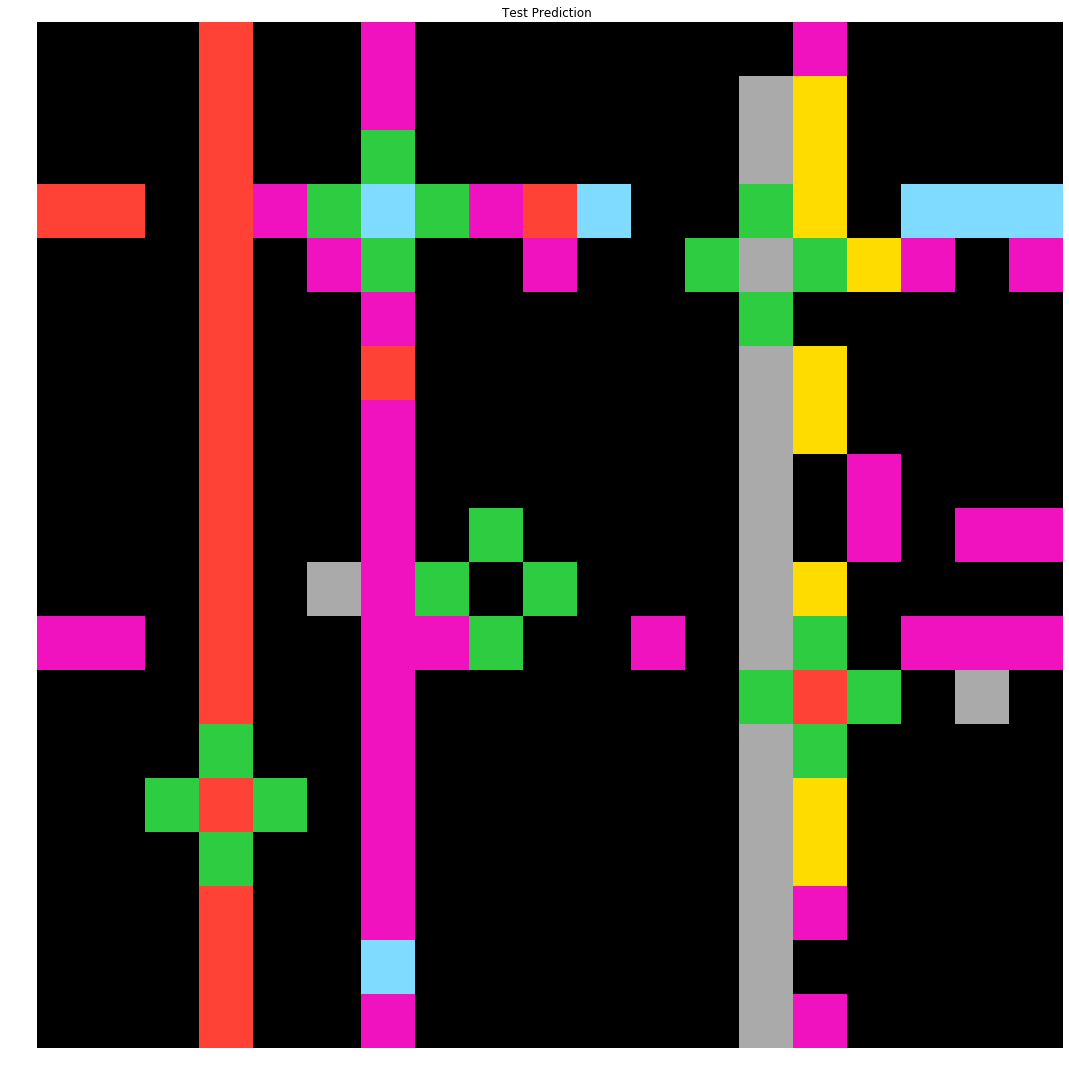

Made predictions for  f9a67cb5
ensemble accuracy 0.8095238095238095



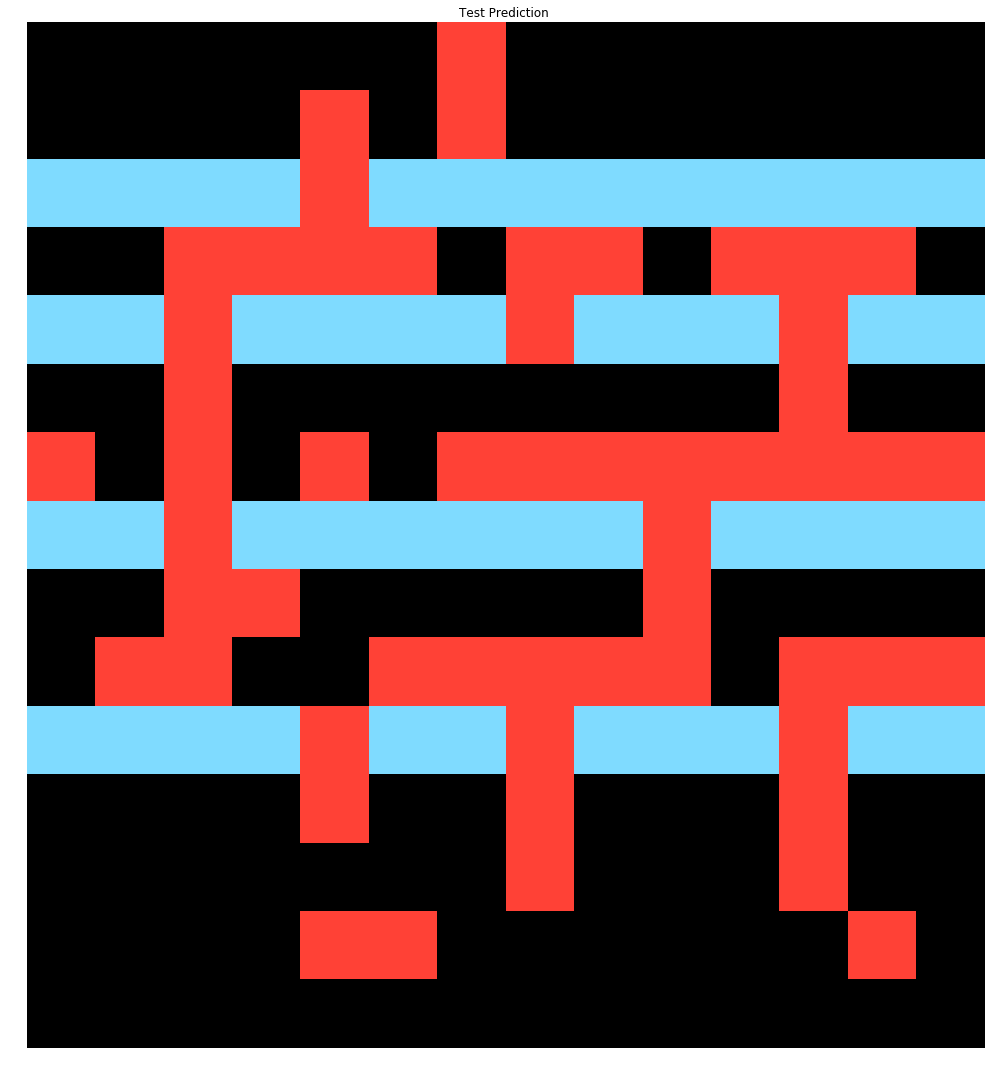

Made predictions for  f9d67f8b
ensemble accuracy 0.8977777777777778



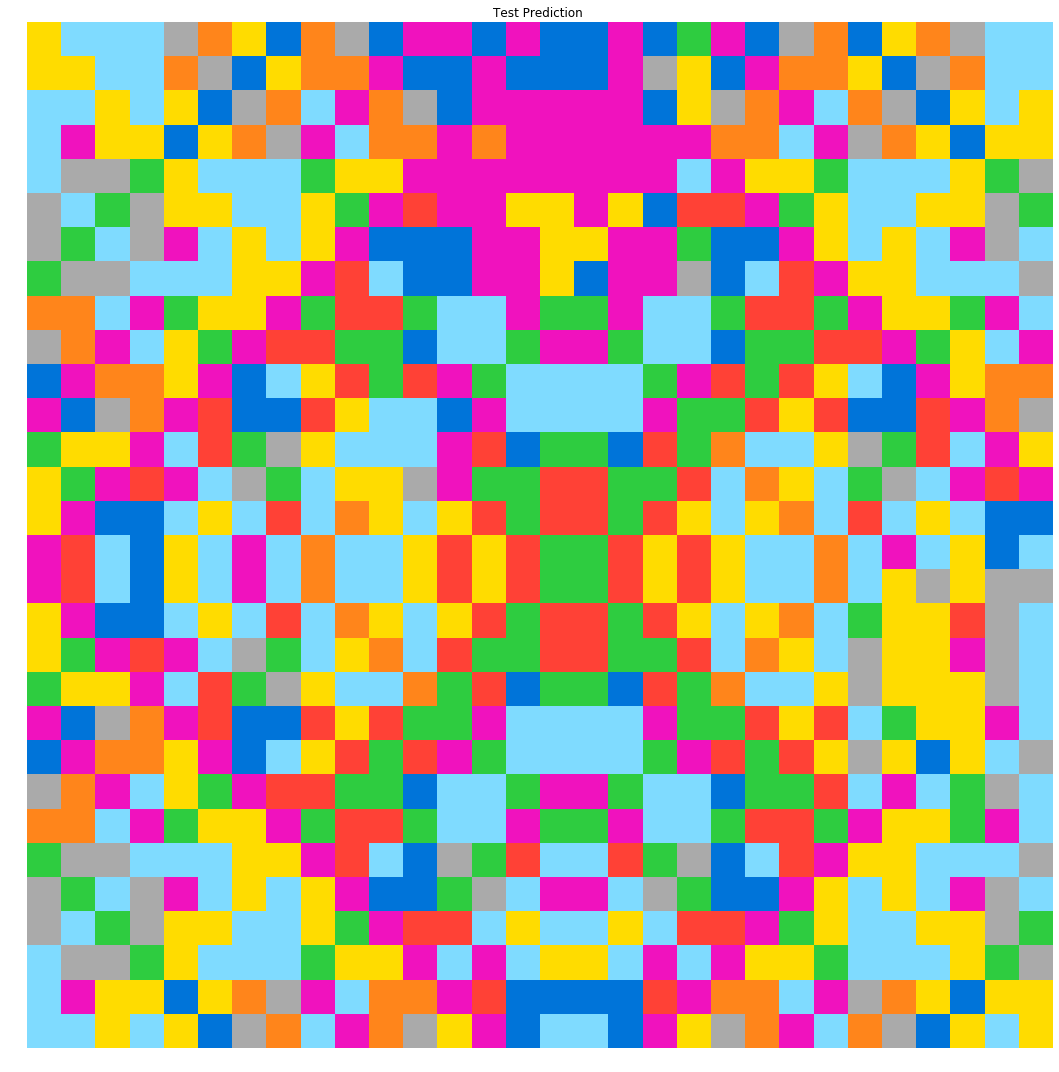

Made predictions for  fafd9572
ensemble accuracy 0.8095238095238095



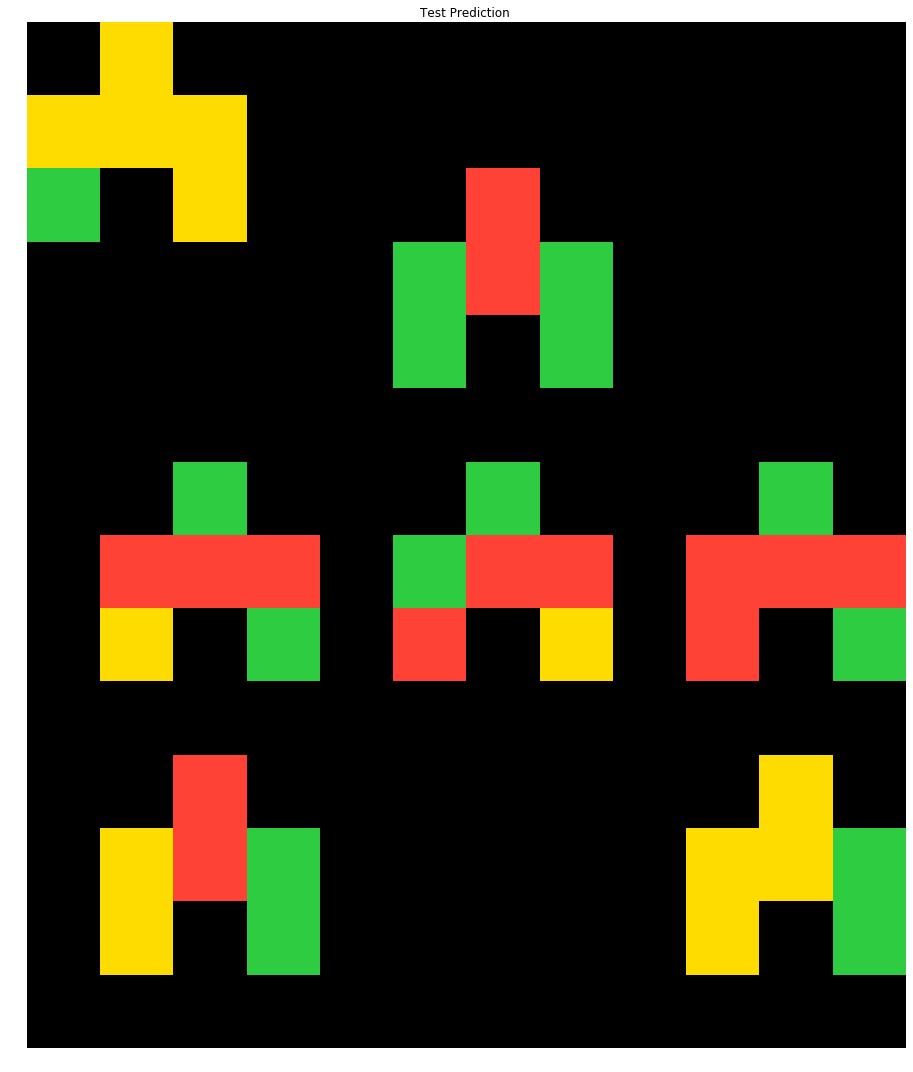

Number of input rows: 6 cols: 6
Number of target rows: 12 cols: 12
ignoring task abstraction-and-reasoning-challenge\evaluation\fb791726.json

Made predictions for  fc754716
ensemble accuracy 0.5555555555555556



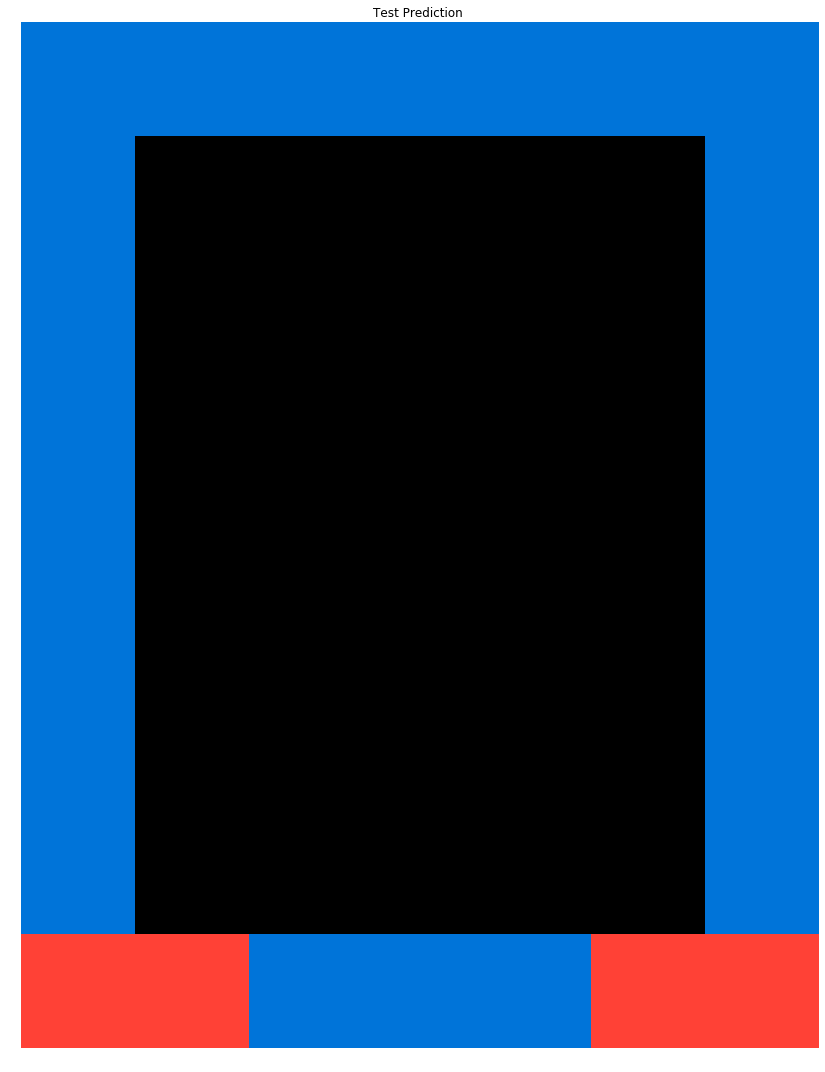

Made predictions for  fd096ab6
ensemble accuracy 0.9622222222222222



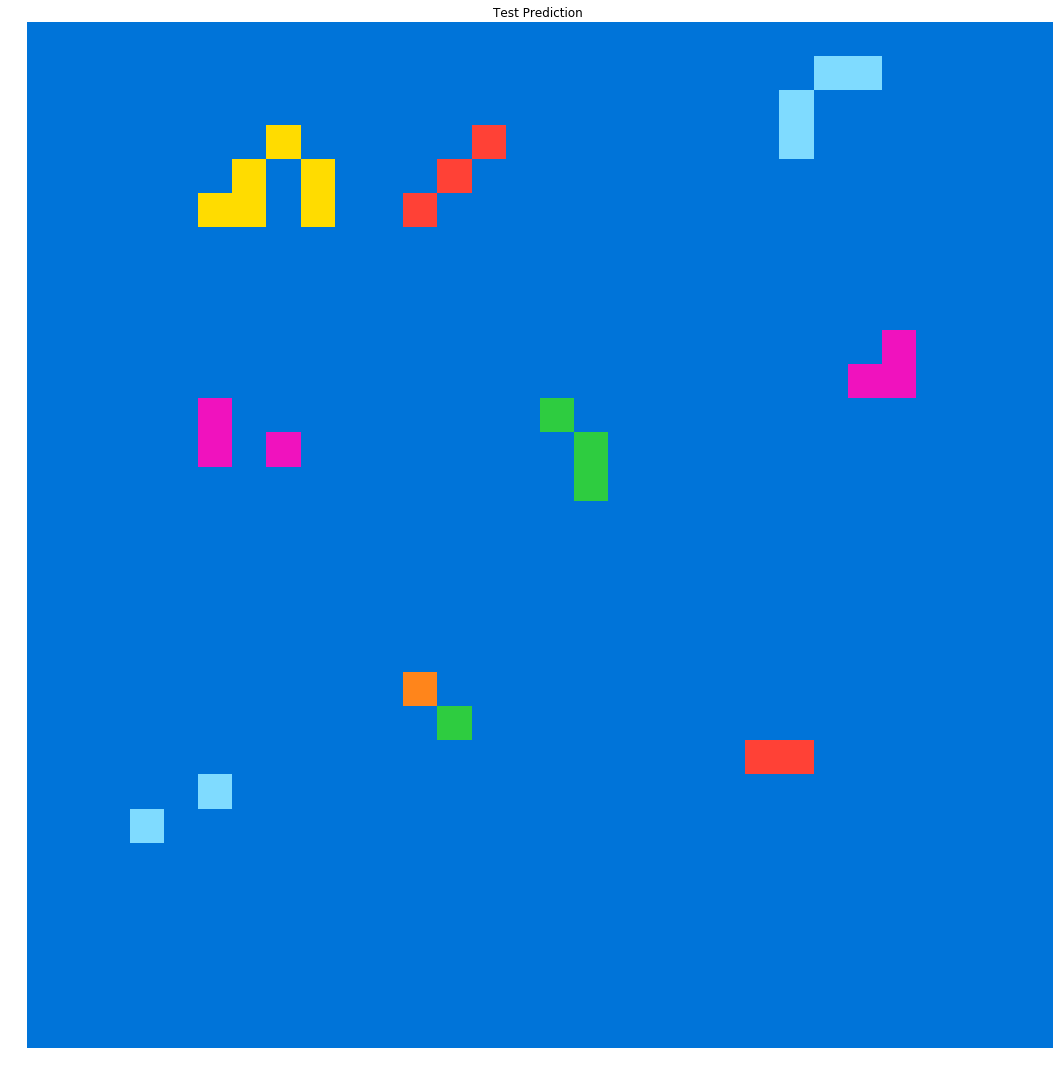

Made predictions for  fd4b2b02
ensemble accuracy 0.8828125



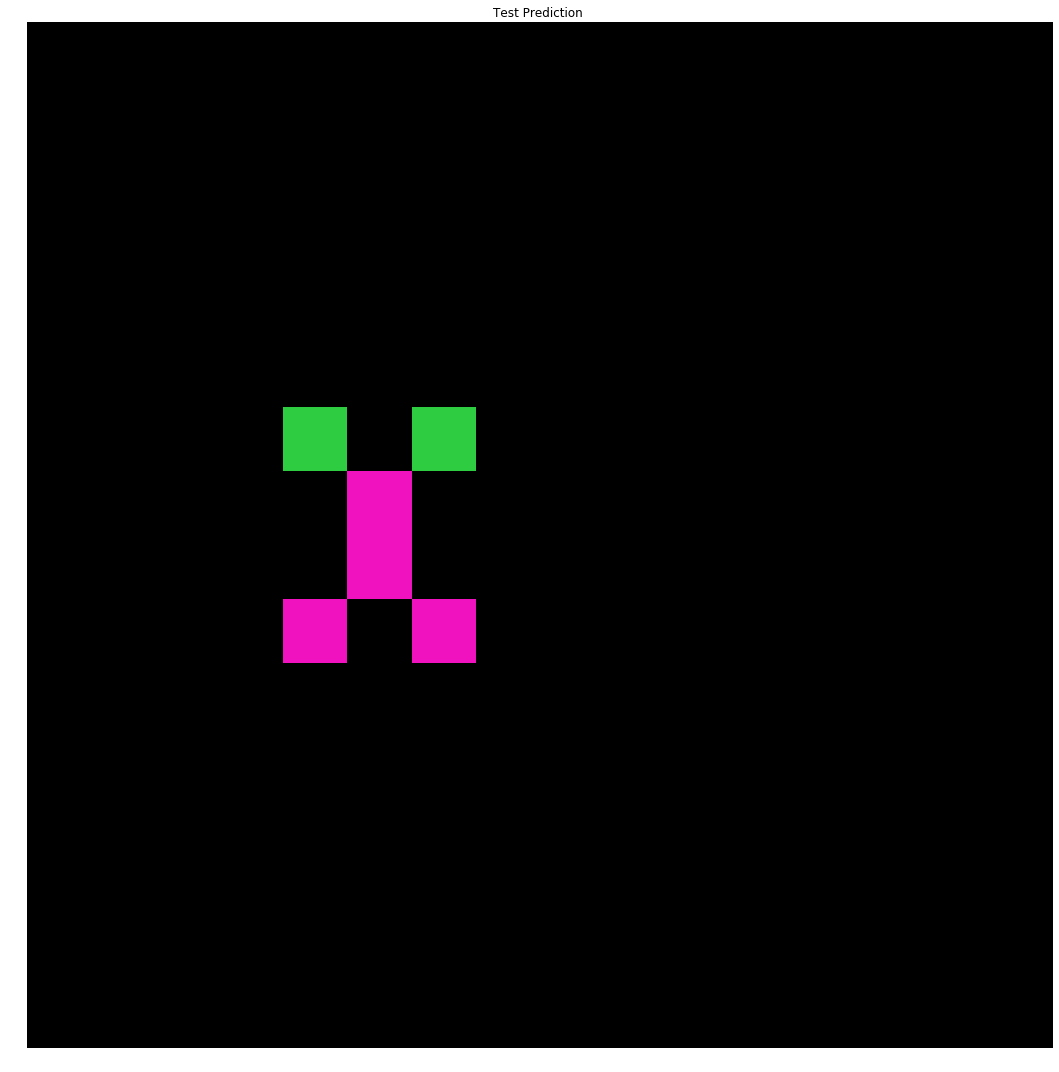

Made predictions for  fe9372f3
ensemble accuracy 0.7607843137254902



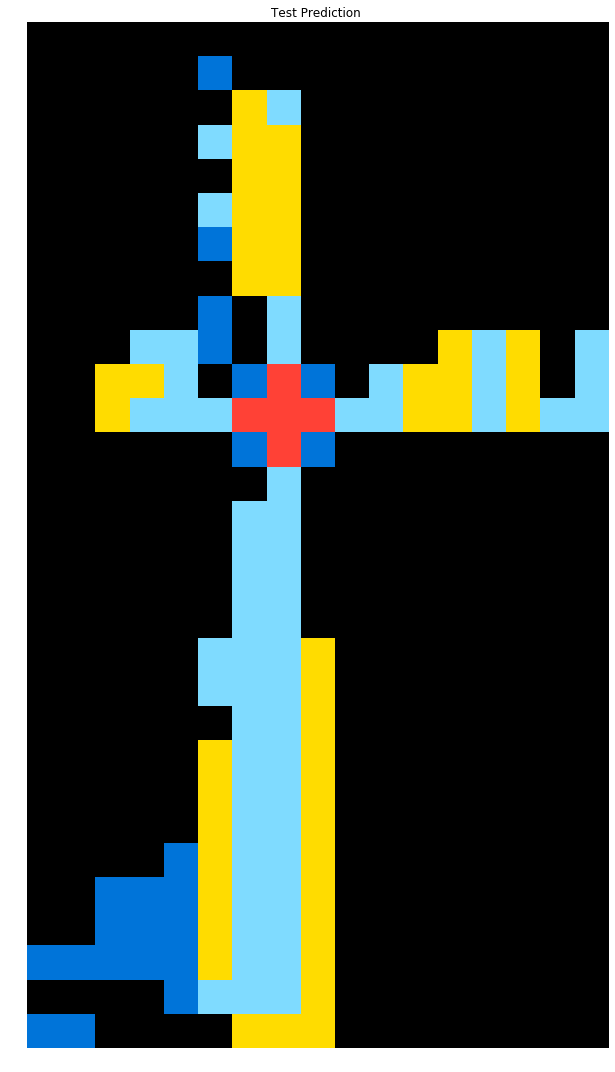

Made predictions for  fea12743
ensemble accuracy 0.875



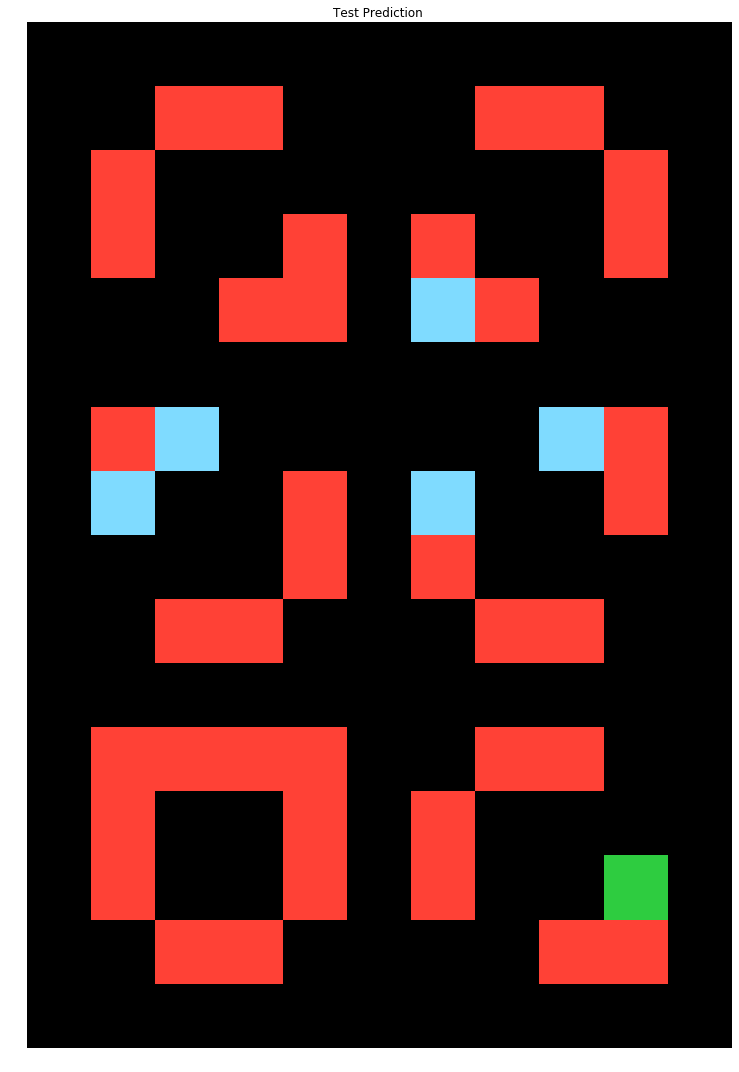

Made predictions for  ff72ca3e
ensemble accuracy 0.7033333333333334



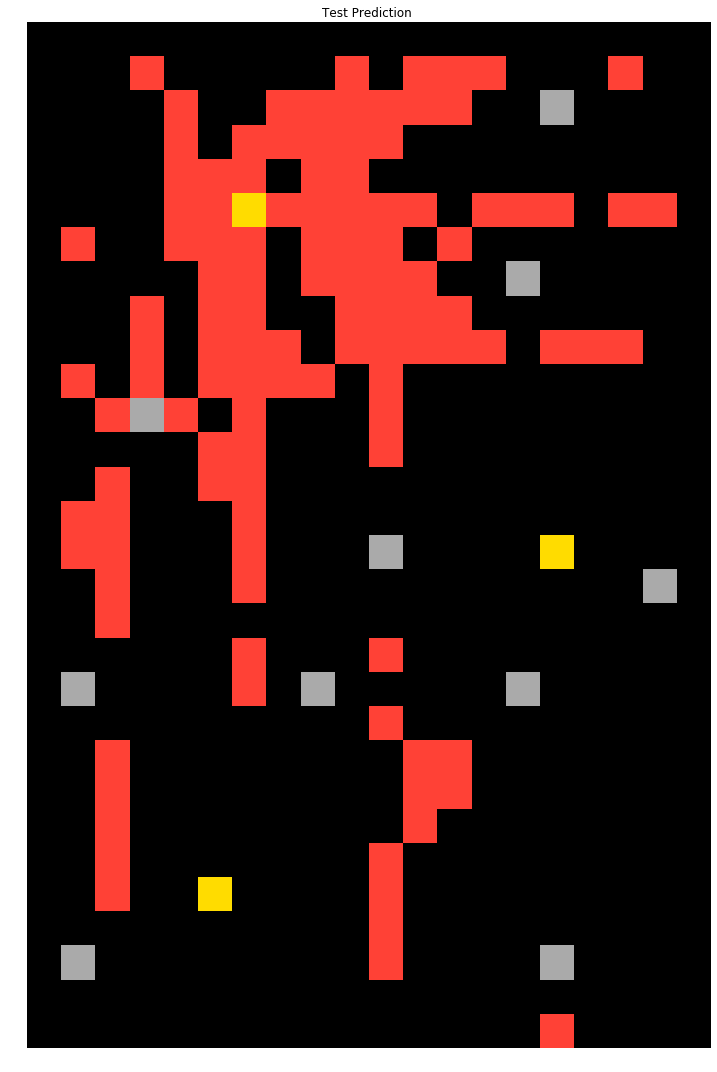

In [10]:
# mode = 'eval'
mode = 'eval'
if mode=='eval':
    task_path = evaluation_path
    all_task_ids = sorted(os.listdir('./abstraction-and-reasoning-challenge/evaluation'))
elif mode=='train':
    task_path = training_path
    all_task_ids = sorted(os.listdir('./abstraction-and-reasoning-challenge/training'))
elif mode=='test':
    task_path = test_path
    all_task_ids = sorted(os.listdir('./abstraction-and-reasoning-challenge/test'))

    
nfeat = 31
local_neighb = 5
valid_scores = {}
model_accuracies = {'ens': []}
pred_taskids = []
for task_id in all_task_ids:

    task_file = str(task_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    estimators = [
                    ('xgb', XGBClassifier(n_estimators=25, n_jobs=-1)),
                    ('extra_trees', ExtraTreesClassifier() ),
                    ('bagging', BaggingClassifier()),
                    ('LogisticRegression',LogisticRegression())
                 ]
    clf = StackingClassifier(
        estimators=estimators, final_estimator=XGBClassifier(n_estimators=10, n_jobs=-1)
    )


    clf.fit(feat, target)

#     training on input pairs is done.
#     test predictions begins here

    num_test_pairs = len(task['test'])
    cur_idx = 0
    for task_num in range(num_test_pairs):
        input_color = np.array(task['test'][task_num]['input'])
        nrows, ncols = len(task['test'][task_num]['input']), len(
            task['test'][task_num]['input'][0])

        feat = make_features(input_color, nfeat)

        print('Made predictions for ', task_id[:-5])

        preds = clf.predict(feat).reshape(nrows,ncols)
        
        if (mode=='train') or (mode=='eval'):
            ens_acc = (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols)

            model_accuracies['ens'].append(ens_acc)

            #pred_taskids.append(task_id[:-5] + '_' + task_num)

            print('ensemble accuracy',(np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols))
            print()

        preds = preds.astype(int).tolist()
        plot_test(preds, task_id)
        #if mode=='test':
        #    sample_sub.loc[task_id[:-5] + '_' + task_num,
        #                'output'] = flattener(preds)